# Deep Learning - CNN - MNIST fashion dataset

This notebook provides **convolutional neural networks, or CNNs** examples on fashion-mnist dataset. It uses [Keras](https://keras.io/) to build CNN and get the dataset from here [fashion-mnist](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/).

In [2]:
%matplotlib inline

from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from keras.layers.convolutional import Conv2D

from keras.utils import np_utils
from keras.utils.data_utils import get_file

import matplotlib.pyplot as plt

import gzip
import os
import numpy as np

np.random.seed(123)

Using TensorFlow backend.


### Dataset
Run the following command to download the dataset.  The first time you run this it will take while as it's pulling the data down over the network.

In [5]:

def load_data():
    dirname = os.path.join('datasets', 'images-dataset')
    base = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'
    files = ['train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz']

    paths = []
    for file in files:
        paths.append(get_file(file, origin=base + file, cache_subdir=dirname))

    with gzip.open(paths[0], 'rb') as lbpath:
        y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[1], 'rb') as imgpath:
        x_train = np.frombuffer(imgpath.read(), np.uint8,
                                offset=16).reshape(len(y_train), 28, 28, 1)

    with gzip.open(paths[2], 'rb') as lbpath:
        y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[3], 'rb') as imgpath:
        x_test = np.frombuffer(imgpath.read(), np.uint8,
                               offset=16).reshape(len(y_test), 28, 28, 1)

    return (x_train, y_train), (x_test, y_test)


In [10]:

(x_train, y_train), (x_test, y_test) = load_data()

Let's see how the data is formatted by printing the dimensionalities of the variables (tensors).

In [11]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (60000, 28, 28, 1)
y_train (60000,)
x_test (10000, 28, 28, 1)
y_test (10000,)


Above you can see we have 60000 samples of 28x28 images in `x_train`. The third dimension of the images is just 1 as there is just a single grayscale value. The test set is formatted in the same way, except we have just 10000 samples.

The class labels are stored in `y_train`. Let's print the first 10 values just to see what they are...

In [12]:
print(y_train[:10])

[9 0 0 3 0 2 7 2 5 5]


These are the correct classes for each image.  These actually refer to different types of clothing.  Let's define the mapping from class indices to human-understandable labels as a Python dictionary. We have 10 classes, i.e., 10 categories of images to classify.

In [13]:
num_classes = 10

labels = {
  0: 'T-shirt/top',
  1: 'Trouser',
  2: 'Pullover',
  3: 'Dress',
  4: 'Coat',
  5: 'Sandal',
  6: 'Shirt',
  7: 'Sneaker',
  8: 'Bag',
  9: 'Ankle boot'
}

So, according to this the first image is of class 9, which is an "Ankle boot". Let's look at the first image.

In [14]:
img0 = x_train[0, :, :].reshape(28, 28)
print(img0)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

That's pretty hard to decipher. Let's instead draw it as an image, interpreting each number as a grayscale value.

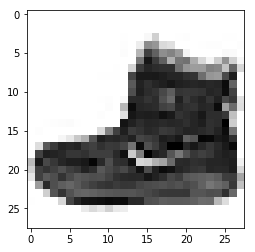

In [15]:
plt.imshow(img0, cmap='Greys', interpolation='none')


Typically we use so called one-hot encoding for the class labels in neural networks.  That is instead of having a single value which can have one of 10 label values (e.g. 0, ..., 9), we have 10 values which can each be 1 or 0 depending on if that class is present. 

Then for the output we typically expect something that looks like a probability distribution over these 10 classes, i.e., each neuron has a value between 0 and 1 indicating the probability of that class being present. For example if the tenth (last) neuron is 0.8, then we have 80% probability of the image containing an ankle boot. (The sum over all classes should also be 1.0 in order for it be a probability distribution.)

Here we'll call a utility function to transform the class labels into a one-hot encoding format.

In [16]:
print("Old format", y_train[:5])
y_train_cat = np_utils.to_categorical(y_train, num_classes)
y_test_cat = np_utils.to_categorical(y_test, num_classes)
print("One-hot encoding\n", y_train_cat[:5,])

Old format [9 0 0 3 0]
One-hot encoding
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


You can take a look at the output above. For example for the first image, which has label 9, the tenth value is 1, the rest are zero.

Let's display the first example image of each class just for fun.

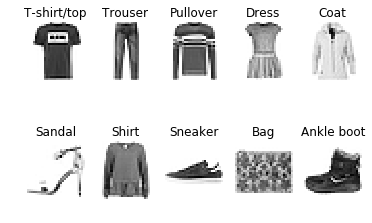

In [17]:
for l in range(10):
    idx = np.argwhere(y_train==l)[0]
  
    plt.subplot(2, 5, l+1)

    img = x_train[idx,:,:].reshape(28,28)

    plt.imshow(img, cmap='Greys', interpolation='none')
    plt.title(labels[l])
    plt.axis('off')

Finally, we normalize the images to be in the range 0.0 to 1.0 instead of 0 to 255.

In [17]:
x_train = x_train/255
x_test = x_test/255

### Simple CNN

Simple CNN that learns to detect these classes. It has (in order):

- One 2D convolutional layer with kernel size 3x3 and 32 output filters/features

- ReLU activation

- Max pooling (2D) of size 2x2

- Fully-connected (dense) layer to 10 output units (for the 10 classes)

- Finally softmax activation to get a probability-like output.

Before the dense layer we need a `Flatten()` layer. This is a special layer in Keras that transforms the 2D output into 1D. The 2D convolution works with neurons in 2D, but the dense layer works in 1D.

## Reparameterizations One

In [11]:
# Initialize model
model = Sequential()

units_output = 10

# Add layers here
# Convolutional layer with kernel size 3x3 and 32 output filters
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1)))

# ReLU activation
model.add(Activation('relu'))

# Max pooling (2D) of size 2x2
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten 2D output into 1D
model.add(Flatten())

# Dense layer to 10 output units
model.add(Dense(units=units_output))

# softmax activation
model.add(Activation('softmax'))

#model.add(Dense(10, activation='softmax'))

# Let's use categorical crossentry and sgd optmizer
model.compile(loss='categorical_crossentropy', 
              optimizer='sgd', 
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                54090     
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________
None


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1...)`
  


### Training

Now let's train it for 10 epochs. This takes roughly 5 minutes on a CPU.

We use a batch size of 128, which means that the weight updates are calculated for 128 inputs at a time.

In [12]:
%%time

epochs = 10 # one epoch typically takes a minute or two

history = model.fit(x_train, 
                    y_train_cat, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=1)

Epoch 1/10
60000/60000 [==============================] - 21s - loss: 1.0394 - acc: 0.6644    
Epoch 2/10
60000/60000 [==============================] - 21s - loss: 0.6091 - acc: 0.7872    
Epoch 3/10
60000/60000 [==============================] - 21s - loss: 0.5489 - acc: 0.8053    
Epoch 4/10
60000/60000 [==============================] - 21s - loss: 0.5239 - acc: 0.8136    
Epoch 5/10
60000/60000 [==============================] - 21s - loss: 0.5012 - acc: 0.8233    
Epoch 6/10
60000/60000 [==============================] - 20s - loss: 0.4876 - acc: 0.8279    
Epoch 7/10
60000/60000 [==============================] - 21s - loss: 0.4752 - acc: 0.8326    
Epoch 8/10
60000/60000 [==============================] - 20s - loss: 0.4623 - acc: 0.8382    
Epoch 9/10
60000/60000 [==============================] - 20s - loss: 0.4543 - acc: 0.8397    
Epoch 10/10
60000/60000 [==============================] - 22s - loss: 0.4469 - acc: 0.8441    
CPU times: user 6min 29s, sys: 1min 24s, total: 7

Let's plot how the loss and accuracy have changed over the training time.

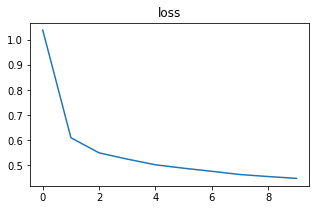

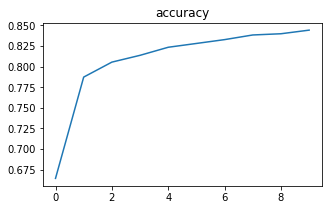

In [13]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy')


### Inference
Let's predict the labels of the test dataset, and compare to the correct labels.

In [14]:
scores = model.evaluate(x_test, y_test_cat, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 83.80%


### Visualise the weights

An interesting thing is to visualise the learned weights for the convolutional layer.  We have 32 kernels of size 3x3, we can just plot them as images, mapping the weight values to grayscale.

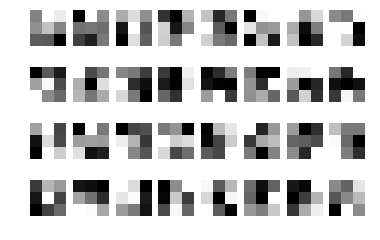

In [15]:
# Weights for the first convolutional layer
w0=model.get_weights()[0][:,:,0,:]

# Normalize to range 0.0 - 1.0
w0 -= np.min(w0)
w0 /= np.max(w0)

for r in range(4):
    for c in range(8):
        n=r*8+c
        plt.subplot(4, 8, n+1)
        plt.imshow(w0[:,:,n], interpolation='none')
        plt.axis('off')
        plt.gray()
plt.show()

They might be a bit hard to interpret, but it seems these weights have learned to detect various corners and edges.

## Making a better CNN 

Make a network that performs better than the very simple one above. Example parameters that needs to be change: 

- number of layers or neurons
- activation functions
- epochs
- batch sizes
- optimizer, see [Keras' documentation on optimizers](https://keras.io/optimizers/)
- max-pooling on/off on certain layers

In [18]:
%matplotlib inline

from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from keras.layers.convolutional import Conv2D

from keras.utils import np_utils
import matplotlib.pyplot as plt

# Load the dataset
(x_train, y_train), (x_test, y_test) = load_data()

# Normalize
x_train = x_train/255
x_test = x_test/255

num_classes = 10

y_train_cat = np_utils.to_categorical(y_train, num_classes)
y_test_cat = np_utils.to_categorical(y_test, num_classes)

## Reparameterizations Second

/Users/adnanbajwa/Documents/master-thesis/thesis-project/version0.1/v0.1-venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1...)`
  import sys
/Users/adnanbajwa/Documents/master-thesis/thesis-project/version0.1/v0.1-venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                46090     
__________

Epoch 1/10


  128/60000 [..............................] - ETA: 4:18 - loss: 2.3194 - acc: 0.0234

  256/60000 [..............................] - ETA: 2:58 - loss: 2.3002 - acc: 0.0664

  384/60000 [..............................] - ETA: 2:28 - loss: 2.2804 - acc: 0.0885

  512/60000 [..............................] - ETA: 2:12 - loss: 2.2516 - acc: 0.1055

  640/60000 [..............................] - ETA: 1:57 - loss: 2.2236 - acc: 0.1109

  768/60000 [..............................] - ETA: 1:46 - loss: 2.2001 - acc: 0.1263

  896/60000 [..............................] - ETA: 1:39 - loss: 2.1703 - acc: 0.1696

 1024/60000 [..............................] - ETA: 1:34 - loss: 2.1328 - acc: 0.2178

 1152/60000 [..............................] - ETA: 1:29 - loss: 2.1020 - acc: 0.2543

 1280/60000 [..............................] - ETA: 1:25 - loss: 2.0649 - acc: 0.2805

 1408/60000 [..............................] - ETA: 1:22 - loss: 2.0253 - acc: 0.3054

 1536/60000 [..............................] - ETA: 1:21 - loss: 1.9832 - acc: 0.3301

 1664/60000 [..............................] - ETA: 1:19 - loss: 1.9392 - acc: 0.3486

 1792/60000 [..............................] - ETA: 1:17 - loss: 1.8937 - acc: 0.3689

 1920/60000 [..............................] - ETA: 1:15 - loss: 1.8443 - acc: 0.3880

 2048/60000 [>.............................] - ETA: 1:14 - loss: 1.8029 - acc: 0.4028

 2176/60000 [>.............................] - ETA: 1:13 - loss: 1.7630 - acc: 0.4136

 2304/60000 [>.............................] - ETA: 1:11 - loss: 1.7308 - acc: 0.4214

 2432/60000 [>.............................] - ETA: 1:10 - loss: 1.6823 - acc: 0.4400

 2560/60000 [>.............................] - ETA: 1:10 - loss: 1.6467 - acc: 0.4539

 2688/60000 [>.............................] - ETA: 1:09 - loss: 1.6173 - acc: 0.4624

 2816/60000 [>.............................] - ETA: 1:08 - loss: 1.5907 - acc: 0.4712

 2944/60000 [>.............................] - ETA: 1:07 - loss: 1.5556 - acc: 0.4800

 3072/60000 [>.............................] - ETA: 1:06 - loss: 1.5255 - acc: 0.4889

 3200/60000 [>.............................] - ETA: 1:06 - loss: 1.4993 - acc: 0.4981

 3328/60000 [>.............................] - ETA: 1:07 - loss: 1.4723 - acc: 0.5057

 3456/60000 [>.............................] - ETA: 1:07 - loss: 1.4444 - acc: 0.5098

 3584/60000 [>.............................] - ETA: 1:06 - loss: 1.4229 - acc: 0.5156

 3712/60000 [>.............................] - ETA: 1:06 - loss: 1.3982 - acc: 0.5245

 3840/60000 [>.............................] - ETA: 1:06 - loss: 1.3758 - acc: 0.5328

 3968/60000 [>.............................] - ETA: 1:05 - loss: 1.3607 - acc: 0.5360

 4096/60000 [=>............................] - ETA: 1:05 - loss: 1.3464 - acc: 0.5415

 4224/60000 [=>............................] - ETA: 1:04 - loss: 1.3226 - acc: 0.5483

 4352/60000 [=>............................] - ETA: 1:04 - loss: 1.3082 - acc: 0.5540

 4480/60000 [=>............................] - ETA: 1:03 - loss: 1.2967 - acc: 0.5583

 4608/60000 [=>............................] - ETA: 1:03 - loss: 1.2780 - acc: 0.5645

 4736/60000 [=>............................] - ETA: 1:03 - loss: 1.2624 - acc: 0.5690

 4864/60000 [=>............................] - ETA: 1:02 - loss: 1.2538 - acc: 0.5720

 4992/60000 [=>............................] - ETA: 1:02 - loss: 1.2413 - acc: 0.5751

 5120/60000 [=>............................] - ETA: 1:02 - loss: 1.2259 - acc: 0.5801

 5248/60000 [=>............................] - ETA: 1:02 - loss: 1.2147 - acc: 0.5838

 5376/60000 [=>............................] - ETA: 1:02 - loss: 1.2012 - acc: 0.5867

 5504/60000 [=>............................] - ETA: 1:01 - loss: 1.1882 - acc: 0.5905

 5632/60000 [=>............................] - ETA: 1:01 - loss: 1.1786 - acc: 0.5929

 5760/60000 [=>............................] - ETA: 1:01 - loss: 1.1665 - acc: 0.5967

 5888/60000 [=>............................] - ETA: 1:01 - loss: 1.1544 - acc: 0.6002

 6016/60000 [==>...........................] - ETA: 1:01 - loss: 1.1436 - acc: 0.6039

 6144/60000 [==>...........................] - ETA: 1:00 - loss: 1.1339 - acc: 0.6064

 6272/60000 [==>...........................] - ETA: 1:00 - loss: 1.1231 - acc: 0.6095

 6400/60000 [==>...........................] - ETA: 1:00 - loss: 1.1122 - acc: 0.6136

 6528/60000 [==>...........................] - ETA: 1:01 - loss: 1.1070 - acc: 0.6147

 6656/60000 [==>...........................] - ETA: 1:01 - loss: 1.1004 - acc: 0.6158

 6784/60000 [==>...........................] - ETA: 1:02 - loss: 1.0907 - acc: 0.6201

 6912/60000 [==>...........................] - ETA: 1:02 - loss: 1.0831 - acc: 0.6224

 7040/60000 [==>...........................] - ETA: 1:02 - loss: 1.0756 - acc: 0.6246

 7168/60000 [==>...........................] - ETA: 1:02 - loss: 1.0667 - acc: 0.6272

 7296/60000 [==>...........................] - ETA: 1:01 - loss: 1.0605 - acc: 0.6284

 7424/60000 [==>...........................] - ETA: 1:01 - loss: 1.0539 - acc: 0.6303

 7552/60000 [==>...........................] - ETA: 1:01 - loss: 1.0484 - acc: 0.6320

 7680/60000 [==>...........................] - ETA: 1:02 - loss: 1.0421 - acc: 0.6349

 7808/60000 [==>...........................] - ETA: 1:02 - loss: 1.0361 - acc: 0.6370

 7936/60000 [==>...........................] - ETA: 1:02 - loss: 1.0310 - acc: 0.6384

 8064/60000 [===>..........................] - ETA: 1:03 - loss: 1.0255 - acc: 0.6396

 8192/60000 [===>..........................] - ETA: 1:03 - loss: 1.0198 - acc: 0.6409

 8320/60000 [===>..........................] - ETA: 1:03 - loss: 1.0146 - acc: 0.6418

 8448/60000 [===>..........................] - ETA: 1:04 - loss: 1.0090 - acc: 0.6436

 8576/60000 [===>..........................] - ETA: 1:04 - loss: 1.0036 - acc: 0.6449

 8704/60000 [===>..........................] - ETA: 1:03 - loss: 0.9967 - acc: 0.6471

 8832/60000 [===>..........................] - ETA: 1:03 - loss: 0.9924 - acc: 0.6482

 8960/60000 [===>..........................] - ETA: 1:03 - loss: 0.9871 - acc: 0.6502

 9088/60000 [===>..........................] - ETA: 1:02 - loss: 0.9803 - acc: 0.6524

 9216/60000 [===>..........................] - ETA: 1:02 - loss: 0.9748 - acc: 0.6539

 9344/60000 [===>..........................] - ETA: 1:01 - loss: 0.9696 - acc: 0.6558

 9472/60000 [===>..........................] - ETA: 1:01 - loss: 0.9645 - acc: 0.6576

 9600/60000 [===>..........................] - ETA: 1:01 - loss: 0.9596 - acc: 0.6593

 9728/60000 [===>..........................] - ETA: 1:01 - loss: 0.9542 - acc: 0.6611

 9856/60000 [===>..........................] - ETA: 1:01 - loss: 0.9499 - acc: 0.6628

 9984/60000 [===>..........................] - ETA: 1:01 - loss: 0.9438 - acc: 0.6650

10112/60000 [====>.........................] - ETA: 1:01 - loss: 0.9402 - acc: 0.6660

10240/60000 [====>.........................] - ETA: 1:01 - loss: 0.9365 - acc: 0.6671

10368/60000 [====>.........................] - ETA: 1:01 - loss: 0.9346 - acc: 0.6677

10496/60000 [====>.........................] - ETA: 1:01 - loss: 0.9316 - acc: 0.6683

10624/60000 [====>.........................] - ETA: 1:00 - loss: 0.9277 - acc: 0.6699

10752/60000 [====>.........................] - ETA: 1:00 - loss: 0.9268 - acc: 0.6704

10880/60000 [====>.........................] - ETA: 1:00 - loss: 0.9221 - acc: 0.6722

11008/60000 [====>.........................] - ETA: 59s - loss: 0.9179 - acc: 0.6736 

11136/60000 [====>.........................] - ETA: 59s - loss: 0.9142 - acc: 0.6750

11264/60000 [====>.........................] - ETA: 59s - loss: 0.9093 - acc: 0.6765

11392/60000 [====>.........................] - ETA: 59s - loss: 0.9049 - acc: 0.6778

11520/60000 [====>.........................] - ETA: 59s - loss: 0.9012 - acc: 0.6789

11648/60000 [====>.........................] - ETA: 59s - loss: 0.8973 - acc: 0.6801

11776/60000 [====>.........................] - ETA: 59s - loss: 0.8936 - acc: 0.6815

11904/60000 [====>.........................] - ETA: 59s - loss: 0.8902 - acc: 0.6827

12032/60000 [=====>........................] - ETA: 59s - loss: 0.8869 - acc: 0.6838

12160/60000 [=====>........................] - ETA: 59s - loss: 0.8827 - acc: 0.6851

12288/60000 [=====>........................] - ETA: 59s - loss: 0.8778 - acc: 0.6868

12416/60000 [=====>........................] - ETA: 58s - loss: 0.8745 - acc: 0.6881

12544/60000 [=====>........................] - ETA: 58s - loss: 0.8712 - acc: 0.6895

12672/60000 [=====>........................] - ETA: 58s - loss: 0.8688 - acc: 0.6903

12800/60000 [=====>........................] - ETA: 57s - loss: 0.8660 - acc: 0.6913

12928/60000 [=====>........................] - ETA: 57s - loss: 0.8638 - acc: 0.6918

13056/60000 [=====>........................] - ETA: 57s - loss: 0.8609 - acc: 0.6928

13184/60000 [=====>........................] - ETA: 57s - loss: 0.8574 - acc: 0.6941

13312/60000 [=====>........................] - ETA: 57s - loss: 0.8547 - acc: 0.6953

13440/60000 [=====>........................] - ETA: 56s - loss: 0.8514 - acc: 0.6965

13568/60000 [=====>........................] - ETA: 56s - loss: 0.8488 - acc: 0.6970

13696/60000 [=====>........................] - ETA: 56s - loss: 0.8454 - acc: 0.6981

13824/60000 [=====>........................] - ETA: 55s - loss: 0.8419 - acc: 0.6989

13952/60000 [=====>........................] - ETA: 55s - loss: 0.8385 - acc: 0.7001

14080/60000 [======>.......................] - ETA: 55s - loss: 0.8359 - acc: 0.7010

14208/60000 [======>.......................] - ETA: 55s - loss: 0.8341 - acc: 0.7018

14336/60000 [======>.......................] - ETA: 54s - loss: 0.8314 - acc: 0.7027

14464/60000 [======>.......................] - ETA: 54s - loss: 0.8290 - acc: 0.7034

14592/60000 [======>.......................] - ETA: 54s - loss: 0.8259 - acc: 0.7041

14720/60000 [======>.......................] - ETA: 54s - loss: 0.8225 - acc: 0.7050

14848/60000 [======>.......................] - ETA: 53s - loss: 0.8198 - acc: 0.7060

14976/60000 [======>.......................] - ETA: 53s - loss: 0.8172 - acc: 0.7069

15104/60000 [======>.......................] - ETA: 53s - loss: 0.8144 - acc: 0.7077

15232/60000 [======>.......................] - ETA: 53s - loss: 0.8118 - acc: 0.7083

15360/60000 [======>.......................] - ETA: 52s - loss: 0.8105 - acc: 0.7089

15488/60000 [======>.......................] - ETA: 52s - loss: 0.8081 - acc: 0.7098

15616/60000 [======>.......................] - ETA: 52s - loss: 0.8050 - acc: 0.7109

15744/60000 [======>.......................] - ETA: 52s - loss: 0.8018 - acc: 0.7121

15872/60000 [======>.......................] - ETA: 51s - loss: 0.7988 - acc: 0.7136

16000/60000 [=======>......................] - ETA: 51s - loss: 0.7955 - acc: 0.7147

16128/60000 [=======>......................] - ETA: 51s - loss: 0.7925 - acc: 0.7156

16256/60000 [=======>......................] - ETA: 51s - loss: 0.7894 - acc: 0.7168

16384/60000 [=======>......................] - ETA: 51s - loss: 0.7871 - acc: 0.7175

16512/60000 [=======>......................] - ETA: 50s - loss: 0.7858 - acc: 0.7181

16640/60000 [=======>......................] - ETA: 50s - loss: 0.7834 - acc: 0.7187

16768/60000 [=======>......................] - ETA: 50s - loss: 0.7825 - acc: 0.7188

16896/60000 [=======>......................] - ETA: 50s - loss: 0.7801 - acc: 0.7195

17024/60000 [=======>......................] - ETA: 49s - loss: 0.7785 - acc: 0.7201

17152/60000 [=======>......................] - ETA: 49s - loss: 0.7770 - acc: 0.7208

17280/60000 [=======>......................] - ETA: 49s - loss: 0.7751 - acc: 0.7215

17408/60000 [=======>......................] - ETA: 49s - loss: 0.7742 - acc: 0.7220

17536/60000 [=======>......................] - ETA: 49s - loss: 0.7722 - acc: 0.7227

17664/60000 [=======>......................] - ETA: 48s - loss: 0.7696 - acc: 0.7238

17792/60000 [=======>......................] - ETA: 48s - loss: 0.7686 - acc: 0.7240

17920/60000 [=======>......................] - ETA: 48s - loss: 0.7678 - acc: 0.7243

18048/60000 [========>.....................] - ETA: 48s - loss: 0.7663 - acc: 0.7247

18176/60000 [========>.....................] - ETA: 48s - loss: 0.7642 - acc: 0.7253

18304/60000 [========>.....................] - ETA: 47s - loss: 0.7629 - acc: 0.7256

18432/60000 [========>.....................] - ETA: 47s - loss: 0.7606 - acc: 0.7267

18560/60000 [========>.....................] - ETA: 47s - loss: 0.7592 - acc: 0.7271

18688/60000 [========>.....................] - ETA: 47s - loss: 0.7576 - acc: 0.7276

18816/60000 [========>.....................] - ETA: 47s - loss: 0.7550 - acc: 0.7285

18944/60000 [========>.....................] - ETA: 46s - loss: 0.7528 - acc: 0.7294

19072/60000 [========>.....................] - ETA: 46s - loss: 0.7508 - acc: 0.7301

19200/60000 [========>.....................] - ETA: 46s - loss: 0.7495 - acc: 0.7309

19328/60000 [========>.....................] - ETA: 46s - loss: 0.7483 - acc: 0.7311

19456/60000 [========>.....................] - ETA: 46s - loss: 0.7457 - acc: 0.7321

19584/60000 [========>.....................] - ETA: 45s - loss: 0.7435 - acc: 0.7329

19712/60000 [========>.....................] - ETA: 45s - loss: 0.7420 - acc: 0.7334

19840/60000 [========>.....................] - ETA: 45s - loss: 0.7407 - acc: 0.7338

19968/60000 [========>.....................] - ETA: 45s - loss: 0.7399 - acc: 0.7341

20096/60000 [=========>....................] - ETA: 45s - loss: 0.7377 - acc: 0.7349

20224/60000 [=========>....................] - ETA: 45s - loss: 0.7360 - acc: 0.7357

20352/60000 [=========>....................] - ETA: 44s - loss: 0.7351 - acc: 0.7361

20480/60000 [=========>....................] - ETA: 44s - loss: 0.7337 - acc: 0.7366

20608/60000 [=========>....................] - ETA: 44s - loss: 0.7315 - acc: 0.7373

20736/60000 [=========>....................] - ETA: 44s - loss: 0.7306 - acc: 0.7376

20864/60000 [=========>....................] - ETA: 44s - loss: 0.7285 - acc: 0.7383

20992/60000 [=========>....................] - ETA: 43s - loss: 0.7268 - acc: 0.7388

21120/60000 [=========>....................] - ETA: 43s - loss: 0.7261 - acc: 0.7392

21248/60000 [=========>....................] - ETA: 43s - loss: 0.7238 - acc: 0.7399

21376/60000 [=========>....................] - ETA: 43s - loss: 0.7218 - acc: 0.7407

21504/60000 [=========>....................] - ETA: 43s - loss: 0.7197 - acc: 0.7413

21632/60000 [=========>....................] - ETA: 43s - loss: 0.7183 - acc: 0.7417

21760/60000 [=========>....................] - ETA: 42s - loss: 0.7164 - acc: 0.7425

21888/60000 [=========>....................] - ETA: 42s - loss: 0.7153 - acc: 0.7428

22016/60000 [==========>...................] - ETA: 42s - loss: 0.7133 - acc: 0.7436

22144/60000 [==========>...................] - ETA: 42s - loss: 0.7119 - acc: 0.7440

22272/60000 [==========>...................] - ETA: 42s - loss: 0.7104 - acc: 0.7445

22400/60000 [==========>...................] - ETA: 41s - loss: 0.7095 - acc: 0.7448

22528/60000 [==========>...................] - ETA: 41s - loss: 0.7085 - acc: 0.7453

22656/60000 [==========>...................] - ETA: 41s - loss: 0.7072 - acc: 0.7458

22784/60000 [==========>...................] - ETA: 41s - loss: 0.7061 - acc: 0.7462

22912/60000 [==========>...................] - ETA: 41s - loss: 0.7040 - acc: 0.7471

23040/60000 [==========>...................] - ETA: 41s - loss: 0.7019 - acc: 0.7480

23168/60000 [==========>...................] - ETA: 40s - loss: 0.7007 - acc: 0.7484

23296/60000 [==========>...................] - ETA: 40s - loss: 0.6993 - acc: 0.7488

23424/60000 [==========>...................] - ETA: 40s - loss: 0.6978 - acc: 0.7492

23552/60000 [==========>...................] - ETA: 40s - loss: 0.6963 - acc: 0.7498

23680/60000 [==========>...................] - ETA: 40s - loss: 0.6953 - acc: 0.7502

23808/60000 [==========>...................] - ETA: 40s - loss: 0.6937 - acc: 0.7508

23936/60000 [==========>...................] - ETA: 39s - loss: 0.6920 - acc: 0.7515

24064/60000 [===========>..................] - ETA: 39s - loss: 0.6909 - acc: 0.7520

24192/60000 [===========>..................] - ETA: 39s - loss: 0.6897 - acc: 0.7524

24320/60000 [===========>..................] - ETA: 39s - loss: 0.6882 - acc: 0.7529

24448/60000 [===========>..................] - ETA: 39s - loss: 0.6867 - acc: 0.7533

24576/60000 [===========>..................] - ETA: 39s - loss: 0.6856 - acc: 0.7537

24704/60000 [===========>..................] - ETA: 38s - loss: 0.6839 - acc: 0.7544

24832/60000 [===========>..................] - ETA: 38s - loss: 0.6826 - acc: 0.7549

24960/60000 [===========>..................] - ETA: 38s - loss: 0.6812 - acc: 0.7553

25088/60000 [===========>..................] - ETA: 38s - loss: 0.6795 - acc: 0.7559

25216/60000 [===========>..................] - ETA: 38s - loss: 0.6781 - acc: 0.7565

25344/60000 [===========>..................] - ETA: 38s - loss: 0.6768 - acc: 0.7569

25472/60000 [===========>..................] - ETA: 37s - loss: 0.6752 - acc: 0.7573

25600/60000 [===========>..................] - ETA: 37s - loss: 0.6736 - acc: 0.7580

25728/60000 [===========>..................] - ETA: 37s - loss: 0.6722 - acc: 0.7584

25856/60000 [===========>..................] - ETA: 37s - loss: 0.6706 - acc: 0.7591

25984/60000 [===========>..................] - ETA: 37s - loss: 0.6697 - acc: 0.7594

26112/60000 [============>.................] - ETA: 37s - loss: 0.6686 - acc: 0.7597

26240/60000 [============>.................] - ETA: 36s - loss: 0.6670 - acc: 0.7602

26368/60000 [============>.................] - ETA: 36s - loss: 0.6656 - acc: 0.7605

26496/60000 [============>.................] - ETA: 36s - loss: 0.6648 - acc: 0.7610

26624/60000 [============>.................] - ETA: 36s - loss: 0.6637 - acc: 0.7613

26752/60000 [============>.................] - ETA: 36s - loss: 0.6628 - acc: 0.7617

26880/60000 [============>.................] - ETA: 36s - loss: 0.6615 - acc: 0.7620

27008/60000 [============>.................] - ETA: 36s - loss: 0.6609 - acc: 0.7622

27136/60000 [============>.................] - ETA: 35s - loss: 0.6602 - acc: 0.7623

27264/60000 [============>.................] - ETA: 35s - loss: 0.6587 - acc: 0.7628

27392/60000 [============>.................] - ETA: 35s - loss: 0.6579 - acc: 0.7634

27520/60000 [============>.................] - ETA: 35s - loss: 0.6570 - acc: 0.7637

27648/60000 [============>.................] - ETA: 35s - loss: 0.6558 - acc: 0.7640

27776/60000 [============>.................] - ETA: 35s - loss: 0.6550 - acc: 0.7644

27904/60000 [============>.................] - ETA: 34s - loss: 0.6540 - acc: 0.7648

28032/60000 [=============>................] - ETA: 34s - loss: 0.6528 - acc: 0.7652

28160/60000 [=============>................] - ETA: 34s - loss: 0.6522 - acc: 0.7656

28288/60000 [=============>................] - ETA: 34s - loss: 0.6511 - acc: 0.7659

28416/60000 [=============>................] - ETA: 34s - loss: 0.6498 - acc: 0.7665

28544/60000 [=============>................] - ETA: 34s - loss: 0.6485 - acc: 0.7670

28672/60000 [=============>................] - ETA: 34s - loss: 0.6472 - acc: 0.7675

28800/60000 [=============>................] - ETA: 33s - loss: 0.6461 - acc: 0.7680

28928/60000 [=============>................] - ETA: 33s - loss: 0.6451 - acc: 0.7684

29056/60000 [=============>................] - ETA: 33s - loss: 0.6446 - acc: 0.7688

29184/60000 [=============>................] - ETA: 33s - loss: 0.6438 - acc: 0.7691

29312/60000 [=============>................] - ETA: 33s - loss: 0.6424 - acc: 0.7696

29440/60000 [=============>................] - ETA: 33s - loss: 0.6414 - acc: 0.7699

29568/60000 [=============>................] - ETA: 32s - loss: 0.6403 - acc: 0.7704

29696/60000 [=============>................] - ETA: 32s - loss: 0.6400 - acc: 0.7706

29824/60000 [=============>................] - ETA: 32s - loss: 0.6400 - acc: 0.7707

29952/60000 [=============>................] - ETA: 32s - loss: 0.6389 - acc: 0.7712

30080/60000 [==============>...............] - ETA: 32s - loss: 0.6382 - acc: 0.7716

30208/60000 [==============>...............] - ETA: 32s - loss: 0.6372 - acc: 0.7720

30336/60000 [==============>...............] - ETA: 32s - loss: 0.6366 - acc: 0.7724

30464/60000 [==============>...............] - ETA: 31s - loss: 0.6357 - acc: 0.7727

30592/60000 [==============>...............] - ETA: 31s - loss: 0.6344 - acc: 0.7732

30720/60000 [==============>...............] - ETA: 31s - loss: 0.6330 - acc: 0.7738

30848/60000 [==============>...............] - ETA: 31s - loss: 0.6323 - acc: 0.7742

30976/60000 [==============>...............] - ETA: 31s - loss: 0.6311 - acc: 0.7746

31104/60000 [==============>...............] - ETA: 31s - loss: 0.6303 - acc: 0.7749

31232/60000 [==============>...............] - ETA: 30s - loss: 0.6299 - acc: 0.7752

31360/60000 [==============>...............] - ETA: 30s - loss: 0.6293 - acc: 0.7754

31488/60000 [==============>...............] - ETA: 30s - loss: 0.6284 - acc: 0.7756

31616/60000 [==============>...............] - ETA: 30s - loss: 0.6271 - acc: 0.7761

31744/60000 [==============>...............] - ETA: 30s - loss: 0.6262 - acc: 0.7764

31872/60000 [==============>...............] - ETA: 30s - loss: 0.6252 - acc: 0.7767

32000/60000 [===============>..............] - ETA: 30s - loss: 0.6244 - acc: 0.7770

32128/60000 [===============>..............] - ETA: 29s - loss: 0.6238 - acc: 0.7772

32256/60000 [===============>..............] - ETA: 29s - loss: 0.6231 - acc: 0.7776

32384/60000 [===============>..............] - ETA: 29s - loss: 0.6219 - acc: 0.7780

32512/60000 [===============>..............] - ETA: 29s - loss: 0.6208 - acc: 0.7785

32640/60000 [===============>..............] - ETA: 29s - loss: 0.6199 - acc: 0.7787

32768/60000 [===============>..............] - ETA: 29s - loss: 0.6194 - acc: 0.7791

32896/60000 [===============>..............] - ETA: 29s - loss: 0.6185 - acc: 0.7793

33024/60000 [===============>..............] - ETA: 28s - loss: 0.6179 - acc: 0.7796

33152/60000 [===============>..............] - ETA: 28s - loss: 0.6178 - acc: 0.7796

33280/60000 [===============>..............] - ETA: 28s - loss: 0.6167 - acc: 0.7799

33408/60000 [===============>..............] - ETA: 28s - loss: 0.6161 - acc: 0.7802

33536/60000 [===============>..............] - ETA: 28s - loss: 0.6154 - acc: 0.7804

33664/60000 [===============>..............] - ETA: 28s - loss: 0.6148 - acc: 0.7806

33792/60000 [===============>..............] - ETA: 27s - loss: 0.6142 - acc: 0.7808

33920/60000 [===============>..............] - ETA: 27s - loss: 0.6133 - acc: 0.7812

34048/60000 [================>.............] - ETA: 27s - loss: 0.6127 - acc: 0.7814

34176/60000 [================>.............] - ETA: 27s - loss: 0.6123 - acc: 0.7817

34304/60000 [================>.............] - ETA: 27s - loss: 0.6115 - acc: 0.7819

34432/60000 [================>.............] - ETA: 27s - loss: 0.6106 - acc: 0.7821

34560/60000 [================>.............] - ETA: 27s - loss: 0.6100 - acc: 0.7823

34688/60000 [================>.............] - ETA: 26s - loss: 0.6091 - acc: 0.7827

34816/60000 [================>.............] - ETA: 26s - loss: 0.6081 - acc: 0.7830

34944/60000 [================>.............] - ETA: 26s - loss: 0.6073 - acc: 0.7834

35072/60000 [================>.............] - ETA: 26s - loss: 0.6069 - acc: 0.7835

35200/60000 [================>.............] - ETA: 26s - loss: 0.6061 - acc: 0.7839

35328/60000 [================>.............] - ETA: 26s - loss: 0.6056 - acc: 0.7841

35456/60000 [================>.............] - ETA: 26s - loss: 0.6051 - acc: 0.7842

35584/60000 [================>.............] - ETA: 25s - loss: 0.6050 - acc: 0.7843

35712/60000 [================>.............] - ETA: 25s - loss: 0.6044 - acc: 0.7844

35840/60000 [================>.............] - ETA: 25s - loss: 0.6038 - acc: 0.7847

35968/60000 [================>.............] - ETA: 25s - loss: 0.6031 - acc: 0.7850

36096/60000 [=================>............] - ETA: 25s - loss: 0.6025 - acc: 0.7852

36224/60000 [=================>............] - ETA: 25s - loss: 0.6019 - acc: 0.7853

36352/60000 [=================>............] - ETA: 25s - loss: 0.6009 - acc: 0.7858

36480/60000 [=================>............] - ETA: 24s - loss: 0.6006 - acc: 0.7859

36608/60000 [=================>............] - ETA: 24s - loss: 0.6001 - acc: 0.7862

36736/60000 [=================>............] - ETA: 24s - loss: 0.5997 - acc: 0.7862

36864/60000 [=================>............] - ETA: 24s - loss: 0.5994 - acc: 0.7863

36992/60000 [=================>............] - ETA: 24s - loss: 0.5988 - acc: 0.7865

37120/60000 [=================>............] - ETA: 24s - loss: 0.5981 - acc: 0.7868

37248/60000 [=================>............] - ETA: 24s - loss: 0.5971 - acc: 0.7871

37376/60000 [=================>............] - ETA: 23s - loss: 0.5962 - acc: 0.7874

37504/60000 [=================>............] - ETA: 23s - loss: 0.5956 - acc: 0.7875

37632/60000 [=================>............] - ETA: 23s - loss: 0.5955 - acc: 0.7874

37760/60000 [=================>............] - ETA: 23s - loss: 0.5950 - acc: 0.7876

37888/60000 [=================>............] - ETA: 23s - loss: 0.5948 - acc: 0.7877

38016/60000 [==================>...........] - ETA: 23s - loss: 0.5940 - acc: 0.7879

38144/60000 [==================>...........] - ETA: 23s - loss: 0.5935 - acc: 0.7882

38272/60000 [==================>...........] - ETA: 22s - loss: 0.5930 - acc: 0.7884

38400/60000 [==================>...........] - ETA: 22s - loss: 0.5920 - acc: 0.7888

38528/60000 [==================>...........] - ETA: 22s - loss: 0.5914 - acc: 0.7890

38656/60000 [==================>...........] - ETA: 22s - loss: 0.5909 - acc: 0.7891

38784/60000 [==================>...........] - ETA: 22s - loss: 0.5902 - acc: 0.7895

38912/60000 [==================>...........] - ETA: 22s - loss: 0.5895 - acc: 0.7897

39040/60000 [==================>...........] - ETA: 22s - loss: 0.5892 - acc: 0.7898

39168/60000 [==================>...........] - ETA: 22s - loss: 0.5888 - acc: 0.7898

39296/60000 [==================>...........] - ETA: 21s - loss: 0.5881 - acc: 0.7900

39424/60000 [==================>...........] - ETA: 21s - loss: 0.5873 - acc: 0.7903

39552/60000 [==================>...........] - ETA: 21s - loss: 0.5866 - acc: 0.7906

39680/60000 [==================>...........] - ETA: 21s - loss: 0.5859 - acc: 0.7909

39808/60000 [==================>...........] - ETA: 21s - loss: 0.5852 - acc: 0.7911

39936/60000 [==================>...........] - ETA: 21s - loss: 0.5848 - acc: 0.7911

40064/60000 [===================>..........] - ETA: 21s - loss: 0.5846 - acc: 0.7912

40192/60000 [===================>..........] - ETA: 20s - loss: 0.5838 - acc: 0.7914

40320/60000 [===================>..........] - ETA: 20s - loss: 0.5833 - acc: 0.7916

40448/60000 [===================>..........] - ETA: 20s - loss: 0.5827 - acc: 0.7918

40576/60000 [===================>..........] - ETA: 20s - loss: 0.5820 - acc: 0.7920

40704/60000 [===================>..........] - ETA: 20s - loss: 0.5819 - acc: 0.7920

40832/60000 [===================>..........] - ETA: 20s - loss: 0.5810 - acc: 0.7923

40960/60000 [===================>..........] - ETA: 20s - loss: 0.5806 - acc: 0.7924

41088/60000 [===================>..........] - ETA: 19s - loss: 0.5798 - acc: 0.7927

41216/60000 [===================>..........] - ETA: 19s - loss: 0.5793 - acc: 0.7929

41344/60000 [===================>..........] - ETA: 19s - loss: 0.5785 - acc: 0.7932

41472/60000 [===================>..........] - ETA: 19s - loss: 0.5780 - acc: 0.7935

41600/60000 [===================>..........] - ETA: 19s - loss: 0.5775 - acc: 0.7936

41728/60000 [===================>..........] - ETA: 19s - loss: 0.5771 - acc: 0.7939

41856/60000 [===================>..........] - ETA: 19s - loss: 0.5764 - acc: 0.7940

41984/60000 [===================>..........] - ETA: 18s - loss: 0.5755 - acc: 0.7944

42112/60000 [====================>.........] - ETA: 18s - loss: 0.5751 - acc: 0.7945

42240/60000 [====================>.........] - ETA: 18s - loss: 0.5750 - acc: 0.7944

42368/60000 [====================>.........] - ETA: 18s - loss: 0.5742 - acc: 0.7948

42496/60000 [====================>.........] - ETA: 18s - loss: 0.5740 - acc: 0.7949

42624/60000 [====================>.........] - ETA: 18s - loss: 0.5734 - acc: 0.7951

42752/60000 [====================>.........] - ETA: 18s - loss: 0.5729 - acc: 0.7953

42880/60000 [====================>.........] - ETA: 17s - loss: 0.5724 - acc: 0.7954

43008/60000 [====================>.........] - ETA: 17s - loss: 0.5717 - acc: 0.7956

43136/60000 [====================>.........] - ETA: 17s - loss: 0.5711 - acc: 0.7958

43264/60000 [====================>.........] - ETA: 17s - loss: 0.5705 - acc: 0.7960

43392/60000 [====================>.........] - ETA: 17s - loss: 0.5700 - acc: 0.7962

43520/60000 [====================>.........] - ETA: 17s - loss: 0.5698 - acc: 0.7961

43648/60000 [====================>.........] - ETA: 17s - loss: 0.5692 - acc: 0.7963

43776/60000 [====================>.........] - ETA: 17s - loss: 0.5686 - acc: 0.7966

43904/60000 [====================>.........] - ETA: 16s - loss: 0.5678 - acc: 0.7968

44032/60000 [=====================>........] - ETA: 16s - loss: 0.5673 - acc: 0.7970

44160/60000 [=====================>........] - ETA: 16s - loss: 0.5664 - acc: 0.7972

44288/60000 [=====================>........] - ETA: 16s - loss: 0.5657 - acc: 0.7975

44416/60000 [=====================>........] - ETA: 16s - loss: 0.5655 - acc: 0.7976

44544/60000 [=====================>........] - ETA: 16s - loss: 0.5646 - acc: 0.7980

44672/60000 [=====================>........] - ETA: 16s - loss: 0.5639 - acc: 0.7982

44800/60000 [=====================>........] - ETA: 15s - loss: 0.5634 - acc: 0.7984

44928/60000 [=====================>........] - ETA: 15s - loss: 0.5630 - acc: 0.7986

45056/60000 [=====================>........] - ETA: 15s - loss: 0.5627 - acc: 0.7987

45184/60000 [=====================>........] - ETA: 15s - loss: 0.5625 - acc: 0.7988

45312/60000 [=====================>........] - ETA: 15s - loss: 0.5619 - acc: 0.7989

45440/60000 [=====================>........] - ETA: 15s - loss: 0.5612 - acc: 0.7992

45568/60000 [=====================>........] - ETA: 15s - loss: 0.5604 - acc: 0.7994

45696/60000 [=====================>........] - ETA: 14s - loss: 0.5598 - acc: 0.7996

45824/60000 [=====================>........] - ETA: 14s - loss: 0.5598 - acc: 0.7997

45952/60000 [=====================>........] - ETA: 14s - loss: 0.5592 - acc: 0.7999

46080/60000 [======================>.......] - ETA: 14s - loss: 0.5586 - acc: 0.8002

46208/60000 [======================>.......] - ETA: 14s - loss: 0.5581 - acc: 0.8003

46336/60000 [======================>.......] - ETA: 14s - loss: 0.5576 - acc: 0.8005

46464/60000 [======================>.......] - ETA: 14s - loss: 0.5570 - acc: 0.8007

46592/60000 [======================>.......] - ETA: 13s - loss: 0.5563 - acc: 0.8010

46720/60000 [======================>.......] - ETA: 13s - loss: 0.5557 - acc: 0.8012

46848/60000 [======================>.......] - ETA: 13s - loss: 0.5551 - acc: 0.8015

46976/60000 [======================>.......] - ETA: 13s - loss: 0.5547 - acc: 0.8016

47104/60000 [======================>.......] - ETA: 13s - loss: 0.5544 - acc: 0.8017

47232/60000 [======================>.......] - ETA: 13s - loss: 0.5537 - acc: 0.8020

47360/60000 [======================>.......] - ETA: 13s - loss: 0.5532 - acc: 0.8021

47488/60000 [======================>.......] - ETA: 13s - loss: 0.5529 - acc: 0.8022

47616/60000 [======================>.......] - ETA: 12s - loss: 0.5526 - acc: 0.8024

47744/60000 [======================>.......] - ETA: 12s - loss: 0.5523 - acc: 0.8026

47872/60000 [======================>.......] - ETA: 12s - loss: 0.5518 - acc: 0.8027

48000/60000 [=======================>......] - ETA: 12s - loss: 0.5513 - acc: 0.8029

48128/60000 [=======================>......] - ETA: 12s - loss: 0.5506 - acc: 0.8031

48256/60000 [=======================>......] - ETA: 12s - loss: 0.5500 - acc: 0.8033

48384/60000 [=======================>......] - ETA: 12s - loss: 0.5497 - acc: 0.8034

48512/60000 [=======================>......] - ETA: 11s - loss: 0.5491 - acc: 0.8036

48640/60000 [=======================>......] - ETA: 11s - loss: 0.5488 - acc: 0.8038

48768/60000 [=======================>......] - ETA: 11s - loss: 0.5484 - acc: 0.8039

48896/60000 [=======================>......] - ETA: 11s - loss: 0.5478 - acc: 0.8041

49024/60000 [=======================>......] - ETA: 11s - loss: 0.5478 - acc: 0.8041

49152/60000 [=======================>......] - ETA: 11s - loss: 0.5474 - acc: 0.8042

49280/60000 [=======================>......] - ETA: 11s - loss: 0.5466 - acc: 0.8044

49408/60000 [=======================>......] - ETA: 11s - loss: 0.5463 - acc: 0.8045

49536/60000 [=======================>......] - ETA: 10s - loss: 0.5458 - acc: 0.8047

49664/60000 [=======================>......] - ETA: 10s - loss: 0.5458 - acc: 0.8047

49792/60000 [=======================>......] - ETA: 10s - loss: 0.5458 - acc: 0.8047

49920/60000 [=======================>......] - ETA: 10s - loss: 0.5450 - acc: 0.8050

50048/60000 [========================>.....] - ETA: 10s - loss: 0.5446 - acc: 0.8051

50176/60000 [========================>.....] - ETA: 10s - loss: 0.5442 - acc: 0.8053

50304/60000 [========================>.....] - ETA: 10s - loss: 0.5437 - acc: 0.8054

50432/60000 [========================>.....] - ETA: 9s - loss: 0.5433 - acc: 0.8057 

50560/60000 [========================>.....] - ETA: 9s - loss: 0.5427 - acc: 0.8059

50688/60000 [========================>.....] - ETA: 9s - loss: 0.5424 - acc: 0.8060

50816/60000 [========================>.....] - ETA: 9s - loss: 0.5416 - acc: 0.8064

50944/60000 [========================>.....] - ETA: 9s - loss: 0.5410 - acc: 0.8066

51072/60000 [========================>.....] - ETA: 9s - loss: 0.5407 - acc: 0.8067

51200/60000 [========================>.....] - ETA: 9s - loss: 0.5405 - acc: 0.8068

51328/60000 [========================>.....] - ETA: 8s - loss: 0.5404 - acc: 0.8070

51456/60000 [========================>.....] - ETA: 8s - loss: 0.5400 - acc: 0.8071

51584/60000 [========================>.....] - ETA: 8s - loss: 0.5397 - acc: 0.8073

51712/60000 [========================>.....] - ETA: 8s - loss: 0.5394 - acc: 0.8074

51840/60000 [========================>.....] - ETA: 8s - loss: 0.5390 - acc: 0.8075

51968/60000 [========================>.....] - ETA: 8s - loss: 0.5386 - acc: 0.8077

52096/60000 [=========================>....] - ETA: 8s - loss: 0.5381 - acc: 0.8079

52224/60000 [=========================>....] - ETA: 8s - loss: 0.5376 - acc: 0.8081

52352/60000 [=========================>....] - ETA: 7s - loss: 0.5376 - acc: 0.8080

52480/60000 [=========================>....] - ETA: 7s - loss: 0.5370 - acc: 0.8083

52608/60000 [=========================>....] - ETA: 7s - loss: 0.5365 - acc: 0.8084

52736/60000 [=========================>....] - ETA: 7s - loss: 0.5361 - acc: 0.8086

52864/60000 [=========================>....] - ETA: 7s - loss: 0.5358 - acc: 0.8087

52992/60000 [=========================>....] - ETA: 7s - loss: 0.5355 - acc: 0.8088

53120/60000 [=========================>....] - ETA: 7s - loss: 0.5350 - acc: 0.8090

53248/60000 [=========================>....] - ETA: 6s - loss: 0.5348 - acc: 0.8091

53376/60000 [=========================>....] - ETA: 6s - loss: 0.5346 - acc: 0.8092

53504/60000 [=========================>....] - ETA: 6s - loss: 0.5340 - acc: 0.8094

53632/60000 [=========================>....] - ETA: 6s - loss: 0.5336 - acc: 0.8096

53760/60000 [=========================>....] - ETA: 6s - loss: 0.5331 - acc: 0.8098

53888/60000 [=========================>....] - ETA: 6s - loss: 0.5327 - acc: 0.8099

54016/60000 [==========================>...] - ETA: 6s - loss: 0.5323 - acc: 0.8102

54144/60000 [==========================>...] - ETA: 6s - loss: 0.5322 - acc: 0.8102

54272/60000 [==========================>...] - ETA: 5s - loss: 0.5319 - acc: 0.8103

54400/60000 [==========================>...] - ETA: 5s - loss: 0.5315 - acc: 0.8104

54528/60000 [==========================>...] - ETA: 5s - loss: 0.5313 - acc: 0.8105

54656/60000 [==========================>...] - ETA: 5s - loss: 0.5311 - acc: 0.8105

54784/60000 [==========================>...] - ETA: 5s - loss: 0.5309 - acc: 0.8107

54912/60000 [==========================>...] - ETA: 5s - loss: 0.5307 - acc: 0.8107

55040/60000 [==========================>...] - ETA: 5s - loss: 0.5304 - acc: 0.8108

55168/60000 [==========================>...] - ETA: 4s - loss: 0.5300 - acc: 0.8110

55296/60000 [==========================>...] - ETA: 4s - loss: 0.5295 - acc: 0.8111

55424/60000 [==========================>...] - ETA: 4s - loss: 0.5291 - acc: 0.8112

55552/60000 [==========================>...] - ETA: 4s - loss: 0.5288 - acc: 0.8113

55680/60000 [==========================>...] - ETA: 4s - loss: 0.5286 - acc: 0.8114

55808/60000 [==========================>...] - ETA: 4s - loss: 0.5281 - acc: 0.8116

55936/60000 [==========================>...] - ETA: 4s - loss: 0.5279 - acc: 0.8117

56064/60000 [===========================>..] - ETA: 4s - loss: 0.5275 - acc: 0.8119

56192/60000 [===========================>..] - ETA: 3s - loss: 0.5274 - acc: 0.8119

56320/60000 [===========================>..] - ETA: 3s - loss: 0.5271 - acc: 0.8120

56448/60000 [===========================>..] - ETA: 3s - loss: 0.5266 - acc: 0.8122

56576/60000 [===========================>..] - ETA: 3s - loss: 0.5265 - acc: 0.8123

56704/60000 [===========================>..] - ETA: 3s - loss: 0.5263 - acc: 0.8123

56832/60000 [===========================>..] - ETA: 3s - loss: 0.5259 - acc: 0.8124

56960/60000 [===========================>..] - ETA: 3s - loss: 0.5255 - acc: 0.8126

57088/60000 [===========================>..] - ETA: 2s - loss: 0.5252 - acc: 0.8127

57216/60000 [===========================>..] - ETA: 2s - loss: 0.5247 - acc: 0.8129

57344/60000 [===========================>..] - ETA: 2s - loss: 0.5244 - acc: 0.8130

57472/60000 [===========================>..] - ETA: 2s - loss: 0.5243 - acc: 0.8130

57600/60000 [===========================>..] - ETA: 2s - loss: 0.5239 - acc: 0.8131

57728/60000 [===========================>..] - ETA: 2s - loss: 0.5235 - acc: 0.8132

57856/60000 [===========================>..] - ETA: 2s - loss: 0.5230 - acc: 0.8133

57984/60000 [===========================>..] - ETA: 2s - loss: 0.5225 - acc: 0.8134

58112/60000 [============================>.] - ETA: 1s - loss: 0.5220 - acc: 0.8135

58240/60000 [============================>.] - ETA: 1s - loss: 0.5216 - acc: 0.8136

58368/60000 [============================>.] - ETA: 1s - loss: 0.5213 - acc: 0.8136

58496/60000 [============================>.] - ETA: 1s - loss: 0.5211 - acc: 0.8137

58624/60000 [============================>.] - ETA: 1s - loss: 0.5207 - acc: 0.8138

58752/60000 [============================>.] - ETA: 1s - loss: 0.5204 - acc: 0.8139

58880/60000 [============================>.] - ETA: 1s - loss: 0.5201 - acc: 0.8140

59008/60000 [============================>.] - ETA: 1s - loss: 0.5198 - acc: 0.8141

59136/60000 [============================>.] - ETA: 0s - loss: 0.5195 - acc: 0.8141

59264/60000 [============================>.] - ETA: 0s - loss: 0.5190 - acc: 0.8144

59392/60000 [============================>.] - ETA: 0s - loss: 0.5185 - acc: 0.8145

59520/60000 [============================>.] - ETA: 0s - loss: 0.5184 - acc: 0.8145

59648/60000 [============================>.] - ETA: 0s - loss: 0.5180 - acc: 0.8147

59776/60000 [============================>.] - ETA: 0s - loss: 0.5176 - acc: 0.8148

59904/60000 [============================>.] - ETA: 0s - loss: 0.5177 - acc: 0.8148

60000/60000 [==============================] - 62s 1ms/step - loss: 0.5175 - acc: 0.8150


Epoch 2/10


  128/60000 [..............................] - ETA: 1:16 - loss: 0.2785 - acc: 0.9062

  256/60000 [..............................] - ETA: 1:08 - loss: 0.3037 - acc: 0.8945

  384/60000 [..............................] - ETA: 1:03 - loss: 0.3364 - acc: 0.8802

  512/60000 [..............................] - ETA: 1:01 - loss: 0.3311 - acc: 0.8848

  640/60000 [..............................] - ETA: 1:01 - loss: 0.3320 - acc: 0.8859

  768/60000 [..............................] - ETA: 1:00 - loss: 0.3327 - acc: 0.8828

  896/60000 [..............................] - ETA: 59s - loss: 0.3342 - acc: 0.8839 

 1024/60000 [..............................] - ETA: 59s - loss: 0.3396 - acc: 0.8838

 1152/60000 [..............................] - ETA: 58s - loss: 0.3435 - acc: 0.8767

 1280/60000 [..............................] - ETA: 58s - loss: 0.3523 - acc: 0.8719

 1408/60000 [..............................] - ETA: 58s - loss: 0.3551 - acc: 0.8707

 1536/60000 [..............................] - ETA: 57s - loss: 0.3578 - acc: 0.8711

 1664/60000 [..............................] - ETA: 57s - loss: 0.3550 - acc: 0.8714

 1792/60000 [..............................] - ETA: 57s - loss: 0.3549 - acc: 0.8711

 1920/60000 [..............................] - ETA: 56s - loss: 0.3557 - acc: 0.8693

 2048/60000 [>.............................] - ETA: 56s - loss: 0.3661 - acc: 0.8672

 2176/60000 [>.............................] - ETA: 56s - loss: 0.3694 - acc: 0.8667

 2304/60000 [>.............................] - ETA: 56s - loss: 0.3633 - acc: 0.8689

 2432/60000 [>.............................] - ETA: 55s - loss: 0.3592 - acc: 0.8713

 2560/60000 [>.............................] - ETA: 56s - loss: 0.3595 - acc: 0.8707

 2688/60000 [>.............................] - ETA: 55s - loss: 0.3573 - acc: 0.8717

 2816/60000 [>.............................] - ETA: 55s - loss: 0.3587 - acc: 0.8697

 2944/60000 [>.............................] - ETA: 55s - loss: 0.3600 - acc: 0.8696

 3072/60000 [>.............................] - ETA: 55s - loss: 0.3635 - acc: 0.8682

 3200/60000 [>.............................] - ETA: 55s - loss: 0.3595 - acc: 0.8694

 3328/60000 [>.............................] - ETA: 55s - loss: 0.3600 - acc: 0.8699

 3456/60000 [>.............................] - ETA: 55s - loss: 0.3574 - acc: 0.8709

 3584/60000 [>.............................] - ETA: 55s - loss: 0.3594 - acc: 0.8705

 3712/60000 [>.............................] - ETA: 55s - loss: 0.3609 - acc: 0.8693

 3840/60000 [>.............................] - ETA: 55s - loss: 0.3592 - acc: 0.8693

 3968/60000 [>.............................] - ETA: 55s - loss: 0.3600 - acc: 0.8690

 4096/60000 [=>............................] - ETA: 54s - loss: 0.3614 - acc: 0.8687

 4224/60000 [=>............................] - ETA: 54s - loss: 0.3607 - acc: 0.8688

 4352/60000 [=>............................] - ETA: 54s - loss: 0.3618 - acc: 0.8679

 4480/60000 [=>............................] - ETA: 54s - loss: 0.3626 - acc: 0.8683

 4608/60000 [=>............................] - ETA: 54s - loss: 0.3625 - acc: 0.8689

 4736/60000 [=>............................] - ETA: 54s - loss: 0.3654 - acc: 0.8685

 4864/60000 [=>............................] - ETA: 54s - loss: 0.3708 - acc: 0.8676

 4992/60000 [=>............................] - ETA: 54s - loss: 0.3701 - acc: 0.8682

 5120/60000 [=>............................] - ETA: 54s - loss: 0.3731 - acc: 0.8668

 5248/60000 [=>............................] - ETA: 54s - loss: 0.3726 - acc: 0.8666

 5376/60000 [=>............................] - ETA: 53s - loss: 0.3711 - acc: 0.8676

 5504/60000 [=>............................] - ETA: 53s - loss: 0.3710 - acc: 0.8672

 5632/60000 [=>............................] - ETA: 53s - loss: 0.3694 - acc: 0.8684

 5760/60000 [=>............................] - ETA: 53s - loss: 0.3687 - acc: 0.8688

 5888/60000 [=>............................] - ETA: 53s - loss: 0.3689 - acc: 0.8694

 6016/60000 [==>...........................] - ETA: 53s - loss: 0.3668 - acc: 0.8702

 6144/60000 [==>...........................] - ETA: 53s - loss: 0.3662 - acc: 0.8703

 6272/60000 [==>...........................] - ETA: 53s - loss: 0.3672 - acc: 0.8701

 6400/60000 [==>...........................] - ETA: 53s - loss: 0.3663 - acc: 0.8708

 6528/60000 [==>...........................] - ETA: 53s - loss: 0.3671 - acc: 0.8701

 6656/60000 [==>...........................] - ETA: 53s - loss: 0.3671 - acc: 0.8699

 6784/60000 [==>...........................] - ETA: 53s - loss: 0.3672 - acc: 0.8694

 6912/60000 [==>...........................] - ETA: 53s - loss: 0.3682 - acc: 0.8692

 7040/60000 [==>...........................] - ETA: 53s - loss: 0.3693 - acc: 0.8689

 7168/60000 [==>...........................] - ETA: 53s - loss: 0.3701 - acc: 0.8687

 7296/60000 [==>...........................] - ETA: 53s - loss: 0.3714 - acc: 0.8683

 7424/60000 [==>...........................] - ETA: 53s - loss: 0.3702 - acc: 0.8685

 7552/60000 [==>...........................] - ETA: 52s - loss: 0.3688 - acc: 0.8686

 7680/60000 [==>...........................] - ETA: 52s - loss: 0.3685 - acc: 0.8689

 7808/60000 [==>...........................] - ETA: 52s - loss: 0.3686 - acc: 0.8691

 7936/60000 [==>...........................] - ETA: 52s - loss: 0.3698 - acc: 0.8684

 8064/60000 [===>..........................] - ETA: 52s - loss: 0.3706 - acc: 0.8678

 8192/60000 [===>..........................] - ETA: 52s - loss: 0.3704 - acc: 0.8679

 8320/60000 [===>..........................] - ETA: 52s - loss: 0.3703 - acc: 0.8680

 8448/60000 [===>..........................] - ETA: 52s - loss: 0.3716 - acc: 0.8671

 8576/60000 [===>..........................] - ETA: 52s - loss: 0.3726 - acc: 0.8668

 8704/60000 [===>..........................] - ETA: 52s - loss: 0.3710 - acc: 0.8676

 8832/60000 [===>..........................] - ETA: 51s - loss: 0.3715 - acc: 0.8675

 8960/60000 [===>..........................] - ETA: 51s - loss: 0.3706 - acc: 0.8677

 9088/60000 [===>..........................] - ETA: 51s - loss: 0.3691 - acc: 0.8683

 9216/60000 [===>..........................] - ETA: 51s - loss: 0.3685 - acc: 0.8691

 9344/60000 [===>..........................] - ETA: 51s - loss: 0.3683 - acc: 0.8692

 9472/60000 [===>..........................] - ETA: 51s - loss: 0.3692 - acc: 0.8689

 9600/60000 [===>..........................] - ETA: 51s - loss: 0.3680 - acc: 0.8692

 9728/60000 [===>..........................] - ETA: 50s - loss: 0.3677 - acc: 0.8689

 9856/60000 [===>..........................] - ETA: 50s - loss: 0.3684 - acc: 0.8686

 9984/60000 [===>..........................] - ETA: 50s - loss: 0.3692 - acc: 0.8680

10112/60000 [====>.........................] - ETA: 50s - loss: 0.3699 - acc: 0.8673

10240/60000 [====>.........................] - ETA: 50s - loss: 0.3698 - acc: 0.8671

10368/60000 [====>.........................] - ETA: 50s - loss: 0.3696 - acc: 0.8672

10496/60000 [====>.........................] - ETA: 50s - loss: 0.3689 - acc: 0.8676

10624/60000 [====>.........................] - ETA: 50s - loss: 0.3689 - acc: 0.8675

10752/60000 [====>.........................] - ETA: 50s - loss: 0.3709 - acc: 0.8664

10880/60000 [====>.........................] - ETA: 49s - loss: 0.3710 - acc: 0.8665

11008/60000 [====>.........................] - ETA: 49s - loss: 0.3725 - acc: 0.8667

11136/60000 [====>.........................] - ETA: 49s - loss: 0.3709 - acc: 0.8675

11264/60000 [====>.........................] - ETA: 49s - loss: 0.3704 - acc: 0.8678

11392/60000 [====>.........................] - ETA: 49s - loss: 0.3705 - acc: 0.8681

11520/60000 [====>.........................] - ETA: 49s - loss: 0.3710 - acc: 0.8679

11648/60000 [====>.........................] - ETA: 49s - loss: 0.3716 - acc: 0.8675

11776/60000 [====>.........................] - ETA: 49s - loss: 0.3714 - acc: 0.8674

11904/60000 [====>.........................] - ETA: 48s - loss: 0.3704 - acc: 0.8680

12032/60000 [=====>........................] - ETA: 48s - loss: 0.3701 - acc: 0.8683

12160/60000 [=====>........................] - ETA: 48s - loss: 0.3708 - acc: 0.8683

12288/60000 [=====>........................] - ETA: 48s - loss: 0.3709 - acc: 0.8678

12416/60000 [=====>........................] - ETA: 48s - loss: 0.3701 - acc: 0.8682

12544/60000 [=====>........................] - ETA: 48s - loss: 0.3708 - acc: 0.8683

12672/60000 [=====>........................] - ETA: 48s - loss: 0.3702 - acc: 0.8685

12800/60000 [=====>........................] - ETA: 48s - loss: 0.3697 - acc: 0.8686

12928/60000 [=====>........................] - ETA: 48s - loss: 0.3692 - acc: 0.8688

13056/60000 [=====>........................] - ETA: 48s - loss: 0.3684 - acc: 0.8692

13184/60000 [=====>........................] - ETA: 47s - loss: 0.3688 - acc: 0.8690

13312/60000 [=====>........................] - ETA: 47s - loss: 0.3680 - acc: 0.8694

13440/60000 [=====>........................] - ETA: 47s - loss: 0.3679 - acc: 0.8696

13568/60000 [=====>........................] - ETA: 47s - loss: 0.3679 - acc: 0.8694

13696/60000 [=====>........................] - ETA: 47s - loss: 0.3672 - acc: 0.8698

13824/60000 [=====>........................] - ETA: 47s - loss: 0.3676 - acc: 0.8697

13952/60000 [=====>........................] - ETA: 47s - loss: 0.3672 - acc: 0.8696

14080/60000 [======>.......................] - ETA: 47s - loss: 0.3675 - acc: 0.8696

14208/60000 [======>.......................] - ETA: 46s - loss: 0.3675 - acc: 0.8695

14336/60000 [======>.......................] - ETA: 46s - loss: 0.3673 - acc: 0.8697

14464/60000 [======>.......................] - ETA: 46s - loss: 0.3679 - acc: 0.8693

14592/60000 [======>.......................] - ETA: 46s - loss: 0.3675 - acc: 0.8697

14720/60000 [======>.......................] - ETA: 46s - loss: 0.3680 - acc: 0.8692

14848/60000 [======>.......................] - ETA: 46s - loss: 0.3671 - acc: 0.8696

14976/60000 [======>.......................] - ETA: 46s - loss: 0.3676 - acc: 0.8698

15104/60000 [======>.......................] - ETA: 46s - loss: 0.3669 - acc: 0.8702

15232/60000 [======>.......................] - ETA: 46s - loss: 0.3672 - acc: 0.8702

15360/60000 [======>.......................] - ETA: 45s - loss: 0.3662 - acc: 0.8706

15488/60000 [======>.......................] - ETA: 45s - loss: 0.3658 - acc: 0.8709

15616/60000 [======>.......................] - ETA: 45s - loss: 0.3654 - acc: 0.8712

15744/60000 [======>.......................] - ETA: 45s - loss: 0.3648 - acc: 0.8713

15872/60000 [======>.......................] - ETA: 45s - loss: 0.3649 - acc: 0.8714

16000/60000 [=======>......................] - ETA: 45s - loss: 0.3657 - acc: 0.8712

16128/60000 [=======>......................] - ETA: 45s - loss: 0.3668 - acc: 0.8711

16256/60000 [=======>......................] - ETA: 45s - loss: 0.3676 - acc: 0.8706

16384/60000 [=======>......................] - ETA: 45s - loss: 0.3669 - acc: 0.8708

16512/60000 [=======>......................] - ETA: 45s - loss: 0.3672 - acc: 0.8707

16640/60000 [=======>......................] - ETA: 45s - loss: 0.3663 - acc: 0.8712

16768/60000 [=======>......................] - ETA: 45s - loss: 0.3653 - acc: 0.8715

16896/60000 [=======>......................] - ETA: 45s - loss: 0.3653 - acc: 0.8714

17024/60000 [=======>......................] - ETA: 44s - loss: 0.3657 - acc: 0.8714

17152/60000 [=======>......................] - ETA: 44s - loss: 0.3658 - acc: 0.8714

17280/60000 [=======>......................] - ETA: 44s - loss: 0.3666 - acc: 0.8711

17408/60000 [=======>......................] - ETA: 44s - loss: 0.3666 - acc: 0.8712

17536/60000 [=======>......................] - ETA: 44s - loss: 0.3673 - acc: 0.8710

17664/60000 [=======>......................] - ETA: 44s - loss: 0.3674 - acc: 0.8708

17792/60000 [=======>......................] - ETA: 44s - loss: 0.3680 - acc: 0.8705

17920/60000 [=======>......................] - ETA: 44s - loss: 0.3676 - acc: 0.8706

18048/60000 [========>.....................] - ETA: 44s - loss: 0.3681 - acc: 0.8703

18176/60000 [========>.....................] - ETA: 44s - loss: 0.3680 - acc: 0.8703

18304/60000 [========>.....................] - ETA: 44s - loss: 0.3683 - acc: 0.8700

18432/60000 [========>.....................] - ETA: 44s - loss: 0.3681 - acc: 0.8701

18560/60000 [========>.....................] - ETA: 43s - loss: 0.3680 - acc: 0.8702

18688/60000 [========>.....................] - ETA: 43s - loss: 0.3680 - acc: 0.8701

18816/60000 [========>.....................] - ETA: 43s - loss: 0.3682 - acc: 0.8700

18944/60000 [========>.....................] - ETA: 43s - loss: 0.3681 - acc: 0.8699

19072/60000 [========>.....................] - ETA: 43s - loss: 0.3681 - acc: 0.8699

19200/60000 [========>.....................] - ETA: 43s - loss: 0.3685 - acc: 0.8698

19328/60000 [========>.....................] - ETA: 43s - loss: 0.3689 - acc: 0.8696

19456/60000 [========>.....................] - ETA: 43s - loss: 0.3693 - acc: 0.8692

19584/60000 [========>.....................] - ETA: 43s - loss: 0.3699 - acc: 0.8689

19712/60000 [========>.....................] - ETA: 43s - loss: 0.3701 - acc: 0.8688

19840/60000 [========>.....................] - ETA: 42s - loss: 0.3702 - acc: 0.8690

19968/60000 [========>.....................] - ETA: 42s - loss: 0.3698 - acc: 0.8692

20096/60000 [=========>....................] - ETA: 42s - loss: 0.3693 - acc: 0.8694

20224/60000 [=========>....................] - ETA: 42s - loss: 0.3695 - acc: 0.8694

20352/60000 [=========>....................] - ETA: 42s - loss: 0.3695 - acc: 0.8695

20480/60000 [=========>....................] - ETA: 42s - loss: 0.3694 - acc: 0.8696

20608/60000 [=========>....................] - ETA: 42s - loss: 0.3690 - acc: 0.8700

20736/60000 [=========>....................] - ETA: 42s - loss: 0.3686 - acc: 0.8700

20864/60000 [=========>....................] - ETA: 42s - loss: 0.3690 - acc: 0.8698

20992/60000 [=========>....................] - ETA: 42s - loss: 0.3691 - acc: 0.8699

21120/60000 [=========>....................] - ETA: 42s - loss: 0.3694 - acc: 0.8698

21248/60000 [=========>....................] - ETA: 42s - loss: 0.3684 - acc: 0.8701

21376/60000 [=========>....................] - ETA: 42s - loss: 0.3686 - acc: 0.8699

21504/60000 [=========>....................] - ETA: 42s - loss: 0.3680 - acc: 0.8699

21632/60000 [=========>....................] - ETA: 42s - loss: 0.3680 - acc: 0.8700

21760/60000 [=========>....................] - ETA: 42s - loss: 0.3675 - acc: 0.8702

21888/60000 [=========>....................] - ETA: 42s - loss: 0.3668 - acc: 0.8705

22016/60000 [==========>...................] - ETA: 42s - loss: 0.3668 - acc: 0.8706

22144/60000 [==========>...................] - ETA: 42s - loss: 0.3661 - acc: 0.8709

22272/60000 [==========>...................] - ETA: 42s - loss: 0.3661 - acc: 0.8708

22400/60000 [==========>...................] - ETA: 41s - loss: 0.3657 - acc: 0.8708

22528/60000 [==========>...................] - ETA: 41s - loss: 0.3663 - acc: 0.8707

22656/60000 [==========>...................] - ETA: 41s - loss: 0.3660 - acc: 0.8709

22784/60000 [==========>...................] - ETA: 41s - loss: 0.3658 - acc: 0.8709

22912/60000 [==========>...................] - ETA: 41s - loss: 0.3653 - acc: 0.8710

23040/60000 [==========>...................] - ETA: 41s - loss: 0.3656 - acc: 0.8710

23168/60000 [==========>...................] - ETA: 41s - loss: 0.3654 - acc: 0.8709

23296/60000 [==========>...................] - ETA: 41s - loss: 0.3651 - acc: 0.8712

23424/60000 [==========>...................] - ETA: 41s - loss: 0.3652 - acc: 0.8712

23552/60000 [==========>...................] - ETA: 40s - loss: 0.3649 - acc: 0.8713

23680/60000 [==========>...................] - ETA: 40s - loss: 0.3645 - acc: 0.8714

23808/60000 [==========>...................] - ETA: 40s - loss: 0.3639 - acc: 0.8717

23936/60000 [==========>...................] - ETA: 40s - loss: 0.3642 - acc: 0.8717

24064/60000 [===========>..................] - ETA: 40s - loss: 0.3636 - acc: 0.8719

24192/60000 [===========>..................] - ETA: 40s - loss: 0.3632 - acc: 0.8720

24320/60000 [===========>..................] - ETA: 40s - loss: 0.3636 - acc: 0.8719

24448/60000 [===========>..................] - ETA: 40s - loss: 0.3632 - acc: 0.8721

24576/60000 [===========>..................] - ETA: 39s - loss: 0.3631 - acc: 0.8721

24704/60000 [===========>..................] - ETA: 39s - loss: 0.3633 - acc: 0.8720

24832/60000 [===========>..................] - ETA: 39s - loss: 0.3635 - acc: 0.8718

24960/60000 [===========>..................] - ETA: 39s - loss: 0.3632 - acc: 0.8719

25088/60000 [===========>..................] - ETA: 39s - loss: 0.3629 - acc: 0.8719

25216/60000 [===========>..................] - ETA: 39s - loss: 0.3629 - acc: 0.8718

25344/60000 [===========>..................] - ETA: 39s - loss: 0.3626 - acc: 0.8720

25472/60000 [===========>..................] - ETA: 38s - loss: 0.3622 - acc: 0.8721

25600/60000 [===========>..................] - ETA: 38s - loss: 0.3613 - acc: 0.8725

25728/60000 [===========>..................] - ETA: 38s - loss: 0.3612 - acc: 0.8724

25856/60000 [===========>..................] - ETA: 38s - loss: 0.3612 - acc: 0.8723

25984/60000 [===========>..................] - ETA: 38s - loss: 0.3614 - acc: 0.8722

26112/60000 [============>.................] - ETA: 38s - loss: 0.3610 - acc: 0.8723

26240/60000 [============>.................] - ETA: 38s - loss: 0.3605 - acc: 0.8724

26368/60000 [============>.................] - ETA: 37s - loss: 0.3606 - acc: 0.8725

26496/60000 [============>.................] - ETA: 37s - loss: 0.3604 - acc: 0.8725

26624/60000 [============>.................] - ETA: 37s - loss: 0.3604 - acc: 0.8724

26752/60000 [============>.................] - ETA: 37s - loss: 0.3611 - acc: 0.8723

26880/60000 [============>.................] - ETA: 37s - loss: 0.3607 - acc: 0.8725

27008/60000 [============>.................] - ETA: 37s - loss: 0.3601 - acc: 0.8728

27136/60000 [============>.................] - ETA: 36s - loss: 0.3597 - acc: 0.8730

27264/60000 [============>.................] - ETA: 36s - loss: 0.3599 - acc: 0.8728

27392/60000 [============>.................] - ETA: 36s - loss: 0.3596 - acc: 0.8729

27520/60000 [============>.................] - ETA: 36s - loss: 0.3592 - acc: 0.8731

27648/60000 [============>.................] - ETA: 36s - loss: 0.3596 - acc: 0.8729

27776/60000 [============>.................] - ETA: 36s - loss: 0.3596 - acc: 0.8729

27904/60000 [============>.................] - ETA: 36s - loss: 0.3592 - acc: 0.8730

28032/60000 [=============>................] - ETA: 35s - loss: 0.3592 - acc: 0.8730

28160/60000 [=============>................] - ETA: 35s - loss: 0.3590 - acc: 0.8730

28288/60000 [=============>................] - ETA: 35s - loss: 0.3592 - acc: 0.8731

28416/60000 [=============>................] - ETA: 35s - loss: 0.3590 - acc: 0.8733

28544/60000 [=============>................] - ETA: 35s - loss: 0.3591 - acc: 0.8733

28672/60000 [=============>................] - ETA: 35s - loss: 0.3590 - acc: 0.8734

28800/60000 [=============>................] - ETA: 35s - loss: 0.3592 - acc: 0.8735

28928/60000 [=============>................] - ETA: 34s - loss: 0.3594 - acc: 0.8734

29056/60000 [=============>................] - ETA: 34s - loss: 0.3591 - acc: 0.8736

29184/60000 [=============>................] - ETA: 34s - loss: 0.3590 - acc: 0.8736

29312/60000 [=============>................] - ETA: 34s - loss: 0.3588 - acc: 0.8737

29440/60000 [=============>................] - ETA: 34s - loss: 0.3588 - acc: 0.8738

29568/60000 [=============>................] - ETA: 34s - loss: 0.3585 - acc: 0.8738

29696/60000 [=============>................] - ETA: 33s - loss: 0.3581 - acc: 0.8739

29824/60000 [=============>................] - ETA: 33s - loss: 0.3576 - acc: 0.8740

29952/60000 [=============>................] - ETA: 33s - loss: 0.3572 - acc: 0.8741

30080/60000 [==============>...............] - ETA: 33s - loss: 0.3571 - acc: 0.8740

30208/60000 [==============>...............] - ETA: 33s - loss: 0.3571 - acc: 0.8740

30336/60000 [==============>...............] - ETA: 33s - loss: 0.3571 - acc: 0.8740

30464/60000 [==============>...............] - ETA: 33s - loss: 0.3566 - acc: 0.8742

30592/60000 [==============>...............] - ETA: 32s - loss: 0.3565 - acc: 0.8742

30720/60000 [==============>...............] - ETA: 32s - loss: 0.3560 - acc: 0.8743

30848/60000 [==============>...............] - ETA: 32s - loss: 0.3556 - acc: 0.8746

30976/60000 [==============>...............] - ETA: 32s - loss: 0.3548 - acc: 0.8748

31104/60000 [==============>...............] - ETA: 32s - loss: 0.3548 - acc: 0.8748

31232/60000 [==============>...............] - ETA: 32s - loss: 0.3551 - acc: 0.8746

31360/60000 [==============>...............] - ETA: 31s - loss: 0.3551 - acc: 0.8746

31488/60000 [==============>...............] - ETA: 31s - loss: 0.3550 - acc: 0.8747

31616/60000 [==============>...............] - ETA: 31s - loss: 0.3549 - acc: 0.8747

31744/60000 [==============>...............] - ETA: 31s - loss: 0.3548 - acc: 0.8747

31872/60000 [==============>...............] - ETA: 31s - loss: 0.3547 - acc: 0.8747

32000/60000 [===============>..............] - ETA: 31s - loss: 0.3550 - acc: 0.8747

32128/60000 [===============>..............] - ETA: 31s - loss: 0.3553 - acc: 0.8744

32256/60000 [===============>..............] - ETA: 30s - loss: 0.3549 - acc: 0.8746

32384/60000 [===============>..............] - ETA: 30s - loss: 0.3552 - acc: 0.8746

32512/60000 [===============>..............] - ETA: 30s - loss: 0.3547 - acc: 0.8748

32640/60000 [===============>..............] - ETA: 30s - loss: 0.3549 - acc: 0.8747

32768/60000 [===============>..............] - ETA: 30s - loss: 0.3549 - acc: 0.8748

32896/60000 [===============>..............] - ETA: 30s - loss: 0.3548 - acc: 0.8748

33024/60000 [===============>..............] - ETA: 30s - loss: 0.3545 - acc: 0.8748

33152/60000 [===============>..............] - ETA: 29s - loss: 0.3544 - acc: 0.8749

33280/60000 [===============>..............] - ETA: 29s - loss: 0.3542 - acc: 0.8750

33408/60000 [===============>..............] - ETA: 29s - loss: 0.3547 - acc: 0.8746

33536/60000 [===============>..............] - ETA: 29s - loss: 0.3546 - acc: 0.8747

33664/60000 [===============>..............] - ETA: 29s - loss: 0.3544 - acc: 0.8748

33792/60000 [===============>..............] - ETA: 29s - loss: 0.3540 - acc: 0.8749

33920/60000 [===============>..............] - ETA: 28s - loss: 0.3538 - acc: 0.8749

34048/60000 [================>.............] - ETA: 28s - loss: 0.3541 - acc: 0.8748

34176/60000 [================>.............] - ETA: 28s - loss: 0.3539 - acc: 0.8748

34304/60000 [================>.............] - ETA: 28s - loss: 0.3538 - acc: 0.8749

34432/60000 [================>.............] - ETA: 28s - loss: 0.3539 - acc: 0.8748

34560/60000 [================>.............] - ETA: 28s - loss: 0.3538 - acc: 0.8747

34688/60000 [================>.............] - ETA: 28s - loss: 0.3544 - acc: 0.8745

34816/60000 [================>.............] - ETA: 27s - loss: 0.3543 - acc: 0.8745

34944/60000 [================>.............] - ETA: 27s - loss: 0.3543 - acc: 0.8745

35072/60000 [================>.............] - ETA: 27s - loss: 0.3543 - acc: 0.8745

35200/60000 [================>.............] - ETA: 27s - loss: 0.3546 - acc: 0.8742

35328/60000 [================>.............] - ETA: 27s - loss: 0.3546 - acc: 0.8743

35456/60000 [================>.............] - ETA: 27s - loss: 0.3546 - acc: 0.8744

35584/60000 [================>.............] - ETA: 27s - loss: 0.3542 - acc: 0.8746

35712/60000 [================>.............] - ETA: 26s - loss: 0.3542 - acc: 0.8746

35840/60000 [================>.............] - ETA: 26s - loss: 0.3544 - acc: 0.8746

35968/60000 [================>.............] - ETA: 26s - loss: 0.3542 - acc: 0.8746

36096/60000 [=================>............] - ETA: 26s - loss: 0.3541 - acc: 0.8746

36224/60000 [=================>............] - ETA: 26s - loss: 0.3538 - acc: 0.8747

36352/60000 [=================>............] - ETA: 26s - loss: 0.3536 - acc: 0.8749

36480/60000 [=================>............] - ETA: 26s - loss: 0.3533 - acc: 0.8751

36608/60000 [=================>............] - ETA: 25s - loss: 0.3532 - acc: 0.8750

36736/60000 [=================>............] - ETA: 25s - loss: 0.3532 - acc: 0.8750

36864/60000 [=================>............] - ETA: 25s - loss: 0.3531 - acc: 0.8749

36992/60000 [=================>............] - ETA: 25s - loss: 0.3531 - acc: 0.8749

37120/60000 [=================>............] - ETA: 25s - loss: 0.3529 - acc: 0.8750

37248/60000 [=================>............] - ETA: 25s - loss: 0.3529 - acc: 0.8751

37376/60000 [=================>............] - ETA: 24s - loss: 0.3529 - acc: 0.8752

37504/60000 [=================>............] - ETA: 24s - loss: 0.3528 - acc: 0.8753

37632/60000 [=================>............] - ETA: 24s - loss: 0.3528 - acc: 0.8752

37760/60000 [=================>............] - ETA: 24s - loss: 0.3528 - acc: 0.8753

37888/60000 [=================>............] - ETA: 24s - loss: 0.3525 - acc: 0.8754

38016/60000 [==================>...........] - ETA: 24s - loss: 0.3524 - acc: 0.8755

38144/60000 [==================>...........] - ETA: 24s - loss: 0.3522 - acc: 0.8755

38272/60000 [==================>...........] - ETA: 23s - loss: 0.3520 - acc: 0.8756

38400/60000 [==================>...........] - ETA: 23s - loss: 0.3520 - acc: 0.8755

38528/60000 [==================>...........] - ETA: 23s - loss: 0.3521 - acc: 0.8754

38656/60000 [==================>...........] - ETA: 23s - loss: 0.3523 - acc: 0.8754

38784/60000 [==================>...........] - ETA: 23s - loss: 0.3520 - acc: 0.8755

38912/60000 [==================>...........] - ETA: 23s - loss: 0.3522 - acc: 0.8755

39040/60000 [==================>...........] - ETA: 23s - loss: 0.3521 - acc: 0.8756

39168/60000 [==================>...........] - ETA: 22s - loss: 0.3515 - acc: 0.8758

39296/60000 [==================>...........] - ETA: 22s - loss: 0.3515 - acc: 0.8758

39424/60000 [==================>...........] - ETA: 22s - loss: 0.3514 - acc: 0.8758

39552/60000 [==================>...........] - ETA: 22s - loss: 0.3516 - acc: 0.8757

39680/60000 [==================>...........] - ETA: 22s - loss: 0.3515 - acc: 0.8757

39808/60000 [==================>...........] - ETA: 22s - loss: 0.3515 - acc: 0.8756

39936/60000 [==================>...........] - ETA: 22s - loss: 0.3515 - acc: 0.8755

40064/60000 [===================>..........] - ETA: 21s - loss: 0.3517 - acc: 0.8755

40192/60000 [===================>..........] - ETA: 21s - loss: 0.3519 - acc: 0.8753

40320/60000 [===================>..........] - ETA: 21s - loss: 0.3521 - acc: 0.8752

40448/60000 [===================>..........] - ETA: 21s - loss: 0.3516 - acc: 0.8754

40576/60000 [===================>..........] - ETA: 21s - loss: 0.3522 - acc: 0.8753

40704/60000 [===================>..........] - ETA: 21s - loss: 0.3521 - acc: 0.8753

40832/60000 [===================>..........] - ETA: 21s - loss: 0.3519 - acc: 0.8754

40960/60000 [===================>..........] - ETA: 20s - loss: 0.3519 - acc: 0.8754

41088/60000 [===================>..........] - ETA: 20s - loss: 0.3518 - acc: 0.8755

41216/60000 [===================>..........] - ETA: 20s - loss: 0.3515 - acc: 0.8755

41344/60000 [===================>..........] - ETA: 20s - loss: 0.3515 - acc: 0.8756

41472/60000 [===================>..........] - ETA: 20s - loss: 0.3513 - acc: 0.8756

41600/60000 [===================>..........] - ETA: 20s - loss: 0.3512 - acc: 0.8756

41728/60000 [===================>..........] - ETA: 20s - loss: 0.3510 - acc: 0.8756

41856/60000 [===================>..........] - ETA: 19s - loss: 0.3513 - acc: 0.8754

41984/60000 [===================>..........] - ETA: 19s - loss: 0.3515 - acc: 0.8754

42112/60000 [====================>.........] - ETA: 19s - loss: 0.3515 - acc: 0.8752

42240/60000 [====================>.........] - ETA: 19s - loss: 0.3514 - acc: 0.8754

42368/60000 [====================>.........] - ETA: 19s - loss: 0.3512 - acc: 0.8754

42496/60000 [====================>.........] - ETA: 19s - loss: 0.3511 - acc: 0.8754

42624/60000 [====================>.........] - ETA: 19s - loss: 0.3511 - acc: 0.8753

42752/60000 [====================>.........] - ETA: 18s - loss: 0.3509 - acc: 0.8754

42880/60000 [====================>.........] - ETA: 18s - loss: 0.3511 - acc: 0.8753

43008/60000 [====================>.........] - ETA: 18s - loss: 0.3512 - acc: 0.8753

43136/60000 [====================>.........] - ETA: 18s - loss: 0.3509 - acc: 0.8755

43264/60000 [====================>.........] - ETA: 18s - loss: 0.3509 - acc: 0.8754

43392/60000 [====================>.........] - ETA: 18s - loss: 0.3509 - acc: 0.8754

43520/60000 [====================>.........] - ETA: 18s - loss: 0.3507 - acc: 0.8755

43648/60000 [====================>.........] - ETA: 17s - loss: 0.3507 - acc: 0.8755

43776/60000 [====================>.........] - ETA: 17s - loss: 0.3508 - acc: 0.8755

43904/60000 [====================>.........] - ETA: 17s - loss: 0.3505 - acc: 0.8757

44032/60000 [=====================>........] - ETA: 17s - loss: 0.3507 - acc: 0.8757

44160/60000 [=====================>........] - ETA: 17s - loss: 0.3508 - acc: 0.8755

44288/60000 [=====================>........] - ETA: 17s - loss: 0.3506 - acc: 0.8755

44416/60000 [=====================>........] - ETA: 17s - loss: 0.3508 - acc: 0.8755

44544/60000 [=====================>........] - ETA: 16s - loss: 0.3506 - acc: 0.8755

44672/60000 [=====================>........] - ETA: 16s - loss: 0.3503 - acc: 0.8755

44800/60000 [=====================>........] - ETA: 16s - loss: 0.3502 - acc: 0.8755

44928/60000 [=====================>........] - ETA: 16s - loss: 0.3502 - acc: 0.8756

45056/60000 [=====================>........] - ETA: 16s - loss: 0.3501 - acc: 0.8757

45184/60000 [=====================>........] - ETA: 16s - loss: 0.3501 - acc: 0.8757

45312/60000 [=====================>........] - ETA: 16s - loss: 0.3499 - acc: 0.8758

45440/60000 [=====================>........] - ETA: 15s - loss: 0.3497 - acc: 0.8759

45568/60000 [=====================>........] - ETA: 15s - loss: 0.3496 - acc: 0.8759

45696/60000 [=====================>........] - ETA: 15s - loss: 0.3498 - acc: 0.8759

45824/60000 [=====================>........] - ETA: 15s - loss: 0.3497 - acc: 0.8759

45952/60000 [=====================>........] - ETA: 15s - loss: 0.3499 - acc: 0.8758

46080/60000 [======================>.......] - ETA: 15s - loss: 0.3501 - acc: 0.8758

46208/60000 [======================>.......] - ETA: 15s - loss: 0.3500 - acc: 0.8759

46336/60000 [======================>.......] - ETA: 14s - loss: 0.3495 - acc: 0.8761

46464/60000 [======================>.......] - ETA: 14s - loss: 0.3493 - acc: 0.8763

46592/60000 [======================>.......] - ETA: 14s - loss: 0.3494 - acc: 0.8763

46720/60000 [======================>.......] - ETA: 14s - loss: 0.3492 - acc: 0.8764

46848/60000 [======================>.......] - ETA: 14s - loss: 0.3493 - acc: 0.8763

46976/60000 [======================>.......] - ETA: 14s - loss: 0.3490 - acc: 0.8764

47104/60000 [======================>.......] - ETA: 14s - loss: 0.3491 - acc: 0.8764

47232/60000 [======================>.......] - ETA: 13s - loss: 0.3490 - acc: 0.8764

47360/60000 [======================>.......] - ETA: 13s - loss: 0.3489 - acc: 0.8765

47488/60000 [======================>.......] - ETA: 13s - loss: 0.3490 - acc: 0.8763

47616/60000 [======================>.......] - ETA: 13s - loss: 0.3488 - acc: 0.8764

47744/60000 [======================>.......] - ETA: 13s - loss: 0.3486 - acc: 0.8764

47872/60000 [======================>.......] - ETA: 13s - loss: 0.3487 - acc: 0.8763

48000/60000 [=======================>......] - ETA: 13s - loss: 0.3486 - acc: 0.8764

48128/60000 [=======================>......] - ETA: 12s - loss: 0.3485 - acc: 0.8765

48256/60000 [=======================>......] - ETA: 12s - loss: 0.3485 - acc: 0.8764

48384/60000 [=======================>......] - ETA: 12s - loss: 0.3482 - acc: 0.8766

48512/60000 [=======================>......] - ETA: 12s - loss: 0.3481 - acc: 0.8766

48640/60000 [=======================>......] - ETA: 12s - loss: 0.3480 - acc: 0.8768

48768/60000 [=======================>......] - ETA: 12s - loss: 0.3476 - acc: 0.8770

48896/60000 [=======================>......] - ETA: 12s - loss: 0.3475 - acc: 0.8770

49024/60000 [=======================>......] - ETA: 11s - loss: 0.3475 - acc: 0.8770

49152/60000 [=======================>......] - ETA: 11s - loss: 0.3475 - acc: 0.8770

49280/60000 [=======================>......] - ETA: 11s - loss: 0.3475 - acc: 0.8770

49408/60000 [=======================>......] - ETA: 11s - loss: 0.3473 - acc: 0.8771

49536/60000 [=======================>......] - ETA: 11s - loss: 0.3476 - acc: 0.8770

49664/60000 [=======================>......] - ETA: 11s - loss: 0.3472 - acc: 0.8771

49792/60000 [=======================>......] - ETA: 11s - loss: 0.3470 - acc: 0.8772

49920/60000 [=======================>......] - ETA: 11s - loss: 0.3467 - acc: 0.8774

50048/60000 [========================>.....] - ETA: 10s - loss: 0.3468 - acc: 0.8773

50176/60000 [========================>.....] - ETA: 10s - loss: 0.3467 - acc: 0.8774

50304/60000 [========================>.....] - ETA: 10s - loss: 0.3469 - acc: 0.8773

50432/60000 [========================>.....] - ETA: 10s - loss: 0.3468 - acc: 0.8773

50560/60000 [========================>.....] - ETA: 10s - loss: 0.3468 - acc: 0.8774

50688/60000 [========================>.....] - ETA: 10s - loss: 0.3469 - acc: 0.8774

50816/60000 [========================>.....] - ETA: 10s - loss: 0.3468 - acc: 0.8774

50944/60000 [========================>.....] - ETA: 9s - loss: 0.3466 - acc: 0.8775 

51072/60000 [========================>.....] - ETA: 9s - loss: 0.3464 - acc: 0.8777

51200/60000 [========================>.....] - ETA: 9s - loss: 0.3461 - acc: 0.8777

51328/60000 [========================>.....] - ETA: 9s - loss: 0.3461 - acc: 0.8777

51456/60000 [========================>.....] - ETA: 9s - loss: 0.3457 - acc: 0.8778

51584/60000 [========================>.....] - ETA: 9s - loss: 0.3457 - acc: 0.8778

51712/60000 [========================>.....] - ETA: 9s - loss: 0.3458 - acc: 0.8777

51840/60000 [========================>.....] - ETA: 8s - loss: 0.3459 - acc: 0.8778

51968/60000 [========================>.....] - ETA: 8s - loss: 0.3459 - acc: 0.8778

52096/60000 [=========================>....] - ETA: 8s - loss: 0.3454 - acc: 0.8780

52224/60000 [=========================>....] - ETA: 8s - loss: 0.3453 - acc: 0.8781

52352/60000 [=========================>....] - ETA: 8s - loss: 0.3453 - acc: 0.8781

52480/60000 [=========================>....] - ETA: 8s - loss: 0.3451 - acc: 0.8781

52608/60000 [=========================>....] - ETA: 8s - loss: 0.3450 - acc: 0.8781

52736/60000 [=========================>....] - ETA: 7s - loss: 0.3448 - acc: 0.8783

52864/60000 [=========================>....] - ETA: 7s - loss: 0.3447 - acc: 0.8783

52992/60000 [=========================>....] - ETA: 7s - loss: 0.3447 - acc: 0.8783

53120/60000 [=========================>....] - ETA: 7s - loss: 0.3444 - acc: 0.8784

53248/60000 [=========================>....] - ETA: 7s - loss: 0.3444 - acc: 0.8784

53376/60000 [=========================>....] - ETA: 7s - loss: 0.3443 - acc: 0.8784

53504/60000 [=========================>....] - ETA: 7s - loss: 0.3441 - acc: 0.8785

53632/60000 [=========================>....] - ETA: 6s - loss: 0.3442 - acc: 0.8784

53760/60000 [=========================>....] - ETA: 6s - loss: 0.3440 - acc: 0.8785

53888/60000 [=========================>....] - ETA: 6s - loss: 0.3441 - acc: 0.8785

54016/60000 [==========================>...] - ETA: 6s - loss: 0.3438 - acc: 0.8785

54144/60000 [==========================>...] - ETA: 6s - loss: 0.3439 - acc: 0.8785

54272/60000 [==========================>...] - ETA: 6s - loss: 0.3439 - acc: 0.8785

54400/60000 [==========================>...] - ETA: 6s - loss: 0.3440 - acc: 0.8785

54528/60000 [==========================>...] - ETA: 5s - loss: 0.3438 - acc: 0.8785

54656/60000 [==========================>...] - ETA: 5s - loss: 0.3440 - acc: 0.8784

54784/60000 [==========================>...] - ETA: 5s - loss: 0.3440 - acc: 0.8784

54912/60000 [==========================>...] - ETA: 5s - loss: 0.3438 - acc: 0.8784

55040/60000 [==========================>...] - ETA: 5s - loss: 0.3437 - acc: 0.8784

55168/60000 [==========================>...] - ETA: 5s - loss: 0.3435 - acc: 0.8785

55296/60000 [==========================>...] - ETA: 5s - loss: 0.3434 - acc: 0.8785

55424/60000 [==========================>...] - ETA: 4s - loss: 0.3434 - acc: 0.8785

55552/60000 [==========================>...] - ETA: 4s - loss: 0.3435 - acc: 0.8784

55680/60000 [==========================>...] - ETA: 4s - loss: 0.3434 - acc: 0.8784

55808/60000 [==========================>...] - ETA: 4s - loss: 0.3435 - acc: 0.8785

55936/60000 [==========================>...] - ETA: 4s - loss: 0.3434 - acc: 0.8785

56064/60000 [===========================>..] - ETA: 4s - loss: 0.3433 - acc: 0.8784

56192/60000 [===========================>..] - ETA: 4s - loss: 0.3434 - acc: 0.8784

56320/60000 [===========================>..] - ETA: 4s - loss: 0.3432 - acc: 0.8785

56448/60000 [===========================>..] - ETA: 3s - loss: 0.3432 - acc: 0.8785

56576/60000 [===========================>..] - ETA: 3s - loss: 0.3431 - acc: 0.8786

56704/60000 [===========================>..] - ETA: 3s - loss: 0.3432 - acc: 0.8786

56832/60000 [===========================>..] - ETA: 3s - loss: 0.3429 - acc: 0.8786

56960/60000 [===========================>..] - ETA: 3s - loss: 0.3430 - acc: 0.8786

57088/60000 [===========================>..] - ETA: 3s - loss: 0.3430 - acc: 0.8786

57216/60000 [===========================>..] - ETA: 3s - loss: 0.3428 - acc: 0.8787

57344/60000 [===========================>..] - ETA: 2s - loss: 0.3428 - acc: 0.8787

57472/60000 [===========================>..] - ETA: 2s - loss: 0.3427 - acc: 0.8787

57600/60000 [===========================>..] - ETA: 2s - loss: 0.3428 - acc: 0.8786

57728/60000 [===========================>..] - ETA: 2s - loss: 0.3430 - acc: 0.8786

57856/60000 [===========================>..] - ETA: 2s - loss: 0.3430 - acc: 0.8786

57984/60000 [===========================>..] - ETA: 2s - loss: 0.3429 - acc: 0.8785

58112/60000 [============================>.] - ETA: 2s - loss: 0.3428 - acc: 0.8786

58240/60000 [============================>.] - ETA: 1s - loss: 0.3427 - acc: 0.8787

58368/60000 [============================>.] - ETA: 1s - loss: 0.3425 - acc: 0.8787

58496/60000 [============================>.] - ETA: 1s - loss: 0.3423 - acc: 0.8788

58624/60000 [============================>.] - ETA: 1s - loss: 0.3425 - acc: 0.8788

58752/60000 [============================>.] - ETA: 1s - loss: 0.3427 - acc: 0.8786

58880/60000 [============================>.] - ETA: 1s - loss: 0.3426 - acc: 0.8787

59008/60000 [============================>.] - ETA: 1s - loss: 0.3423 - acc: 0.8788

59136/60000 [============================>.] - ETA: 0s - loss: 0.3421 - acc: 0.8788

59264/60000 [============================>.] - ETA: 0s - loss: 0.3421 - acc: 0.8788

59392/60000 [============================>.] - ETA: 0s - loss: 0.3423 - acc: 0.8788

59520/60000 [============================>.] - ETA: 0s - loss: 0.3424 - acc: 0.8788

59648/60000 [============================>.] - ETA: 0s - loss: 0.3422 - acc: 0.8789

59776/60000 [============================>.] - ETA: 0s - loss: 0.3421 - acc: 0.8789

59904/60000 [============================>.] - ETA: 0s - loss: 0.3421 - acc: 0.8789

60000/60000 [==============================] - 65s 1ms/step - loss: 0.3421 - acc: 0.8789


Epoch 3/10


  128/60000 [..............................] - ETA: 1:16 - loss: 0.2285 - acc: 0.8906

  256/60000 [..............................] - ETA: 1:10 - loss: 0.2920 - acc: 0.8789

  384/60000 [..............................] - ETA: 1:08 - loss: 0.2724 - acc: 0.8906

  512/60000 [..............................] - ETA: 1:06 - loss: 0.2719 - acc: 0.8984

  640/60000 [..............................] - ETA: 1:06 - loss: 0.2749 - acc: 0.8984

  768/60000 [..............................] - ETA: 1:05 - loss: 0.2889 - acc: 0.8971

  896/60000 [..............................] - ETA: 1:05 - loss: 0.2861 - acc: 0.8984

 1024/60000 [..............................] - ETA: 1:04 - loss: 0.2955 - acc: 0.8916

 1152/60000 [..............................] - ETA: 1:04 - loss: 0.2960 - acc: 0.8889

 1280/60000 [..............................] - ETA: 1:04 - loss: 0.3000 - acc: 0.8859

 1408/60000 [..............................] - ETA: 1:03 - loss: 0.3030 - acc: 0.8885

 1536/60000 [..............................] - ETA: 1:03 - loss: 0.3001 - acc: 0.8893

 1664/60000 [..............................] - ETA: 1:03 - loss: 0.2996 - acc: 0.8900

 1792/60000 [..............................] - ETA: 1:03 - loss: 0.3003 - acc: 0.8901

 1920/60000 [..............................] - ETA: 1:03 - loss: 0.2951 - acc: 0.8911

 2048/60000 [>.............................] - ETA: 1:03 - loss: 0.2947 - acc: 0.8911

 2176/60000 [>.............................] - ETA: 1:02 - loss: 0.2935 - acc: 0.8920

 2304/60000 [>.............................] - ETA: 1:02 - loss: 0.2971 - acc: 0.8893

 2432/60000 [>.............................] - ETA: 1:02 - loss: 0.2980 - acc: 0.8890

 2560/60000 [>.............................] - ETA: 1:02 - loss: 0.2954 - acc: 0.8902

 2688/60000 [>.............................] - ETA: 1:01 - loss: 0.2956 - acc: 0.8906

 2816/60000 [>.............................] - ETA: 1:01 - loss: 0.2971 - acc: 0.8903

 2944/60000 [>.............................] - ETA: 1:01 - loss: 0.3004 - acc: 0.8896

 3072/60000 [>.............................] - ETA: 1:01 - loss: 0.3026 - acc: 0.8893

 3200/60000 [>.............................] - ETA: 1:00 - loss: 0.2989 - acc: 0.8916

 3328/60000 [>.............................] - ETA: 1:00 - loss: 0.2974 - acc: 0.8924

 3456/60000 [>.............................] - ETA: 1:00 - loss: 0.2966 - acc: 0.8927

 3584/60000 [>.............................] - ETA: 1:00 - loss: 0.2960 - acc: 0.8940

 3712/60000 [>.............................] - ETA: 1:00 - loss: 0.2984 - acc: 0.8930

 3840/60000 [>.............................] - ETA: 1:00 - loss: 0.2996 - acc: 0.8927

 3968/60000 [>.............................] - ETA: 59s - loss: 0.2990 - acc: 0.8924 

 4096/60000 [=>............................] - ETA: 59s - loss: 0.2984 - acc: 0.8921

 4224/60000 [=>............................] - ETA: 59s - loss: 0.2988 - acc: 0.8913

 4352/60000 [=>............................] - ETA: 59s - loss: 0.3030 - acc: 0.8911

 4480/60000 [=>............................] - ETA: 59s - loss: 0.2988 - acc: 0.8929

 4608/60000 [=>............................] - ETA: 59s - loss: 0.2974 - acc: 0.8928

 4736/60000 [=>............................] - ETA: 58s - loss: 0.2959 - acc: 0.8934

 4864/60000 [=>............................] - ETA: 58s - loss: 0.2963 - acc: 0.8937

 4992/60000 [=>............................] - ETA: 58s - loss: 0.2944 - acc: 0.8942

 5120/60000 [=>............................] - ETA: 58s - loss: 0.2964 - acc: 0.8936

 5248/60000 [=>............................] - ETA: 58s - loss: 0.2959 - acc: 0.8939

 5376/60000 [=>............................] - ETA: 58s - loss: 0.2965 - acc: 0.8934

 5504/60000 [=>............................] - ETA: 57s - loss: 0.2954 - acc: 0.8937

 5632/60000 [=>............................] - ETA: 57s - loss: 0.2966 - acc: 0.8938

 5760/60000 [=>............................] - ETA: 57s - loss: 0.2961 - acc: 0.8944

 5888/60000 [=>............................] - ETA: 57s - loss: 0.2973 - acc: 0.8937

 6016/60000 [==>...........................] - ETA: 57s - loss: 0.2958 - acc: 0.8946

 6144/60000 [==>...........................] - ETA: 57s - loss: 0.2986 - acc: 0.8937

 6272/60000 [==>...........................] - ETA: 56s - loss: 0.2973 - acc: 0.8941

 6400/60000 [==>...........................] - ETA: 56s - loss: 0.2976 - acc: 0.8941

 6528/60000 [==>...........................] - ETA: 56s - loss: 0.2954 - acc: 0.8951

 6656/60000 [==>...........................] - ETA: 56s - loss: 0.2967 - acc: 0.8942

 6784/60000 [==>...........................] - ETA: 56s - loss: 0.2977 - acc: 0.8939

 6912/60000 [==>...........................] - ETA: 56s - loss: 0.2983 - acc: 0.8935

 7040/60000 [==>...........................] - ETA: 55s - loss: 0.2976 - acc: 0.8938

 7168/60000 [==>...........................] - ETA: 55s - loss: 0.2969 - acc: 0.8934

 7296/60000 [==>...........................] - ETA: 55s - loss: 0.2984 - acc: 0.8932

 7424/60000 [==>...........................] - ETA: 55s - loss: 0.2993 - acc: 0.8929

 7552/60000 [==>...........................] - ETA: 55s - loss: 0.2984 - acc: 0.8930

 7680/60000 [==>...........................] - ETA: 55s - loss: 0.2993 - acc: 0.8928

 7808/60000 [==>...........................] - ETA: 55s - loss: 0.3005 - acc: 0.8929

 7936/60000 [==>...........................] - ETA: 54s - loss: 0.3014 - acc: 0.8925

 8064/60000 [===>..........................] - ETA: 54s - loss: 0.3018 - acc: 0.8924

 8192/60000 [===>..........................] - ETA: 54s - loss: 0.3011 - acc: 0.8926

 8320/60000 [===>..........................] - ETA: 54s - loss: 0.3015 - acc: 0.8923

 8448/60000 [===>..........................] - ETA: 54s - loss: 0.3006 - acc: 0.8925

 8576/60000 [===>..........................] - ETA: 54s - loss: 0.3013 - acc: 0.8926

 8704/60000 [===>..........................] - ETA: 53s - loss: 0.3041 - acc: 0.8917

 8832/60000 [===>..........................] - ETA: 53s - loss: 0.3049 - acc: 0.8914

 8960/60000 [===>..........................] - ETA: 53s - loss: 0.3046 - acc: 0.8914

 9088/60000 [===>..........................] - ETA: 53s - loss: 0.3049 - acc: 0.8913

 9216/60000 [===>..........................] - ETA: 53s - loss: 0.3034 - acc: 0.8916

 9344/60000 [===>..........................] - ETA: 53s - loss: 0.3023 - acc: 0.8920

 9472/60000 [===>..........................] - ETA: 53s - loss: 0.3005 - acc: 0.8928

 9600/60000 [===>..........................] - ETA: 52s - loss: 0.3007 - acc: 0.8927

 9728/60000 [===>..........................] - ETA: 52s - loss: 0.3017 - acc: 0.8924

 9856/60000 [===>..........................] - ETA: 52s - loss: 0.3005 - acc: 0.8931

 9984/60000 [===>..........................] - ETA: 52s - loss: 0.3007 - acc: 0.8927

10112/60000 [====>.........................] - ETA: 52s - loss: 0.2998 - acc: 0.8930

10240/60000 [====>.........................] - ETA: 52s - loss: 0.2993 - acc: 0.8931

10368/60000 [====>.........................] - ETA: 52s - loss: 0.2997 - acc: 0.8928

10496/60000 [====>.........................] - ETA: 51s - loss: 0.2997 - acc: 0.8928

10624/60000 [====>.........................] - ETA: 51s - loss: 0.2980 - acc: 0.8934

10752/60000 [====>.........................] - ETA: 51s - loss: 0.2988 - acc: 0.8933

10880/60000 [====>.........................] - ETA: 51s - loss: 0.2987 - acc: 0.8936

11008/60000 [====>.........................] - ETA: 51s - loss: 0.2998 - acc: 0.8928

11136/60000 [====>.........................] - ETA: 51s - loss: 0.2998 - acc: 0.8927

11264/60000 [====>.........................] - ETA: 51s - loss: 0.2999 - acc: 0.8928

11392/60000 [====>.........................] - ETA: 50s - loss: 0.3002 - acc: 0.8925

11520/60000 [====>.........................] - ETA: 50s - loss: 0.3013 - acc: 0.8919

11648/60000 [====>.........................] - ETA: 50s - loss: 0.3014 - acc: 0.8921

11776/60000 [====>.........................] - ETA: 50s - loss: 0.3018 - acc: 0.8921

11904/60000 [====>.........................] - ETA: 50s - loss: 0.3021 - acc: 0.8919

12032/60000 [=====>........................] - ETA: 50s - loss: 0.3022 - acc: 0.8918

12160/60000 [=====>........................] - ETA: 50s - loss: 0.3026 - acc: 0.8916

12288/60000 [=====>........................] - ETA: 50s - loss: 0.3019 - acc: 0.8918

12416/60000 [=====>........................] - ETA: 49s - loss: 0.3018 - acc: 0.8921

12544/60000 [=====>........................] - ETA: 50s - loss: 0.3011 - acc: 0.8927

12672/60000 [=====>........................] - ETA: 49s - loss: 0.3026 - acc: 0.8924

12800/60000 [=====>........................] - ETA: 49s - loss: 0.3035 - acc: 0.8925

12928/60000 [=====>........................] - ETA: 49s - loss: 0.3033 - acc: 0.8925

13056/60000 [=====>........................] - ETA: 49s - loss: 0.3025 - acc: 0.8927

13184/60000 [=====>........................] - ETA: 49s - loss: 0.3018 - acc: 0.8931

13312/60000 [=====>........................] - ETA: 49s - loss: 0.3020 - acc: 0.8928

13440/60000 [=====>........................] - ETA: 49s - loss: 0.3026 - acc: 0.8927

13568/60000 [=====>........................] - ETA: 49s - loss: 0.3027 - acc: 0.8928

13696/60000 [=====>........................] - ETA: 49s - loss: 0.3020 - acc: 0.8930

13824/60000 [=====>........................] - ETA: 49s - loss: 0.3009 - acc: 0.8932

13952/60000 [=====>........................] - ETA: 49s - loss: 0.3016 - acc: 0.8927

14080/60000 [======>.......................] - ETA: 49s - loss: 0.3019 - acc: 0.8925

14208/60000 [======>.......................] - ETA: 49s - loss: 0.3018 - acc: 0.8927

14336/60000 [======>.......................] - ETA: 49s - loss: 0.3018 - acc: 0.8928

14464/60000 [======>.......................] - ETA: 49s - loss: 0.3022 - acc: 0.8924

14592/60000 [======>.......................] - ETA: 49s - loss: 0.3020 - acc: 0.8925

14720/60000 [======>.......................] - ETA: 49s - loss: 0.3018 - acc: 0.8924

14848/60000 [======>.......................] - ETA: 49s - loss: 0.3023 - acc: 0.8924

14976/60000 [======>.......................] - ETA: 49s - loss: 0.3019 - acc: 0.8924

15104/60000 [======>.......................] - ETA: 49s - loss: 0.3021 - acc: 0.8923

15232/60000 [======>.......................] - ETA: 49s - loss: 0.3025 - acc: 0.8919

15360/60000 [======>.......................] - ETA: 49s - loss: 0.3020 - acc: 0.8922

15488/60000 [======>.......................] - ETA: 49s - loss: 0.3020 - acc: 0.8924

15616/60000 [======>.......................] - ETA: 49s - loss: 0.3017 - acc: 0.8925

15744/60000 [======>.......................] - ETA: 49s - loss: 0.3010 - acc: 0.8929

15872/60000 [======>.......................] - ETA: 49s - loss: 0.3007 - acc: 0.8931

16000/60000 [=======>......................] - ETA: 49s - loss: 0.3009 - acc: 0.8931

16128/60000 [=======>......................] - ETA: 49s - loss: 0.3007 - acc: 0.8933

16256/60000 [=======>......................] - ETA: 49s - loss: 0.3018 - acc: 0.8927

16384/60000 [=======>......................] - ETA: 49s - loss: 0.3013 - acc: 0.8929

16512/60000 [=======>......................] - ETA: 49s - loss: 0.3020 - acc: 0.8929

16640/60000 [=======>......................] - ETA: 49s - loss: 0.3022 - acc: 0.8928

16768/60000 [=======>......................] - ETA: 49s - loss: 0.3029 - acc: 0.8928

16896/60000 [=======>......................] - ETA: 49s - loss: 0.3026 - acc: 0.8928

17024/60000 [=======>......................] - ETA: 49s - loss: 0.3028 - acc: 0.8928

17152/60000 [=======>......................] - ETA: 49s - loss: 0.3029 - acc: 0.8927

17280/60000 [=======>......................] - ETA: 49s - loss: 0.3032 - acc: 0.8926

17408/60000 [=======>......................] - ETA: 49s - loss: 0.3038 - acc: 0.8924

17536/60000 [=======>......................] - ETA: 49s - loss: 0.3029 - acc: 0.8928

17664/60000 [=======>......................] - ETA: 49s - loss: 0.3026 - acc: 0.8928

17792/60000 [=======>......................] - ETA: 49s - loss: 0.3030 - acc: 0.8926

17920/60000 [=======>......................] - ETA: 49s - loss: 0.3032 - acc: 0.8927

18048/60000 [========>.....................] - ETA: 49s - loss: 0.3036 - acc: 0.8925

18176/60000 [========>.....................] - ETA: 49s - loss: 0.3040 - acc: 0.8926

18304/60000 [========>.....................] - ETA: 48s - loss: 0.3037 - acc: 0.8926

18432/60000 [========>.....................] - ETA: 48s - loss: 0.3038 - acc: 0.8925

18560/60000 [========>.....................] - ETA: 48s - loss: 0.3042 - acc: 0.8925

18688/60000 [========>.....................] - ETA: 48s - loss: 0.3039 - acc: 0.8926

18816/60000 [========>.....................] - ETA: 48s - loss: 0.3043 - acc: 0.8924

18944/60000 [========>.....................] - ETA: 48s - loss: 0.3035 - acc: 0.8927

19072/60000 [========>.....................] - ETA: 48s - loss: 0.3032 - acc: 0.8929

19200/60000 [========>.....................] - ETA: 49s - loss: 0.3037 - acc: 0.8928

19328/60000 [========>.....................] - ETA: 49s - loss: 0.3039 - acc: 0.8926

19456/60000 [========>.....................] - ETA: 49s - loss: 0.3039 - acc: 0.8925

19584/60000 [========>.....................] - ETA: 49s - loss: 0.3041 - acc: 0.8922

19712/60000 [========>.....................] - ETA: 49s - loss: 0.3040 - acc: 0.8925

19840/60000 [========>.....................] - ETA: 49s - loss: 0.3050 - acc: 0.8920

19968/60000 [========>.....................] - ETA: 49s - loss: 0.3063 - acc: 0.8914

20096/60000 [=========>....................] - ETA: 49s - loss: 0.3067 - acc: 0.8913

20224/60000 [=========>....................] - ETA: 49s - loss: 0.3059 - acc: 0.8916

20352/60000 [=========>....................] - ETA: 49s - loss: 0.3058 - acc: 0.8917

20480/60000 [=========>....................] - ETA: 49s - loss: 0.3056 - acc: 0.8916

20608/60000 [=========>....................] - ETA: 49s - loss: 0.3058 - acc: 0.8917

20736/60000 [=========>....................] - ETA: 49s - loss: 0.3057 - acc: 0.8916

20864/60000 [=========>....................] - ETA: 49s - loss: 0.3065 - acc: 0.8913

20992/60000 [=========>....................] - ETA: 48s - loss: 0.3063 - acc: 0.8916

21120/60000 [=========>....................] - ETA: 48s - loss: 0.3060 - acc: 0.8919

21248/60000 [=========>....................] - ETA: 48s - loss: 0.3065 - acc: 0.8918

21376/60000 [=========>....................] - ETA: 48s - loss: 0.3060 - acc: 0.8920

21504/60000 [=========>....................] - ETA: 48s - loss: 0.3059 - acc: 0.8923

21632/60000 [=========>....................] - ETA: 48s - loss: 0.3054 - acc: 0.8924

21760/60000 [=========>....................] - ETA: 48s - loss: 0.3048 - acc: 0.8926

21888/60000 [=========>....................] - ETA: 48s - loss: 0.3043 - acc: 0.8929

22016/60000 [==========>...................] - ETA: 47s - loss: 0.3038 - acc: 0.8931

22144/60000 [==========>...................] - ETA: 47s - loss: 0.3034 - acc: 0.8930

22272/60000 [==========>...................] - ETA: 47s - loss: 0.3032 - acc: 0.8931

22400/60000 [==========>...................] - ETA: 47s - loss: 0.3032 - acc: 0.8932

22528/60000 [==========>...................] - ETA: 47s - loss: 0.3035 - acc: 0.8932

22656/60000 [==========>...................] - ETA: 47s - loss: 0.3037 - acc: 0.8931

22784/60000 [==========>...................] - ETA: 47s - loss: 0.3043 - acc: 0.8928

22912/60000 [==========>...................] - ETA: 46s - loss: 0.3046 - acc: 0.8925

23040/60000 [==========>...................] - ETA: 46s - loss: 0.3048 - acc: 0.8923

23168/60000 [==========>...................] - ETA: 46s - loss: 0.3053 - acc: 0.8921

23296/60000 [==========>...................] - ETA: 46s - loss: 0.3055 - acc: 0.8920

23424/60000 [==========>...................] - ETA: 46s - loss: 0.3052 - acc: 0.8920

23552/60000 [==========>...................] - ETA: 45s - loss: 0.3050 - acc: 0.8922

23680/60000 [==========>...................] - ETA: 45s - loss: 0.3051 - acc: 0.8923

23808/60000 [==========>...................] - ETA: 45s - loss: 0.3049 - acc: 0.8924

23936/60000 [==========>...................] - ETA: 45s - loss: 0.3045 - acc: 0.8925

24064/60000 [===========>..................] - ETA: 45s - loss: 0.3047 - acc: 0.8924

24192/60000 [===========>..................] - ETA: 44s - loss: 0.3042 - acc: 0.8925

24320/60000 [===========>..................] - ETA: 44s - loss: 0.3042 - acc: 0.8924

24448/60000 [===========>..................] - ETA: 44s - loss: 0.3038 - acc: 0.8925

24576/60000 [===========>..................] - ETA: 44s - loss: 0.3033 - acc: 0.8926

24704/60000 [===========>..................] - ETA: 44s - loss: 0.3028 - acc: 0.8929

24832/60000 [===========>..................] - ETA: 44s - loss: 0.3030 - acc: 0.8928

24960/60000 [===========>..................] - ETA: 43s - loss: 0.3034 - acc: 0.8927

25088/60000 [===========>..................] - ETA: 43s - loss: 0.3031 - acc: 0.8927

25216/60000 [===========>..................] - ETA: 43s - loss: 0.3029 - acc: 0.8927

25344/60000 [===========>..................] - ETA: 43s - loss: 0.3032 - acc: 0.8926

25472/60000 [===========>..................] - ETA: 43s - loss: 0.3029 - acc: 0.8929

25600/60000 [===========>..................] - ETA: 42s - loss: 0.3032 - acc: 0.8927

25728/60000 [===========>..................] - ETA: 42s - loss: 0.3038 - acc: 0.8925

25856/60000 [===========>..................] - ETA: 42s - loss: 0.3038 - acc: 0.8925

25984/60000 [===========>..................] - ETA: 42s - loss: 0.3041 - acc: 0.8925

26112/60000 [============>.................] - ETA: 42s - loss: 0.3037 - acc: 0.8925

26240/60000 [============>.................] - ETA: 41s - loss: 0.3037 - acc: 0.8926

26368/60000 [============>.................] - ETA: 41s - loss: 0.3039 - acc: 0.8924

26496/60000 [============>.................] - ETA: 41s - loss: 0.3038 - acc: 0.8924

26624/60000 [============>.................] - ETA: 41s - loss: 0.3037 - acc: 0.8925

26752/60000 [============>.................] - ETA: 41s - loss: 0.3038 - acc: 0.8925

26880/60000 [============>.................] - ETA: 41s - loss: 0.3037 - acc: 0.8925

27008/60000 [============>.................] - ETA: 40s - loss: 0.3033 - acc: 0.8927

27136/60000 [============>.................] - ETA: 40s - loss: 0.3030 - acc: 0.8929

27264/60000 [============>.................] - ETA: 40s - loss: 0.3029 - acc: 0.8929

27392/60000 [============>.................] - ETA: 40s - loss: 0.3030 - acc: 0.8928

27520/60000 [============>.................] - ETA: 40s - loss: 0.3033 - acc: 0.8927

27648/60000 [============>.................] - ETA: 39s - loss: 0.3027 - acc: 0.8928

27776/60000 [============>.................] - ETA: 39s - loss: 0.3026 - acc: 0.8927

27904/60000 [============>.................] - ETA: 39s - loss: 0.3027 - acc: 0.8926

28032/60000 [=============>................] - ETA: 39s - loss: 0.3024 - acc: 0.8928

28160/60000 [=============>................] - ETA: 39s - loss: 0.3023 - acc: 0.8928

28288/60000 [=============>................] - ETA: 38s - loss: 0.3019 - acc: 0.8930

28416/60000 [=============>................] - ETA: 38s - loss: 0.3023 - acc: 0.8928

28544/60000 [=============>................] - ETA: 38s - loss: 0.3018 - acc: 0.8929

28672/60000 [=============>................] - ETA: 38s - loss: 0.3021 - acc: 0.8928

28800/60000 [=============>................] - ETA: 38s - loss: 0.3024 - acc: 0.8927

28928/60000 [=============>................] - ETA: 38s - loss: 0.3026 - acc: 0.8927

29056/60000 [=============>................] - ETA: 37s - loss: 0.3025 - acc: 0.8927

29184/60000 [=============>................] - ETA: 37s - loss: 0.3029 - acc: 0.8926

29312/60000 [=============>................] - ETA: 37s - loss: 0.3026 - acc: 0.8927

29440/60000 [=============>................] - ETA: 37s - loss: 0.3029 - acc: 0.8926

29568/60000 [=============>................] - ETA: 37s - loss: 0.3028 - acc: 0.8926

29696/60000 [=============>................] - ETA: 37s - loss: 0.3025 - acc: 0.8927

29824/60000 [=============>................] - ETA: 36s - loss: 0.3023 - acc: 0.8927

29952/60000 [=============>................] - ETA: 36s - loss: 0.3022 - acc: 0.8927

30080/60000 [==============>...............] - ETA: 36s - loss: 0.3024 - acc: 0.8927

30208/60000 [==============>...............] - ETA: 36s - loss: 0.3025 - acc: 0.8926

30336/60000 [==============>...............] - ETA: 36s - loss: 0.3023 - acc: 0.8928

30464/60000 [==============>...............] - ETA: 36s - loss: 0.3021 - acc: 0.8928

30592/60000 [==============>...............] - ETA: 35s - loss: 0.3021 - acc: 0.8927

30720/60000 [==============>...............] - ETA: 35s - loss: 0.3025 - acc: 0.8925

30848/60000 [==============>...............] - ETA: 35s - loss: 0.3026 - acc: 0.8925

30976/60000 [==============>...............] - ETA: 35s - loss: 0.3023 - acc: 0.8926

31104/60000 [==============>...............] - ETA: 35s - loss: 0.3026 - acc: 0.8925

31232/60000 [==============>...............] - ETA: 35s - loss: 0.3027 - acc: 0.8925

31360/60000 [==============>...............] - ETA: 35s - loss: 0.3029 - acc: 0.8924

31488/60000 [==============>...............] - ETA: 34s - loss: 0.3031 - acc: 0.8922

31616/60000 [==============>...............] - ETA: 34s - loss: 0.3030 - acc: 0.8924

31744/60000 [==============>...............] - ETA: 34s - loss: 0.3033 - acc: 0.8922

31872/60000 [==============>...............] - ETA: 34s - loss: 0.3028 - acc: 0.8923

32000/60000 [===============>..............] - ETA: 34s - loss: 0.3026 - acc: 0.8922

32128/60000 [===============>..............] - ETA: 34s - loss: 0.3022 - acc: 0.8923

32256/60000 [===============>..............] - ETA: 33s - loss: 0.3020 - acc: 0.8925

32384/60000 [===============>..............] - ETA: 33s - loss: 0.3022 - acc: 0.8923

32512/60000 [===============>..............] - ETA: 33s - loss: 0.3021 - acc: 0.8925

32640/60000 [===============>..............] - ETA: 33s - loss: 0.3021 - acc: 0.8926

32768/60000 [===============>..............] - ETA: 33s - loss: 0.3019 - acc: 0.8928

32896/60000 [===============>..............] - ETA: 32s - loss: 0.3016 - acc: 0.8929

33024/60000 [===============>..............] - ETA: 32s - loss: 0.3021 - acc: 0.8927

33152/60000 [===============>..............] - ETA: 32s - loss: 0.3022 - acc: 0.8927

33280/60000 [===============>..............] - ETA: 32s - loss: 0.3020 - acc: 0.8928

33408/60000 [===============>..............] - ETA: 32s - loss: 0.3021 - acc: 0.8929

33536/60000 [===============>..............] - ETA: 32s - loss: 0.3019 - acc: 0.8930

33664/60000 [===============>..............] - ETA: 31s - loss: 0.3018 - acc: 0.8930

33792/60000 [===============>..............] - ETA: 31s - loss: 0.3019 - acc: 0.8929

33920/60000 [===============>..............] - ETA: 31s - loss: 0.3018 - acc: 0.8929

34048/60000 [================>.............] - ETA: 31s - loss: 0.3015 - acc: 0.8930

34176/60000 [================>.............] - ETA: 31s - loss: 0.3015 - acc: 0.8929

34304/60000 [================>.............] - ETA: 31s - loss: 0.3015 - acc: 0.8929

34432/60000 [================>.............] - ETA: 31s - loss: 0.3013 - acc: 0.8930

34560/60000 [================>.............] - ETA: 30s - loss: 0.3014 - acc: 0.8930

34688/60000 [================>.............] - ETA: 30s - loss: 0.3010 - acc: 0.8932

34816/60000 [================>.............] - ETA: 30s - loss: 0.3011 - acc: 0.8931

34944/60000 [================>.............] - ETA: 30s - loss: 0.3009 - acc: 0.8932

35072/60000 [================>.............] - ETA: 30s - loss: 0.3011 - acc: 0.8932

35200/60000 [================>.............] - ETA: 30s - loss: 0.3011 - acc: 0.8932

35328/60000 [================>.............] - ETA: 29s - loss: 0.3010 - acc: 0.8932

35456/60000 [================>.............] - ETA: 29s - loss: 0.3008 - acc: 0.8933

35584/60000 [================>.............] - ETA: 29s - loss: 0.3010 - acc: 0.8933

35712/60000 [================>.............] - ETA: 29s - loss: 0.3015 - acc: 0.8931

35840/60000 [================>.............] - ETA: 29s - loss: 0.3015 - acc: 0.8931

35968/60000 [================>.............] - ETA: 29s - loss: 0.3017 - acc: 0.8931

36096/60000 [=================>............] - ETA: 28s - loss: 0.3018 - acc: 0.8930

36224/60000 [=================>............] - ETA: 28s - loss: 0.3020 - acc: 0.8929

36352/60000 [=================>............] - ETA: 28s - loss: 0.3021 - acc: 0.8929

36480/60000 [=================>............] - ETA: 28s - loss: 0.3021 - acc: 0.8929

36608/60000 [=================>............] - ETA: 28s - loss: 0.3020 - acc: 0.8929

36736/60000 [=================>............] - ETA: 28s - loss: 0.3022 - acc: 0.8928

36864/60000 [=================>............] - ETA: 28s - loss: 0.3018 - acc: 0.8930

36992/60000 [=================>............] - ETA: 27s - loss: 0.3018 - acc: 0.8929

37120/60000 [=================>............] - ETA: 27s - loss: 0.3016 - acc: 0.8929

37248/60000 [=================>............] - ETA: 27s - loss: 0.3018 - acc: 0.8928

37376/60000 [=================>............] - ETA: 27s - loss: 0.3023 - acc: 0.8926

37504/60000 [=================>............] - ETA: 27s - loss: 0.3023 - acc: 0.8927

37632/60000 [=================>............] - ETA: 27s - loss: 0.3020 - acc: 0.8928

37760/60000 [=================>............] - ETA: 26s - loss: 0.3019 - acc: 0.8929

37888/60000 [=================>............] - ETA: 26s - loss: 0.3021 - acc: 0.8928

38016/60000 [==================>...........] - ETA: 26s - loss: 0.3019 - acc: 0.8929

38144/60000 [==================>...........] - ETA: 26s - loss: 0.3020 - acc: 0.8929

38272/60000 [==================>...........] - ETA: 26s - loss: 0.3022 - acc: 0.8929

38400/60000 [==================>...........] - ETA: 26s - loss: 0.3021 - acc: 0.8929

38528/60000 [==================>...........] - ETA: 25s - loss: 0.3019 - acc: 0.8931

38656/60000 [==================>...........] - ETA: 25s - loss: 0.3019 - acc: 0.8930

38784/60000 [==================>...........] - ETA: 25s - loss: 0.3018 - acc: 0.8931

38912/60000 [==================>...........] - ETA: 25s - loss: 0.3023 - acc: 0.8930

39040/60000 [==================>...........] - ETA: 25s - loss: 0.3024 - acc: 0.8931

39168/60000 [==================>...........] - ETA: 25s - loss: 0.3021 - acc: 0.8931

39296/60000 [==================>...........] - ETA: 25s - loss: 0.3023 - acc: 0.8931

39424/60000 [==================>...........] - ETA: 24s - loss: 0.3022 - acc: 0.8930

39552/60000 [==================>...........] - ETA: 24s - loss: 0.3021 - acc: 0.8931

39680/60000 [==================>...........] - ETA: 24s - loss: 0.3019 - acc: 0.8931

39808/60000 [==================>...........] - ETA: 24s - loss: 0.3023 - acc: 0.8930

39936/60000 [==================>...........] - ETA: 24s - loss: 0.3021 - acc: 0.8932

40064/60000 [===================>..........] - ETA: 24s - loss: 0.3021 - acc: 0.8932

40192/60000 [===================>..........] - ETA: 23s - loss: 0.3019 - acc: 0.8932

40320/60000 [===================>..........] - ETA: 23s - loss: 0.3021 - acc: 0.8932

40448/60000 [===================>..........] - ETA: 23s - loss: 0.3024 - acc: 0.8931

40576/60000 [===================>..........] - ETA: 23s - loss: 0.3024 - acc: 0.8930

40704/60000 [===================>..........] - ETA: 23s - loss: 0.3025 - acc: 0.8930

40832/60000 [===================>..........] - ETA: 23s - loss: 0.3025 - acc: 0.8929

40960/60000 [===================>..........] - ETA: 22s - loss: 0.3026 - acc: 0.8929

41088/60000 [===================>..........] - ETA: 22s - loss: 0.3024 - acc: 0.8930

41216/60000 [===================>..........] - ETA: 22s - loss: 0.3023 - acc: 0.8930

41344/60000 [===================>..........] - ETA: 22s - loss: 0.3022 - acc: 0.8931

41472/60000 [===================>..........] - ETA: 22s - loss: 0.3023 - acc: 0.8931

41600/60000 [===================>..........] - ETA: 22s - loss: 0.3025 - acc: 0.8930

41728/60000 [===================>..........] - ETA: 21s - loss: 0.3024 - acc: 0.8930

41856/60000 [===================>..........] - ETA: 21s - loss: 0.3020 - acc: 0.8932

41984/60000 [===================>..........] - ETA: 21s - loss: 0.3019 - acc: 0.8932

42112/60000 [====================>.........] - ETA: 21s - loss: 0.3018 - acc: 0.8933

42240/60000 [====================>.........] - ETA: 21s - loss: 0.3018 - acc: 0.8933

42368/60000 [====================>.........] - ETA: 21s - loss: 0.3015 - acc: 0.8935

42496/60000 [====================>.........] - ETA: 20s - loss: 0.3018 - acc: 0.8934

42624/60000 [====================>.........] - ETA: 20s - loss: 0.3018 - acc: 0.8933

42752/60000 [====================>.........] - ETA: 20s - loss: 0.3014 - acc: 0.8935

42880/60000 [====================>.........] - ETA: 20s - loss: 0.3013 - acc: 0.8935

43008/60000 [====================>.........] - ETA: 20s - loss: 0.3011 - acc: 0.8935

43136/60000 [====================>.........] - ETA: 20s - loss: 0.3014 - acc: 0.8934

43264/60000 [====================>.........] - ETA: 20s - loss: 0.3016 - acc: 0.8933

43392/60000 [====================>.........] - ETA: 19s - loss: 0.3016 - acc: 0.8934

43520/60000 [====================>.........] - ETA: 19s - loss: 0.3018 - acc: 0.8934

43648/60000 [====================>.........] - ETA: 19s - loss: 0.3017 - acc: 0.8934

43776/60000 [====================>.........] - ETA: 19s - loss: 0.3014 - acc: 0.8935

43904/60000 [====================>.........] - ETA: 19s - loss: 0.3017 - acc: 0.8934

44032/60000 [=====================>........] - ETA: 19s - loss: 0.3016 - acc: 0.8934

44160/60000 [=====================>........] - ETA: 18s - loss: 0.3012 - acc: 0.8935

44288/60000 [=====================>........] - ETA: 18s - loss: 0.3011 - acc: 0.8935

44416/60000 [=====================>........] - ETA: 18s - loss: 0.3009 - acc: 0.8936

44544/60000 [=====================>........] - ETA: 18s - loss: 0.3007 - acc: 0.8937

44672/60000 [=====================>........] - ETA: 18s - loss: 0.3004 - acc: 0.8938

44800/60000 [=====================>........] - ETA: 18s - loss: 0.3003 - acc: 0.8938

44928/60000 [=====================>........] - ETA: 17s - loss: 0.3006 - acc: 0.8937

45056/60000 [=====================>........] - ETA: 17s - loss: 0.3005 - acc: 0.8937

45184/60000 [=====================>........] - ETA: 17s - loss: 0.3006 - acc: 0.8937

45312/60000 [=====================>........] - ETA: 17s - loss: 0.3008 - acc: 0.8936

45440/60000 [=====================>........] - ETA: 17s - loss: 0.3006 - acc: 0.8937

45568/60000 [=====================>........] - ETA: 17s - loss: 0.3008 - acc: 0.8937

45696/60000 [=====================>........] - ETA: 16s - loss: 0.3006 - acc: 0.8938

45824/60000 [=====================>........] - ETA: 16s - loss: 0.3003 - acc: 0.8939

45952/60000 [=====================>........] - ETA: 16s - loss: 0.3002 - acc: 0.8939

46080/60000 [======================>.......] - ETA: 16s - loss: 0.3004 - acc: 0.8937

46208/60000 [======================>.......] - ETA: 16s - loss: 0.3004 - acc: 0.8938

46336/60000 [======================>.......] - ETA: 16s - loss: 0.3004 - acc: 0.8937

46464/60000 [======================>.......] - ETA: 16s - loss: 0.3004 - acc: 0.8936

46592/60000 [======================>.......] - ETA: 15s - loss: 0.3006 - acc: 0.8935

46720/60000 [======================>.......] - ETA: 15s - loss: 0.3005 - acc: 0.8936

46848/60000 [======================>.......] - ETA: 15s - loss: 0.3005 - acc: 0.8935

46976/60000 [======================>.......] - ETA: 15s - loss: 0.3001 - acc: 0.8936

47104/60000 [======================>.......] - ETA: 15s - loss: 0.2999 - acc: 0.8937

47232/60000 [======================>.......] - ETA: 15s - loss: 0.2997 - acc: 0.8938

47360/60000 [======================>.......] - ETA: 14s - loss: 0.2996 - acc: 0.8939

47488/60000 [======================>.......] - ETA: 14s - loss: 0.2998 - acc: 0.8938

47616/60000 [======================>.......] - ETA: 14s - loss: 0.2996 - acc: 0.8938

47744/60000 [======================>.......] - ETA: 14s - loss: 0.2994 - acc: 0.8939

47872/60000 [======================>.......] - ETA: 14s - loss: 0.2999 - acc: 0.8937

48000/60000 [=======================>......] - ETA: 14s - loss: 0.2997 - acc: 0.8938

48128/60000 [=======================>......] - ETA: 13s - loss: 0.2996 - acc: 0.8938

48256/60000 [=======================>......] - ETA: 13s - loss: 0.2995 - acc: 0.8939

48384/60000 [=======================>......] - ETA: 13s - loss: 0.2993 - acc: 0.8940

48512/60000 [=======================>......] - ETA: 13s - loss: 0.2994 - acc: 0.8940

48640/60000 [=======================>......] - ETA: 13s - loss: 0.2995 - acc: 0.8940

48768/60000 [=======================>......] - ETA: 13s - loss: 0.2993 - acc: 0.8941

48896/60000 [=======================>......] - ETA: 13s - loss: 0.2993 - acc: 0.8940

49024/60000 [=======================>......] - ETA: 12s - loss: 0.2994 - acc: 0.8940

49152/60000 [=======================>......] - ETA: 12s - loss: 0.2997 - acc: 0.8940

49280/60000 [=======================>......] - ETA: 12s - loss: 0.2997 - acc: 0.8940

49408/60000 [=======================>......] - ETA: 12s - loss: 0.2998 - acc: 0.8939

49536/60000 [=======================>......] - ETA: 12s - loss: 0.2999 - acc: 0.8939

49664/60000 [=======================>......] - ETA: 12s - loss: 0.3000 - acc: 0.8939

49792/60000 [=======================>......] - ETA: 11s - loss: 0.3000 - acc: 0.8939

49920/60000 [=======================>......] - ETA: 11s - loss: 0.3001 - acc: 0.8939

50048/60000 [========================>.....] - ETA: 11s - loss: 0.3002 - acc: 0.8939

50176/60000 [========================>.....] - ETA: 11s - loss: 0.3001 - acc: 0.8940

50304/60000 [========================>.....] - ETA: 11s - loss: 0.3001 - acc: 0.8939

50432/60000 [========================>.....] - ETA: 11s - loss: 0.3002 - acc: 0.8938

50560/60000 [========================>.....] - ETA: 11s - loss: 0.3001 - acc: 0.8938

50688/60000 [========================>.....] - ETA: 10s - loss: 0.3001 - acc: 0.8938

50816/60000 [========================>.....] - ETA: 10s - loss: 0.3001 - acc: 0.8938

50944/60000 [========================>.....] - ETA: 10s - loss: 0.3000 - acc: 0.8938

51072/60000 [========================>.....] - ETA: 10s - loss: 0.3002 - acc: 0.8937

51200/60000 [========================>.....] - ETA: 10s - loss: 0.3001 - acc: 0.8938

51328/60000 [========================>.....] - ETA: 10s - loss: 0.3001 - acc: 0.8938

51456/60000 [========================>.....] - ETA: 9s - loss: 0.3001 - acc: 0.8938 

51584/60000 [========================>.....] - ETA: 9s - loss: 0.3002 - acc: 0.8937

51712/60000 [========================>.....] - ETA: 9s - loss: 0.3000 - acc: 0.8938

51840/60000 [========================>.....] - ETA: 9s - loss: 0.3001 - acc: 0.8938

51968/60000 [========================>.....] - ETA: 9s - loss: 0.3000 - acc: 0.8938

52096/60000 [=========================>....] - ETA: 9s - loss: 0.3002 - acc: 0.8937

52224/60000 [=========================>....] - ETA: 9s - loss: 0.3003 - acc: 0.8937

52352/60000 [=========================>....] - ETA: 8s - loss: 0.3004 - acc: 0.8937

52480/60000 [=========================>....] - ETA: 8s - loss: 0.3003 - acc: 0.8937

52608/60000 [=========================>....] - ETA: 8s - loss: 0.3009 - acc: 0.8934

52736/60000 [=========================>....] - ETA: 8s - loss: 0.3009 - acc: 0.8934

52864/60000 [=========================>....] - ETA: 8s - loss: 0.3008 - acc: 0.8934

52992/60000 [=========================>....] - ETA: 8s - loss: 0.3008 - acc: 0.8934

53120/60000 [=========================>....] - ETA: 8s - loss: 0.3008 - acc: 0.8934

53248/60000 [=========================>....] - ETA: 7s - loss: 0.3008 - acc: 0.8933

53376/60000 [=========================>....] - ETA: 7s - loss: 0.3008 - acc: 0.8933

53504/60000 [=========================>....] - ETA: 7s - loss: 0.3007 - acc: 0.8934

53632/60000 [=========================>....] - ETA: 7s - loss: 0.3008 - acc: 0.8933

53760/60000 [=========================>....] - ETA: 7s - loss: 0.3008 - acc: 0.8933

53888/60000 [=========================>....] - ETA: 7s - loss: 0.3011 - acc: 0.8931

54016/60000 [==========================>...] - ETA: 6s - loss: 0.3011 - acc: 0.8932

54144/60000 [==========================>...] - ETA: 6s - loss: 0.3014 - acc: 0.8931

54272/60000 [==========================>...] - ETA: 6s - loss: 0.3016 - acc: 0.8930

54400/60000 [==========================>...] - ETA: 6s - loss: 0.3013 - acc: 0.8932

54528/60000 [==========================>...] - ETA: 6s - loss: 0.3014 - acc: 0.8931

54656/60000 [==========================>...] - ETA: 6s - loss: 0.3013 - acc: 0.8931

54784/60000 [==========================>...] - ETA: 6s - loss: 0.3012 - acc: 0.8932

54912/60000 [==========================>...] - ETA: 5s - loss: 0.3011 - acc: 0.8932

55040/60000 [==========================>...] - ETA: 5s - loss: 0.3009 - acc: 0.8933

55168/60000 [==========================>...] - ETA: 5s - loss: 0.3011 - acc: 0.8933

55296/60000 [==========================>...] - ETA: 5s - loss: 0.3010 - acc: 0.8934

55424/60000 [==========================>...] - ETA: 5s - loss: 0.3011 - acc: 0.8934

55552/60000 [==========================>...] - ETA: 5s - loss: 0.3014 - acc: 0.8932

55680/60000 [==========================>...] - ETA: 4s - loss: 0.3014 - acc: 0.8932

55808/60000 [==========================>...] - ETA: 4s - loss: 0.3013 - acc: 0.8932

55936/60000 [==========================>...] - ETA: 4s - loss: 0.3012 - acc: 0.8932

56064/60000 [===========================>..] - ETA: 4s - loss: 0.3012 - acc: 0.8932

56192/60000 [===========================>..] - ETA: 4s - loss: 0.3011 - acc: 0.8932

56320/60000 [===========================>..] - ETA: 4s - loss: 0.3011 - acc: 0.8933

56448/60000 [===========================>..] - ETA: 4s - loss: 0.3011 - acc: 0.8932

56576/60000 [===========================>..] - ETA: 3s - loss: 0.3010 - acc: 0.8932

56704/60000 [===========================>..] - ETA: 3s - loss: 0.3013 - acc: 0.8931

56832/60000 [===========================>..] - ETA: 3s - loss: 0.3012 - acc: 0.8931

56960/60000 [===========================>..] - ETA: 3s - loss: 0.3012 - acc: 0.8931

57088/60000 [===========================>..] - ETA: 3s - loss: 0.3010 - acc: 0.8931

57216/60000 [===========================>..] - ETA: 3s - loss: 0.3010 - acc: 0.8931

57344/60000 [===========================>..] - ETA: 3s - loss: 0.3009 - acc: 0.8932

57472/60000 [===========================>..] - ETA: 2s - loss: 0.3009 - acc: 0.8932

57600/60000 [===========================>..] - ETA: 2s - loss: 0.3011 - acc: 0.8930

57728/60000 [===========================>..] - ETA: 2s - loss: 0.3013 - acc: 0.8930

57856/60000 [===========================>..] - ETA: 2s - loss: 0.3014 - acc: 0.8929

57984/60000 [===========================>..] - ETA: 2s - loss: 0.3015 - acc: 0.8929

58112/60000 [============================>.] - ETA: 2s - loss: 0.3017 - acc: 0.8929

58240/60000 [============================>.] - ETA: 2s - loss: 0.3017 - acc: 0.8928

58368/60000 [============================>.] - ETA: 1s - loss: 0.3014 - acc: 0.8930

58496/60000 [============================>.] - ETA: 1s - loss: 0.3013 - acc: 0.8930

58624/60000 [============================>.] - ETA: 1s - loss: 0.3016 - acc: 0.8930

58752/60000 [============================>.] - ETA: 1s - loss: 0.3016 - acc: 0.8929

58880/60000 [============================>.] - ETA: 1s - loss: 0.3015 - acc: 0.8929

59008/60000 [============================>.] - ETA: 1s - loss: 0.3015 - acc: 0.8929

59136/60000 [============================>.] - ETA: 0s - loss: 0.3014 - acc: 0.8928

59264/60000 [============================>.] - ETA: 0s - loss: 0.3016 - acc: 0.8927

59392/60000 [============================>.] - ETA: 0s - loss: 0.3016 - acc: 0.8927

59520/60000 [============================>.] - ETA: 0s - loss: 0.3017 - acc: 0.8928

59648/60000 [============================>.] - ETA: 0s - loss: 0.3019 - acc: 0.8927

59776/60000 [============================>.] - ETA: 0s - loss: 0.3016 - acc: 0.8928

59904/60000 [============================>.] - ETA: 0s - loss: 0.3015 - acc: 0.8928

60000/60000 [==============================] - 69s 1ms/step - loss: 0.3012 - acc: 0.8930


Epoch 4/10


  128/60000 [..............................] - ETA: 1:15 - loss: 0.2409 - acc: 0.9062

  256/60000 [..............................] - ETA: 1:09 - loss: 0.2745 - acc: 0.9023

  384/60000 [..............................] - ETA: 1:06 - loss: 0.2714 - acc: 0.9062

  512/60000 [..............................] - ETA: 1:05 - loss: 0.2648 - acc: 0.9082

  640/60000 [..............................] - ETA: 1:03 - loss: 0.2783 - acc: 0.9031

  768/60000 [..............................] - ETA: 1:03 - loss: 0.2637 - acc: 0.9102

  896/60000 [..............................] - ETA: 1:02 - loss: 0.2654 - acc: 0.9096

 1024/60000 [..............................] - ETA: 1:02 - loss: 0.2572 - acc: 0.9150

 1152/60000 [..............................] - ETA: 1:02 - loss: 0.2555 - acc: 0.9167

 1280/60000 [..............................] - ETA: 1:01 - loss: 0.2542 - acc: 0.9172

 1408/60000 [..............................] - ETA: 1:01 - loss: 0.2546 - acc: 0.9162

 1536/60000 [..............................] - ETA: 1:01 - loss: 0.2572 - acc: 0.9141

 1664/60000 [..............................] - ETA: 1:01 - loss: 0.2510 - acc: 0.9159

 1792/60000 [..............................] - ETA: 1:00 - loss: 0.2572 - acc: 0.9118

 1920/60000 [..............................] - ETA: 1:00 - loss: 0.2581 - acc: 0.9094

 2048/60000 [>.............................] - ETA: 1:00 - loss: 0.2568 - acc: 0.9097

 2176/60000 [>.............................] - ETA: 1:00 - loss: 0.2514 - acc: 0.9127

 2304/60000 [>.............................] - ETA: 1:00 - loss: 0.2507 - acc: 0.9136

 2432/60000 [>.............................] - ETA: 1:00 - loss: 0.2541 - acc: 0.9124

 2560/60000 [>.............................] - ETA: 1:00 - loss: 0.2564 - acc: 0.9113

 2688/60000 [>.............................] - ETA: 59s - loss: 0.2568 - acc: 0.9107 

 2816/60000 [>.............................] - ETA: 59s - loss: 0.2576 - acc: 0.9105

 2944/60000 [>.............................] - ETA: 59s - loss: 0.2556 - acc: 0.9117

 3072/60000 [>.............................] - ETA: 59s - loss: 0.2555 - acc: 0.9121

 3200/60000 [>.............................] - ETA: 59s - loss: 0.2538 - acc: 0.9125

 3328/60000 [>.............................] - ETA: 59s - loss: 0.2563 - acc: 0.9111

 3456/60000 [>.............................] - ETA: 58s - loss: 0.2569 - acc: 0.9100

 3584/60000 [>.............................] - ETA: 58s - loss: 0.2594 - acc: 0.9096

 3712/60000 [>.............................] - ETA: 58s - loss: 0.2609 - acc: 0.9092

 3840/60000 [>.............................] - ETA: 58s - loss: 0.2601 - acc: 0.9091

 3968/60000 [>.............................] - ETA: 58s - loss: 0.2632 - acc: 0.9085

 4096/60000 [=>............................] - ETA: 57s - loss: 0.2631 - acc: 0.9075

 4224/60000 [=>............................] - ETA: 57s - loss: 0.2653 - acc: 0.9070

 4352/60000 [=>............................] - ETA: 57s - loss: 0.2669 - acc: 0.9067

 4480/60000 [=>............................] - ETA: 57s - loss: 0.2691 - acc: 0.9065

 4608/60000 [=>............................] - ETA: 57s - loss: 0.2671 - acc: 0.9071

 4736/60000 [=>............................] - ETA: 56s - loss: 0.2670 - acc: 0.9075

 4864/60000 [=>............................] - ETA: 56s - loss: 0.2671 - acc: 0.9069

 4992/60000 [=>............................] - ETA: 56s - loss: 0.2669 - acc: 0.9069

 5120/60000 [=>............................] - ETA: 56s - loss: 0.2672 - acc: 0.9066

 5248/60000 [=>............................] - ETA: 56s - loss: 0.2666 - acc: 0.9070

 5376/60000 [=>............................] - ETA: 55s - loss: 0.2661 - acc: 0.9074

 5504/60000 [=>............................] - ETA: 55s - loss: 0.2655 - acc: 0.9073

 5632/60000 [=>............................] - ETA: 55s - loss: 0.2667 - acc: 0.9068

 5760/60000 [=>............................] - ETA: 55s - loss: 0.2649 - acc: 0.9076

 5888/60000 [=>............................] - ETA: 55s - loss: 0.2654 - acc: 0.9074

 6016/60000 [==>...........................] - ETA: 55s - loss: 0.2648 - acc: 0.9079

 6144/60000 [==>...........................] - ETA: 54s - loss: 0.2645 - acc: 0.9077

 6272/60000 [==>...........................] - ETA: 54s - loss: 0.2638 - acc: 0.9082

 6400/60000 [==>...........................] - ETA: 54s - loss: 0.2640 - acc: 0.9077

 6528/60000 [==>...........................] - ETA: 54s - loss: 0.2636 - acc: 0.9076

 6656/60000 [==>...........................] - ETA: 54s - loss: 0.2660 - acc: 0.9061

 6784/60000 [==>...........................] - ETA: 54s - loss: 0.2647 - acc: 0.9064

 6912/60000 [==>...........................] - ETA: 53s - loss: 0.2653 - acc: 0.9062

 7040/60000 [==>...........................] - ETA: 53s - loss: 0.2665 - acc: 0.9058

 7168/60000 [==>...........................] - ETA: 53s - loss: 0.2655 - acc: 0.9060

 7296/60000 [==>...........................] - ETA: 53s - loss: 0.2658 - acc: 0.9057

 7424/60000 [==>...........................] - ETA: 53s - loss: 0.2671 - acc: 0.9050

 7552/60000 [==>...........................] - ETA: 53s - loss: 0.2667 - acc: 0.9052

 7680/60000 [==>...........................] - ETA: 53s - loss: 0.2666 - acc: 0.9051

 7808/60000 [==>...........................] - ETA: 53s - loss: 0.2664 - acc: 0.9055

 7936/60000 [==>...........................] - ETA: 52s - loss: 0.2660 - acc: 0.9057

 8064/60000 [===>..........................] - ETA: 52s - loss: 0.2671 - acc: 0.9056

 8192/60000 [===>..........................] - ETA: 52s - loss: 0.2688 - acc: 0.9050

 8320/60000 [===>..........................] - ETA: 52s - loss: 0.2701 - acc: 0.9042

 8448/60000 [===>..........................] - ETA: 52s - loss: 0.2702 - acc: 0.9041

 8576/60000 [===>..........................] - ETA: 52s - loss: 0.2707 - acc: 0.9036

 8704/60000 [===>..........................] - ETA: 52s - loss: 0.2696 - acc: 0.9036

 8832/60000 [===>..........................] - ETA: 51s - loss: 0.2691 - acc: 0.9039

 8960/60000 [===>..........................] - ETA: 51s - loss: 0.2698 - acc: 0.9038

 9088/60000 [===>..........................] - ETA: 51s - loss: 0.2690 - acc: 0.9042

 9216/60000 [===>..........................] - ETA: 51s - loss: 0.2695 - acc: 0.9042

 9344/60000 [===>..........................] - ETA: 51s - loss: 0.2678 - acc: 0.9048

 9472/60000 [===>..........................] - ETA: 51s - loss: 0.2678 - acc: 0.9046

 9600/60000 [===>..........................] - ETA: 51s - loss: 0.2670 - acc: 0.9047

 9728/60000 [===>..........................] - ETA: 50s - loss: 0.2667 - acc: 0.9047

 9856/60000 [===>..........................] - ETA: 50s - loss: 0.2677 - acc: 0.9043

 9984/60000 [===>..........................] - ETA: 50s - loss: 0.2671 - acc: 0.9046

10112/60000 [====>.........................] - ETA: 50s - loss: 0.2664 - acc: 0.9048

10240/60000 [====>.........................] - ETA: 50s - loss: 0.2668 - acc: 0.9044

10368/60000 [====>.........................] - ETA: 50s - loss: 0.2667 - acc: 0.9044

10496/60000 [====>.........................] - ETA: 50s - loss: 0.2674 - acc: 0.9039

10624/60000 [====>.........................] - ETA: 49s - loss: 0.2678 - acc: 0.9042

10752/60000 [====>.........................] - ETA: 49s - loss: 0.2689 - acc: 0.9040

10880/60000 [====>.........................] - ETA: 49s - loss: 0.2688 - acc: 0.9040

11008/60000 [====>.........................] - ETA: 49s - loss: 0.2692 - acc: 0.9038

11136/60000 [====>.........................] - ETA: 49s - loss: 0.2701 - acc: 0.9032

11264/60000 [====>.........................] - ETA: 49s - loss: 0.2703 - acc: 0.9032

11392/60000 [====>.........................] - ETA: 49s - loss: 0.2710 - acc: 0.9029

11520/60000 [====>.........................] - ETA: 48s - loss: 0.2708 - acc: 0.9031

11648/60000 [====>.........................] - ETA: 48s - loss: 0.2708 - acc: 0.9031

11776/60000 [====>.........................] - ETA: 48s - loss: 0.2714 - acc: 0.9026

11904/60000 [====>.........................] - ETA: 48s - loss: 0.2719 - acc: 0.9026

12032/60000 [=====>........................] - ETA: 48s - loss: 0.2725 - acc: 0.9023

12160/60000 [=====>........................] - ETA: 48s - loss: 0.2719 - acc: 0.9025

12288/60000 [=====>........................] - ETA: 48s - loss: 0.2717 - acc: 0.9027

12416/60000 [=====>........................] - ETA: 47s - loss: 0.2721 - acc: 0.9025

12544/60000 [=====>........................] - ETA: 47s - loss: 0.2722 - acc: 0.9027

12672/60000 [=====>........................] - ETA: 47s - loss: 0.2722 - acc: 0.9029

12800/60000 [=====>........................] - ETA: 47s - loss: 0.2733 - acc: 0.9023

12928/60000 [=====>........................] - ETA: 47s - loss: 0.2724 - acc: 0.9028

13056/60000 [=====>........................] - ETA: 47s - loss: 0.2722 - acc: 0.9030

13184/60000 [=====>........................] - ETA: 47s - loss: 0.2716 - acc: 0.9031

13312/60000 [=====>........................] - ETA: 47s - loss: 0.2724 - acc: 0.9031

13440/60000 [=====>........................] - ETA: 46s - loss: 0.2724 - acc: 0.9030

13568/60000 [=====>........................] - ETA: 46s - loss: 0.2723 - acc: 0.9029

13696/60000 [=====>........................] - ETA: 46s - loss: 0.2726 - acc: 0.9029

13824/60000 [=====>........................] - ETA: 46s - loss: 0.2730 - acc: 0.9029

13952/60000 [=====>........................] - ETA: 46s - loss: 0.2728 - acc: 0.9028

14080/60000 [======>.......................] - ETA: 46s - loss: 0.2732 - acc: 0.9026

14208/60000 [======>.......................] - ETA: 46s - loss: 0.2725 - acc: 0.9027

14336/60000 [======>.......................] - ETA: 45s - loss: 0.2730 - acc: 0.9023

14464/60000 [======>.......................] - ETA: 45s - loss: 0.2729 - acc: 0.9024

14592/60000 [======>.......................] - ETA: 45s - loss: 0.2732 - acc: 0.9022

14720/60000 [======>.......................] - ETA: 45s - loss: 0.2732 - acc: 0.9020

14848/60000 [======>.......................] - ETA: 45s - loss: 0.2730 - acc: 0.9021

14976/60000 [======>.......................] - ETA: 45s - loss: 0.2726 - acc: 0.9022

15104/60000 [======>.......................] - ETA: 45s - loss: 0.2728 - acc: 0.9021

15232/60000 [======>.......................] - ETA: 45s - loss: 0.2726 - acc: 0.9019

15360/60000 [======>.......................] - ETA: 44s - loss: 0.2726 - acc: 0.9018

15488/60000 [======>.......................] - ETA: 44s - loss: 0.2727 - acc: 0.9019

15616/60000 [======>.......................] - ETA: 44s - loss: 0.2737 - acc: 0.9017

15744/60000 [======>.......................] - ETA: 44s - loss: 0.2737 - acc: 0.9015

15872/60000 [======>.......................] - ETA: 44s - loss: 0.2743 - acc: 0.9013

16000/60000 [=======>......................] - ETA: 44s - loss: 0.2738 - acc: 0.9013

16128/60000 [=======>......................] - ETA: 44s - loss: 0.2732 - acc: 0.9016

16256/60000 [=======>......................] - ETA: 44s - loss: 0.2743 - acc: 0.9011

16384/60000 [=======>......................] - ETA: 43s - loss: 0.2750 - acc: 0.9008

16512/60000 [=======>......................] - ETA: 43s - loss: 0.2749 - acc: 0.9009

16640/60000 [=======>......................] - ETA: 43s - loss: 0.2750 - acc: 0.9010

16768/60000 [=======>......................] - ETA: 43s - loss: 0.2747 - acc: 0.9011

16896/60000 [=======>......................] - ETA: 43s - loss: 0.2742 - acc: 0.9012

17024/60000 [=======>......................] - ETA: 43s - loss: 0.2741 - acc: 0.9013

17152/60000 [=======>......................] - ETA: 43s - loss: 0.2748 - acc: 0.9012

17280/60000 [=======>......................] - ETA: 43s - loss: 0.2754 - acc: 0.9010

17408/60000 [=======>......................] - ETA: 42s - loss: 0.2752 - acc: 0.9011

17536/60000 [=======>......................] - ETA: 42s - loss: 0.2754 - acc: 0.9010

17664/60000 [=======>......................] - ETA: 42s - loss: 0.2754 - acc: 0.9009

17792/60000 [=======>......................] - ETA: 42s - loss: 0.2753 - acc: 0.9010

17920/60000 [=======>......................] - ETA: 42s - loss: 0.2753 - acc: 0.9011

18048/60000 [========>.....................] - ETA: 42s - loss: 0.2754 - acc: 0.9008

18176/60000 [========>.....................] - ETA: 42s - loss: 0.2763 - acc: 0.9005

18304/60000 [========>.....................] - ETA: 42s - loss: 0.2759 - acc: 0.9007

18432/60000 [========>.....................] - ETA: 41s - loss: 0.2770 - acc: 0.9003

18560/60000 [========>.....................] - ETA: 41s - loss: 0.2770 - acc: 0.9001

18688/60000 [========>.....................] - ETA: 41s - loss: 0.2766 - acc: 0.9003

18816/60000 [========>.....................] - ETA: 41s - loss: 0.2764 - acc: 0.9005

18944/60000 [========>.....................] - ETA: 41s - loss: 0.2757 - acc: 0.9009

19072/60000 [========>.....................] - ETA: 41s - loss: 0.2756 - acc: 0.9011

19200/60000 [========>.....................] - ETA: 41s - loss: 0.2750 - acc: 0.9013

19328/60000 [========>.....................] - ETA: 41s - loss: 0.2757 - acc: 0.9011

19456/60000 [========>.....................] - ETA: 40s - loss: 0.2755 - acc: 0.9014

19584/60000 [========>.....................] - ETA: 40s - loss: 0.2756 - acc: 0.9012

19712/60000 [========>.....................] - ETA: 40s - loss: 0.2759 - acc: 0.9010

19840/60000 [========>.....................] - ETA: 40s - loss: 0.2768 - acc: 0.9008

19968/60000 [========>.....................] - ETA: 40s - loss: 0.2766 - acc: 0.9009

20096/60000 [=========>....................] - ETA: 40s - loss: 0.2762 - acc: 0.9010

20224/60000 [=========>....................] - ETA: 40s - loss: 0.2764 - acc: 0.9008

20352/60000 [=========>....................] - ETA: 40s - loss: 0.2759 - acc: 0.9011

20480/60000 [=========>....................] - ETA: 39s - loss: 0.2761 - acc: 0.9010

20608/60000 [=========>....................] - ETA: 39s - loss: 0.2764 - acc: 0.9010

20736/60000 [=========>....................] - ETA: 39s - loss: 0.2765 - acc: 0.9008

20864/60000 [=========>....................] - ETA: 39s - loss: 0.2762 - acc: 0.9008

20992/60000 [=========>....................] - ETA: 39s - loss: 0.2766 - acc: 0.9007

21120/60000 [=========>....................] - ETA: 39s - loss: 0.2771 - acc: 0.9007

21248/60000 [=========>....................] - ETA: 39s - loss: 0.2769 - acc: 0.9006

21376/60000 [=========>....................] - ETA: 38s - loss: 0.2773 - acc: 0.9004

21504/60000 [=========>....................] - ETA: 38s - loss: 0.2768 - acc: 0.9007

21632/60000 [=========>....................] - ETA: 38s - loss: 0.2763 - acc: 0.9010

21760/60000 [=========>....................] - ETA: 38s - loss: 0.2769 - acc: 0.9009

21888/60000 [=========>....................] - ETA: 38s - loss: 0.2774 - acc: 0.9009

22016/60000 [==========>...................] - ETA: 38s - loss: 0.2769 - acc: 0.9010

22144/60000 [==========>...................] - ETA: 38s - loss: 0.2772 - acc: 0.9010

22272/60000 [==========>...................] - ETA: 37s - loss: 0.2771 - acc: 0.9010

22400/60000 [==========>...................] - ETA: 37s - loss: 0.2771 - acc: 0.9011

22528/60000 [==========>...................] - ETA: 37s - loss: 0.2778 - acc: 0.9009

22656/60000 [==========>...................] - ETA: 37s - loss: 0.2776 - acc: 0.9009

22784/60000 [==========>...................] - ETA: 37s - loss: 0.2775 - acc: 0.9011

22912/60000 [==========>...................] - ETA: 37s - loss: 0.2774 - acc: 0.9011

23040/60000 [==========>...................] - ETA: 37s - loss: 0.2772 - acc: 0.9012

23168/60000 [==========>...................] - ETA: 37s - loss: 0.2772 - acc: 0.9013

23296/60000 [==========>...................] - ETA: 36s - loss: 0.2772 - acc: 0.9012

23424/60000 [==========>...................] - ETA: 36s - loss: 0.2771 - acc: 0.9013

23552/60000 [==========>...................] - ETA: 36s - loss: 0.2770 - acc: 0.9013

23680/60000 [==========>...................] - ETA: 36s - loss: 0.2769 - acc: 0.9013

23808/60000 [==========>...................] - ETA: 36s - loss: 0.2771 - acc: 0.9014

23936/60000 [==========>...................] - ETA: 36s - loss: 0.2773 - acc: 0.9014

24064/60000 [===========>..................] - ETA: 36s - loss: 0.2773 - acc: 0.9015

24192/60000 [===========>..................] - ETA: 36s - loss: 0.2769 - acc: 0.9016

24320/60000 [===========>..................] - ETA: 35s - loss: 0.2771 - acc: 0.9015

24448/60000 [===========>..................] - ETA: 35s - loss: 0.2769 - acc: 0.9015

24576/60000 [===========>..................] - ETA: 35s - loss: 0.2777 - acc: 0.9014

24704/60000 [===========>..................] - ETA: 35s - loss: 0.2775 - acc: 0.9014

24832/60000 [===========>..................] - ETA: 35s - loss: 0.2776 - acc: 0.9015

24960/60000 [===========>..................] - ETA: 35s - loss: 0.2778 - acc: 0.9015

25088/60000 [===========>..................] - ETA: 35s - loss: 0.2780 - acc: 0.9014

25216/60000 [===========>..................] - ETA: 34s - loss: 0.2778 - acc: 0.9014

25344/60000 [===========>..................] - ETA: 34s - loss: 0.2786 - acc: 0.9014

25472/60000 [===========>..................] - ETA: 34s - loss: 0.2788 - acc: 0.9012

25600/60000 [===========>..................] - ETA: 34s - loss: 0.2789 - acc: 0.9012

25728/60000 [===========>..................] - ETA: 34s - loss: 0.2795 - acc: 0.9011

25856/60000 [===========>..................] - ETA: 34s - loss: 0.2790 - acc: 0.9012

25984/60000 [===========>..................] - ETA: 34s - loss: 0.2790 - acc: 0.9012

26112/60000 [============>.................] - ETA: 34s - loss: 0.2785 - acc: 0.9014

26240/60000 [============>.................] - ETA: 33s - loss: 0.2787 - acc: 0.9015

26368/60000 [============>.................] - ETA: 33s - loss: 0.2785 - acc: 0.9016

26496/60000 [============>.................] - ETA: 33s - loss: 0.2785 - acc: 0.9016

26624/60000 [============>.................] - ETA: 33s - loss: 0.2783 - acc: 0.9016

26752/60000 [============>.................] - ETA: 33s - loss: 0.2782 - acc: 0.9016

26880/60000 [============>.................] - ETA: 33s - loss: 0.2781 - acc: 0.9016

27008/60000 [============>.................] - ETA: 33s - loss: 0.2781 - acc: 0.9015

27136/60000 [============>.................] - ETA: 33s - loss: 0.2781 - acc: 0.9015

27264/60000 [============>.................] - ETA: 32s - loss: 0.2781 - acc: 0.9014

27392/60000 [============>.................] - ETA: 32s - loss: 0.2775 - acc: 0.9016

27520/60000 [============>.................] - ETA: 32s - loss: 0.2770 - acc: 0.9018

27648/60000 [============>.................] - ETA: 32s - loss: 0.2769 - acc: 0.9018

27776/60000 [============>.................] - ETA: 32s - loss: 0.2771 - acc: 0.9017

27904/60000 [============>.................] - ETA: 32s - loss: 0.2770 - acc: 0.9018

28032/60000 [=============>................] - ETA: 32s - loss: 0.2773 - acc: 0.9016

28160/60000 [=============>................] - ETA: 32s - loss: 0.2778 - acc: 0.9016

28288/60000 [=============>................] - ETA: 31s - loss: 0.2780 - acc: 0.9014

28416/60000 [=============>................] - ETA: 31s - loss: 0.2784 - acc: 0.9014

28544/60000 [=============>................] - ETA: 31s - loss: 0.2782 - acc: 0.9014

28672/60000 [=============>................] - ETA: 31s - loss: 0.2779 - acc: 0.9014

28800/60000 [=============>................] - ETA: 31s - loss: 0.2781 - acc: 0.9014

28928/60000 [=============>................] - ETA: 31s - loss: 0.2781 - acc: 0.9013

29056/60000 [=============>................] - ETA: 31s - loss: 0.2785 - acc: 0.9011

29184/60000 [=============>................] - ETA: 30s - loss: 0.2785 - acc: 0.9010

29312/60000 [=============>................] - ETA: 30s - loss: 0.2785 - acc: 0.9009

29440/60000 [=============>................] - ETA: 30s - loss: 0.2786 - acc: 0.9008

29568/60000 [=============>................] - ETA: 30s - loss: 0.2785 - acc: 0.9008

29696/60000 [=============>................] - ETA: 30s - loss: 0.2783 - acc: 0.9007

29824/60000 [=============>................] - ETA: 30s - loss: 0.2781 - acc: 0.9007

29952/60000 [=============>................] - ETA: 30s - loss: 0.2779 - acc: 0.9007

30080/60000 [==============>...............] - ETA: 30s - loss: 0.2779 - acc: 0.9007

30208/60000 [==============>...............] - ETA: 29s - loss: 0.2777 - acc: 0.9009

30336/60000 [==============>...............] - ETA: 29s - loss: 0.2780 - acc: 0.9007

30464/60000 [==============>...............] - ETA: 29s - loss: 0.2780 - acc: 0.9008

30592/60000 [==============>...............] - ETA: 29s - loss: 0.2782 - acc: 0.9008

30720/60000 [==============>...............] - ETA: 29s - loss: 0.2782 - acc: 0.9007

30848/60000 [==============>...............] - ETA: 29s - loss: 0.2782 - acc: 0.9007

30976/60000 [==============>...............] - ETA: 29s - loss: 0.2782 - acc: 0.9007

31104/60000 [==============>...............] - ETA: 29s - loss: 0.2780 - acc: 0.9008

31232/60000 [==============>...............] - ETA: 28s - loss: 0.2778 - acc: 0.9008

31360/60000 [==============>...............] - ETA: 28s - loss: 0.2777 - acc: 0.9008

31488/60000 [==============>...............] - ETA: 28s - loss: 0.2777 - acc: 0.9007

31616/60000 [==============>...............] - ETA: 28s - loss: 0.2778 - acc: 0.9007

31744/60000 [==============>...............] - ETA: 28s - loss: 0.2774 - acc: 0.9008

31872/60000 [==============>...............] - ETA: 28s - loss: 0.2771 - acc: 0.9009

32000/60000 [===============>..............] - ETA: 28s - loss: 0.2775 - acc: 0.9008

32128/60000 [===============>..............] - ETA: 27s - loss: 0.2778 - acc: 0.9007

32256/60000 [===============>..............] - ETA: 27s - loss: 0.2781 - acc: 0.9004

32384/60000 [===============>..............] - ETA: 27s - loss: 0.2780 - acc: 0.9004

32512/60000 [===============>..............] - ETA: 27s - loss: 0.2776 - acc: 0.9006

32640/60000 [===============>..............] - ETA: 27s - loss: 0.2775 - acc: 0.9006

32768/60000 [===============>..............] - ETA: 27s - loss: 0.2777 - acc: 0.9004

32896/60000 [===============>..............] - ETA: 27s - loss: 0.2775 - acc: 0.9005

33024/60000 [===============>..............] - ETA: 27s - loss: 0.2777 - acc: 0.9004

33152/60000 [===============>..............] - ETA: 26s - loss: 0.2778 - acc: 0.9004

33280/60000 [===============>..............] - ETA: 26s - loss: 0.2779 - acc: 0.9005

33408/60000 [===============>..............] - ETA: 26s - loss: 0.2778 - acc: 0.9005

33536/60000 [===============>..............] - ETA: 26s - loss: 0.2780 - acc: 0.9005

33664/60000 [===============>..............] - ETA: 26s - loss: 0.2778 - acc: 0.9005

33792/60000 [===============>..............] - ETA: 26s - loss: 0.2776 - acc: 0.9007

33920/60000 [===============>..............] - ETA: 26s - loss: 0.2780 - acc: 0.9005

34048/60000 [================>.............] - ETA: 26s - loss: 0.2778 - acc: 0.9006

34176/60000 [================>.............] - ETA: 25s - loss: 0.2775 - acc: 0.9007

34304/60000 [================>.............] - ETA: 25s - loss: 0.2774 - acc: 0.9009

34432/60000 [================>.............] - ETA: 25s - loss: 0.2775 - acc: 0.9009

34560/60000 [================>.............] - ETA: 25s - loss: 0.2774 - acc: 0.9010

34688/60000 [================>.............] - ETA: 25s - loss: 0.2775 - acc: 0.9009

34816/60000 [================>.............] - ETA: 25s - loss: 0.2774 - acc: 0.9010

34944/60000 [================>.............] - ETA: 25s - loss: 0.2772 - acc: 0.9011

35072/60000 [================>.............] - ETA: 24s - loss: 0.2771 - acc: 0.9012

35200/60000 [================>.............] - ETA: 24s - loss: 0.2769 - acc: 0.9012

35328/60000 [================>.............] - ETA: 24s - loss: 0.2770 - acc: 0.9011

35456/60000 [================>.............] - ETA: 24s - loss: 0.2770 - acc: 0.9012

35584/60000 [================>.............] - ETA: 24s - loss: 0.2770 - acc: 0.9011

35712/60000 [================>.............] - ETA: 24s - loss: 0.2767 - acc: 0.9013

35840/60000 [================>.............] - ETA: 24s - loss: 0.2765 - acc: 0.9013

35968/60000 [================>.............] - ETA: 24s - loss: 0.2765 - acc: 0.9013

36096/60000 [=================>............] - ETA: 23s - loss: 0.2765 - acc: 0.9012

36224/60000 [=================>............] - ETA: 23s - loss: 0.2764 - acc: 0.9012

36352/60000 [=================>............] - ETA: 23s - loss: 0.2763 - acc: 0.9012

36480/60000 [=================>............] - ETA: 23s - loss: 0.2761 - acc: 0.9012

36608/60000 [=================>............] - ETA: 23s - loss: 0.2763 - acc: 0.9010

36736/60000 [=================>............] - ETA: 23s - loss: 0.2765 - acc: 0.9010

36864/60000 [=================>............] - ETA: 23s - loss: 0.2762 - acc: 0.9011

36992/60000 [=================>............] - ETA: 23s - loss: 0.2758 - acc: 0.9013

37120/60000 [=================>............] - ETA: 22s - loss: 0.2756 - acc: 0.9013

37248/60000 [=================>............] - ETA: 22s - loss: 0.2755 - acc: 0.9015

37376/60000 [=================>............] - ETA: 22s - loss: 0.2758 - acc: 0.9014

37504/60000 [=================>............] - ETA: 22s - loss: 0.2760 - acc: 0.9014

37632/60000 [=================>............] - ETA: 22s - loss: 0.2758 - acc: 0.9014

37760/60000 [=================>............] - ETA: 22s - loss: 0.2763 - acc: 0.9013

37888/60000 [=================>............] - ETA: 22s - loss: 0.2767 - acc: 0.9012

38016/60000 [==================>...........] - ETA: 22s - loss: 0.2767 - acc: 0.9013

38144/60000 [==================>...........] - ETA: 21s - loss: 0.2770 - acc: 0.9012

38272/60000 [==================>...........] - ETA: 21s - loss: 0.2769 - acc: 0.9013

38400/60000 [==================>...........] - ETA: 21s - loss: 0.2764 - acc: 0.9014

38528/60000 [==================>...........] - ETA: 21s - loss: 0.2762 - acc: 0.9015

38656/60000 [==================>...........] - ETA: 21s - loss: 0.2764 - acc: 0.9014

38784/60000 [==================>...........] - ETA: 21s - loss: 0.2763 - acc: 0.9014

38912/60000 [==================>...........] - ETA: 21s - loss: 0.2761 - acc: 0.9015

39040/60000 [==================>...........] - ETA: 20s - loss: 0.2763 - acc: 0.9014

39168/60000 [==================>...........] - ETA: 20s - loss: 0.2761 - acc: 0.9015

39296/60000 [==================>...........] - ETA: 20s - loss: 0.2764 - acc: 0.9014

39424/60000 [==================>...........] - ETA: 20s - loss: 0.2766 - acc: 0.9014

39552/60000 [==================>...........] - ETA: 20s - loss: 0.2769 - acc: 0.9014

39680/60000 [==================>...........] - ETA: 20s - loss: 0.2766 - acc: 0.9015

39808/60000 [==================>...........] - ETA: 20s - loss: 0.2768 - acc: 0.9016

39936/60000 [==================>...........] - ETA: 20s - loss: 0.2768 - acc: 0.9015

40064/60000 [===================>..........] - ETA: 19s - loss: 0.2766 - acc: 0.9016

40192/60000 [===================>..........] - ETA: 19s - loss: 0.2763 - acc: 0.9017

40320/60000 [===================>..........] - ETA: 19s - loss: 0.2766 - acc: 0.9016

40448/60000 [===================>..........] - ETA: 19s - loss: 0.2770 - acc: 0.9014

40576/60000 [===================>..........] - ETA: 19s - loss: 0.2772 - acc: 0.9013

40704/60000 [===================>..........] - ETA: 19s - loss: 0.2774 - acc: 0.9013

40832/60000 [===================>..........] - ETA: 19s - loss: 0.2771 - acc: 0.9015

40960/60000 [===================>..........] - ETA: 19s - loss: 0.2771 - acc: 0.9015

41088/60000 [===================>..........] - ETA: 18s - loss: 0.2769 - acc: 0.9016

41216/60000 [===================>..........] - ETA: 18s - loss: 0.2771 - acc: 0.9016

41344/60000 [===================>..........] - ETA: 18s - loss: 0.2770 - acc: 0.9016

41472/60000 [===================>..........] - ETA: 18s - loss: 0.2771 - acc: 0.9015

41600/60000 [===================>..........] - ETA: 18s - loss: 0.2773 - acc: 0.9015

41728/60000 [===================>..........] - ETA: 18s - loss: 0.2775 - acc: 0.9016

41856/60000 [===================>..........] - ETA: 18s - loss: 0.2773 - acc: 0.9016

41984/60000 [===================>..........] - ETA: 18s - loss: 0.2771 - acc: 0.9017

42112/60000 [====================>.........] - ETA: 17s - loss: 0.2771 - acc: 0.9017

42240/60000 [====================>.........] - ETA: 17s - loss: 0.2772 - acc: 0.9016

42368/60000 [====================>.........] - ETA: 17s - loss: 0.2770 - acc: 0.9017

42496/60000 [====================>.........] - ETA: 17s - loss: 0.2768 - acc: 0.9017

42624/60000 [====================>.........] - ETA: 17s - loss: 0.2766 - acc: 0.9019

42752/60000 [====================>.........] - ETA: 17s - loss: 0.2765 - acc: 0.9018

42880/60000 [====================>.........] - ETA: 17s - loss: 0.2765 - acc: 0.9018

43008/60000 [====================>.........] - ETA: 17s - loss: 0.2765 - acc: 0.9017

43136/60000 [====================>.........] - ETA: 16s - loss: 0.2764 - acc: 0.9018

43264/60000 [====================>.........] - ETA: 16s - loss: 0.2766 - acc: 0.9017

43392/60000 [====================>.........] - ETA: 16s - loss: 0.2765 - acc: 0.9017

43520/60000 [====================>.........] - ETA: 16s - loss: 0.2763 - acc: 0.9018

43648/60000 [====================>.........] - ETA: 16s - loss: 0.2764 - acc: 0.9017

43776/60000 [====================>.........] - ETA: 16s - loss: 0.2767 - acc: 0.9016

43904/60000 [====================>.........] - ETA: 16s - loss: 0.2770 - acc: 0.9015

44032/60000 [=====================>........] - ETA: 16s - loss: 0.2768 - acc: 0.9015

44160/60000 [=====================>........] - ETA: 15s - loss: 0.2771 - acc: 0.9014

44288/60000 [=====================>........] - ETA: 15s - loss: 0.2770 - acc: 0.9014

44416/60000 [=====================>........] - ETA: 15s - loss: 0.2769 - acc: 0.9015

44544/60000 [=====================>........] - ETA: 15s - loss: 0.2767 - acc: 0.9015

44672/60000 [=====================>........] - ETA: 15s - loss: 0.2768 - acc: 0.9015

44800/60000 [=====================>........] - ETA: 15s - loss: 0.2768 - acc: 0.9016

44928/60000 [=====================>........] - ETA: 15s - loss: 0.2768 - acc: 0.9015

45056/60000 [=====================>........] - ETA: 14s - loss: 0.2768 - acc: 0.9014

45184/60000 [=====================>........] - ETA: 14s - loss: 0.2766 - acc: 0.9015

45312/60000 [=====================>........] - ETA: 14s - loss: 0.2765 - acc: 0.9016

45440/60000 [=====================>........] - ETA: 14s - loss: 0.2761 - acc: 0.9017

45568/60000 [=====================>........] - ETA: 14s - loss: 0.2762 - acc: 0.9017

45696/60000 [=====================>........] - ETA: 14s - loss: 0.2760 - acc: 0.9019

45824/60000 [=====================>........] - ETA: 14s - loss: 0.2760 - acc: 0.9020

45952/60000 [=====================>........] - ETA: 14s - loss: 0.2760 - acc: 0.9020

46080/60000 [======================>.......] - ETA: 13s - loss: 0.2761 - acc: 0.9020

46208/60000 [======================>.......] - ETA: 13s - loss: 0.2760 - acc: 0.9021

46336/60000 [======================>.......] - ETA: 13s - loss: 0.2765 - acc: 0.9020

46464/60000 [======================>.......] - ETA: 13s - loss: 0.2762 - acc: 0.9021

46592/60000 [======================>.......] - ETA: 13s - loss: 0.2763 - acc: 0.9021

46720/60000 [======================>.......] - ETA: 13s - loss: 0.2761 - acc: 0.9022

46848/60000 [======================>.......] - ETA: 13s - loss: 0.2761 - acc: 0.9022

46976/60000 [======================>.......] - ETA: 13s - loss: 0.2762 - acc: 0.9022

47104/60000 [======================>.......] - ETA: 12s - loss: 0.2761 - acc: 0.9023

47232/60000 [======================>.......] - ETA: 12s - loss: 0.2762 - acc: 0.9023

47360/60000 [======================>.......] - ETA: 12s - loss: 0.2763 - acc: 0.9022

47488/60000 [======================>.......] - ETA: 12s - loss: 0.2761 - acc: 0.9023

47616/60000 [======================>.......] - ETA: 12s - loss: 0.2759 - acc: 0.9023

47744/60000 [======================>.......] - ETA: 12s - loss: 0.2760 - acc: 0.9023

47872/60000 [======================>.......] - ETA: 12s - loss: 0.2760 - acc: 0.9023

48000/60000 [=======================>......] - ETA: 12s - loss: 0.2760 - acc: 0.9023

48128/60000 [=======================>......] - ETA: 11s - loss: 0.2758 - acc: 0.9024

48256/60000 [=======================>......] - ETA: 11s - loss: 0.2760 - acc: 0.9023

48384/60000 [=======================>......] - ETA: 11s - loss: 0.2761 - acc: 0.9023

48512/60000 [=======================>......] - ETA: 11s - loss: 0.2758 - acc: 0.9024

48640/60000 [=======================>......] - ETA: 11s - loss: 0.2759 - acc: 0.9023

48768/60000 [=======================>......] - ETA: 11s - loss: 0.2759 - acc: 0.9023

48896/60000 [=======================>......] - ETA: 11s - loss: 0.2757 - acc: 0.9024

49024/60000 [=======================>......] - ETA: 11s - loss: 0.2757 - acc: 0.9024

49152/60000 [=======================>......] - ETA: 10s - loss: 0.2754 - acc: 0.9025

49280/60000 [=======================>......] - ETA: 10s - loss: 0.2754 - acc: 0.9025

49408/60000 [=======================>......] - ETA: 10s - loss: 0.2753 - acc: 0.9026

49536/60000 [=======================>......] - ETA: 10s - loss: 0.2753 - acc: 0.9026

49664/60000 [=======================>......] - ETA: 10s - loss: 0.2752 - acc: 0.9027

49792/60000 [=======================>......] - ETA: 10s - loss: 0.2750 - acc: 0.9027

49920/60000 [=======================>......] - ETA: 10s - loss: 0.2751 - acc: 0.9026

50048/60000 [========================>.....] - ETA: 9s - loss: 0.2752 - acc: 0.9026 

50176/60000 [========================>.....] - ETA: 9s - loss: 0.2752 - acc: 0.9026

50304/60000 [========================>.....] - ETA: 9s - loss: 0.2754 - acc: 0.9025

50432/60000 [========================>.....] - ETA: 9s - loss: 0.2752 - acc: 0.9026

50560/60000 [========================>.....] - ETA: 9s - loss: 0.2753 - acc: 0.9025

50688/60000 [========================>.....] - ETA: 9s - loss: 0.2752 - acc: 0.9025

50816/60000 [========================>.....] - ETA: 9s - loss: 0.2751 - acc: 0.9025

50944/60000 [========================>.....] - ETA: 9s - loss: 0.2750 - acc: 0.9025

51072/60000 [========================>.....] - ETA: 8s - loss: 0.2749 - acc: 0.9026

51200/60000 [========================>.....] - ETA: 8s - loss: 0.2750 - acc: 0.9025

51328/60000 [========================>.....] - ETA: 8s - loss: 0.2750 - acc: 0.9025

51456/60000 [========================>.....] - ETA: 8s - loss: 0.2749 - acc: 0.9025

51584/60000 [========================>.....] - ETA: 8s - loss: 0.2749 - acc: 0.9025

51712/60000 [========================>.....] - ETA: 8s - loss: 0.2754 - acc: 0.9023

51840/60000 [========================>.....] - ETA: 8s - loss: 0.2756 - acc: 0.9023

51968/60000 [========================>.....] - ETA: 8s - loss: 0.2757 - acc: 0.9023

52096/60000 [=========================>....] - ETA: 7s - loss: 0.2758 - acc: 0.9023

52224/60000 [=========================>....] - ETA: 7s - loss: 0.2760 - acc: 0.9022

52352/60000 [=========================>....] - ETA: 7s - loss: 0.2761 - acc: 0.9021

52480/60000 [=========================>....] - ETA: 7s - loss: 0.2761 - acc: 0.9021

52608/60000 [=========================>....] - ETA: 7s - loss: 0.2761 - acc: 0.9022

52736/60000 [=========================>....] - ETA: 7s - loss: 0.2762 - acc: 0.9022

52864/60000 [=========================>....] - ETA: 7s - loss: 0.2762 - acc: 0.9023

52992/60000 [=========================>....] - ETA: 7s - loss: 0.2762 - acc: 0.9022

53120/60000 [=========================>....] - ETA: 6s - loss: 0.2760 - acc: 0.9023

53248/60000 [=========================>....] - ETA: 6s - loss: 0.2762 - acc: 0.9023

53376/60000 [=========================>....] - ETA: 6s - loss: 0.2760 - acc: 0.9023

53504/60000 [=========================>....] - ETA: 6s - loss: 0.2757 - acc: 0.9024

53632/60000 [=========================>....] - ETA: 6s - loss: 0.2757 - acc: 0.9024

53760/60000 [=========================>....] - ETA: 6s - loss: 0.2755 - acc: 0.9025

53888/60000 [=========================>....] - ETA: 6s - loss: 0.2754 - acc: 0.9026

54016/60000 [==========================>...] - ETA: 5s - loss: 0.2752 - acc: 0.9026

54144/60000 [==========================>...] - ETA: 5s - loss: 0.2749 - acc: 0.9027

54272/60000 [==========================>...] - ETA: 5s - loss: 0.2749 - acc: 0.9027

54400/60000 [==========================>...] - ETA: 5s - loss: 0.2752 - acc: 0.9026

54528/60000 [==========================>...] - ETA: 5s - loss: 0.2751 - acc: 0.9027

54656/60000 [==========================>...] - ETA: 5s - loss: 0.2751 - acc: 0.9027

54784/60000 [==========================>...] - ETA: 5s - loss: 0.2751 - acc: 0.9027

54912/60000 [==========================>...] - ETA: 5s - loss: 0.2752 - acc: 0.9026

55040/60000 [==========================>...] - ETA: 4s - loss: 0.2751 - acc: 0.9027

55168/60000 [==========================>...] - ETA: 4s - loss: 0.2750 - acc: 0.9027

55296/60000 [==========================>...] - ETA: 4s - loss: 0.2753 - acc: 0.9026

55424/60000 [==========================>...] - ETA: 4s - loss: 0.2755 - acc: 0.9025

55552/60000 [==========================>...] - ETA: 4s - loss: 0.2756 - acc: 0.9025

55680/60000 [==========================>...] - ETA: 4s - loss: 0.2755 - acc: 0.9025

55808/60000 [==========================>...] - ETA: 4s - loss: 0.2754 - acc: 0.9026

55936/60000 [==========================>...] - ETA: 4s - loss: 0.2757 - acc: 0.9024

56064/60000 [===========================>..] - ETA: 3s - loss: 0.2755 - acc: 0.9025

56192/60000 [===========================>..] - ETA: 3s - loss: 0.2755 - acc: 0.9024

56320/60000 [===========================>..] - ETA: 3s - loss: 0.2757 - acc: 0.9023

56448/60000 [===========================>..] - ETA: 3s - loss: 0.2759 - acc: 0.9023

56576/60000 [===========================>..] - ETA: 3s - loss: 0.2759 - acc: 0.9022

56704/60000 [===========================>..] - ETA: 3s - loss: 0.2759 - acc: 0.9022

56832/60000 [===========================>..] - ETA: 3s - loss: 0.2760 - acc: 0.9022

56960/60000 [===========================>..] - ETA: 3s - loss: 0.2763 - acc: 0.9021

57088/60000 [===========================>..] - ETA: 2s - loss: 0.2765 - acc: 0.9020

57216/60000 [===========================>..] - ETA: 2s - loss: 0.2766 - acc: 0.9020

57344/60000 [===========================>..] - ETA: 2s - loss: 0.2765 - acc: 0.9020

57472/60000 [===========================>..] - ETA: 2s - loss: 0.2765 - acc: 0.9020

57600/60000 [===========================>..] - ETA: 2s - loss: 0.2765 - acc: 0.9020

57728/60000 [===========================>..] - ETA: 2s - loss: 0.2765 - acc: 0.9021

57856/60000 [===========================>..] - ETA: 2s - loss: 0.2764 - acc: 0.9021

57984/60000 [===========================>..] - ETA: 2s - loss: 0.2763 - acc: 0.9021

58112/60000 [============================>.] - ETA: 1s - loss: 0.2763 - acc: 0.9020

58240/60000 [============================>.] - ETA: 1s - loss: 0.2765 - acc: 0.9020

58368/60000 [============================>.] - ETA: 1s - loss: 0.2766 - acc: 0.9020

58496/60000 [============================>.] - ETA: 1s - loss: 0.2766 - acc: 0.9019

58624/60000 [============================>.] - ETA: 1s - loss: 0.2764 - acc: 0.9020

58752/60000 [============================>.] - ETA: 1s - loss: 0.2762 - acc: 0.9020

58880/60000 [============================>.] - ETA: 1s - loss: 0.2761 - acc: 0.9021

59008/60000 [============================>.] - ETA: 0s - loss: 0.2762 - acc: 0.9020

59136/60000 [============================>.] - ETA: 0s - loss: 0.2760 - acc: 0.9021

59264/60000 [============================>.] - ETA: 0s - loss: 0.2761 - acc: 0.9020

59392/60000 [============================>.] - ETA: 0s - loss: 0.2760 - acc: 0.9020

59520/60000 [============================>.] - ETA: 0s - loss: 0.2760 - acc: 0.9020

59648/60000 [============================>.] - ETA: 0s - loss: 0.2760 - acc: 0.9020

59776/60000 [============================>.] - ETA: 0s - loss: 0.2758 - acc: 0.9021

59904/60000 [============================>.] - ETA: 0s - loss: 0.2760 - acc: 0.9021

60000/60000 [==============================] - 60s 1ms/step - loss: 0.2760 - acc: 0.9021


Epoch 5/10


  128/60000 [..............................] - ETA: 1:05 - loss: 0.3050 - acc: 0.9062

  256/60000 [..............................] - ETA: 1:05 - loss: 0.2644 - acc: 0.9141

  384/60000 [..............................] - ETA: 1:03 - loss: 0.2705 - acc: 0.9115

  512/60000 [..............................] - ETA: 1:02 - loss: 0.2740 - acc: 0.9062

  640/60000 [..............................] - ETA: 1:01 - loss: 0.2842 - acc: 0.8984

  768/60000 [..............................] - ETA: 1:01 - loss: 0.2991 - acc: 0.8971

  896/60000 [..............................] - ETA: 1:00 - loss: 0.2917 - acc: 0.8984

 1024/60000 [..............................] - ETA: 1:00 - loss: 0.2972 - acc: 0.8926

 1152/60000 [..............................] - ETA: 1:00 - loss: 0.2928 - acc: 0.8941

 1280/60000 [..............................] - ETA: 59s - loss: 0.2973 - acc: 0.8938 

 1408/60000 [..............................] - ETA: 59s - loss: 0.2923 - acc: 0.8984

 1536/60000 [..............................] - ETA: 59s - loss: 0.2968 - acc: 0.8984

 1664/60000 [..............................] - ETA: 59s - loss: 0.2886 - acc: 0.9026

 1792/60000 [..............................] - ETA: 58s - loss: 0.2869 - acc: 0.9012

 1920/60000 [..............................] - ETA: 58s - loss: 0.2748 - acc: 0.9062

 2048/60000 [>.............................] - ETA: 58s - loss: 0.2769 - acc: 0.9043

 2176/60000 [>.............................] - ETA: 58s - loss: 0.2705 - acc: 0.9053

 2304/60000 [>.............................] - ETA: 58s - loss: 0.2700 - acc: 0.9049

 2432/60000 [>.............................] - ETA: 58s - loss: 0.2761 - acc: 0.9030

 2560/60000 [>.............................] - ETA: 58s - loss: 0.2773 - acc: 0.9035

 2688/60000 [>.............................] - ETA: 58s - loss: 0.2771 - acc: 0.9033

 2816/60000 [>.............................] - ETA: 58s - loss: 0.2761 - acc: 0.9027

 2944/60000 [>.............................] - ETA: 57s - loss: 0.2743 - acc: 0.9022

 3072/60000 [>.............................] - ETA: 57s - loss: 0.2729 - acc: 0.9023

 3200/60000 [>.............................] - ETA: 57s - loss: 0.2688 - acc: 0.9047

 3328/60000 [>.............................] - ETA: 57s - loss: 0.2726 - acc: 0.9032

 3456/60000 [>.............................] - ETA: 57s - loss: 0.2715 - acc: 0.9036

 3584/60000 [>.............................] - ETA: 57s - loss: 0.2702 - acc: 0.9046

 3712/60000 [>.............................] - ETA: 57s - loss: 0.2675 - acc: 0.9052

 3840/60000 [>.............................] - ETA: 57s - loss: 0.2655 - acc: 0.9060

 3968/60000 [>.............................] - ETA: 56s - loss: 0.2667 - acc: 0.9068

 4096/60000 [=>............................] - ETA: 56s - loss: 0.2637 - acc: 0.9075

 4224/60000 [=>............................] - ETA: 56s - loss: 0.2641 - acc: 0.9074

 4352/60000 [=>............................] - ETA: 56s - loss: 0.2637 - acc: 0.9072

 4480/60000 [=>............................] - ETA: 56s - loss: 0.2641 - acc: 0.9067

 4608/60000 [=>............................] - ETA: 56s - loss: 0.2665 - acc: 0.9058

 4736/60000 [=>............................] - ETA: 56s - loss: 0.2696 - acc: 0.9048

 4864/60000 [=>............................] - ETA: 56s - loss: 0.2679 - acc: 0.9050

 4992/60000 [=>............................] - ETA: 55s - loss: 0.2659 - acc: 0.9060

 5120/60000 [=>............................] - ETA: 55s - loss: 0.2625 - acc: 0.9072

 5248/60000 [=>............................] - ETA: 55s - loss: 0.2625 - acc: 0.9072

 5376/60000 [=>............................] - ETA: 55s - loss: 0.2626 - acc: 0.9068

 5504/60000 [=>............................] - ETA: 55s - loss: 0.2644 - acc: 0.9062

 5632/60000 [=>............................] - ETA: 55s - loss: 0.2626 - acc: 0.9071

 5760/60000 [=>............................] - ETA: 55s - loss: 0.2626 - acc: 0.9073

 5888/60000 [=>............................] - ETA: 55s - loss: 0.2620 - acc: 0.9073

 6016/60000 [==>...........................] - ETA: 54s - loss: 0.2603 - acc: 0.9072

 6144/60000 [==>...........................] - ETA: 54s - loss: 0.2626 - acc: 0.9059

 6272/60000 [==>...........................] - ETA: 54s - loss: 0.2611 - acc: 0.9062

 6400/60000 [==>...........................] - ETA: 54s - loss: 0.2616 - acc: 0.9059

 6528/60000 [==>...........................] - ETA: 54s - loss: 0.2631 - acc: 0.9053

 6656/60000 [==>...........................] - ETA: 54s - loss: 0.2628 - acc: 0.9053

 6784/60000 [==>...........................] - ETA: 54s - loss: 0.2627 - acc: 0.9055

 6912/60000 [==>...........................] - ETA: 53s - loss: 0.2616 - acc: 0.9065

 7040/60000 [==>...........................] - ETA: 53s - loss: 0.2619 - acc: 0.9067

 7168/60000 [==>...........................] - ETA: 53s - loss: 0.2642 - acc: 0.9060

 7296/60000 [==>...........................] - ETA: 53s - loss: 0.2661 - acc: 0.9054

 7424/60000 [==>...........................] - ETA: 53s - loss: 0.2648 - acc: 0.9060

 7552/60000 [==>...........................] - ETA: 53s - loss: 0.2647 - acc: 0.9060

 7680/60000 [==>...........................] - ETA: 53s - loss: 0.2642 - acc: 0.9059

 7808/60000 [==>...........................] - ETA: 52s - loss: 0.2650 - acc: 0.9052

 7936/60000 [==>...........................] - ETA: 52s - loss: 0.2656 - acc: 0.9050

 8064/60000 [===>..........................] - ETA: 52s - loss: 0.2655 - acc: 0.9049

 8192/60000 [===>..........................] - ETA: 52s - loss: 0.2650 - acc: 0.9052

 8320/60000 [===>..........................] - ETA: 52s - loss: 0.2663 - acc: 0.9048

 8448/60000 [===>..........................] - ETA: 52s - loss: 0.2659 - acc: 0.9049

 8576/60000 [===>..........................] - ETA: 52s - loss: 0.2652 - acc: 0.9051

 8704/60000 [===>..........................] - ETA: 51s - loss: 0.2640 - acc: 0.9054

 8832/60000 [===>..........................] - ETA: 51s - loss: 0.2634 - acc: 0.9058

 8960/60000 [===>..........................] - ETA: 51s - loss: 0.2637 - acc: 0.9055

 9088/60000 [===>..........................] - ETA: 51s - loss: 0.2636 - acc: 0.9054

 9216/60000 [===>..........................] - ETA: 51s - loss: 0.2638 - acc: 0.9048

 9344/60000 [===>..........................] - ETA: 51s - loss: 0.2633 - acc: 0.9053

 9472/60000 [===>..........................] - ETA: 51s - loss: 0.2646 - acc: 0.9047

 9600/60000 [===>..........................] - ETA: 50s - loss: 0.2645 - acc: 0.9048

 9728/60000 [===>..........................] - ETA: 50s - loss: 0.2644 - acc: 0.9051

 9856/60000 [===>..........................] - ETA: 50s - loss: 0.2635 - acc: 0.9055

 9984/60000 [===>..........................] - ETA: 50s - loss: 0.2625 - acc: 0.9059

10112/60000 [====>.........................] - ETA: 50s - loss: 0.2622 - acc: 0.9062

10240/60000 [====>.........................] - ETA: 50s - loss: 0.2628 - acc: 0.9058

10368/60000 [====>.........................] - ETA: 50s - loss: 0.2624 - acc: 0.9060

10496/60000 [====>.........................] - ETA: 49s - loss: 0.2621 - acc: 0.9059

10624/60000 [====>.........................] - ETA: 49s - loss: 0.2619 - acc: 0.9056

10752/60000 [====>.........................] - ETA: 49s - loss: 0.2625 - acc: 0.9054

10880/60000 [====>.........................] - ETA: 49s - loss: 0.2640 - acc: 0.9053

11008/60000 [====>.........................] - ETA: 49s - loss: 0.2632 - acc: 0.9055

11136/60000 [====>.........................] - ETA: 49s - loss: 0.2626 - acc: 0.9059

11264/60000 [====>.........................] - ETA: 49s - loss: 0.2617 - acc: 0.9062

11392/60000 [====>.........................] - ETA: 48s - loss: 0.2614 - acc: 0.9063

11520/60000 [====>.........................] - ETA: 48s - loss: 0.2605 - acc: 0.9067

11648/60000 [====>.........................] - ETA: 48s - loss: 0.2606 - acc: 0.9067

11776/60000 [====>.........................] - ETA: 48s - loss: 0.2602 - acc: 0.9068

11904/60000 [====>.........................] - ETA: 48s - loss: 0.2596 - acc: 0.9071

12032/60000 [=====>........................] - ETA: 48s - loss: 0.2597 - acc: 0.9069

12160/60000 [=====>........................] - ETA: 48s - loss: 0.2592 - acc: 0.9070

12288/60000 [=====>........................] - ETA: 48s - loss: 0.2601 - acc: 0.9067

12416/60000 [=====>........................] - ETA: 47s - loss: 0.2596 - acc: 0.9068

12544/60000 [=====>........................] - ETA: 47s - loss: 0.2602 - acc: 0.9068

12672/60000 [=====>........................] - ETA: 47s - loss: 0.2596 - acc: 0.9070

12800/60000 [=====>........................] - ETA: 47s - loss: 0.2609 - acc: 0.9066

12928/60000 [=====>........................] - ETA: 47s - loss: 0.2608 - acc: 0.9067

13056/60000 [=====>........................] - ETA: 47s - loss: 0.2607 - acc: 0.9066

13184/60000 [=====>........................] - ETA: 47s - loss: 0.2604 - acc: 0.9068

13312/60000 [=====>........................] - ETA: 46s - loss: 0.2602 - acc: 0.9065

13440/60000 [=====>........................] - ETA: 46s - loss: 0.2602 - acc: 0.9065

13568/60000 [=====>........................] - ETA: 46s - loss: 0.2602 - acc: 0.9064

13696/60000 [=====>........................] - ETA: 46s - loss: 0.2603 - acc: 0.9065

13824/60000 [=====>........................] - ETA: 46s - loss: 0.2599 - acc: 0.9066

13952/60000 [=====>........................] - ETA: 46s - loss: 0.2614 - acc: 0.9064

14080/60000 [======>.......................] - ETA: 46s - loss: 0.2611 - acc: 0.9067

14208/60000 [======>.......................] - ETA: 45s - loss: 0.2610 - acc: 0.9067

14336/60000 [======>.......................] - ETA: 45s - loss: 0.2612 - acc: 0.9065

14464/60000 [======>.......................] - ETA: 45s - loss: 0.2599 - acc: 0.9068

14592/60000 [======>.......................] - ETA: 45s - loss: 0.2592 - acc: 0.9072

14720/60000 [======>.......................] - ETA: 45s - loss: 0.2600 - acc: 0.9068

14848/60000 [======>.......................] - ETA: 45s - loss: 0.2602 - acc: 0.9067

14976/60000 [======>.......................] - ETA: 45s - loss: 0.2609 - acc: 0.9062

15104/60000 [======>.......................] - ETA: 45s - loss: 0.2608 - acc: 0.9061

15232/60000 [======>.......................] - ETA: 44s - loss: 0.2605 - acc: 0.9062

15360/60000 [======>.......................] - ETA: 44s - loss: 0.2602 - acc: 0.9063

15488/60000 [======>.......................] - ETA: 44s - loss: 0.2601 - acc: 0.9062

15616/60000 [======>.......................] - ETA: 44s - loss: 0.2594 - acc: 0.9066

15744/60000 [======>.......................] - ETA: 44s - loss: 0.2595 - acc: 0.9068

15872/60000 [======>.......................] - ETA: 44s - loss: 0.2592 - acc: 0.9067

16000/60000 [=======>......................] - ETA: 44s - loss: 0.2586 - acc: 0.9068

16128/60000 [=======>......................] - ETA: 44s - loss: 0.2591 - acc: 0.9068

16256/60000 [=======>......................] - ETA: 43s - loss: 0.2593 - acc: 0.9069

16384/60000 [=======>......................] - ETA: 43s - loss: 0.2594 - acc: 0.9071

16512/60000 [=======>......................] - ETA: 43s - loss: 0.2593 - acc: 0.9072

16640/60000 [=======>......................] - ETA: 43s - loss: 0.2585 - acc: 0.9075

16768/60000 [=======>......................] - ETA: 43s - loss: 0.2585 - acc: 0.9074

16896/60000 [=======>......................] - ETA: 43s - loss: 0.2587 - acc: 0.9072

17024/60000 [=======>......................] - ETA: 43s - loss: 0.2584 - acc: 0.9072

17152/60000 [=======>......................] - ETA: 43s - loss: 0.2578 - acc: 0.9074

17280/60000 [=======>......................] - ETA: 42s - loss: 0.2571 - acc: 0.9076

17408/60000 [=======>......................] - ETA: 42s - loss: 0.2569 - acc: 0.9076

17536/60000 [=======>......................] - ETA: 42s - loss: 0.2570 - acc: 0.9076

17664/60000 [=======>......................] - ETA: 42s - loss: 0.2572 - acc: 0.9075

17792/60000 [=======>......................] - ETA: 42s - loss: 0.2569 - acc: 0.9075

17920/60000 [=======>......................] - ETA: 42s - loss: 0.2567 - acc: 0.9077

18048/60000 [========>.....................] - ETA: 42s - loss: 0.2564 - acc: 0.9078

18176/60000 [========>.....................] - ETA: 42s - loss: 0.2567 - acc: 0.9077

18304/60000 [========>.....................] - ETA: 42s - loss: 0.2564 - acc: 0.9079

18432/60000 [========>.....................] - ETA: 41s - loss: 0.2567 - acc: 0.9078

18560/60000 [========>.....................] - ETA: 41s - loss: 0.2564 - acc: 0.9081

18688/60000 [========>.....................] - ETA: 41s - loss: 0.2569 - acc: 0.9081

18816/60000 [========>.....................] - ETA: 41s - loss: 0.2567 - acc: 0.9081

18944/60000 [========>.....................] - ETA: 41s - loss: 0.2568 - acc: 0.9079

19072/60000 [========>.....................] - ETA: 41s - loss: 0.2566 - acc: 0.9081

19200/60000 [========>.....................] - ETA: 41s - loss: 0.2571 - acc: 0.9080

19328/60000 [========>.....................] - ETA: 40s - loss: 0.2578 - acc: 0.9075

19456/60000 [========>.....................] - ETA: 40s - loss: 0.2576 - acc: 0.9076

19584/60000 [========>.....................] - ETA: 40s - loss: 0.2576 - acc: 0.9077

19712/60000 [========>.....................] - ETA: 40s - loss: 0.2576 - acc: 0.9076

19840/60000 [========>.....................] - ETA: 40s - loss: 0.2578 - acc: 0.9078

19968/60000 [========>.....................] - ETA: 40s - loss: 0.2579 - acc: 0.9078

20096/60000 [=========>....................] - ETA: 40s - loss: 0.2576 - acc: 0.9079

20224/60000 [=========>....................] - ETA: 40s - loss: 0.2575 - acc: 0.9080

20352/60000 [=========>....................] - ETA: 40s - loss: 0.2574 - acc: 0.9078

20480/60000 [=========>....................] - ETA: 39s - loss: 0.2575 - acc: 0.9078

20608/60000 [=========>....................] - ETA: 39s - loss: 0.2587 - acc: 0.9074

20736/60000 [=========>....................] - ETA: 39s - loss: 0.2589 - acc: 0.9075

20864/60000 [=========>....................] - ETA: 39s - loss: 0.2594 - acc: 0.9074

20992/60000 [=========>....................] - ETA: 39s - loss: 0.2591 - acc: 0.9075

21120/60000 [=========>....................] - ETA: 39s - loss: 0.2593 - acc: 0.9074

21248/60000 [=========>....................] - ETA: 39s - loss: 0.2592 - acc: 0.9075

21376/60000 [=========>....................] - ETA: 39s - loss: 0.2587 - acc: 0.9077

21504/60000 [=========>....................] - ETA: 38s - loss: 0.2591 - acc: 0.9075

21632/60000 [=========>....................] - ETA: 38s - loss: 0.2592 - acc: 0.9075

21760/60000 [=========>....................] - ETA: 38s - loss: 0.2592 - acc: 0.9074

21888/60000 [=========>....................] - ETA: 38s - loss: 0.2591 - acc: 0.9074

22016/60000 [==========>...................] - ETA: 38s - loss: 0.2589 - acc: 0.9075

22144/60000 [==========>...................] - ETA: 38s - loss: 0.2586 - acc: 0.9076

22272/60000 [==========>...................] - ETA: 38s - loss: 0.2589 - acc: 0.9074

22400/60000 [==========>...................] - ETA: 37s - loss: 0.2594 - acc: 0.9072

22528/60000 [==========>...................] - ETA: 37s - loss: 0.2593 - acc: 0.9072

22656/60000 [==========>...................] - ETA: 37s - loss: 0.2593 - acc: 0.9073

22784/60000 [==========>...................] - ETA: 37s - loss: 0.2589 - acc: 0.9075

22912/60000 [==========>...................] - ETA: 37s - loss: 0.2590 - acc: 0.9073

23040/60000 [==========>...................] - ETA: 37s - loss: 0.2595 - acc: 0.9072

23168/60000 [==========>...................] - ETA: 37s - loss: 0.2592 - acc: 0.9073

23296/60000 [==========>...................] - ETA: 37s - loss: 0.2593 - acc: 0.9074

23424/60000 [==========>...................] - ETA: 36s - loss: 0.2588 - acc: 0.9076

23552/60000 [==========>...................] - ETA: 36s - loss: 0.2591 - acc: 0.9074

23680/60000 [==========>...................] - ETA: 36s - loss: 0.2588 - acc: 0.9075

23808/60000 [==========>...................] - ETA: 36s - loss: 0.2587 - acc: 0.9076

23936/60000 [==========>...................] - ETA: 36s - loss: 0.2587 - acc: 0.9076

24064/60000 [===========>..................] - ETA: 36s - loss: 0.2588 - acc: 0.9076

24192/60000 [===========>..................] - ETA: 36s - loss: 0.2585 - acc: 0.9078

24320/60000 [===========>..................] - ETA: 35s - loss: 0.2589 - acc: 0.9076

24448/60000 [===========>..................] - ETA: 35s - loss: 0.2594 - acc: 0.9074

24576/60000 [===========>..................] - ETA: 35s - loss: 0.2595 - acc: 0.9073

24704/60000 [===========>..................] - ETA: 35s - loss: 0.2589 - acc: 0.9075

24832/60000 [===========>..................] - ETA: 35s - loss: 0.2584 - acc: 0.9077

24960/60000 [===========>..................] - ETA: 35s - loss: 0.2585 - acc: 0.9077

25088/60000 [===========>..................] - ETA: 35s - loss: 0.2586 - acc: 0.9076

25216/60000 [===========>..................] - ETA: 35s - loss: 0.2586 - acc: 0.9076

25344/60000 [===========>..................] - ETA: 34s - loss: 0.2584 - acc: 0.9078

25472/60000 [===========>..................] - ETA: 34s - loss: 0.2583 - acc: 0.9077

25600/60000 [===========>..................] - ETA: 34s - loss: 0.2580 - acc: 0.9078

25728/60000 [===========>..................] - ETA: 34s - loss: 0.2579 - acc: 0.9079

25856/60000 [===========>..................] - ETA: 34s - loss: 0.2580 - acc: 0.9078

25984/60000 [===========>..................] - ETA: 34s - loss: 0.2581 - acc: 0.9078

26112/60000 [============>.................] - ETA: 34s - loss: 0.2580 - acc: 0.9078

26240/60000 [============>.................] - ETA: 33s - loss: 0.2578 - acc: 0.9080

26368/60000 [============>.................] - ETA: 33s - loss: 0.2575 - acc: 0.9081

26496/60000 [============>.................] - ETA: 33s - loss: 0.2571 - acc: 0.9083

26624/60000 [============>.................] - ETA: 33s - loss: 0.2570 - acc: 0.9086

26752/60000 [============>.................] - ETA: 33s - loss: 0.2566 - acc: 0.9087

26880/60000 [============>.................] - ETA: 33s - loss: 0.2563 - acc: 0.9089

27008/60000 [============>.................] - ETA: 33s - loss: 0.2568 - acc: 0.9087

27136/60000 [============>.................] - ETA: 33s - loss: 0.2566 - acc: 0.9088

27264/60000 [============>.................] - ETA: 32s - loss: 0.2561 - acc: 0.9090

27392/60000 [============>.................] - ETA: 32s - loss: 0.2562 - acc: 0.9092

27520/60000 [============>.................] - ETA: 32s - loss: 0.2563 - acc: 0.9091

27648/60000 [============>.................] - ETA: 32s - loss: 0.2567 - acc: 0.9091

27776/60000 [============>.................] - ETA: 32s - loss: 0.2567 - acc: 0.9092

27904/60000 [============>.................] - ETA: 32s - loss: 0.2567 - acc: 0.9093

28032/60000 [=============>................] - ETA: 32s - loss: 0.2567 - acc: 0.9092

28160/60000 [=============>................] - ETA: 32s - loss: 0.2571 - acc: 0.9094

28288/60000 [=============>................] - ETA: 31s - loss: 0.2569 - acc: 0.9095

28416/60000 [=============>................] - ETA: 31s - loss: 0.2571 - acc: 0.9095

28544/60000 [=============>................] - ETA: 31s - loss: 0.2570 - acc: 0.9094

28672/60000 [=============>................] - ETA: 31s - loss: 0.2565 - acc: 0.9097

28800/60000 [=============>................] - ETA: 31s - loss: 0.2570 - acc: 0.9094

28928/60000 [=============>................] - ETA: 31s - loss: 0.2573 - acc: 0.9093

29056/60000 [=============>................] - ETA: 31s - loss: 0.2576 - acc: 0.9093

29184/60000 [=============>................] - ETA: 31s - loss: 0.2581 - acc: 0.9093

29312/60000 [=============>................] - ETA: 30s - loss: 0.2577 - acc: 0.9095

29440/60000 [=============>................] - ETA: 30s - loss: 0.2572 - acc: 0.9096

29568/60000 [=============>................] - ETA: 30s - loss: 0.2572 - acc: 0.9096

29696/60000 [=============>................] - ETA: 30s - loss: 0.2578 - acc: 0.9094

29824/60000 [=============>................] - ETA: 30s - loss: 0.2577 - acc: 0.9095

29952/60000 [=============>................] - ETA: 30s - loss: 0.2574 - acc: 0.9096

30080/60000 [==============>...............] - ETA: 30s - loss: 0.2578 - acc: 0.9095

30208/60000 [==============>...............] - ETA: 30s - loss: 0.2583 - acc: 0.9093

30336/60000 [==============>...............] - ETA: 29s - loss: 0.2583 - acc: 0.9092

30464/60000 [==============>...............] - ETA: 29s - loss: 0.2582 - acc: 0.9091

30592/60000 [==============>...............] - ETA: 29s - loss: 0.2583 - acc: 0.9091

30720/60000 [==============>...............] - ETA: 29s - loss: 0.2581 - acc: 0.9091

30848/60000 [==============>...............] - ETA: 29s - loss: 0.2581 - acc: 0.9091

30976/60000 [==============>...............] - ETA: 29s - loss: 0.2581 - acc: 0.9090

31104/60000 [==============>...............] - ETA: 29s - loss: 0.2587 - acc: 0.9089

31232/60000 [==============>...............] - ETA: 29s - loss: 0.2588 - acc: 0.9089

31360/60000 [==============>...............] - ETA: 28s - loss: 0.2588 - acc: 0.9088

31488/60000 [==============>...............] - ETA: 28s - loss: 0.2590 - acc: 0.9086

31616/60000 [==============>...............] - ETA: 28s - loss: 0.2591 - acc: 0.9086

31744/60000 [==============>...............] - ETA: 28s - loss: 0.2593 - acc: 0.9085

31872/60000 [==============>...............] - ETA: 28s - loss: 0.2596 - acc: 0.9083

32000/60000 [===============>..............] - ETA: 28s - loss: 0.2595 - acc: 0.9084

32128/60000 [===============>..............] - ETA: 28s - loss: 0.2593 - acc: 0.9085

32256/60000 [===============>..............] - ETA: 28s - loss: 0.2591 - acc: 0.9085

32384/60000 [===============>..............] - ETA: 27s - loss: 0.2589 - acc: 0.9086

32512/60000 [===============>..............] - ETA: 27s - loss: 0.2586 - acc: 0.9087

32640/60000 [===============>..............] - ETA: 27s - loss: 0.2586 - acc: 0.9086

32768/60000 [===============>..............] - ETA: 27s - loss: 0.2585 - acc: 0.9088

32896/60000 [===============>..............] - ETA: 27s - loss: 0.2591 - acc: 0.9087

33024/60000 [===============>..............] - ETA: 27s - loss: 0.2589 - acc: 0.9087

33152/60000 [===============>..............] - ETA: 27s - loss: 0.2587 - acc: 0.9088

33280/60000 [===============>..............] - ETA: 27s - loss: 0.2583 - acc: 0.9088

33408/60000 [===============>..............] - ETA: 26s - loss: 0.2588 - acc: 0.9087

33536/60000 [===============>..............] - ETA: 26s - loss: 0.2585 - acc: 0.9087

33664/60000 [===============>..............] - ETA: 26s - loss: 0.2584 - acc: 0.9087

33792/60000 [===============>..............] - ETA: 26s - loss: 0.2582 - acc: 0.9088

33920/60000 [===============>..............] - ETA: 26s - loss: 0.2581 - acc: 0.9088

34048/60000 [================>.............] - ETA: 26s - loss: 0.2582 - acc: 0.9087

34176/60000 [================>.............] - ETA: 26s - loss: 0.2580 - acc: 0.9089

34304/60000 [================>.............] - ETA: 25s - loss: 0.2579 - acc: 0.9089

34432/60000 [================>.............] - ETA: 25s - loss: 0.2578 - acc: 0.9090

34560/60000 [================>.............] - ETA: 25s - loss: 0.2579 - acc: 0.9088

34688/60000 [================>.............] - ETA: 25s - loss: 0.2580 - acc: 0.9087

34816/60000 [================>.............] - ETA: 25s - loss: 0.2581 - acc: 0.9087

34944/60000 [================>.............] - ETA: 25s - loss: 0.2582 - acc: 0.9087

35072/60000 [================>.............] - ETA: 25s - loss: 0.2585 - acc: 0.9086

35200/60000 [================>.............] - ETA: 25s - loss: 0.2585 - acc: 0.9087

35328/60000 [================>.............] - ETA: 24s - loss: 0.2585 - acc: 0.9087

35456/60000 [================>.............] - ETA: 24s - loss: 0.2583 - acc: 0.9088

35584/60000 [================>.............] - ETA: 24s - loss: 0.2582 - acc: 0.9088

35712/60000 [================>.............] - ETA: 24s - loss: 0.2581 - acc: 0.9089

35840/60000 [================>.............] - ETA: 24s - loss: 0.2582 - acc: 0.9089

35968/60000 [================>.............] - ETA: 24s - loss: 0.2585 - acc: 0.9088

36096/60000 [=================>............] - ETA: 24s - loss: 0.2584 - acc: 0.9089

36224/60000 [=================>............] - ETA: 24s - loss: 0.2585 - acc: 0.9088

36352/60000 [=================>............] - ETA: 23s - loss: 0.2583 - acc: 0.9089

36480/60000 [=================>............] - ETA: 23s - loss: 0.2582 - acc: 0.9089

36608/60000 [=================>............] - ETA: 23s - loss: 0.2580 - acc: 0.9090

36736/60000 [=================>............] - ETA: 23s - loss: 0.2579 - acc: 0.9090

36864/60000 [=================>............] - ETA: 23s - loss: 0.2577 - acc: 0.9091

36992/60000 [=================>............] - ETA: 23s - loss: 0.2574 - acc: 0.9091

37120/60000 [=================>............] - ETA: 23s - loss: 0.2573 - acc: 0.9092

37248/60000 [=================>............] - ETA: 23s - loss: 0.2572 - acc: 0.9091

37376/60000 [=================>............] - ETA: 22s - loss: 0.2574 - acc: 0.9091

37504/60000 [=================>............] - ETA: 22s - loss: 0.2573 - acc: 0.9091

37632/60000 [=================>............] - ETA: 22s - loss: 0.2573 - acc: 0.9091

37760/60000 [=================>............] - ETA: 22s - loss: 0.2573 - acc: 0.9092

37888/60000 [=================>............] - ETA: 22s - loss: 0.2575 - acc: 0.9092

38016/60000 [==================>...........] - ETA: 22s - loss: 0.2573 - acc: 0.9092

38144/60000 [==================>...........] - ETA: 22s - loss: 0.2570 - acc: 0.9093

38272/60000 [==================>...........] - ETA: 21s - loss: 0.2572 - acc: 0.9094

38400/60000 [==================>...........] - ETA: 21s - loss: 0.2572 - acc: 0.9093

38528/60000 [==================>...........] - ETA: 21s - loss: 0.2570 - acc: 0.9093

38656/60000 [==================>...........] - ETA: 21s - loss: 0.2569 - acc: 0.9094

38784/60000 [==================>...........] - ETA: 21s - loss: 0.2566 - acc: 0.9095

38912/60000 [==================>...........] - ETA: 21s - loss: 0.2568 - acc: 0.9095

39040/60000 [==================>...........] - ETA: 21s - loss: 0.2568 - acc: 0.9096

39168/60000 [==================>...........] - ETA: 21s - loss: 0.2566 - acc: 0.9097

39296/60000 [==================>...........] - ETA: 20s - loss: 0.2567 - acc: 0.9097

39424/60000 [==================>...........] - ETA: 20s - loss: 0.2566 - acc: 0.9098

39552/60000 [==================>...........] - ETA: 20s - loss: 0.2565 - acc: 0.9099

39680/60000 [==================>...........] - ETA: 20s - loss: 0.2564 - acc: 0.9098

39808/60000 [==================>...........] - ETA: 20s - loss: 0.2564 - acc: 0.9099

39936/60000 [==================>...........] - ETA: 20s - loss: 0.2561 - acc: 0.9100

40064/60000 [===================>..........] - ETA: 20s - loss: 0.2563 - acc: 0.9100

40192/60000 [===================>..........] - ETA: 20s - loss: 0.2566 - acc: 0.9099

40320/60000 [===================>..........] - ETA: 19s - loss: 0.2568 - acc: 0.9098

40448/60000 [===================>..........] - ETA: 19s - loss: 0.2567 - acc: 0.9098

40576/60000 [===================>..........] - ETA: 19s - loss: 0.2566 - acc: 0.9098

40704/60000 [===================>..........] - ETA: 19s - loss: 0.2569 - acc: 0.9097

40832/60000 [===================>..........] - ETA: 19s - loss: 0.2568 - acc: 0.9097

40960/60000 [===================>..........] - ETA: 19s - loss: 0.2566 - acc: 0.9099

41088/60000 [===================>..........] - ETA: 19s - loss: 0.2566 - acc: 0.9099

41216/60000 [===================>..........] - ETA: 18s - loss: 0.2566 - acc: 0.9098

41344/60000 [===================>..........] - ETA: 18s - loss: 0.2567 - acc: 0.9098

41472/60000 [===================>..........] - ETA: 18s - loss: 0.2570 - acc: 0.9096

41600/60000 [===================>..........] - ETA: 18s - loss: 0.2570 - acc: 0.9096

41728/60000 [===================>..........] - ETA: 18s - loss: 0.2569 - acc: 0.9096

41856/60000 [===================>..........] - ETA: 18s - loss: 0.2567 - acc: 0.9097

41984/60000 [===================>..........] - ETA: 18s - loss: 0.2564 - acc: 0.9098

42112/60000 [====================>.........] - ETA: 18s - loss: 0.2562 - acc: 0.9099

42240/60000 [====================>.........] - ETA: 17s - loss: 0.2559 - acc: 0.9099

42368/60000 [====================>.........] - ETA: 17s - loss: 0.2561 - acc: 0.9099

42496/60000 [====================>.........] - ETA: 17s - loss: 0.2562 - acc: 0.9099

42624/60000 [====================>.........] - ETA: 17s - loss: 0.2561 - acc: 0.9098

42752/60000 [====================>.........] - ETA: 17s - loss: 0.2559 - acc: 0.9099

42880/60000 [====================>.........] - ETA: 17s - loss: 0.2559 - acc: 0.9099

43008/60000 [====================>.........] - ETA: 17s - loss: 0.2560 - acc: 0.9099

43136/60000 [====================>.........] - ETA: 17s - loss: 0.2556 - acc: 0.9100

43264/60000 [====================>.........] - ETA: 16s - loss: 0.2555 - acc: 0.9100

43392/60000 [====================>.........] - ETA: 16s - loss: 0.2554 - acc: 0.9100

43520/60000 [====================>.........] - ETA: 16s - loss: 0.2556 - acc: 0.9099

43648/60000 [====================>.........] - ETA: 16s - loss: 0.2560 - acc: 0.9098

43776/60000 [====================>.........] - ETA: 16s - loss: 0.2559 - acc: 0.9098

43904/60000 [====================>.........] - ETA: 16s - loss: 0.2557 - acc: 0.9099

44032/60000 [=====================>........] - ETA: 16s - loss: 0.2554 - acc: 0.9100

44160/60000 [=====================>........] - ETA: 16s - loss: 0.2553 - acc: 0.9100

44288/60000 [=====================>........] - ETA: 15s - loss: 0.2556 - acc: 0.9100

44416/60000 [=====================>........] - ETA: 15s - loss: 0.2558 - acc: 0.9099

44544/60000 [=====================>........] - ETA: 15s - loss: 0.2555 - acc: 0.9101

44672/60000 [=====================>........] - ETA: 15s - loss: 0.2555 - acc: 0.9101

44800/60000 [=====================>........] - ETA: 15s - loss: 0.2556 - acc: 0.9100

44928/60000 [=====================>........] - ETA: 15s - loss: 0.2555 - acc: 0.9100

45056/60000 [=====================>........] - ETA: 15s - loss: 0.2557 - acc: 0.9099

45184/60000 [=====================>........] - ETA: 14s - loss: 0.2557 - acc: 0.9099

45312/60000 [=====================>........] - ETA: 14s - loss: 0.2558 - acc: 0.9098

45440/60000 [=====================>........] - ETA: 14s - loss: 0.2557 - acc: 0.9099

45568/60000 [=====================>........] - ETA: 14s - loss: 0.2555 - acc: 0.9099

45696/60000 [=====================>........] - ETA: 14s - loss: 0.2555 - acc: 0.9099

45824/60000 [=====================>........] - ETA: 14s - loss: 0.2554 - acc: 0.9099

45952/60000 [=====================>........] - ETA: 14s - loss: 0.2554 - acc: 0.9100

46080/60000 [======================>.......] - ETA: 14s - loss: 0.2554 - acc: 0.9099

46208/60000 [======================>.......] - ETA: 13s - loss: 0.2553 - acc: 0.9099

46336/60000 [======================>.......] - ETA: 13s - loss: 0.2554 - acc: 0.9099

46464/60000 [======================>.......] - ETA: 13s - loss: 0.2552 - acc: 0.9100

46592/60000 [======================>.......] - ETA: 13s - loss: 0.2552 - acc: 0.9100

46720/60000 [======================>.......] - ETA: 13s - loss: 0.2553 - acc: 0.9100

46848/60000 [======================>.......] - ETA: 13s - loss: 0.2556 - acc: 0.9098

46976/60000 [======================>.......] - ETA: 13s - loss: 0.2561 - acc: 0.9095

47104/60000 [======================>.......] - ETA: 13s - loss: 0.2561 - acc: 0.9095

47232/60000 [======================>.......] - ETA: 12s - loss: 0.2560 - acc: 0.9096

47360/60000 [======================>.......] - ETA: 12s - loss: 0.2562 - acc: 0.9095

47488/60000 [======================>.......] - ETA: 12s - loss: 0.2562 - acc: 0.9095

47616/60000 [======================>.......] - ETA: 12s - loss: 0.2561 - acc: 0.9095

47744/60000 [======================>.......] - ETA: 12s - loss: 0.2562 - acc: 0.9094

47872/60000 [======================>.......] - ETA: 12s - loss: 0.2563 - acc: 0.9094

48000/60000 [=======================>......] - ETA: 12s - loss: 0.2564 - acc: 0.9093

48128/60000 [=======================>......] - ETA: 12s - loss: 0.2562 - acc: 0.9094

48256/60000 [=======================>......] - ETA: 11s - loss: 0.2562 - acc: 0.9094

48384/60000 [=======================>......] - ETA: 11s - loss: 0.2561 - acc: 0.9094

48512/60000 [=======================>......] - ETA: 11s - loss: 0.2560 - acc: 0.9095

48640/60000 [=======================>......] - ETA: 11s - loss: 0.2560 - acc: 0.9096

48768/60000 [=======================>......] - ETA: 11s - loss: 0.2560 - acc: 0.9095

48896/60000 [=======================>......] - ETA: 11s - loss: 0.2560 - acc: 0.9096

49024/60000 [=======================>......] - ETA: 11s - loss: 0.2559 - acc: 0.9096

49152/60000 [=======================>......] - ETA: 10s - loss: 0.2560 - acc: 0.9095

49280/60000 [=======================>......] - ETA: 10s - loss: 0.2560 - acc: 0.9095

49408/60000 [=======================>......] - ETA: 10s - loss: 0.2559 - acc: 0.9095

49536/60000 [=======================>......] - ETA: 10s - loss: 0.2556 - acc: 0.9096

49664/60000 [=======================>......] - ETA: 10s - loss: 0.2553 - acc: 0.9097

49792/60000 [=======================>......] - ETA: 10s - loss: 0.2555 - acc: 0.9096

49920/60000 [=======================>......] - ETA: 10s - loss: 0.2554 - acc: 0.9096

50048/60000 [========================>.....] - ETA: 10s - loss: 0.2556 - acc: 0.9096

50176/60000 [========================>.....] - ETA: 9s - loss: 0.2556 - acc: 0.9096 

50304/60000 [========================>.....] - ETA: 9s - loss: 0.2554 - acc: 0.9096

50432/60000 [========================>.....] - ETA: 9s - loss: 0.2554 - acc: 0.9096

50560/60000 [========================>.....] - ETA: 9s - loss: 0.2553 - acc: 0.9096

50688/60000 [========================>.....] - ETA: 9s - loss: 0.2554 - acc: 0.9096

50816/60000 [========================>.....] - ETA: 9s - loss: 0.2552 - acc: 0.9097

50944/60000 [========================>.....] - ETA: 9s - loss: 0.2551 - acc: 0.9097

51072/60000 [========================>.....] - ETA: 9s - loss: 0.2550 - acc: 0.9097

51200/60000 [========================>.....] - ETA: 8s - loss: 0.2551 - acc: 0.9096

51328/60000 [========================>.....] - ETA: 8s - loss: 0.2552 - acc: 0.9096

51456/60000 [========================>.....] - ETA: 8s - loss: 0.2551 - acc: 0.9097

51584/60000 [========================>.....] - ETA: 8s - loss: 0.2552 - acc: 0.9096

51712/60000 [========================>.....] - ETA: 8s - loss: 0.2552 - acc: 0.9097

51840/60000 [========================>.....] - ETA: 8s - loss: 0.2553 - acc: 0.9095

51968/60000 [========================>.....] - ETA: 8s - loss: 0.2554 - acc: 0.9095

52096/60000 [=========================>....] - ETA: 8s - loss: 0.2555 - acc: 0.9095

52224/60000 [=========================>....] - ETA: 7s - loss: 0.2555 - acc: 0.9094

52352/60000 [=========================>....] - ETA: 7s - loss: 0.2553 - acc: 0.9095

52480/60000 [=========================>....] - ETA: 7s - loss: 0.2555 - acc: 0.9095

52608/60000 [=========================>....] - ETA: 7s - loss: 0.2554 - acc: 0.9095

52736/60000 [=========================>....] - ETA: 7s - loss: 0.2553 - acc: 0.9096

52864/60000 [=========================>....] - ETA: 7s - loss: 0.2552 - acc: 0.9096

52992/60000 [=========================>....] - ETA: 7s - loss: 0.2555 - acc: 0.9095

53120/60000 [=========================>....] - ETA: 6s - loss: 0.2557 - acc: 0.9095

53248/60000 [=========================>....] - ETA: 6s - loss: 0.2556 - acc: 0.9095

53376/60000 [=========================>....] - ETA: 6s - loss: 0.2557 - acc: 0.9095

53504/60000 [=========================>....] - ETA: 6s - loss: 0.2556 - acc: 0.9096

53632/60000 [=========================>....] - ETA: 6s - loss: 0.2555 - acc: 0.9096

53760/60000 [=========================>....] - ETA: 6s - loss: 0.2558 - acc: 0.9095

53888/60000 [=========================>....] - ETA: 6s - loss: 0.2558 - acc: 0.9095

54016/60000 [==========================>...] - ETA: 6s - loss: 0.2557 - acc: 0.9095

54144/60000 [==========================>...] - ETA: 5s - loss: 0.2558 - acc: 0.9094

54272/60000 [==========================>...] - ETA: 5s - loss: 0.2556 - acc: 0.9095

54400/60000 [==========================>...] - ETA: 5s - loss: 0.2558 - acc: 0.9094

54528/60000 [==========================>...] - ETA: 5s - loss: 0.2557 - acc: 0.9094

54656/60000 [==========================>...] - ETA: 5s - loss: 0.2556 - acc: 0.9095

54784/60000 [==========================>...] - ETA: 5s - loss: 0.2556 - acc: 0.9094

54912/60000 [==========================>...] - ETA: 5s - loss: 0.2558 - acc: 0.9093

55040/60000 [==========================>...] - ETA: 5s - loss: 0.2556 - acc: 0.9094

55168/60000 [==========================>...] - ETA: 4s - loss: 0.2555 - acc: 0.9094

55296/60000 [==========================>...] - ETA: 4s - loss: 0.2557 - acc: 0.9093

55424/60000 [==========================>...] - ETA: 4s - loss: 0.2556 - acc: 0.9093

55552/60000 [==========================>...] - ETA: 4s - loss: 0.2556 - acc: 0.9093

55680/60000 [==========================>...] - ETA: 4s - loss: 0.2555 - acc: 0.9093

55808/60000 [==========================>...] - ETA: 4s - loss: 0.2555 - acc: 0.9092

55936/60000 [==========================>...] - ETA: 4s - loss: 0.2555 - acc: 0.9092

56064/60000 [===========================>..] - ETA: 3s - loss: 0.2556 - acc: 0.9092

56192/60000 [===========================>..] - ETA: 3s - loss: 0.2555 - acc: 0.9093

56320/60000 [===========================>..] - ETA: 3s - loss: 0.2554 - acc: 0.9093

56448/60000 [===========================>..] - ETA: 3s - loss: 0.2553 - acc: 0.9093

56576/60000 [===========================>..] - ETA: 3s - loss: 0.2554 - acc: 0.9092

56704/60000 [===========================>..] - ETA: 3s - loss: 0.2555 - acc: 0.9092

56832/60000 [===========================>..] - ETA: 3s - loss: 0.2556 - acc: 0.9092

56960/60000 [===========================>..] - ETA: 3s - loss: 0.2556 - acc: 0.9092

57088/60000 [===========================>..] - ETA: 2s - loss: 0.2556 - acc: 0.9092

57216/60000 [===========================>..] - ETA: 2s - loss: 0.2554 - acc: 0.9093

57344/60000 [===========================>..] - ETA: 2s - loss: 0.2555 - acc: 0.9092

57472/60000 [===========================>..] - ETA: 2s - loss: 0.2553 - acc: 0.9093

57600/60000 [===========================>..] - ETA: 2s - loss: 0.2554 - acc: 0.9092

57728/60000 [===========================>..] - ETA: 2s - loss: 0.2555 - acc: 0.9092

57856/60000 [===========================>..] - ETA: 2s - loss: 0.2553 - acc: 0.9093

57984/60000 [===========================>..] - ETA: 2s - loss: 0.2552 - acc: 0.9093

58112/60000 [============================>.] - ETA: 1s - loss: 0.2551 - acc: 0.9093

58240/60000 [============================>.] - ETA: 1s - loss: 0.2550 - acc: 0.9094

58368/60000 [============================>.] - ETA: 1s - loss: 0.2549 - acc: 0.9094

58496/60000 [============================>.] - ETA: 1s - loss: 0.2549 - acc: 0.9093

58624/60000 [============================>.] - ETA: 1s - loss: 0.2552 - acc: 0.9092

58752/60000 [============================>.] - ETA: 1s - loss: 0.2551 - acc: 0.9091

58880/60000 [============================>.] - ETA: 1s - loss: 0.2552 - acc: 0.9091

59008/60000 [============================>.] - ETA: 1s - loss: 0.2552 - acc: 0.9091

59136/60000 [============================>.] - ETA: 0s - loss: 0.2552 - acc: 0.9091

59264/60000 [============================>.] - ETA: 0s - loss: 0.2550 - acc: 0.9092

59392/60000 [============================>.] - ETA: 0s - loss: 0.2551 - acc: 0.9091

59520/60000 [============================>.] - ETA: 0s - loss: 0.2552 - acc: 0.9091

59648/60000 [============================>.] - ETA: 0s - loss: 0.2552 - acc: 0.9091

59776/60000 [============================>.] - ETA: 0s - loss: 0.2551 - acc: 0.9092

59904/60000 [============================>.] - ETA: 0s - loss: 0.2550 - acc: 0.9092

60000/60000 [==============================] - 61s 1ms/step - loss: 0.2550 - acc: 0.9092


Epoch 6/10


  128/60000 [..............................] - ETA: 1:08 - loss: 0.2044 - acc: 0.9219

  256/60000 [..............................] - ETA: 1:09 - loss: 0.1519 - acc: 0.9453

  384/60000 [..............................] - ETA: 1:07 - loss: 0.1768 - acc: 0.9349

  512/60000 [..............................] - ETA: 1:06 - loss: 0.2033 - acc: 0.9277

  640/60000 [..............................] - ETA: 1:06 - loss: 0.2002 - acc: 0.9297

  768/60000 [..............................] - ETA: 1:05 - loss: 0.2047 - acc: 0.9284

  896/60000 [..............................] - ETA: 1:04 - loss: 0.2138 - acc: 0.9219

 1024/60000 [..............................] - ETA: 1:03 - loss: 0.2050 - acc: 0.9258

 1152/60000 [..............................] - ETA: 1:03 - loss: 0.1999 - acc: 0.9297

 1280/60000 [..............................] - ETA: 1:03 - loss: 0.1996 - acc: 0.9289

 1408/60000 [..............................] - ETA: 1:02 - loss: 0.1991 - acc: 0.9290

 1536/60000 [..............................] - ETA: 1:02 - loss: 0.1986 - acc: 0.9290

 1664/60000 [..............................] - ETA: 1:02 - loss: 0.1977 - acc: 0.9309

 1792/60000 [..............................] - ETA: 1:01 - loss: 0.1986 - acc: 0.9297

 1920/60000 [..............................] - ETA: 1:01 - loss: 0.1976 - acc: 0.9313

 2048/60000 [>.............................] - ETA: 1:01 - loss: 0.2006 - acc: 0.9297

 2176/60000 [>.............................] - ETA: 1:00 - loss: 0.2004 - acc: 0.9306

 2304/60000 [>.............................] - ETA: 1:00 - loss: 0.1968 - acc: 0.9319

 2432/60000 [>.............................] - ETA: 1:00 - loss: 0.1959 - acc: 0.9330

 2560/60000 [>.............................] - ETA: 1:00 - loss: 0.1983 - acc: 0.9313

 2688/60000 [>.............................] - ETA: 1:00 - loss: 0.2007 - acc: 0.9297

 2816/60000 [>.............................] - ETA: 59s - loss: 0.2035 - acc: 0.9283 

 2944/60000 [>.............................] - ETA: 59s - loss: 0.2024 - acc: 0.9287

 3072/60000 [>.............................] - ETA: 59s - loss: 0.2051 - acc: 0.9271

 3200/60000 [>.............................] - ETA: 59s - loss: 0.2076 - acc: 0.9259

 3328/60000 [>.............................] - ETA: 59s - loss: 0.2080 - acc: 0.9252

 3456/60000 [>.............................] - ETA: 59s - loss: 0.2075 - acc: 0.9251

 3584/60000 [>.............................] - ETA: 58s - loss: 0.2099 - acc: 0.9233

 3712/60000 [>.............................] - ETA: 58s - loss: 0.2106 - acc: 0.9235

 3840/60000 [>.............................] - ETA: 58s - loss: 0.2123 - acc: 0.9232

 3968/60000 [>.............................] - ETA: 58s - loss: 0.2137 - acc: 0.9236

 4096/60000 [=>............................] - ETA: 58s - loss: 0.2138 - acc: 0.9236

 4224/60000 [=>............................] - ETA: 58s - loss: 0.2116 - acc: 0.9240

 4352/60000 [=>............................] - ETA: 57s - loss: 0.2108 - acc: 0.9239

 4480/60000 [=>............................] - ETA: 57s - loss: 0.2114 - acc: 0.9234

 4608/60000 [=>............................] - ETA: 57s - loss: 0.2119 - acc: 0.9234

 4736/60000 [=>............................] - ETA: 57s - loss: 0.2166 - acc: 0.9217

 4864/60000 [=>............................] - ETA: 57s - loss: 0.2169 - acc: 0.9217

 4992/60000 [=>............................] - ETA: 57s - loss: 0.2178 - acc: 0.9213

 5120/60000 [=>............................] - ETA: 57s - loss: 0.2183 - acc: 0.9211

 5248/60000 [=>............................] - ETA: 56s - loss: 0.2183 - acc: 0.9209

 5376/60000 [=>............................] - ETA: 56s - loss: 0.2212 - acc: 0.9200

 5504/60000 [=>............................] - ETA: 56s - loss: 0.2240 - acc: 0.9191

 5632/60000 [=>............................] - ETA: 56s - loss: 0.2240 - acc: 0.9192

 5760/60000 [=>............................] - ETA: 56s - loss: 0.2257 - acc: 0.9186

 5888/60000 [=>............................] - ETA: 56s - loss: 0.2268 - acc: 0.9181

 6016/60000 [==>...........................] - ETA: 55s - loss: 0.2268 - acc: 0.9179

 6144/60000 [==>...........................] - ETA: 55s - loss: 0.2271 - acc: 0.9178

 6272/60000 [==>...........................] - ETA: 55s - loss: 0.2279 - acc: 0.9177

 6400/60000 [==>...........................] - ETA: 55s - loss: 0.2285 - acc: 0.9177

 6528/60000 [==>...........................] - ETA: 55s - loss: 0.2282 - acc: 0.9174

 6656/60000 [==>...........................] - ETA: 55s - loss: 0.2277 - acc: 0.9174

 6784/60000 [==>...........................] - ETA: 55s - loss: 0.2298 - acc: 0.9166

 6912/60000 [==>...........................] - ETA: 54s - loss: 0.2331 - acc: 0.9155

 7040/60000 [==>...........................] - ETA: 54s - loss: 0.2317 - acc: 0.9156

 7168/60000 [==>...........................] - ETA: 54s - loss: 0.2335 - acc: 0.9156

 7296/60000 [==>...........................] - ETA: 54s - loss: 0.2330 - acc: 0.9160

 7424/60000 [==>...........................] - ETA: 54s - loss: 0.2346 - acc: 0.9158

 7552/60000 [==>...........................] - ETA: 54s - loss: 0.2344 - acc: 0.9159

 7680/60000 [==>...........................] - ETA: 54s - loss: 0.2339 - acc: 0.9159

 7808/60000 [==>...........................] - ETA: 54s - loss: 0.2345 - acc: 0.9152

 7936/60000 [==>...........................] - ETA: 53s - loss: 0.2348 - acc: 0.9153

 8064/60000 [===>..........................] - ETA: 53s - loss: 0.2333 - acc: 0.9160

 8192/60000 [===>..........................] - ETA: 53s - loss: 0.2319 - acc: 0.9165

 8320/60000 [===>..........................] - ETA: 53s - loss: 0.2310 - acc: 0.9168

 8448/60000 [===>..........................] - ETA: 53s - loss: 0.2306 - acc: 0.9170

 8576/60000 [===>..........................] - ETA: 53s - loss: 0.2299 - acc: 0.9174

 8704/60000 [===>..........................] - ETA: 53s - loss: 0.2293 - acc: 0.9176

 8832/60000 [===>..........................] - ETA: 52s - loss: 0.2310 - acc: 0.9172

 8960/60000 [===>..........................] - ETA: 52s - loss: 0.2304 - acc: 0.9175

 9088/60000 [===>..........................] - ETA: 52s - loss: 0.2308 - acc: 0.9169

 9216/60000 [===>..........................] - ETA: 52s - loss: 0.2324 - acc: 0.9164

 9344/60000 [===>..........................] - ETA: 52s - loss: 0.2326 - acc: 0.9165

 9472/60000 [===>..........................] - ETA: 52s - loss: 0.2327 - acc: 0.9167

 9600/60000 [===>..........................] - ETA: 52s - loss: 0.2339 - acc: 0.9161

 9728/60000 [===>..........................] - ETA: 51s - loss: 0.2346 - acc: 0.9159

 9856/60000 [===>..........................] - ETA: 51s - loss: 0.2339 - acc: 0.9164

 9984/60000 [===>..........................] - ETA: 51s - loss: 0.2342 - acc: 0.9162

10112/60000 [====>.........................] - ETA: 51s - loss: 0.2338 - acc: 0.9163

10240/60000 [====>.........................] - ETA: 51s - loss: 0.2335 - acc: 0.9162

10368/60000 [====>.........................] - ETA: 51s - loss: 0.2328 - acc: 0.9165

10496/60000 [====>.........................] - ETA: 51s - loss: 0.2331 - acc: 0.9159

10624/60000 [====>.........................] - ETA: 51s - loss: 0.2335 - acc: 0.9159

10752/60000 [====>.........................] - ETA: 50s - loss: 0.2334 - acc: 0.9162

10880/60000 [====>.........................] - ETA: 50s - loss: 0.2328 - acc: 0.9165

11008/60000 [====>.........................] - ETA: 50s - loss: 0.2328 - acc: 0.9167

11136/60000 [====>.........................] - ETA: 50s - loss: 0.2328 - acc: 0.9168

11264/60000 [====>.........................] - ETA: 50s - loss: 0.2328 - acc: 0.9167

11392/60000 [====>.........................] - ETA: 50s - loss: 0.2330 - acc: 0.9169

11520/60000 [====>.........................] - ETA: 50s - loss: 0.2321 - acc: 0.9169

11648/60000 [====>.........................] - ETA: 49s - loss: 0.2317 - acc: 0.9169

11776/60000 [====>.........................] - ETA: 49s - loss: 0.2313 - acc: 0.9170

11904/60000 [====>.........................] - ETA: 49s - loss: 0.2305 - acc: 0.9174

12032/60000 [=====>........................] - ETA: 49s - loss: 0.2316 - acc: 0.9172

12160/60000 [=====>........................] - ETA: 49s - loss: 0.2330 - acc: 0.9167

12288/60000 [=====>........................] - ETA: 49s - loss: 0.2338 - acc: 0.9162

12416/60000 [=====>........................] - ETA: 49s - loss: 0.2349 - acc: 0.9160

12544/60000 [=====>........................] - ETA: 49s - loss: 0.2344 - acc: 0.9158

12672/60000 [=====>........................] - ETA: 48s - loss: 0.2352 - acc: 0.9156

12800/60000 [=====>........................] - ETA: 48s - loss: 0.2364 - acc: 0.9151

12928/60000 [=====>........................] - ETA: 48s - loss: 0.2369 - acc: 0.9148

13056/60000 [=====>........................] - ETA: 48s - loss: 0.2376 - acc: 0.9145

13184/60000 [=====>........................] - ETA: 48s - loss: 0.2383 - acc: 0.9141

13312/60000 [=====>........................] - ETA: 48s - loss: 0.2385 - acc: 0.9141

13440/60000 [=====>........................] - ETA: 48s - loss: 0.2387 - acc: 0.9137

13568/60000 [=====>........................] - ETA: 47s - loss: 0.2381 - acc: 0.9139

13696/60000 [=====>........................] - ETA: 47s - loss: 0.2389 - acc: 0.9136

13824/60000 [=====>........................] - ETA: 47s - loss: 0.2393 - acc: 0.9136

13952/60000 [=====>........................] - ETA: 47s - loss: 0.2390 - acc: 0.9137

14080/60000 [======>.......................] - ETA: 47s - loss: 0.2396 - acc: 0.9136

14208/60000 [======>.......................] - ETA: 47s - loss: 0.2401 - acc: 0.9136

14336/60000 [======>.......................] - ETA: 47s - loss: 0.2407 - acc: 0.9134

14464/60000 [======>.......................] - ETA: 46s - loss: 0.2408 - acc: 0.9132

14592/60000 [======>.......................] - ETA: 46s - loss: 0.2408 - acc: 0.9132

14720/60000 [======>.......................] - ETA: 46s - loss: 0.2411 - acc: 0.9130

14848/60000 [======>.......................] - ETA: 46s - loss: 0.2415 - acc: 0.9129

14976/60000 [======>.......................] - ETA: 46s - loss: 0.2417 - acc: 0.9127

15104/60000 [======>.......................] - ETA: 46s - loss: 0.2414 - acc: 0.9129

15232/60000 [======>.......................] - ETA: 46s - loss: 0.2411 - acc: 0.9130

15360/60000 [======>.......................] - ETA: 46s - loss: 0.2414 - acc: 0.9128

15488/60000 [======>.......................] - ETA: 45s - loss: 0.2414 - acc: 0.9128

15616/60000 [======>.......................] - ETA: 45s - loss: 0.2411 - acc: 0.9127

15744/60000 [======>.......................] - ETA: 45s - loss: 0.2418 - acc: 0.9125

15872/60000 [======>.......................] - ETA: 45s - loss: 0.2418 - acc: 0.9126

16000/60000 [=======>......................] - ETA: 45s - loss: 0.2414 - acc: 0.9127

16128/60000 [=======>......................] - ETA: 45s - loss: 0.2407 - acc: 0.9129

16256/60000 [=======>......................] - ETA: 45s - loss: 0.2410 - acc: 0.9128

16384/60000 [=======>......................] - ETA: 44s - loss: 0.2416 - acc: 0.9127

16512/60000 [=======>......................] - ETA: 44s - loss: 0.2408 - acc: 0.9131

16640/60000 [=======>......................] - ETA: 44s - loss: 0.2420 - acc: 0.9129

16768/60000 [=======>......................] - ETA: 44s - loss: 0.2419 - acc: 0.9129

16896/60000 [=======>......................] - ETA: 44s - loss: 0.2421 - acc: 0.9128

17024/60000 [=======>......................] - ETA: 44s - loss: 0.2417 - acc: 0.9129

17152/60000 [=======>......................] - ETA: 44s - loss: 0.2414 - acc: 0.9130

17280/60000 [=======>......................] - ETA: 43s - loss: 0.2418 - acc: 0.9128

17408/60000 [=======>......................] - ETA: 43s - loss: 0.2418 - acc: 0.9128

17536/60000 [=======>......................] - ETA: 43s - loss: 0.2421 - acc: 0.9127

17664/60000 [=======>......................] - ETA: 43s - loss: 0.2426 - acc: 0.9126

17792/60000 [=======>......................] - ETA: 43s - loss: 0.2428 - acc: 0.9126

17920/60000 [=======>......................] - ETA: 43s - loss: 0.2422 - acc: 0.9128

18048/60000 [========>.....................] - ETA: 43s - loss: 0.2423 - acc: 0.9128

18176/60000 [========>.....................] - ETA: 42s - loss: 0.2423 - acc: 0.9128

18304/60000 [========>.....................] - ETA: 42s - loss: 0.2426 - acc: 0.9126

18432/60000 [========>.....................] - ETA: 42s - loss: 0.2425 - acc: 0.9128

18560/60000 [========>.....................] - ETA: 42s - loss: 0.2420 - acc: 0.9129

18688/60000 [========>.....................] - ETA: 42s - loss: 0.2417 - acc: 0.9132

18816/60000 [========>.....................] - ETA: 42s - loss: 0.2418 - acc: 0.9131

18944/60000 [========>.....................] - ETA: 42s - loss: 0.2417 - acc: 0.9132

19072/60000 [========>.....................] - ETA: 41s - loss: 0.2417 - acc: 0.9131

19200/60000 [========>.....................] - ETA: 41s - loss: 0.2416 - acc: 0.9132

19328/60000 [========>.....................] - ETA: 41s - loss: 0.2412 - acc: 0.9134

19456/60000 [========>.....................] - ETA: 41s - loss: 0.2414 - acc: 0.9135

19584/60000 [========>.....................] - ETA: 41s - loss: 0.2411 - acc: 0.9135

19712/60000 [========>.....................] - ETA: 41s - loss: 0.2409 - acc: 0.9135

19840/60000 [========>.....................] - ETA: 41s - loss: 0.2411 - acc: 0.9134

19968/60000 [========>.....................] - ETA: 40s - loss: 0.2406 - acc: 0.9136

20096/60000 [=========>....................] - ETA: 40s - loss: 0.2404 - acc: 0.9137

20224/60000 [=========>....................] - ETA: 40s - loss: 0.2397 - acc: 0.9139

20352/60000 [=========>....................] - ETA: 40s - loss: 0.2397 - acc: 0.9140

20480/60000 [=========>....................] - ETA: 40s - loss: 0.2401 - acc: 0.9138

20608/60000 [=========>....................] - ETA: 40s - loss: 0.2400 - acc: 0.9138

20736/60000 [=========>....................] - ETA: 40s - loss: 0.2397 - acc: 0.9139

20864/60000 [=========>....................] - ETA: 40s - loss: 0.2396 - acc: 0.9140

20992/60000 [=========>....................] - ETA: 39s - loss: 0.2399 - acc: 0.9139

21120/60000 [=========>....................] - ETA: 39s - loss: 0.2396 - acc: 0.9140

21248/60000 [=========>....................] - ETA: 39s - loss: 0.2403 - acc: 0.9137

21376/60000 [=========>....................] - ETA: 39s - loss: 0.2402 - acc: 0.9137

21504/60000 [=========>....................] - ETA: 39s - loss: 0.2402 - acc: 0.9138

21632/60000 [=========>....................] - ETA: 39s - loss: 0.2403 - acc: 0.9137

21760/60000 [=========>....................] - ETA: 39s - loss: 0.2403 - acc: 0.9136

21888/60000 [=========>....................] - ETA: 39s - loss: 0.2403 - acc: 0.9136

22016/60000 [==========>...................] - ETA: 38s - loss: 0.2402 - acc: 0.9137

22144/60000 [==========>...................] - ETA: 38s - loss: 0.2401 - acc: 0.9139

22272/60000 [==========>...................] - ETA: 38s - loss: 0.2399 - acc: 0.9138

22400/60000 [==========>...................] - ETA: 38s - loss: 0.2400 - acc: 0.9137

22528/60000 [==========>...................] - ETA: 38s - loss: 0.2401 - acc: 0.9136

22656/60000 [==========>...................] - ETA: 38s - loss: 0.2395 - acc: 0.9138

22784/60000 [==========>...................] - ETA: 38s - loss: 0.2391 - acc: 0.9140

22912/60000 [==========>...................] - ETA: 38s - loss: 0.2393 - acc: 0.9139

23040/60000 [==========>...................] - ETA: 37s - loss: 0.2389 - acc: 0.9140

23168/60000 [==========>...................] - ETA: 37s - loss: 0.2388 - acc: 0.9140

23296/60000 [==========>...................] - ETA: 37s - loss: 0.2386 - acc: 0.9141

23424/60000 [==========>...................] - ETA: 37s - loss: 0.2393 - acc: 0.9139

23552/60000 [==========>...................] - ETA: 37s - loss: 0.2397 - acc: 0.9139

23680/60000 [==========>...................] - ETA: 37s - loss: 0.2398 - acc: 0.9139

23808/60000 [==========>...................] - ETA: 37s - loss: 0.2400 - acc: 0.9136

23936/60000 [==========>...................] - ETA: 36s - loss: 0.2399 - acc: 0.9137

24064/60000 [===========>..................] - ETA: 36s - loss: 0.2401 - acc: 0.9137

24192/60000 [===========>..................] - ETA: 36s - loss: 0.2399 - acc: 0.9137

24320/60000 [===========>..................] - ETA: 36s - loss: 0.2404 - acc: 0.9135

24448/60000 [===========>..................] - ETA: 36s - loss: 0.2404 - acc: 0.9136

24576/60000 [===========>..................] - ETA: 36s - loss: 0.2406 - acc: 0.9135

24704/60000 [===========>..................] - ETA: 36s - loss: 0.2404 - acc: 0.9136

24832/60000 [===========>..................] - ETA: 36s - loss: 0.2409 - acc: 0.9133

24960/60000 [===========>..................] - ETA: 35s - loss: 0.2410 - acc: 0.9133

25088/60000 [===========>..................] - ETA: 35s - loss: 0.2411 - acc: 0.9133

25216/60000 [===========>..................] - ETA: 35s - loss: 0.2413 - acc: 0.9131

25344/60000 [===========>..................] - ETA: 35s - loss: 0.2412 - acc: 0.9130

25472/60000 [===========>..................] - ETA: 35s - loss: 0.2411 - acc: 0.9130

25600/60000 [===========>..................] - ETA: 35s - loss: 0.2414 - acc: 0.9130

25728/60000 [===========>..................] - ETA: 35s - loss: 0.2419 - acc: 0.9129

25856/60000 [===========>..................] - ETA: 35s - loss: 0.2419 - acc: 0.9130

25984/60000 [===========>..................] - ETA: 34s - loss: 0.2423 - acc: 0.9129

26112/60000 [============>.................] - ETA: 34s - loss: 0.2422 - acc: 0.9130

26240/60000 [============>.................] - ETA: 34s - loss: 0.2423 - acc: 0.9130

26368/60000 [============>.................] - ETA: 34s - loss: 0.2422 - acc: 0.9130

26496/60000 [============>.................] - ETA: 34s - loss: 0.2421 - acc: 0.9130

26624/60000 [============>.................] - ETA: 34s - loss: 0.2423 - acc: 0.9130

26752/60000 [============>.................] - ETA: 34s - loss: 0.2421 - acc: 0.9132

26880/60000 [============>.................] - ETA: 33s - loss: 0.2418 - acc: 0.9132

27008/60000 [============>.................] - ETA: 33s - loss: 0.2426 - acc: 0.9128

27136/60000 [============>.................] - ETA: 33s - loss: 0.2429 - acc: 0.9128

27264/60000 [============>.................] - ETA: 33s - loss: 0.2433 - acc: 0.9128

27392/60000 [============>.................] - ETA: 33s - loss: 0.2432 - acc: 0.9127

27520/60000 [============>.................] - ETA: 33s - loss: 0.2429 - acc: 0.9129

27648/60000 [============>.................] - ETA: 33s - loss: 0.2432 - acc: 0.9129

27776/60000 [============>.................] - ETA: 33s - loss: 0.2432 - acc: 0.9128

27904/60000 [============>.................] - ETA: 32s - loss: 0.2431 - acc: 0.9127

28032/60000 [=============>................] - ETA: 32s - loss: 0.2431 - acc: 0.9127

28160/60000 [=============>................] - ETA: 32s - loss: 0.2431 - acc: 0.9126

28288/60000 [=============>................] - ETA: 32s - loss: 0.2430 - acc: 0.9126

28416/60000 [=============>................] - ETA: 32s - loss: 0.2427 - acc: 0.9127

28544/60000 [=============>................] - ETA: 32s - loss: 0.2427 - acc: 0.9127

28672/60000 [=============>................] - ETA: 32s - loss: 0.2424 - acc: 0.9128

28800/60000 [=============>................] - ETA: 32s - loss: 0.2423 - acc: 0.9130

28928/60000 [=============>................] - ETA: 31s - loss: 0.2421 - acc: 0.9130

29056/60000 [=============>................] - ETA: 31s - loss: 0.2416 - acc: 0.9132

29184/60000 [=============>................] - ETA: 31s - loss: 0.2417 - acc: 0.9132

29312/60000 [=============>................] - ETA: 31s - loss: 0.2418 - acc: 0.9131

29440/60000 [=============>................] - ETA: 31s - loss: 0.2417 - acc: 0.9132

29568/60000 [=============>................] - ETA: 31s - loss: 0.2416 - acc: 0.9132

29696/60000 [=============>................] - ETA: 31s - loss: 0.2417 - acc: 0.9131

29824/60000 [=============>................] - ETA: 30s - loss: 0.2417 - acc: 0.9131

29952/60000 [=============>................] - ETA: 30s - loss: 0.2419 - acc: 0.9130

30080/60000 [==============>...............] - ETA: 30s - loss: 0.2416 - acc: 0.9129

30208/60000 [==============>...............] - ETA: 30s - loss: 0.2417 - acc: 0.9128

30336/60000 [==============>...............] - ETA: 30s - loss: 0.2420 - acc: 0.9126

30464/60000 [==============>...............] - ETA: 30s - loss: 0.2416 - acc: 0.9128

30592/60000 [==============>...............] - ETA: 30s - loss: 0.2419 - acc: 0.9127

30720/60000 [==============>...............] - ETA: 30s - loss: 0.2416 - acc: 0.9129

30848/60000 [==============>...............] - ETA: 29s - loss: 0.2415 - acc: 0.9128

30976/60000 [==============>...............] - ETA: 29s - loss: 0.2417 - acc: 0.9128

31104/60000 [==============>...............] - ETA: 29s - loss: 0.2413 - acc: 0.9129

31232/60000 [==============>...............] - ETA: 29s - loss: 0.2411 - acc: 0.9128

31360/60000 [==============>...............] - ETA: 29s - loss: 0.2408 - acc: 0.9128

31488/60000 [==============>...............] - ETA: 29s - loss: 0.2411 - acc: 0.9127

31616/60000 [==============>...............] - ETA: 29s - loss: 0.2411 - acc: 0.9127

31744/60000 [==============>...............] - ETA: 29s - loss: 0.2412 - acc: 0.9126

31872/60000 [==============>...............] - ETA: 28s - loss: 0.2412 - acc: 0.9125

32000/60000 [===============>..............] - ETA: 28s - loss: 0.2413 - acc: 0.9125

32128/60000 [===============>..............] - ETA: 28s - loss: 0.2414 - acc: 0.9126

32256/60000 [===============>..............] - ETA: 28s - loss: 0.2417 - acc: 0.9125

32384/60000 [===============>..............] - ETA: 28s - loss: 0.2419 - acc: 0.9125

32512/60000 [===============>..............] - ETA: 28s - loss: 0.2420 - acc: 0.9126

32640/60000 [===============>..............] - ETA: 28s - loss: 0.2421 - acc: 0.9125

32768/60000 [===============>..............] - ETA: 27s - loss: 0.2422 - acc: 0.9124

32896/60000 [===============>..............] - ETA: 27s - loss: 0.2423 - acc: 0.9125

33024/60000 [===============>..............] - ETA: 27s - loss: 0.2425 - acc: 0.9125

33152/60000 [===============>..............] - ETA: 27s - loss: 0.2423 - acc: 0.9126

33280/60000 [===============>..............] - ETA: 27s - loss: 0.2422 - acc: 0.9127

33408/60000 [===============>..............] - ETA: 27s - loss: 0.2422 - acc: 0.9127

33536/60000 [===============>..............] - ETA: 27s - loss: 0.2420 - acc: 0.9129

33664/60000 [===============>..............] - ETA: 27s - loss: 0.2418 - acc: 0.9130

33792/60000 [===============>..............] - ETA: 26s - loss: 0.2417 - acc: 0.9130

33920/60000 [===============>..............] - ETA: 26s - loss: 0.2420 - acc: 0.9130

34048/60000 [================>.............] - ETA: 26s - loss: 0.2421 - acc: 0.9130

34176/60000 [================>.............] - ETA: 26s - loss: 0.2421 - acc: 0.9130

34304/60000 [================>.............] - ETA: 26s - loss: 0.2420 - acc: 0.9130

34432/60000 [================>.............] - ETA: 26s - loss: 0.2418 - acc: 0.9131

34560/60000 [================>.............] - ETA: 26s - loss: 0.2415 - acc: 0.9132

34688/60000 [================>.............] - ETA: 26s - loss: 0.2413 - acc: 0.9133

34816/60000 [================>.............] - ETA: 25s - loss: 0.2413 - acc: 0.9131

34944/60000 [================>.............] - ETA: 25s - loss: 0.2413 - acc: 0.9131

35072/60000 [================>.............] - ETA: 25s - loss: 0.2414 - acc: 0.9131

35200/60000 [================>.............] - ETA: 25s - loss: 0.2413 - acc: 0.9132

35328/60000 [================>.............] - ETA: 25s - loss: 0.2415 - acc: 0.9132

35456/60000 [================>.............] - ETA: 25s - loss: 0.2417 - acc: 0.9132

35584/60000 [================>.............] - ETA: 25s - loss: 0.2417 - acc: 0.9132

35712/60000 [================>.............] - ETA: 24s - loss: 0.2418 - acc: 0.9131

35840/60000 [================>.............] - ETA: 24s - loss: 0.2419 - acc: 0.9130

35968/60000 [================>.............] - ETA: 24s - loss: 0.2416 - acc: 0.9132

36096/60000 [=================>............] - ETA: 24s - loss: 0.2416 - acc: 0.9132

36224/60000 [=================>............] - ETA: 24s - loss: 0.2417 - acc: 0.9131

36352/60000 [=================>............] - ETA: 24s - loss: 0.2416 - acc: 0.9131

36480/60000 [=================>............] - ETA: 24s - loss: 0.2414 - acc: 0.9132

36608/60000 [=================>............] - ETA: 24s - loss: 0.2415 - acc: 0.9132

36736/60000 [=================>............] - ETA: 23s - loss: 0.2417 - acc: 0.9129

36864/60000 [=================>............] - ETA: 23s - loss: 0.2415 - acc: 0.9130

36992/60000 [=================>............] - ETA: 23s - loss: 0.2415 - acc: 0.9131

37120/60000 [=================>............] - ETA: 23s - loss: 0.2414 - acc: 0.9130

37248/60000 [=================>............] - ETA: 23s - loss: 0.2412 - acc: 0.9131

37376/60000 [=================>............] - ETA: 23s - loss: 0.2411 - acc: 0.9131

37504/60000 [=================>............] - ETA: 23s - loss: 0.2408 - acc: 0.9132

37632/60000 [=================>............] - ETA: 22s - loss: 0.2408 - acc: 0.9133

37760/60000 [=================>............] - ETA: 22s - loss: 0.2410 - acc: 0.9133

37888/60000 [=================>............] - ETA: 22s - loss: 0.2408 - acc: 0.9133

38016/60000 [==================>...........] - ETA: 22s - loss: 0.2407 - acc: 0.9133

38144/60000 [==================>...........] - ETA: 22s - loss: 0.2408 - acc: 0.9132

38272/60000 [==================>...........] - ETA: 22s - loss: 0.2407 - acc: 0.9132

38400/60000 [==================>...........] - ETA: 22s - loss: 0.2407 - acc: 0.9132

38528/60000 [==================>...........] - ETA: 22s - loss: 0.2406 - acc: 0.9132

38656/60000 [==================>...........] - ETA: 21s - loss: 0.2406 - acc: 0.9132

38784/60000 [==================>...........] - ETA: 21s - loss: 0.2403 - acc: 0.9133

38912/60000 [==================>...........] - ETA: 21s - loss: 0.2406 - acc: 0.9133

39040/60000 [==================>...........] - ETA: 21s - loss: 0.2409 - acc: 0.9131

39168/60000 [==================>...........] - ETA: 21s - loss: 0.2410 - acc: 0.9130

39296/60000 [==================>...........] - ETA: 21s - loss: 0.2406 - acc: 0.9132

39424/60000 [==================>...........] - ETA: 21s - loss: 0.2407 - acc: 0.9131

39552/60000 [==================>...........] - ETA: 20s - loss: 0.2410 - acc: 0.9130

39680/60000 [==================>...........] - ETA: 20s - loss: 0.2411 - acc: 0.9130

39808/60000 [==================>...........] - ETA: 20s - loss: 0.2415 - acc: 0.9129

39936/60000 [==================>...........] - ETA: 20s - loss: 0.2420 - acc: 0.9127

40064/60000 [===================>..........] - ETA: 20s - loss: 0.2420 - acc: 0.9127

40192/60000 [===================>..........] - ETA: 20s - loss: 0.2418 - acc: 0.9127

40320/60000 [===================>..........] - ETA: 20s - loss: 0.2419 - acc: 0.9128

40448/60000 [===================>..........] - ETA: 20s - loss: 0.2421 - acc: 0.9128

40576/60000 [===================>..........] - ETA: 19s - loss: 0.2421 - acc: 0.9128

40704/60000 [===================>..........] - ETA: 19s - loss: 0.2421 - acc: 0.9128

40832/60000 [===================>..........] - ETA: 19s - loss: 0.2419 - acc: 0.9129

40960/60000 [===================>..........] - ETA: 19s - loss: 0.2417 - acc: 0.9130

41088/60000 [===================>..........] - ETA: 19s - loss: 0.2415 - acc: 0.9131

41216/60000 [===================>..........] - ETA: 19s - loss: 0.2414 - acc: 0.9131

41344/60000 [===================>..........] - ETA: 19s - loss: 0.2413 - acc: 0.9132

41472/60000 [===================>..........] - ETA: 19s - loss: 0.2412 - acc: 0.9132

41600/60000 [===================>..........] - ETA: 18s - loss: 0.2410 - acc: 0.9133

41728/60000 [===================>..........] - ETA: 18s - loss: 0.2411 - acc: 0.9133

41856/60000 [===================>..........] - ETA: 18s - loss: 0.2410 - acc: 0.9134

41984/60000 [===================>..........] - ETA: 18s - loss: 0.2412 - acc: 0.9133

42112/60000 [====================>.........] - ETA: 18s - loss: 0.2411 - acc: 0.9134

42240/60000 [====================>.........] - ETA: 18s - loss: 0.2411 - acc: 0.9134

42368/60000 [====================>.........] - ETA: 18s - loss: 0.2413 - acc: 0.9133

42496/60000 [====================>.........] - ETA: 17s - loss: 0.2414 - acc: 0.9133

42624/60000 [====================>.........] - ETA: 17s - loss: 0.2412 - acc: 0.9134

42752/60000 [====================>.........] - ETA: 17s - loss: 0.2412 - acc: 0.9135

42880/60000 [====================>.........] - ETA: 17s - loss: 0.2412 - acc: 0.9135

43008/60000 [====================>.........] - ETA: 17s - loss: 0.2411 - acc: 0.9135

43136/60000 [====================>.........] - ETA: 17s - loss: 0.2409 - acc: 0.9135

43264/60000 [====================>.........] - ETA: 17s - loss: 0.2410 - acc: 0.9136

43392/60000 [====================>.........] - ETA: 17s - loss: 0.2409 - acc: 0.9135

43520/60000 [====================>.........] - ETA: 16s - loss: 0.2406 - acc: 0.9136

43648/60000 [====================>.........] - ETA: 16s - loss: 0.2403 - acc: 0.9138

43776/60000 [====================>.........] - ETA: 16s - loss: 0.2404 - acc: 0.9138

43904/60000 [====================>.........] - ETA: 16s - loss: 0.2404 - acc: 0.9138

44032/60000 [=====================>........] - ETA: 16s - loss: 0.2407 - acc: 0.9137

44160/60000 [=====================>........] - ETA: 16s - loss: 0.2406 - acc: 0.9138

44288/60000 [=====================>........] - ETA: 16s - loss: 0.2406 - acc: 0.9138

44416/60000 [=====================>........] - ETA: 15s - loss: 0.2408 - acc: 0.9137

44544/60000 [=====================>........] - ETA: 15s - loss: 0.2406 - acc: 0.9137

44672/60000 [=====================>........] - ETA: 15s - loss: 0.2405 - acc: 0.9137

44800/60000 [=====================>........] - ETA: 15s - loss: 0.2403 - acc: 0.9138

44928/60000 [=====================>........] - ETA: 15s - loss: 0.2403 - acc: 0.9138

45056/60000 [=====================>........] - ETA: 15s - loss: 0.2405 - acc: 0.9138

45184/60000 [=====================>........] - ETA: 15s - loss: 0.2403 - acc: 0.9138

45312/60000 [=====================>........] - ETA: 15s - loss: 0.2403 - acc: 0.9137

45440/60000 [=====================>........] - ETA: 14s - loss: 0.2402 - acc: 0.9138

45568/60000 [=====================>........] - ETA: 14s - loss: 0.2403 - acc: 0.9138

45696/60000 [=====================>........] - ETA: 14s - loss: 0.2400 - acc: 0.9138

45824/60000 [=====================>........] - ETA: 14s - loss: 0.2397 - acc: 0.9140

45952/60000 [=====================>........] - ETA: 14s - loss: 0.2399 - acc: 0.9138

46080/60000 [======================>.......] - ETA: 14s - loss: 0.2398 - acc: 0.9137

46208/60000 [======================>.......] - ETA: 14s - loss: 0.2401 - acc: 0.9136

46336/60000 [======================>.......] - ETA: 14s - loss: 0.2402 - acc: 0.9136

46464/60000 [======================>.......] - ETA: 13s - loss: 0.2401 - acc: 0.9136

46592/60000 [======================>.......] - ETA: 13s - loss: 0.2403 - acc: 0.9135

46720/60000 [======================>.......] - ETA: 13s - loss: 0.2401 - acc: 0.9135

46848/60000 [======================>.......] - ETA: 13s - loss: 0.2401 - acc: 0.9135

46976/60000 [======================>.......] - ETA: 13s - loss: 0.2400 - acc: 0.9136

47104/60000 [======================>.......] - ETA: 13s - loss: 0.2400 - acc: 0.9136

47232/60000 [======================>.......] - ETA: 13s - loss: 0.2401 - acc: 0.9135

47360/60000 [======================>.......] - ETA: 12s - loss: 0.2401 - acc: 0.9136

47488/60000 [======================>.......] - ETA: 12s - loss: 0.2400 - acc: 0.9135

47616/60000 [======================>.......] - ETA: 12s - loss: 0.2400 - acc: 0.9135

47744/60000 [======================>.......] - ETA: 12s - loss: 0.2402 - acc: 0.9134

47872/60000 [======================>.......] - ETA: 12s - loss: 0.2401 - acc: 0.9134

48000/60000 [=======================>......] - ETA: 12s - loss: 0.2398 - acc: 0.9136

48128/60000 [=======================>......] - ETA: 12s - loss: 0.2397 - acc: 0.9136

48256/60000 [=======================>......] - ETA: 12s - loss: 0.2398 - acc: 0.9136

48384/60000 [=======================>......] - ETA: 11s - loss: 0.2401 - acc: 0.9135

48512/60000 [=======================>......] - ETA: 11s - loss: 0.2404 - acc: 0.9134

48640/60000 [=======================>......] - ETA: 11s - loss: 0.2403 - acc: 0.9134

48768/60000 [=======================>......] - ETA: 11s - loss: 0.2403 - acc: 0.9134

48896/60000 [=======================>......] - ETA: 11s - loss: 0.2402 - acc: 0.9135

49024/60000 [=======================>......] - ETA: 11s - loss: 0.2400 - acc: 0.9135

49152/60000 [=======================>......] - ETA: 11s - loss: 0.2398 - acc: 0.9135

49280/60000 [=======================>......] - ETA: 10s - loss: 0.2398 - acc: 0.9136

49408/60000 [=======================>......] - ETA: 10s - loss: 0.2395 - acc: 0.9137

49536/60000 [=======================>......] - ETA: 10s - loss: 0.2393 - acc: 0.9138

49664/60000 [=======================>......] - ETA: 10s - loss: 0.2394 - acc: 0.9137

49792/60000 [=======================>......] - ETA: 10s - loss: 0.2395 - acc: 0.9137

49920/60000 [=======================>......] - ETA: 10s - loss: 0.2394 - acc: 0.9137

50048/60000 [========================>.....] - ETA: 10s - loss: 0.2394 - acc: 0.9136

50176/60000 [========================>.....] - ETA: 10s - loss: 0.2394 - acc: 0.9136

50304/60000 [========================>.....] - ETA: 9s - loss: 0.2394 - acc: 0.9136 

50432/60000 [========================>.....] - ETA: 9s - loss: 0.2395 - acc: 0.9135

50560/60000 [========================>.....] - ETA: 9s - loss: 0.2393 - acc: 0.9135

50688/60000 [========================>.....] - ETA: 9s - loss: 0.2393 - acc: 0.9135

50816/60000 [========================>.....] - ETA: 9s - loss: 0.2391 - acc: 0.9136

50944/60000 [========================>.....] - ETA: 9s - loss: 0.2390 - acc: 0.9136

51072/60000 [========================>.....] - ETA: 9s - loss: 0.2390 - acc: 0.9137

51200/60000 [========================>.....] - ETA: 9s - loss: 0.2390 - acc: 0.9137

51328/60000 [========================>.....] - ETA: 8s - loss: 0.2390 - acc: 0.9136

51456/60000 [========================>.....] - ETA: 8s - loss: 0.2388 - acc: 0.9137

51584/60000 [========================>.....] - ETA: 8s - loss: 0.2388 - acc: 0.9137

51712/60000 [========================>.....] - ETA: 8s - loss: 0.2391 - acc: 0.9137

51840/60000 [========================>.....] - ETA: 8s - loss: 0.2393 - acc: 0.9136

51968/60000 [========================>.....] - ETA: 8s - loss: 0.2392 - acc: 0.9136

52096/60000 [=========================>....] - ETA: 8s - loss: 0.2391 - acc: 0.9137

52224/60000 [=========================>....] - ETA: 7s - loss: 0.2391 - acc: 0.9138

52352/60000 [=========================>....] - ETA: 7s - loss: 0.2389 - acc: 0.9138

52480/60000 [=========================>....] - ETA: 7s - loss: 0.2390 - acc: 0.9138

52608/60000 [=========================>....] - ETA: 7s - loss: 0.2390 - acc: 0.9138

52736/60000 [=========================>....] - ETA: 7s - loss: 0.2392 - acc: 0.9137

52864/60000 [=========================>....] - ETA: 7s - loss: 0.2393 - acc: 0.9136

52992/60000 [=========================>....] - ETA: 7s - loss: 0.2394 - acc: 0.9136

53120/60000 [=========================>....] - ETA: 7s - loss: 0.2393 - acc: 0.9136

53248/60000 [=========================>....] - ETA: 6s - loss: 0.2394 - acc: 0.9135

53376/60000 [=========================>....] - ETA: 6s - loss: 0.2393 - acc: 0.9135

53504/60000 [=========================>....] - ETA: 6s - loss: 0.2392 - acc: 0.9135

53632/60000 [=========================>....] - ETA: 6s - loss: 0.2391 - acc: 0.9135

53760/60000 [=========================>....] - ETA: 6s - loss: 0.2391 - acc: 0.9135

53888/60000 [=========================>....] - ETA: 6s - loss: 0.2390 - acc: 0.9136

54016/60000 [==========================>...] - ETA: 6s - loss: 0.2389 - acc: 0.9136

54144/60000 [==========================>...] - ETA: 6s - loss: 0.2388 - acc: 0.9137

54272/60000 [==========================>...] - ETA: 5s - loss: 0.2390 - acc: 0.9136

54400/60000 [==========================>...] - ETA: 5s - loss: 0.2389 - acc: 0.9136

54528/60000 [==========================>...] - ETA: 5s - loss: 0.2389 - acc: 0.9136

54656/60000 [==========================>...] - ETA: 5s - loss: 0.2388 - acc: 0.9137

54784/60000 [==========================>...] - ETA: 5s - loss: 0.2390 - acc: 0.9135

54912/60000 [==========================>...] - ETA: 5s - loss: 0.2389 - acc: 0.9135

55040/60000 [==========================>...] - ETA: 5s - loss: 0.2389 - acc: 0.9135

55168/60000 [==========================>...] - ETA: 4s - loss: 0.2389 - acc: 0.9135

55296/60000 [==========================>...] - ETA: 4s - loss: 0.2388 - acc: 0.9135

55424/60000 [==========================>...] - ETA: 4s - loss: 0.2389 - acc: 0.9135

55552/60000 [==========================>...] - ETA: 4s - loss: 0.2388 - acc: 0.9136

55680/60000 [==========================>...] - ETA: 4s - loss: 0.2387 - acc: 0.9136

55808/60000 [==========================>...] - ETA: 4s - loss: 0.2387 - acc: 0.9136

55936/60000 [==========================>...] - ETA: 4s - loss: 0.2386 - acc: 0.9136

56064/60000 [===========================>..] - ETA: 4s - loss: 0.2389 - acc: 0.9135

56192/60000 [===========================>..] - ETA: 3s - loss: 0.2392 - acc: 0.9134

56320/60000 [===========================>..] - ETA: 3s - loss: 0.2389 - acc: 0.9135

56448/60000 [===========================>..] - ETA: 3s - loss: 0.2389 - acc: 0.9135

56576/60000 [===========================>..] - ETA: 3s - loss: 0.2389 - acc: 0.9135

56704/60000 [===========================>..] - ETA: 3s - loss: 0.2390 - acc: 0.9134

56832/60000 [===========================>..] - ETA: 3s - loss: 0.2390 - acc: 0.9134

56960/60000 [===========================>..] - ETA: 3s - loss: 0.2390 - acc: 0.9134

57088/60000 [===========================>..] - ETA: 2s - loss: 0.2391 - acc: 0.9133

57216/60000 [===========================>..] - ETA: 2s - loss: 0.2390 - acc: 0.9134

57344/60000 [===========================>..] - ETA: 2s - loss: 0.2392 - acc: 0.9133

57472/60000 [===========================>..] - ETA: 2s - loss: 0.2391 - acc: 0.9134

57600/60000 [===========================>..] - ETA: 2s - loss: 0.2391 - acc: 0.9135

57728/60000 [===========================>..] - ETA: 2s - loss: 0.2391 - acc: 0.9134

57856/60000 [===========================>..] - ETA: 2s - loss: 0.2389 - acc: 0.9135

57984/60000 [===========================>..] - ETA: 2s - loss: 0.2390 - acc: 0.9135

58112/60000 [============================>.] - ETA: 1s - loss: 0.2390 - acc: 0.9134

58240/60000 [============================>.] - ETA: 1s - loss: 0.2389 - acc: 0.9135

58368/60000 [============================>.] - ETA: 1s - loss: 0.2390 - acc: 0.9134

58496/60000 [============================>.] - ETA: 1s - loss: 0.2389 - acc: 0.9134

58624/60000 [============================>.] - ETA: 1s - loss: 0.2390 - acc: 0.9135

58752/60000 [============================>.] - ETA: 1s - loss: 0.2393 - acc: 0.9134

58880/60000 [============================>.] - ETA: 1s - loss: 0.2393 - acc: 0.9133

59008/60000 [============================>.] - ETA: 1s - loss: 0.2395 - acc: 0.9133

59136/60000 [============================>.] - ETA: 0s - loss: 0.2394 - acc: 0.9134

59264/60000 [============================>.] - ETA: 0s - loss: 0.2394 - acc: 0.9133

59392/60000 [============================>.] - ETA: 0s - loss: 0.2394 - acc: 0.9133

59520/60000 [============================>.] - ETA: 0s - loss: 0.2395 - acc: 0.9133

59648/60000 [============================>.] - ETA: 0s - loss: 0.2397 - acc: 0.9133

59776/60000 [============================>.] - ETA: 0s - loss: 0.2397 - acc: 0.9132

59904/60000 [============================>.] - ETA: 0s - loss: 0.2399 - acc: 0.9132

60000/60000 [==============================] - 61s 1ms/step - loss: 0.2397 - acc: 0.9132


Epoch 7/10


  128/60000 [..............................] - ETA: 1:13 - loss: 0.1838 - acc: 0.9297

  256/60000 [..............................] - ETA: 1:06 - loss: 0.2340 - acc: 0.9219

  384/60000 [..............................] - ETA: 1:04 - loss: 0.2314 - acc: 0.9219

  512/60000 [..............................] - ETA: 1:03 - loss: 0.2468 - acc: 0.9199

  640/60000 [..............................] - ETA: 1:02 - loss: 0.2326 - acc: 0.9234

  768/60000 [..............................] - ETA: 1:02 - loss: 0.2247 - acc: 0.9271

  896/60000 [..............................] - ETA: 1:02 - loss: 0.2246 - acc: 0.9252

 1024/60000 [..............................] - ETA: 1:02 - loss: 0.2306 - acc: 0.9219

 1152/60000 [..............................] - ETA: 1:02 - loss: 0.2274 - acc: 0.9236

 1280/60000 [..............................] - ETA: 1:02 - loss: 0.2274 - acc: 0.9211

 1408/60000 [..............................] - ETA: 1:02 - loss: 0.2203 - acc: 0.9219

 1536/60000 [..............................] - ETA: 1:01 - loss: 0.2271 - acc: 0.9206

 1664/60000 [..............................] - ETA: 1:01 - loss: 0.2295 - acc: 0.9201

 1792/60000 [..............................] - ETA: 1:01 - loss: 0.2253 - acc: 0.9196

 1920/60000 [..............................] - ETA: 1:01 - loss: 0.2274 - acc: 0.9198

 2048/60000 [>.............................] - ETA: 1:00 - loss: 0.2276 - acc: 0.9204

 2176/60000 [>.............................] - ETA: 1:00 - loss: 0.2244 - acc: 0.9219

 2304/60000 [>.............................] - ETA: 1:00 - loss: 0.2235 - acc: 0.9223

 2432/60000 [>.............................] - ETA: 1:00 - loss: 0.2235 - acc: 0.9231

 2560/60000 [>.............................] - ETA: 1:00 - loss: 0.2184 - acc: 0.9250

 2688/60000 [>.............................] - ETA: 59s - loss: 0.2195 - acc: 0.9249 

 2816/60000 [>.............................] - ETA: 59s - loss: 0.2147 - acc: 0.9268

 2944/60000 [>.............................] - ETA: 59s - loss: 0.2159 - acc: 0.9253

 3072/60000 [>.............................] - ETA: 59s - loss: 0.2136 - acc: 0.9255

 3200/60000 [>.............................] - ETA: 59s - loss: 0.2122 - acc: 0.9263

 3328/60000 [>.............................] - ETA: 59s - loss: 0.2114 - acc: 0.9264

 3456/60000 [>.............................] - ETA: 58s - loss: 0.2097 - acc: 0.9268

 3584/60000 [>.............................] - ETA: 58s - loss: 0.2106 - acc: 0.9263

 3712/60000 [>.............................] - ETA: 58s - loss: 0.2126 - acc: 0.9248

 3840/60000 [>.............................] - ETA: 58s - loss: 0.2138 - acc: 0.9240

 3968/60000 [>.............................] - ETA: 58s - loss: 0.2146 - acc: 0.9231

 4096/60000 [=>............................] - ETA: 58s - loss: 0.2120 - acc: 0.9241

 4224/60000 [=>............................] - ETA: 57s - loss: 0.2132 - acc: 0.9238

 4352/60000 [=>............................] - ETA: 57s - loss: 0.2156 - acc: 0.9230

 4480/60000 [=>............................] - ETA: 57s - loss: 0.2202 - acc: 0.9208

 4608/60000 [=>............................] - ETA: 57s - loss: 0.2229 - acc: 0.9199

 4736/60000 [=>............................] - ETA: 57s - loss: 0.2244 - acc: 0.9193

 4864/60000 [=>............................] - ETA: 57s - loss: 0.2253 - acc: 0.9192

 4992/60000 [=>............................] - ETA: 57s - loss: 0.2233 - acc: 0.9201

 5120/60000 [=>............................] - ETA: 56s - loss: 0.2219 - acc: 0.9213

 5248/60000 [=>............................] - ETA: 56s - loss: 0.2219 - acc: 0.9213

 5376/60000 [=>............................] - ETA: 56s - loss: 0.2225 - acc: 0.9209

 5504/60000 [=>............................] - ETA: 56s - loss: 0.2226 - acc: 0.9208

 5632/60000 [=>............................] - ETA: 56s - loss: 0.2221 - acc: 0.9210

 5760/60000 [=>............................] - ETA: 56s - loss: 0.2233 - acc: 0.9208

 5888/60000 [=>............................] - ETA: 56s - loss: 0.2204 - acc: 0.9220

 6016/60000 [==>...........................] - ETA: 56s - loss: 0.2214 - acc: 0.9215

 6144/60000 [==>...........................] - ETA: 55s - loss: 0.2210 - acc: 0.9219

 6272/60000 [==>...........................] - ETA: 55s - loss: 0.2207 - acc: 0.9216

 6400/60000 [==>...........................] - ETA: 55s - loss: 0.2199 - acc: 0.9222

 6528/60000 [==>...........................] - ETA: 55s - loss: 0.2221 - acc: 0.9213

 6656/60000 [==>...........................] - ETA: 55s - loss: 0.2220 - acc: 0.9207

 6784/60000 [==>...........................] - ETA: 55s - loss: 0.2214 - acc: 0.9204

 6912/60000 [==>...........................] - ETA: 54s - loss: 0.2217 - acc: 0.9201

 7040/60000 [==>...........................] - ETA: 54s - loss: 0.2210 - acc: 0.9207

 7168/60000 [==>...........................] - ETA: 54s - loss: 0.2212 - acc: 0.9202

 7296/60000 [==>...........................] - ETA: 54s - loss: 0.2231 - acc: 0.9197

 7424/60000 [==>...........................] - ETA: 54s - loss: 0.2235 - acc: 0.9193

 7552/60000 [==>...........................] - ETA: 54s - loss: 0.2227 - acc: 0.9195

 7680/60000 [==>...........................] - ETA: 54s - loss: 0.2218 - acc: 0.9198

 7808/60000 [==>...........................] - ETA: 53s - loss: 0.2205 - acc: 0.9203

 7936/60000 [==>...........................] - ETA: 53s - loss: 0.2216 - acc: 0.9200

 8064/60000 [===>..........................] - ETA: 53s - loss: 0.2227 - acc: 0.9193

 8192/60000 [===>..........................] - ETA: 53s - loss: 0.2246 - acc: 0.9186

 8320/60000 [===>..........................] - ETA: 53s - loss: 0.2238 - acc: 0.9190

 8448/60000 [===>..........................] - ETA: 53s - loss: 0.2234 - acc: 0.9193

 8576/60000 [===>..........................] - ETA: 53s - loss: 0.2231 - acc: 0.9192

 8704/60000 [===>..........................] - ETA: 53s - loss: 0.2228 - acc: 0.9192

 8832/60000 [===>..........................] - ETA: 52s - loss: 0.2224 - acc: 0.9194

 8960/60000 [===>..........................] - ETA: 52s - loss: 0.2211 - acc: 0.9198

 9088/60000 [===>..........................] - ETA: 52s - loss: 0.2209 - acc: 0.9200

 9216/60000 [===>..........................] - ETA: 52s - loss: 0.2209 - acc: 0.9200

 9344/60000 [===>..........................] - ETA: 52s - loss: 0.2225 - acc: 0.9197

 9472/60000 [===>..........................] - ETA: 52s - loss: 0.2220 - acc: 0.9204

 9600/60000 [===>..........................] - ETA: 52s - loss: 0.2225 - acc: 0.9206

 9728/60000 [===>..........................] - ETA: 51s - loss: 0.2223 - acc: 0.9208

 9856/60000 [===>..........................] - ETA: 51s - loss: 0.2216 - acc: 0.9210

 9984/60000 [===>..........................] - ETA: 51s - loss: 0.2225 - acc: 0.9205

10112/60000 [====>.........................] - ETA: 51s - loss: 0.2235 - acc: 0.9202

10240/60000 [====>.........................] - ETA: 51s - loss: 0.2233 - acc: 0.9202

10368/60000 [====>.........................] - ETA: 51s - loss: 0.2231 - acc: 0.9202

10496/60000 [====>.........................] - ETA: 51s - loss: 0.2228 - acc: 0.9204

10624/60000 [====>.........................] - ETA: 51s - loss: 0.2232 - acc: 0.9201

10752/60000 [====>.........................] - ETA: 50s - loss: 0.2226 - acc: 0.9205

10880/60000 [====>.........................] - ETA: 50s - loss: 0.2230 - acc: 0.9204

11008/60000 [====>.........................] - ETA: 50s - loss: 0.2237 - acc: 0.9201

11136/60000 [====>.........................] - ETA: 50s - loss: 0.2231 - acc: 0.9202

11264/60000 [====>.........................] - ETA: 50s - loss: 0.2230 - acc: 0.9199

11392/60000 [====>.........................] - ETA: 50s - loss: 0.2228 - acc: 0.9200

11520/60000 [====>.........................] - ETA: 50s - loss: 0.2217 - acc: 0.9203

11648/60000 [====>.........................] - ETA: 50s - loss: 0.2211 - acc: 0.9206

11776/60000 [====>.........................] - ETA: 49s - loss: 0.2222 - acc: 0.9203

11904/60000 [====>.........................] - ETA: 49s - loss: 0.2221 - acc: 0.9204

12032/60000 [=====>........................] - ETA: 49s - loss: 0.2224 - acc: 0.9200

12160/60000 [=====>........................] - ETA: 49s - loss: 0.2213 - acc: 0.9206

12288/60000 [=====>........................] - ETA: 49s - loss: 0.2218 - acc: 0.9202

12416/60000 [=====>........................] - ETA: 49s - loss: 0.2213 - acc: 0.9203

12544/60000 [=====>........................] - ETA: 49s - loss: 0.2214 - acc: 0.9200

12672/60000 [=====>........................] - ETA: 49s - loss: 0.2209 - acc: 0.9202

12800/60000 [=====>........................] - ETA: 48s - loss: 0.2206 - acc: 0.9198

12928/60000 [=====>........................] - ETA: 48s - loss: 0.2204 - acc: 0.9200

13056/60000 [=====>........................] - ETA: 48s - loss: 0.2196 - acc: 0.9204

13184/60000 [=====>........................] - ETA: 48s - loss: 0.2196 - acc: 0.9200

13312/60000 [=====>........................] - ETA: 48s - loss: 0.2194 - acc: 0.9199

13440/60000 [=====>........................] - ETA: 48s - loss: 0.2192 - acc: 0.9202

13568/60000 [=====>........................] - ETA: 48s - loss: 0.2192 - acc: 0.9200

13696/60000 [=====>........................] - ETA: 47s - loss: 0.2198 - acc: 0.9200

13824/60000 [=====>........................] - ETA: 47s - loss: 0.2199 - acc: 0.9200

13952/60000 [=====>........................] - ETA: 47s - loss: 0.2204 - acc: 0.9199

14080/60000 [======>.......................] - ETA: 47s - loss: 0.2200 - acc: 0.9202

14208/60000 [======>.......................] - ETA: 47s - loss: 0.2199 - acc: 0.9202

14336/60000 [======>.......................] - ETA: 47s - loss: 0.2196 - acc: 0.9203

14464/60000 [======>.......................] - ETA: 47s - loss: 0.2194 - acc: 0.9204

14592/60000 [======>.......................] - ETA: 47s - loss: 0.2194 - acc: 0.9204

14720/60000 [======>.......................] - ETA: 47s - loss: 0.2196 - acc: 0.9205

14848/60000 [======>.......................] - ETA: 48s - loss: 0.2194 - acc: 0.9206

14976/60000 [======>.......................] - ETA: 47s - loss: 0.2198 - acc: 0.9203

15104/60000 [======>.......................] - ETA: 48s - loss: 0.2206 - acc: 0.9200

15232/60000 [======>.......................] - ETA: 48s - loss: 0.2203 - acc: 0.9201

15360/60000 [======>.......................] - ETA: 48s - loss: 0.2206 - acc: 0.9201

15488/60000 [======>.......................] - ETA: 48s - loss: 0.2204 - acc: 0.9199

15616/60000 [======>.......................] - ETA: 48s - loss: 0.2207 - acc: 0.9200

15744/60000 [======>.......................] - ETA: 48s - loss: 0.2203 - acc: 0.9202

15872/60000 [======>.......................] - ETA: 48s - loss: 0.2205 - acc: 0.9202

16000/60000 [=======>......................] - ETA: 48s - loss: 0.2204 - acc: 0.9201

16128/60000 [=======>......................] - ETA: 48s - loss: 0.2207 - acc: 0.9199

16256/60000 [=======>......................] - ETA: 48s - loss: 0.2212 - acc: 0.9195

16384/60000 [=======>......................] - ETA: 48s - loss: 0.2220 - acc: 0.9194

16512/60000 [=======>......................] - ETA: 48s - loss: 0.2220 - acc: 0.9194

16640/60000 [=======>......................] - ETA: 48s - loss: 0.2218 - acc: 0.9194

16768/60000 [=======>......................] - ETA: 48s - loss: 0.2212 - acc: 0.9195

16896/60000 [=======>......................] - ETA: 48s - loss: 0.2213 - acc: 0.9195

17024/60000 [=======>......................] - ETA: 48s - loss: 0.2216 - acc: 0.9195

17152/60000 [=======>......................] - ETA: 47s - loss: 0.2214 - acc: 0.9194

17280/60000 [=======>......................] - ETA: 47s - loss: 0.2210 - acc: 0.9195

17408/60000 [=======>......................] - ETA: 47s - loss: 0.2218 - acc: 0.9194

17536/60000 [=======>......................] - ETA: 47s - loss: 0.2217 - acc: 0.9195

17664/60000 [=======>......................] - ETA: 47s - loss: 0.2217 - acc: 0.9195

17792/60000 [=======>......................] - ETA: 47s - loss: 0.2214 - acc: 0.9197

17920/60000 [=======>......................] - ETA: 47s - loss: 0.2214 - acc: 0.9195

18048/60000 [========>.....................] - ETA: 47s - loss: 0.2220 - acc: 0.9194

18176/60000 [========>.....................] - ETA: 47s - loss: 0.2218 - acc: 0.9195

18304/60000 [========>.....................] - ETA: 46s - loss: 0.2224 - acc: 0.9193

18432/60000 [========>.....................] - ETA: 46s - loss: 0.2225 - acc: 0.9195

18560/60000 [========>.....................] - ETA: 46s - loss: 0.2226 - acc: 0.9195

18688/60000 [========>.....................] - ETA: 46s - loss: 0.2230 - acc: 0.9194

18816/60000 [========>.....................] - ETA: 46s - loss: 0.2231 - acc: 0.9195

18944/60000 [========>.....................] - ETA: 46s - loss: 0.2228 - acc: 0.9198

19072/60000 [========>.....................] - ETA: 46s - loss: 0.2227 - acc: 0.9197

19200/60000 [========>.....................] - ETA: 45s - loss: 0.2227 - acc: 0.9197

19328/60000 [========>.....................] - ETA: 45s - loss: 0.2226 - acc: 0.9197

19456/60000 [========>.....................] - ETA: 45s - loss: 0.2228 - acc: 0.9196

19584/60000 [========>.....................] - ETA: 45s - loss: 0.2226 - acc: 0.9197

19712/60000 [========>.....................] - ETA: 45s - loss: 0.2228 - acc: 0.9197

19840/60000 [========>.....................] - ETA: 45s - loss: 0.2228 - acc: 0.9197

19968/60000 [========>.....................] - ETA: 45s - loss: 0.2231 - acc: 0.9197

20096/60000 [=========>....................] - ETA: 44s - loss: 0.2228 - acc: 0.9198

20224/60000 [=========>....................] - ETA: 44s - loss: 0.2231 - acc: 0.9196

20352/60000 [=========>....................] - ETA: 44s - loss: 0.2230 - acc: 0.9198

20480/60000 [=========>....................] - ETA: 44s - loss: 0.2229 - acc: 0.9198

20608/60000 [=========>....................] - ETA: 44s - loss: 0.2227 - acc: 0.9198

20736/60000 [=========>....................] - ETA: 44s - loss: 0.2231 - acc: 0.9198

20864/60000 [=========>....................] - ETA: 43s - loss: 0.2239 - acc: 0.9196

20992/60000 [=========>....................] - ETA: 43s - loss: 0.2243 - acc: 0.9196

21120/60000 [=========>....................] - ETA: 43s - loss: 0.2241 - acc: 0.9196

21248/60000 [=========>....................] - ETA: 43s - loss: 0.2241 - acc: 0.9195

21376/60000 [=========>....................] - ETA: 43s - loss: 0.2244 - acc: 0.9194

21504/60000 [=========>....................] - ETA: 43s - loss: 0.2245 - acc: 0.9193

21632/60000 [=========>....................] - ETA: 42s - loss: 0.2244 - acc: 0.9193

21760/60000 [=========>....................] - ETA: 42s - loss: 0.2250 - acc: 0.9189

21888/60000 [=========>....................] - ETA: 42s - loss: 0.2253 - acc: 0.9188

22016/60000 [==========>...................] - ETA: 42s - loss: 0.2252 - acc: 0.9189

22144/60000 [==========>...................] - ETA: 42s - loss: 0.2253 - acc: 0.9188

22272/60000 [==========>...................] - ETA: 42s - loss: 0.2260 - acc: 0.9186

22400/60000 [==========>...................] - ETA: 41s - loss: 0.2262 - acc: 0.9186

22528/60000 [==========>...................] - ETA: 41s - loss: 0.2259 - acc: 0.9186

22656/60000 [==========>...................] - ETA: 41s - loss: 0.2257 - acc: 0.9186

22784/60000 [==========>...................] - ETA: 41s - loss: 0.2258 - acc: 0.9184

22912/60000 [==========>...................] - ETA: 41s - loss: 0.2255 - acc: 0.9186

23040/60000 [==========>...................] - ETA: 41s - loss: 0.2257 - acc: 0.9184

23168/60000 [==========>...................] - ETA: 40s - loss: 0.2254 - acc: 0.9184

23296/60000 [==========>...................] - ETA: 40s - loss: 0.2258 - acc: 0.9183

23424/60000 [==========>...................] - ETA: 40s - loss: 0.2260 - acc: 0.9182

23552/60000 [==========>...................] - ETA: 40s - loss: 0.2264 - acc: 0.9181

23680/60000 [==========>...................] - ETA: 40s - loss: 0.2261 - acc: 0.9181

23808/60000 [==========>...................] - ETA: 40s - loss: 0.2263 - acc: 0.9181

23936/60000 [==========>...................] - ETA: 40s - loss: 0.2263 - acc: 0.9180

24064/60000 [===========>..................] - ETA: 39s - loss: 0.2268 - acc: 0.9178

24192/60000 [===========>..................] - ETA: 39s - loss: 0.2270 - acc: 0.9177

24320/60000 [===========>..................] - ETA: 39s - loss: 0.2266 - acc: 0.9178

24448/60000 [===========>..................] - ETA: 39s - loss: 0.2266 - acc: 0.9179

24576/60000 [===========>..................] - ETA: 39s - loss: 0.2262 - acc: 0.9180

24704/60000 [===========>..................] - ETA: 39s - loss: 0.2264 - acc: 0.9180

24832/60000 [===========>..................] - ETA: 38s - loss: 0.2260 - acc: 0.9181

24960/60000 [===========>..................] - ETA: 38s - loss: 0.2260 - acc: 0.9182

25088/60000 [===========>..................] - ETA: 38s - loss: 0.2259 - acc: 0.9182

25216/60000 [===========>..................] - ETA: 38s - loss: 0.2258 - acc: 0.9181

25344/60000 [===========>..................] - ETA: 38s - loss: 0.2258 - acc: 0.9182

25472/60000 [===========>..................] - ETA: 38s - loss: 0.2256 - acc: 0.9183

25600/60000 [===========>..................] - ETA: 37s - loss: 0.2254 - acc: 0.9184

25728/60000 [===========>..................] - ETA: 37s - loss: 0.2255 - acc: 0.9184

25856/60000 [===========>..................] - ETA: 37s - loss: 0.2258 - acc: 0.9183

25984/60000 [===========>..................] - ETA: 37s - loss: 0.2258 - acc: 0.9184

26112/60000 [============>.................] - ETA: 37s - loss: 0.2259 - acc: 0.9186

26240/60000 [============>.................] - ETA: 37s - loss: 0.2262 - acc: 0.9185

26368/60000 [============>.................] - ETA: 36s - loss: 0.2258 - acc: 0.9187

26496/60000 [============>.................] - ETA: 36s - loss: 0.2259 - acc: 0.9187

26624/60000 [============>.................] - ETA: 36s - loss: 0.2259 - acc: 0.9186

26752/60000 [============>.................] - ETA: 36s - loss: 0.2256 - acc: 0.9188

26880/60000 [============>.................] - ETA: 36s - loss: 0.2256 - acc: 0.9187

27008/60000 [============>.................] - ETA: 36s - loss: 0.2250 - acc: 0.9189

27136/60000 [============>.................] - ETA: 36s - loss: 0.2250 - acc: 0.9190

27264/60000 [============>.................] - ETA: 35s - loss: 0.2247 - acc: 0.9192

27392/60000 [============>.................] - ETA: 35s - loss: 0.2245 - acc: 0.9192

27520/60000 [============>.................] - ETA: 35s - loss: 0.2251 - acc: 0.9190

27648/60000 [============>.................] - ETA: 35s - loss: 0.2252 - acc: 0.9190

27776/60000 [============>.................] - ETA: 35s - loss: 0.2249 - acc: 0.9191

27904/60000 [============>.................] - ETA: 35s - loss: 0.2244 - acc: 0.9193

28032/60000 [=============>................] - ETA: 34s - loss: 0.2241 - acc: 0.9194

28160/60000 [=============>................] - ETA: 34s - loss: 0.2240 - acc: 0.9196

28288/60000 [=============>................] - ETA: 34s - loss: 0.2240 - acc: 0.9198

28416/60000 [=============>................] - ETA: 34s - loss: 0.2244 - acc: 0.9195

28544/60000 [=============>................] - ETA: 34s - loss: 0.2240 - acc: 0.9196

28672/60000 [=============>................] - ETA: 34s - loss: 0.2242 - acc: 0.9195

28800/60000 [=============>................] - ETA: 33s - loss: 0.2241 - acc: 0.9194

28928/60000 [=============>................] - ETA: 33s - loss: 0.2240 - acc: 0.9195

29056/60000 [=============>................] - ETA: 33s - loss: 0.2244 - acc: 0.9193

29184/60000 [=============>................] - ETA: 33s - loss: 0.2247 - acc: 0.9192

29312/60000 [=============>................] - ETA: 33s - loss: 0.2243 - acc: 0.9193

29440/60000 [=============>................] - ETA: 33s - loss: 0.2242 - acc: 0.9194

29568/60000 [=============>................] - ETA: 33s - loss: 0.2245 - acc: 0.9193

29696/60000 [=============>................] - ETA: 32s - loss: 0.2243 - acc: 0.9193

29824/60000 [=============>................] - ETA: 32s - loss: 0.2246 - acc: 0.9193

29952/60000 [=============>................] - ETA: 32s - loss: 0.2243 - acc: 0.9194

30080/60000 [==============>...............] - ETA: 32s - loss: 0.2243 - acc: 0.9194

30208/60000 [==============>...............] - ETA: 32s - loss: 0.2243 - acc: 0.9193

30336/60000 [==============>...............] - ETA: 32s - loss: 0.2242 - acc: 0.9193

30464/60000 [==============>...............] - ETA: 32s - loss: 0.2240 - acc: 0.9193

30592/60000 [==============>...............] - ETA: 31s - loss: 0.2238 - acc: 0.9194

30720/60000 [==============>...............] - ETA: 31s - loss: 0.2236 - acc: 0.9195

30848/60000 [==============>...............] - ETA: 31s - loss: 0.2236 - acc: 0.9194

30976/60000 [==============>...............] - ETA: 31s - loss: 0.2235 - acc: 0.9194

31104/60000 [==============>...............] - ETA: 31s - loss: 0.2237 - acc: 0.9193

31232/60000 [==============>...............] - ETA: 31s - loss: 0.2243 - acc: 0.9191

31360/60000 [==============>...............] - ETA: 30s - loss: 0.2242 - acc: 0.9192

31488/60000 [==============>...............] - ETA: 30s - loss: 0.2242 - acc: 0.9192

31616/60000 [==============>...............] - ETA: 30s - loss: 0.2240 - acc: 0.9193

31744/60000 [==============>...............] - ETA: 30s - loss: 0.2246 - acc: 0.9191

31872/60000 [==============>...............] - ETA: 30s - loss: 0.2245 - acc: 0.9191

32000/60000 [===============>..............] - ETA: 30s - loss: 0.2241 - acc: 0.9192

32128/60000 [===============>..............] - ETA: 30s - loss: 0.2241 - acc: 0.9193

32256/60000 [===============>..............] - ETA: 29s - loss: 0.2241 - acc: 0.9193

32384/60000 [===============>..............] - ETA: 29s - loss: 0.2243 - acc: 0.9193

32512/60000 [===============>..............] - ETA: 29s - loss: 0.2241 - acc: 0.9194

32640/60000 [===============>..............] - ETA: 29s - loss: 0.2239 - acc: 0.9194

32768/60000 [===============>..............] - ETA: 29s - loss: 0.2238 - acc: 0.9195

32896/60000 [===============>..............] - ETA: 29s - loss: 0.2236 - acc: 0.9195

33024/60000 [===============>..............] - ETA: 29s - loss: 0.2235 - acc: 0.9195

33152/60000 [===============>..............] - ETA: 28s - loss: 0.2233 - acc: 0.9195

33280/60000 [===============>..............] - ETA: 28s - loss: 0.2235 - acc: 0.9194

33408/60000 [===============>..............] - ETA: 28s - loss: 0.2241 - acc: 0.9193

33536/60000 [===============>..............] - ETA: 28s - loss: 0.2243 - acc: 0.9192

33664/60000 [===============>..............] - ETA: 28s - loss: 0.2242 - acc: 0.9193

33792/60000 [===============>..............] - ETA: 28s - loss: 0.2240 - acc: 0.9193

33920/60000 [===============>..............] - ETA: 28s - loss: 0.2241 - acc: 0.9192

34048/60000 [================>.............] - ETA: 27s - loss: 0.2236 - acc: 0.9194

34176/60000 [================>.............] - ETA: 27s - loss: 0.2236 - acc: 0.9194

34304/60000 [================>.............] - ETA: 27s - loss: 0.2240 - acc: 0.9193

34432/60000 [================>.............] - ETA: 27s - loss: 0.2239 - acc: 0.9194

34560/60000 [================>.............] - ETA: 27s - loss: 0.2239 - acc: 0.9193

34688/60000 [================>.............] - ETA: 27s - loss: 0.2241 - acc: 0.9192

34816/60000 [================>.............] - ETA: 27s - loss: 0.2239 - acc: 0.9192

34944/60000 [================>.............] - ETA: 26s - loss: 0.2243 - acc: 0.9192

35072/60000 [================>.............] - ETA: 26s - loss: 0.2247 - acc: 0.9192

35200/60000 [================>.............] - ETA: 26s - loss: 0.2246 - acc: 0.9192

35328/60000 [================>.............] - ETA: 26s - loss: 0.2247 - acc: 0.9192

35456/60000 [================>.............] - ETA: 26s - loss: 0.2246 - acc: 0.9192

35584/60000 [================>.............] - ETA: 26s - loss: 0.2246 - acc: 0.9192

35712/60000 [================>.............] - ETA: 26s - loss: 0.2246 - acc: 0.9193

35840/60000 [================>.............] - ETA: 25s - loss: 0.2245 - acc: 0.9193

35968/60000 [================>.............] - ETA: 25s - loss: 0.2246 - acc: 0.9193

36096/60000 [=================>............] - ETA: 25s - loss: 0.2246 - acc: 0.9193

36224/60000 [=================>............] - ETA: 25s - loss: 0.2244 - acc: 0.9194

36352/60000 [=================>............] - ETA: 25s - loss: 0.2243 - acc: 0.9194

36480/60000 [=================>............] - ETA: 25s - loss: 0.2242 - acc: 0.9194

36608/60000 [=================>............] - ETA: 25s - loss: 0.2241 - acc: 0.9193

36736/60000 [=================>............] - ETA: 24s - loss: 0.2244 - acc: 0.9192

36864/60000 [=================>............] - ETA: 24s - loss: 0.2244 - acc: 0.9192

36992/60000 [=================>............] - ETA: 24s - loss: 0.2246 - acc: 0.9192

37120/60000 [=================>............] - ETA: 24s - loss: 0.2245 - acc: 0.9193

37248/60000 [=================>............] - ETA: 24s - loss: 0.2246 - acc: 0.9192

37376/60000 [=================>............] - ETA: 24s - loss: 0.2245 - acc: 0.9193

37504/60000 [=================>............] - ETA: 24s - loss: 0.2245 - acc: 0.9194

37632/60000 [=================>............] - ETA: 23s - loss: 0.2245 - acc: 0.9194

37760/60000 [=================>............] - ETA: 23s - loss: 0.2245 - acc: 0.9194

37888/60000 [=================>............] - ETA: 23s - loss: 0.2242 - acc: 0.9195

38016/60000 [==================>...........] - ETA: 23s - loss: 0.2239 - acc: 0.9196

38144/60000 [==================>...........] - ETA: 23s - loss: 0.2240 - acc: 0.9195

38272/60000 [==================>...........] - ETA: 23s - loss: 0.2241 - acc: 0.9195

38400/60000 [==================>...........] - ETA: 23s - loss: 0.2242 - acc: 0.9195

38528/60000 [==================>...........] - ETA: 22s - loss: 0.2244 - acc: 0.9194

38656/60000 [==================>...........] - ETA: 22s - loss: 0.2247 - acc: 0.9193

38784/60000 [==================>...........] - ETA: 22s - loss: 0.2247 - acc: 0.9193

38912/60000 [==================>...........] - ETA: 22s - loss: 0.2246 - acc: 0.9194

39040/60000 [==================>...........] - ETA: 22s - loss: 0.2242 - acc: 0.9196

39168/60000 [==================>...........] - ETA: 22s - loss: 0.2243 - acc: 0.9196

39296/60000 [==================>...........] - ETA: 22s - loss: 0.2247 - acc: 0.9195

39424/60000 [==================>...........] - ETA: 22s - loss: 0.2250 - acc: 0.9193

39552/60000 [==================>...........] - ETA: 21s - loss: 0.2249 - acc: 0.9193

39680/60000 [==================>...........] - ETA: 21s - loss: 0.2249 - acc: 0.9192

39808/60000 [==================>...........] - ETA: 21s - loss: 0.2252 - acc: 0.9190

39936/60000 [==================>...........] - ETA: 21s - loss: 0.2250 - acc: 0.9191

40064/60000 [===================>..........] - ETA: 21s - loss: 0.2248 - acc: 0.9192

40192/60000 [===================>..........] - ETA: 21s - loss: 0.2247 - acc: 0.9193

40320/60000 [===================>..........] - ETA: 21s - loss: 0.2248 - acc: 0.9192

40448/60000 [===================>..........] - ETA: 20s - loss: 0.2247 - acc: 0.9192

40576/60000 [===================>..........] - ETA: 20s - loss: 0.2246 - acc: 0.9192

40704/60000 [===================>..........] - ETA: 20s - loss: 0.2249 - acc: 0.9190

40832/60000 [===================>..........] - ETA: 20s - loss: 0.2249 - acc: 0.9191

40960/60000 [===================>..........] - ETA: 20s - loss: 0.2247 - acc: 0.9191

41088/60000 [===================>..........] - ETA: 20s - loss: 0.2243 - acc: 0.9193

41216/60000 [===================>..........] - ETA: 20s - loss: 0.2242 - acc: 0.9193

41344/60000 [===================>..........] - ETA: 19s - loss: 0.2245 - acc: 0.9192

41472/60000 [===================>..........] - ETA: 19s - loss: 0.2246 - acc: 0.9192

41600/60000 [===================>..........] - ETA: 19s - loss: 0.2244 - acc: 0.9192

41728/60000 [===================>..........] - ETA: 19s - loss: 0.2245 - acc: 0.9192

41856/60000 [===================>..........] - ETA: 19s - loss: 0.2243 - acc: 0.9192

41984/60000 [===================>..........] - ETA: 19s - loss: 0.2244 - acc: 0.9192

42112/60000 [====================>.........] - ETA: 19s - loss: 0.2244 - acc: 0.9192

42240/60000 [====================>.........] - ETA: 18s - loss: 0.2241 - acc: 0.9194

42368/60000 [====================>.........] - ETA: 18s - loss: 0.2241 - acc: 0.9193

42496/60000 [====================>.........] - ETA: 18s - loss: 0.2243 - acc: 0.9192

42624/60000 [====================>.........] - ETA: 18s - loss: 0.2241 - acc: 0.9193

42752/60000 [====================>.........] - ETA: 18s - loss: 0.2241 - acc: 0.9193

42880/60000 [====================>.........] - ETA: 18s - loss: 0.2243 - acc: 0.9193

43008/60000 [====================>.........] - ETA: 18s - loss: 0.2244 - acc: 0.9192

43136/60000 [====================>.........] - ETA: 17s - loss: 0.2242 - acc: 0.9193

43264/60000 [====================>.........] - ETA: 17s - loss: 0.2243 - acc: 0.9193

43392/60000 [====================>.........] - ETA: 17s - loss: 0.2243 - acc: 0.9193

43520/60000 [====================>.........] - ETA: 17s - loss: 0.2241 - acc: 0.9193

43648/60000 [====================>.........] - ETA: 17s - loss: 0.2241 - acc: 0.9193

43776/60000 [====================>.........] - ETA: 17s - loss: 0.2241 - acc: 0.9194

43904/60000 [====================>.........] - ETA: 17s - loss: 0.2240 - acc: 0.9194

44032/60000 [=====================>........] - ETA: 16s - loss: 0.2239 - acc: 0.9194

44160/60000 [=====================>........] - ETA: 16s - loss: 0.2241 - acc: 0.9194

44288/60000 [=====================>........] - ETA: 16s - loss: 0.2243 - acc: 0.9193

44416/60000 [=====================>........] - ETA: 16s - loss: 0.2244 - acc: 0.9193

44544/60000 [=====================>........] - ETA: 16s - loss: 0.2245 - acc: 0.9192

44672/60000 [=====================>........] - ETA: 16s - loss: 0.2248 - acc: 0.9191

44800/60000 [=====================>........] - ETA: 16s - loss: 0.2246 - acc: 0.9192

44928/60000 [=====================>........] - ETA: 15s - loss: 0.2248 - acc: 0.9191

45056/60000 [=====================>........] - ETA: 15s - loss: 0.2248 - acc: 0.9191

45184/60000 [=====================>........] - ETA: 15s - loss: 0.2250 - acc: 0.9190

45312/60000 [=====================>........] - ETA: 15s - loss: 0.2252 - acc: 0.9189

45440/60000 [=====================>........] - ETA: 15s - loss: 0.2250 - acc: 0.9190

45568/60000 [=====================>........] - ETA: 15s - loss: 0.2250 - acc: 0.9189

45696/60000 [=====================>........] - ETA: 15s - loss: 0.2249 - acc: 0.9190

45824/60000 [=====================>........] - ETA: 15s - loss: 0.2253 - acc: 0.9189

45952/60000 [=====================>........] - ETA: 14s - loss: 0.2251 - acc: 0.9190

46080/60000 [======================>.......] - ETA: 14s - loss: 0.2250 - acc: 0.9190

46208/60000 [======================>.......] - ETA: 14s - loss: 0.2253 - acc: 0.9188

46336/60000 [======================>.......] - ETA: 14s - loss: 0.2252 - acc: 0.9189

46464/60000 [======================>.......] - ETA: 14s - loss: 0.2250 - acc: 0.9189

46592/60000 [======================>.......] - ETA: 14s - loss: 0.2248 - acc: 0.9190

46720/60000 [======================>.......] - ETA: 14s - loss: 0.2248 - acc: 0.9190

46848/60000 [======================>.......] - ETA: 13s - loss: 0.2249 - acc: 0.9190

46976/60000 [======================>.......] - ETA: 13s - loss: 0.2251 - acc: 0.9189

47104/60000 [======================>.......] - ETA: 13s - loss: 0.2250 - acc: 0.9190

47232/60000 [======================>.......] - ETA: 13s - loss: 0.2250 - acc: 0.9190

47360/60000 [======================>.......] - ETA: 13s - loss: 0.2250 - acc: 0.9190

47488/60000 [======================>.......] - ETA: 13s - loss: 0.2249 - acc: 0.9190

47616/60000 [======================>.......] - ETA: 13s - loss: 0.2247 - acc: 0.9191

47744/60000 [======================>.......] - ETA: 12s - loss: 0.2247 - acc: 0.9191

47872/60000 [======================>.......] - ETA: 12s - loss: 0.2248 - acc: 0.9190

48000/60000 [=======================>......] - ETA: 12s - loss: 0.2247 - acc: 0.9190

48128/60000 [=======================>......] - ETA: 12s - loss: 0.2248 - acc: 0.9190

48256/60000 [=======================>......] - ETA: 12s - loss: 0.2249 - acc: 0.9191

48384/60000 [=======================>......] - ETA: 12s - loss: 0.2248 - acc: 0.9191

48512/60000 [=======================>......] - ETA: 12s - loss: 0.2247 - acc: 0.9192

48640/60000 [=======================>......] - ETA: 12s - loss: 0.2247 - acc: 0.9192

48768/60000 [=======================>......] - ETA: 11s - loss: 0.2246 - acc: 0.9192

48896/60000 [=======================>......] - ETA: 11s - loss: 0.2246 - acc: 0.9193

49024/60000 [=======================>......] - ETA: 11s - loss: 0.2246 - acc: 0.9192

49152/60000 [=======================>......] - ETA: 11s - loss: 0.2250 - acc: 0.9190

49280/60000 [=======================>......] - ETA: 11s - loss: 0.2249 - acc: 0.9191

49408/60000 [=======================>......] - ETA: 11s - loss: 0.2249 - acc: 0.9190

49536/60000 [=======================>......] - ETA: 11s - loss: 0.2247 - acc: 0.9190

49664/60000 [=======================>......] - ETA: 10s - loss: 0.2248 - acc: 0.9190

49792/60000 [=======================>......] - ETA: 10s - loss: 0.2248 - acc: 0.9190

49920/60000 [=======================>......] - ETA: 10s - loss: 0.2246 - acc: 0.9190

50048/60000 [========================>.....] - ETA: 10s - loss: 0.2247 - acc: 0.9190

50176/60000 [========================>.....] - ETA: 10s - loss: 0.2249 - acc: 0.9190

50304/60000 [========================>.....] - ETA: 10s - loss: 0.2248 - acc: 0.9189

50432/60000 [========================>.....] - ETA: 10s - loss: 0.2247 - acc: 0.9189

50560/60000 [========================>.....] - ETA: 9s - loss: 0.2246 - acc: 0.9190 

50688/60000 [========================>.....] - ETA: 9s - loss: 0.2245 - acc: 0.9190

50816/60000 [========================>.....] - ETA: 9s - loss: 0.2245 - acc: 0.9190

50944/60000 [========================>.....] - ETA: 9s - loss: 0.2245 - acc: 0.9190

51072/60000 [========================>.....] - ETA: 9s - loss: 0.2246 - acc: 0.9190

51200/60000 [========================>.....] - ETA: 9s - loss: 0.2246 - acc: 0.9190

51328/60000 [========================>.....] - ETA: 9s - loss: 0.2243 - acc: 0.9191

51456/60000 [========================>.....] - ETA: 9s - loss: 0.2243 - acc: 0.9192

51584/60000 [========================>.....] - ETA: 8s - loss: 0.2243 - acc: 0.9192

51712/60000 [========================>.....] - ETA: 8s - loss: 0.2244 - acc: 0.9192

51840/60000 [========================>.....] - ETA: 8s - loss: 0.2242 - acc: 0.9193

51968/60000 [========================>.....] - ETA: 8s - loss: 0.2242 - acc: 0.9193

52096/60000 [=========================>....] - ETA: 8s - loss: 0.2241 - acc: 0.9193

52224/60000 [=========================>....] - ETA: 8s - loss: 0.2240 - acc: 0.9194

52352/60000 [=========================>....] - ETA: 8s - loss: 0.2242 - acc: 0.9193

52480/60000 [=========================>....] - ETA: 7s - loss: 0.2244 - acc: 0.9193

52608/60000 [=========================>....] - ETA: 7s - loss: 0.2245 - acc: 0.9193

52736/60000 [=========================>....] - ETA: 7s - loss: 0.2245 - acc: 0.9193

52864/60000 [=========================>....] - ETA: 7s - loss: 0.2245 - acc: 0.9192

52992/60000 [=========================>....] - ETA: 7s - loss: 0.2244 - acc: 0.9193

53120/60000 [=========================>....] - ETA: 7s - loss: 0.2246 - acc: 0.9192

53248/60000 [=========================>....] - ETA: 7s - loss: 0.2247 - acc: 0.9192

53376/60000 [=========================>....] - ETA: 6s - loss: 0.2245 - acc: 0.9192

53504/60000 [=========================>....] - ETA: 6s - loss: 0.2245 - acc: 0.9192

53632/60000 [=========================>....] - ETA: 6s - loss: 0.2244 - acc: 0.9192

53760/60000 [=========================>....] - ETA: 6s - loss: 0.2245 - acc: 0.9193

53888/60000 [=========================>....] - ETA: 6s - loss: 0.2243 - acc: 0.9194

54016/60000 [==========================>...] - ETA: 6s - loss: 0.2243 - acc: 0.9193

54144/60000 [==========================>...] - ETA: 6s - loss: 0.2242 - acc: 0.9194

54272/60000 [==========================>...] - ETA: 6s - loss: 0.2242 - acc: 0.9194

54400/60000 [==========================>...] - ETA: 5s - loss: 0.2245 - acc: 0.9194

54528/60000 [==========================>...] - ETA: 5s - loss: 0.2245 - acc: 0.9193

54656/60000 [==========================>...] - ETA: 5s - loss: 0.2244 - acc: 0.9194

54784/60000 [==========================>...] - ETA: 5s - loss: 0.2245 - acc: 0.9193

54912/60000 [==========================>...] - ETA: 5s - loss: 0.2245 - acc: 0.9193

55040/60000 [==========================>...] - ETA: 5s - loss: 0.2246 - acc: 0.9193

55168/60000 [==========================>...] - ETA: 5s - loss: 0.2249 - acc: 0.9192

55296/60000 [==========================>...] - ETA: 4s - loss: 0.2250 - acc: 0.9191

55424/60000 [==========================>...] - ETA: 4s - loss: 0.2249 - acc: 0.9192

55552/60000 [==========================>...] - ETA: 4s - loss: 0.2248 - acc: 0.9192

55680/60000 [==========================>...] - ETA: 4s - loss: 0.2250 - acc: 0.9192

55808/60000 [==========================>...] - ETA: 4s - loss: 0.2248 - acc: 0.9192

55936/60000 [==========================>...] - ETA: 4s - loss: 0.2250 - acc: 0.9192

56064/60000 [===========================>..] - ETA: 4s - loss: 0.2250 - acc: 0.9191

56192/60000 [===========================>..] - ETA: 4s - loss: 0.2252 - acc: 0.9191

56320/60000 [===========================>..] - ETA: 3s - loss: 0.2252 - acc: 0.9191

56448/60000 [===========================>..] - ETA: 3s - loss: 0.2253 - acc: 0.9191

56576/60000 [===========================>..] - ETA: 3s - loss: 0.2253 - acc: 0.9191

56704/60000 [===========================>..] - ETA: 3s - loss: 0.2252 - acc: 0.9191

56832/60000 [===========================>..] - ETA: 3s - loss: 0.2251 - acc: 0.9192

56960/60000 [===========================>..] - ETA: 3s - loss: 0.2250 - acc: 0.9192

57088/60000 [===========================>..] - ETA: 3s - loss: 0.2251 - acc: 0.9192

57216/60000 [===========================>..] - ETA: 2s - loss: 0.2250 - acc: 0.9193

57344/60000 [===========================>..] - ETA: 2s - loss: 0.2251 - acc: 0.9192

57472/60000 [===========================>..] - ETA: 2s - loss: 0.2251 - acc: 0.9192

57600/60000 [===========================>..] - ETA: 2s - loss: 0.2253 - acc: 0.9191

57728/60000 [===========================>..] - ETA: 2s - loss: 0.2252 - acc: 0.9192

57856/60000 [===========================>..] - ETA: 2s - loss: 0.2253 - acc: 0.9191

57984/60000 [===========================>..] - ETA: 2s - loss: 0.2254 - acc: 0.9191

58112/60000 [============================>.] - ETA: 1s - loss: 0.2255 - acc: 0.9190

58240/60000 [============================>.] - ETA: 1s - loss: 0.2253 - acc: 0.9191

58368/60000 [============================>.] - ETA: 1s - loss: 0.2259 - acc: 0.9190

58496/60000 [============================>.] - ETA: 1s - loss: 0.2260 - acc: 0.9189

58624/60000 [============================>.] - ETA: 1s - loss: 0.2262 - acc: 0.9189

58752/60000 [============================>.] - ETA: 1s - loss: 0.2263 - acc: 0.9188

58880/60000 [============================>.] - ETA: 1s - loss: 0.2263 - acc: 0.9188

59008/60000 [============================>.] - ETA: 1s - loss: 0.2265 - acc: 0.9187

59136/60000 [============================>.] - ETA: 0s - loss: 0.2264 - acc: 0.9188

59264/60000 [============================>.] - ETA: 0s - loss: 0.2263 - acc: 0.9188

59392/60000 [============================>.] - ETA: 0s - loss: 0.2263 - acc: 0.9188

59520/60000 [============================>.] - ETA: 0s - loss: 0.2264 - acc: 0.9187

59648/60000 [============================>.] - ETA: 0s - loss: 0.2264 - acc: 0.9187

59776/60000 [============================>.] - ETA: 0s - loss: 0.2264 - acc: 0.9187

59904/60000 [============================>.] - ETA: 0s - loss: 0.2263 - acc: 0.9187

60000/60000 [==============================] - 63s 1ms/step - loss: 0.2263 - acc: 0.9187


Epoch 8/10


  128/60000 [..............................] - ETA: 1:08 - loss: 0.1610 - acc: 0.9453

  256/60000 [..............................] - ETA: 1:08 - loss: 0.1439 - acc: 0.9531

  384/60000 [..............................] - ETA: 1:06 - loss: 0.1489 - acc: 0.9583

  512/60000 [..............................] - ETA: 1:04 - loss: 0.1492 - acc: 0.9492

  640/60000 [..............................] - ETA: 1:03 - loss: 0.1866 - acc: 0.9313

  768/60000 [..............................] - ETA: 1:03 - loss: 0.1827 - acc: 0.9323

  896/60000 [..............................] - ETA: 1:02 - loss: 0.1955 - acc: 0.9286

 1024/60000 [..............................] - ETA: 1:02 - loss: 0.1931 - acc: 0.9297

 1152/60000 [..............................] - ETA: 1:01 - loss: 0.1850 - acc: 0.9323

 1280/60000 [..............................] - ETA: 1:01 - loss: 0.1912 - acc: 0.9305

 1408/60000 [..............................] - ETA: 1:01 - loss: 0.1930 - acc: 0.9290

 1536/60000 [..............................] - ETA: 1:01 - loss: 0.2057 - acc: 0.9251

 1664/60000 [..............................] - ETA: 1:01 - loss: 0.2048 - acc: 0.9255

 1792/60000 [..............................] - ETA: 1:00 - loss: 0.2014 - acc: 0.9252

 1920/60000 [..............................] - ETA: 1:00 - loss: 0.2076 - acc: 0.9255

 2048/60000 [>.............................] - ETA: 1:00 - loss: 0.2113 - acc: 0.9243

 2176/60000 [>.............................] - ETA: 1:00 - loss: 0.2116 - acc: 0.9228

 2304/60000 [>.............................] - ETA: 1:00 - loss: 0.2129 - acc: 0.9210

 2432/60000 [>.............................] - ETA: 59s - loss: 0.2120 - acc: 0.9211 

 2560/60000 [>.............................] - ETA: 59s - loss: 0.2125 - acc: 0.9203

 2688/60000 [>.............................] - ETA: 59s - loss: 0.2104 - acc: 0.9208

 2816/60000 [>.............................] - ETA: 59s - loss: 0.2096 - acc: 0.9215

 2944/60000 [>.............................] - ETA: 59s - loss: 0.2134 - acc: 0.9198

 3072/60000 [>.............................] - ETA: 59s - loss: 0.2130 - acc: 0.9199

 3200/60000 [>.............................] - ETA: 58s - loss: 0.2134 - acc: 0.9197

 3328/60000 [>.............................] - ETA: 58s - loss: 0.2140 - acc: 0.9201

 3456/60000 [>.............................] - ETA: 58s - loss: 0.2100 - acc: 0.9219

 3584/60000 [>.............................] - ETA: 58s - loss: 0.2087 - acc: 0.9222

 3712/60000 [>.............................] - ETA: 58s - loss: 0.2084 - acc: 0.9221

 3840/60000 [>.............................] - ETA: 58s - loss: 0.2102 - acc: 0.9214

 3968/60000 [>.............................] - ETA: 57s - loss: 0.2084 - acc: 0.9224

 4096/60000 [=>............................] - ETA: 57s - loss: 0.2071 - acc: 0.9226

 4224/60000 [=>............................] - ETA: 57s - loss: 0.2067 - acc: 0.9226

 4352/60000 [=>............................] - ETA: 57s - loss: 0.2060 - acc: 0.9226

 4480/60000 [=>............................] - ETA: 57s - loss: 0.2058 - acc: 0.9225

 4608/60000 [=>............................] - ETA: 57s - loss: 0.2052 - acc: 0.9232

 4736/60000 [=>............................] - ETA: 56s - loss: 0.2064 - acc: 0.9229

 4864/60000 [=>............................] - ETA: 56s - loss: 0.2072 - acc: 0.9229

 4992/60000 [=>............................] - ETA: 56s - loss: 0.2103 - acc: 0.9221

 5120/60000 [=>............................] - ETA: 56s - loss: 0.2121 - acc: 0.9215

 5248/60000 [=>............................] - ETA: 56s - loss: 0.2134 - acc: 0.9211

 5376/60000 [=>............................] - ETA: 56s - loss: 0.2117 - acc: 0.9219

 5504/60000 [=>............................] - ETA: 55s - loss: 0.2114 - acc: 0.9222

 5632/60000 [=>............................] - ETA: 55s - loss: 0.2102 - acc: 0.9229

 5760/60000 [=>............................] - ETA: 55s - loss: 0.2120 - acc: 0.9220

 5888/60000 [=>............................] - ETA: 55s - loss: 0.2115 - acc: 0.9227

 6016/60000 [==>...........................] - ETA: 55s - loss: 0.2121 - acc: 0.9225

 6144/60000 [==>...........................] - ETA: 55s - loss: 0.2114 - acc: 0.9229

 6272/60000 [==>...........................] - ETA: 55s - loss: 0.2109 - acc: 0.9228

 6400/60000 [==>...........................] - ETA: 54s - loss: 0.2121 - acc: 0.9225

 6528/60000 [==>...........................] - ETA: 54s - loss: 0.2128 - acc: 0.9225

 6656/60000 [==>...........................] - ETA: 54s - loss: 0.2133 - acc: 0.9223

 6784/60000 [==>...........................] - ETA: 54s - loss: 0.2144 - acc: 0.9217

 6912/60000 [==>...........................] - ETA: 54s - loss: 0.2140 - acc: 0.9213

 7040/60000 [==>...........................] - ETA: 54s - loss: 0.2142 - acc: 0.9213

 7168/60000 [==>...........................] - ETA: 54s - loss: 0.2135 - acc: 0.9217

 7296/60000 [==>...........................] - ETA: 54s - loss: 0.2130 - acc: 0.9219

 7424/60000 [==>...........................] - ETA: 53s - loss: 0.2128 - acc: 0.9217

 7552/60000 [==>...........................] - ETA: 53s - loss: 0.2141 - acc: 0.9216

 7680/60000 [==>...........................] - ETA: 53s - loss: 0.2142 - acc: 0.9217

 7808/60000 [==>...........................] - ETA: 53s - loss: 0.2141 - acc: 0.9214

 7936/60000 [==>...........................] - ETA: 53s - loss: 0.2140 - acc: 0.9220

 8064/60000 [===>..........................] - ETA: 53s - loss: 0.2134 - acc: 0.9219

 8192/60000 [===>..........................] - ETA: 53s - loss: 0.2144 - acc: 0.9213

 8320/60000 [===>..........................] - ETA: 52s - loss: 0.2153 - acc: 0.9208

 8448/60000 [===>..........................] - ETA: 52s - loss: 0.2146 - acc: 0.9209

 8576/60000 [===>..........................] - ETA: 52s - loss: 0.2146 - acc: 0.9209

 8704/60000 [===>..........................] - ETA: 52s - loss: 0.2139 - acc: 0.9213

 8832/60000 [===>..........................] - ETA: 52s - loss: 0.2139 - acc: 0.9214

 8960/60000 [===>..........................] - ETA: 52s - loss: 0.2147 - acc: 0.9212

 9088/60000 [===>..........................] - ETA: 51s - loss: 0.2143 - acc: 0.9212

 9216/60000 [===>..........................] - ETA: 51s - loss: 0.2143 - acc: 0.9213

 9344/60000 [===>..........................] - ETA: 51s - loss: 0.2142 - acc: 0.9213

 9472/60000 [===>..........................] - ETA: 51s - loss: 0.2136 - acc: 0.9212

 9600/60000 [===>..........................] - ETA: 51s - loss: 0.2132 - acc: 0.9210

 9728/60000 [===>..........................] - ETA: 51s - loss: 0.2135 - acc: 0.9211

 9856/60000 [===>..........................] - ETA: 51s - loss: 0.2119 - acc: 0.9217

 9984/60000 [===>..........................] - ETA: 50s - loss: 0.2117 - acc: 0.9218

10112/60000 [====>.........................] - ETA: 50s - loss: 0.2124 - acc: 0.9219

10240/60000 [====>.........................] - ETA: 50s - loss: 0.2118 - acc: 0.9222

10368/60000 [====>.........................] - ETA: 50s - loss: 0.2116 - acc: 0.9222

10496/60000 [====>.........................] - ETA: 50s - loss: 0.2130 - acc: 0.9220

10624/60000 [====>.........................] - ETA: 50s - loss: 0.2123 - acc: 0.9222

10752/60000 [====>.........................] - ETA: 50s - loss: 0.2138 - acc: 0.9215

10880/60000 [====>.........................] - ETA: 49s - loss: 0.2143 - acc: 0.9212

11008/60000 [====>.........................] - ETA: 49s - loss: 0.2146 - acc: 0.9211

11136/60000 [====>.........................] - ETA: 49s - loss: 0.2146 - acc: 0.9209

11264/60000 [====>.........................] - ETA: 49s - loss: 0.2148 - acc: 0.9206

11392/60000 [====>.........................] - ETA: 49s - loss: 0.2155 - acc: 0.9205

11520/60000 [====>.........................] - ETA: 49s - loss: 0.2144 - acc: 0.9209

11648/60000 [====>.........................] - ETA: 49s - loss: 0.2146 - acc: 0.9209

11776/60000 [====>.........................] - ETA: 48s - loss: 0.2151 - acc: 0.9214

11904/60000 [====>.........................] - ETA: 48s - loss: 0.2148 - acc: 0.9215

12032/60000 [=====>........................] - ETA: 48s - loss: 0.2147 - acc: 0.9214

12160/60000 [=====>........................] - ETA: 48s - loss: 0.2141 - acc: 0.9216

12288/60000 [=====>........................] - ETA: 48s - loss: 0.2134 - acc: 0.9219

12416/60000 [=====>........................] - ETA: 48s - loss: 0.2133 - acc: 0.9217

12544/60000 [=====>........................] - ETA: 48s - loss: 0.2128 - acc: 0.9218

12672/60000 [=====>........................] - ETA: 47s - loss: 0.2124 - acc: 0.9220

12800/60000 [=====>........................] - ETA: 47s - loss: 0.2123 - acc: 0.9219

12928/60000 [=====>........................] - ETA: 47s - loss: 0.2119 - acc: 0.9220

13056/60000 [=====>........................] - ETA: 47s - loss: 0.2110 - acc: 0.9223

13184/60000 [=====>........................] - ETA: 47s - loss: 0.2107 - acc: 0.9225

13312/60000 [=====>........................] - ETA: 47s - loss: 0.2105 - acc: 0.9224

13440/60000 [=====>........................] - ETA: 47s - loss: 0.2110 - acc: 0.9222

13568/60000 [=====>........................] - ETA: 46s - loss: 0.2103 - acc: 0.9224

13696/60000 [=====>........................] - ETA: 46s - loss: 0.2099 - acc: 0.9227

13824/60000 [=====>........................] - ETA: 46s - loss: 0.2098 - acc: 0.9225

13952/60000 [=====>........................] - ETA: 46s - loss: 0.2108 - acc: 0.9219

14080/60000 [======>.......................] - ETA: 46s - loss: 0.2108 - acc: 0.9222

14208/60000 [======>.......................] - ETA: 46s - loss: 0.2108 - acc: 0.9223

14336/60000 [======>.......................] - ETA: 46s - loss: 0.2116 - acc: 0.9218

14464/60000 [======>.......................] - ETA: 45s - loss: 0.2118 - acc: 0.9217

14592/60000 [======>.......................] - ETA: 45s - loss: 0.2122 - acc: 0.9217

14720/60000 [======>.......................] - ETA: 45s - loss: 0.2120 - acc: 0.9217

14848/60000 [======>.......................] - ETA: 45s - loss: 0.2113 - acc: 0.9221

14976/60000 [======>.......................] - ETA: 45s - loss: 0.2111 - acc: 0.9224

15104/60000 [======>.......................] - ETA: 45s - loss: 0.2117 - acc: 0.9223

15232/60000 [======>.......................] - ETA: 45s - loss: 0.2109 - acc: 0.9226

15360/60000 [======>.......................] - ETA: 44s - loss: 0.2105 - acc: 0.9229

15488/60000 [======>.......................] - ETA: 44s - loss: 0.2106 - acc: 0.9228

15616/60000 [======>.......................] - ETA: 44s - loss: 0.2116 - acc: 0.9226

15744/60000 [======>.......................] - ETA: 44s - loss: 0.2117 - acc: 0.9228

15872/60000 [======>.......................] - ETA: 44s - loss: 0.2115 - acc: 0.9228

16000/60000 [=======>......................] - ETA: 44s - loss: 0.2118 - acc: 0.9226

16128/60000 [=======>......................] - ETA: 44s - loss: 0.2128 - acc: 0.9224

16256/60000 [=======>......................] - ETA: 44s - loss: 0.2130 - acc: 0.9224

16384/60000 [=======>......................] - ETA: 44s - loss: 0.2126 - acc: 0.9225

16512/60000 [=======>......................] - ETA: 43s - loss: 0.2127 - acc: 0.9224

16640/60000 [=======>......................] - ETA: 43s - loss: 0.2121 - acc: 0.9228

16768/60000 [=======>......................] - ETA: 43s - loss: 0.2123 - acc: 0.9227

16896/60000 [=======>......................] - ETA: 43s - loss: 0.2131 - acc: 0.9224

17024/60000 [=======>......................] - ETA: 43s - loss: 0.2131 - acc: 0.9225

17152/60000 [=======>......................] - ETA: 43s - loss: 0.2128 - acc: 0.9225

17280/60000 [=======>......................] - ETA: 43s - loss: 0.2127 - acc: 0.9226

17408/60000 [=======>......................] - ETA: 42s - loss: 0.2122 - acc: 0.9228

17536/60000 [=======>......................] - ETA: 42s - loss: 0.2122 - acc: 0.9227

17664/60000 [=======>......................] - ETA: 42s - loss: 0.2121 - acc: 0.9228

17792/60000 [=======>......................] - ETA: 42s - loss: 0.2115 - acc: 0.9229

17920/60000 [=======>......................] - ETA: 42s - loss: 0.2114 - acc: 0.9230

18048/60000 [========>.....................] - ETA: 42s - loss: 0.2110 - acc: 0.9232

18176/60000 [========>.....................] - ETA: 42s - loss: 0.2111 - acc: 0.9231

18304/60000 [========>.....................] - ETA: 42s - loss: 0.2118 - acc: 0.9229

18432/60000 [========>.....................] - ETA: 41s - loss: 0.2120 - acc: 0.9229

18560/60000 [========>.....................] - ETA: 41s - loss: 0.2123 - acc: 0.9230

18688/60000 [========>.....................] - ETA: 41s - loss: 0.2118 - acc: 0.9233

18816/60000 [========>.....................] - ETA: 41s - loss: 0.2117 - acc: 0.9234

18944/60000 [========>.....................] - ETA: 41s - loss: 0.2119 - acc: 0.9231

19072/60000 [========>.....................] - ETA: 41s - loss: 0.2118 - acc: 0.9231

19200/60000 [========>.....................] - ETA: 41s - loss: 0.2115 - acc: 0.9231

19328/60000 [========>.....................] - ETA: 41s - loss: 0.2119 - acc: 0.9228

19456/60000 [========>.....................] - ETA: 40s - loss: 0.2120 - acc: 0.9225

19584/60000 [========>.....................] - ETA: 40s - loss: 0.2123 - acc: 0.9225

19712/60000 [========>.....................] - ETA: 40s - loss: 0.2124 - acc: 0.9224

19840/60000 [========>.....................] - ETA: 40s - loss: 0.2127 - acc: 0.9224

19968/60000 [========>.....................] - ETA: 40s - loss: 0.2130 - acc: 0.9223

20096/60000 [=========>....................] - ETA: 40s - loss: 0.2125 - acc: 0.9225

20224/60000 [=========>....................] - ETA: 40s - loss: 0.2126 - acc: 0.9224

20352/60000 [=========>....................] - ETA: 40s - loss: 0.2124 - acc: 0.9224

20480/60000 [=========>....................] - ETA: 39s - loss: 0.2129 - acc: 0.9223

20608/60000 [=========>....................] - ETA: 39s - loss: 0.2125 - acc: 0.9224

20736/60000 [=========>....................] - ETA: 39s - loss: 0.2125 - acc: 0.9223

20864/60000 [=========>....................] - ETA: 39s - loss: 0.2122 - acc: 0.9223

20992/60000 [=========>....................] - ETA: 39s - loss: 0.2122 - acc: 0.9222

21120/60000 [=========>....................] - ETA: 39s - loss: 0.2119 - acc: 0.9223

21248/60000 [=========>....................] - ETA: 39s - loss: 0.2121 - acc: 0.9221

21376/60000 [=========>....................] - ETA: 39s - loss: 0.2128 - acc: 0.9217

21504/60000 [=========>....................] - ETA: 38s - loss: 0.2133 - acc: 0.9216

21632/60000 [=========>....................] - ETA: 38s - loss: 0.2138 - acc: 0.9216

21760/60000 [=========>....................] - ETA: 38s - loss: 0.2138 - acc: 0.9215

21888/60000 [=========>....................] - ETA: 38s - loss: 0.2138 - acc: 0.9216

22016/60000 [==========>...................] - ETA: 38s - loss: 0.2135 - acc: 0.9216

22144/60000 [==========>...................] - ETA: 38s - loss: 0.2144 - acc: 0.9212

22272/60000 [==========>...................] - ETA: 38s - loss: 0.2150 - acc: 0.9210

22400/60000 [==========>...................] - ETA: 38s - loss: 0.2149 - acc: 0.9210

22528/60000 [==========>...................] - ETA: 37s - loss: 0.2145 - acc: 0.9212

22656/60000 [==========>...................] - ETA: 37s - loss: 0.2147 - acc: 0.9210

22784/60000 [==========>...................] - ETA: 37s - loss: 0.2150 - acc: 0.9209

22912/60000 [==========>...................] - ETA: 37s - loss: 0.2151 - acc: 0.9208

23040/60000 [==========>...................] - ETA: 37s - loss: 0.2150 - acc: 0.9209

23168/60000 [==========>...................] - ETA: 37s - loss: 0.2150 - acc: 0.9209

23296/60000 [==========>...................] - ETA: 37s - loss: 0.2150 - acc: 0.9208

23424/60000 [==========>...................] - ETA: 36s - loss: 0.2146 - acc: 0.9209

23552/60000 [==========>...................] - ETA: 36s - loss: 0.2147 - acc: 0.9209

23680/60000 [==========>...................] - ETA: 36s - loss: 0.2146 - acc: 0.9210

23808/60000 [==========>...................] - ETA: 36s - loss: 0.2155 - acc: 0.9206

23936/60000 [==========>...................] - ETA: 36s - loss: 0.2157 - acc: 0.9206

24064/60000 [===========>..................] - ETA: 36s - loss: 0.2154 - acc: 0.9207

24192/60000 [===========>..................] - ETA: 36s - loss: 0.2155 - acc: 0.9205

24320/60000 [===========>..................] - ETA: 36s - loss: 0.2156 - acc: 0.9204

24448/60000 [===========>..................] - ETA: 35s - loss: 0.2159 - acc: 0.9203

24576/60000 [===========>..................] - ETA: 35s - loss: 0.2159 - acc: 0.9203

24704/60000 [===========>..................] - ETA: 35s - loss: 0.2160 - acc: 0.9202

24832/60000 [===========>..................] - ETA: 35s - loss: 0.2166 - acc: 0.9200

24960/60000 [===========>..................] - ETA: 35s - loss: 0.2168 - acc: 0.9200

25088/60000 [===========>..................] - ETA: 35s - loss: 0.2165 - acc: 0.9202

25216/60000 [===========>..................] - ETA: 35s - loss: 0.2166 - acc: 0.9201

25344/60000 [===========>..................] - ETA: 34s - loss: 0.2168 - acc: 0.9200

25472/60000 [===========>..................] - ETA: 34s - loss: 0.2167 - acc: 0.9200

25600/60000 [===========>..................] - ETA: 34s - loss: 0.2166 - acc: 0.9200

25728/60000 [===========>..................] - ETA: 34s - loss: 0.2168 - acc: 0.9200

25856/60000 [===========>..................] - ETA: 34s - loss: 0.2166 - acc: 0.9200

25984/60000 [===========>..................] - ETA: 34s - loss: 0.2162 - acc: 0.9201

26112/60000 [============>.................] - ETA: 34s - loss: 0.2163 - acc: 0.9202

26240/60000 [============>.................] - ETA: 34s - loss: 0.2163 - acc: 0.9203

26368/60000 [============>.................] - ETA: 33s - loss: 0.2163 - acc: 0.9203

26496/60000 [============>.................] - ETA: 33s - loss: 0.2167 - acc: 0.9203

26624/60000 [============>.................] - ETA: 33s - loss: 0.2166 - acc: 0.9203

26752/60000 [============>.................] - ETA: 33s - loss: 0.2162 - acc: 0.9205

26880/60000 [============>.................] - ETA: 33s - loss: 0.2163 - acc: 0.9204

27008/60000 [============>.................] - ETA: 33s - loss: 0.2166 - acc: 0.9204

27136/60000 [============>.................] - ETA: 33s - loss: 0.2163 - acc: 0.9205

27264/60000 [============>.................] - ETA: 33s - loss: 0.2160 - acc: 0.9206

27392/60000 [============>.................] - ETA: 32s - loss: 0.2159 - acc: 0.9207

27520/60000 [============>.................] - ETA: 32s - loss: 0.2160 - acc: 0.9207

27648/60000 [============>.................] - ETA: 32s - loss: 0.2160 - acc: 0.9207

27776/60000 [============>.................] - ETA: 32s - loss: 0.2164 - acc: 0.9206

27904/60000 [============>.................] - ETA: 32s - loss: 0.2163 - acc: 0.9207

28032/60000 [=============>................] - ETA: 32s - loss: 0.2162 - acc: 0.9207

28160/60000 [=============>................] - ETA: 32s - loss: 0.2164 - acc: 0.9206

28288/60000 [=============>................] - ETA: 31s - loss: 0.2164 - acc: 0.9206

28416/60000 [=============>................] - ETA: 31s - loss: 0.2162 - acc: 0.9207

28544/60000 [=============>................] - ETA: 31s - loss: 0.2162 - acc: 0.9207

28672/60000 [=============>................] - ETA: 31s - loss: 0.2161 - acc: 0.9207

28800/60000 [=============>................] - ETA: 31s - loss: 0.2163 - acc: 0.9207

28928/60000 [=============>................] - ETA: 31s - loss: 0.2163 - acc: 0.9207

29056/60000 [=============>................] - ETA: 31s - loss: 0.2162 - acc: 0.9208

29184/60000 [=============>................] - ETA: 31s - loss: 0.2161 - acc: 0.9209

29312/60000 [=============>................] - ETA: 30s - loss: 0.2161 - acc: 0.9210

29440/60000 [=============>................] - ETA: 30s - loss: 0.2163 - acc: 0.9209

29568/60000 [=============>................] - ETA: 30s - loss: 0.2161 - acc: 0.9211

29696/60000 [=============>................] - ETA: 30s - loss: 0.2162 - acc: 0.9211

29824/60000 [=============>................] - ETA: 30s - loss: 0.2158 - acc: 0.9213

29952/60000 [=============>................] - ETA: 30s - loss: 0.2159 - acc: 0.9214

30080/60000 [==============>...............] - ETA: 30s - loss: 0.2157 - acc: 0.9215

30208/60000 [==============>...............] - ETA: 30s - loss: 0.2155 - acc: 0.9216

30336/60000 [==============>...............] - ETA: 29s - loss: 0.2157 - acc: 0.9217

30464/60000 [==============>...............] - ETA: 29s - loss: 0.2153 - acc: 0.9218

30592/60000 [==============>...............] - ETA: 29s - loss: 0.2151 - acc: 0.9220

30720/60000 [==============>...............] - ETA: 29s - loss: 0.2153 - acc: 0.9220

30848/60000 [==============>...............] - ETA: 29s - loss: 0.2157 - acc: 0.9219

30976/60000 [==============>...............] - ETA: 29s - loss: 0.2156 - acc: 0.9219

31104/60000 [==============>...............] - ETA: 29s - loss: 0.2163 - acc: 0.9217

31232/60000 [==============>...............] - ETA: 29s - loss: 0.2162 - acc: 0.9217

31360/60000 [==============>...............] - ETA: 28s - loss: 0.2164 - acc: 0.9215

31488/60000 [==============>...............] - ETA: 28s - loss: 0.2164 - acc: 0.9215

31616/60000 [==============>...............] - ETA: 28s - loss: 0.2163 - acc: 0.9215

31744/60000 [==============>...............] - ETA: 28s - loss: 0.2164 - acc: 0.9216

31872/60000 [==============>...............] - ETA: 28s - loss: 0.2167 - acc: 0.9215

32000/60000 [===============>..............] - ETA: 28s - loss: 0.2171 - acc: 0.9213

32128/60000 [===============>..............] - ETA: 28s - loss: 0.2172 - acc: 0.9212

32256/60000 [===============>..............] - ETA: 28s - loss: 0.2174 - acc: 0.9210

32384/60000 [===============>..............] - ETA: 27s - loss: 0.2172 - acc: 0.9212

32512/60000 [===============>..............] - ETA: 27s - loss: 0.2173 - acc: 0.9212

32640/60000 [===============>..............] - ETA: 27s - loss: 0.2177 - acc: 0.9211

32768/60000 [===============>..............] - ETA: 27s - loss: 0.2175 - acc: 0.9212

32896/60000 [===============>..............] - ETA: 27s - loss: 0.2173 - acc: 0.9212

33024/60000 [===============>..............] - ETA: 27s - loss: 0.2174 - acc: 0.9211

33152/60000 [===============>..............] - ETA: 27s - loss: 0.2172 - acc: 0.9213

33280/60000 [===============>..............] - ETA: 27s - loss: 0.2170 - acc: 0.9214

33408/60000 [===============>..............] - ETA: 26s - loss: 0.2169 - acc: 0.9215

33536/60000 [===============>..............] - ETA: 26s - loss: 0.2171 - acc: 0.9215

33664/60000 [===============>..............] - ETA: 26s - loss: 0.2170 - acc: 0.9215

33792/60000 [===============>..............] - ETA: 26s - loss: 0.2168 - acc: 0.9215

33920/60000 [===============>..............] - ETA: 26s - loss: 0.2167 - acc: 0.9215

34048/60000 [================>.............] - ETA: 26s - loss: 0.2167 - acc: 0.9216

34176/60000 [================>.............] - ETA: 26s - loss: 0.2163 - acc: 0.9217

34304/60000 [================>.............] - ETA: 25s - loss: 0.2163 - acc: 0.9217

34432/60000 [================>.............] - ETA: 25s - loss: 0.2162 - acc: 0.9217

34560/60000 [================>.............] - ETA: 25s - loss: 0.2163 - acc: 0.9217

34688/60000 [================>.............] - ETA: 25s - loss: 0.2165 - acc: 0.9216

34816/60000 [================>.............] - ETA: 25s - loss: 0.2163 - acc: 0.9217

34944/60000 [================>.............] - ETA: 25s - loss: 0.2160 - acc: 0.9218

35072/60000 [================>.............] - ETA: 25s - loss: 0.2160 - acc: 0.9217

35200/60000 [================>.............] - ETA: 25s - loss: 0.2160 - acc: 0.9217

35328/60000 [================>.............] - ETA: 24s - loss: 0.2160 - acc: 0.9217

35456/60000 [================>.............] - ETA: 24s - loss: 0.2163 - acc: 0.9216

35584/60000 [================>.............] - ETA: 24s - loss: 0.2164 - acc: 0.9215

35712/60000 [================>.............] - ETA: 24s - loss: 0.2160 - acc: 0.9217

35840/60000 [================>.............] - ETA: 24s - loss: 0.2161 - acc: 0.9217

35968/60000 [================>.............] - ETA: 24s - loss: 0.2158 - acc: 0.9218

36096/60000 [=================>............] - ETA: 24s - loss: 0.2158 - acc: 0.9218

36224/60000 [=================>............] - ETA: 24s - loss: 0.2155 - acc: 0.9218

36352/60000 [=================>............] - ETA: 23s - loss: 0.2153 - acc: 0.9219

36480/60000 [=================>............] - ETA: 23s - loss: 0.2153 - acc: 0.9219

36608/60000 [=================>............] - ETA: 23s - loss: 0.2153 - acc: 0.9218

36736/60000 [=================>............] - ETA: 23s - loss: 0.2156 - acc: 0.9216

36864/60000 [=================>............] - ETA: 23s - loss: 0.2153 - acc: 0.9217

36992/60000 [=================>............] - ETA: 23s - loss: 0.2150 - acc: 0.9218

37120/60000 [=================>............] - ETA: 23s - loss: 0.2150 - acc: 0.9219

37248/60000 [=================>............] - ETA: 22s - loss: 0.2150 - acc: 0.9218

37376/60000 [=================>............] - ETA: 22s - loss: 0.2153 - acc: 0.9217

37504/60000 [=================>............] - ETA: 22s - loss: 0.2154 - acc: 0.9216

37632/60000 [=================>............] - ETA: 22s - loss: 0.2156 - acc: 0.9216

37760/60000 [=================>............] - ETA: 22s - loss: 0.2160 - acc: 0.9214

37888/60000 [=================>............] - ETA: 22s - loss: 0.2158 - acc: 0.9214

38016/60000 [==================>...........] - ETA: 22s - loss: 0.2162 - acc: 0.9212

38144/60000 [==================>...........] - ETA: 22s - loss: 0.2164 - acc: 0.9211

38272/60000 [==================>...........] - ETA: 21s - loss: 0.2164 - acc: 0.9210

38400/60000 [==================>...........] - ETA: 21s - loss: 0.2164 - acc: 0.9209

38528/60000 [==================>...........] - ETA: 21s - loss: 0.2162 - acc: 0.9210

38656/60000 [==================>...........] - ETA: 21s - loss: 0.2160 - acc: 0.9211

38784/60000 [==================>...........] - ETA: 21s - loss: 0.2161 - acc: 0.9210

38912/60000 [==================>...........] - ETA: 21s - loss: 0.2163 - acc: 0.9209

39040/60000 [==================>...........] - ETA: 21s - loss: 0.2160 - acc: 0.9210

39168/60000 [==================>...........] - ETA: 21s - loss: 0.2159 - acc: 0.9210

39296/60000 [==================>...........] - ETA: 20s - loss: 0.2159 - acc: 0.9210

39424/60000 [==================>...........] - ETA: 20s - loss: 0.2163 - acc: 0.9208

39552/60000 [==================>...........] - ETA: 20s - loss: 0.2162 - acc: 0.9209

39680/60000 [==================>...........] - ETA: 20s - loss: 0.2164 - acc: 0.9208

39808/60000 [==================>...........] - ETA: 20s - loss: 0.2166 - acc: 0.9207

39936/60000 [==================>...........] - ETA: 20s - loss: 0.2166 - acc: 0.9207

40064/60000 [===================>..........] - ETA: 20s - loss: 0.2165 - acc: 0.9207

40192/60000 [===================>..........] - ETA: 19s - loss: 0.2162 - acc: 0.9208

40320/60000 [===================>..........] - ETA: 19s - loss: 0.2162 - acc: 0.9207

40448/60000 [===================>..........] - ETA: 19s - loss: 0.2163 - acc: 0.9207

40576/60000 [===================>..........] - ETA: 19s - loss: 0.2164 - acc: 0.9206

40704/60000 [===================>..........] - ETA: 19s - loss: 0.2164 - acc: 0.9207

40832/60000 [===================>..........] - ETA: 19s - loss: 0.2167 - acc: 0.9207

40960/60000 [===================>..........] - ETA: 19s - loss: 0.2169 - acc: 0.9206

41088/60000 [===================>..........] - ETA: 19s - loss: 0.2168 - acc: 0.9206

41216/60000 [===================>..........] - ETA: 18s - loss: 0.2168 - acc: 0.9205

41344/60000 [===================>..........] - ETA: 18s - loss: 0.2169 - acc: 0.9205

41472/60000 [===================>..........] - ETA: 18s - loss: 0.2170 - acc: 0.9204

41600/60000 [===================>..........] - ETA: 18s - loss: 0.2167 - acc: 0.9205

41728/60000 [===================>..........] - ETA: 18s - loss: 0.2166 - acc: 0.9206

41856/60000 [===================>..........] - ETA: 18s - loss: 0.2166 - acc: 0.9205

41984/60000 [===================>..........] - ETA: 18s - loss: 0.2165 - acc: 0.9204

42112/60000 [====================>.........] - ETA: 18s - loss: 0.2165 - acc: 0.9204

42240/60000 [====================>.........] - ETA: 17s - loss: 0.2167 - acc: 0.9203

42368/60000 [====================>.........] - ETA: 17s - loss: 0.2169 - acc: 0.9202

42496/60000 [====================>.........] - ETA: 17s - loss: 0.2169 - acc: 0.9202

42624/60000 [====================>.........] - ETA: 17s - loss: 0.2170 - acc: 0.9201

42752/60000 [====================>.........] - ETA: 17s - loss: 0.2175 - acc: 0.9200

42880/60000 [====================>.........] - ETA: 17s - loss: 0.2178 - acc: 0.9199

43008/60000 [====================>.........] - ETA: 17s - loss: 0.2177 - acc: 0.9199

43136/60000 [====================>.........] - ETA: 16s - loss: 0.2176 - acc: 0.9200

43264/60000 [====================>.........] - ETA: 16s - loss: 0.2179 - acc: 0.9200

43392/60000 [====================>.........] - ETA: 16s - loss: 0.2177 - acc: 0.9200

43520/60000 [====================>.........] - ETA: 16s - loss: 0.2178 - acc: 0.9199

43648/60000 [====================>.........] - ETA: 16s - loss: 0.2178 - acc: 0.9200

43776/60000 [====================>.........] - ETA: 16s - loss: 0.2181 - acc: 0.9200

43904/60000 [====================>.........] - ETA: 16s - loss: 0.2182 - acc: 0.9201

44032/60000 [=====================>........] - ETA: 16s - loss: 0.2182 - acc: 0.9200

44160/60000 [=====================>........] - ETA: 15s - loss: 0.2179 - acc: 0.9202

44288/60000 [=====================>........] - ETA: 15s - loss: 0.2178 - acc: 0.9203

44416/60000 [=====================>........] - ETA: 15s - loss: 0.2180 - acc: 0.9202

44544/60000 [=====================>........] - ETA: 15s - loss: 0.2179 - acc: 0.9202

44672/60000 [=====================>........] - ETA: 15s - loss: 0.2181 - acc: 0.9202

44800/60000 [=====================>........] - ETA: 15s - loss: 0.2181 - acc: 0.9202

44928/60000 [=====================>........] - ETA: 15s - loss: 0.2180 - acc: 0.9202

45056/60000 [=====================>........] - ETA: 15s - loss: 0.2182 - acc: 0.9203

45184/60000 [=====================>........] - ETA: 14s - loss: 0.2182 - acc: 0.9203

45312/60000 [=====================>........] - ETA: 14s - loss: 0.2182 - acc: 0.9203

45440/60000 [=====================>........] - ETA: 14s - loss: 0.2181 - acc: 0.9204

45568/60000 [=====================>........] - ETA: 14s - loss: 0.2181 - acc: 0.9203

45696/60000 [=====================>........] - ETA: 14s - loss: 0.2181 - acc: 0.9203

45824/60000 [=====================>........] - ETA: 14s - loss: 0.2181 - acc: 0.9203

45952/60000 [=====================>........] - ETA: 14s - loss: 0.2185 - acc: 0.9203

46080/60000 [======================>.......] - ETA: 14s - loss: 0.2185 - acc: 0.9203

46208/60000 [======================>.......] - ETA: 13s - loss: 0.2183 - acc: 0.9203

46336/60000 [======================>.......] - ETA: 13s - loss: 0.2185 - acc: 0.9202

46464/60000 [======================>.......] - ETA: 13s - loss: 0.2188 - acc: 0.9200

46592/60000 [======================>.......] - ETA: 13s - loss: 0.2190 - acc: 0.9200

46720/60000 [======================>.......] - ETA: 13s - loss: 0.2191 - acc: 0.9200

46848/60000 [======================>.......] - ETA: 13s - loss: 0.2190 - acc: 0.9200

46976/60000 [======================>.......] - ETA: 13s - loss: 0.2191 - acc: 0.9199

47104/60000 [======================>.......] - ETA: 13s - loss: 0.2190 - acc: 0.9200

47232/60000 [======================>.......] - ETA: 12s - loss: 0.2190 - acc: 0.9200

47360/60000 [======================>.......] - ETA: 12s - loss: 0.2190 - acc: 0.9200

47488/60000 [======================>.......] - ETA: 12s - loss: 0.2189 - acc: 0.9200

47616/60000 [======================>.......] - ETA: 12s - loss: 0.2189 - acc: 0.9200

47744/60000 [======================>.......] - ETA: 12s - loss: 0.2191 - acc: 0.9199

47872/60000 [======================>.......] - ETA: 12s - loss: 0.2192 - acc: 0.9198

48000/60000 [=======================>......] - ETA: 12s - loss: 0.2190 - acc: 0.9199

48128/60000 [=======================>......] - ETA: 11s - loss: 0.2191 - acc: 0.9198

48256/60000 [=======================>......] - ETA: 11s - loss: 0.2189 - acc: 0.9199

48384/60000 [=======================>......] - ETA: 11s - loss: 0.2188 - acc: 0.9199

48512/60000 [=======================>......] - ETA: 11s - loss: 0.2187 - acc: 0.9200

48640/60000 [=======================>......] - ETA: 11s - loss: 0.2186 - acc: 0.9200

48768/60000 [=======================>......] - ETA: 11s - loss: 0.2186 - acc: 0.9200

48896/60000 [=======================>......] - ETA: 11s - loss: 0.2185 - acc: 0.9200

49024/60000 [=======================>......] - ETA: 11s - loss: 0.2185 - acc: 0.9200

49152/60000 [=======================>......] - ETA: 10s - loss: 0.2187 - acc: 0.9199

49280/60000 [=======================>......] - ETA: 10s - loss: 0.2186 - acc: 0.9199

49408/60000 [=======================>......] - ETA: 10s - loss: 0.2185 - acc: 0.9200

49536/60000 [=======================>......] - ETA: 10s - loss: 0.2186 - acc: 0.9199

49664/60000 [=======================>......] - ETA: 10s - loss: 0.2187 - acc: 0.9199

49792/60000 [=======================>......] - ETA: 10s - loss: 0.2185 - acc: 0.9200

49920/60000 [=======================>......] - ETA: 10s - loss: 0.2185 - acc: 0.9200

50048/60000 [========================>.....] - ETA: 10s - loss: 0.2187 - acc: 0.9199

50176/60000 [========================>.....] - ETA: 9s - loss: 0.2186 - acc: 0.9199 

50304/60000 [========================>.....] - ETA: 9s - loss: 0.2189 - acc: 0.9198

50432/60000 [========================>.....] - ETA: 9s - loss: 0.2189 - acc: 0.9199

50560/60000 [========================>.....] - ETA: 9s - loss: 0.2189 - acc: 0.9198

50688/60000 [========================>.....] - ETA: 9s - loss: 0.2190 - acc: 0.9197

50816/60000 [========================>.....] - ETA: 9s - loss: 0.2190 - acc: 0.9198

50944/60000 [========================>.....] - ETA: 9s - loss: 0.2189 - acc: 0.9199

51072/60000 [========================>.....] - ETA: 8s - loss: 0.2187 - acc: 0.9199

51200/60000 [========================>.....] - ETA: 8s - loss: 0.2187 - acc: 0.9199

51328/60000 [========================>.....] - ETA: 8s - loss: 0.2186 - acc: 0.9199

51456/60000 [========================>.....] - ETA: 8s - loss: 0.2187 - acc: 0.9199

51584/60000 [========================>.....] - ETA: 8s - loss: 0.2184 - acc: 0.9200

51712/60000 [========================>.....] - ETA: 8s - loss: 0.2185 - acc: 0.9199

51840/60000 [========================>.....] - ETA: 8s - loss: 0.2183 - acc: 0.9200

51968/60000 [========================>.....] - ETA: 8s - loss: 0.2182 - acc: 0.9200

52096/60000 [=========================>....] - ETA: 7s - loss: 0.2181 - acc: 0.9201

52224/60000 [=========================>....] - ETA: 7s - loss: 0.2183 - acc: 0.9201

52352/60000 [=========================>....] - ETA: 7s - loss: 0.2185 - acc: 0.9199

52480/60000 [=========================>....] - ETA: 7s - loss: 0.2185 - acc: 0.9199

52608/60000 [=========================>....] - ETA: 7s - loss: 0.2184 - acc: 0.9199

52736/60000 [=========================>....] - ETA: 7s - loss: 0.2182 - acc: 0.9199

52864/60000 [=========================>....] - ETA: 7s - loss: 0.2181 - acc: 0.9200

52992/60000 [=========================>....] - ETA: 7s - loss: 0.2181 - acc: 0.9200

53120/60000 [=========================>....] - ETA: 6s - loss: 0.2181 - acc: 0.9200

53248/60000 [=========================>....] - ETA: 6s - loss: 0.2179 - acc: 0.9201

53376/60000 [=========================>....] - ETA: 6s - loss: 0.2180 - acc: 0.9201

53504/60000 [=========================>....] - ETA: 6s - loss: 0.2179 - acc: 0.9200

53632/60000 [=========================>....] - ETA: 6s - loss: 0.2179 - acc: 0.9200

53760/60000 [=========================>....] - ETA: 6s - loss: 0.2177 - acc: 0.9200

53888/60000 [=========================>....] - ETA: 6s - loss: 0.2178 - acc: 0.9200

54016/60000 [==========================>...] - ETA: 6s - loss: 0.2178 - acc: 0.9200

54144/60000 [==========================>...] - ETA: 5s - loss: 0.2178 - acc: 0.9200

54272/60000 [==========================>...] - ETA: 5s - loss: 0.2178 - acc: 0.9200

54400/60000 [==========================>...] - ETA: 5s - loss: 0.2180 - acc: 0.9200

54528/60000 [==========================>...] - ETA: 5s - loss: 0.2179 - acc: 0.9200

54656/60000 [==========================>...] - ETA: 5s - loss: 0.2178 - acc: 0.9200

54784/60000 [==========================>...] - ETA: 5s - loss: 0.2178 - acc: 0.9200

54912/60000 [==========================>...] - ETA: 5s - loss: 0.2177 - acc: 0.9201

55040/60000 [==========================>...] - ETA: 4s - loss: 0.2178 - acc: 0.9200

55168/60000 [==========================>...] - ETA: 4s - loss: 0.2180 - acc: 0.9199

55296/60000 [==========================>...] - ETA: 4s - loss: 0.2182 - acc: 0.9198

55424/60000 [==========================>...] - ETA: 4s - loss: 0.2182 - acc: 0.9199

55552/60000 [==========================>...] - ETA: 4s - loss: 0.2183 - acc: 0.9198

55680/60000 [==========================>...] - ETA: 4s - loss: 0.2183 - acc: 0.9199

55808/60000 [==========================>...] - ETA: 4s - loss: 0.2183 - acc: 0.9199

55936/60000 [==========================>...] - ETA: 4s - loss: 0.2182 - acc: 0.9199

56064/60000 [===========================>..] - ETA: 3s - loss: 0.2183 - acc: 0.9199

56192/60000 [===========================>..] - ETA: 3s - loss: 0.2183 - acc: 0.9199

56320/60000 [===========================>..] - ETA: 3s - loss: 0.2181 - acc: 0.9200

56448/60000 [===========================>..] - ETA: 3s - loss: 0.2180 - acc: 0.9200

56576/60000 [===========================>..] - ETA: 3s - loss: 0.2179 - acc: 0.9201

56704/60000 [===========================>..] - ETA: 3s - loss: 0.2178 - acc: 0.9201

56832/60000 [===========================>..] - ETA: 3s - loss: 0.2179 - acc: 0.9201

56960/60000 [===========================>..] - ETA: 3s - loss: 0.2178 - acc: 0.9202

57088/60000 [===========================>..] - ETA: 2s - loss: 0.2180 - acc: 0.9201

57216/60000 [===========================>..] - ETA: 2s - loss: 0.2182 - acc: 0.9200

57344/60000 [===========================>..] - ETA: 2s - loss: 0.2185 - acc: 0.9198

57472/60000 [===========================>..] - ETA: 2s - loss: 0.2184 - acc: 0.9198

57600/60000 [===========================>..] - ETA: 2s - loss: 0.2183 - acc: 0.9198

57728/60000 [===========================>..] - ETA: 2s - loss: 0.2185 - acc: 0.9198

57856/60000 [===========================>..] - ETA: 2s - loss: 0.2187 - acc: 0.9198

57984/60000 [===========================>..] - ETA: 2s - loss: 0.2186 - acc: 0.9198

58112/60000 [============================>.] - ETA: 1s - loss: 0.2185 - acc: 0.9198

58240/60000 [============================>.] - ETA: 1s - loss: 0.2185 - acc: 0.9199

58368/60000 [============================>.] - ETA: 1s - loss: 0.2184 - acc: 0.9199

58496/60000 [============================>.] - ETA: 1s - loss: 0.2184 - acc: 0.9199

58624/60000 [============================>.] - ETA: 1s - loss: 0.2185 - acc: 0.9199

58752/60000 [============================>.] - ETA: 1s - loss: 0.2185 - acc: 0.9199

58880/60000 [============================>.] - ETA: 1s - loss: 0.2184 - acc: 0.9199

59008/60000 [============================>.] - ETA: 0s - loss: 0.2182 - acc: 0.9200

59136/60000 [============================>.] - ETA: 0s - loss: 0.2184 - acc: 0.9199

59264/60000 [============================>.] - ETA: 0s - loss: 0.2184 - acc: 0.9199

59392/60000 [============================>.] - ETA: 0s - loss: 0.2183 - acc: 0.9200

59520/60000 [============================>.] - ETA: 0s - loss: 0.2183 - acc: 0.9200

59648/60000 [============================>.] - ETA: 0s - loss: 0.2184 - acc: 0.9200

59776/60000 [============================>.] - ETA: 0s - loss: 0.2183 - acc: 0.9200

59904/60000 [============================>.] - ETA: 0s - loss: 0.2180 - acc: 0.9201

60000/60000 [==============================] - 60s 1ms/step - loss: 0.2179 - acc: 0.9201


Epoch 9/10


  128/60000 [..............................] - ETA: 1:16 - loss: 0.1842 - acc: 0.9219

  256/60000 [..............................] - ETA: 1:09 - loss: 0.1630 - acc: 0.9492

  384/60000 [..............................] - ETA: 1:06 - loss: 0.1613 - acc: 0.9505

  512/60000 [..............................] - ETA: 1:05 - loss: 0.1549 - acc: 0.9512

  640/60000 [..............................] - ETA: 1:04 - loss: 0.1569 - acc: 0.9516

  768/60000 [..............................] - ETA: 1:03 - loss: 0.1657 - acc: 0.9479

  896/60000 [..............................] - ETA: 1:02 - loss: 0.1835 - acc: 0.9397

 1024/60000 [..............................] - ETA: 1:02 - loss: 0.1816 - acc: 0.9395

 1152/60000 [..............................] - ETA: 1:01 - loss: 0.1982 - acc: 0.9340

 1280/60000 [..............................] - ETA: 1:01 - loss: 0.2000 - acc: 0.9313

 1408/60000 [..............................] - ETA: 1:01 - loss: 0.1988 - acc: 0.9297

 1536/60000 [..............................] - ETA: 1:01 - loss: 0.2044 - acc: 0.9264

 1664/60000 [..............................] - ETA: 1:01 - loss: 0.2006 - acc: 0.9279

 1792/60000 [..............................] - ETA: 1:01 - loss: 0.1977 - acc: 0.9280

 1920/60000 [..............................] - ETA: 1:01 - loss: 0.1964 - acc: 0.9297

 2048/60000 [>.............................] - ETA: 1:00 - loss: 0.1963 - acc: 0.9292

 2176/60000 [>.............................] - ETA: 1:00 - loss: 0.1924 - acc: 0.9315

 2304/60000 [>.............................] - ETA: 1:00 - loss: 0.1895 - acc: 0.9323

 2432/60000 [>.............................] - ETA: 1:00 - loss: 0.1897 - acc: 0.9322

 2560/60000 [>.............................] - ETA: 1:00 - loss: 0.1862 - acc: 0.9332

 2688/60000 [>.............................] - ETA: 1:00 - loss: 0.1850 - acc: 0.9338

 2816/60000 [>.............................] - ETA: 59s - loss: 0.1840 - acc: 0.9339 

 2944/60000 [>.............................] - ETA: 59s - loss: 0.1855 - acc: 0.9331

 3072/60000 [>.............................] - ETA: 59s - loss: 0.1855 - acc: 0.9336

 3200/60000 [>.............................] - ETA: 59s - loss: 0.1859 - acc: 0.9328

 3328/60000 [>.............................] - ETA: 59s - loss: 0.1869 - acc: 0.9324

 3456/60000 [>.............................] - ETA: 58s - loss: 0.1880 - acc: 0.9317

 3584/60000 [>.............................] - ETA: 58s - loss: 0.1886 - acc: 0.9316

 3712/60000 [>.............................] - ETA: 58s - loss: 0.1902 - acc: 0.9302

 3840/60000 [>.............................] - ETA: 58s - loss: 0.1891 - acc: 0.9310

 3968/60000 [>.............................] - ETA: 57s - loss: 0.1899 - acc: 0.9302

 4096/60000 [=>............................] - ETA: 57s - loss: 0.1902 - acc: 0.9299

 4224/60000 [=>............................] - ETA: 57s - loss: 0.1910 - acc: 0.9292

 4352/60000 [=>............................] - ETA: 57s - loss: 0.1939 - acc: 0.9278

 4480/60000 [=>............................] - ETA: 57s - loss: 0.1932 - acc: 0.9283

 4608/60000 [=>............................] - ETA: 56s - loss: 0.1906 - acc: 0.9295

 4736/60000 [=>............................] - ETA: 56s - loss: 0.1894 - acc: 0.9301

 4864/60000 [=>............................] - ETA: 56s - loss: 0.1889 - acc: 0.9307

 4992/60000 [=>............................] - ETA: 56s - loss: 0.1877 - acc: 0.9313

 5120/60000 [=>............................] - ETA: 56s - loss: 0.1874 - acc: 0.9311

 5248/60000 [=>............................] - ETA: 55s - loss: 0.1865 - acc: 0.9312

 5376/60000 [=>............................] - ETA: 55s - loss: 0.1866 - acc: 0.9312

 5504/60000 [=>............................] - ETA: 55s - loss: 0.1860 - acc: 0.9317

 5632/60000 [=>............................] - ETA: 55s - loss: 0.1888 - acc: 0.9309

 5760/60000 [=>............................] - ETA: 55s - loss: 0.1901 - acc: 0.9309

 5888/60000 [=>............................] - ETA: 55s - loss: 0.1905 - acc: 0.9307

 6016/60000 [==>...........................] - ETA: 54s - loss: 0.1894 - acc: 0.9313

 6144/60000 [==>...........................] - ETA: 54s - loss: 0.1889 - acc: 0.9316

 6272/60000 [==>...........................] - ETA: 54s - loss: 0.1888 - acc: 0.9318

 6400/60000 [==>...........................] - ETA: 54s - loss: 0.1890 - acc: 0.9319

 6528/60000 [==>...........................] - ETA: 54s - loss: 0.1911 - acc: 0.9314

 6656/60000 [==>...........................] - ETA: 54s - loss: 0.1912 - acc: 0.9315

 6784/60000 [==>...........................] - ETA: 53s - loss: 0.1903 - acc: 0.9318

 6912/60000 [==>...........................] - ETA: 53s - loss: 0.1920 - acc: 0.9306

 7040/60000 [==>...........................] - ETA: 53s - loss: 0.1926 - acc: 0.9304

 7168/60000 [==>...........................] - ETA: 53s - loss: 0.1927 - acc: 0.9304

 7296/60000 [==>...........................] - ETA: 53s - loss: 0.1935 - acc: 0.9298

 7424/60000 [==>...........................] - ETA: 53s - loss: 0.1939 - acc: 0.9294

 7552/60000 [==>...........................] - ETA: 53s - loss: 0.1934 - acc: 0.9296

 7680/60000 [==>...........................] - ETA: 52s - loss: 0.1957 - acc: 0.9288

 7808/60000 [==>...........................] - ETA: 52s - loss: 0.1949 - acc: 0.9290

 7936/60000 [==>...........................] - ETA: 52s - loss: 0.1971 - acc: 0.9283

 8064/60000 [===>..........................] - ETA: 52s - loss: 0.1980 - acc: 0.9276

 8192/60000 [===>..........................] - ETA: 52s - loss: 0.1997 - acc: 0.9268

 8320/60000 [===>..........................] - ETA: 52s - loss: 0.2007 - acc: 0.9266

 8448/60000 [===>..........................] - ETA: 52s - loss: 0.2004 - acc: 0.9267

 8576/60000 [===>..........................] - ETA: 51s - loss: 0.1999 - acc: 0.9269

 8704/60000 [===>..........................] - ETA: 51s - loss: 0.1998 - acc: 0.9270

 8832/60000 [===>..........................] - ETA: 51s - loss: 0.1996 - acc: 0.9272

 8960/60000 [===>..........................] - ETA: 51s - loss: 0.1993 - acc: 0.9271

 9088/60000 [===>..........................] - ETA: 51s - loss: 0.1995 - acc: 0.9275

 9216/60000 [===>..........................] - ETA: 51s - loss: 0.1986 - acc: 0.9280

 9344/60000 [===>..........................] - ETA: 51s - loss: 0.1984 - acc: 0.9275

 9472/60000 [===>..........................] - ETA: 50s - loss: 0.1989 - acc: 0.9274

 9600/60000 [===>..........................] - ETA: 50s - loss: 0.1987 - acc: 0.9276

 9728/60000 [===>..........................] - ETA: 50s - loss: 0.1985 - acc: 0.9277

 9856/60000 [===>..........................] - ETA: 50s - loss: 0.1978 - acc: 0.9284

 9984/60000 [===>..........................] - ETA: 50s - loss: 0.1974 - acc: 0.9286

10112/60000 [====>.........................] - ETA: 50s - loss: 0.1983 - acc: 0.9282

10240/60000 [====>.........................] - ETA: 50s - loss: 0.1984 - acc: 0.9284

10368/60000 [====>.........................] - ETA: 50s - loss: 0.1989 - acc: 0.9282

10496/60000 [====>.........................] - ETA: 50s - loss: 0.1988 - acc: 0.9284

10624/60000 [====>.........................] - ETA: 49s - loss: 0.1984 - acc: 0.9287

10752/60000 [====>.........................] - ETA: 49s - loss: 0.1983 - acc: 0.9288

10880/60000 [====>.........................] - ETA: 49s - loss: 0.1988 - acc: 0.9285

11008/60000 [====>.........................] - ETA: 49s - loss: 0.1989 - acc: 0.9285

11136/60000 [====>.........................] - ETA: 49s - loss: 0.1999 - acc: 0.9282

11264/60000 [====>.........................] - ETA: 49s - loss: 0.1998 - acc: 0.9281

11392/60000 [====>.........................] - ETA: 49s - loss: 0.1990 - acc: 0.9285

11520/60000 [====>.........................] - ETA: 49s - loss: 0.1988 - acc: 0.9285

11648/60000 [====>.........................] - ETA: 48s - loss: 0.2003 - acc: 0.9274

11776/60000 [====>.........................] - ETA: 48s - loss: 0.2004 - acc: 0.9272

11904/60000 [====>.........................] - ETA: 48s - loss: 0.2016 - acc: 0.9272

12032/60000 [=====>........................] - ETA: 48s - loss: 0.2013 - acc: 0.9273

12160/60000 [=====>........................] - ETA: 48s - loss: 0.2012 - acc: 0.9272

12288/60000 [=====>........................] - ETA: 48s - loss: 0.2013 - acc: 0.9271

12416/60000 [=====>........................] - ETA: 48s - loss: 0.2008 - acc: 0.9272

12544/60000 [=====>........................] - ETA: 48s - loss: 0.2019 - acc: 0.9267

12672/60000 [=====>........................] - ETA: 47s - loss: 0.2023 - acc: 0.9268

12800/60000 [=====>........................] - ETA: 47s - loss: 0.2026 - acc: 0.9266

12928/60000 [=====>........................] - ETA: 47s - loss: 0.2019 - acc: 0.9268

13056/60000 [=====>........................] - ETA: 47s - loss: 0.2022 - acc: 0.9269

13184/60000 [=====>........................] - ETA: 47s - loss: 0.2020 - acc: 0.9268

13312/60000 [=====>........................] - ETA: 47s - loss: 0.2027 - acc: 0.9264

13440/60000 [=====>........................] - ETA: 47s - loss: 0.2027 - acc: 0.9262

13568/60000 [=====>........................] - ETA: 47s - loss: 0.2024 - acc: 0.9263

13696/60000 [=====>........................] - ETA: 47s - loss: 0.2036 - acc: 0.9263

13824/60000 [=====>........................] - ETA: 46s - loss: 0.2029 - acc: 0.9264

13952/60000 [=====>........................] - ETA: 46s - loss: 0.2030 - acc: 0.9265

14080/60000 [======>.......................] - ETA: 46s - loss: 0.2031 - acc: 0.9264

14208/60000 [======>.......................] - ETA: 46s - loss: 0.2029 - acc: 0.9265

14336/60000 [======>.......................] - ETA: 46s - loss: 0.2019 - acc: 0.9270

14464/60000 [======>.......................] - ETA: 46s - loss: 0.2018 - acc: 0.9269

14592/60000 [======>.......................] - ETA: 46s - loss: 0.2023 - acc: 0.9268

14720/60000 [======>.......................] - ETA: 45s - loss: 0.2024 - acc: 0.9266

14848/60000 [======>.......................] - ETA: 45s - loss: 0.2020 - acc: 0.9267

14976/60000 [======>.......................] - ETA: 45s - loss: 0.2021 - acc: 0.9269

15104/60000 [======>.......................] - ETA: 45s - loss: 0.2019 - acc: 0.9268

15232/60000 [======>.......................] - ETA: 45s - loss: 0.2018 - acc: 0.9268

15360/60000 [======>.......................] - ETA: 45s - loss: 0.2019 - acc: 0.9268

15488/60000 [======>.......................] - ETA: 45s - loss: 0.2017 - acc: 0.9268

15616/60000 [======>.......................] - ETA: 45s - loss: 0.2013 - acc: 0.9270

15744/60000 [======>.......................] - ETA: 44s - loss: 0.2024 - acc: 0.9268

15872/60000 [======>.......................] - ETA: 44s - loss: 0.2024 - acc: 0.9270

16000/60000 [=======>......................] - ETA: 44s - loss: 0.2020 - acc: 0.9273

16128/60000 [=======>......................] - ETA: 44s - loss: 0.2012 - acc: 0.9276

16256/60000 [=======>......................] - ETA: 44s - loss: 0.2020 - acc: 0.9272

16384/60000 [=======>......................] - ETA: 44s - loss: 0.2027 - acc: 0.9271

16512/60000 [=======>......................] - ETA: 44s - loss: 0.2023 - acc: 0.9273

16640/60000 [=======>......................] - ETA: 44s - loss: 0.2023 - acc: 0.9272

16768/60000 [=======>......................] - ETA: 43s - loss: 0.2022 - acc: 0.9273

16896/60000 [=======>......................] - ETA: 43s - loss: 0.2029 - acc: 0.9272

17024/60000 [=======>......................] - ETA: 43s - loss: 0.2032 - acc: 0.9268

17152/60000 [=======>......................] - ETA: 43s - loss: 0.2037 - acc: 0.9267

17280/60000 [=======>......................] - ETA: 43s - loss: 0.2038 - acc: 0.9266

17408/60000 [=======>......................] - ETA: 43s - loss: 0.2039 - acc: 0.9265

17536/60000 [=======>......................] - ETA: 43s - loss: 0.2034 - acc: 0.9267

17664/60000 [=======>......................] - ETA: 42s - loss: 0.2034 - acc: 0.9267

17792/60000 [=======>......................] - ETA: 42s - loss: 0.2036 - acc: 0.9265

17920/60000 [=======>......................] - ETA: 42s - loss: 0.2052 - acc: 0.9262

18048/60000 [========>.....................] - ETA: 42s - loss: 0.2052 - acc: 0.9263

18176/60000 [========>.....................] - ETA: 42s - loss: 0.2054 - acc: 0.9262

18304/60000 [========>.....................] - ETA: 42s - loss: 0.2055 - acc: 0.9261

18432/60000 [========>.....................] - ETA: 42s - loss: 0.2057 - acc: 0.9261

18560/60000 [========>.....................] - ETA: 41s - loss: 0.2053 - acc: 0.9263

18688/60000 [========>.....................] - ETA: 41s - loss: 0.2048 - acc: 0.9264

18816/60000 [========>.....................] - ETA: 41s - loss: 0.2049 - acc: 0.9264

18944/60000 [========>.....................] - ETA: 41s - loss: 0.2052 - acc: 0.9263

19072/60000 [========>.....................] - ETA: 41s - loss: 0.2056 - acc: 0.9261

19200/60000 [========>.....................] - ETA: 41s - loss: 0.2053 - acc: 0.9262

19328/60000 [========>.....................] - ETA: 41s - loss: 0.2049 - acc: 0.9263

19456/60000 [========>.....................] - ETA: 41s - loss: 0.2044 - acc: 0.9263

19584/60000 [========>.....................] - ETA: 40s - loss: 0.2049 - acc: 0.9263

19712/60000 [========>.....................] - ETA: 40s - loss: 0.2050 - acc: 0.9262

19840/60000 [========>.....................] - ETA: 40s - loss: 0.2051 - acc: 0.9263

19968/60000 [========>.....................] - ETA: 40s - loss: 0.2050 - acc: 0.9263

20096/60000 [=========>....................] - ETA: 40s - loss: 0.2047 - acc: 0.9264

20224/60000 [=========>....................] - ETA: 40s - loss: 0.2046 - acc: 0.9265

20352/60000 [=========>....................] - ETA: 40s - loss: 0.2045 - acc: 0.9265

20480/60000 [=========>....................] - ETA: 39s - loss: 0.2042 - acc: 0.9267

20608/60000 [=========>....................] - ETA: 39s - loss: 0.2041 - acc: 0.9268

20736/60000 [=========>....................] - ETA: 39s - loss: 0.2037 - acc: 0.9269

20864/60000 [=========>....................] - ETA: 39s - loss: 0.2041 - acc: 0.9270

20992/60000 [=========>....................] - ETA: 39s - loss: 0.2041 - acc: 0.9269

21120/60000 [=========>....................] - ETA: 39s - loss: 0.2039 - acc: 0.9270

21248/60000 [=========>....................] - ETA: 39s - loss: 0.2038 - acc: 0.9271

21376/60000 [=========>....................] - ETA: 38s - loss: 0.2044 - acc: 0.9270

21504/60000 [=========>....................] - ETA: 38s - loss: 0.2041 - acc: 0.9271

21632/60000 [=========>....................] - ETA: 38s - loss: 0.2040 - acc: 0.9270

21760/60000 [=========>....................] - ETA: 38s - loss: 0.2038 - acc: 0.9269

21888/60000 [=========>....................] - ETA: 38s - loss: 0.2038 - acc: 0.9269

22016/60000 [==========>...................] - ETA: 38s - loss: 0.2035 - acc: 0.9271

22144/60000 [==========>...................] - ETA: 38s - loss: 0.2035 - acc: 0.9272

22272/60000 [==========>...................] - ETA: 38s - loss: 0.2037 - acc: 0.9272

22400/60000 [==========>...................] - ETA: 37s - loss: 0.2038 - acc: 0.9273

22528/60000 [==========>...................] - ETA: 37s - loss: 0.2033 - acc: 0.9275

22656/60000 [==========>...................] - ETA: 37s - loss: 0.2031 - acc: 0.9276

22784/60000 [==========>...................] - ETA: 37s - loss: 0.2029 - acc: 0.9276

22912/60000 [==========>...................] - ETA: 37s - loss: 0.2033 - acc: 0.9273

23040/60000 [==========>...................] - ETA: 37s - loss: 0.2036 - acc: 0.9270

23168/60000 [==========>...................] - ETA: 37s - loss: 0.2034 - acc: 0.9270

23296/60000 [==========>...................] - ETA: 37s - loss: 0.2036 - acc: 0.9269

23424/60000 [==========>...................] - ETA: 36s - loss: 0.2033 - acc: 0.9270

23552/60000 [==========>...................] - ETA: 36s - loss: 0.2033 - acc: 0.9270

23680/60000 [==========>...................] - ETA: 36s - loss: 0.2031 - acc: 0.9270

23808/60000 [==========>...................] - ETA: 36s - loss: 0.2031 - acc: 0.9269

23936/60000 [==========>...................] - ETA: 36s - loss: 0.2029 - acc: 0.9271

24064/60000 [===========>..................] - ETA: 36s - loss: 0.2029 - acc: 0.9269

24192/60000 [===========>..................] - ETA: 36s - loss: 0.2029 - acc: 0.9269

24320/60000 [===========>..................] - ETA: 36s - loss: 0.2027 - acc: 0.9269

24448/60000 [===========>..................] - ETA: 35s - loss: 0.2030 - acc: 0.9269

24576/60000 [===========>..................] - ETA: 35s - loss: 0.2033 - acc: 0.9268

24704/60000 [===========>..................] - ETA: 35s - loss: 0.2035 - acc: 0.9266

24832/60000 [===========>..................] - ETA: 35s - loss: 0.2035 - acc: 0.9266

24960/60000 [===========>..................] - ETA: 35s - loss: 0.2037 - acc: 0.9265

25088/60000 [===========>..................] - ETA: 35s - loss: 0.2039 - acc: 0.9264

25216/60000 [===========>..................] - ETA: 35s - loss: 0.2037 - acc: 0.9264

25344/60000 [===========>..................] - ETA: 34s - loss: 0.2038 - acc: 0.9263

25472/60000 [===========>..................] - ETA: 34s - loss: 0.2040 - acc: 0.9264

25600/60000 [===========>..................] - ETA: 34s - loss: 0.2045 - acc: 0.9262

25728/60000 [===========>..................] - ETA: 34s - loss: 0.2050 - acc: 0.9260

25856/60000 [===========>..................] - ETA: 34s - loss: 0.2050 - acc: 0.9259

25984/60000 [===========>..................] - ETA: 34s - loss: 0.2050 - acc: 0.9260

26112/60000 [============>.................] - ETA: 34s - loss: 0.2053 - acc: 0.9259

26240/60000 [============>.................] - ETA: 34s - loss: 0.2054 - acc: 0.9259

26368/60000 [============>.................] - ETA: 33s - loss: 0.2051 - acc: 0.9259

26496/60000 [============>.................] - ETA: 33s - loss: 0.2047 - acc: 0.9261

26624/60000 [============>.................] - ETA: 33s - loss: 0.2049 - acc: 0.9260

26752/60000 [============>.................] - ETA: 33s - loss: 0.2050 - acc: 0.9258

26880/60000 [============>.................] - ETA: 33s - loss: 0.2047 - acc: 0.9260

27008/60000 [============>.................] - ETA: 33s - loss: 0.2050 - acc: 0.9259

27136/60000 [============>.................] - ETA: 33s - loss: 0.2056 - acc: 0.9257

27264/60000 [============>.................] - ETA: 33s - loss: 0.2053 - acc: 0.9259

27392/60000 [============>.................] - ETA: 32s - loss: 0.2054 - acc: 0.9259

27520/60000 [============>.................] - ETA: 32s - loss: 0.2052 - acc: 0.9260

27648/60000 [============>.................] - ETA: 32s - loss: 0.2054 - acc: 0.9259

27776/60000 [============>.................] - ETA: 32s - loss: 0.2057 - acc: 0.9258

27904/60000 [============>.................] - ETA: 32s - loss: 0.2056 - acc: 0.9258

28032/60000 [=============>................] - ETA: 32s - loss: 0.2056 - acc: 0.9259

28160/60000 [=============>................] - ETA: 32s - loss: 0.2056 - acc: 0.9259

28288/60000 [=============>................] - ETA: 32s - loss: 0.2059 - acc: 0.9258

28416/60000 [=============>................] - ETA: 31s - loss: 0.2057 - acc: 0.9259

28544/60000 [=============>................] - ETA: 31s - loss: 0.2054 - acc: 0.9259

28672/60000 [=============>................] - ETA: 31s - loss: 0.2055 - acc: 0.9258

28800/60000 [=============>................] - ETA: 31s - loss: 0.2053 - acc: 0.9260

28928/60000 [=============>................] - ETA: 31s - loss: 0.2051 - acc: 0.9260

29056/60000 [=============>................] - ETA: 31s - loss: 0.2055 - acc: 0.9259

29184/60000 [=============>................] - ETA: 31s - loss: 0.2055 - acc: 0.9259

29312/60000 [=============>................] - ETA: 31s - loss: 0.2052 - acc: 0.9260

29440/60000 [=============>................] - ETA: 30s - loss: 0.2055 - acc: 0.9257

29568/60000 [=============>................] - ETA: 30s - loss: 0.2057 - acc: 0.9256

29696/60000 [=============>................] - ETA: 30s - loss: 0.2062 - acc: 0.9255

29824/60000 [=============>................] - ETA: 30s - loss: 0.2060 - acc: 0.9256

29952/60000 [=============>................] - ETA: 30s - loss: 0.2057 - acc: 0.9257

30080/60000 [==============>...............] - ETA: 30s - loss: 0.2054 - acc: 0.9258

30208/60000 [==============>...............] - ETA: 30s - loss: 0.2053 - acc: 0.9258

30336/60000 [==============>...............] - ETA: 30s - loss: 0.2054 - acc: 0.9257

30464/60000 [==============>...............] - ETA: 29s - loss: 0.2054 - acc: 0.9258

30592/60000 [==============>...............] - ETA: 29s - loss: 0.2056 - acc: 0.9256

30720/60000 [==============>...............] - ETA: 29s - loss: 0.2057 - acc: 0.9256

30848/60000 [==============>...............] - ETA: 29s - loss: 0.2057 - acc: 0.9256

30976/60000 [==============>...............] - ETA: 29s - loss: 0.2057 - acc: 0.9256

31104/60000 [==============>...............] - ETA: 29s - loss: 0.2057 - acc: 0.9257

31232/60000 [==============>...............] - ETA: 29s - loss: 0.2058 - acc: 0.9257

31360/60000 [==============>...............] - ETA: 28s - loss: 0.2058 - acc: 0.9256

31488/60000 [==============>...............] - ETA: 28s - loss: 0.2059 - acc: 0.9256

31616/60000 [==============>...............] - ETA: 28s - loss: 0.2059 - acc: 0.9255

31744/60000 [==============>...............] - ETA: 28s - loss: 0.2059 - acc: 0.9256

31872/60000 [==============>...............] - ETA: 28s - loss: 0.2058 - acc: 0.9256

32000/60000 [===============>..............] - ETA: 28s - loss: 0.2059 - acc: 0.9256

32128/60000 [===============>..............] - ETA: 28s - loss: 0.2057 - acc: 0.9257

32256/60000 [===============>..............] - ETA: 28s - loss: 0.2061 - acc: 0.9256

32384/60000 [===============>..............] - ETA: 27s - loss: 0.2060 - acc: 0.9256

32512/60000 [===============>..............] - ETA: 27s - loss: 0.2059 - acc: 0.9256

32640/60000 [===============>..............] - ETA: 27s - loss: 0.2060 - acc: 0.9256

32768/60000 [===============>..............] - ETA: 27s - loss: 0.2058 - acc: 0.9256

32896/60000 [===============>..............] - ETA: 27s - loss: 0.2057 - acc: 0.9256

33024/60000 [===============>..............] - ETA: 27s - loss: 0.2056 - acc: 0.9256

33152/60000 [===============>..............] - ETA: 27s - loss: 0.2056 - acc: 0.9256

33280/60000 [===============>..............] - ETA: 27s - loss: 0.2058 - acc: 0.9254

33408/60000 [===============>..............] - ETA: 26s - loss: 0.2056 - acc: 0.9255

33536/60000 [===============>..............] - ETA: 26s - loss: 0.2057 - acc: 0.9255

33664/60000 [===============>..............] - ETA: 26s - loss: 0.2057 - acc: 0.9254

33792/60000 [===============>..............] - ETA: 26s - loss: 0.2056 - acc: 0.9254

33920/60000 [===============>..............] - ETA: 26s - loss: 0.2059 - acc: 0.9252

34048/60000 [================>.............] - ETA: 26s - loss: 0.2060 - acc: 0.9252

34176/60000 [================>.............] - ETA: 26s - loss: 0.2058 - acc: 0.9252

34304/60000 [================>.............] - ETA: 25s - loss: 0.2054 - acc: 0.9254

34432/60000 [================>.............] - ETA: 25s - loss: 0.2053 - acc: 0.9255

34560/60000 [================>.............] - ETA: 25s - loss: 0.2052 - acc: 0.9255

34688/60000 [================>.............] - ETA: 25s - loss: 0.2053 - acc: 0.9254

34816/60000 [================>.............] - ETA: 25s - loss: 0.2052 - acc: 0.9255

34944/60000 [================>.............] - ETA: 25s - loss: 0.2051 - acc: 0.9256

35072/60000 [================>.............] - ETA: 25s - loss: 0.2049 - acc: 0.9257

35200/60000 [================>.............] - ETA: 25s - loss: 0.2052 - acc: 0.9257

35328/60000 [================>.............] - ETA: 24s - loss: 0.2052 - acc: 0.9257

35456/60000 [================>.............] - ETA: 24s - loss: 0.2050 - acc: 0.9257

35584/60000 [================>.............] - ETA: 24s - loss: 0.2052 - acc: 0.9256

35712/60000 [================>.............] - ETA: 24s - loss: 0.2053 - acc: 0.9257

35840/60000 [================>.............] - ETA: 24s - loss: 0.2052 - acc: 0.9257

35968/60000 [================>.............] - ETA: 24s - loss: 0.2058 - acc: 0.9256

36096/60000 [=================>............] - ETA: 24s - loss: 0.2056 - acc: 0.9257

36224/60000 [=================>............] - ETA: 24s - loss: 0.2055 - acc: 0.9257

36352/60000 [=================>............] - ETA: 23s - loss: 0.2058 - acc: 0.9256

36480/60000 [=================>............] - ETA: 23s - loss: 0.2057 - acc: 0.9257

36608/60000 [=================>............] - ETA: 23s - loss: 0.2056 - acc: 0.9257

36736/60000 [=================>............] - ETA: 23s - loss: 0.2055 - acc: 0.9258

36864/60000 [=================>............] - ETA: 23s - loss: 0.2058 - acc: 0.9256

36992/60000 [=================>............] - ETA: 23s - loss: 0.2056 - acc: 0.9257

37120/60000 [=================>............] - ETA: 23s - loss: 0.2056 - acc: 0.9256

37248/60000 [=================>............] - ETA: 22s - loss: 0.2055 - acc: 0.9257

37376/60000 [=================>............] - ETA: 22s - loss: 0.2051 - acc: 0.9258

37504/60000 [=================>............] - ETA: 22s - loss: 0.2049 - acc: 0.9259

37632/60000 [=================>............] - ETA: 22s - loss: 0.2050 - acc: 0.9259

37760/60000 [=================>............] - ETA: 22s - loss: 0.2049 - acc: 0.9260

37888/60000 [=================>............] - ETA: 22s - loss: 0.2048 - acc: 0.9260

38016/60000 [==================>...........] - ETA: 22s - loss: 0.2051 - acc: 0.9259

38144/60000 [==================>...........] - ETA: 22s - loss: 0.2051 - acc: 0.9259

38272/60000 [==================>...........] - ETA: 21s - loss: 0.2049 - acc: 0.9260

38400/60000 [==================>...........] - ETA: 21s - loss: 0.2049 - acc: 0.9260

38528/60000 [==================>...........] - ETA: 21s - loss: 0.2052 - acc: 0.9260

38656/60000 [==================>...........] - ETA: 21s - loss: 0.2049 - acc: 0.9261

38784/60000 [==================>...........] - ETA: 21s - loss: 0.2049 - acc: 0.9260

38912/60000 [==================>...........] - ETA: 21s - loss: 0.2049 - acc: 0.9259

39040/60000 [==================>...........] - ETA: 21s - loss: 0.2049 - acc: 0.9259

39168/60000 [==================>...........] - ETA: 21s - loss: 0.2051 - acc: 0.9259

39296/60000 [==================>...........] - ETA: 20s - loss: 0.2049 - acc: 0.9260

39424/60000 [==================>...........] - ETA: 20s - loss: 0.2048 - acc: 0.9260

39552/60000 [==================>...........] - ETA: 20s - loss: 0.2047 - acc: 0.9260

39680/60000 [==================>...........] - ETA: 20s - loss: 0.2048 - acc: 0.9260

39808/60000 [==================>...........] - ETA: 20s - loss: 0.2046 - acc: 0.9260

39936/60000 [==================>...........] - ETA: 20s - loss: 0.2047 - acc: 0.9260

40064/60000 [===================>..........] - ETA: 20s - loss: 0.2047 - acc: 0.9260

40192/60000 [===================>..........] - ETA: 20s - loss: 0.2046 - acc: 0.9260

40320/60000 [===================>..........] - ETA: 19s - loss: 0.2044 - acc: 0.9261

40448/60000 [===================>..........] - ETA: 19s - loss: 0.2045 - acc: 0.9261

40576/60000 [===================>..........] - ETA: 19s - loss: 0.2047 - acc: 0.9261

40704/60000 [===================>..........] - ETA: 19s - loss: 0.2044 - acc: 0.9262

40832/60000 [===================>..........] - ETA: 19s - loss: 0.2045 - acc: 0.9261

40960/60000 [===================>..........] - ETA: 19s - loss: 0.2046 - acc: 0.9260

41088/60000 [===================>..........] - ETA: 19s - loss: 0.2046 - acc: 0.9260

41216/60000 [===================>..........] - ETA: 18s - loss: 0.2051 - acc: 0.9260

41344/60000 [===================>..........] - ETA: 18s - loss: 0.2052 - acc: 0.9259

41472/60000 [===================>..........] - ETA: 18s - loss: 0.2054 - acc: 0.9258

41600/60000 [===================>..........] - ETA: 18s - loss: 0.2054 - acc: 0.9258

41728/60000 [===================>..........] - ETA: 18s - loss: 0.2056 - acc: 0.9257

41856/60000 [===================>..........] - ETA: 18s - loss: 0.2054 - acc: 0.9258

41984/60000 [===================>..........] - ETA: 18s - loss: 0.2052 - acc: 0.9259

42112/60000 [====================>.........] - ETA: 18s - loss: 0.2052 - acc: 0.9259

42240/60000 [====================>.........] - ETA: 17s - loss: 0.2053 - acc: 0.9259

42368/60000 [====================>.........] - ETA: 17s - loss: 0.2053 - acc: 0.9259

42496/60000 [====================>.........] - ETA: 17s - loss: 0.2053 - acc: 0.9258

42624/60000 [====================>.........] - ETA: 17s - loss: 0.2053 - acc: 0.9258

42752/60000 [====================>.........] - ETA: 17s - loss: 0.2054 - acc: 0.9258

42880/60000 [====================>.........] - ETA: 17s - loss: 0.2052 - acc: 0.9259

43008/60000 [====================>.........] - ETA: 17s - loss: 0.2051 - acc: 0.9259

43136/60000 [====================>.........] - ETA: 17s - loss: 0.2051 - acc: 0.9259

43264/60000 [====================>.........] - ETA: 16s - loss: 0.2051 - acc: 0.9259

43392/60000 [====================>.........] - ETA: 16s - loss: 0.2052 - acc: 0.9259

43520/60000 [====================>.........] - ETA: 16s - loss: 0.2051 - acc: 0.9259

43648/60000 [====================>.........] - ETA: 16s - loss: 0.2050 - acc: 0.9258

43776/60000 [====================>.........] - ETA: 16s - loss: 0.2049 - acc: 0.9259

43904/60000 [====================>.........] - ETA: 16s - loss: 0.2050 - acc: 0.9259

44032/60000 [=====================>........] - ETA: 16s - loss: 0.2054 - acc: 0.9258

44160/60000 [=====================>........] - ETA: 16s - loss: 0.2055 - acc: 0.9257

44288/60000 [=====================>........] - ETA: 15s - loss: 0.2057 - acc: 0.9257

44416/60000 [=====================>........] - ETA: 15s - loss: 0.2057 - acc: 0.9257

44544/60000 [=====================>........] - ETA: 15s - loss: 0.2058 - acc: 0.9256

44672/60000 [=====================>........] - ETA: 15s - loss: 0.2058 - acc: 0.9256

44800/60000 [=====================>........] - ETA: 15s - loss: 0.2063 - acc: 0.9255

44928/60000 [=====================>........] - ETA: 15s - loss: 0.2063 - acc: 0.9255

45056/60000 [=====================>........] - ETA: 15s - loss: 0.2065 - acc: 0.9255

45184/60000 [=====================>........] - ETA: 14s - loss: 0.2066 - acc: 0.9253

45312/60000 [=====================>........] - ETA: 14s - loss: 0.2068 - acc: 0.9253

45440/60000 [=====================>........] - ETA: 14s - loss: 0.2066 - acc: 0.9253

45568/60000 [=====================>........] - ETA: 14s - loss: 0.2067 - acc: 0.9253

45696/60000 [=====================>........] - ETA: 14s - loss: 0.2068 - acc: 0.9252

45824/60000 [=====================>........] - ETA: 14s - loss: 0.2070 - acc: 0.9252

45952/60000 [=====================>........] - ETA: 14s - loss: 0.2067 - acc: 0.9254

46080/60000 [======================>.......] - ETA: 14s - loss: 0.2066 - acc: 0.9254

46208/60000 [======================>.......] - ETA: 13s - loss: 0.2066 - acc: 0.9253

46336/60000 [======================>.......] - ETA: 13s - loss: 0.2067 - acc: 0.9252

46464/60000 [======================>.......] - ETA: 13s - loss: 0.2065 - acc: 0.9253

46592/60000 [======================>.......] - ETA: 13s - loss: 0.2063 - acc: 0.9254

46720/60000 [======================>.......] - ETA: 13s - loss: 0.2063 - acc: 0.9254

46848/60000 [======================>.......] - ETA: 13s - loss: 0.2063 - acc: 0.9255

46976/60000 [======================>.......] - ETA: 13s - loss: 0.2067 - acc: 0.9253

47104/60000 [======================>.......] - ETA: 13s - loss: 0.2065 - acc: 0.9254

47232/60000 [======================>.......] - ETA: 12s - loss: 0.2064 - acc: 0.9254

47360/60000 [======================>.......] - ETA: 12s - loss: 0.2063 - acc: 0.9255

47488/60000 [======================>.......] - ETA: 12s - loss: 0.2061 - acc: 0.9256

47616/60000 [======================>.......] - ETA: 12s - loss: 0.2060 - acc: 0.9257

47744/60000 [======================>.......] - ETA: 12s - loss: 0.2060 - acc: 0.9257

47872/60000 [======================>.......] - ETA: 12s - loss: 0.2060 - acc: 0.9257

48000/60000 [=======================>......] - ETA: 12s - loss: 0.2060 - acc: 0.9257

48128/60000 [=======================>......] - ETA: 12s - loss: 0.2060 - acc: 0.9257

48256/60000 [=======================>......] - ETA: 11s - loss: 0.2060 - acc: 0.9257

48384/60000 [=======================>......] - ETA: 11s - loss: 0.2061 - acc: 0.9258

48512/60000 [=======================>......] - ETA: 11s - loss: 0.2061 - acc: 0.9258

48640/60000 [=======================>......] - ETA: 11s - loss: 0.2061 - acc: 0.9257

48768/60000 [=======================>......] - ETA: 11s - loss: 0.2062 - acc: 0.9256

48896/60000 [=======================>......] - ETA: 11s - loss: 0.2063 - acc: 0.9256

49024/60000 [=======================>......] - ETA: 11s - loss: 0.2063 - acc: 0.9256

49152/60000 [=======================>......] - ETA: 10s - loss: 0.2061 - acc: 0.9257

49280/60000 [=======================>......] - ETA: 10s - loss: 0.2060 - acc: 0.9257

49408/60000 [=======================>......] - ETA: 10s - loss: 0.2058 - acc: 0.9258

49536/60000 [=======================>......] - ETA: 10s - loss: 0.2060 - acc: 0.9257

49664/60000 [=======================>......] - ETA: 10s - loss: 0.2060 - acc: 0.9257

49792/60000 [=======================>......] - ETA: 10s - loss: 0.2060 - acc: 0.9257

49920/60000 [=======================>......] - ETA: 10s - loss: 0.2060 - acc: 0.9257

50048/60000 [========================>.....] - ETA: 10s - loss: 0.2061 - acc: 0.9256

50176/60000 [========================>.....] - ETA: 9s - loss: 0.2060 - acc: 0.9256 

50304/60000 [========================>.....] - ETA: 9s - loss: 0.2059 - acc: 0.9257

50432/60000 [========================>.....] - ETA: 9s - loss: 0.2059 - acc: 0.9256

50560/60000 [========================>.....] - ETA: 9s - loss: 0.2056 - acc: 0.9258

50688/60000 [========================>.....] - ETA: 9s - loss: 0.2055 - acc: 0.9258

50816/60000 [========================>.....] - ETA: 9s - loss: 0.2059 - acc: 0.9257

50944/60000 [========================>.....] - ETA: 9s - loss: 0.2060 - acc: 0.9257

51072/60000 [========================>.....] - ETA: 9s - loss: 0.2060 - acc: 0.9257

51200/60000 [========================>.....] - ETA: 8s - loss: 0.2062 - acc: 0.9256

51328/60000 [========================>.....] - ETA: 8s - loss: 0.2062 - acc: 0.9256

51456/60000 [========================>.....] - ETA: 8s - loss: 0.2062 - acc: 0.9256

51584/60000 [========================>.....] - ETA: 8s - loss: 0.2063 - acc: 0.9256

51712/60000 [========================>.....] - ETA: 8s - loss: 0.2062 - acc: 0.9256

51840/60000 [========================>.....] - ETA: 8s - loss: 0.2061 - acc: 0.9256

51968/60000 [========================>.....] - ETA: 8s - loss: 0.2062 - acc: 0.9255

52096/60000 [=========================>....] - ETA: 7s - loss: 0.2061 - acc: 0.9255

52224/60000 [=========================>....] - ETA: 7s - loss: 0.2061 - acc: 0.9256

52352/60000 [=========================>....] - ETA: 7s - loss: 0.2060 - acc: 0.9256

52480/60000 [=========================>....] - ETA: 7s - loss: 0.2058 - acc: 0.9256

52608/60000 [=========================>....] - ETA: 7s - loss: 0.2058 - acc: 0.9256

52736/60000 [=========================>....] - ETA: 7s - loss: 0.2059 - acc: 0.9255

52864/60000 [=========================>....] - ETA: 7s - loss: 0.2057 - acc: 0.9256

52992/60000 [=========================>....] - ETA: 7s - loss: 0.2055 - acc: 0.9257

53120/60000 [=========================>....] - ETA: 6s - loss: 0.2055 - acc: 0.9257

53248/60000 [=========================>....] - ETA: 6s - loss: 0.2055 - acc: 0.9257

53376/60000 [=========================>....] - ETA: 6s - loss: 0.2054 - acc: 0.9258

53504/60000 [=========================>....] - ETA: 6s - loss: 0.2054 - acc: 0.9257

53632/60000 [=========================>....] - ETA: 6s - loss: 0.2056 - acc: 0.9257

53760/60000 [=========================>....] - ETA: 6s - loss: 0.2055 - acc: 0.9257

53888/60000 [=========================>....] - ETA: 6s - loss: 0.2056 - acc: 0.9256

54016/60000 [==========================>...] - ETA: 6s - loss: 0.2055 - acc: 0.9256

54144/60000 [==========================>...] - ETA: 5s - loss: 0.2056 - acc: 0.9256

54272/60000 [==========================>...] - ETA: 5s - loss: 0.2056 - acc: 0.9255

54400/60000 [==========================>...] - ETA: 5s - loss: 0.2056 - acc: 0.9255

54528/60000 [==========================>...] - ETA: 5s - loss: 0.2055 - acc: 0.9255

54656/60000 [==========================>...] - ETA: 5s - loss: 0.2054 - acc: 0.9256

54784/60000 [==========================>...] - ETA: 5s - loss: 0.2055 - acc: 0.9256

54912/60000 [==========================>...] - ETA: 5s - loss: 0.2056 - acc: 0.9256

55040/60000 [==========================>...] - ETA: 5s - loss: 0.2055 - acc: 0.9256

55168/60000 [==========================>...] - ETA: 4s - loss: 0.2055 - acc: 0.9256

55296/60000 [==========================>...] - ETA: 4s - loss: 0.2056 - acc: 0.9256

55424/60000 [==========================>...] - ETA: 4s - loss: 0.2055 - acc: 0.9256

55552/60000 [==========================>...] - ETA: 4s - loss: 0.2055 - acc: 0.9256

55680/60000 [==========================>...] - ETA: 4s - loss: 0.2054 - acc: 0.9256

55808/60000 [==========================>...] - ETA: 4s - loss: 0.2054 - acc: 0.9256

55936/60000 [==========================>...] - ETA: 4s - loss: 0.2054 - acc: 0.9256

56064/60000 [===========================>..] - ETA: 3s - loss: 0.2055 - acc: 0.9255

56192/60000 [===========================>..] - ETA: 3s - loss: 0.2056 - acc: 0.9255

56320/60000 [===========================>..] - ETA: 3s - loss: 0.2057 - acc: 0.9255

56448/60000 [===========================>..] - ETA: 3s - loss: 0.2058 - acc: 0.9255

56576/60000 [===========================>..] - ETA: 3s - loss: 0.2056 - acc: 0.9255

56704/60000 [===========================>..] - ETA: 3s - loss: 0.2056 - acc: 0.9255

56832/60000 [===========================>..] - ETA: 3s - loss: 0.2057 - acc: 0.9255

56960/60000 [===========================>..] - ETA: 3s - loss: 0.2059 - acc: 0.9255

57088/60000 [===========================>..] - ETA: 2s - loss: 0.2058 - acc: 0.9255

57216/60000 [===========================>..] - ETA: 2s - loss: 0.2056 - acc: 0.9256

57344/60000 [===========================>..] - ETA: 2s - loss: 0.2056 - acc: 0.9256

57472/60000 [===========================>..] - ETA: 2s - loss: 0.2056 - acc: 0.9256

57600/60000 [===========================>..] - ETA: 2s - loss: 0.2056 - acc: 0.9257

57728/60000 [===========================>..] - ETA: 2s - loss: 0.2054 - acc: 0.9257

57856/60000 [===========================>..] - ETA: 2s - loss: 0.2053 - acc: 0.9258

57984/60000 [===========================>..] - ETA: 2s - loss: 0.2052 - acc: 0.9258

58112/60000 [============================>.] - ETA: 1s - loss: 0.2052 - acc: 0.9258

58240/60000 [============================>.] - ETA: 1s - loss: 0.2054 - acc: 0.9257

58368/60000 [============================>.] - ETA: 1s - loss: 0.2054 - acc: 0.9258

58496/60000 [============================>.] - ETA: 1s - loss: 0.2055 - acc: 0.9258

58624/60000 [============================>.] - ETA: 1s - loss: 0.2056 - acc: 0.9257

58752/60000 [============================>.] - ETA: 1s - loss: 0.2057 - acc: 0.9257

58880/60000 [============================>.] - ETA: 1s - loss: 0.2056 - acc: 0.9257

59008/60000 [============================>.] - ETA: 1s - loss: 0.2055 - acc: 0.9257

59136/60000 [============================>.] - ETA: 0s - loss: 0.2056 - acc: 0.9257

59264/60000 [============================>.] - ETA: 0s - loss: 0.2058 - acc: 0.9256

59392/60000 [============================>.] - ETA: 0s - loss: 0.2060 - acc: 0.9256

59520/60000 [============================>.] - ETA: 0s - loss: 0.2061 - acc: 0.9255

59648/60000 [============================>.] - ETA: 0s - loss: 0.2062 - acc: 0.9255

59776/60000 [============================>.] - ETA: 0s - loss: 0.2062 - acc: 0.9255

59904/60000 [============================>.] - ETA: 0s - loss: 0.2062 - acc: 0.9255

60000/60000 [==============================] - 61s 1ms/step - loss: 0.2063 - acc: 0.9255


Epoch 10/10


  128/60000 [..............................] - ETA: 1:11 - loss: 0.1579 - acc: 0.9375

  256/60000 [..............................] - ETA: 1:08 - loss: 0.1840 - acc: 0.9219

  384/60000 [..............................] - ETA: 1:05 - loss: 0.2040 - acc: 0.9167

  512/60000 [..............................] - ETA: 1:03 - loss: 0.1905 - acc: 0.9219

  640/60000 [..............................] - ETA: 1:03 - loss: 0.1877 - acc: 0.9266

  768/60000 [..............................] - ETA: 1:02 - loss: 0.1736 - acc: 0.9323

  896/60000 [..............................] - ETA: 1:01 - loss: 0.1762 - acc: 0.9330

 1024/60000 [..............................] - ETA: 1:01 - loss: 0.1913 - acc: 0.9268

 1152/60000 [..............................] - ETA: 1:00 - loss: 0.1817 - acc: 0.9314

 1280/60000 [..............................] - ETA: 1:00 - loss: 0.1788 - acc: 0.9328

 1408/60000 [..............................] - ETA: 1:00 - loss: 0.1807 - acc: 0.9318

 1536/60000 [..............................] - ETA: 1:00 - loss: 0.1830 - acc: 0.9329

 1664/60000 [..............................] - ETA: 59s - loss: 0.1862 - acc: 0.9315 

 1792/60000 [..............................] - ETA: 59s - loss: 0.1800 - acc: 0.9342

 1920/60000 [..............................] - ETA: 59s - loss: 0.1767 - acc: 0.9354

 2048/60000 [>.............................] - ETA: 59s - loss: 0.1773 - acc: 0.9351

 2176/60000 [>.............................] - ETA: 58s - loss: 0.1739 - acc: 0.9361

 2304/60000 [>.............................] - ETA: 58s - loss: 0.1730 - acc: 0.9353

 2432/60000 [>.............................] - ETA: 58s - loss: 0.1713 - acc: 0.9350

 2560/60000 [>.............................] - ETA: 58s - loss: 0.1721 - acc: 0.9352

 2688/60000 [>.............................] - ETA: 58s - loss: 0.1749 - acc: 0.9349

 2816/60000 [>.............................] - ETA: 58s - loss: 0.1730 - acc: 0.9354

 2944/60000 [>.............................] - ETA: 57s - loss: 0.1695 - acc: 0.9372

 3072/60000 [>.............................] - ETA: 57s - loss: 0.1713 - acc: 0.9382

 3200/60000 [>.............................] - ETA: 57s - loss: 0.1725 - acc: 0.9384

 3328/60000 [>.............................] - ETA: 57s - loss: 0.1733 - acc: 0.9384

 3456/60000 [>.............................] - ETA: 57s - loss: 0.1750 - acc: 0.9378

 3584/60000 [>.............................] - ETA: 57s - loss: 0.1764 - acc: 0.9369

 3712/60000 [>.............................] - ETA: 57s - loss: 0.1776 - acc: 0.9367

 3840/60000 [>.............................] - ETA: 57s - loss: 0.1789 - acc: 0.9365

 3968/60000 [>.............................] - ETA: 57s - loss: 0.1793 - acc: 0.9362

 4096/60000 [=>............................] - ETA: 57s - loss: 0.1778 - acc: 0.9368

 4224/60000 [=>............................] - ETA: 56s - loss: 0.1808 - acc: 0.9351

 4352/60000 [=>............................] - ETA: 56s - loss: 0.1817 - acc: 0.9347

 4480/60000 [=>............................] - ETA: 56s - loss: 0.1800 - acc: 0.9350

 4608/60000 [=>............................] - ETA: 56s - loss: 0.1813 - acc: 0.9342

 4736/60000 [=>............................] - ETA: 56s - loss: 0.1796 - acc: 0.9352

 4864/60000 [=>............................] - ETA: 56s - loss: 0.1807 - acc: 0.9352

 4992/60000 [=>............................] - ETA: 56s - loss: 0.1797 - acc: 0.9357

 5120/60000 [=>............................] - ETA: 56s - loss: 0.1804 - acc: 0.9359

 5248/60000 [=>............................] - ETA: 55s - loss: 0.1814 - acc: 0.9350

 5376/60000 [=>............................] - ETA: 55s - loss: 0.1803 - acc: 0.9355

 5504/60000 [=>............................] - ETA: 55s - loss: 0.1797 - acc: 0.9351

 5632/60000 [=>............................] - ETA: 55s - loss: 0.1818 - acc: 0.9341

 5760/60000 [=>............................] - ETA: 55s - loss: 0.1820 - acc: 0.9337

 5888/60000 [=>............................] - ETA: 55s - loss: 0.1835 - acc: 0.9333

 6016/60000 [==>...........................] - ETA: 55s - loss: 0.1831 - acc: 0.9337

 6144/60000 [==>...........................] - ETA: 55s - loss: 0.1821 - acc: 0.9346

 6272/60000 [==>...........................] - ETA: 54s - loss: 0.1829 - acc: 0.9338

 6400/60000 [==>...........................] - ETA: 54s - loss: 0.1817 - acc: 0.9341

 6528/60000 [==>...........................] - ETA: 54s - loss: 0.1805 - acc: 0.9344

 6656/60000 [==>...........................] - ETA: 54s - loss: 0.1819 - acc: 0.9343

 6784/60000 [==>...........................] - ETA: 54s - loss: 0.1820 - acc: 0.9341

 6912/60000 [==>...........................] - ETA: 54s - loss: 0.1825 - acc: 0.9342

 7040/60000 [==>...........................] - ETA: 54s - loss: 0.1825 - acc: 0.9344

 7168/60000 [==>...........................] - ETA: 53s - loss: 0.1830 - acc: 0.9346

 7296/60000 [==>...........................] - ETA: 53s - loss: 0.1831 - acc: 0.9346

 7424/60000 [==>...........................] - ETA: 53s - loss: 0.1824 - acc: 0.9347

 7552/60000 [==>...........................] - ETA: 53s - loss: 0.1819 - acc: 0.9349

 7680/60000 [==>...........................] - ETA: 53s - loss: 0.1828 - acc: 0.9346

 7808/60000 [==>...........................] - ETA: 53s - loss: 0.1825 - acc: 0.9349

 7936/60000 [==>...........................] - ETA: 53s - loss: 0.1840 - acc: 0.9347

 8064/60000 [===>..........................] - ETA: 53s - loss: 0.1843 - acc: 0.9348

 8192/60000 [===>..........................] - ETA: 52s - loss: 0.1837 - acc: 0.9348

 8320/60000 [===>..........................] - ETA: 52s - loss: 0.1846 - acc: 0.9341

 8448/60000 [===>..........................] - ETA: 52s - loss: 0.1856 - acc: 0.9335

 8576/60000 [===>..........................] - ETA: 52s - loss: 0.1862 - acc: 0.9331

 8704/60000 [===>..........................] - ETA: 52s - loss: 0.1862 - acc: 0.9331

 8832/60000 [===>..........................] - ETA: 52s - loss: 0.1864 - acc: 0.9332

 8960/60000 [===>..........................] - ETA: 52s - loss: 0.1862 - acc: 0.9333

 9088/60000 [===>..........................] - ETA: 52s - loss: 0.1864 - acc: 0.9330

 9216/60000 [===>..........................] - ETA: 52s - loss: 0.1861 - acc: 0.9333

 9344/60000 [===>..........................] - ETA: 51s - loss: 0.1859 - acc: 0.9332

 9472/60000 [===>..........................] - ETA: 51s - loss: 0.1869 - acc: 0.9330

 9600/60000 [===>..........................] - ETA: 51s - loss: 0.1876 - acc: 0.9325

 9728/60000 [===>..........................] - ETA: 51s - loss: 0.1867 - acc: 0.9329

 9856/60000 [===>..........................] - ETA: 51s - loss: 0.1869 - acc: 0.9329

 9984/60000 [===>..........................] - ETA: 51s - loss: 0.1878 - acc: 0.9329

10112/60000 [====>.........................] - ETA: 51s - loss: 0.1876 - acc: 0.9330

10240/60000 [====>.........................] - ETA: 50s - loss: 0.1888 - acc: 0.9323

10368/60000 [====>.........................] - ETA: 50s - loss: 0.1889 - acc: 0.9321

10496/60000 [====>.........................] - ETA: 50s - loss: 0.1879 - acc: 0.9325

10624/60000 [====>.........................] - ETA: 50s - loss: 0.1875 - acc: 0.9326

10752/60000 [====>.........................] - ETA: 50s - loss: 0.1879 - acc: 0.9325

10880/60000 [====>.........................] - ETA: 50s - loss: 0.1876 - acc: 0.9324

11008/60000 [====>.........................] - ETA: 50s - loss: 0.1880 - acc: 0.9324

11136/60000 [====>.........................] - ETA: 50s - loss: 0.1875 - acc: 0.9327

11264/60000 [====>.........................] - ETA: 49s - loss: 0.1884 - acc: 0.9324

11392/60000 [====>.........................] - ETA: 49s - loss: 0.1875 - acc: 0.9327

11520/60000 [====>.........................] - ETA: 49s - loss: 0.1872 - acc: 0.9327

11648/60000 [====>.........................] - ETA: 49s - loss: 0.1873 - acc: 0.9324

11776/60000 [====>.........................] - ETA: 49s - loss: 0.1891 - acc: 0.9321

11904/60000 [====>.........................] - ETA: 49s - loss: 0.1896 - acc: 0.9317

12032/60000 [=====>........................] - ETA: 49s - loss: 0.1896 - acc: 0.9315

12160/60000 [=====>........................] - ETA: 48s - loss: 0.1907 - acc: 0.9317

12288/60000 [=====>........................] - ETA: 48s - loss: 0.1908 - acc: 0.9316

12416/60000 [=====>........................] - ETA: 48s - loss: 0.1914 - acc: 0.9317

12544/60000 [=====>........................] - ETA: 48s - loss: 0.1914 - acc: 0.9318

12672/60000 [=====>........................] - ETA: 48s - loss: 0.1918 - acc: 0.9317

12800/60000 [=====>........................] - ETA: 48s - loss: 0.1923 - acc: 0.9314

12928/60000 [=====>........................] - ETA: 48s - loss: 0.1919 - acc: 0.9316

13056/60000 [=====>........................] - ETA: 48s - loss: 0.1917 - acc: 0.9316

13184/60000 [=====>........................] - ETA: 47s - loss: 0.1915 - acc: 0.9316

13312/60000 [=====>........................] - ETA: 47s - loss: 0.1916 - acc: 0.9313

13440/60000 [=====>........................] - ETA: 47s - loss: 0.1922 - acc: 0.9311

13568/60000 [=====>........................] - ETA: 47s - loss: 0.1927 - acc: 0.9309

13696/60000 [=====>........................] - ETA: 47s - loss: 0.1945 - acc: 0.9303

13824/60000 [=====>........................] - ETA: 47s - loss: 0.1941 - acc: 0.9306

13952/60000 [=====>........................] - ETA: 47s - loss: 0.1946 - acc: 0.9305

14080/60000 [======>.......................] - ETA: 46s - loss: 0.1944 - acc: 0.9307

14208/60000 [======>.......................] - ETA: 46s - loss: 0.1942 - acc: 0.9307

14336/60000 [======>.......................] - ETA: 46s - loss: 0.1943 - acc: 0.9306

14464/60000 [======>.......................] - ETA: 46s - loss: 0.1934 - acc: 0.9308

14592/60000 [======>.......................] - ETA: 46s - loss: 0.1936 - acc: 0.9304

14720/60000 [======>.......................] - ETA: 46s - loss: 0.1931 - acc: 0.9306

14848/60000 [======>.......................] - ETA: 46s - loss: 0.1925 - acc: 0.9308

14976/60000 [======>.......................] - ETA: 45s - loss: 0.1929 - acc: 0.9308

15104/60000 [======>.......................] - ETA: 45s - loss: 0.1926 - acc: 0.9307

15232/60000 [======>.......................] - ETA: 45s - loss: 0.1925 - acc: 0.9307

15360/60000 [======>.......................] - ETA: 45s - loss: 0.1924 - acc: 0.9307

15488/60000 [======>.......................] - ETA: 45s - loss: 0.1933 - acc: 0.9304

15616/60000 [======>.......................] - ETA: 45s - loss: 0.1928 - acc: 0.9306

15744/60000 [======>.......................] - ETA: 45s - loss: 0.1924 - acc: 0.9306

15872/60000 [======>.......................] - ETA: 44s - loss: 0.1928 - acc: 0.9304

16000/60000 [=======>......................] - ETA: 44s - loss: 0.1929 - acc: 0.9306

16128/60000 [=======>......................] - ETA: 44s - loss: 0.1931 - acc: 0.9306

16256/60000 [=======>......................] - ETA: 44s - loss: 0.1937 - acc: 0.9304

16384/60000 [=======>......................] - ETA: 44s - loss: 0.1931 - acc: 0.9307

16512/60000 [=======>......................] - ETA: 44s - loss: 0.1926 - acc: 0.9308

16640/60000 [=======>......................] - ETA: 44s - loss: 0.1928 - acc: 0.9308

16768/60000 [=======>......................] - ETA: 43s - loss: 0.1932 - acc: 0.9308

16896/60000 [=======>......................] - ETA: 43s - loss: 0.1932 - acc: 0.9308

17024/60000 [=======>......................] - ETA: 43s - loss: 0.1928 - acc: 0.9309

17152/60000 [=======>......................] - ETA: 43s - loss: 0.1925 - acc: 0.9311

17280/60000 [=======>......................] - ETA: 43s - loss: 0.1923 - acc: 0.9313

17408/60000 [=======>......................] - ETA: 43s - loss: 0.1922 - acc: 0.9312

17536/60000 [=======>......................] - ETA: 43s - loss: 0.1921 - acc: 0.9313

17664/60000 [=======>......................] - ETA: 42s - loss: 0.1916 - acc: 0.9314

17792/60000 [=======>......................] - ETA: 42s - loss: 0.1911 - acc: 0.9317

17920/60000 [=======>......................] - ETA: 42s - loss: 0.1907 - acc: 0.9318

18048/60000 [========>.....................] - ETA: 42s - loss: 0.1900 - acc: 0.9320

18176/60000 [========>.....................] - ETA: 42s - loss: 0.1905 - acc: 0.9319

18304/60000 [========>.....................] - ETA: 42s - loss: 0.1909 - acc: 0.9317

18432/60000 [========>.....................] - ETA: 42s - loss: 0.1908 - acc: 0.9317

18560/60000 [========>.....................] - ETA: 42s - loss: 0.1910 - acc: 0.9314

18688/60000 [========>.....................] - ETA: 41s - loss: 0.1909 - acc: 0.9315

18816/60000 [========>.....................] - ETA: 41s - loss: 0.1908 - acc: 0.9315

18944/60000 [========>.....................] - ETA: 41s - loss: 0.1909 - acc: 0.9316

19072/60000 [========>.....................] - ETA: 41s - loss: 0.1910 - acc: 0.9316

19200/60000 [========>.....................] - ETA: 41s - loss: 0.1909 - acc: 0.9316

19328/60000 [========>.....................] - ETA: 41s - loss: 0.1919 - acc: 0.9311

19456/60000 [========>.....................] - ETA: 41s - loss: 0.1916 - acc: 0.9313

19584/60000 [========>.....................] - ETA: 41s - loss: 0.1917 - acc: 0.9312

19712/60000 [========>.....................] - ETA: 40s - loss: 0.1919 - acc: 0.9311

19840/60000 [========>.....................] - ETA: 40s - loss: 0.1925 - acc: 0.9308

19968/60000 [========>.....................] - ETA: 40s - loss: 0.1919 - acc: 0.9311

20096/60000 [=========>....................] - ETA: 40s - loss: 0.1921 - acc: 0.9310

20224/60000 [=========>....................] - ETA: 40s - loss: 0.1920 - acc: 0.9310

20352/60000 [=========>....................] - ETA: 40s - loss: 0.1918 - acc: 0.9312

20480/60000 [=========>....................] - ETA: 40s - loss: 0.1917 - acc: 0.9312

20608/60000 [=========>....................] - ETA: 40s - loss: 0.1920 - acc: 0.9312

20736/60000 [=========>....................] - ETA: 39s - loss: 0.1922 - acc: 0.9311

20864/60000 [=========>....................] - ETA: 39s - loss: 0.1924 - acc: 0.9312

20992/60000 [=========>....................] - ETA: 39s - loss: 0.1920 - acc: 0.9313

21120/60000 [=========>....................] - ETA: 39s - loss: 0.1917 - acc: 0.9314

21248/60000 [=========>....................] - ETA: 39s - loss: 0.1915 - acc: 0.9315

21376/60000 [=========>....................] - ETA: 39s - loss: 0.1913 - acc: 0.9316

21504/60000 [=========>....................] - ETA: 39s - loss: 0.1917 - acc: 0.9314

21632/60000 [=========>....................] - ETA: 39s - loss: 0.1920 - acc: 0.9311

21760/60000 [=========>....................] - ETA: 38s - loss: 0.1916 - acc: 0.9314

21888/60000 [=========>....................] - ETA: 38s - loss: 0.1917 - acc: 0.9313

22016/60000 [==========>...................] - ETA: 38s - loss: 0.1919 - acc: 0.9313

22144/60000 [==========>...................] - ETA: 38s - loss: 0.1918 - acc: 0.9314

22272/60000 [==========>...................] - ETA: 38s - loss: 0.1919 - acc: 0.9313

22400/60000 [==========>...................] - ETA: 38s - loss: 0.1919 - acc: 0.9313

22528/60000 [==========>...................] - ETA: 38s - loss: 0.1916 - acc: 0.9315

22656/60000 [==========>...................] - ETA: 38s - loss: 0.1914 - acc: 0.9315

22784/60000 [==========>...................] - ETA: 37s - loss: 0.1922 - acc: 0.9313

22912/60000 [==========>...................] - ETA: 37s - loss: 0.1922 - acc: 0.9313

23040/60000 [==========>...................] - ETA: 37s - loss: 0.1927 - acc: 0.9313

23168/60000 [==========>...................] - ETA: 37s - loss: 0.1925 - acc: 0.9313

23296/60000 [==========>...................] - ETA: 37s - loss: 0.1925 - acc: 0.9312

23424/60000 [==========>...................] - ETA: 37s - loss: 0.1927 - acc: 0.9312

23552/60000 [==========>...................] - ETA: 37s - loss: 0.1930 - acc: 0.9310

23680/60000 [==========>...................] - ETA: 37s - loss: 0.1934 - acc: 0.9310

23808/60000 [==========>...................] - ETA: 36s - loss: 0.1931 - acc: 0.9310

23936/60000 [==========>...................] - ETA: 36s - loss: 0.1929 - acc: 0.9311

24064/60000 [===========>..................] - ETA: 36s - loss: 0.1928 - acc: 0.9311

24192/60000 [===========>..................] - ETA: 36s - loss: 0.1929 - acc: 0.9311

24320/60000 [===========>..................] - ETA: 36s - loss: 0.1929 - acc: 0.9310

24448/60000 [===========>..................] - ETA: 36s - loss: 0.1922 - acc: 0.9312

24576/60000 [===========>..................] - ETA: 36s - loss: 0.1925 - acc: 0.9310

24704/60000 [===========>..................] - ETA: 36s - loss: 0.1923 - acc: 0.9311

24832/60000 [===========>..................] - ETA: 35s - loss: 0.1925 - acc: 0.9311

24960/60000 [===========>..................] - ETA: 35s - loss: 0.1923 - acc: 0.9312

25088/60000 [===========>..................] - ETA: 35s - loss: 0.1927 - acc: 0.9310

25216/60000 [===========>..................] - ETA: 35s - loss: 0.1925 - acc: 0.9310

25344/60000 [===========>..................] - ETA: 35s - loss: 0.1923 - acc: 0.9311

25472/60000 [===========>..................] - ETA: 35s - loss: 0.1928 - acc: 0.9308

25600/60000 [===========>..................] - ETA: 35s - loss: 0.1925 - acc: 0.9309

25728/60000 [===========>..................] - ETA: 35s - loss: 0.1928 - acc: 0.9307

25856/60000 [===========>..................] - ETA: 34s - loss: 0.1930 - acc: 0.9306

25984/60000 [===========>..................] - ETA: 34s - loss: 0.1930 - acc: 0.9305

26112/60000 [============>.................] - ETA: 34s - loss: 0.1926 - acc: 0.9306

26240/60000 [============>.................] - ETA: 34s - loss: 0.1925 - acc: 0.9308

26368/60000 [============>.................] - ETA: 34s - loss: 0.1923 - acc: 0.9309

26496/60000 [============>.................] - ETA: 34s - loss: 0.1920 - acc: 0.9310

26624/60000 [============>.................] - ETA: 34s - loss: 0.1920 - acc: 0.9310

26752/60000 [============>.................] - ETA: 33s - loss: 0.1919 - acc: 0.9310

26880/60000 [============>.................] - ETA: 33s - loss: 0.1920 - acc: 0.9309

27008/60000 [============>.................] - ETA: 33s - loss: 0.1920 - acc: 0.9309

27136/60000 [============>.................] - ETA: 33s - loss: 0.1925 - acc: 0.9308

27264/60000 [============>.................] - ETA: 33s - loss: 0.1926 - acc: 0.9308

27392/60000 [============>.................] - ETA: 33s - loss: 0.1923 - acc: 0.9309

27520/60000 [============>.................] - ETA: 33s - loss: 0.1923 - acc: 0.9310

27648/60000 [============>.................] - ETA: 33s - loss: 0.1924 - acc: 0.9310

27776/60000 [============>.................] - ETA: 32s - loss: 0.1924 - acc: 0.9310

27904/60000 [============>.................] - ETA: 32s - loss: 0.1924 - acc: 0.9310

28032/60000 [=============>................] - ETA: 32s - loss: 0.1924 - acc: 0.9310

28160/60000 [=============>................] - ETA: 32s - loss: 0.1928 - acc: 0.9309

28288/60000 [=============>................] - ETA: 32s - loss: 0.1928 - acc: 0.9309

28416/60000 [=============>................] - ETA: 32s - loss: 0.1929 - acc: 0.9309

28544/60000 [=============>................] - ETA: 32s - loss: 0.1933 - acc: 0.9307

28672/60000 [=============>................] - ETA: 31s - loss: 0.1936 - acc: 0.9306

28800/60000 [=============>................] - ETA: 31s - loss: 0.1942 - acc: 0.9304

28928/60000 [=============>................] - ETA: 31s - loss: 0.1943 - acc: 0.9303

29056/60000 [=============>................] - ETA: 31s - loss: 0.1944 - acc: 0.9304

29184/60000 [=============>................] - ETA: 31s - loss: 0.1945 - acc: 0.9304

29312/60000 [=============>................] - ETA: 31s - loss: 0.1946 - acc: 0.9303

29440/60000 [=============>................] - ETA: 31s - loss: 0.1948 - acc: 0.9304

29568/60000 [=============>................] - ETA: 30s - loss: 0.1949 - acc: 0.9303

29696/60000 [=============>................] - ETA: 30s - loss: 0.1951 - acc: 0.9302

29824/60000 [=============>................] - ETA: 30s - loss: 0.1953 - acc: 0.9301

29952/60000 [=============>................] - ETA: 30s - loss: 0.1962 - acc: 0.9299

30080/60000 [==============>...............] - ETA: 30s - loss: 0.1961 - acc: 0.9300

30208/60000 [==============>...............] - ETA: 30s - loss: 0.1959 - acc: 0.9301

30336/60000 [==============>...............] - ETA: 30s - loss: 0.1960 - acc: 0.9301

30464/60000 [==============>...............] - ETA: 30s - loss: 0.1961 - acc: 0.9300

30592/60000 [==============>...............] - ETA: 29s - loss: 0.1962 - acc: 0.9298

30720/60000 [==============>...............] - ETA: 29s - loss: 0.1964 - acc: 0.9296

30848/60000 [==============>...............] - ETA: 29s - loss: 0.1966 - acc: 0.9296

30976/60000 [==============>...............] - ETA: 29s - loss: 0.1967 - acc: 0.9295

31104/60000 [==============>...............] - ETA: 29s - loss: 0.1967 - acc: 0.9293

31232/60000 [==============>...............] - ETA: 29s - loss: 0.1971 - acc: 0.9292

31360/60000 [==============>...............] - ETA: 29s - loss: 0.1968 - acc: 0.9292

31488/60000 [==============>...............] - ETA: 28s - loss: 0.1970 - acc: 0.9291

31616/60000 [==============>...............] - ETA: 28s - loss: 0.1967 - acc: 0.9292

31744/60000 [==============>...............] - ETA: 28s - loss: 0.1968 - acc: 0.9291

31872/60000 [==============>...............] - ETA: 28s - loss: 0.1971 - acc: 0.9290

32000/60000 [===============>..............] - ETA: 28s - loss: 0.1970 - acc: 0.9289

32128/60000 [===============>..............] - ETA: 28s - loss: 0.1970 - acc: 0.9288

32256/60000 [===============>..............] - ETA: 28s - loss: 0.1969 - acc: 0.9289

32384/60000 [===============>..............] - ETA: 28s - loss: 0.1971 - acc: 0.9288

32512/60000 [===============>..............] - ETA: 27s - loss: 0.1972 - acc: 0.9289

32640/60000 [===============>..............] - ETA: 27s - loss: 0.1971 - acc: 0.9289

32768/60000 [===============>..............] - ETA: 27s - loss: 0.1975 - acc: 0.9288

32896/60000 [===============>..............] - ETA: 27s - loss: 0.1974 - acc: 0.9287

33024/60000 [===============>..............] - ETA: 27s - loss: 0.1977 - acc: 0.9285

33152/60000 [===============>..............] - ETA: 27s - loss: 0.1977 - acc: 0.9286

33280/60000 [===============>..............] - ETA: 27s - loss: 0.1979 - acc: 0.9285

33408/60000 [===============>..............] - ETA: 27s - loss: 0.1979 - acc: 0.9286

33536/60000 [===============>..............] - ETA: 26s - loss: 0.1980 - acc: 0.9285

33664/60000 [===============>..............] - ETA: 26s - loss: 0.1979 - acc: 0.9285

33792/60000 [===============>..............] - ETA: 26s - loss: 0.1977 - acc: 0.9286

33920/60000 [===============>..............] - ETA: 26s - loss: 0.1981 - acc: 0.9285

34048/60000 [================>.............] - ETA: 26s - loss: 0.1981 - acc: 0.9285

34176/60000 [================>.............] - ETA: 26s - loss: 0.1979 - acc: 0.9286

34304/60000 [================>.............] - ETA: 26s - loss: 0.1980 - acc: 0.9286

34432/60000 [================>.............] - ETA: 25s - loss: 0.1976 - acc: 0.9287

34560/60000 [================>.............] - ETA: 25s - loss: 0.1976 - acc: 0.9286

34688/60000 [================>.............] - ETA: 25s - loss: 0.1976 - acc: 0.9286

34816/60000 [================>.............] - ETA: 25s - loss: 0.1977 - acc: 0.9285

34944/60000 [================>.............] - ETA: 25s - loss: 0.1977 - acc: 0.9284

35072/60000 [================>.............] - ETA: 25s - loss: 0.1977 - acc: 0.9283

35200/60000 [================>.............] - ETA: 25s - loss: 0.1975 - acc: 0.9285

35328/60000 [================>.............] - ETA: 25s - loss: 0.1974 - acc: 0.9285

35456/60000 [================>.............] - ETA: 24s - loss: 0.1972 - acc: 0.9286

35584/60000 [================>.............] - ETA: 24s - loss: 0.1972 - acc: 0.9287

35712/60000 [================>.............] - ETA: 24s - loss: 0.1972 - acc: 0.9286

35840/60000 [================>.............] - ETA: 24s - loss: 0.1973 - acc: 0.9287

35968/60000 [================>.............] - ETA: 24s - loss: 0.1972 - acc: 0.9288

36096/60000 [=================>............] - ETA: 24s - loss: 0.1970 - acc: 0.9288

36224/60000 [=================>............] - ETA: 24s - loss: 0.1969 - acc: 0.9289

36352/60000 [=================>............] - ETA: 24s - loss: 0.1969 - acc: 0.9289

36480/60000 [=================>............] - ETA: 23s - loss: 0.1969 - acc: 0.9289

36608/60000 [=================>............] - ETA: 23s - loss: 0.1975 - acc: 0.9286

36736/60000 [=================>............] - ETA: 23s - loss: 0.1977 - acc: 0.9285

36864/60000 [=================>............] - ETA: 23s - loss: 0.1977 - acc: 0.9284

36992/60000 [=================>............] - ETA: 23s - loss: 0.1978 - acc: 0.9284

37120/60000 [=================>............] - ETA: 23s - loss: 0.1977 - acc: 0.9286

37248/60000 [=================>............] - ETA: 23s - loss: 0.1979 - acc: 0.9285

37376/60000 [=================>............] - ETA: 23s - loss: 0.1980 - acc: 0.9285

37504/60000 [=================>............] - ETA: 22s - loss: 0.1982 - acc: 0.9284

37632/60000 [=================>............] - ETA: 22s - loss: 0.1983 - acc: 0.9284

37760/60000 [=================>............] - ETA: 22s - loss: 0.1984 - acc: 0.9284

37888/60000 [=================>............] - ETA: 22s - loss: 0.1984 - acc: 0.9284

38016/60000 [==================>...........] - ETA: 22s - loss: 0.1985 - acc: 0.9284

38144/60000 [==================>...........] - ETA: 22s - loss: 0.1984 - acc: 0.9284

38272/60000 [==================>...........] - ETA: 22s - loss: 0.1985 - acc: 0.9283

38400/60000 [==================>...........] - ETA: 21s - loss: 0.1986 - acc: 0.9282

38528/60000 [==================>...........] - ETA: 21s - loss: 0.1989 - acc: 0.9282

38656/60000 [==================>...........] - ETA: 21s - loss: 0.1989 - acc: 0.9281

38784/60000 [==================>...........] - ETA: 21s - loss: 0.1992 - acc: 0.9281

38912/60000 [==================>...........] - ETA: 21s - loss: 0.1993 - acc: 0.9281

39040/60000 [==================>...........] - ETA: 21s - loss: 0.1993 - acc: 0.9280

39168/60000 [==================>...........] - ETA: 21s - loss: 0.1992 - acc: 0.9281

39296/60000 [==================>...........] - ETA: 21s - loss: 0.1989 - acc: 0.9282

39424/60000 [==================>...........] - ETA: 20s - loss: 0.1987 - acc: 0.9283

39552/60000 [==================>...........] - ETA: 20s - loss: 0.1987 - acc: 0.9283

39680/60000 [==================>...........] - ETA: 20s - loss: 0.1986 - acc: 0.9283

39808/60000 [==================>...........] - ETA: 20s - loss: 0.1988 - acc: 0.9283

39936/60000 [==================>...........] - ETA: 20s - loss: 0.1990 - acc: 0.9282

40064/60000 [===================>..........] - ETA: 20s - loss: 0.1992 - acc: 0.9281

40192/60000 [===================>..........] - ETA: 20s - loss: 0.1993 - acc: 0.9281

40320/60000 [===================>..........] - ETA: 20s - loss: 0.1995 - acc: 0.9280

40448/60000 [===================>..........] - ETA: 19s - loss: 0.1992 - acc: 0.9281

40576/60000 [===================>..........] - ETA: 19s - loss: 0.1991 - acc: 0.9282

40704/60000 [===================>..........] - ETA: 19s - loss: 0.1994 - acc: 0.9282

40832/60000 [===================>..........] - ETA: 19s - loss: 0.1994 - acc: 0.9281

40960/60000 [===================>..........] - ETA: 19s - loss: 0.1993 - acc: 0.9281

41088/60000 [===================>..........] - ETA: 19s - loss: 0.1993 - acc: 0.9282

41216/60000 [===================>..........] - ETA: 19s - loss: 0.1994 - acc: 0.9282

41344/60000 [===================>..........] - ETA: 18s - loss: 0.1994 - acc: 0.9282

41472/60000 [===================>..........] - ETA: 18s - loss: 0.1994 - acc: 0.9281

41600/60000 [===================>..........] - ETA: 18s - loss: 0.1992 - acc: 0.9282

41728/60000 [===================>..........] - ETA: 18s - loss: 0.1991 - acc: 0.9282

41856/60000 [===================>..........] - ETA: 18s - loss: 0.1990 - acc: 0.9283

41984/60000 [===================>..........] - ETA: 18s - loss: 0.1991 - acc: 0.9282

42112/60000 [====================>.........] - ETA: 18s - loss: 0.1991 - acc: 0.9282

42240/60000 [====================>.........] - ETA: 18s - loss: 0.1991 - acc: 0.9282

42368/60000 [====================>.........] - ETA: 17s - loss: 0.1991 - acc: 0.9282

42496/60000 [====================>.........] - ETA: 17s - loss: 0.1992 - acc: 0.9282

42624/60000 [====================>.........] - ETA: 17s - loss: 0.1989 - acc: 0.9282

42752/60000 [====================>.........] - ETA: 17s - loss: 0.1987 - acc: 0.9284

42880/60000 [====================>.........] - ETA: 17s - loss: 0.1989 - acc: 0.9283

43008/60000 [====================>.........] - ETA: 17s - loss: 0.1991 - acc: 0.9282

43136/60000 [====================>.........] - ETA: 17s - loss: 0.1991 - acc: 0.9283

43264/60000 [====================>.........] - ETA: 16s - loss: 0.1991 - acc: 0.9283

43392/60000 [====================>.........] - ETA: 16s - loss: 0.1990 - acc: 0.9283

43520/60000 [====================>.........] - ETA: 16s - loss: 0.1991 - acc: 0.9281

43648/60000 [====================>.........] - ETA: 16s - loss: 0.1993 - acc: 0.9280

43776/60000 [====================>.........] - ETA: 16s - loss: 0.1994 - acc: 0.9280

43904/60000 [====================>.........] - ETA: 16s - loss: 0.1991 - acc: 0.9281

44032/60000 [=====================>........] - ETA: 16s - loss: 0.1990 - acc: 0.9281

44160/60000 [=====================>........] - ETA: 16s - loss: 0.1992 - acc: 0.9281

44288/60000 [=====================>........] - ETA: 15s - loss: 0.1992 - acc: 0.9280

44416/60000 [=====================>........] - ETA: 15s - loss: 0.1990 - acc: 0.9281

44544/60000 [=====================>........] - ETA: 15s - loss: 0.1991 - acc: 0.9280

44672/60000 [=====================>........] - ETA: 15s - loss: 0.1991 - acc: 0.9279

44800/60000 [=====================>........] - ETA: 15s - loss: 0.1996 - acc: 0.9278

44928/60000 [=====================>........] - ETA: 15s - loss: 0.1996 - acc: 0.9278

45056/60000 [=====================>........] - ETA: 15s - loss: 0.1996 - acc: 0.9278

45184/60000 [=====================>........] - ETA: 15s - loss: 0.1998 - acc: 0.9278

45312/60000 [=====================>........] - ETA: 14s - loss: 0.1997 - acc: 0.9278

45440/60000 [=====================>........] - ETA: 14s - loss: 0.1999 - acc: 0.9278

45568/60000 [=====================>........] - ETA: 14s - loss: 0.1996 - acc: 0.9279

45696/60000 [=====================>........] - ETA: 14s - loss: 0.1993 - acc: 0.9280

45824/60000 [=====================>........] - ETA: 14s - loss: 0.1992 - acc: 0.9281

45952/60000 [=====================>........] - ETA: 14s - loss: 0.1993 - acc: 0.9281

46080/60000 [======================>.......] - ETA: 14s - loss: 0.1993 - acc: 0.9281

46208/60000 [======================>.......] - ETA: 13s - loss: 0.1992 - acc: 0.9281

46336/60000 [======================>.......] - ETA: 13s - loss: 0.1993 - acc: 0.9281

46464/60000 [======================>.......] - ETA: 13s - loss: 0.1994 - acc: 0.9280

46592/60000 [======================>.......] - ETA: 13s - loss: 0.1992 - acc: 0.9281

46720/60000 [======================>.......] - ETA: 13s - loss: 0.1990 - acc: 0.9282

46848/60000 [======================>.......] - ETA: 13s - loss: 0.1988 - acc: 0.9283

46976/60000 [======================>.......] - ETA: 13s - loss: 0.1987 - acc: 0.9284

47104/60000 [======================>.......] - ETA: 13s - loss: 0.1986 - acc: 0.9284

47232/60000 [======================>.......] - ETA: 12s - loss: 0.1986 - acc: 0.9282

47360/60000 [======================>.......] - ETA: 12s - loss: 0.1983 - acc: 0.9283

47488/60000 [======================>.......] - ETA: 12s - loss: 0.1985 - acc: 0.9284

47616/60000 [======================>.......] - ETA: 12s - loss: 0.1984 - acc: 0.9284

47744/60000 [======================>.......] - ETA: 12s - loss: 0.1983 - acc: 0.9285

47872/60000 [======================>.......] - ETA: 12s - loss: 0.1982 - acc: 0.9285

48000/60000 [=======================>......] - ETA: 12s - loss: 0.1985 - acc: 0.9284

48128/60000 [=======================>......] - ETA: 12s - loss: 0.1984 - acc: 0.9284

48256/60000 [=======================>......] - ETA: 11s - loss: 0.1985 - acc: 0.9284

48384/60000 [=======================>......] - ETA: 11s - loss: 0.1985 - acc: 0.9284

48512/60000 [=======================>......] - ETA: 11s - loss: 0.1985 - acc: 0.9284

48640/60000 [=======================>......] - ETA: 11s - loss: 0.1984 - acc: 0.9285

48768/60000 [=======================>......] - ETA: 11s - loss: 0.1984 - acc: 0.9285

48896/60000 [=======================>......] - ETA: 11s - loss: 0.1985 - acc: 0.9285

49024/60000 [=======================>......] - ETA: 11s - loss: 0.1982 - acc: 0.9286

49152/60000 [=======================>......] - ETA: 11s - loss: 0.1983 - acc: 0.9286

49280/60000 [=======================>......] - ETA: 10s - loss: 0.1985 - acc: 0.9285

49408/60000 [=======================>......] - ETA: 10s - loss: 0.1988 - acc: 0.9284

49536/60000 [=======================>......] - ETA: 10s - loss: 0.1988 - acc: 0.9284

49664/60000 [=======================>......] - ETA: 10s - loss: 0.1988 - acc: 0.9285

49792/60000 [=======================>......] - ETA: 10s - loss: 0.1986 - acc: 0.9286

49920/60000 [=======================>......] - ETA: 10s - loss: 0.1987 - acc: 0.9285

50048/60000 [========================>.....] - ETA: 10s - loss: 0.1986 - acc: 0.9285

50176/60000 [========================>.....] - ETA: 9s - loss: 0.1987 - acc: 0.9285 

50304/60000 [========================>.....] - ETA: 9s - loss: 0.1991 - acc: 0.9284

50432/60000 [========================>.....] - ETA: 9s - loss: 0.1992 - acc: 0.9284

50560/60000 [========================>.....] - ETA: 9s - loss: 0.1992 - acc: 0.9283

50688/60000 [========================>.....] - ETA: 9s - loss: 0.1992 - acc: 0.9283

50816/60000 [========================>.....] - ETA: 9s - loss: 0.1992 - acc: 0.9283

50944/60000 [========================>.....] - ETA: 9s - loss: 0.1992 - acc: 0.9284

51072/60000 [========================>.....] - ETA: 9s - loss: 0.1993 - acc: 0.9284

51200/60000 [========================>.....] - ETA: 8s - loss: 0.1991 - acc: 0.9284

51328/60000 [========================>.....] - ETA: 8s - loss: 0.1991 - acc: 0.9285

51456/60000 [========================>.....] - ETA: 8s - loss: 0.1991 - acc: 0.9285

51584/60000 [========================>.....] - ETA: 8s - loss: 0.1989 - acc: 0.9286

51712/60000 [========================>.....] - ETA: 8s - loss: 0.1990 - acc: 0.9285

51840/60000 [========================>.....] - ETA: 8s - loss: 0.1989 - acc: 0.9286

51968/60000 [========================>.....] - ETA: 8s - loss: 0.1989 - acc: 0.9286

52096/60000 [=========================>....] - ETA: 8s - loss: 0.1988 - acc: 0.9286

52224/60000 [=========================>....] - ETA: 7s - loss: 0.1987 - acc: 0.9286

52352/60000 [=========================>....] - ETA: 7s - loss: 0.1989 - acc: 0.9285

52480/60000 [=========================>....] - ETA: 7s - loss: 0.1989 - acc: 0.9284

52608/60000 [=========================>....] - ETA: 7s - loss: 0.1993 - acc: 0.9282

52736/60000 [=========================>....] - ETA: 7s - loss: 0.1990 - acc: 0.9283

52864/60000 [=========================>....] - ETA: 7s - loss: 0.1992 - acc: 0.9282

52992/60000 [=========================>....] - ETA: 7s - loss: 0.1992 - acc: 0.9282

53120/60000 [=========================>....] - ETA: 6s - loss: 0.1990 - acc: 0.9283

53248/60000 [=========================>....] - ETA: 6s - loss: 0.1989 - acc: 0.9284

53376/60000 [=========================>....] - ETA: 6s - loss: 0.1990 - acc: 0.9283

53504/60000 [=========================>....] - ETA: 6s - loss: 0.1989 - acc: 0.9283

53632/60000 [=========================>....] - ETA: 6s - loss: 0.1988 - acc: 0.9284

53760/60000 [=========================>....] - ETA: 6s - loss: 0.1988 - acc: 0.9284

53888/60000 [=========================>....] - ETA: 6s - loss: 0.1988 - acc: 0.9284

54016/60000 [==========================>...] - ETA: 6s - loss: 0.1987 - acc: 0.9284

54144/60000 [==========================>...] - ETA: 5s - loss: 0.1985 - acc: 0.9284

54272/60000 [==========================>...] - ETA: 5s - loss: 0.1984 - acc: 0.9284

54400/60000 [==========================>...] - ETA: 5s - loss: 0.1984 - acc: 0.9285

54528/60000 [==========================>...] - ETA: 5s - loss: 0.1982 - acc: 0.9286

54656/60000 [==========================>...] - ETA: 5s - loss: 0.1982 - acc: 0.9286

54784/60000 [==========================>...] - ETA: 5s - loss: 0.1981 - acc: 0.9286

54912/60000 [==========================>...] - ETA: 5s - loss: 0.1980 - acc: 0.9286

55040/60000 [==========================>...] - ETA: 5s - loss: 0.1981 - acc: 0.9285

55168/60000 [==========================>...] - ETA: 4s - loss: 0.1980 - acc: 0.9286

55296/60000 [==========================>...] - ETA: 4s - loss: 0.1980 - acc: 0.9286

55424/60000 [==========================>...] - ETA: 4s - loss: 0.1980 - acc: 0.9286

55552/60000 [==========================>...] - ETA: 4s - loss: 0.1981 - acc: 0.9285

55680/60000 [==========================>...] - ETA: 4s - loss: 0.1982 - acc: 0.9285

55808/60000 [==========================>...] - ETA: 4s - loss: 0.1980 - acc: 0.9286

55936/60000 [==========================>...] - ETA: 4s - loss: 0.1981 - acc: 0.9286

56064/60000 [===========================>..] - ETA: 3s - loss: 0.1983 - acc: 0.9285

56192/60000 [===========================>..] - ETA: 3s - loss: 0.1984 - acc: 0.9285

56320/60000 [===========================>..] - ETA: 3s - loss: 0.1985 - acc: 0.9284

56448/60000 [===========================>..] - ETA: 3s - loss: 0.1984 - acc: 0.9284

56576/60000 [===========================>..] - ETA: 3s - loss: 0.1985 - acc: 0.9284

56704/60000 [===========================>..] - ETA: 3s - loss: 0.1987 - acc: 0.9283

56832/60000 [===========================>..] - ETA: 3s - loss: 0.1986 - acc: 0.9283

56960/60000 [===========================>..] - ETA: 3s - loss: 0.1986 - acc: 0.9283

57088/60000 [===========================>..] - ETA: 2s - loss: 0.1986 - acc: 0.9283

57216/60000 [===========================>..] - ETA: 2s - loss: 0.1986 - acc: 0.9283

57344/60000 [===========================>..] - ETA: 2s - loss: 0.1988 - acc: 0.9282

57472/60000 [===========================>..] - ETA: 2s - loss: 0.1988 - acc: 0.9281

57600/60000 [===========================>..] - ETA: 2s - loss: 0.1988 - acc: 0.9281

57728/60000 [===========================>..] - ETA: 2s - loss: 0.1988 - acc: 0.9281

57856/60000 [===========================>..] - ETA: 2s - loss: 0.1988 - acc: 0.9281

57984/60000 [===========================>..] - ETA: 2s - loss: 0.1987 - acc: 0.9281

58112/60000 [============================>.] - ETA: 1s - loss: 0.1986 - acc: 0.9281

58240/60000 [============================>.] - ETA: 1s - loss: 0.1984 - acc: 0.9282

58368/60000 [============================>.] - ETA: 1s - loss: 0.1983 - acc: 0.9282

58496/60000 [============================>.] - ETA: 1s - loss: 0.1985 - acc: 0.9282

58624/60000 [============================>.] - ETA: 1s - loss: 0.1988 - acc: 0.9281

58752/60000 [============================>.] - ETA: 1s - loss: 0.1987 - acc: 0.9281

58880/60000 [============================>.] - ETA: 1s - loss: 0.1987 - acc: 0.9282

59008/60000 [============================>.] - ETA: 1s - loss: 0.1985 - acc: 0.9282

59136/60000 [============================>.] - ETA: 0s - loss: 0.1985 - acc: 0.9282

59264/60000 [============================>.] - ETA: 0s - loss: 0.1985 - acc: 0.9282

59392/60000 [============================>.] - ETA: 0s - loss: 0.1987 - acc: 0.9281

59520/60000 [============================>.] - ETA: 0s - loss: 0.1985 - acc: 0.9281

59648/60000 [============================>.] - ETA: 0s - loss: 0.1986 - acc: 0.9281

59776/60000 [============================>.] - ETA: 0s - loss: 0.1986 - acc: 0.9280

59904/60000 [============================>.] - ETA: 0s - loss: 0.1987 - acc: 0.9280

60000/60000 [==============================] - 61s 1ms/step - loss: 0.1987 - acc: 0.9280


acc: 91.73%


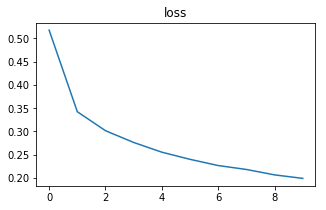

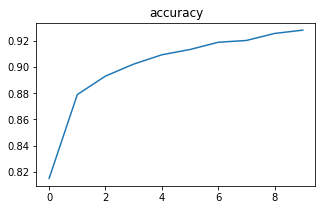

In [19]:
np.random.seed(123)
model = Sequential()
units_output = 10

# Add model here
# Convolutional layer with kernel size 3x3 and 32 output filters
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1)))
model.add(Convolution2D(32, 3, 3, activation='relu'))

# ReLU activation
model.add(Activation('relu'))

# Max pooling (2D) of size 2x2
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flatten 2D output into 1D
model.add(Flatten())

# Dense layer to 10 output units
model.add(Dense(units=units_output))

# softmax activation
model.add(Activation('softmax'))

# You can also try different optimizers below
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
print(model.summary())


# Training
epochs = 10

history = model.fit(x_train, 
                    y_train_cat, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=1)

# Plot loss and accuracy in training

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy')

# Evaluate on test set
scores = model.evaluate(x_test, y_test_cat, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

## Reparameterizations Third

/Users/adnanbajwa/Documents/master-thesis/thesis-project/version0.1/v0.1-venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(42, (3, 3), activation="relu", input_shape=(28, 28, 1...)`
  import sys


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 42)        420       
_________________________________________________________________
activation_3 (Activation)    (None, 26, 26, 42)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 42)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7098)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                70990     
_________________________________________________________________
activation_4 (Activation)    (None, 10)                0         
Total params: 71,410
Trainable params: 71,410
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15


  128/60000 [..............................] - ETA: 2:21 - loss: 2.3148 - acc: 0.0703

  384/60000 [..............................] - ETA: 1:00 - loss: 2.2253 - acc: 0.1719

  512/60000 [..............................] - ETA: 51s - loss: 2.1889 - acc: 0.1895 

  640/60000 [..............................] - ETA: 45s - loss: 2.1392 - acc: 0.2234

  896/60000 [..............................] - ETA: 37s - loss: 2.0550 - acc: 0.2679

 1152/60000 [..............................] - ETA: 33s - loss: 1.9748 - acc: 0.3281

 1408/60000 [..............................] - ETA: 30s - loss: 1.8882 - acc: 0.3743

 1536/60000 [..............................] - ETA: 30s - loss: 1.8526 - acc: 0.3939

 1664/60000 [..............................] - ETA: 29s - loss: 1.8115 - acc: 0.4117

 1920/60000 [..............................] - ETA: 28s - loss: 1.7396 - acc: 0.4411

 2176/60000 [>.............................] - ETA: 26s - loss: 1.6739 - acc: 0.4669

 2432/60000 [>.............................] - ETA: 25s - loss: 1.6191 - acc: 0.4827

 2688/60000 [>.............................] - ETA: 24s - loss: 1.5619 - acc: 0.5060

 2944/60000 [>.............................] - ETA: 23s - loss: 1.5049 - acc: 0.5258

 3072/60000 [>.............................] - ETA: 24s - loss: 1.4776 - acc: 0.5352

 3328/60000 [>.............................] - ETA: 23s - loss: 1.4330 - acc: 0.5508

 3584/60000 [>.............................] - ETA: 22s - loss: 1.3876 - acc: 0.5647

 3840/60000 [>.............................] - ETA: 22s - loss: 1.3419 - acc: 0.5792

 3968/60000 [>.............................] - ETA: 22s - loss: 1.3216 - acc: 0.5849

 4096/60000 [=>............................] - ETA: 22s - loss: 1.3088 - acc: 0.5886

 4224/60000 [=>............................] - ETA: 23s - loss: 1.2879 - acc: 0.5956

 4352/60000 [=>............................] - ETA: 23s - loss: 1.2742 - acc: 0.6000

 4608/60000 [=>............................] - ETA: 22s - loss: 1.2428 - acc: 0.6079

 4864/60000 [=>............................] - ETA: 22s - loss: 1.2115 - acc: 0.6170

 5120/60000 [=>............................] - ETA: 21s - loss: 1.1897 - acc: 0.6211

 5376/60000 [=>............................] - ETA: 21s - loss: 1.1702 - acc: 0.6254

 5632/60000 [=>............................] - ETA: 21s - loss: 1.1481 - acc: 0.6317

 5888/60000 [=>............................] - ETA: 20s - loss: 1.1261 - acc: 0.6374

 6144/60000 [==>...........................] - ETA: 20s - loss: 1.1052 - acc: 0.6437

 6400/60000 [==>...........................] - ETA: 20s - loss: 1.0842 - acc: 0.6497

 6656/60000 [==>...........................] - ETA: 20s - loss: 1.0674 - acc: 0.6553

 6912/60000 [==>...........................] - ETA: 19s - loss: 1.0547 - acc: 0.6596

 7168/60000 [==>...........................] - ETA: 19s - loss: 1.0386 - acc: 0.6636

 7424/60000 [==>...........................] - ETA: 19s - loss: 1.0247 - acc: 0.6673

 7552/60000 [==>...........................] - ETA: 19s - loss: 1.0201 - acc: 0.6690

 7808/60000 [==>...........................] - ETA: 19s - loss: 1.0073 - acc: 0.6721

 8064/60000 [===>..........................] - ETA: 19s - loss: 0.9956 - acc: 0.6745

 8320/60000 [===>..........................] - ETA: 18s - loss: 0.9865 - acc: 0.6756

 8576/60000 [===>..........................] - ETA: 18s - loss: 0.9735 - acc: 0.6803

 8832/60000 [===>..........................] - ETA: 18s - loss: 0.9650 - acc: 0.6830

 8960/60000 [===>..........................] - ETA: 18s - loss: 0.9602 - acc: 0.6842

 9088/60000 [===>..........................] - ETA: 18s - loss: 0.9545 - acc: 0.6854

 9216/60000 [===>..........................] - ETA: 18s - loss: 0.9489 - acc: 0.6875

 9344/60000 [===>..........................] - ETA: 18s - loss: 0.9434 - acc: 0.6896

 9472/60000 [===>..........................] - ETA: 18s - loss: 0.9402 - acc: 0.6918

 9600/60000 [===>..........................] - ETA: 18s - loss: 0.9345 - acc: 0.6931

 9728/60000 [===>..........................] - ETA: 18s - loss: 0.9308 - acc: 0.6941

 9856/60000 [===>..........................] - ETA: 18s - loss: 0.9285 - acc: 0.6943

 9984/60000 [===>..........................] - ETA: 18s - loss: 0.9230 - acc: 0.6958

10112/60000 [====>.........................] - ETA: 18s - loss: 0.9195 - acc: 0.6967

10240/60000 [====>.........................] - ETA: 18s - loss: 0.9154 - acc: 0.6975

10368/60000 [====>.........................] - ETA: 18s - loss: 0.9133 - acc: 0.6980

10496/60000 [====>.........................] - ETA: 18s - loss: 0.9097 - acc: 0.6993

10624/60000 [====>.........................] - ETA: 19s - loss: 0.9043 - acc: 0.7012

10752/60000 [====>.........................] - ETA: 19s - loss: 0.9026 - acc: 0.7020

10880/60000 [====>.........................] - ETA: 19s - loss: 0.9001 - acc: 0.7023

11008/60000 [====>.........................] - ETA: 19s - loss: 0.8973 - acc: 0.7030

11136/60000 [====>.........................] - ETA: 19s - loss: 0.8932 - acc: 0.7047

11264/60000 [====>.........................] - ETA: 19s - loss: 0.8898 - acc: 0.7058

11392/60000 [====>.........................] - ETA: 19s - loss: 0.8864 - acc: 0.7062

11520/60000 [====>.........................] - ETA: 19s - loss: 0.8837 - acc: 0.7068

11648/60000 [====>.........................] - ETA: 19s - loss: 0.8805 - acc: 0.7076

11776/60000 [====>.........................] - ETA: 18s - loss: 0.8786 - acc: 0.7081

11904/60000 [====>.........................] - ETA: 18s - loss: 0.8768 - acc: 0.7088

12032/60000 [=====>........................] - ETA: 18s - loss: 0.8724 - acc: 0.7108

12160/60000 [=====>........................] - ETA: 18s - loss: 0.8689 - acc: 0.7121

12288/60000 [=====>........................] - ETA: 18s - loss: 0.8657 - acc: 0.7131

12416/60000 [=====>........................] - ETA: 18s - loss: 0.8612 - acc: 0.7147

12544/60000 [=====>........................] - ETA: 18s - loss: 0.8589 - acc: 0.7153

12672/60000 [=====>........................] - ETA: 18s - loss: 0.8557 - acc: 0.7162

12800/60000 [=====>........................] - ETA: 18s - loss: 0.8531 - acc: 0.7168

12928/60000 [=====>........................] - ETA: 18s - loss: 0.8501 - acc: 0.7178

13056/60000 [=====>........................] - ETA: 18s - loss: 0.8460 - acc: 0.7193

13184/60000 [=====>........................] - ETA: 18s - loss: 0.8431 - acc: 0.7202

13312/60000 [=====>........................] - ETA: 18s - loss: 0.8401 - acc: 0.7212

13440/60000 [=====>........................] - ETA: 18s - loss: 0.8380 - acc: 0.7220

13568/60000 [=====>........................] - ETA: 18s - loss: 0.8355 - acc: 0.7227

13696/60000 [=====>........................] - ETA: 18s - loss: 0.8312 - acc: 0.7242

13824/60000 [=====>........................] - ETA: 18s - loss: 0.8276 - acc: 0.7253

13952/60000 [=====>........................] - ETA: 18s - loss: 0.8241 - acc: 0.7267

14080/60000 [======>.......................] - ETA: 18s - loss: 0.8212 - acc: 0.7277

14208/60000 [======>.......................] - ETA: 18s - loss: 0.8194 - acc: 0.7281

14336/60000 [======>.......................] - ETA: 18s - loss: 0.8170 - acc: 0.7288

14464/60000 [======>.......................] - ETA: 18s - loss: 0.8142 - acc: 0.7295

14592/60000 [======>.......................] - ETA: 18s - loss: 0.8119 - acc: 0.7302

14720/60000 [======>.......................] - ETA: 18s - loss: 0.8091 - acc: 0.7308

14848/60000 [======>.......................] - ETA: 18s - loss: 0.8075 - acc: 0.7309

14976/60000 [======>.......................] - ETA: 18s - loss: 0.8050 - acc: 0.7314

15104/60000 [======>.......................] - ETA: 18s - loss: 0.8028 - acc: 0.7320

15232/60000 [======>.......................] - ETA: 18s - loss: 0.8015 - acc: 0.7321

15360/60000 [======>.......................] - ETA: 18s - loss: 0.7987 - acc: 0.7331

15488/60000 [======>.......................] - ETA: 18s - loss: 0.7966 - acc: 0.7341

15616/60000 [======>.......................] - ETA: 18s - loss: 0.7945 - acc: 0.7345

15744/60000 [======>.......................] - ETA: 18s - loss: 0.7931 - acc: 0.7348

15872/60000 [======>.......................] - ETA: 18s - loss: 0.7908 - acc: 0.7358

16000/60000 [=======>......................] - ETA: 18s - loss: 0.7892 - acc: 0.7363

16128/60000 [=======>......................] - ETA: 18s - loss: 0.7868 - acc: 0.7370

16256/60000 [=======>......................] - ETA: 18s - loss: 0.7846 - acc: 0.7377

16384/60000 [=======>......................] - ETA: 18s - loss: 0.7831 - acc: 0.7380

16512/60000 [=======>......................] - ETA: 18s - loss: 0.7808 - acc: 0.7386

16640/60000 [=======>......................] - ETA: 18s - loss: 0.7787 - acc: 0.7394

16768/60000 [=======>......................] - ETA: 18s - loss: 0.7764 - acc: 0.7403

16896/60000 [=======>......................] - ETA: 18s - loss: 0.7745 - acc: 0.7405

17024/60000 [=======>......................] - ETA: 18s - loss: 0.7720 - acc: 0.7412

17152/60000 [=======>......................] - ETA: 18s - loss: 0.7703 - acc: 0.7417

17280/60000 [=======>......................] - ETA: 18s - loss: 0.7694 - acc: 0.7420

17408/60000 [=======>......................] - ETA: 18s - loss: 0.7674 - acc: 0.7425

17536/60000 [=======>......................] - ETA: 18s - loss: 0.7651 - acc: 0.7432

17664/60000 [=======>......................] - ETA: 18s - loss: 0.7630 - acc: 0.7439

17792/60000 [=======>......................] - ETA: 18s - loss: 0.7612 - acc: 0.7445

17920/60000 [=======>......................] - ETA: 18s - loss: 0.7596 - acc: 0.7450

18048/60000 [========>.....................] - ETA: 18s - loss: 0.7584 - acc: 0.7452

18176/60000 [========>.....................] - ETA: 18s - loss: 0.7562 - acc: 0.7459

18304/60000 [========>.....................] - ETA: 18s - loss: 0.7543 - acc: 0.7465

18432/60000 [========>.....................] - ETA: 18s - loss: 0.7524 - acc: 0.7471

18560/60000 [========>.....................] - ETA: 18s - loss: 0.7508 - acc: 0.7476

18688/60000 [========>.....................] - ETA: 18s - loss: 0.7503 - acc: 0.7476

18816/60000 [========>.....................] - ETA: 18s - loss: 0.7487 - acc: 0.7481

18944/60000 [========>.....................] - ETA: 18s - loss: 0.7471 - acc: 0.7487

19072/60000 [========>.....................] - ETA: 18s - loss: 0.7456 - acc: 0.7493

19200/60000 [========>.....................] - ETA: 18s - loss: 0.7440 - acc: 0.7498

19328/60000 [========>.....................] - ETA: 18s - loss: 0.7420 - acc: 0.7504

19456/60000 [========>.....................] - ETA: 18s - loss: 0.7403 - acc: 0.7508

19584/60000 [========>.....................] - ETA: 17s - loss: 0.7382 - acc: 0.7514

19712/60000 [========>.....................] - ETA: 17s - loss: 0.7372 - acc: 0.7517

19840/60000 [========>.....................] - ETA: 17s - loss: 0.7356 - acc: 0.7521

19968/60000 [========>.....................] - ETA: 17s - loss: 0.7334 - acc: 0.7528

20096/60000 [=========>....................] - ETA: 17s - loss: 0.7323 - acc: 0.7530

20224/60000 [=========>....................] - ETA: 17s - loss: 0.7305 - acc: 0.7537

20352/60000 [=========>....................] - ETA: 17s - loss: 0.7288 - acc: 0.7544

20480/60000 [=========>....................] - ETA: 17s - loss: 0.7272 - acc: 0.7550

20608/60000 [=========>....................] - ETA: 17s - loss: 0.7251 - acc: 0.7556

20736/60000 [=========>....................] - ETA: 17s - loss: 0.7240 - acc: 0.7562

20864/60000 [=========>....................] - ETA: 17s - loss: 0.7226 - acc: 0.7566

20992/60000 [=========>....................] - ETA: 17s - loss: 0.7210 - acc: 0.7572

21120/60000 [=========>....................] - ETA: 17s - loss: 0.7202 - acc: 0.7576

21248/60000 [=========>....................] - ETA: 17s - loss: 0.7176 - acc: 0.7585

21376/60000 [=========>....................] - ETA: 17s - loss: 0.7172 - acc: 0.7587

21504/60000 [=========>....................] - ETA: 17s - loss: 0.7153 - acc: 0.7593

21632/60000 [=========>....................] - ETA: 17s - loss: 0.7138 - acc: 0.7596

21760/60000 [=========>....................] - ETA: 17s - loss: 0.7121 - acc: 0.7603

21888/60000 [=========>....................] - ETA: 17s - loss: 0.7110 - acc: 0.7604

22016/60000 [==========>...................] - ETA: 17s - loss: 0.7101 - acc: 0.7606

22144/60000 [==========>...................] - ETA: 17s - loss: 0.7084 - acc: 0.7611

22272/60000 [==========>...................] - ETA: 17s - loss: 0.7072 - acc: 0.7616

22400/60000 [==========>...................] - ETA: 17s - loss: 0.7062 - acc: 0.7619

22528/60000 [==========>...................] - ETA: 17s - loss: 0.7058 - acc: 0.7620

22656/60000 [==========>...................] - ETA: 17s - loss: 0.7039 - acc: 0.7626

22784/60000 [==========>...................] - ETA: 17s - loss: 0.7031 - acc: 0.7629

22912/60000 [==========>...................] - ETA: 17s - loss: 0.7014 - acc: 0.7633

23040/60000 [==========>...................] - ETA: 17s - loss: 0.6999 - acc: 0.7638

23168/60000 [==========>...................] - ETA: 17s - loss: 0.6989 - acc: 0.7640

23296/60000 [==========>...................] - ETA: 16s - loss: 0.6977 - acc: 0.7641

23424/60000 [==========>...................] - ETA: 16s - loss: 0.6959 - acc: 0.7645

23552/60000 [==========>...................] - ETA: 16s - loss: 0.6942 - acc: 0.7651

23680/60000 [==========>...................] - ETA: 16s - loss: 0.6932 - acc: 0.7654

23808/60000 [==========>...................] - ETA: 16s - loss: 0.6921 - acc: 0.7657

23936/60000 [==========>...................] - ETA: 16s - loss: 0.6908 - acc: 0.7661

24064/60000 [===========>..................] - ETA: 16s - loss: 0.6901 - acc: 0.7664

24192/60000 [===========>..................] - ETA: 16s - loss: 0.6895 - acc: 0.7665

24320/60000 [===========>..................] - ETA: 16s - loss: 0.6879 - acc: 0.7669

24448/60000 [===========>..................] - ETA: 16s - loss: 0.6867 - acc: 0.7673

24576/60000 [===========>..................] - ETA: 16s - loss: 0.6853 - acc: 0.7677

24704/60000 [===========>..................] - ETA: 16s - loss: 0.6840 - acc: 0.7681

24832/60000 [===========>..................] - ETA: 16s - loss: 0.6831 - acc: 0.7685

24960/60000 [===========>..................] - ETA: 16s - loss: 0.6816 - acc: 0.7688

25088/60000 [===========>..................] - ETA: 16s - loss: 0.6805 - acc: 0.7691

25216/60000 [===========>..................] - ETA: 16s - loss: 0.6792 - acc: 0.7696

25344/60000 [===========>..................] - ETA: 16s - loss: 0.6780 - acc: 0.7700

25472/60000 [===========>..................] - ETA: 16s - loss: 0.6771 - acc: 0.7704

25600/60000 [===========>..................] - ETA: 15s - loss: 0.6758 - acc: 0.7707

25728/60000 [===========>..................] - ETA: 15s - loss: 0.6745 - acc: 0.7711

25856/60000 [===========>..................] - ETA: 15s - loss: 0.6728 - acc: 0.7717

25984/60000 [===========>..................] - ETA: 15s - loss: 0.6720 - acc: 0.7721

26112/60000 [============>.................] - ETA: 15s - loss: 0.6705 - acc: 0.7725

26240/60000 [============>.................] - ETA: 15s - loss: 0.6692 - acc: 0.7728

26368/60000 [============>.................] - ETA: 15s - loss: 0.6680 - acc: 0.7733

26496/60000 [============>.................] - ETA: 15s - loss: 0.6671 - acc: 0.7736

26624/60000 [============>.................] - ETA: 15s - loss: 0.6667 - acc: 0.7738

26752/60000 [============>.................] - ETA: 15s - loss: 0.6650 - acc: 0.7743

26880/60000 [============>.................] - ETA: 15s - loss: 0.6636 - acc: 0.7747

27008/60000 [============>.................] - ETA: 15s - loss: 0.6627 - acc: 0.7750

27136/60000 [============>.................] - ETA: 15s - loss: 0.6618 - acc: 0.7754

27264/60000 [============>.................] - ETA: 15s - loss: 0.6603 - acc: 0.7761

27392/60000 [============>.................] - ETA: 15s - loss: 0.6592 - acc: 0.7764

27520/60000 [============>.................] - ETA: 15s - loss: 0.6587 - acc: 0.7765

27648/60000 [============>.................] - ETA: 15s - loss: 0.6578 - acc: 0.7768

27776/60000 [============>.................] - ETA: 14s - loss: 0.6571 - acc: 0.7771

27904/60000 [============>.................] - ETA: 14s - loss: 0.6559 - acc: 0.7774

28032/60000 [=============>................] - ETA: 14s - loss: 0.6547 - acc: 0.7777

28160/60000 [=============>................] - ETA: 14s - loss: 0.6536 - acc: 0.7779

28288/60000 [=============>................] - ETA: 14s - loss: 0.6527 - acc: 0.7782

28416/60000 [=============>................] - ETA: 14s - loss: 0.6512 - acc: 0.7786

28544/60000 [=============>................] - ETA: 14s - loss: 0.6503 - acc: 0.7789

28672/60000 [=============>................] - ETA: 14s - loss: 0.6499 - acc: 0.7790

28800/60000 [=============>................] - ETA: 14s - loss: 0.6489 - acc: 0.7795

28928/60000 [=============>................] - ETA: 14s - loss: 0.6477 - acc: 0.7799

29056/60000 [=============>................] - ETA: 14s - loss: 0.6469 - acc: 0.7800

29184/60000 [=============>................] - ETA: 14s - loss: 0.6455 - acc: 0.7805

29312/60000 [=============>................] - ETA: 14s - loss: 0.6442 - acc: 0.7809

29440/60000 [=============>................] - ETA: 14s - loss: 0.6431 - acc: 0.7812

29568/60000 [=============>................] - ETA: 14s - loss: 0.6427 - acc: 0.7813

29696/60000 [=============>................] - ETA: 13s - loss: 0.6422 - acc: 0.7815

29824/60000 [=============>................] - ETA: 13s - loss: 0.6418 - acc: 0.7817

29952/60000 [=============>................] - ETA: 13s - loss: 0.6413 - acc: 0.7821

30080/60000 [==============>...............] - ETA: 13s - loss: 0.6403 - acc: 0.7824

30208/60000 [==============>...............] - ETA: 13s - loss: 0.6394 - acc: 0.7829

30336/60000 [==============>...............] - ETA: 13s - loss: 0.6387 - acc: 0.7831

30464/60000 [==============>...............] - ETA: 13s - loss: 0.6379 - acc: 0.7833

30592/60000 [==============>...............] - ETA: 13s - loss: 0.6371 - acc: 0.7836

30720/60000 [==============>...............] - ETA: 13s - loss: 0.6360 - acc: 0.7840

30848/60000 [==============>...............] - ETA: 13s - loss: 0.6354 - acc: 0.7841

30976/60000 [==============>...............] - ETA: 13s - loss: 0.6349 - acc: 0.7844

31104/60000 [==============>...............] - ETA: 13s - loss: 0.6340 - acc: 0.7847

31232/60000 [==============>...............] - ETA: 13s - loss: 0.6333 - acc: 0.7850

31360/60000 [==============>...............] - ETA: 13s - loss: 0.6326 - acc: 0.7853

31488/60000 [==============>...............] - ETA: 13s - loss: 0.6318 - acc: 0.7855

31616/60000 [==============>...............] - ETA: 13s - loss: 0.6308 - acc: 0.7857

31744/60000 [==============>...............] - ETA: 12s - loss: 0.6304 - acc: 0.7859

31872/60000 [==============>...............] - ETA: 12s - loss: 0.6299 - acc: 0.7861

32000/60000 [===============>..............] - ETA: 12s - loss: 0.6289 - acc: 0.7865

32128/60000 [===============>..............] - ETA: 12s - loss: 0.6286 - acc: 0.7866

32256/60000 [===============>..............] - ETA: 12s - loss: 0.6281 - acc: 0.7868

32384/60000 [===============>..............] - ETA: 12s - loss: 0.6270 - acc: 0.7871

32512/60000 [===============>..............] - ETA: 12s - loss: 0.6260 - acc: 0.7875

32640/60000 [===============>..............] - ETA: 12s - loss: 0.6255 - acc: 0.7875

32768/60000 [===============>..............] - ETA: 12s - loss: 0.6253 - acc: 0.7876

32896/60000 [===============>..............] - ETA: 12s - loss: 0.6251 - acc: 0.7875

33024/60000 [===============>..............] - ETA: 12s - loss: 0.6244 - acc: 0.7876

33152/60000 [===============>..............] - ETA: 12s - loss: 0.6237 - acc: 0.7879

33408/60000 [===============>..............] - ETA: 12s - loss: 0.6221 - acc: 0.7885

33664/60000 [===============>..............] - ETA: 11s - loss: 0.6210 - acc: 0.7889

33792/60000 [===============>..............] - ETA: 11s - loss: 0.6203 - acc: 0.7892

33920/60000 [===============>..............] - ETA: 11s - loss: 0.6197 - acc: 0.7893

34176/60000 [================>.............] - ETA: 11s - loss: 0.6187 - acc: 0.7897

34432/60000 [================>.............] - ETA: 11s - loss: 0.6173 - acc: 0.7902

34688/60000 [================>.............] - ETA: 11s - loss: 0.6158 - acc: 0.7907

34944/60000 [================>.............] - ETA: 11s - loss: 0.6146 - acc: 0.7911

35200/60000 [================>.............] - ETA: 11s - loss: 0.6135 - acc: 0.7916

35456/60000 [================>.............] - ETA: 11s - loss: 0.6120 - acc: 0.7921

35712/60000 [================>.............] - ETA: 10s - loss: 0.6107 - acc: 0.7924

35840/60000 [================>.............] - ETA: 10s - loss: 0.6103 - acc: 0.7925

35968/60000 [================>.............] - ETA: 10s - loss: 0.6095 - acc: 0.7928

36096/60000 [=================>............] - ETA: 10s - loss: 0.6092 - acc: 0.7930

36224/60000 [=================>............] - ETA: 10s - loss: 0.6084 - acc: 0.7933

36352/60000 [=================>............] - ETA: 10s - loss: 0.6078 - acc: 0.7934

36480/60000 [=================>............] - ETA: 10s - loss: 0.6077 - acc: 0.7935

36608/60000 [=================>............] - ETA: 10s - loss: 0.6071 - acc: 0.7937

36736/60000 [=================>............] - ETA: 10s - loss: 0.6069 - acc: 0.7937

36992/60000 [=================>............] - ETA: 10s - loss: 0.6055 - acc: 0.7941

37248/60000 [=================>............] - ETA: 10s - loss: 0.6041 - acc: 0.7946

37504/60000 [=================>............] - ETA: 10s - loss: 0.6033 - acc: 0.7948

37760/60000 [=================>............] - ETA: 9s - loss: 0.6022 - acc: 0.7950 

37888/60000 [=================>............] - ETA: 9s - loss: 0.6015 - acc: 0.7953

38016/60000 [==================>...........] - ETA: 9s - loss: 0.6009 - acc: 0.7954

38144/60000 [==================>...........] - ETA: 9s - loss: 0.6004 - acc: 0.7956

38400/60000 [==================>...........] - ETA: 9s - loss: 0.5990 - acc: 0.7960

38656/60000 [==================>...........] - ETA: 9s - loss: 0.5978 - acc: 0.7964

38912/60000 [==================>...........] - ETA: 9s - loss: 0.5967 - acc: 0.7967

39168/60000 [==================>...........] - ETA: 9s - loss: 0.5957 - acc: 0.7969

39424/60000 [==================>...........] - ETA: 9s - loss: 0.5943 - acc: 0.7972

39552/60000 [==================>...........] - ETA: 8s - loss: 0.5932 - acc: 0.7976

39808/60000 [==================>...........] - ETA: 8s - loss: 0.5919 - acc: 0.7980

40064/60000 [===================>..........] - ETA: 8s - loss: 0.5912 - acc: 0.7982

40320/60000 [===================>..........] - ETA: 8s - loss: 0.5897 - acc: 0.7985

40576/60000 [===================>..........] - ETA: 8s - loss: 0.5884 - acc: 0.7990

40832/60000 [===================>..........] - ETA: 8s - loss: 0.5874 - acc: 0.7994

40960/60000 [===================>..........] - ETA: 8s - loss: 0.5870 - acc: 0.7996

41088/60000 [===================>..........] - ETA: 8s - loss: 0.5862 - acc: 0.7998

41344/60000 [===================>..........] - ETA: 8s - loss: 0.5850 - acc: 0.8003

41600/60000 [===================>..........] - ETA: 7s - loss: 0.5839 - acc: 0.8007

41856/60000 [===================>..........] - ETA: 7s - loss: 0.5828 - acc: 0.8011

42112/60000 [====================>.........] - ETA: 7s - loss: 0.5814 - acc: 0.8017

42368/60000 [====================>.........] - ETA: 7s - loss: 0.5805 - acc: 0.8019

42496/60000 [====================>.........] - ETA: 7s - loss: 0.5801 - acc: 0.8021

42624/60000 [====================>.........] - ETA: 7s - loss: 0.5796 - acc: 0.8023

42880/60000 [====================>.........] - ETA: 7s - loss: 0.5785 - acc: 0.8027

43136/60000 [====================>.........] - ETA: 7s - loss: 0.5772 - acc: 0.8030

43392/60000 [====================>.........] - ETA: 7s - loss: 0.5762 - acc: 0.8033

43648/60000 [====================>.........] - ETA: 7s - loss: 0.5752 - acc: 0.8034

43904/60000 [====================>.........] - ETA: 6s - loss: 0.5740 - acc: 0.8039

44032/60000 [=====================>........] - ETA: 6s - loss: 0.5739 - acc: 0.8040

44288/60000 [=====================>........] - ETA: 6s - loss: 0.5725 - acc: 0.8043

44544/60000 [=====================>........] - ETA: 6s - loss: 0.5717 - acc: 0.8046

44800/60000 [=====================>........] - ETA: 6s - loss: 0.5706 - acc: 0.8050

45056/60000 [=====================>........] - ETA: 6s - loss: 0.5699 - acc: 0.8053

45312/60000 [=====================>........] - ETA: 6s - loss: 0.5694 - acc: 0.8055

45440/60000 [=====================>........] - ETA: 6s - loss: 0.5686 - acc: 0.8057

45568/60000 [=====================>........] - ETA: 6s - loss: 0.5681 - acc: 0.8059

45824/60000 [=====================>........] - ETA: 6s - loss: 0.5672 - acc: 0.8062

46080/60000 [======================>.......] - ETA: 5s - loss: 0.5661 - acc: 0.8067

46336/60000 [======================>.......] - ETA: 5s - loss: 0.5651 - acc: 0.8070

46592/60000 [======================>.......] - ETA: 5s - loss: 0.5639 - acc: 0.8073

46848/60000 [======================>.......] - ETA: 5s - loss: 0.5625 - acc: 0.8079

47104/60000 [======================>.......] - ETA: 5s - loss: 0.5615 - acc: 0.8083

47360/60000 [======================>.......] - ETA: 5s - loss: 0.5600 - acc: 0.8087

47616/60000 [======================>.......] - ETA: 5s - loss: 0.5591 - acc: 0.8090

47872/60000 [======================>.......] - ETA: 5s - loss: 0.5581 - acc: 0.8093

48000/60000 [=======================>......] - ETA: 5s - loss: 0.5575 - acc: 0.8095

48128/60000 [=======================>......] - ETA: 4s - loss: 0.5570 - acc: 0.8096

48384/60000 [=======================>......] - ETA: 4s - loss: 0.5561 - acc: 0.8099

48512/60000 [=======================>......] - ETA: 4s - loss: 0.5555 - acc: 0.8100

48768/60000 [=======================>......] - ETA: 4s - loss: 0.5546 - acc: 0.8102

49024/60000 [=======================>......] - ETA: 4s - loss: 0.5538 - acc: 0.8104

49280/60000 [=======================>......] - ETA: 4s - loss: 0.5526 - acc: 0.8107

49536/60000 [=======================>......] - ETA: 4s - loss: 0.5517 - acc: 0.8109

49792/60000 [=======================>......] - ETA: 4s - loss: 0.5516 - acc: 0.8109

50048/60000 [========================>.....] - ETA: 4s - loss: 0.5507 - acc: 0.8112

50176/60000 [========================>.....] - ETA: 4s - loss: 0.5503 - acc: 0.8113

50432/60000 [========================>.....] - ETA: 3s - loss: 0.5496 - acc: 0.8116

50688/60000 [========================>.....] - ETA: 3s - loss: 0.5488 - acc: 0.8118

50944/60000 [========================>.....] - ETA: 3s - loss: 0.5474 - acc: 0.8123

51200/60000 [========================>.....] - ETA: 3s - loss: 0.5471 - acc: 0.8123

51456/60000 [========================>.....] - ETA: 3s - loss: 0.5467 - acc: 0.8125

51712/60000 [========================>.....] - ETA: 3s - loss: 0.5460 - acc: 0.8127

51840/60000 [========================>.....] - ETA: 3s - loss: 0.5457 - acc: 0.8128

52096/60000 [=========================>....] - ETA: 3s - loss: 0.5450 - acc: 0.8131

52352/60000 [=========================>....] - ETA: 3s - loss: 0.5446 - acc: 0.8132

52608/60000 [=========================>....] - ETA: 3s - loss: 0.5438 - acc: 0.8135

52864/60000 [=========================>....] - ETA: 2s - loss: 0.5432 - acc: 0.8137

53120/60000 [=========================>....] - ETA: 2s - loss: 0.5425 - acc: 0.8139

53248/60000 [=========================>....] - ETA: 2s - loss: 0.5425 - acc: 0.8139

53504/60000 [=========================>....] - ETA: 2s - loss: 0.5416 - acc: 0.8142

53760/60000 [=========================>....] - ETA: 2s - loss: 0.5409 - acc: 0.8144

54016/60000 [==========================>...] - ETA: 2s - loss: 0.5402 - acc: 0.8147

54272/60000 [==========================>...] - ETA: 2s - loss: 0.5399 - acc: 0.8148

54528/60000 [==========================>...] - ETA: 2s - loss: 0.5391 - acc: 0.8152

54656/60000 [==========================>...] - ETA: 2s - loss: 0.5388 - acc: 0.8153

54912/60000 [==========================>...] - ETA: 2s - loss: 0.5384 - acc: 0.8154

55168/60000 [==========================>...] - ETA: 1s - loss: 0.5377 - acc: 0.8156

55424/60000 [==========================>...] - ETA: 1s - loss: 0.5370 - acc: 0.8157

55680/60000 [==========================>...] - ETA: 1s - loss: 0.5367 - acc: 0.8159

55936/60000 [==========================>...] - ETA: 1s - loss: 0.5359 - acc: 0.8161

56192/60000 [===========================>..] - ETA: 1s - loss: 0.5354 - acc: 0.8163

56448/60000 [===========================>..] - ETA: 1s - loss: 0.5345 - acc: 0.8166

56704/60000 [===========================>..] - ETA: 1s - loss: 0.5341 - acc: 0.8168

56960/60000 [===========================>..] - ETA: 1s - loss: 0.5333 - acc: 0.8171

57216/60000 [===========================>..] - ETA: 1s - loss: 0.5325 - acc: 0.8173

57472/60000 [===========================>..] - ETA: 1s - loss: 0.5322 - acc: 0.8175

57728/60000 [===========================>..] - ETA: 0s - loss: 0.5314 - acc: 0.8177

57984/60000 [===========================>..] - ETA: 0s - loss: 0.5304 - acc: 0.8181

58112/60000 [============================>.] - ETA: 0s - loss: 0.5299 - acc: 0.8182

58368/60000 [============================>.] - ETA: 0s - loss: 0.5292 - acc: 0.8183

58624/60000 [============================>.] - ETA: 0s - loss: 0.5286 - acc: 0.8185

58880/60000 [============================>.] - ETA: 0s - loss: 0.5279 - acc: 0.8186

59136/60000 [============================>.] - ETA: 0s - loss: 0.5273 - acc: 0.8188

59392/60000 [============================>.] - ETA: 0s - loss: 0.5262 - acc: 0.8192

59648/60000 [============================>.] - ETA: 0s - loss: 0.5257 - acc: 0.8193

59904/60000 [============================>.] - ETA: 0s - loss: 0.5254 - acc: 0.8195

60000/60000 [==============================] - 24s 400us/step - loss: 0.5253 - acc: 0.8196


Epoch 2/15
  128/60000 [..............................] - ETA: 19s - loss: 0.2823 - acc: 0.8984

  256/60000 [..............................] - ETA: 23s - loss: 0.3020 - acc: 0.8867

  512/60000 [..............................] - ETA: 21s - loss: 0.3174 - acc: 0.8770

  768/60000 [..............................] - ETA: 20s - loss: 0.3372 - acc: 0.8854

 1024/60000 [..............................] - ETA: 19s - loss: 0.3426 - acc: 0.8867

 1152/60000 [..............................] - ETA: 20s - loss: 0.3336 - acc: 0.8898

 1408/60000 [..............................] - ETA: 20s - loss: 0.3517 - acc: 0.8842

 1664/60000 [..............................] - ETA: 19s - loss: 0.3533 - acc: 0.8810

 1920/60000 [..............................] - ETA: 19s - loss: 0.3588 - acc: 0.8797

 2176/60000 [>.............................] - ETA: 19s - loss: 0.3545 - acc: 0.8791

 2432/60000 [>.............................] - ETA: 18s - loss: 0.3584 - acc: 0.8779

 2688/60000 [>.............................] - ETA: 18s - loss: 0.3604 - acc: 0.8772

 2944/60000 [>.............................] - ETA: 18s - loss: 0.3626 - acc: 0.8770

 3200/60000 [>.............................] - ETA: 18s - loss: 0.3619 - acc: 0.8772

 3456/60000 [>.............................] - ETA: 18s - loss: 0.3547 - acc: 0.8799

 3712/60000 [>.............................] - ETA: 18s - loss: 0.3571 - acc: 0.8774

 3968/60000 [>.............................] - ETA: 17s - loss: 0.3506 - acc: 0.8795

 4224/60000 [=>............................] - ETA: 17s - loss: 0.3484 - acc: 0.8802

 4480/60000 [=>............................] - ETA: 17s - loss: 0.3461 - acc: 0.8821

 4736/60000 [=>............................] - ETA: 17s - loss: 0.3438 - acc: 0.8832

 4992/60000 [=>............................] - ETA: 17s - loss: 0.3437 - acc: 0.8836

 5248/60000 [=>............................] - ETA: 17s - loss: 0.3426 - acc: 0.8847

 5504/60000 [=>............................] - ETA: 17s - loss: 0.3428 - acc: 0.8841

 5760/60000 [=>............................] - ETA: 17s - loss: 0.3438 - acc: 0.8825

 6016/60000 [==>...........................] - ETA: 17s - loss: 0.3492 - acc: 0.8812

 6272/60000 [==>...........................] - ETA: 16s - loss: 0.3476 - acc: 0.8817

 6528/60000 [==>...........................] - ETA: 16s - loss: 0.3474 - acc: 0.8813

 6784/60000 [==>...........................] - ETA: 16s - loss: 0.3469 - acc: 0.8821

 7040/60000 [==>...........................] - ETA: 16s - loss: 0.3499 - acc: 0.8815

 7296/60000 [==>...........................] - ETA: 16s - loss: 0.3529 - acc: 0.8809

 7552/60000 [==>...........................] - ETA: 16s - loss: 0.3574 - acc: 0.8791

 7680/60000 [==>...........................] - ETA: 16s - loss: 0.3585 - acc: 0.8792

 7936/60000 [==>...........................] - ETA: 16s - loss: 0.3587 - acc: 0.8789

 8192/60000 [===>..........................] - ETA: 16s - loss: 0.3594 - acc: 0.8787

 8448/60000 [===>..........................] - ETA: 16s - loss: 0.3589 - acc: 0.8783

 8704/60000 [===>..........................] - ETA: 16s - loss: 0.3596 - acc: 0.8772

 8960/60000 [===>..........................] - ETA: 15s - loss: 0.3601 - acc: 0.8766

 9216/60000 [===>..........................] - ETA: 15s - loss: 0.3598 - acc: 0.8765

 9472/60000 [===>..........................] - ETA: 15s - loss: 0.3611 - acc: 0.8766

 9728/60000 [===>..........................] - ETA: 15s - loss: 0.3606 - acc: 0.8771

 9984/60000 [===>..........................] - ETA: 15s - loss: 0.3614 - acc: 0.8768

10240/60000 [====>.........................] - ETA: 15s - loss: 0.3616 - acc: 0.8771

10496/60000 [====>.........................] - ETA: 15s - loss: 0.3600 - acc: 0.8775

10752/60000 [====>.........................] - ETA: 15s - loss: 0.3599 - acc: 0.8772

10880/60000 [====>.........................] - ETA: 15s - loss: 0.3602 - acc: 0.8775

11136/60000 [====>.........................] - ETA: 15s - loss: 0.3598 - acc: 0.8775

11392/60000 [====>.........................] - ETA: 15s - loss: 0.3600 - acc: 0.8768

11648/60000 [====>.........................] - ETA: 15s - loss: 0.3590 - acc: 0.8766

11904/60000 [====>.........................] - ETA: 15s - loss: 0.3594 - acc: 0.8764

12160/60000 [=====>........................] - ETA: 14s - loss: 0.3586 - acc: 0.8769

12416/60000 [=====>........................] - ETA: 14s - loss: 0.3595 - acc: 0.8763

12672/60000 [=====>........................] - ETA: 14s - loss: 0.3601 - acc: 0.8762

12928/60000 [=====>........................] - ETA: 14s - loss: 0.3598 - acc: 0.8762

13184/60000 [=====>........................] - ETA: 14s - loss: 0.3582 - acc: 0.8769

13440/60000 [=====>........................] - ETA: 14s - loss: 0.3583 - acc: 0.8767

13696/60000 [=====>........................] - ETA: 14s - loss: 0.3596 - acc: 0.8758

13952/60000 [=====>........................] - ETA: 14s - loss: 0.3596 - acc: 0.8754

14208/60000 [======>.......................] - ETA: 14s - loss: 0.3592 - acc: 0.8755

14464/60000 [======>.......................] - ETA: 14s - loss: 0.3598 - acc: 0.8752

14720/60000 [======>.......................] - ETA: 14s - loss: 0.3599 - acc: 0.8752

14976/60000 [======>.......................] - ETA: 14s - loss: 0.3597 - acc: 0.8751

15232/60000 [======>.......................] - ETA: 13s - loss: 0.3609 - acc: 0.8751

15488/60000 [======>.......................] - ETA: 13s - loss: 0.3617 - acc: 0.8746

15616/60000 [======>.......................] - ETA: 13s - loss: 0.3628 - acc: 0.8744

15744/60000 [======>.......................] - ETA: 13s - loss: 0.3631 - acc: 0.8740

16000/60000 [=======>......................] - ETA: 13s - loss: 0.3619 - acc: 0.8746

16256/60000 [=======>......................] - ETA: 13s - loss: 0.3612 - acc: 0.8748

16512/60000 [=======>......................] - ETA: 13s - loss: 0.3607 - acc: 0.8751

16768/60000 [=======>......................] - ETA: 13s - loss: 0.3621 - acc: 0.8745

17024/60000 [=======>......................] - ETA: 13s - loss: 0.3615 - acc: 0.8748

17280/60000 [=======>......................] - ETA: 13s - loss: 0.3609 - acc: 0.8750

17536/60000 [=======>......................] - ETA: 13s - loss: 0.3597 - acc: 0.8753

17792/60000 [=======>......................] - ETA: 13s - loss: 0.3598 - acc: 0.8750

18048/60000 [========>.....................] - ETA: 13s - loss: 0.3596 - acc: 0.8751

18304/60000 [========>.....................] - ETA: 13s - loss: 0.3610 - acc: 0.8744

18560/60000 [========>.....................] - ETA: 12s - loss: 0.3603 - acc: 0.8746

18816/60000 [========>.....................] - ETA: 12s - loss: 0.3610 - acc: 0.8745

18944/60000 [========>.....................] - ETA: 12s - loss: 0.3609 - acc: 0.8747

19200/60000 [========>.....................] - ETA: 12s - loss: 0.3606 - acc: 0.8748

19456/60000 [========>.....................] - ETA: 12s - loss: 0.3605 - acc: 0.8752

19712/60000 [========>.....................] - ETA: 12s - loss: 0.3594 - acc: 0.8752

19968/60000 [========>.....................] - ETA: 12s - loss: 0.3581 - acc: 0.8757

20224/60000 [=========>....................] - ETA: 12s - loss: 0.3586 - acc: 0.8760

20480/60000 [=========>....................] - ETA: 12s - loss: 0.3584 - acc: 0.8760

20736/60000 [=========>....................] - ETA: 12s - loss: 0.3577 - acc: 0.8760

20992/60000 [=========>....................] - ETA: 12s - loss: 0.3580 - acc: 0.8758

21248/60000 [=========>....................] - ETA: 12s - loss: 0.3576 - acc: 0.8761

21504/60000 [=========>....................] - ETA: 12s - loss: 0.3569 - acc: 0.8763

21760/60000 [=========>....................] - ETA: 11s - loss: 0.3566 - acc: 0.8766

22016/60000 [==========>...................] - ETA: 11s - loss: 0.3562 - acc: 0.8767

22144/60000 [==========>...................] - ETA: 11s - loss: 0.3567 - acc: 0.8763

22400/60000 [==========>...................] - ETA: 11s - loss: 0.3578 - acc: 0.8760

22656/60000 [==========>...................] - ETA: 11s - loss: 0.3578 - acc: 0.8761

22912/60000 [==========>...................] - ETA: 11s - loss: 0.3574 - acc: 0.8763

23168/60000 [==========>...................] - ETA: 11s - loss: 0.3583 - acc: 0.8763

23424/60000 [==========>...................] - ETA: 11s - loss: 0.3584 - acc: 0.8762

23680/60000 [==========>...................] - ETA: 11s - loss: 0.3585 - acc: 0.8765

23936/60000 [==========>...................] - ETA: 11s - loss: 0.3582 - acc: 0.8767

24192/60000 [===========>..................] - ETA: 11s - loss: 0.3589 - acc: 0.8765

24448/60000 [===========>..................] - ETA: 11s - loss: 0.3586 - acc: 0.8767

24704/60000 [===========>..................] - ETA: 11s - loss: 0.3579 - acc: 0.8771

24960/60000 [===========>..................] - ETA: 10s - loss: 0.3576 - acc: 0.8772

25216/60000 [===========>..................] - ETA: 10s - loss: 0.3571 - acc: 0.8776

25344/60000 [===========>..................] - ETA: 10s - loss: 0.3568 - acc: 0.8777

25472/60000 [===========>..................] - ETA: 10s - loss: 0.3570 - acc: 0.8777

25728/60000 [===========>..................] - ETA: 10s - loss: 0.3572 - acc: 0.8776

25984/60000 [===========>..................] - ETA: 10s - loss: 0.3572 - acc: 0.8777

26240/60000 [============>.................] - ETA: 10s - loss: 0.3568 - acc: 0.8778

26496/60000 [============>.................] - ETA: 10s - loss: 0.3576 - acc: 0.8777

26752/60000 [============>.................] - ETA: 10s - loss: 0.3580 - acc: 0.8775

27008/60000 [============>.................] - ETA: 10s - loss: 0.3577 - acc: 0.8779

27264/60000 [============>.................] - ETA: 10s - loss: 0.3568 - acc: 0.8783

27520/60000 [============>.................] - ETA: 10s - loss: 0.3566 - acc: 0.8783

27776/60000 [============>.................] - ETA: 10s - loss: 0.3567 - acc: 0.8780

28032/60000 [=============>................] - ETA: 10s - loss: 0.3569 - acc: 0.8779

28288/60000 [=============>................] - ETA: 9s - loss: 0.3570 - acc: 0.8778 

28416/60000 [=============>................] - ETA: 9s - loss: 0.3566 - acc: 0.8780

28672/60000 [=============>................] - ETA: 9s - loss: 0.3560 - acc: 0.8781

28928/60000 [=============>................] - ETA: 9s - loss: 0.3559 - acc: 0.8782

29184/60000 [=============>................] - ETA: 9s - loss: 0.3568 - acc: 0.8776

29440/60000 [=============>................] - ETA: 9s - loss: 0.3578 - acc: 0.8774

29696/60000 [=============>................] - ETA: 9s - loss: 0.3579 - acc: 0.8774

29952/60000 [=============>................] - ETA: 9s - loss: 0.3576 - acc: 0.8775

30080/60000 [==============>...............] - ETA: 9s - loss: 0.3576 - acc: 0.8774

30336/60000 [==============>...............] - ETA: 9s - loss: 0.3581 - acc: 0.8773

30592/60000 [==============>...............] - ETA: 9s - loss: 0.3576 - acc: 0.8775

30848/60000 [==============>...............] - ETA: 9s - loss: 0.3572 - acc: 0.8776

31104/60000 [==============>...............] - ETA: 9s - loss: 0.3568 - acc: 0.8777

31360/60000 [==============>...............] - ETA: 8s - loss: 0.3569 - acc: 0.8774

31616/60000 [==============>...............] - ETA: 8s - loss: 0.3569 - acc: 0.8773

31744/60000 [==============>...............] - ETA: 8s - loss: 0.3568 - acc: 0.8773

31872/60000 [==============>...............] - ETA: 8s - loss: 0.3569 - acc: 0.8773

32128/60000 [===============>..............] - ETA: 8s - loss: 0.3576 - acc: 0.8771

32384/60000 [===============>..............] - ETA: 8s - loss: 0.3575 - acc: 0.8771

32640/60000 [===============>..............] - ETA: 8s - loss: 0.3583 - acc: 0.8767

32896/60000 [===============>..............] - ETA: 8s - loss: 0.3590 - acc: 0.8765

33152/60000 [===============>..............] - ETA: 8s - loss: 0.3586 - acc: 0.8766

33408/60000 [===============>..............] - ETA: 8s - loss: 0.3589 - acc: 0.8766

33664/60000 [===============>..............] - ETA: 8s - loss: 0.3586 - acc: 0.8768

33920/60000 [===============>..............] - ETA: 8s - loss: 0.3588 - acc: 0.8767

34176/60000 [================>.............] - ETA: 8s - loss: 0.3589 - acc: 0.8767

34432/60000 [================>.............] - ETA: 8s - loss: 0.3594 - acc: 0.8765

34688/60000 [================>.............] - ETA: 7s - loss: 0.3592 - acc: 0.8766

34816/60000 [================>.............] - ETA: 7s - loss: 0.3588 - acc: 0.8767

35072/60000 [================>.............] - ETA: 7s - loss: 0.3588 - acc: 0.8767

35328/60000 [================>.............] - ETA: 7s - loss: 0.3584 - acc: 0.8768

35584/60000 [================>.............] - ETA: 7s - loss: 0.3581 - acc: 0.8769

35840/60000 [================>.............] - ETA: 7s - loss: 0.3579 - acc: 0.8772

36096/60000 [=================>............] - ETA: 7s - loss: 0.3581 - acc: 0.8771

36352/60000 [=================>............] - ETA: 7s - loss: 0.3580 - acc: 0.8771

36608/60000 [=================>............] - ETA: 7s - loss: 0.3576 - acc: 0.8773

36864/60000 [=================>............] - ETA: 7s - loss: 0.3577 - acc: 0.8773

37120/60000 [=================>............] - ETA: 7s - loss: 0.3577 - acc: 0.8773

37376/60000 [=================>............] - ETA: 7s - loss: 0.3576 - acc: 0.8773

37632/60000 [=================>............] - ETA: 7s - loss: 0.3578 - acc: 0.8773

37888/60000 [=================>............] - ETA: 6s - loss: 0.3580 - acc: 0.8771

38016/60000 [==================>...........] - ETA: 6s - loss: 0.3581 - acc: 0.8772

38272/60000 [==================>...........] - ETA: 6s - loss: 0.3584 - acc: 0.8770

38528/60000 [==================>...........] - ETA: 6s - loss: 0.3582 - acc: 0.8772

38784/60000 [==================>...........] - ETA: 6s - loss: 0.3575 - acc: 0.8774

39040/60000 [==================>...........] - ETA: 6s - loss: 0.3580 - acc: 0.8770

39296/60000 [==================>...........] - ETA: 6s - loss: 0.3578 - acc: 0.8772

39552/60000 [==================>...........] - ETA: 6s - loss: 0.3576 - acc: 0.8771

39808/60000 [==================>...........] - ETA: 6s - loss: 0.3576 - acc: 0.8770

40064/60000 [===================>..........] - ETA: 6s - loss: 0.3571 - acc: 0.8773

40320/60000 [===================>..........] - ETA: 6s - loss: 0.3571 - acc: 0.8774

40576/60000 [===================>..........] - ETA: 6s - loss: 0.3568 - acc: 0.8776

40832/60000 [===================>..........] - ETA: 6s - loss: 0.3566 - acc: 0.8776

41088/60000 [===================>..........] - ETA: 5s - loss: 0.3566 - acc: 0.8774

41216/60000 [===================>..........] - ETA: 5s - loss: 0.3566 - acc: 0.8775

41472/60000 [===================>..........] - ETA: 5s - loss: 0.3566 - acc: 0.8774

41728/60000 [===================>..........] - ETA: 5s - loss: 0.3565 - acc: 0.8773

41984/60000 [===================>..........] - ETA: 5s - loss: 0.3563 - acc: 0.8773

42240/60000 [====================>.........] - ETA: 5s - loss: 0.3563 - acc: 0.8773

42496/60000 [====================>.........] - ETA: 5s - loss: 0.3559 - acc: 0.8774

42752/60000 [====================>.........] - ETA: 5s - loss: 0.3559 - acc: 0.8773

43008/60000 [====================>.........] - ETA: 5s - loss: 0.3562 - acc: 0.8771

43264/60000 [====================>.........] - ETA: 5s - loss: 0.3558 - acc: 0.8773

43520/60000 [====================>.........] - ETA: 5s - loss: 0.3552 - acc: 0.8776

43776/60000 [====================>.........] - ETA: 5s - loss: 0.3551 - acc: 0.8777

44032/60000 [=====================>........] - ETA: 5s - loss: 0.3551 - acc: 0.8776

44288/60000 [=====================>........] - ETA: 4s - loss: 0.3551 - acc: 0.8776

44544/60000 [=====================>........] - ETA: 4s - loss: 0.3547 - acc: 0.8778

44800/60000 [=====================>........] - ETA: 4s - loss: 0.3548 - acc: 0.8777

45056/60000 [=====================>........] - ETA: 4s - loss: 0.3553 - acc: 0.8775

45312/60000 [=====================>........] - ETA: 4s - loss: 0.3549 - acc: 0.8776

45568/60000 [=====================>........] - ETA: 4s - loss: 0.3548 - acc: 0.8777

45824/60000 [=====================>........] - ETA: 4s - loss: 0.3546 - acc: 0.8776

46080/60000 [======================>.......] - ETA: 4s - loss: 0.3544 - acc: 0.8776

46336/60000 [======================>.......] - ETA: 4s - loss: 0.3546 - acc: 0.8776

46592/60000 [======================>.......] - ETA: 4s - loss: 0.3548 - acc: 0.8775

46848/60000 [======================>.......] - ETA: 4s - loss: 0.3544 - acc: 0.8776

47104/60000 [======================>.......] - ETA: 4s - loss: 0.3539 - acc: 0.8779

47360/60000 [======================>.......] - ETA: 3s - loss: 0.3539 - acc: 0.8779

47616/60000 [======================>.......] - ETA: 3s - loss: 0.3538 - acc: 0.8780

47744/60000 [======================>.......] - ETA: 3s - loss: 0.3539 - acc: 0.8780

48000/60000 [=======================>......] - ETA: 3s - loss: 0.3536 - acc: 0.8781

48256/60000 [=======================>......] - ETA: 3s - loss: 0.3540 - acc: 0.8780

48512/60000 [=======================>......] - ETA: 3s - loss: 0.3539 - acc: 0.8779

48768/60000 [=======================>......] - ETA: 3s - loss: 0.3539 - acc: 0.8779

49024/60000 [=======================>......] - ETA: 3s - loss: 0.3537 - acc: 0.8780

49280/60000 [=======================>......] - ETA: 3s - loss: 0.3534 - acc: 0.8780

49536/60000 [=======================>......] - ETA: 3s - loss: 0.3531 - acc: 0.8780

49792/60000 [=======================>......] - ETA: 3s - loss: 0.3528 - acc: 0.8781

50048/60000 [========================>.....] - ETA: 3s - loss: 0.3527 - acc: 0.8780

50304/60000 [========================>.....] - ETA: 3s - loss: 0.3522 - acc: 0.8782

50560/60000 [========================>.....] - ETA: 2s - loss: 0.3521 - acc: 0.8782

50816/60000 [========================>.....] - ETA: 2s - loss: 0.3516 - acc: 0.8784

50944/60000 [========================>.....] - ETA: 2s - loss: 0.3516 - acc: 0.8784

51200/60000 [========================>.....] - ETA: 2s - loss: 0.3518 - acc: 0.8784

51456/60000 [========================>.....] - ETA: 2s - loss: 0.3517 - acc: 0.8785

51712/60000 [========================>.....] - ETA: 2s - loss: 0.3514 - acc: 0.8787

51968/60000 [========================>.....] - ETA: 2s - loss: 0.3516 - acc: 0.8787

52224/60000 [=========================>....] - ETA: 2s - loss: 0.3512 - acc: 0.8788

52480/60000 [=========================>....] - ETA: 2s - loss: 0.3513 - acc: 0.8788

52736/60000 [=========================>....] - ETA: 2s - loss: 0.3509 - acc: 0.8790

52992/60000 [=========================>....] - ETA: 2s - loss: 0.3509 - acc: 0.8789

53248/60000 [=========================>....] - ETA: 2s - loss: 0.3511 - acc: 0.8788

53504/60000 [=========================>....] - ETA: 2s - loss: 0.3508 - acc: 0.8789

53760/60000 [=========================>....] - ETA: 1s - loss: 0.3507 - acc: 0.8788

54016/60000 [==========================>...] - ETA: 1s - loss: 0.3507 - acc: 0.8789

54144/60000 [==========================>...] - ETA: 1s - loss: 0.3506 - acc: 0.8789

54400/60000 [==========================>...] - ETA: 1s - loss: 0.3508 - acc: 0.8789

54656/60000 [==========================>...] - ETA: 1s - loss: 0.3506 - acc: 0.8789

54912/60000 [==========================>...] - ETA: 1s - loss: 0.3504 - acc: 0.8790

55168/60000 [==========================>...] - ETA: 1s - loss: 0.3503 - acc: 0.8791

55424/60000 [==========================>...] - ETA: 1s - loss: 0.3504 - acc: 0.8791

55680/60000 [==========================>...] - ETA: 1s - loss: 0.3503 - acc: 0.8791

55808/60000 [==========================>...] - ETA: 1s - loss: 0.3503 - acc: 0.8791

56064/60000 [===========================>..] - ETA: 1s - loss: 0.3503 - acc: 0.8790

56320/60000 [===========================>..] - ETA: 1s - loss: 0.3503 - acc: 0.8788

56576/60000 [===========================>..] - ETA: 1s - loss: 0.3504 - acc: 0.8788

56832/60000 [===========================>..] - ETA: 0s - loss: 0.3507 - acc: 0.8787

57088/60000 [===========================>..] - ETA: 0s - loss: 0.3507 - acc: 0.8787

57344/60000 [===========================>..] - ETA: 0s - loss: 0.3505 - acc: 0.8789

57600/60000 [===========================>..] - ETA: 0s - loss: 0.3499 - acc: 0.8791

57856/60000 [===========================>..] - ETA: 0s - loss: 0.3497 - acc: 0.8793

58112/60000 [============================>.] - ETA: 0s - loss: 0.3495 - acc: 0.8794

58368/60000 [============================>.] - ETA: 0s - loss: 0.3492 - acc: 0.8794

58624/60000 [============================>.] - ETA: 0s - loss: 0.3496 - acc: 0.8793

58880/60000 [============================>.] - ETA: 0s - loss: 0.3496 - acc: 0.8793

59008/60000 [============================>.] - ETA: 0s - loss: 0.3496 - acc: 0.8793

59264/60000 [============================>.] - ETA: 0s - loss: 0.3495 - acc: 0.8793

59520/60000 [============================>.] - ETA: 0s - loss: 0.3493 - acc: 0.8793

59776/60000 [============================>.] - ETA: 0s - loss: 0.3494 - acc: 0.8793

60000/60000 [==============================] - 19s 313us/step - loss: 0.3492 - acc: 0.8794


Epoch 3/15
  128/60000 [..............................] - ETA: 18s - loss: 0.3159 - acc: 0.8984

  256/60000 [..............................] - ETA: 23s - loss: 0.3128 - acc: 0.8945

  384/60000 [..............................] - ETA: 24s - loss: 0.3405 - acc: 0.8880

  512/60000 [..............................] - ETA: 24s - loss: 0.3074 - acc: 0.9004

  768/60000 [..............................] - ETA: 22s - loss: 0.3418 - acc: 0.8906

 1024/60000 [..............................] - ETA: 21s - loss: 0.3481 - acc: 0.8857

 1280/60000 [..............................] - ETA: 20s - loss: 0.3469 - acc: 0.8867

 1536/60000 [..............................] - ETA: 19s - loss: 0.3426 - acc: 0.8841

 1792/60000 [..............................] - ETA: 19s - loss: 0.3357 - acc: 0.8850

 1920/60000 [..............................] - ETA: 19s - loss: 0.3352 - acc: 0.8854

 2176/60000 [>.............................] - ETA: 19s - loss: 0.3344 - acc: 0.8869

 2432/60000 [>.............................] - ETA: 19s - loss: 0.3288 - acc: 0.8898

 2688/60000 [>.............................] - ETA: 18s - loss: 0.3328 - acc: 0.8880

 2944/60000 [>.............................] - ETA: 18s - loss: 0.3302 - acc: 0.8876

 3200/60000 [>.............................] - ETA: 18s - loss: 0.3285 - acc: 0.8866

 3456/60000 [>.............................] - ETA: 18s - loss: 0.3290 - acc: 0.8860

 3584/60000 [>.............................] - ETA: 18s - loss: 0.3262 - acc: 0.8862

 3840/60000 [>.............................] - ETA: 18s - loss: 0.3226 - acc: 0.8870

 4096/60000 [=>............................] - ETA: 18s - loss: 0.3197 - acc: 0.8877

 4352/60000 [=>............................] - ETA: 18s - loss: 0.3183 - acc: 0.8888

 4608/60000 [=>............................] - ETA: 17s - loss: 0.3182 - acc: 0.8898

 4864/60000 [=>............................] - ETA: 17s - loss: 0.3190 - acc: 0.8902

 5120/60000 [=>............................] - ETA: 17s - loss: 0.3233 - acc: 0.8889

 5376/60000 [=>............................] - ETA: 17s - loss: 0.3240 - acc: 0.8880

 5632/60000 [=>............................] - ETA: 17s - loss: 0.3207 - acc: 0.8894

 5888/60000 [=>............................] - ETA: 17s - loss: 0.3223 - acc: 0.8899

 6144/60000 [==>...........................] - ETA: 17s - loss: 0.3236 - acc: 0.8893

 6400/60000 [==>...........................] - ETA: 17s - loss: 0.3243 - acc: 0.8884

 6656/60000 [==>...........................] - ETA: 17s - loss: 0.3265 - acc: 0.8872

 6784/60000 [==>...........................] - ETA: 17s - loss: 0.3275 - acc: 0.8866

 7040/60000 [==>...........................] - ETA: 16s - loss: 0.3290 - acc: 0.8864

 7296/60000 [==>...........................] - ETA: 16s - loss: 0.3277 - acc: 0.8869

 7552/60000 [==>...........................] - ETA: 16s - loss: 0.3271 - acc: 0.8867

 7808/60000 [==>...........................] - ETA: 16s - loss: 0.3269 - acc: 0.8869

 8064/60000 [===>..........................] - ETA: 16s - loss: 0.3260 - acc: 0.8874

 8320/60000 [===>..........................] - ETA: 16s - loss: 0.3255 - acc: 0.8874

 8576/60000 [===>..........................] - ETA: 16s - loss: 0.3266 - acc: 0.8871

 8832/60000 [===>..........................] - ETA: 16s - loss: 0.3278 - acc: 0.8869

 9088/60000 [===>..........................] - ETA: 16s - loss: 0.3285 - acc: 0.8861

 9344/60000 [===>..........................] - ETA: 16s - loss: 0.3275 - acc: 0.8861

 9600/60000 [===>..........................] - ETA: 16s - loss: 0.3280 - acc: 0.8861

 9856/60000 [===>..........................] - ETA: 15s - loss: 0.3265 - acc: 0.8868

 9984/60000 [===>..........................] - ETA: 15s - loss: 0.3266 - acc: 0.8863

10112/60000 [====>.........................] - ETA: 15s - loss: 0.3290 - acc: 0.8855

10368/60000 [====>.........................] - ETA: 15s - loss: 0.3279 - acc: 0.8858

10624/60000 [====>.........................] - ETA: 15s - loss: 0.3266 - acc: 0.8864

10880/60000 [====>.........................] - ETA: 15s - loss: 0.3269 - acc: 0.8860

11136/60000 [====>.........................] - ETA: 15s - loss: 0.3271 - acc: 0.8860

11392/60000 [====>.........................] - ETA: 15s - loss: 0.3266 - acc: 0.8862

11648/60000 [====>.........................] - ETA: 15s - loss: 0.3263 - acc: 0.8865

11904/60000 [====>.........................] - ETA: 15s - loss: 0.3257 - acc: 0.8863

12160/60000 [=====>........................] - ETA: 15s - loss: 0.3249 - acc: 0.8868

12416/60000 [=====>........................] - ETA: 15s - loss: 0.3246 - acc: 0.8864

12672/60000 [=====>........................] - ETA: 15s - loss: 0.3246 - acc: 0.8864

12928/60000 [=====>........................] - ETA: 14s - loss: 0.3249 - acc: 0.8864

13056/60000 [=====>........................] - ETA: 14s - loss: 0.3241 - acc: 0.8866

13184/60000 [=====>........................] - ETA: 14s - loss: 0.3236 - acc: 0.8867

13312/60000 [=====>........................] - ETA: 14s - loss: 0.3232 - acc: 0.8869

13568/60000 [=====>........................] - ETA: 14s - loss: 0.3242 - acc: 0.8863

13824/60000 [=====>........................] - ETA: 14s - loss: 0.3238 - acc: 0.8869

14080/60000 [======>.......................] - ETA: 14s - loss: 0.3236 - acc: 0.8870

14336/60000 [======>.......................] - ETA: 14s - loss: 0.3235 - acc: 0.8873

14592/60000 [======>.......................] - ETA: 14s - loss: 0.3232 - acc: 0.8872

14848/60000 [======>.......................] - ETA: 14s - loss: 0.3231 - acc: 0.8876

15104/60000 [======>.......................] - ETA: 14s - loss: 0.3228 - acc: 0.8874

15360/60000 [======>.......................] - ETA: 14s - loss: 0.3229 - acc: 0.8872

15616/60000 [======>.......................] - ETA: 14s - loss: 0.3222 - acc: 0.8877

15872/60000 [======>.......................] - ETA: 14s - loss: 0.3219 - acc: 0.8879

16128/60000 [=======>......................] - ETA: 13s - loss: 0.3211 - acc: 0.8881

16256/60000 [=======>......................] - ETA: 13s - loss: 0.3211 - acc: 0.8882

16512/60000 [=======>......................] - ETA: 13s - loss: 0.3204 - acc: 0.8883

16768/60000 [=======>......................] - ETA: 13s - loss: 0.3204 - acc: 0.8882

17024/60000 [=======>......................] - ETA: 13s - loss: 0.3197 - acc: 0.8887

17280/60000 [=======>......................] - ETA: 13s - loss: 0.3191 - acc: 0.8888

17536/60000 [=======>......................] - ETA: 13s - loss: 0.3198 - acc: 0.8887

17792/60000 [=======>......................] - ETA: 13s - loss: 0.3191 - acc: 0.8891

18048/60000 [========>.....................] - ETA: 13s - loss: 0.3186 - acc: 0.8893

18304/60000 [========>.....................] - ETA: 13s - loss: 0.3180 - acc: 0.8895

18560/60000 [========>.....................] - ETA: 13s - loss: 0.3183 - acc: 0.8895

18816/60000 [========>.....................] - ETA: 13s - loss: 0.3186 - acc: 0.8889

19072/60000 [========>.....................] - ETA: 13s - loss: 0.3174 - acc: 0.8891

19328/60000 [========>.....................] - ETA: 12s - loss: 0.3175 - acc: 0.8891

19584/60000 [========>.....................] - ETA: 12s - loss: 0.3179 - acc: 0.8887

19840/60000 [========>.....................] - ETA: 12s - loss: 0.3163 - acc: 0.8893

20096/60000 [=========>....................] - ETA: 12s - loss: 0.3164 - acc: 0.8892

20352/60000 [=========>....................] - ETA: 12s - loss: 0.3174 - acc: 0.8889

20608/60000 [=========>....................] - ETA: 12s - loss: 0.3175 - acc: 0.8888

20864/60000 [=========>....................] - ETA: 12s - loss: 0.3189 - acc: 0.8881

21120/60000 [=========>....................] - ETA: 12s - loss: 0.3190 - acc: 0.8883

21376/60000 [=========>....................] - ETA: 12s - loss: 0.3189 - acc: 0.8881

21632/60000 [=========>....................] - ETA: 12s - loss: 0.3188 - acc: 0.8883

21888/60000 [=========>....................] - ETA: 12s - loss: 0.3188 - acc: 0.8881

22144/60000 [==========>...................] - ETA: 11s - loss: 0.3186 - acc: 0.8883

22400/60000 [==========>...................] - ETA: 11s - loss: 0.3180 - acc: 0.8883

22656/60000 [==========>...................] - ETA: 11s - loss: 0.3168 - acc: 0.8887

22784/60000 [==========>...................] - ETA: 11s - loss: 0.3171 - acc: 0.8888

23040/60000 [==========>...................] - ETA: 11s - loss: 0.3178 - acc: 0.8886

23296/60000 [==========>...................] - ETA: 11s - loss: 0.3177 - acc: 0.8885

23552/60000 [==========>...................] - ETA: 11s - loss: 0.3175 - acc: 0.8887

23808/60000 [==========>...................] - ETA: 11s - loss: 0.3179 - acc: 0.8886

24064/60000 [===========>..................] - ETA: 11s - loss: 0.3184 - acc: 0.8883

24320/60000 [===========>..................] - ETA: 11s - loss: 0.3179 - acc: 0.8887

24576/60000 [===========>..................] - ETA: 11s - loss: 0.3178 - acc: 0.8888

24832/60000 [===========>..................] - ETA: 11s - loss: 0.3177 - acc: 0.8889

25088/60000 [===========>..................] - ETA: 11s - loss: 0.3176 - acc: 0.8890

25344/60000 [===========>..................] - ETA: 10s - loss: 0.3175 - acc: 0.8889

25600/60000 [===========>..................] - ETA: 10s - loss: 0.3170 - acc: 0.8894

25856/60000 [===========>..................] - ETA: 10s - loss: 0.3165 - acc: 0.8895

26112/60000 [============>.................] - ETA: 10s - loss: 0.3165 - acc: 0.8897

26368/60000 [============>.................] - ETA: 10s - loss: 0.3161 - acc: 0.8902

26624/60000 [============>.................] - ETA: 10s - loss: 0.3163 - acc: 0.8901

26880/60000 [============>.................] - ETA: 10s - loss: 0.3156 - acc: 0.8904

27136/60000 [============>.................] - ETA: 10s - loss: 0.3159 - acc: 0.8902

27392/60000 [============>.................] - ETA: 10s - loss: 0.3164 - acc: 0.8900

27520/60000 [============>.................] - ETA: 10s - loss: 0.3161 - acc: 0.8900

27648/60000 [============>.................] - ETA: 10s - loss: 0.3163 - acc: 0.8900

27904/60000 [============>.................] - ETA: 10s - loss: 0.3167 - acc: 0.8898

28160/60000 [=============>................] - ETA: 10s - loss: 0.3166 - acc: 0.8898

28416/60000 [=============>................] - ETA: 10s - loss: 0.3161 - acc: 0.8900

28672/60000 [=============>................] - ETA: 9s - loss: 0.3160 - acc: 0.8901 

28928/60000 [=============>................] - ETA: 9s - loss: 0.3163 - acc: 0.8901

29056/60000 [=============>................] - ETA: 9s - loss: 0.3164 - acc: 0.8899

29312/60000 [=============>................] - ETA: 9s - loss: 0.3160 - acc: 0.8900

29568/60000 [=============>................] - ETA: 9s - loss: 0.3155 - acc: 0.8902

29824/60000 [=============>................] - ETA: 9s - loss: 0.3154 - acc: 0.8904

30080/60000 [==============>...............] - ETA: 9s - loss: 0.3150 - acc: 0.8906

30336/60000 [==============>...............] - ETA: 9s - loss: 0.3152 - acc: 0.8905

30592/60000 [==============>...............] - ETA: 9s - loss: 0.3148 - acc: 0.8906

30848/60000 [==============>...............] - ETA: 9s - loss: 0.3148 - acc: 0.8905

31104/60000 [==============>...............] - ETA: 9s - loss: 0.3152 - acc: 0.8905

31360/60000 [==============>...............] - ETA: 9s - loss: 0.3156 - acc: 0.8904

31616/60000 [==============>...............] - ETA: 9s - loss: 0.3155 - acc: 0.8905

31872/60000 [==============>...............] - ETA: 8s - loss: 0.3150 - acc: 0.8906

32128/60000 [===============>..............] - ETA: 8s - loss: 0.3147 - acc: 0.8908

32384/60000 [===============>..............] - ETA: 8s - loss: 0.3151 - acc: 0.8906

32640/60000 [===============>..............] - ETA: 8s - loss: 0.3151 - acc: 0.8905

32896/60000 [===============>..............] - ETA: 8s - loss: 0.3156 - acc: 0.8904

33152/60000 [===============>..............] - ETA: 8s - loss: 0.3154 - acc: 0.8905

33408/60000 [===============>..............] - ETA: 8s - loss: 0.3156 - acc: 0.8906

33664/60000 [===============>..............] - ETA: 8s - loss: 0.3156 - acc: 0.8905

33792/60000 [===============>..............] - ETA: 8s - loss: 0.3154 - acc: 0.8907

34048/60000 [================>.............] - ETA: 8s - loss: 0.3156 - acc: 0.8907

34304/60000 [================>.............] - ETA: 8s - loss: 0.3155 - acc: 0.8907

34560/60000 [================>.............] - ETA: 8s - loss: 0.3152 - acc: 0.8906

34816/60000 [================>.............] - ETA: 7s - loss: 0.3155 - acc: 0.8905

35072/60000 [================>.............] - ETA: 7s - loss: 0.3155 - acc: 0.8903

35328/60000 [================>.............] - ETA: 7s - loss: 0.3158 - acc: 0.8901

35584/60000 [================>.............] - ETA: 7s - loss: 0.3165 - acc: 0.8900

35840/60000 [================>.............] - ETA: 7s - loss: 0.3165 - acc: 0.8899

36096/60000 [=================>............] - ETA: 7s - loss: 0.3166 - acc: 0.8899

36352/60000 [=================>............] - ETA: 7s - loss: 0.3167 - acc: 0.8899

36608/60000 [=================>............] - ETA: 7s - loss: 0.3168 - acc: 0.8899

36864/60000 [=================>............] - ETA: 7s - loss: 0.3165 - acc: 0.8899

37120/60000 [=================>............] - ETA: 7s - loss: 0.3168 - acc: 0.8899

37376/60000 [=================>............] - ETA: 7s - loss: 0.3165 - acc: 0.8900

37632/60000 [=================>............] - ETA: 7s - loss: 0.3163 - acc: 0.8900

37888/60000 [=================>............] - ETA: 7s - loss: 0.3165 - acc: 0.8900

38144/60000 [==================>...........] - ETA: 6s - loss: 0.3164 - acc: 0.8901

38400/60000 [==================>...........] - ETA: 6s - loss: 0.3166 - acc: 0.8899

38528/60000 [==================>...........] - ETA: 6s - loss: 0.3166 - acc: 0.8900

38784/60000 [==================>...........] - ETA: 6s - loss: 0.3168 - acc: 0.8899

39040/60000 [==================>...........] - ETA: 6s - loss: 0.3168 - acc: 0.8899

39296/60000 [==================>...........] - ETA: 6s - loss: 0.3168 - acc: 0.8900

39552/60000 [==================>...........] - ETA: 6s - loss: 0.3166 - acc: 0.8900

39808/60000 [==================>...........] - ETA: 6s - loss: 0.3161 - acc: 0.8902

40064/60000 [===================>..........] - ETA: 6s - loss: 0.3167 - acc: 0.8901

40192/60000 [===================>..........] - ETA: 6s - loss: 0.3165 - acc: 0.8901

40448/60000 [===================>..........] - ETA: 6s - loss: 0.3169 - acc: 0.8900

40704/60000 [===================>..........] - ETA: 6s - loss: 0.3169 - acc: 0.8900

40960/60000 [===================>..........] - ETA: 6s - loss: 0.3171 - acc: 0.8900

41216/60000 [===================>..........] - ETA: 5s - loss: 0.3169 - acc: 0.8900

41472/60000 [===================>..........] - ETA: 5s - loss: 0.3174 - acc: 0.8897

41728/60000 [===================>..........] - ETA: 5s - loss: 0.3173 - acc: 0.8897

41984/60000 [===================>..........] - ETA: 5s - loss: 0.3168 - acc: 0.8898

42240/60000 [====================>.........] - ETA: 5s - loss: 0.3173 - acc: 0.8897

42496/60000 [====================>.........] - ETA: 5s - loss: 0.3175 - acc: 0.8896

42752/60000 [====================>.........] - ETA: 5s - loss: 0.3169 - acc: 0.8899

43008/60000 [====================>.........] - ETA: 5s - loss: 0.3169 - acc: 0.8898

43264/60000 [====================>.........] - ETA: 5s - loss: 0.3170 - acc: 0.8899

43392/60000 [====================>.........] - ETA: 5s - loss: 0.3172 - acc: 0.8898

43648/60000 [====================>.........] - ETA: 5s - loss: 0.3170 - acc: 0.8899

43904/60000 [====================>.........] - ETA: 5s - loss: 0.3170 - acc: 0.8899

44160/60000 [=====================>........] - ETA: 5s - loss: 0.3166 - acc: 0.8901

44416/60000 [=====================>........] - ETA: 4s - loss: 0.3165 - acc: 0.8900

44672/60000 [=====================>........] - ETA: 4s - loss: 0.3164 - acc: 0.8900

44928/60000 [=====================>........] - ETA: 4s - loss: 0.3159 - acc: 0.8901

45056/60000 [=====================>........] - ETA: 4s - loss: 0.3160 - acc: 0.8900

45184/60000 [=====================>........] - ETA: 4s - loss: 0.3160 - acc: 0.8900

45440/60000 [=====================>........] - ETA: 4s - loss: 0.3158 - acc: 0.8901

45696/60000 [=====================>........] - ETA: 4s - loss: 0.3155 - acc: 0.8901

45952/60000 [=====================>........] - ETA: 4s - loss: 0.3154 - acc: 0.8901

46208/60000 [======================>.......] - ETA: 4s - loss: 0.3154 - acc: 0.8901

46464/60000 [======================>.......] - ETA: 4s - loss: 0.3154 - acc: 0.8900

46720/60000 [======================>.......] - ETA: 4s - loss: 0.3152 - acc: 0.8899

46976/60000 [======================>.......] - ETA: 4s - loss: 0.3155 - acc: 0.8898

47232/60000 [======================>.......] - ETA: 4s - loss: 0.3161 - acc: 0.8896

47488/60000 [======================>.......] - ETA: 3s - loss: 0.3159 - acc: 0.8896

47744/60000 [======================>.......] - ETA: 3s - loss: 0.3160 - acc: 0.8896

48000/60000 [=======================>......] - ETA: 3s - loss: 0.3157 - acc: 0.8896

48128/60000 [=======================>......] - ETA: 3s - loss: 0.3157 - acc: 0.8896

48384/60000 [=======================>......] - ETA: 3s - loss: 0.3153 - acc: 0.8897

48640/60000 [=======================>......] - ETA: 3s - loss: 0.3153 - acc: 0.8896

48896/60000 [=======================>......] - ETA: 3s - loss: 0.3151 - acc: 0.8896

49152/60000 [=======================>......] - ETA: 3s - loss: 0.3147 - acc: 0.8898

49408/60000 [=======================>......] - ETA: 3s - loss: 0.3142 - acc: 0.8899

49664/60000 [=======================>......] - ETA: 3s - loss: 0.3140 - acc: 0.8898

49920/60000 [=======================>......] - ETA: 3s - loss: 0.3141 - acc: 0.8898

50176/60000 [========================>.....] - ETA: 3s - loss: 0.3142 - acc: 0.8898

50432/60000 [========================>.....] - ETA: 3s - loss: 0.3139 - acc: 0.8900

50688/60000 [========================>.....] - ETA: 2s - loss: 0.3138 - acc: 0.8899

50944/60000 [========================>.....] - ETA: 2s - loss: 0.3137 - acc: 0.8900

51200/60000 [========================>.....] - ETA: 2s - loss: 0.3137 - acc: 0.8900

51456/60000 [========================>.....] - ETA: 2s - loss: 0.3133 - acc: 0.8901

51712/60000 [========================>.....] - ETA: 2s - loss: 0.3133 - acc: 0.8901

51968/60000 [========================>.....] - ETA: 2s - loss: 0.3133 - acc: 0.8900

52224/60000 [=========================>....] - ETA: 2s - loss: 0.3130 - acc: 0.8901

52480/60000 [=========================>....] - ETA: 2s - loss: 0.3129 - acc: 0.8900

52736/60000 [=========================>....] - ETA: 2s - loss: 0.3126 - acc: 0.8901

52864/60000 [=========================>....] - ETA: 2s - loss: 0.3126 - acc: 0.8901

53120/60000 [=========================>....] - ETA: 2s - loss: 0.3125 - acc: 0.8901

53376/60000 [=========================>....] - ETA: 2s - loss: 0.3124 - acc: 0.8903

53632/60000 [=========================>....] - ETA: 2s - loss: 0.3124 - acc: 0.8903

53888/60000 [=========================>....] - ETA: 1s - loss: 0.3122 - acc: 0.8903

54144/60000 [==========================>...] - ETA: 1s - loss: 0.3121 - acc: 0.8905

54400/60000 [==========================>...] - ETA: 1s - loss: 0.3121 - acc: 0.8903

54528/60000 [==========================>...] - ETA: 1s - loss: 0.3121 - acc: 0.8903

54784/60000 [==========================>...] - ETA: 1s - loss: 0.3123 - acc: 0.8902

55040/60000 [==========================>...] - ETA: 1s - loss: 0.3125 - acc: 0.8901

55296/60000 [==========================>...] - ETA: 1s - loss: 0.3127 - acc: 0.8901

55552/60000 [==========================>...] - ETA: 1s - loss: 0.3128 - acc: 0.8900

55808/60000 [==========================>...] - ETA: 1s - loss: 0.3128 - acc: 0.8901

56064/60000 [===========================>..] - ETA: 1s - loss: 0.3126 - acc: 0.8901

56192/60000 [===========================>..] - ETA: 1s - loss: 0.3126 - acc: 0.8901

56448/60000 [===========================>..] - ETA: 1s - loss: 0.3125 - acc: 0.8901

56704/60000 [===========================>..] - ETA: 1s - loss: 0.3126 - acc: 0.8900

56960/60000 [===========================>..] - ETA: 0s - loss: 0.3126 - acc: 0.8900

57216/60000 [===========================>..] - ETA: 0s - loss: 0.3125 - acc: 0.8900

57472/60000 [===========================>..] - ETA: 0s - loss: 0.3123 - acc: 0.8901

57728/60000 [===========================>..] - ETA: 0s - loss: 0.3120 - acc: 0.8902

57984/60000 [===========================>..] - ETA: 0s - loss: 0.3122 - acc: 0.8901

58240/60000 [============================>.] - ETA: 0s - loss: 0.3121 - acc: 0.8900

58496/60000 [============================>.] - ETA: 0s - loss: 0.3121 - acc: 0.8901

58752/60000 [============================>.] - ETA: 0s - loss: 0.3117 - acc: 0.8903

59008/60000 [============================>.] - ETA: 0s - loss: 0.3118 - acc: 0.8903

59264/60000 [============================>.] - ETA: 0s - loss: 0.3115 - acc: 0.8904

59392/60000 [============================>.] - ETA: 0s - loss: 0.3114 - acc: 0.8904

59520/60000 [============================>.] - ETA: 0s - loss: 0.3113 - acc: 0.8904

59776/60000 [============================>.] - ETA: 0s - loss: 0.3112 - acc: 0.8906

60000/60000 [==============================] - 19s 316us/step - loss: 0.3111 - acc: 0.8907


Epoch 4/15


  128/60000 [..............................] - ETA: 23s - loss: 0.1938 - acc: 0.9375

  256/60000 [..............................] - ETA: 23s - loss: 0.2686 - acc: 0.9102

  384/60000 [..............................] - ETA: 25s - loss: 0.2741 - acc: 0.9089

  640/60000 [..............................] - ETA: 22s - loss: 0.2892 - acc: 0.8938

  768/60000 [..............................] - ETA: 23s - loss: 0.2972 - acc: 0.8893

 1024/60000 [..............................] - ETA: 21s - loss: 0.2998 - acc: 0.8926

 1280/60000 [..............................] - ETA: 20s - loss: 0.3206 - acc: 0.8883

 1536/60000 [..............................] - ETA: 20s - loss: 0.3240 - acc: 0.8835

 1792/60000 [..............................] - ETA: 19s - loss: 0.3177 - acc: 0.8806

 2048/60000 [>.............................] - ETA: 19s - loss: 0.3087 - acc: 0.8857

 2304/60000 [>.............................] - ETA: 19s - loss: 0.3040 - acc: 0.8880

 2560/60000 [>.............................] - ETA: 19s - loss: 0.3130 - acc: 0.8855

 2816/60000 [>.............................] - ETA: 18s - loss: 0.3107 - acc: 0.8860

 3072/60000 [>.............................] - ETA: 18s - loss: 0.3134 - acc: 0.8861

 3328/60000 [>.............................] - ETA: 18s - loss: 0.3121 - acc: 0.8858

 3584/60000 [>.............................] - ETA: 18s - loss: 0.3091 - acc: 0.8867

 3840/60000 [>.............................] - ETA: 18s - loss: 0.3066 - acc: 0.8880

 3968/60000 [>.............................] - ETA: 18s - loss: 0.3041 - acc: 0.8901

 4224/60000 [=>............................] - ETA: 18s - loss: 0.3045 - acc: 0.8892

 4480/60000 [=>............................] - ETA: 18s - loss: 0.3024 - acc: 0.8906

 4736/60000 [=>............................] - ETA: 18s - loss: 0.3022 - acc: 0.8910

 4992/60000 [=>............................] - ETA: 17s - loss: 0.3011 - acc: 0.8906

 5248/60000 [=>............................] - ETA: 17s - loss: 0.3027 - acc: 0.8912

 5376/60000 [=>............................] - ETA: 17s - loss: 0.3048 - acc: 0.8903

 5504/60000 [=>............................] - ETA: 17s - loss: 0.3052 - acc: 0.8903

 5760/60000 [=>............................] - ETA: 17s - loss: 0.3032 - acc: 0.8908

 6016/60000 [==>...........................] - ETA: 17s - loss: 0.3023 - acc: 0.8920

 6272/60000 [==>...........................] - ETA: 17s - loss: 0.3018 - acc: 0.8921

 6528/60000 [==>...........................] - ETA: 17s - loss: 0.2994 - acc: 0.8925

 6784/60000 [==>...........................] - ETA: 17s - loss: 0.2988 - acc: 0.8930

 7040/60000 [==>...........................] - ETA: 17s - loss: 0.2977 - acc: 0.8940

 7296/60000 [==>...........................] - ETA: 17s - loss: 0.2961 - acc: 0.8942

 7552/60000 [==>...........................] - ETA: 17s - loss: 0.2972 - acc: 0.8935

 7808/60000 [==>...........................] - ETA: 16s - loss: 0.2967 - acc: 0.8940

 8064/60000 [===>..........................] - ETA: 16s - loss: 0.2986 - acc: 0.8925

 8320/60000 [===>..........................] - ETA: 16s - loss: 0.2989 - acc: 0.8921

 8576/60000 [===>..........................] - ETA: 16s - loss: 0.2983 - acc: 0.8928

 8832/60000 [===>..........................] - ETA: 16s - loss: 0.2975 - acc: 0.8933

 9088/60000 [===>..........................] - ETA: 16s - loss: 0.2979 - acc: 0.8930

 9344/60000 [===>..........................] - ETA: 16s - loss: 0.2965 - acc: 0.8940

 9600/60000 [===>..........................] - ETA: 16s - loss: 0.2960 - acc: 0.8945

 9856/60000 [===>..........................] - ETA: 16s - loss: 0.2960 - acc: 0.8945

10112/60000 [====>.........................] - ETA: 16s - loss: 0.2953 - acc: 0.8946

10240/60000 [====>.........................] - ETA: 16s - loss: 0.2959 - acc: 0.8943

10496/60000 [====>.........................] - ETA: 16s - loss: 0.2954 - acc: 0.8941

10752/60000 [====>.........................] - ETA: 15s - loss: 0.2950 - acc: 0.8945

11008/60000 [====>.........................] - ETA: 15s - loss: 0.2942 - acc: 0.8949

11264/60000 [====>.........................] - ETA: 15s - loss: 0.2932 - acc: 0.8954

11520/60000 [====>.........................] - ETA: 15s - loss: 0.2943 - acc: 0.8950

11776/60000 [====>.........................] - ETA: 15s - loss: 0.2944 - acc: 0.8951

12032/60000 [=====>........................] - ETA: 15s - loss: 0.2950 - acc: 0.8954

12288/60000 [=====>........................] - ETA: 15s - loss: 0.2955 - acc: 0.8953

12544/60000 [=====>........................] - ETA: 15s - loss: 0.2943 - acc: 0.8959

12800/60000 [=====>........................] - ETA: 15s - loss: 0.2928 - acc: 0.8963

13056/60000 [=====>........................] - ETA: 15s - loss: 0.2937 - acc: 0.8963

13312/60000 [=====>........................] - ETA: 14s - loss: 0.2938 - acc: 0.8961

13440/60000 [=====>........................] - ETA: 14s - loss: 0.2941 - acc: 0.8959

13696/60000 [=====>........................] - ETA: 14s - loss: 0.2938 - acc: 0.8963

13952/60000 [=====>........................] - ETA: 14s - loss: 0.2935 - acc: 0.8966

14208/60000 [======>.......................] - ETA: 14s - loss: 0.2926 - acc: 0.8972

14464/60000 [======>.......................] - ETA: 14s - loss: 0.2943 - acc: 0.8965

14720/60000 [======>.......................] - ETA: 14s - loss: 0.2936 - acc: 0.8968

14976/60000 [======>.......................] - ETA: 14s - loss: 0.2930 - acc: 0.8972

15104/60000 [======>.......................] - ETA: 14s - loss: 0.2930 - acc: 0.8974

15360/60000 [======>.......................] - ETA: 14s - loss: 0.2915 - acc: 0.8977

15616/60000 [======>.......................] - ETA: 14s - loss: 0.2918 - acc: 0.8972

15872/60000 [======>.......................] - ETA: 14s - loss: 0.2911 - acc: 0.8977

16128/60000 [=======>......................] - ETA: 13s - loss: 0.2907 - acc: 0.8978

16384/60000 [=======>......................] - ETA: 13s - loss: 0.2918 - acc: 0.8975

16640/60000 [=======>......................] - ETA: 13s - loss: 0.2911 - acc: 0.8977

16896/60000 [=======>......................] - ETA: 13s - loss: 0.2903 - acc: 0.8981

17152/60000 [=======>......................] - ETA: 13s - loss: 0.2901 - acc: 0.8982

17408/60000 [=======>......................] - ETA: 13s - loss: 0.2906 - acc: 0.8982

17664/60000 [=======>......................] - ETA: 13s - loss: 0.2902 - acc: 0.8983

17920/60000 [=======>......................] - ETA: 13s - loss: 0.2898 - acc: 0.8984

18176/60000 [========>.....................] - ETA: 13s - loss: 0.2897 - acc: 0.8986

18304/60000 [========>.....................] - ETA: 13s - loss: 0.2895 - acc: 0.8987

18560/60000 [========>.....................] - ETA: 13s - loss: 0.2897 - acc: 0.8983

18816/60000 [========>.....................] - ETA: 13s - loss: 0.2891 - acc: 0.8985

19072/60000 [========>.....................] - ETA: 13s - loss: 0.2892 - acc: 0.8986

19328/60000 [========>.....................] - ETA: 12s - loss: 0.2902 - acc: 0.8984

19584/60000 [========>.....................] - ETA: 12s - loss: 0.2899 - acc: 0.8984

19840/60000 [========>.....................] - ETA: 12s - loss: 0.2894 - acc: 0.8985

20096/60000 [=========>....................] - ETA: 12s - loss: 0.2903 - acc: 0.8983

20352/60000 [=========>....................] - ETA: 12s - loss: 0.2893 - acc: 0.8990

20608/60000 [=========>....................] - ETA: 12s - loss: 0.2896 - acc: 0.8987

20864/60000 [=========>....................] - ETA: 12s - loss: 0.2895 - acc: 0.8987

21120/60000 [=========>....................] - ETA: 12s - loss: 0.2906 - acc: 0.8983

21376/60000 [=========>....................] - ETA: 12s - loss: 0.2904 - acc: 0.8983

21504/60000 [=========>....................] - ETA: 12s - loss: 0.2898 - acc: 0.8986

21632/60000 [=========>....................] - ETA: 12s - loss: 0.2895 - acc: 0.8987

21888/60000 [=========>....................] - ETA: 12s - loss: 0.2891 - acc: 0.8989

22144/60000 [==========>...................] - ETA: 12s - loss: 0.2891 - acc: 0.8990

22400/60000 [==========>...................] - ETA: 11s - loss: 0.2896 - acc: 0.8990

22656/60000 [==========>...................] - ETA: 11s - loss: 0.2901 - acc: 0.8988

22912/60000 [==========>...................] - ETA: 11s - loss: 0.2900 - acc: 0.8986

23040/60000 [==========>...................] - ETA: 11s - loss: 0.2902 - acc: 0.8985

23296/60000 [==========>...................] - ETA: 11s - loss: 0.2903 - acc: 0.8984

23552/60000 [==========>...................] - ETA: 11s - loss: 0.2902 - acc: 0.8984

23808/60000 [==========>...................] - ETA: 11s - loss: 0.2900 - acc: 0.8986

24064/60000 [===========>..................] - ETA: 11s - loss: 0.2895 - acc: 0.8986

24320/60000 [===========>..................] - ETA: 11s - loss: 0.2891 - acc: 0.8988

24576/60000 [===========>..................] - ETA: 11s - loss: 0.2888 - acc: 0.8990

24832/60000 [===========>..................] - ETA: 11s - loss: 0.2887 - acc: 0.8989

25088/60000 [===========>..................] - ETA: 11s - loss: 0.2895 - acc: 0.8988

25344/60000 [===========>..................] - ETA: 10s - loss: 0.2903 - acc: 0.8987

25600/60000 [===========>..................] - ETA: 10s - loss: 0.2903 - acc: 0.8988

25856/60000 [===========>..................] - ETA: 10s - loss: 0.2902 - acc: 0.8986

26112/60000 [============>.................] - ETA: 10s - loss: 0.2899 - acc: 0.8988

26368/60000 [============>.................] - ETA: 10s - loss: 0.2903 - acc: 0.8986

26624/60000 [============>.................] - ETA: 10s - loss: 0.2908 - acc: 0.8986

26880/60000 [============>.................] - ETA: 10s - loss: 0.2900 - acc: 0.8987

27136/60000 [============>.................] - ETA: 10s - loss: 0.2892 - acc: 0.8990

27392/60000 [============>.................] - ETA: 10s - loss: 0.2897 - acc: 0.8989

27648/60000 [============>.................] - ETA: 10s - loss: 0.2895 - acc: 0.8989

27904/60000 [============>.................] - ETA: 10s - loss: 0.2898 - acc: 0.8985

28032/60000 [=============>................] - ETA: 10s - loss: 0.2897 - acc: 0.8986

28288/60000 [=============>................] - ETA: 10s - loss: 0.2896 - acc: 0.8986

28544/60000 [=============>................] - ETA: 9s - loss: 0.2891 - acc: 0.8989 

28800/60000 [=============>................] - ETA: 9s - loss: 0.2886 - acc: 0.8990

29056/60000 [=============>................] - ETA: 9s - loss: 0.2893 - acc: 0.8989

29312/60000 [=============>................] - ETA: 9s - loss: 0.2890 - acc: 0.8991

29568/60000 [=============>................] - ETA: 9s - loss: 0.2886 - acc: 0.8992

29824/60000 [=============>................] - ETA: 9s - loss: 0.2889 - acc: 0.8990

30080/60000 [==============>...............] - ETA: 9s - loss: 0.2887 - acc: 0.8992

30336/60000 [==============>...............] - ETA: 9s - loss: 0.2889 - acc: 0.8990

30592/60000 [==============>...............] - ETA: 9s - loss: 0.2888 - acc: 0.8988

30848/60000 [==============>...............] - ETA: 9s - loss: 0.2887 - acc: 0.8989

31104/60000 [==============>...............] - ETA: 9s - loss: 0.2887 - acc: 0.8989

31232/60000 [==============>...............] - ETA: 9s - loss: 0.2888 - acc: 0.8988

31488/60000 [==============>...............] - ETA: 9s - loss: 0.2883 - acc: 0.8991

31744/60000 [==============>...............] - ETA: 8s - loss: 0.2882 - acc: 0.8993

32000/60000 [===============>..............] - ETA: 8s - loss: 0.2880 - acc: 0.8993

32256/60000 [===============>..............] - ETA: 8s - loss: 0.2877 - acc: 0.8995

32512/60000 [===============>..............] - ETA: 8s - loss: 0.2881 - acc: 0.8992

32640/60000 [===============>..............] - ETA: 8s - loss: 0.2882 - acc: 0.8992

32896/60000 [===============>..............] - ETA: 8s - loss: 0.2883 - acc: 0.8991

33152/60000 [===============>..............] - ETA: 8s - loss: 0.2883 - acc: 0.8991

33408/60000 [===============>..............] - ETA: 8s - loss: 0.2886 - acc: 0.8991

33664/60000 [===============>..............] - ETA: 8s - loss: 0.2884 - acc: 0.8989

33920/60000 [===============>..............] - ETA: 8s - loss: 0.2880 - acc: 0.8992

34176/60000 [================>.............] - ETA: 8s - loss: 0.2881 - acc: 0.8991

34304/60000 [================>.............] - ETA: 8s - loss: 0.2879 - acc: 0.8990

34560/60000 [================>.............] - ETA: 8s - loss: 0.2886 - acc: 0.8989

34816/60000 [================>.............] - ETA: 7s - loss: 0.2882 - acc: 0.8990

35072/60000 [================>.............] - ETA: 7s - loss: 0.2888 - acc: 0.8987

35328/60000 [================>.............] - ETA: 7s - loss: 0.2884 - acc: 0.8987

35584/60000 [================>.............] - ETA: 7s - loss: 0.2891 - acc: 0.8984

35840/60000 [================>.............] - ETA: 7s - loss: 0.2888 - acc: 0.8985

36096/60000 [=================>............] - ETA: 7s - loss: 0.2886 - acc: 0.8987

36352/60000 [=================>............] - ETA: 7s - loss: 0.2889 - acc: 0.8987

36608/60000 [=================>............] - ETA: 7s - loss: 0.2893 - acc: 0.8986

36864/60000 [=================>............] - ETA: 7s - loss: 0.2895 - acc: 0.8985

36992/60000 [=================>............] - ETA: 7s - loss: 0.2900 - acc: 0.8984

37248/60000 [=================>............] - ETA: 7s - loss: 0.2898 - acc: 0.8985

37504/60000 [=================>............] - ETA: 7s - loss: 0.2894 - acc: 0.8987

37632/60000 [=================>............] - ETA: 7s - loss: 0.2892 - acc: 0.8988

37888/60000 [=================>............] - ETA: 6s - loss: 0.2893 - acc: 0.8986

38144/60000 [==================>...........] - ETA: 6s - loss: 0.2889 - acc: 0.8987

38400/60000 [==================>...........] - ETA: 6s - loss: 0.2890 - acc: 0.8985

38656/60000 [==================>...........] - ETA: 6s - loss: 0.2886 - acc: 0.8986

38912/60000 [==================>...........] - ETA: 6s - loss: 0.2889 - acc: 0.8985

39168/60000 [==================>...........] - ETA: 6s - loss: 0.2892 - acc: 0.8984

39424/60000 [==================>...........] - ETA: 6s - loss: 0.2890 - acc: 0.8983

39680/60000 [==================>...........] - ETA: 6s - loss: 0.2891 - acc: 0.8982

39936/60000 [==================>...........] - ETA: 6s - loss: 0.2889 - acc: 0.8984

40192/60000 [===================>..........] - ETA: 6s - loss: 0.2890 - acc: 0.8986

40448/60000 [===================>..........] - ETA: 6s - loss: 0.2888 - acc: 0.8987

40704/60000 [===================>..........] - ETA: 6s - loss: 0.2889 - acc: 0.8987

40832/60000 [===================>..........] - ETA: 6s - loss: 0.2889 - acc: 0.8988

41088/60000 [===================>..........] - ETA: 5s - loss: 0.2890 - acc: 0.8988

41344/60000 [===================>..........] - ETA: 5s - loss: 0.2889 - acc: 0.8990

41600/60000 [===================>..........] - ETA: 5s - loss: 0.2893 - acc: 0.8987

41856/60000 [===================>..........] - ETA: 5s - loss: 0.2893 - acc: 0.8987

42112/60000 [====================>.........] - ETA: 5s - loss: 0.2892 - acc: 0.8987

42368/60000 [====================>.........] - ETA: 5s - loss: 0.2894 - acc: 0.8987

42624/60000 [====================>.........] - ETA: 5s - loss: 0.2895 - acc: 0.8986

42880/60000 [====================>.........] - ETA: 5s - loss: 0.2893 - acc: 0.8986

43136/60000 [====================>.........] - ETA: 5s - loss: 0.2889 - acc: 0.8986

43392/60000 [====================>.........] - ETA: 5s - loss: 0.2884 - acc: 0.8988

43648/60000 [====================>.........] - ETA: 5s - loss: 0.2882 - acc: 0.8989

43904/60000 [====================>.........] - ETA: 5s - loss: 0.2881 - acc: 0.8990

44032/60000 [=====================>........] - ETA: 5s - loss: 0.2880 - acc: 0.8991

44288/60000 [=====================>........] - ETA: 4s - loss: 0.2888 - acc: 0.8986

44544/60000 [=====================>........] - ETA: 4s - loss: 0.2884 - acc: 0.8988

44800/60000 [=====================>........] - ETA: 4s - loss: 0.2882 - acc: 0.8988

45056/60000 [=====================>........] - ETA: 4s - loss: 0.2884 - acc: 0.8988

45312/60000 [=====================>........] - ETA: 4s - loss: 0.2881 - acc: 0.8990

45568/60000 [=====================>........] - ETA: 4s - loss: 0.2877 - acc: 0.8991

45696/60000 [=====================>........] - ETA: 4s - loss: 0.2876 - acc: 0.8992

45952/60000 [=====================>........] - ETA: 4s - loss: 0.2875 - acc: 0.8992

46208/60000 [======================>.......] - ETA: 4s - loss: 0.2882 - acc: 0.8990

46464/60000 [======================>.......] - ETA: 4s - loss: 0.2885 - acc: 0.8988

46720/60000 [======================>.......] - ETA: 4s - loss: 0.2884 - acc: 0.8989

46976/60000 [======================>.......] - ETA: 4s - loss: 0.2886 - acc: 0.8988

47232/60000 [======================>.......] - ETA: 4s - loss: 0.2885 - acc: 0.8989

47488/60000 [======================>.......] - ETA: 3s - loss: 0.2885 - acc: 0.8988

47744/60000 [======================>.......] - ETA: 3s - loss: 0.2885 - acc: 0.8988

48000/60000 [=======================>......] - ETA: 3s - loss: 0.2884 - acc: 0.8988

48256/60000 [=======================>......] - ETA: 3s - loss: 0.2884 - acc: 0.8988

48512/60000 [=======================>......] - ETA: 3s - loss: 0.2881 - acc: 0.8990

48768/60000 [=======================>......] - ETA: 3s - loss: 0.2881 - acc: 0.8989

48896/60000 [=======================>......] - ETA: 3s - loss: 0.2881 - acc: 0.8989

49152/60000 [=======================>......] - ETA: 3s - loss: 0.2876 - acc: 0.8992

49408/60000 [=======================>......] - ETA: 3s - loss: 0.2873 - acc: 0.8992

49664/60000 [=======================>......] - ETA: 3s - loss: 0.2874 - acc: 0.8991

49920/60000 [=======================>......] - ETA: 3s - loss: 0.2877 - acc: 0.8991

50176/60000 [========================>.....] - ETA: 3s - loss: 0.2882 - acc: 0.8989

50432/60000 [========================>.....] - ETA: 3s - loss: 0.2883 - acc: 0.8988

50688/60000 [========================>.....] - ETA: 2s - loss: 0.2885 - acc: 0.8988

50944/60000 [========================>.....] - ETA: 2s - loss: 0.2885 - acc: 0.8987

51200/60000 [========================>.....] - ETA: 2s - loss: 0.2883 - acc: 0.8988

51456/60000 [========================>.....] - ETA: 2s - loss: 0.2881 - acc: 0.8989

51712/60000 [========================>.....] - ETA: 2s - loss: 0.2881 - acc: 0.8989

51968/60000 [========================>.....] - ETA: 2s - loss: 0.2880 - acc: 0.8989

52096/60000 [=========================>....] - ETA: 2s - loss: 0.2883 - acc: 0.8987

52224/60000 [=========================>....] - ETA: 2s - loss: 0.2886 - acc: 0.8986

52480/60000 [=========================>....] - ETA: 2s - loss: 0.2889 - acc: 0.8986

52736/60000 [=========================>....] - ETA: 2s - loss: 0.2891 - acc: 0.8985

52992/60000 [=========================>....] - ETA: 2s - loss: 0.2892 - acc: 0.8986

53248/60000 [=========================>....] - ETA: 2s - loss: 0.2889 - acc: 0.8987

53504/60000 [=========================>....] - ETA: 2s - loss: 0.2894 - acc: 0.8985

53632/60000 [=========================>....] - ETA: 2s - loss: 0.2894 - acc: 0.8986

53888/60000 [=========================>....] - ETA: 1s - loss: 0.2893 - acc: 0.8985

54144/60000 [==========================>...] - ETA: 1s - loss: 0.2894 - acc: 0.8986

54400/60000 [==========================>...] - ETA: 1s - loss: 0.2891 - acc: 0.8987

54656/60000 [==========================>...] - ETA: 1s - loss: 0.2889 - acc: 0.8987

54912/60000 [==========================>...] - ETA: 1s - loss: 0.2889 - acc: 0.8987

55168/60000 [==========================>...] - ETA: 1s - loss: 0.2890 - acc: 0.8987

55296/60000 [==========================>...] - ETA: 1s - loss: 0.2888 - acc: 0.8987

55552/60000 [==========================>...] - ETA: 1s - loss: 0.2886 - acc: 0.8988

55808/60000 [==========================>...] - ETA: 1s - loss: 0.2886 - acc: 0.8988

56064/60000 [===========================>..] - ETA: 1s - loss: 0.2889 - acc: 0.8987

56320/60000 [===========================>..] - ETA: 1s - loss: 0.2889 - acc: 0.8986

56576/60000 [===========================>..] - ETA: 1s - loss: 0.2889 - acc: 0.8987

56832/60000 [===========================>..] - ETA: 0s - loss: 0.2888 - acc: 0.8988

57088/60000 [===========================>..] - ETA: 0s - loss: 0.2888 - acc: 0.8987

57344/60000 [===========================>..] - ETA: 0s - loss: 0.2888 - acc: 0.8988

57600/60000 [===========================>..] - ETA: 0s - loss: 0.2888 - acc: 0.8988

57856/60000 [===========================>..] - ETA: 0s - loss: 0.2888 - acc: 0.8988

58112/60000 [============================>.] - ETA: 0s - loss: 0.2887 - acc: 0.8989

58368/60000 [============================>.] - ETA: 0s - loss: 0.2890 - acc: 0.8987

58496/60000 [============================>.] - ETA: 0s - loss: 0.2889 - acc: 0.8987

58752/60000 [============================>.] - ETA: 0s - loss: 0.2886 - acc: 0.8988

59008/60000 [============================>.] - ETA: 0s - loss: 0.2885 - acc: 0.8988

59264/60000 [============================>.] - ETA: 0s - loss: 0.2885 - acc: 0.8987

59520/60000 [============================>.] - ETA: 0s - loss: 0.2886 - acc: 0.8987

59776/60000 [============================>.] - ETA: 0s - loss: 0.2888 - acc: 0.8986

60000/60000 [==============================] - 19s 314us/step - loss: 0.2888 - acc: 0.8987


Epoch 5/15


  128/60000 [..............................] - ETA: 26s - loss: 0.3303 - acc: 0.8984

  384/60000 [..............................] - ETA: 22s - loss: 0.2956 - acc: 0.9010

  640/60000 [..............................] - ETA: 20s - loss: 0.2960 - acc: 0.8969

  896/60000 [..............................] - ETA: 19s - loss: 0.2858 - acc: 0.8973

 1152/60000 [..............................] - ETA: 18s - loss: 0.2927 - acc: 0.8932

 1408/60000 [..............................] - ETA: 18s - loss: 0.2891 - acc: 0.8942

 1536/60000 [..............................] - ETA: 19s - loss: 0.2913 - acc: 0.8926

 1664/60000 [..............................] - ETA: 19s - loss: 0.2917 - acc: 0.8948

 1920/60000 [..............................] - ETA: 19s - loss: 0.2938 - acc: 0.8958

 2176/60000 [>.............................] - ETA: 18s - loss: 0.2880 - acc: 0.8984

 2432/60000 [>.............................] - ETA: 18s - loss: 0.2855 - acc: 0.8988

 2688/60000 [>.............................] - ETA: 18s - loss: 0.2844 - acc: 0.8988

 2944/60000 [>.............................] - ETA: 18s - loss: 0.2757 - acc: 0.9018

 3072/60000 [>.............................] - ETA: 18s - loss: 0.2757 - acc: 0.9014

 3200/60000 [>.............................] - ETA: 18s - loss: 0.2744 - acc: 0.9019

 3456/60000 [>.............................] - ETA: 18s - loss: 0.2796 - acc: 0.9008

 3712/60000 [>.............................] - ETA: 18s - loss: 0.2743 - acc: 0.9025

 3968/60000 [>.............................] - ETA: 18s - loss: 0.2776 - acc: 0.9012

 4224/60000 [=>............................] - ETA: 17s - loss: 0.2753 - acc: 0.9027

 4480/60000 [=>............................] - ETA: 17s - loss: 0.2781 - acc: 0.9016

 4736/60000 [=>............................] - ETA: 17s - loss: 0.2782 - acc: 0.9020

 4992/60000 [=>............................] - ETA: 17s - loss: 0.2800 - acc: 0.9016

 5248/60000 [=>............................] - ETA: 17s - loss: 0.2828 - acc: 0.9007

 5504/60000 [=>............................] - ETA: 17s - loss: 0.2823 - acc: 0.9012

 5760/60000 [=>............................] - ETA: 17s - loss: 0.2815 - acc: 0.9009

 6016/60000 [==>...........................] - ETA: 17s - loss: 0.2799 - acc: 0.9009

 6272/60000 [==>...........................] - ETA: 17s - loss: 0.2799 - acc: 0.9011

 6400/60000 [==>...........................] - ETA: 17s - loss: 0.2795 - acc: 0.9014

 6656/60000 [==>...........................] - ETA: 16s - loss: 0.2799 - acc: 0.9017

 6912/60000 [==>...........................] - ETA: 16s - loss: 0.2793 - acc: 0.9018

 7168/60000 [==>...........................] - ETA: 16s - loss: 0.2807 - acc: 0.9011

 7424/60000 [==>...........................] - ETA: 16s - loss: 0.2820 - acc: 0.9006

 7680/60000 [==>...........................] - ETA: 16s - loss: 0.2802 - acc: 0.9004

 7936/60000 [==>...........................] - ETA: 16s - loss: 0.2800 - acc: 0.9005

 8192/60000 [===>..........................] - ETA: 16s - loss: 0.2800 - acc: 0.9003

 8448/60000 [===>..........................] - ETA: 16s - loss: 0.2775 - acc: 0.9015

 8704/60000 [===>..........................] - ETA: 16s - loss: 0.2771 - acc: 0.9011

 8960/60000 [===>..........................] - ETA: 16s - loss: 0.2771 - acc: 0.9016

 9216/60000 [===>..........................] - ETA: 16s - loss: 0.2757 - acc: 0.9021

 9472/60000 [===>..........................] - ETA: 15s - loss: 0.2778 - acc: 0.9019

 9728/60000 [===>..........................] - ETA: 15s - loss: 0.2776 - acc: 0.9020

 9984/60000 [===>..........................] - ETA: 15s - loss: 0.2760 - acc: 0.9028

10240/60000 [====>.........................] - ETA: 15s - loss: 0.2754 - acc: 0.9029

10496/60000 [====>.........................] - ETA: 15s - loss: 0.2763 - acc: 0.9026

10752/60000 [====>.........................] - ETA: 15s - loss: 0.2758 - acc: 0.9029

11008/60000 [====>.........................] - ETA: 15s - loss: 0.2764 - acc: 0.9023

11136/60000 [====>.........................] - ETA: 15s - loss: 0.2764 - acc: 0.9024

11264/60000 [====>.........................] - ETA: 15s - loss: 0.2762 - acc: 0.9022

11520/60000 [====>.........................] - ETA: 15s - loss: 0.2757 - acc: 0.9022

11776/60000 [====>.........................] - ETA: 15s - loss: 0.2751 - acc: 0.9025

12032/60000 [=====>........................] - ETA: 15s - loss: 0.2756 - acc: 0.9027

12288/60000 [=====>........................] - ETA: 15s - loss: 0.2750 - acc: 0.9032

12544/60000 [=====>........................] - ETA: 14s - loss: 0.2758 - acc: 0.9028

12672/60000 [=====>........................] - ETA: 14s - loss: 0.2748 - acc: 0.9033

12800/60000 [=====>........................] - ETA: 14s - loss: 0.2746 - acc: 0.9033

13056/60000 [=====>........................] - ETA: 14s - loss: 0.2755 - acc: 0.9028

13312/60000 [=====>........................] - ETA: 14s - loss: 0.2762 - acc: 0.9030

13568/60000 [=====>........................] - ETA: 14s - loss: 0.2770 - acc: 0.9026

13824/60000 [=====>........................] - ETA: 14s - loss: 0.2774 - acc: 0.9023

14080/60000 [======>.......................] - ETA: 14s - loss: 0.2770 - acc: 0.9027

14208/60000 [======>.......................] - ETA: 14s - loss: 0.2768 - acc: 0.9026

14336/60000 [======>.......................] - ETA: 14s - loss: 0.2770 - acc: 0.9026

14592/60000 [======>.......................] - ETA: 14s - loss: 0.2748 - acc: 0.9036

14848/60000 [======>.......................] - ETA: 14s - loss: 0.2760 - acc: 0.9033

15104/60000 [======>.......................] - ETA: 14s - loss: 0.2759 - acc: 0.9035

15360/60000 [======>.......................] - ETA: 14s - loss: 0.2767 - acc: 0.9030

15616/60000 [======>.......................] - ETA: 14s - loss: 0.2757 - acc: 0.9034

15744/60000 [======>.......................] - ETA: 14s - loss: 0.2758 - acc: 0.9033

15872/60000 [======>.......................] - ETA: 14s - loss: 0.2769 - acc: 0.9030

16128/60000 [=======>......................] - ETA: 13s - loss: 0.2771 - acc: 0.9032

16384/60000 [=======>......................] - ETA: 13s - loss: 0.2766 - acc: 0.9034

16640/60000 [=======>......................] - ETA: 13s - loss: 0.2759 - acc: 0.9035

16896/60000 [=======>......................] - ETA: 13s - loss: 0.2761 - acc: 0.9037

17152/60000 [=======>......................] - ETA: 13s - loss: 0.2755 - acc: 0.9039

17408/60000 [=======>......................] - ETA: 13s - loss: 0.2751 - acc: 0.9041

17664/60000 [=======>......................] - ETA: 13s - loss: 0.2755 - acc: 0.9039

17920/60000 [=======>......................] - ETA: 13s - loss: 0.2764 - acc: 0.9037

18048/60000 [========>.....................] - ETA: 13s - loss: 0.2765 - acc: 0.9036

18304/60000 [========>.....................] - ETA: 13s - loss: 0.2767 - acc: 0.9035

18560/60000 [========>.....................] - ETA: 13s - loss: 0.2752 - acc: 0.9039

18816/60000 [========>.....................] - ETA: 13s - loss: 0.2755 - acc: 0.9039

18944/60000 [========>.....................] - ETA: 13s - loss: 0.2751 - acc: 0.9040

19072/60000 [========>.....................] - ETA: 13s - loss: 0.2747 - acc: 0.9043

19328/60000 [========>.....................] - ETA: 12s - loss: 0.2746 - acc: 0.9041

19584/60000 [========>.....................] - ETA: 12s - loss: 0.2759 - acc: 0.9036

19840/60000 [========>.....................] - ETA: 12s - loss: 0.2770 - acc: 0.9031

20096/60000 [=========>....................] - ETA: 12s - loss: 0.2768 - acc: 0.9032

20352/60000 [=========>....................] - ETA: 12s - loss: 0.2768 - acc: 0.9030

20608/60000 [=========>....................] - ETA: 12s - loss: 0.2771 - acc: 0.9029

20864/60000 [=========>....................] - ETA: 12s - loss: 0.2772 - acc: 0.9028

21120/60000 [=========>....................] - ETA: 12s - loss: 0.2769 - acc: 0.9029

21376/60000 [=========>....................] - ETA: 12s - loss: 0.2773 - acc: 0.9030

21632/60000 [=========>....................] - ETA: 12s - loss: 0.2770 - acc: 0.9030

21888/60000 [=========>....................] - ETA: 12s - loss: 0.2771 - acc: 0.9030

22144/60000 [==========>...................] - ETA: 12s - loss: 0.2761 - acc: 0.9035

22400/60000 [==========>...................] - ETA: 11s - loss: 0.2764 - acc: 0.9033

22656/60000 [==========>...................] - ETA: 11s - loss: 0.2762 - acc: 0.9033

22912/60000 [==========>...................] - ETA: 11s - loss: 0.2761 - acc: 0.9034

23168/60000 [==========>...................] - ETA: 11s - loss: 0.2756 - acc: 0.9036

23424/60000 [==========>...................] - ETA: 11s - loss: 0.2759 - acc: 0.9036

23680/60000 [==========>...................] - ETA: 11s - loss: 0.2753 - acc: 0.9037

23808/60000 [==========>...................] - ETA: 11s - loss: 0.2748 - acc: 0.9040

24064/60000 [===========>..................] - ETA: 11s - loss: 0.2747 - acc: 0.9040

24320/60000 [===========>..................] - ETA: 11s - loss: 0.2747 - acc: 0.9040

24576/60000 [===========>..................] - ETA: 11s - loss: 0.2742 - acc: 0.9043

24832/60000 [===========>..................] - ETA: 11s - loss: 0.2750 - acc: 0.9040

25088/60000 [===========>..................] - ETA: 11s - loss: 0.2745 - acc: 0.9041

25216/60000 [===========>..................] - ETA: 11s - loss: 0.2749 - acc: 0.9040

25344/60000 [===========>..................] - ETA: 11s - loss: 0.2752 - acc: 0.9039

25600/60000 [===========>..................] - ETA: 10s - loss: 0.2756 - acc: 0.9039

25856/60000 [===========>..................] - ETA: 10s - loss: 0.2757 - acc: 0.9038

26112/60000 [============>.................] - ETA: 10s - loss: 0.2760 - acc: 0.9038

26368/60000 [============>.................] - ETA: 10s - loss: 0.2764 - acc: 0.9036

26624/60000 [============>.................] - ETA: 10s - loss: 0.2761 - acc: 0.9036

26880/60000 [============>.................] - ETA: 10s - loss: 0.2762 - acc: 0.9037

27136/60000 [============>.................] - ETA: 10s - loss: 0.2760 - acc: 0.9038

27392/60000 [============>.................] - ETA: 10s - loss: 0.2769 - acc: 0.9036

27648/60000 [============>.................] - ETA: 10s - loss: 0.2774 - acc: 0.9033

27904/60000 [============>.................] - ETA: 10s - loss: 0.2777 - acc: 0.9030

28160/60000 [=============>................] - ETA: 10s - loss: 0.2778 - acc: 0.9027

28416/60000 [=============>................] - ETA: 10s - loss: 0.2779 - acc: 0.9026

28672/60000 [=============>................] - ETA: 9s - loss: 0.2776 - acc: 0.9026 

28928/60000 [=============>................] - ETA: 9s - loss: 0.2776 - acc: 0.9024

29184/60000 [=============>................] - ETA: 9s - loss: 0.2772 - acc: 0.9026

29440/60000 [=============>................] - ETA: 9s - loss: 0.2768 - acc: 0.9027

29696/60000 [=============>................] - ETA: 9s - loss: 0.2770 - acc: 0.9027

29952/60000 [=============>................] - ETA: 9s - loss: 0.2769 - acc: 0.9026

30080/60000 [==============>...............] - ETA: 9s - loss: 0.2768 - acc: 0.9027

30208/60000 [==============>...............] - ETA: 9s - loss: 0.2766 - acc: 0.9027

30464/60000 [==============>...............] - ETA: 9s - loss: 0.2766 - acc: 0.9024

30720/60000 [==============>...............] - ETA: 9s - loss: 0.2770 - acc: 0.9021

30976/60000 [==============>...............] - ETA: 9s - loss: 0.2769 - acc: 0.9022

31232/60000 [==============>...............] - ETA: 9s - loss: 0.2772 - acc: 0.9021

31488/60000 [==============>...............] - ETA: 9s - loss: 0.2774 - acc: 0.9019

31616/60000 [==============>...............] - ETA: 9s - loss: 0.2781 - acc: 0.9015

31872/60000 [==============>...............] - ETA: 8s - loss: 0.2777 - acc: 0.9017

32128/60000 [===============>..............] - ETA: 8s - loss: 0.2775 - acc: 0.9018

32384/60000 [===============>..............] - ETA: 8s - loss: 0.2775 - acc: 0.9019

32640/60000 [===============>..............] - ETA: 8s - loss: 0.2775 - acc: 0.9019

32896/60000 [===============>..............] - ETA: 8s - loss: 0.2771 - acc: 0.9022

33152/60000 [===============>..............] - ETA: 8s - loss: 0.2766 - acc: 0.9024

33408/60000 [===============>..............] - ETA: 8s - loss: 0.2762 - acc: 0.9026

33664/60000 [===============>..............] - ETA: 8s - loss: 0.2760 - acc: 0.9026

33920/60000 [===============>..............] - ETA: 8s - loss: 0.2756 - acc: 0.9025

34176/60000 [================>.............] - ETA: 8s - loss: 0.2755 - acc: 0.9027

34432/60000 [================>.............] - ETA: 8s - loss: 0.2760 - acc: 0.9025

34688/60000 [================>.............] - ETA: 8s - loss: 0.2757 - acc: 0.9028

34944/60000 [================>.............] - ETA: 7s - loss: 0.2753 - acc: 0.9029

35200/60000 [================>.............] - ETA: 7s - loss: 0.2750 - acc: 0.9031

35456/60000 [================>.............] - ETA: 7s - loss: 0.2751 - acc: 0.9030

35712/60000 [================>.............] - ETA: 7s - loss: 0.2745 - acc: 0.9032

35968/60000 [================>.............] - ETA: 7s - loss: 0.2742 - acc: 0.9034

36224/60000 [=================>............] - ETA: 7s - loss: 0.2739 - acc: 0.9034

36480/60000 [=================>............] - ETA: 7s - loss: 0.2734 - acc: 0.9036

36608/60000 [=================>............] - ETA: 7s - loss: 0.2736 - acc: 0.9035

36864/60000 [=================>............] - ETA: 7s - loss: 0.2739 - acc: 0.9033

37120/60000 [=================>............] - ETA: 7s - loss: 0.2744 - acc: 0.9032

37376/60000 [=================>............] - ETA: 7s - loss: 0.2739 - acc: 0.9033

37632/60000 [=================>............] - ETA: 7s - loss: 0.2735 - acc: 0.9034

37888/60000 [=================>............] - ETA: 6s - loss: 0.2735 - acc: 0.9034

38144/60000 [==================>...........] - ETA: 6s - loss: 0.2731 - acc: 0.9035

38400/60000 [==================>...........] - ETA: 6s - loss: 0.2726 - acc: 0.9037

38656/60000 [==================>...........] - ETA: 6s - loss: 0.2722 - acc: 0.9038

38912/60000 [==================>...........] - ETA: 6s - loss: 0.2720 - acc: 0.9038

39168/60000 [==================>...........] - ETA: 6s - loss: 0.2723 - acc: 0.9038

39424/60000 [==================>...........] - ETA: 6s - loss: 0.2720 - acc: 0.9038

39680/60000 [==================>...........] - ETA: 6s - loss: 0.2723 - acc: 0.9037

39808/60000 [==================>...........] - ETA: 6s - loss: 0.2723 - acc: 0.9038

40064/60000 [===================>..........] - ETA: 6s - loss: 0.2724 - acc: 0.9036

40320/60000 [===================>..........] - ETA: 6s - loss: 0.2723 - acc: 0.9036

40576/60000 [===================>..........] - ETA: 6s - loss: 0.2720 - acc: 0.9037

40832/60000 [===================>..........] - ETA: 6s - loss: 0.2722 - acc: 0.9037

41088/60000 [===================>..........] - ETA: 5s - loss: 0.2715 - acc: 0.9040

41344/60000 [===================>..........] - ETA: 5s - loss: 0.2721 - acc: 0.9039

41600/60000 [===================>..........] - ETA: 5s - loss: 0.2722 - acc: 0.9038

41856/60000 [===================>..........] - ETA: 5s - loss: 0.2722 - acc: 0.9037

42112/60000 [====================>.........] - ETA: 5s - loss: 0.2726 - acc: 0.9036

42368/60000 [====================>.........] - ETA: 5s - loss: 0.2724 - acc: 0.9036

42624/60000 [====================>.........] - ETA: 5s - loss: 0.2723 - acc: 0.9037

42880/60000 [====================>.........] - ETA: 5s - loss: 0.2722 - acc: 0.9038

43008/60000 [====================>.........] - ETA: 5s - loss: 0.2719 - acc: 0.9039

43136/60000 [====================>.........] - ETA: 5s - loss: 0.2719 - acc: 0.9039

43392/60000 [====================>.........] - ETA: 5s - loss: 0.2718 - acc: 0.9040

43648/60000 [====================>.........] - ETA: 5s - loss: 0.2721 - acc: 0.9040

43904/60000 [====================>.........] - ETA: 5s - loss: 0.2726 - acc: 0.9038

44160/60000 [=====================>........] - ETA: 5s - loss: 0.2725 - acc: 0.9038

44416/60000 [=====================>........] - ETA: 4s - loss: 0.2728 - acc: 0.9038

44672/60000 [=====================>........] - ETA: 4s - loss: 0.2728 - acc: 0.9039

44928/60000 [=====================>........] - ETA: 4s - loss: 0.2731 - acc: 0.9038

45184/60000 [=====================>........] - ETA: 4s - loss: 0.2730 - acc: 0.9038

45440/60000 [=====================>........] - ETA: 4s - loss: 0.2729 - acc: 0.9039

45696/60000 [=====================>........] - ETA: 4s - loss: 0.2728 - acc: 0.9038

45952/60000 [=====================>........] - ETA: 4s - loss: 0.2726 - acc: 0.9039

46080/60000 [======================>.......] - ETA: 4s - loss: 0.2727 - acc: 0.9038

46336/60000 [======================>.......] - ETA: 4s - loss: 0.2725 - acc: 0.9039

46592/60000 [======================>.......] - ETA: 4s - loss: 0.2722 - acc: 0.9039

46848/60000 [======================>.......] - ETA: 4s - loss: 0.2718 - acc: 0.9040

47104/60000 [======================>.......] - ETA: 4s - loss: 0.2720 - acc: 0.9039

47360/60000 [======================>.......] - ETA: 3s - loss: 0.2722 - acc: 0.9038

47616/60000 [======================>.......] - ETA: 3s - loss: 0.2722 - acc: 0.9038

47872/60000 [======================>.......] - ETA: 3s - loss: 0.2725 - acc: 0.9037

48128/60000 [=======================>......] - ETA: 3s - loss: 0.2725 - acc: 0.9038

48384/60000 [=======================>......] - ETA: 3s - loss: 0.2721 - acc: 0.9039

48640/60000 [=======================>......] - ETA: 3s - loss: 0.2722 - acc: 0.9039

48896/60000 [=======================>......] - ETA: 3s - loss: 0.2719 - acc: 0.9040

49152/60000 [=======================>......] - ETA: 3s - loss: 0.2720 - acc: 0.9040

49280/60000 [=======================>......] - ETA: 3s - loss: 0.2719 - acc: 0.9040

49408/60000 [=======================>......] - ETA: 3s - loss: 0.2718 - acc: 0.9040

49664/60000 [=======================>......] - ETA: 3s - loss: 0.2715 - acc: 0.9041

49920/60000 [=======================>......] - ETA: 3s - loss: 0.2717 - acc: 0.9042

50176/60000 [========================>.....] - ETA: 3s - loss: 0.2715 - acc: 0.9043

50432/60000 [========================>.....] - ETA: 3s - loss: 0.2716 - acc: 0.9043

50688/60000 [========================>.....] - ETA: 2s - loss: 0.2715 - acc: 0.9043

50816/60000 [========================>.....] - ETA: 2s - loss: 0.2712 - acc: 0.9044

51072/60000 [========================>.....] - ETA: 2s - loss: 0.2713 - acc: 0.9044

51328/60000 [========================>.....] - ETA: 2s - loss: 0.2715 - acc: 0.9043

51584/60000 [========================>.....] - ETA: 2s - loss: 0.2721 - acc: 0.9042

51840/60000 [========================>.....] - ETA: 2s - loss: 0.2718 - acc: 0.9044

52096/60000 [=========================>....] - ETA: 2s - loss: 0.2716 - acc: 0.9044

52352/60000 [=========================>....] - ETA: 2s - loss: 0.2712 - acc: 0.9046

52480/60000 [=========================>....] - ETA: 2s - loss: 0.2711 - acc: 0.9047

52736/60000 [=========================>....] - ETA: 2s - loss: 0.2712 - acc: 0.9046

52992/60000 [=========================>....] - ETA: 2s - loss: 0.2709 - acc: 0.9047

53248/60000 [=========================>....] - ETA: 2s - loss: 0.2709 - acc: 0.9046

53504/60000 [=========================>....] - ETA: 2s - loss: 0.2709 - acc: 0.9046

53760/60000 [=========================>....] - ETA: 1s - loss: 0.2709 - acc: 0.9046

53888/60000 [=========================>....] - ETA: 1s - loss: 0.2711 - acc: 0.9046

54016/60000 [==========================>...] - ETA: 1s - loss: 0.2711 - acc: 0.9046

54272/60000 [==========================>...] - ETA: 1s - loss: 0.2708 - acc: 0.9047

54528/60000 [==========================>...] - ETA: 1s - loss: 0.2707 - acc: 0.9048

54784/60000 [==========================>...] - ETA: 1s - loss: 0.2709 - acc: 0.9047

55040/60000 [==========================>...] - ETA: 1s - loss: 0.2711 - acc: 0.9046

55296/60000 [==========================>...] - ETA: 1s - loss: 0.2712 - acc: 0.9045

55552/60000 [==========================>...] - ETA: 1s - loss: 0.2713 - acc: 0.9045

55808/60000 [==========================>...] - ETA: 1s - loss: 0.2713 - acc: 0.9045

56064/60000 [===========================>..] - ETA: 1s - loss: 0.2712 - acc: 0.9045

56320/60000 [===========================>..] - ETA: 1s - loss: 0.2709 - acc: 0.9045

56576/60000 [===========================>..] - ETA: 1s - loss: 0.2708 - acc: 0.9046

56832/60000 [===========================>..] - ETA: 1s - loss: 0.2705 - acc: 0.9047

57088/60000 [===========================>..] - ETA: 0s - loss: 0.2706 - acc: 0.9046

57216/60000 [===========================>..] - ETA: 0s - loss: 0.2706 - acc: 0.9047

57472/60000 [===========================>..] - ETA: 0s - loss: 0.2704 - acc: 0.9048

57728/60000 [===========================>..] - ETA: 0s - loss: 0.2704 - acc: 0.9048

57984/60000 [===========================>..] - ETA: 0s - loss: 0.2707 - acc: 0.9047

58240/60000 [============================>.] - ETA: 0s - loss: 0.2709 - acc: 0.9047

58496/60000 [============================>.] - ETA: 0s - loss: 0.2707 - acc: 0.9048

58752/60000 [============================>.] - ETA: 0s - loss: 0.2710 - acc: 0.9047

59008/60000 [============================>.] - ETA: 0s - loss: 0.2708 - acc: 0.9048

59264/60000 [============================>.] - ETA: 0s - loss: 0.2706 - acc: 0.9049

59520/60000 [============================>.] - ETA: 0s - loss: 0.2701 - acc: 0.9050

59776/60000 [============================>.] - ETA: 0s - loss: 0.2701 - acc: 0.9050

60000/60000 [==============================] - 19s 316us/step - loss: 0.2699 - acc: 0.9051


Epoch 6/15


  128/60000 [..............................] - ETA: 26s - loss: 0.2979 - acc: 0.8828

  256/60000 [..............................] - ETA: 26s - loss: 0.2864 - acc: 0.9062

  384/60000 [..............................] - ETA: 26s - loss: 0.2783 - acc: 0.9089

  512/60000 [..............................] - ETA: 25s - loss: 0.2847 - acc: 0.9121

  768/60000 [..............................] - ETA: 23s - loss: 0.2686 - acc: 0.9128

 1024/60000 [..............................] - ETA: 21s - loss: 0.2688 - acc: 0.9131

 1280/60000 [..............................] - ETA: 21s - loss: 0.2721 - acc: 0.9094

 1536/60000 [..............................] - ETA: 20s - loss: 0.2705 - acc: 0.9095

 1792/60000 [..............................] - ETA: 20s - loss: 0.2661 - acc: 0.9113

 2048/60000 [>.............................] - ETA: 19s - loss: 0.2645 - acc: 0.9106

 2304/60000 [>.............................] - ETA: 19s - loss: 0.2637 - acc: 0.9110

 2560/60000 [>.............................] - ETA: 19s - loss: 0.2613 - acc: 0.9117

 2816/60000 [>.............................] - ETA: 18s - loss: 0.2604 - acc: 0.9109

 3072/60000 [>.............................] - ETA: 18s - loss: 0.2579 - acc: 0.9095

 3328/60000 [>.............................] - ETA: 18s - loss: 0.2573 - acc: 0.9099

 3584/60000 [>.............................] - ETA: 18s - loss: 0.2548 - acc: 0.9102

 3712/60000 [>.............................] - ETA: 18s - loss: 0.2528 - acc: 0.9111

 3840/60000 [>.............................] - ETA: 18s - loss: 0.2500 - acc: 0.9128

 4096/60000 [=>............................] - ETA: 18s - loss: 0.2516 - acc: 0.9126

 4352/60000 [=>............................] - ETA: 18s - loss: 0.2543 - acc: 0.9122

 4608/60000 [=>............................] - ETA: 18s - loss: 0.2494 - acc: 0.9145

 4864/60000 [=>............................] - ETA: 18s - loss: 0.2542 - acc: 0.9134

 4992/60000 [=>............................] - ETA: 18s - loss: 0.2548 - acc: 0.9135

 5248/60000 [=>............................] - ETA: 18s - loss: 0.2516 - acc: 0.9148

 5504/60000 [=>............................] - ETA: 17s - loss: 0.2549 - acc: 0.9139

 5760/60000 [=>............................] - ETA: 17s - loss: 0.2527 - acc: 0.9148

 6016/60000 [==>...........................] - ETA: 17s - loss: 0.2537 - acc: 0.9137

 6272/60000 [==>...........................] - ETA: 17s - loss: 0.2532 - acc: 0.9139

 6528/60000 [==>...........................] - ETA: 17s - loss: 0.2548 - acc: 0.9141

 6656/60000 [==>...........................] - ETA: 17s - loss: 0.2545 - acc: 0.9138

 6912/60000 [==>...........................] - ETA: 17s - loss: 0.2552 - acc: 0.9139

 7168/60000 [==>...........................] - ETA: 17s - loss: 0.2561 - acc: 0.9127

 7424/60000 [==>...........................] - ETA: 17s - loss: 0.2574 - acc: 0.9108

 7680/60000 [==>...........................] - ETA: 16s - loss: 0.2566 - acc: 0.9113

 7936/60000 [==>...........................] - ETA: 16s - loss: 0.2555 - acc: 0.9115

 8064/60000 [===>..........................] - ETA: 16s - loss: 0.2557 - acc: 0.9113

 8192/60000 [===>..........................] - ETA: 16s - loss: 0.2552 - acc: 0.9120

 8448/60000 [===>..........................] - ETA: 16s - loss: 0.2552 - acc: 0.9118

 8704/60000 [===>..........................] - ETA: 16s - loss: 0.2547 - acc: 0.9126

 8960/60000 [===>..........................] - ETA: 16s - loss: 0.2553 - acc: 0.9122

 9216/60000 [===>..........................] - ETA: 16s - loss: 0.2533 - acc: 0.9132

 9472/60000 [===>..........................] - ETA: 16s - loss: 0.2552 - acc: 0.9125

 9600/60000 [===>..........................] - ETA: 16s - loss: 0.2550 - acc: 0.9127

 9728/60000 [===>..........................] - ETA: 16s - loss: 0.2557 - acc: 0.9125

 9856/60000 [===>..........................] - ETA: 16s - loss: 0.2553 - acc: 0.9127

10112/60000 [====>.........................] - ETA: 16s - loss: 0.2554 - acc: 0.9126

10368/60000 [====>.........................] - ETA: 16s - loss: 0.2553 - acc: 0.9127

10624/60000 [====>.........................] - ETA: 15s - loss: 0.2555 - acc: 0.9123

10880/60000 [====>.........................] - ETA: 15s - loss: 0.2554 - acc: 0.9125

11136/60000 [====>.........................] - ETA: 15s - loss: 0.2558 - acc: 0.9123

11392/60000 [====>.........................] - ETA: 15s - loss: 0.2542 - acc: 0.9127

11648/60000 [====>.........................] - ETA: 15s - loss: 0.2538 - acc: 0.9123

11904/60000 [====>.........................] - ETA: 15s - loss: 0.2541 - acc: 0.9120

12160/60000 [=====>........................] - ETA: 15s - loss: 0.2548 - acc: 0.9118

12416/60000 [=====>........................] - ETA: 15s - loss: 0.2563 - acc: 0.9110

12672/60000 [=====>........................] - ETA: 15s - loss: 0.2560 - acc: 0.9112

12928/60000 [=====>........................] - ETA: 15s - loss: 0.2563 - acc: 0.9111

13184/60000 [=====>........................] - ETA: 15s - loss: 0.2568 - acc: 0.9112

13440/60000 [=====>........................] - ETA: 14s - loss: 0.2568 - acc: 0.9112

13696/60000 [=====>........................] - ETA: 14s - loss: 0.2568 - acc: 0.9110

13952/60000 [=====>........................] - ETA: 14s - loss: 0.2566 - acc: 0.9110

14208/60000 [======>.......................] - ETA: 14s - loss: 0.2577 - acc: 0.9108

14464/60000 [======>.......................] - ETA: 14s - loss: 0.2578 - acc: 0.9107

14592/60000 [======>.......................] - ETA: 14s - loss: 0.2581 - acc: 0.9103

14848/60000 [======>.......................] - ETA: 14s - loss: 0.2587 - acc: 0.9102

15104/60000 [======>.......................] - ETA: 14s - loss: 0.2597 - acc: 0.9097

15360/60000 [======>.......................] - ETA: 14s - loss: 0.2595 - acc: 0.9096

15616/60000 [======>.......................] - ETA: 14s - loss: 0.2590 - acc: 0.9098

15872/60000 [======>.......................] - ETA: 14s - loss: 0.2598 - acc: 0.9096

16000/60000 [=======>......................] - ETA: 14s - loss: 0.2598 - acc: 0.9097

16128/60000 [=======>......................] - ETA: 14s - loss: 0.2606 - acc: 0.9094

16384/60000 [=======>......................] - ETA: 14s - loss: 0.2601 - acc: 0.9095

16640/60000 [=======>......................] - ETA: 13s - loss: 0.2612 - acc: 0.9092

16896/60000 [=======>......................] - ETA: 13s - loss: 0.2613 - acc: 0.9090

17152/60000 [=======>......................] - ETA: 13s - loss: 0.2606 - acc: 0.9094

17408/60000 [=======>......................] - ETA: 13s - loss: 0.2605 - acc: 0.9094

17536/60000 [=======>......................] - ETA: 13s - loss: 0.2601 - acc: 0.9095

17792/60000 [=======>......................] - ETA: 13s - loss: 0.2594 - acc: 0.9097

18048/60000 [========>.....................] - ETA: 13s - loss: 0.2591 - acc: 0.9096

18304/60000 [========>.....................] - ETA: 13s - loss: 0.2590 - acc: 0.9095

18560/60000 [========>.....................] - ETA: 13s - loss: 0.2585 - acc: 0.9098

18816/60000 [========>.....................] - ETA: 13s - loss: 0.2588 - acc: 0.9098

19072/60000 [========>.....................] - ETA: 13s - loss: 0.2584 - acc: 0.9101

19328/60000 [========>.....................] - ETA: 13s - loss: 0.2582 - acc: 0.9102

19584/60000 [========>.....................] - ETA: 12s - loss: 0.2581 - acc: 0.9100

19840/60000 [========>.....................] - ETA: 12s - loss: 0.2585 - acc: 0.9098

20096/60000 [=========>....................] - ETA: 12s - loss: 0.2586 - acc: 0.9098

20352/60000 [=========>....................] - ETA: 12s - loss: 0.2588 - acc: 0.9096

20608/60000 [=========>....................] - ETA: 12s - loss: 0.2580 - acc: 0.9099

20864/60000 [=========>....................] - ETA: 12s - loss: 0.2577 - acc: 0.9098

21120/60000 [=========>....................] - ETA: 12s - loss: 0.2576 - acc: 0.9100

21376/60000 [=========>....................] - ETA: 12s - loss: 0.2578 - acc: 0.9099

21632/60000 [=========>....................] - ETA: 12s - loss: 0.2574 - acc: 0.9100

21888/60000 [=========>....................] - ETA: 12s - loss: 0.2572 - acc: 0.9098

22144/60000 [==========>...................] - ETA: 12s - loss: 0.2572 - acc: 0.9098

22400/60000 [==========>...................] - ETA: 12s - loss: 0.2574 - acc: 0.9097

22656/60000 [==========>...................] - ETA: 11s - loss: 0.2577 - acc: 0.9096

22912/60000 [==========>...................] - ETA: 11s - loss: 0.2583 - acc: 0.9092

23168/60000 [==========>...................] - ETA: 11s - loss: 0.2579 - acc: 0.9091

23424/60000 [==========>...................] - ETA: 11s - loss: 0.2582 - acc: 0.9088

23680/60000 [==========>...................] - ETA: 11s - loss: 0.2575 - acc: 0.9093

23936/60000 [==========>...................] - ETA: 11s - loss: 0.2571 - acc: 0.9094

24064/60000 [===========>..................] - ETA: 11s - loss: 0.2570 - acc: 0.9095

24320/60000 [===========>..................] - ETA: 11s - loss: 0.2580 - acc: 0.9091

24576/60000 [===========>..................] - ETA: 11s - loss: 0.2583 - acc: 0.9089

24832/60000 [===========>..................] - ETA: 11s - loss: 0.2587 - acc: 0.9087

25088/60000 [===========>..................] - ETA: 11s - loss: 0.2583 - acc: 0.9090

25344/60000 [===========>..................] - ETA: 11s - loss: 0.2583 - acc: 0.9089

25600/60000 [===========>..................] - ETA: 10s - loss: 0.2583 - acc: 0.9090

25856/60000 [===========>..................] - ETA: 10s - loss: 0.2592 - acc: 0.9087

26112/60000 [============>.................] - ETA: 10s - loss: 0.2598 - acc: 0.9083

26368/60000 [============>.................] - ETA: 10s - loss: 0.2600 - acc: 0.9081

26624/60000 [============>.................] - ETA: 10s - loss: 0.2600 - acc: 0.9079

26880/60000 [============>.................] - ETA: 10s - loss: 0.2596 - acc: 0.9081

27136/60000 [============>.................] - ETA: 10s - loss: 0.2595 - acc: 0.9081

27264/60000 [============>.................] - ETA: 10s - loss: 0.2592 - acc: 0.9082

27520/60000 [============>.................] - ETA: 10s - loss: 0.2587 - acc: 0.9084

27776/60000 [============>.................] - ETA: 10s - loss: 0.2587 - acc: 0.9084

28032/60000 [=============>................] - ETA: 10s - loss: 0.2591 - acc: 0.9082

28288/60000 [=============>................] - ETA: 10s - loss: 0.2586 - acc: 0.9083

28544/60000 [=============>................] - ETA: 9s - loss: 0.2583 - acc: 0.9084 

28800/60000 [=============>................] - ETA: 9s - loss: 0.2581 - acc: 0.9086

28928/60000 [=============>................] - ETA: 9s - loss: 0.2581 - acc: 0.9087

29184/60000 [=============>................] - ETA: 9s - loss: 0.2583 - acc: 0.9085

29440/60000 [=============>................] - ETA: 9s - loss: 0.2583 - acc: 0.9085

29696/60000 [=============>................] - ETA: 9s - loss: 0.2583 - acc: 0.9084

29952/60000 [=============>................] - ETA: 9s - loss: 0.2574 - acc: 0.9088

30208/60000 [==============>...............] - ETA: 9s - loss: 0.2577 - acc: 0.9084

30464/60000 [==============>...............] - ETA: 9s - loss: 0.2575 - acc: 0.9086

30592/60000 [==============>...............] - ETA: 9s - loss: 0.2574 - acc: 0.9086

30848/60000 [==============>...............] - ETA: 9s - loss: 0.2572 - acc: 0.9087

31104/60000 [==============>...............] - ETA: 9s - loss: 0.2569 - acc: 0.9089

31360/60000 [==============>...............] - ETA: 9s - loss: 0.2572 - acc: 0.9087

31616/60000 [==============>...............] - ETA: 8s - loss: 0.2573 - acc: 0.9087

31872/60000 [==============>...............] - ETA: 8s - loss: 0.2573 - acc: 0.9087

32128/60000 [===============>..............] - ETA: 8s - loss: 0.2572 - acc: 0.9087

32384/60000 [===============>..............] - ETA: 8s - loss: 0.2577 - acc: 0.9085

32640/60000 [===============>..............] - ETA: 8s - loss: 0.2578 - acc: 0.9085

32896/60000 [===============>..............] - ETA: 8s - loss: 0.2579 - acc: 0.9084

33152/60000 [===============>..............] - ETA: 8s - loss: 0.2579 - acc: 0.9084

33408/60000 [===============>..............] - ETA: 8s - loss: 0.2585 - acc: 0.9083

33664/60000 [===============>..............] - ETA: 8s - loss: 0.2580 - acc: 0.9085

33792/60000 [===============>..............] - ETA: 8s - loss: 0.2577 - acc: 0.9086

34048/60000 [================>.............] - ETA: 8s - loss: 0.2578 - acc: 0.9087

34304/60000 [================>.............] - ETA: 8s - loss: 0.2580 - acc: 0.9087

34560/60000 [================>.............] - ETA: 8s - loss: 0.2575 - acc: 0.9087

34816/60000 [================>.............] - ETA: 7s - loss: 0.2575 - acc: 0.9086

35072/60000 [================>.............] - ETA: 7s - loss: 0.2574 - acc: 0.9085

35328/60000 [================>.............] - ETA: 7s - loss: 0.2579 - acc: 0.9085

35456/60000 [================>.............] - ETA: 7s - loss: 0.2582 - acc: 0.9084

35712/60000 [================>.............] - ETA: 7s - loss: 0.2580 - acc: 0.9085

35968/60000 [================>.............] - ETA: 7s - loss: 0.2582 - acc: 0.9085

36224/60000 [=================>............] - ETA: 7s - loss: 0.2580 - acc: 0.9084

36480/60000 [=================>............] - ETA: 7s - loss: 0.2580 - acc: 0.9083

36736/60000 [=================>............] - ETA: 7s - loss: 0.2579 - acc: 0.9082

36992/60000 [=================>............] - ETA: 7s - loss: 0.2577 - acc: 0.9084

37248/60000 [=================>............] - ETA: 7s - loss: 0.2577 - acc: 0.9084

37504/60000 [=================>............] - ETA: 7s - loss: 0.2577 - acc: 0.9084

37760/60000 [=================>............] - ETA: 7s - loss: 0.2578 - acc: 0.9083

38016/60000 [==================>...........] - ETA: 6s - loss: 0.2575 - acc: 0.9085

38272/60000 [==================>...........] - ETA: 6s - loss: 0.2577 - acc: 0.9084

38528/60000 [==================>...........] - ETA: 6s - loss: 0.2578 - acc: 0.9085

38656/60000 [==================>...........] - ETA: 6s - loss: 0.2578 - acc: 0.9085

38784/60000 [==================>...........] - ETA: 6s - loss: 0.2580 - acc: 0.9084

39040/60000 [==================>...........] - ETA: 6s - loss: 0.2583 - acc: 0.9084

39296/60000 [==================>...........] - ETA: 6s - loss: 0.2585 - acc: 0.9084

39552/60000 [==================>...........] - ETA: 6s - loss: 0.2586 - acc: 0.9084

39808/60000 [==================>...........] - ETA: 6s - loss: 0.2589 - acc: 0.9082

40064/60000 [===================>..........] - ETA: 6s - loss: 0.2590 - acc: 0.9082

40192/60000 [===================>..........] - ETA: 6s - loss: 0.2589 - acc: 0.9083

40448/60000 [===================>..........] - ETA: 6s - loss: 0.2588 - acc: 0.9082

40704/60000 [===================>..........] - ETA: 6s - loss: 0.2595 - acc: 0.9079

40960/60000 [===================>..........] - ETA: 6s - loss: 0.2591 - acc: 0.9078

41216/60000 [===================>..........] - ETA: 5s - loss: 0.2589 - acc: 0.9079

41472/60000 [===================>..........] - ETA: 5s - loss: 0.2591 - acc: 0.9078

41728/60000 [===================>..........] - ETA: 5s - loss: 0.2590 - acc: 0.9079

41984/60000 [===================>..........] - ETA: 5s - loss: 0.2585 - acc: 0.9082

42240/60000 [====================>.........] - ETA: 5s - loss: 0.2586 - acc: 0.9081

42496/60000 [====================>.........] - ETA: 5s - loss: 0.2588 - acc: 0.9082

42752/60000 [====================>.........] - ETA: 5s - loss: 0.2589 - acc: 0.9081

43008/60000 [====================>.........] - ETA: 5s - loss: 0.2586 - acc: 0.9082

43264/60000 [====================>.........] - ETA: 5s - loss: 0.2585 - acc: 0.9083

43392/60000 [====================>.........] - ETA: 5s - loss: 0.2586 - acc: 0.9083

43648/60000 [====================>.........] - ETA: 5s - loss: 0.2584 - acc: 0.9084

43904/60000 [====================>.........] - ETA: 5s - loss: 0.2583 - acc: 0.9083

44160/60000 [=====================>........] - ETA: 5s - loss: 0.2580 - acc: 0.9084

44416/60000 [=====================>........] - ETA: 4s - loss: 0.2583 - acc: 0.9083

44672/60000 [=====================>........] - ETA: 4s - loss: 0.2582 - acc: 0.9083

44928/60000 [=====================>........] - ETA: 4s - loss: 0.2583 - acc: 0.9083

45184/60000 [=====================>........] - ETA: 4s - loss: 0.2589 - acc: 0.9080

45440/60000 [=====================>........] - ETA: 4s - loss: 0.2590 - acc: 0.9078

45696/60000 [=====================>........] - ETA: 4s - loss: 0.2588 - acc: 0.9078

45952/60000 [=====================>........] - ETA: 4s - loss: 0.2591 - acc: 0.9077

46208/60000 [======================>.......] - ETA: 4s - loss: 0.2589 - acc: 0.9078

46464/60000 [======================>.......] - ETA: 4s - loss: 0.2590 - acc: 0.9078

46592/60000 [======================>.......] - ETA: 4s - loss: 0.2589 - acc: 0.9079

46848/60000 [======================>.......] - ETA: 4s - loss: 0.2589 - acc: 0.9080

47104/60000 [======================>.......] - ETA: 4s - loss: 0.2588 - acc: 0.9079

47360/60000 [======================>.......] - ETA: 3s - loss: 0.2589 - acc: 0.9078

47616/60000 [======================>.......] - ETA: 3s - loss: 0.2590 - acc: 0.9076

47872/60000 [======================>.......] - ETA: 3s - loss: 0.2588 - acc: 0.9077

48128/60000 [=======================>......] - ETA: 3s - loss: 0.2585 - acc: 0.9077

48256/60000 [=======================>......] - ETA: 3s - loss: 0.2583 - acc: 0.9078

48512/60000 [=======================>......] - ETA: 3s - loss: 0.2590 - acc: 0.9077

48640/60000 [=======================>......] - ETA: 3s - loss: 0.2589 - acc: 0.9077

48896/60000 [=======================>......] - ETA: 3s - loss: 0.2587 - acc: 0.9078

49152/60000 [=======================>......] - ETA: 3s - loss: 0.2586 - acc: 0.9078

49408/60000 [=======================>......] - ETA: 3s - loss: 0.2580 - acc: 0.9080

49664/60000 [=======================>......] - ETA: 3s - loss: 0.2579 - acc: 0.9081

49920/60000 [=======================>......] - ETA: 3s - loss: 0.2577 - acc: 0.9081

50176/60000 [========================>.....] - ETA: 3s - loss: 0.2578 - acc: 0.9081

50432/60000 [========================>.....] - ETA: 3s - loss: 0.2576 - acc: 0.9082

50688/60000 [========================>.....] - ETA: 2s - loss: 0.2575 - acc: 0.9082

50944/60000 [========================>.....] - ETA: 2s - loss: 0.2575 - acc: 0.9082

51200/60000 [========================>.....] - ETA: 2s - loss: 0.2577 - acc: 0.9081

51328/60000 [========================>.....] - ETA: 2s - loss: 0.2579 - acc: 0.9080

51584/60000 [========================>.....] - ETA: 2s - loss: 0.2576 - acc: 0.9081

51840/60000 [========================>.....] - ETA: 2s - loss: 0.2578 - acc: 0.9082

52096/60000 [=========================>....] - ETA: 2s - loss: 0.2579 - acc: 0.9082

52352/60000 [=========================>....] - ETA: 2s - loss: 0.2577 - acc: 0.9082

52608/60000 [=========================>....] - ETA: 2s - loss: 0.2575 - acc: 0.9082

52864/60000 [=========================>....] - ETA: 2s - loss: 0.2572 - acc: 0.9083

53120/60000 [=========================>....] - ETA: 2s - loss: 0.2576 - acc: 0.9083

53376/60000 [=========================>....] - ETA: 2s - loss: 0.2581 - acc: 0.9081

53632/60000 [=========================>....] - ETA: 2s - loss: 0.2580 - acc: 0.9082

53888/60000 [=========================>....] - ETA: 1s - loss: 0.2580 - acc: 0.9082

54144/60000 [==========================>...] - ETA: 1s - loss: 0.2578 - acc: 0.9082

54400/60000 [==========================>...] - ETA: 1s - loss: 0.2575 - acc: 0.9083

54528/60000 [==========================>...] - ETA: 1s - loss: 0.2577 - acc: 0.9082

54784/60000 [==========================>...] - ETA: 1s - loss: 0.2577 - acc: 0.9082

55040/60000 [==========================>...] - ETA: 1s - loss: 0.2582 - acc: 0.9081

55296/60000 [==========================>...] - ETA: 1s - loss: 0.2581 - acc: 0.9081

55552/60000 [==========================>...] - ETA: 1s - loss: 0.2582 - acc: 0.9081

55808/60000 [==========================>...] - ETA: 1s - loss: 0.2581 - acc: 0.9080

56064/60000 [===========================>..] - ETA: 1s - loss: 0.2579 - acc: 0.9081

56320/60000 [===========================>..] - ETA: 1s - loss: 0.2582 - acc: 0.9080

56576/60000 [===========================>..] - ETA: 1s - loss: 0.2580 - acc: 0.9081

56832/60000 [===========================>..] - ETA: 1s - loss: 0.2579 - acc: 0.9081

57088/60000 [===========================>..] - ETA: 0s - loss: 0.2579 - acc: 0.9082

57344/60000 [===========================>..] - ETA: 0s - loss: 0.2577 - acc: 0.9083

57600/60000 [===========================>..] - ETA: 0s - loss: 0.2578 - acc: 0.9084

57856/60000 [===========================>..] - ETA: 0s - loss: 0.2580 - acc: 0.9083

58112/60000 [============================>.] - ETA: 0s - loss: 0.2579 - acc: 0.9083

58368/60000 [============================>.] - ETA: 0s - loss: 0.2577 - acc: 0.9084

58624/60000 [============================>.] - ETA: 0s - loss: 0.2575 - acc: 0.9083

58880/60000 [============================>.] - ETA: 0s - loss: 0.2577 - acc: 0.9084

59136/60000 [============================>.] - ETA: 0s - loss: 0.2577 - acc: 0.9084

59392/60000 [============================>.] - ETA: 0s - loss: 0.2579 - acc: 0.9083

59648/60000 [============================>.] - ETA: 0s - loss: 0.2579 - acc: 0.9084

59776/60000 [============================>.] - ETA: 0s - loss: 0.2579 - acc: 0.9084

60000/60000 [==============================] - 19s 315us/step - loss: 0.2578 - acc: 0.9085


Epoch 7/15
  128/60000 [..............................] - ETA: 20s - loss: 0.2715 - acc: 0.9062

  256/60000 [..............................] - ETA: 22s - loss: 0.2527 - acc: 0.9023

  512/60000 [..............................] - ETA: 20s - loss: 0.3153 - acc: 0.8809

  768/60000 [..............................] - ETA: 19s - loss: 0.2961 - acc: 0.8867

  896/60000 [..............................] - ETA: 20s - loss: 0.2905 - acc: 0.8873

 1152/60000 [..............................] - ETA: 20s - loss: 0.2860 - acc: 0.8924

 1408/60000 [..............................] - ETA: 19s - loss: 0.2714 - acc: 0.8963

 1664/60000 [..............................] - ETA: 19s - loss: 0.2681 - acc: 0.8996

 1920/60000 [..............................] - ETA: 18s - loss: 0.2559 - acc: 0.9031

 2176/60000 [>.............................] - ETA: 18s - loss: 0.2531 - acc: 0.9030

 2432/60000 [>.............................] - ETA: 18s - loss: 0.2522 - acc: 0.9034

 2688/60000 [>.............................] - ETA: 18s - loss: 0.2523 - acc: 0.9051

 2944/60000 [>.............................] - ETA: 18s - loss: 0.2490 - acc: 0.9069

 3200/60000 [>.............................] - ETA: 18s - loss: 0.2466 - acc: 0.9084

 3456/60000 [>.............................] - ETA: 18s - loss: 0.2515 - acc: 0.9077

 3712/60000 [>.............................] - ETA: 17s - loss: 0.2486 - acc: 0.9087

 3968/60000 [>.............................] - ETA: 17s - loss: 0.2445 - acc: 0.9103

 4096/60000 [=>............................] - ETA: 17s - loss: 0.2433 - acc: 0.9104

 4352/60000 [=>............................] - ETA: 17s - loss: 0.2469 - acc: 0.9090

 4608/60000 [=>............................] - ETA: 17s - loss: 0.2479 - acc: 0.9091

 4864/60000 [=>............................] - ETA: 17s - loss: 0.2495 - acc: 0.9091

 5120/60000 [=>............................] - ETA: 17s - loss: 0.2523 - acc: 0.9080

 5376/60000 [=>............................] - ETA: 17s - loss: 0.2497 - acc: 0.9092

 5632/60000 [=>............................] - ETA: 17s - loss: 0.2501 - acc: 0.9087

 5888/60000 [=>............................] - ETA: 17s - loss: 0.2482 - acc: 0.9098

 6144/60000 [==>...........................] - ETA: 17s - loss: 0.2438 - acc: 0.9124

 6400/60000 [==>...........................] - ETA: 16s - loss: 0.2442 - acc: 0.9127

 6656/60000 [==>...........................] - ETA: 16s - loss: 0.2426 - acc: 0.9132

 6912/60000 [==>...........................] - ETA: 16s - loss: 0.2441 - acc: 0.9126

 7168/60000 [==>...........................] - ETA: 16s - loss: 0.2487 - acc: 0.9109

 7296/60000 [==>...........................] - ETA: 16s - loss: 0.2489 - acc: 0.9110

 7424/60000 [==>...........................] - ETA: 16s - loss: 0.2492 - acc: 0.9106

 7680/60000 [==>...........................] - ETA: 16s - loss: 0.2488 - acc: 0.9111

 7936/60000 [==>...........................] - ETA: 16s - loss: 0.2493 - acc: 0.9112

 8192/60000 [===>..........................] - ETA: 16s - loss: 0.2476 - acc: 0.9119

 8448/60000 [===>..........................] - ETA: 16s - loss: 0.2474 - acc: 0.9117

 8704/60000 [===>..........................] - ETA: 16s - loss: 0.2464 - acc: 0.9118

 8960/60000 [===>..........................] - ETA: 16s - loss: 0.2445 - acc: 0.9127

 9216/60000 [===>..........................] - ETA: 16s - loss: 0.2444 - acc: 0.9129

 9472/60000 [===>..........................] - ETA: 15s - loss: 0.2449 - acc: 0.9128

 9728/60000 [===>..........................] - ETA: 15s - loss: 0.2443 - acc: 0.9129

 9984/60000 [===>..........................] - ETA: 15s - loss: 0.2441 - acc: 0.9131

10240/60000 [====>.........................] - ETA: 15s - loss: 0.2449 - acc: 0.9132

10496/60000 [====>.........................] - ETA: 15s - loss: 0.2444 - acc: 0.9134

10752/60000 [====>.........................] - ETA: 15s - loss: 0.2446 - acc: 0.9135

11008/60000 [====>.........................] - ETA: 15s - loss: 0.2453 - acc: 0.9131

11264/60000 [====>.........................] - ETA: 15s - loss: 0.2432 - acc: 0.9140

11520/60000 [====>.........................] - ETA: 15s - loss: 0.2433 - acc: 0.9138

11776/60000 [====>.........................] - ETA: 15s - loss: 0.2431 - acc: 0.9137

12032/60000 [=====>........................] - ETA: 15s - loss: 0.2424 - acc: 0.9143

12160/60000 [=====>........................] - ETA: 15s - loss: 0.2426 - acc: 0.9141

12416/60000 [=====>........................] - ETA: 15s - loss: 0.2441 - acc: 0.9137

12672/60000 [=====>........................] - ETA: 14s - loss: 0.2432 - acc: 0.9141

12928/60000 [=====>........................] - ETA: 14s - loss: 0.2422 - acc: 0.9141

13184/60000 [=====>........................] - ETA: 14s - loss: 0.2422 - acc: 0.9140

13440/60000 [=====>........................] - ETA: 14s - loss: 0.2442 - acc: 0.9133

13696/60000 [=====>........................] - ETA: 14s - loss: 0.2444 - acc: 0.9134

13952/60000 [=====>........................] - ETA: 14s - loss: 0.2440 - acc: 0.9134

14208/60000 [======>.......................] - ETA: 14s - loss: 0.2463 - acc: 0.9123

14464/60000 [======>.......................] - ETA: 14s - loss: 0.2467 - acc: 0.9121

14720/60000 [======>.......................] - ETA: 14s - loss: 0.2461 - acc: 0.9125

14976/60000 [======>.......................] - ETA: 14s - loss: 0.2460 - acc: 0.9124

15232/60000 [======>.......................] - ETA: 14s - loss: 0.2465 - acc: 0.9118

15360/60000 [======>.......................] - ETA: 14s - loss: 0.2460 - acc: 0.9120

15616/60000 [======>.......................] - ETA: 13s - loss: 0.2460 - acc: 0.9119

15872/60000 [======>.......................] - ETA: 13s - loss: 0.2455 - acc: 0.9119

16128/60000 [=======>......................] - ETA: 13s - loss: 0.2451 - acc: 0.9116

16384/60000 [=======>......................] - ETA: 13s - loss: 0.2459 - acc: 0.9115

16640/60000 [=======>......................] - ETA: 13s - loss: 0.2463 - acc: 0.9113

16896/60000 [=======>......................] - ETA: 13s - loss: 0.2453 - acc: 0.9118

17152/60000 [=======>......................] - ETA: 13s - loss: 0.2469 - acc: 0.9112

17408/60000 [=======>......................] - ETA: 13s - loss: 0.2453 - acc: 0.9121

17664/60000 [=======>......................] - ETA: 13s - loss: 0.2464 - acc: 0.9121

17920/60000 [=======>......................] - ETA: 13s - loss: 0.2467 - acc: 0.9122

18176/60000 [========>.....................] - ETA: 13s - loss: 0.2456 - acc: 0.9127

18432/60000 [========>.....................] - ETA: 13s - loss: 0.2454 - acc: 0.9128

18560/60000 [========>.....................] - ETA: 13s - loss: 0.2458 - acc: 0.9126

18816/60000 [========>.....................] - ETA: 12s - loss: 0.2453 - acc: 0.9128

19072/60000 [========>.....................] - ETA: 12s - loss: 0.2452 - acc: 0.9128

19328/60000 [========>.....................] - ETA: 12s - loss: 0.2446 - acc: 0.9132

19584/60000 [========>.....................] - ETA: 12s - loss: 0.2454 - acc: 0.9132

19840/60000 [========>.....................] - ETA: 12s - loss: 0.2451 - acc: 0.9134

20096/60000 [=========>....................] - ETA: 12s - loss: 0.2456 - acc: 0.9132

20352/60000 [=========>....................] - ETA: 12s - loss: 0.2454 - acc: 0.9131

20608/60000 [=========>....................] - ETA: 12s - loss: 0.2448 - acc: 0.9135

20864/60000 [=========>....................] - ETA: 12s - loss: 0.2446 - acc: 0.9136

21120/60000 [=========>....................] - ETA: 12s - loss: 0.2452 - acc: 0.9134

21376/60000 [=========>....................] - ETA: 12s - loss: 0.2450 - acc: 0.9132

21632/60000 [=========>....................] - ETA: 12s - loss: 0.2450 - acc: 0.9132

21760/60000 [=========>....................] - ETA: 11s - loss: 0.2444 - acc: 0.9136

22016/60000 [==========>...................] - ETA: 11s - loss: 0.2443 - acc: 0.9137

22272/60000 [==========>...................] - ETA: 11s - loss: 0.2440 - acc: 0.9140

22528/60000 [==========>...................] - ETA: 11s - loss: 0.2446 - acc: 0.9136

22784/60000 [==========>...................] - ETA: 11s - loss: 0.2448 - acc: 0.9134

23040/60000 [==========>...................] - ETA: 11s - loss: 0.2448 - acc: 0.9135

23296/60000 [==========>...................] - ETA: 11s - loss: 0.2444 - acc: 0.9136

23552/60000 [==========>...................] - ETA: 11s - loss: 0.2442 - acc: 0.9137

23808/60000 [==========>...................] - ETA: 11s - loss: 0.2439 - acc: 0.9138

24064/60000 [===========>..................] - ETA: 11s - loss: 0.2441 - acc: 0.9137

24320/60000 [===========>..................] - ETA: 11s - loss: 0.2439 - acc: 0.9139

24576/60000 [===========>..................] - ETA: 11s - loss: 0.2445 - acc: 0.9134

24832/60000 [===========>..................] - ETA: 11s - loss: 0.2444 - acc: 0.9133

25088/60000 [===========>..................] - ETA: 10s - loss: 0.2443 - acc: 0.9137

25344/60000 [===========>..................] - ETA: 10s - loss: 0.2441 - acc: 0.9139

25600/60000 [===========>..................] - ETA: 10s - loss: 0.2436 - acc: 0.9141

25856/60000 [===========>..................] - ETA: 10s - loss: 0.2439 - acc: 0.9139

26112/60000 [============>.................] - ETA: 10s - loss: 0.2435 - acc: 0.9140

26368/60000 [============>.................] - ETA: 10s - loss: 0.2433 - acc: 0.9142

26496/60000 [============>.................] - ETA: 10s - loss: 0.2430 - acc: 0.9143

26624/60000 [============>.................] - ETA: 10s - loss: 0.2430 - acc: 0.9142

26752/60000 [============>.................] - ETA: 10s - loss: 0.2430 - acc: 0.9142

27008/60000 [============>.................] - ETA: 10s - loss: 0.2431 - acc: 0.9142

27264/60000 [============>.................] - ETA: 10s - loss: 0.2427 - acc: 0.9144

27520/60000 [============>.................] - ETA: 10s - loss: 0.2420 - acc: 0.9148

27776/60000 [============>.................] - ETA: 10s - loss: 0.2421 - acc: 0.9147

28032/60000 [=============>................] - ETA: 10s - loss: 0.2420 - acc: 0.9148

28288/60000 [=============>................] - ETA: 9s - loss: 0.2426 - acc: 0.9146 

28544/60000 [=============>................] - ETA: 9s - loss: 0.2429 - acc: 0.9144

28800/60000 [=============>................] - ETA: 9s - loss: 0.2423 - acc: 0.9146

29056/60000 [=============>................] - ETA: 9s - loss: 0.2425 - acc: 0.9147

29312/60000 [=============>................] - ETA: 9s - loss: 0.2425 - acc: 0.9146

29568/60000 [=============>................] - ETA: 9s - loss: 0.2436 - acc: 0.9141

29696/60000 [=============>................] - ETA: 9s - loss: 0.2439 - acc: 0.9140

29824/60000 [=============>................] - ETA: 9s - loss: 0.2439 - acc: 0.9140

30080/60000 [==============>...............] - ETA: 9s - loss: 0.2438 - acc: 0.9140

30336/60000 [==============>...............] - ETA: 9s - loss: 0.2442 - acc: 0.9138

30592/60000 [==============>...............] - ETA: 9s - loss: 0.2442 - acc: 0.9136

30848/60000 [==============>...............] - ETA: 9s - loss: 0.2442 - acc: 0.9134

31104/60000 [==============>...............] - ETA: 9s - loss: 0.2445 - acc: 0.9132

31232/60000 [==============>...............] - ETA: 9s - loss: 0.2443 - acc: 0.9133

31488/60000 [==============>...............] - ETA: 8s - loss: 0.2442 - acc: 0.9135

31744/60000 [==============>...............] - ETA: 8s - loss: 0.2437 - acc: 0.9137

32000/60000 [===============>..............] - ETA: 8s - loss: 0.2435 - acc: 0.9138

32256/60000 [===============>..............] - ETA: 8s - loss: 0.2434 - acc: 0.9140

32512/60000 [===============>..............] - ETA: 8s - loss: 0.2436 - acc: 0.9140

32768/60000 [===============>..............] - ETA: 8s - loss: 0.2436 - acc: 0.9140

32896/60000 [===============>..............] - ETA: 8s - loss: 0.2438 - acc: 0.9139

33152/60000 [===============>..............] - ETA: 8s - loss: 0.2441 - acc: 0.9136

33408/60000 [===============>..............] - ETA: 8s - loss: 0.2443 - acc: 0.9136

33664/60000 [===============>..............] - ETA: 8s - loss: 0.2446 - acc: 0.9133

33920/60000 [===============>..............] - ETA: 8s - loss: 0.2446 - acc: 0.9132

34176/60000 [================>.............] - ETA: 8s - loss: 0.2451 - acc: 0.9129

34432/60000 [================>.............] - ETA: 8s - loss: 0.2446 - acc: 0.9131

34560/60000 [================>.............] - ETA: 7s - loss: 0.2442 - acc: 0.9133

34816/60000 [================>.............] - ETA: 7s - loss: 0.2445 - acc: 0.9132

35072/60000 [================>.............] - ETA: 7s - loss: 0.2441 - acc: 0.9133

35328/60000 [================>.............] - ETA: 7s - loss: 0.2440 - acc: 0.9135

35584/60000 [================>.............] - ETA: 7s - loss: 0.2435 - acc: 0.9136

35840/60000 [================>.............] - ETA: 7s - loss: 0.2439 - acc: 0.9136

36096/60000 [=================>............] - ETA: 7s - loss: 0.2433 - acc: 0.9139

36352/60000 [=================>............] - ETA: 7s - loss: 0.2438 - acc: 0.9138

36608/60000 [=================>............] - ETA: 7s - loss: 0.2437 - acc: 0.9138

36864/60000 [=================>............] - ETA: 7s - loss: 0.2436 - acc: 0.9138

37120/60000 [=================>............] - ETA: 7s - loss: 0.2442 - acc: 0.9137

37376/60000 [=================>............] - ETA: 7s - loss: 0.2438 - acc: 0.9137

37632/60000 [=================>............] - ETA: 7s - loss: 0.2437 - acc: 0.9138

37888/60000 [=================>............] - ETA: 6s - loss: 0.2433 - acc: 0.9140

38144/60000 [==================>...........] - ETA: 6s - loss: 0.2433 - acc: 0.9140

38400/60000 [==================>...........] - ETA: 6s - loss: 0.2434 - acc: 0.9139

38656/60000 [==================>...........] - ETA: 6s - loss: 0.2437 - acc: 0.9137

38912/60000 [==================>...........] - ETA: 6s - loss: 0.2442 - acc: 0.9135

39168/60000 [==================>...........] - ETA: 6s - loss: 0.2443 - acc: 0.9134

39296/60000 [==================>...........] - ETA: 6s - loss: 0.2443 - acc: 0.9135

39552/60000 [==================>...........] - ETA: 6s - loss: 0.2440 - acc: 0.9135

39808/60000 [==================>...........] - ETA: 6s - loss: 0.2445 - acc: 0.9134

40064/60000 [===================>..........] - ETA: 6s - loss: 0.2444 - acc: 0.9134

40320/60000 [===================>..........] - ETA: 6s - loss: 0.2444 - acc: 0.9134

40576/60000 [===================>..........] - ETA: 6s - loss: 0.2446 - acc: 0.9132

40832/60000 [===================>..........] - ETA: 6s - loss: 0.2449 - acc: 0.9131

40960/60000 [===================>..........] - ETA: 5s - loss: 0.2446 - acc: 0.9132

41216/60000 [===================>..........] - ETA: 5s - loss: 0.2443 - acc: 0.9133

41472/60000 [===================>..........] - ETA: 5s - loss: 0.2444 - acc: 0.9132

41728/60000 [===================>..........] - ETA: 5s - loss: 0.2445 - acc: 0.9132

41984/60000 [===================>..........] - ETA: 5s - loss: 0.2443 - acc: 0.9133

42240/60000 [====================>.........] - ETA: 5s - loss: 0.2442 - acc: 0.9133

42496/60000 [====================>.........] - ETA: 5s - loss: 0.2439 - acc: 0.9132

42752/60000 [====================>.........] - ETA: 5s - loss: 0.2437 - acc: 0.9133

43008/60000 [====================>.........] - ETA: 5s - loss: 0.2439 - acc: 0.9133

43264/60000 [====================>.........] - ETA: 5s - loss: 0.2439 - acc: 0.9133

43520/60000 [====================>.........] - ETA: 5s - loss: 0.2440 - acc: 0.9133

43776/60000 [====================>.........] - ETA: 5s - loss: 0.2437 - acc: 0.9135

44032/60000 [=====================>........] - ETA: 5s - loss: 0.2440 - acc: 0.9134

44160/60000 [=====================>........] - ETA: 4s - loss: 0.2440 - acc: 0.9134

44416/60000 [=====================>........] - ETA: 4s - loss: 0.2441 - acc: 0.9135

44672/60000 [=====================>........] - ETA: 4s - loss: 0.2439 - acc: 0.9135

44928/60000 [=====================>........] - ETA: 4s - loss: 0.2440 - acc: 0.9135

45184/60000 [=====================>........] - ETA: 4s - loss: 0.2443 - acc: 0.9134

45440/60000 [=====================>........] - ETA: 4s - loss: 0.2443 - acc: 0.9134

45696/60000 [=====================>........] - ETA: 4s - loss: 0.2447 - acc: 0.9133

45952/60000 [=====================>........] - ETA: 4s - loss: 0.2449 - acc: 0.9134

46208/60000 [======================>.......] - ETA: 4s - loss: 0.2448 - acc: 0.9135

46464/60000 [======================>.......] - ETA: 4s - loss: 0.2449 - acc: 0.9134

46720/60000 [======================>.......] - ETA: 4s - loss: 0.2450 - acc: 0.9134

46976/60000 [======================>.......] - ETA: 4s - loss: 0.2450 - acc: 0.9133

47232/60000 [======================>.......] - ETA: 4s - loss: 0.2453 - acc: 0.9133

47360/60000 [======================>.......] - ETA: 3s - loss: 0.2452 - acc: 0.9133

47616/60000 [======================>.......] - ETA: 3s - loss: 0.2450 - acc: 0.9134

47872/60000 [======================>.......] - ETA: 3s - loss: 0.2450 - acc: 0.9135

48128/60000 [=======================>......] - ETA: 3s - loss: 0.2454 - acc: 0.9134

48384/60000 [=======================>......] - ETA: 3s - loss: 0.2457 - acc: 0.9134

48640/60000 [=======================>......] - ETA: 3s - loss: 0.2456 - acc: 0.9134

48896/60000 [=======================>......] - ETA: 3s - loss: 0.2459 - acc: 0.9133

49152/60000 [=======================>......] - ETA: 3s - loss: 0.2459 - acc: 0.9133

49408/60000 [=======================>......] - ETA: 3s - loss: 0.2458 - acc: 0.9134

49664/60000 [=======================>......] - ETA: 3s - loss: 0.2460 - acc: 0.9133

49920/60000 [=======================>......] - ETA: 3s - loss: 0.2460 - acc: 0.9133

50176/60000 [========================>.....] - ETA: 3s - loss: 0.2459 - acc: 0.9133

50432/60000 [========================>.....] - ETA: 2s - loss: 0.2459 - acc: 0.9132

50560/60000 [========================>.....] - ETA: 2s - loss: 0.2458 - acc: 0.9133

50688/60000 [========================>.....] - ETA: 2s - loss: 0.2455 - acc: 0.9134

50944/60000 [========================>.....] - ETA: 2s - loss: 0.2454 - acc: 0.9135

51200/60000 [========================>.....] - ETA: 2s - loss: 0.2457 - acc: 0.9134

51456/60000 [========================>.....] - ETA: 2s - loss: 0.2459 - acc: 0.9133

51712/60000 [========================>.....] - ETA: 2s - loss: 0.2460 - acc: 0.9133

51968/60000 [========================>.....] - ETA: 2s - loss: 0.2461 - acc: 0.9133

52096/60000 [=========================>....] - ETA: 2s - loss: 0.2463 - acc: 0.9132

52352/60000 [=========================>....] - ETA: 2s - loss: 0.2462 - acc: 0.9132

52608/60000 [=========================>....] - ETA: 2s - loss: 0.2468 - acc: 0.9130

52864/60000 [=========================>....] - ETA: 2s - loss: 0.2468 - acc: 0.9131

53120/60000 [=========================>....] - ETA: 2s - loss: 0.2467 - acc: 0.9131

53376/60000 [=========================>....] - ETA: 2s - loss: 0.2464 - acc: 0.9132

53632/60000 [=========================>....] - ETA: 1s - loss: 0.2461 - acc: 0.9133

53760/60000 [=========================>....] - ETA: 1s - loss: 0.2463 - acc: 0.9133

54016/60000 [==========================>...] - ETA: 1s - loss: 0.2462 - acc: 0.9134

54272/60000 [==========================>...] - ETA: 1s - loss: 0.2462 - acc: 0.9133

54528/60000 [==========================>...] - ETA: 1s - loss: 0.2461 - acc: 0.9134

54784/60000 [==========================>...] - ETA: 1s - loss: 0.2461 - acc: 0.9134

55040/60000 [==========================>...] - ETA: 1s - loss: 0.2458 - acc: 0.9134

55168/60000 [==========================>...] - ETA: 1s - loss: 0.2457 - acc: 0.9135

55424/60000 [==========================>...] - ETA: 1s - loss: 0.2460 - acc: 0.9134

55680/60000 [==========================>...] - ETA: 1s - loss: 0.2459 - acc: 0.9134

55936/60000 [==========================>...] - ETA: 1s - loss: 0.2461 - acc: 0.9133

56192/60000 [===========================>..] - ETA: 1s - loss: 0.2460 - acc: 0.9133

56448/60000 [===========================>..] - ETA: 1s - loss: 0.2464 - acc: 0.9131

56704/60000 [===========================>..] - ETA: 1s - loss: 0.2464 - acc: 0.9131

56960/60000 [===========================>..] - ETA: 0s - loss: 0.2467 - acc: 0.9130

57216/60000 [===========================>..] - ETA: 0s - loss: 0.2467 - acc: 0.9130

57472/60000 [===========================>..] - ETA: 0s - loss: 0.2467 - acc: 0.9130

57728/60000 [===========================>..] - ETA: 0s - loss: 0.2468 - acc: 0.9128

57984/60000 [===========================>..] - ETA: 0s - loss: 0.2466 - acc: 0.9129

58240/60000 [============================>.] - ETA: 0s - loss: 0.2467 - acc: 0.9128

58496/60000 [============================>.] - ETA: 0s - loss: 0.2465 - acc: 0.9128

58752/60000 [============================>.] - ETA: 0s - loss: 0.2463 - acc: 0.9129

59008/60000 [============================>.] - ETA: 0s - loss: 0.2466 - acc: 0.9128

59264/60000 [============================>.] - ETA: 0s - loss: 0.2467 - acc: 0.9128

59520/60000 [============================>.] - ETA: 0s - loss: 0.2465 - acc: 0.9128

59776/60000 [============================>.] - ETA: 0s - loss: 0.2464 - acc: 0.9129

60000/60000 [==============================] - 19s 314us/step - loss: 0.2463 - acc: 0.9129


Epoch 8/15


  128/60000 [..............................] - ETA: 26s - loss: 0.1552 - acc: 0.9453

  256/60000 [..............................] - ETA: 25s - loss: 0.1665 - acc: 0.9414

  384/60000 [..............................] - ETA: 26s - loss: 0.1638 - acc: 0.9479

  640/60000 [..............................] - ETA: 23s - loss: 0.2276 - acc: 0.9281

  896/60000 [..............................] - ETA: 21s - loss: 0.2408 - acc: 0.9163

 1152/60000 [..............................] - ETA: 21s - loss: 0.2186 - acc: 0.9253

 1408/60000 [..............................] - ETA: 20s - loss: 0.2245 - acc: 0.9240

 1664/60000 [..............................] - ETA: 20s - loss: 0.2161 - acc: 0.9267

 1920/60000 [..............................] - ETA: 19s - loss: 0.2157 - acc: 0.9281

 2176/60000 [>.............................] - ETA: 19s - loss: 0.2184 - acc: 0.9265

 2432/60000 [>.............................] - ETA: 19s - loss: 0.2196 - acc: 0.9243

 2688/60000 [>.............................] - ETA: 18s - loss: 0.2267 - acc: 0.9208

 2944/60000 [>.............................] - ETA: 18s - loss: 0.2273 - acc: 0.9212

 3072/60000 [>.............................] - ETA: 18s - loss: 0.2240 - acc: 0.9219

 3200/60000 [>.............................] - ETA: 19s - loss: 0.2224 - acc: 0.9234

 3456/60000 [>.............................] - ETA: 18s - loss: 0.2217 - acc: 0.9242

 3712/60000 [>.............................] - ETA: 18s - loss: 0.2229 - acc: 0.9232

 3968/60000 [>.............................] - ETA: 18s - loss: 0.2238 - acc: 0.9224

 4224/60000 [=>............................] - ETA: 18s - loss: 0.2227 - acc: 0.9228

 4480/60000 [=>............................] - ETA: 18s - loss: 0.2240 - acc: 0.9228

 4608/60000 [=>............................] - ETA: 18s - loss: 0.2257 - acc: 0.9217

 4864/60000 [=>............................] - ETA: 18s - loss: 0.2287 - acc: 0.9211

 5120/60000 [=>............................] - ETA: 17s - loss: 0.2291 - acc: 0.9211

 5376/60000 [=>............................] - ETA: 17s - loss: 0.2277 - acc: 0.9211

 5632/60000 [=>............................] - ETA: 17s - loss: 0.2262 - acc: 0.9213

 5888/60000 [=>............................] - ETA: 17s - loss: 0.2274 - acc: 0.9205

 6144/60000 [==>...........................] - ETA: 17s - loss: 0.2342 - acc: 0.9185

 6272/60000 [==>...........................] - ETA: 17s - loss: 0.2332 - acc: 0.9184

 6528/60000 [==>...........................] - ETA: 17s - loss: 0.2336 - acc: 0.9177

 6784/60000 [==>...........................] - ETA: 17s - loss: 0.2356 - acc: 0.9173

 7040/60000 [==>...........................] - ETA: 17s - loss: 0.2341 - acc: 0.9180

 7296/60000 [==>...........................] - ETA: 17s - loss: 0.2337 - acc: 0.9183

 7552/60000 [==>...........................] - ETA: 16s - loss: 0.2318 - acc: 0.9191

 7808/60000 [==>...........................] - ETA: 16s - loss: 0.2326 - acc: 0.9184

 8064/60000 [===>..........................] - ETA: 16s - loss: 0.2323 - acc: 0.9185

 8320/60000 [===>..........................] - ETA: 16s - loss: 0.2344 - acc: 0.9172

 8576/60000 [===>..........................] - ETA: 16s - loss: 0.2351 - acc: 0.9170

 8832/60000 [===>..........................] - ETA: 16s - loss: 0.2347 - acc: 0.9173

 9088/60000 [===>..........................] - ETA: 16s - loss: 0.2338 - acc: 0.9177

 9344/60000 [===>..........................] - ETA: 16s - loss: 0.2346 - acc: 0.9175

 9472/60000 [===>..........................] - ETA: 16s - loss: 0.2357 - acc: 0.9170

 9728/60000 [===>..........................] - ETA: 16s - loss: 0.2347 - acc: 0.9168

 9984/60000 [===>..........................] - ETA: 16s - loss: 0.2349 - acc: 0.9173

10240/60000 [====>.........................] - ETA: 15s - loss: 0.2342 - acc: 0.9177

10496/60000 [====>.........................] - ETA: 15s - loss: 0.2346 - acc: 0.9177

10752/60000 [====>.........................] - ETA: 15s - loss: 0.2343 - acc: 0.9181

11008/60000 [====>.........................] - ETA: 15s - loss: 0.2355 - acc: 0.9176

11264/60000 [====>.........................] - ETA: 15s - loss: 0.2345 - acc: 0.9177

11520/60000 [====>.........................] - ETA: 15s - loss: 0.2349 - acc: 0.9174

11776/60000 [====>.........................] - ETA: 15s - loss: 0.2352 - acc: 0.9172

12032/60000 [=====>........................] - ETA: 15s - loss: 0.2354 - acc: 0.9169

12288/60000 [=====>........................] - ETA: 15s - loss: 0.2352 - acc: 0.9167

12544/60000 [=====>........................] - ETA: 15s - loss: 0.2350 - acc: 0.9166

12672/60000 [=====>........................] - ETA: 15s - loss: 0.2355 - acc: 0.9164

12928/60000 [=====>........................] - ETA: 15s - loss: 0.2367 - acc: 0.9160

13184/60000 [=====>........................] - ETA: 14s - loss: 0.2356 - acc: 0.9165

13440/60000 [=====>........................] - ETA: 14s - loss: 0.2347 - acc: 0.9167

13696/60000 [=====>........................] - ETA: 14s - loss: 0.2337 - acc: 0.9171

13952/60000 [=====>........................] - ETA: 14s - loss: 0.2341 - acc: 0.9169

14208/60000 [======>.......................] - ETA: 14s - loss: 0.2353 - acc: 0.9166

14464/60000 [======>.......................] - ETA: 14s - loss: 0.2340 - acc: 0.9171

14720/60000 [======>.......................] - ETA: 14s - loss: 0.2340 - acc: 0.9173

14976/60000 [======>.......................] - ETA: 14s - loss: 0.2341 - acc: 0.9169

15232/60000 [======>.......................] - ETA: 14s - loss: 0.2339 - acc: 0.9170

15488/60000 [======>.......................] - ETA: 14s - loss: 0.2328 - acc: 0.9174

15744/60000 [======>.......................] - ETA: 14s - loss: 0.2327 - acc: 0.9177

16000/60000 [=======>......................] - ETA: 14s - loss: 0.2321 - acc: 0.9182

16256/60000 [=======>......................] - ETA: 13s - loss: 0.2327 - acc: 0.9179

16512/60000 [=======>......................] - ETA: 13s - loss: 0.2321 - acc: 0.9181

16768/60000 [=======>......................] - ETA: 13s - loss: 0.2323 - acc: 0.9180

17024/60000 [=======>......................] - ETA: 13s - loss: 0.2317 - acc: 0.9180

17280/60000 [=======>......................] - ETA: 13s - loss: 0.2320 - acc: 0.9182

17408/60000 [=======>......................] - ETA: 13s - loss: 0.2318 - acc: 0.9183

17664/60000 [=======>......................] - ETA: 13s - loss: 0.2312 - acc: 0.9185

17920/60000 [=======>......................] - ETA: 13s - loss: 0.2320 - acc: 0.9182

18176/60000 [========>.....................] - ETA: 13s - loss: 0.2319 - acc: 0.9186

18432/60000 [========>.....................] - ETA: 13s - loss: 0.2315 - acc: 0.9187

18688/60000 [========>.....................] - ETA: 13s - loss: 0.2313 - acc: 0.9187

18944/60000 [========>.....................] - ETA: 13s - loss: 0.2319 - acc: 0.9184

19200/60000 [========>.....................] - ETA: 12s - loss: 0.2319 - acc: 0.9183

19456/60000 [========>.....................] - ETA: 12s - loss: 0.2323 - acc: 0.9183

19712/60000 [========>.....................] - ETA: 12s - loss: 0.2321 - acc: 0.9182

19968/60000 [========>.....................] - ETA: 12s - loss: 0.2323 - acc: 0.9182

20224/60000 [=========>....................] - ETA: 12s - loss: 0.2327 - acc: 0.9182

20480/60000 [=========>....................] - ETA: 12s - loss: 0.2330 - acc: 0.9184

20608/60000 [=========>....................] - ETA: 12s - loss: 0.2327 - acc: 0.9185

20864/60000 [=========>....................] - ETA: 12s - loss: 0.2325 - acc: 0.9186

21120/60000 [=========>....................] - ETA: 12s - loss: 0.2325 - acc: 0.9188

21376/60000 [=========>....................] - ETA: 12s - loss: 0.2328 - acc: 0.9187

21632/60000 [=========>....................] - ETA: 12s - loss: 0.2332 - acc: 0.9187

21888/60000 [=========>....................] - ETA: 12s - loss: 0.2338 - acc: 0.9186

22144/60000 [==========>...................] - ETA: 12s - loss: 0.2341 - acc: 0.9185

22400/60000 [==========>...................] - ETA: 11s - loss: 0.2340 - acc: 0.9185

22656/60000 [==========>...................] - ETA: 11s - loss: 0.2342 - acc: 0.9185

22912/60000 [==========>...................] - ETA: 11s - loss: 0.2347 - acc: 0.9183

23168/60000 [==========>...................] - ETA: 11s - loss: 0.2339 - acc: 0.9187

23424/60000 [==========>...................] - ETA: 11s - loss: 0.2333 - acc: 0.9188

23680/60000 [==========>...................] - ETA: 11s - loss: 0.2333 - acc: 0.9188

23808/60000 [==========>...................] - ETA: 11s - loss: 0.2336 - acc: 0.9186

24064/60000 [===========>..................] - ETA: 11s - loss: 0.2339 - acc: 0.9183

24320/60000 [===========>..................] - ETA: 11s - loss: 0.2342 - acc: 0.9183

24576/60000 [===========>..................] - ETA: 11s - loss: 0.2341 - acc: 0.9182

24832/60000 [===========>..................] - ETA: 11s - loss: 0.2339 - acc: 0.9184

25088/60000 [===========>..................] - ETA: 11s - loss: 0.2334 - acc: 0.9186

25344/60000 [===========>..................] - ETA: 11s - loss: 0.2334 - acc: 0.9186

25600/60000 [===========>..................] - ETA: 10s - loss: 0.2334 - acc: 0.9185

25856/60000 [===========>..................] - ETA: 10s - loss: 0.2334 - acc: 0.9184

26112/60000 [============>.................] - ETA: 10s - loss: 0.2332 - acc: 0.9185

26368/60000 [============>.................] - ETA: 10s - loss: 0.2330 - acc: 0.9186

26624/60000 [============>.................] - ETA: 10s - loss: 0.2332 - acc: 0.9186

26880/60000 [============>.................] - ETA: 10s - loss: 0.2331 - acc: 0.9186

27008/60000 [============>.................] - ETA: 10s - loss: 0.2328 - acc: 0.9187

27136/60000 [============>.................] - ETA: 10s - loss: 0.2327 - acc: 0.9187

27264/60000 [============>.................] - ETA: 10s - loss: 0.2328 - acc: 0.9187

27392/60000 [============>.................] - ETA: 10s - loss: 0.2327 - acc: 0.9186

27648/60000 [============>.................] - ETA: 10s - loss: 0.2329 - acc: 0.9187

27904/60000 [============>.................] - ETA: 10s - loss: 0.2325 - acc: 0.9187

28160/60000 [=============>................] - ETA: 10s - loss: 0.2327 - acc: 0.9186

28288/60000 [=============>................] - ETA: 10s - loss: 0.2325 - acc: 0.9187

28544/60000 [=============>................] - ETA: 10s - loss: 0.2328 - acc: 0.9186

28800/60000 [=============>................] - ETA: 9s - loss: 0.2330 - acc: 0.9185 

29056/60000 [=============>................] - ETA: 9s - loss: 0.2332 - acc: 0.9184

29312/60000 [=============>................] - ETA: 9s - loss: 0.2338 - acc: 0.9182

29568/60000 [=============>................] - ETA: 9s - loss: 0.2335 - acc: 0.9183

29824/60000 [=============>................] - ETA: 9s - loss: 0.2335 - acc: 0.9184

29952/60000 [=============>................] - ETA: 9s - loss: 0.2335 - acc: 0.9183

30208/60000 [==============>...............] - ETA: 9s - loss: 0.2334 - acc: 0.9183

30336/60000 [==============>...............] - ETA: 9s - loss: 0.2338 - acc: 0.9182

30464/60000 [==============>...............] - ETA: 9s - loss: 0.2334 - acc: 0.9183

30720/60000 [==============>...............] - ETA: 9s - loss: 0.2329 - acc: 0.9186

30976/60000 [==============>...............] - ETA: 9s - loss: 0.2325 - acc: 0.9186

31232/60000 [==============>...............] - ETA: 9s - loss: 0.2325 - acc: 0.9187

31360/60000 [==============>...............] - ETA: 9s - loss: 0.2325 - acc: 0.9187

31488/60000 [==============>...............] - ETA: 9s - loss: 0.2326 - acc: 0.9186

31744/60000 [==============>...............] - ETA: 9s - loss: 0.2324 - acc: 0.9188

32000/60000 [===============>..............] - ETA: 8s - loss: 0.2325 - acc: 0.9186

32256/60000 [===============>..............] - ETA: 8s - loss: 0.2323 - acc: 0.9187

32512/60000 [===============>..............] - ETA: 8s - loss: 0.2321 - acc: 0.9188

32768/60000 [===============>..............] - ETA: 8s - loss: 0.2322 - acc: 0.9189

33024/60000 [===============>..............] - ETA: 8s - loss: 0.2321 - acc: 0.9190

33280/60000 [===============>..............] - ETA: 8s - loss: 0.2318 - acc: 0.9190

33536/60000 [===============>..............] - ETA: 8s - loss: 0.2323 - acc: 0.9187

33792/60000 [===============>..............] - ETA: 8s - loss: 0.2321 - acc: 0.9187

34048/60000 [================>.............] - ETA: 8s - loss: 0.2320 - acc: 0.9188

34304/60000 [================>.............] - ETA: 8s - loss: 0.2318 - acc: 0.9189

34560/60000 [================>.............] - ETA: 8s - loss: 0.2322 - acc: 0.9187

34816/60000 [================>.............] - ETA: 8s - loss: 0.2321 - acc: 0.9186

35072/60000 [================>.............] - ETA: 7s - loss: 0.2323 - acc: 0.9186

35328/60000 [================>.............] - ETA: 7s - loss: 0.2323 - acc: 0.9186

35584/60000 [================>.............] - ETA: 7s - loss: 0.2321 - acc: 0.9187

35840/60000 [================>.............] - ETA: 7s - loss: 0.2318 - acc: 0.9188

36096/60000 [=================>............] - ETA: 7s - loss: 0.2316 - acc: 0.9189

36352/60000 [=================>............] - ETA: 7s - loss: 0.2314 - acc: 0.9189

36608/60000 [=================>............] - ETA: 7s - loss: 0.2315 - acc: 0.9188

36864/60000 [=================>............] - ETA: 7s - loss: 0.2317 - acc: 0.9186

37120/60000 [=================>............] - ETA: 7s - loss: 0.2313 - acc: 0.9187

37376/60000 [=================>............] - ETA: 7s - loss: 0.2311 - acc: 0.9188

37632/60000 [=================>............] - ETA: 7s - loss: 0.2309 - acc: 0.9188

37760/60000 [=================>............] - ETA: 7s - loss: 0.2310 - acc: 0.9189

37888/60000 [=================>............] - ETA: 7s - loss: 0.2310 - acc: 0.9190

38144/60000 [==================>...........] - ETA: 6s - loss: 0.2309 - acc: 0.9190

38400/60000 [==================>...........] - ETA: 6s - loss: 0.2311 - acc: 0.9189

38656/60000 [==================>...........] - ETA: 6s - loss: 0.2316 - acc: 0.9187

38912/60000 [==================>...........] - ETA: 6s - loss: 0.2318 - acc: 0.9185

39168/60000 [==================>...........] - ETA: 6s - loss: 0.2318 - acc: 0.9185

39296/60000 [==================>...........] - ETA: 6s - loss: 0.2318 - acc: 0.9184

39552/60000 [==================>...........] - ETA: 6s - loss: 0.2323 - acc: 0.9183

39808/60000 [==================>...........] - ETA: 6s - loss: 0.2324 - acc: 0.9183

40064/60000 [===================>..........] - ETA: 6s - loss: 0.2326 - acc: 0.9183

40320/60000 [===================>..........] - ETA: 6s - loss: 0.2326 - acc: 0.9181

40576/60000 [===================>..........] - ETA: 6s - loss: 0.2333 - acc: 0.9179

40832/60000 [===================>..........] - ETA: 6s - loss: 0.2339 - acc: 0.9179

40960/60000 [===================>..........] - ETA: 6s - loss: 0.2339 - acc: 0.9179

41216/60000 [===================>..........] - ETA: 5s - loss: 0.2338 - acc: 0.9178

41472/60000 [===================>..........] - ETA: 5s - loss: 0.2338 - acc: 0.9180

41728/60000 [===================>..........] - ETA: 5s - loss: 0.2338 - acc: 0.9180

41984/60000 [===================>..........] - ETA: 5s - loss: 0.2338 - acc: 0.9180

42240/60000 [====================>.........] - ETA: 5s - loss: 0.2336 - acc: 0.9180

42496/60000 [====================>.........] - ETA: 5s - loss: 0.2339 - acc: 0.9179

42752/60000 [====================>.........] - ETA: 5s - loss: 0.2336 - acc: 0.9179

43008/60000 [====================>.........] - ETA: 5s - loss: 0.2339 - acc: 0.9178

43264/60000 [====================>.........] - ETA: 5s - loss: 0.2338 - acc: 0.9179

43520/60000 [====================>.........] - ETA: 5s - loss: 0.2337 - acc: 0.9179

43776/60000 [====================>.........] - ETA: 5s - loss: 0.2336 - acc: 0.9179

44032/60000 [=====================>........] - ETA: 5s - loss: 0.2337 - acc: 0.9179

44288/60000 [=====================>........] - ETA: 5s - loss: 0.2335 - acc: 0.9181

44544/60000 [=====================>........] - ETA: 4s - loss: 0.2337 - acc: 0.9180

44800/60000 [=====================>........] - ETA: 4s - loss: 0.2337 - acc: 0.9179

45056/60000 [=====================>........] - ETA: 4s - loss: 0.2338 - acc: 0.9179

45312/60000 [=====================>........] - ETA: 4s - loss: 0.2340 - acc: 0.9178

45568/60000 [=====================>........] - ETA: 4s - loss: 0.2342 - acc: 0.9176

45696/60000 [=====================>........] - ETA: 4s - loss: 0.2341 - acc: 0.9176

45952/60000 [=====================>........] - ETA: 4s - loss: 0.2342 - acc: 0.9176

46208/60000 [======================>.......] - ETA: 4s - loss: 0.2345 - acc: 0.9175

46464/60000 [======================>.......] - ETA: 4s - loss: 0.2347 - acc: 0.9174

46720/60000 [======================>.......] - ETA: 4s - loss: 0.2350 - acc: 0.9173

46976/60000 [======================>.......] - ETA: 4s - loss: 0.2348 - acc: 0.9173

47232/60000 [======================>.......] - ETA: 4s - loss: 0.2351 - acc: 0.9172

47488/60000 [======================>.......] - ETA: 3s - loss: 0.2352 - acc: 0.9172

47744/60000 [======================>.......] - ETA: 3s - loss: 0.2351 - acc: 0.9172

48000/60000 [=======================>......] - ETA: 3s - loss: 0.2352 - acc: 0.9173

48256/60000 [=======================>......] - ETA: 3s - loss: 0.2351 - acc: 0.9173

48512/60000 [=======================>......] - ETA: 3s - loss: 0.2353 - acc: 0.9172

48768/60000 [=======================>......] - ETA: 3s - loss: 0.2357 - acc: 0.9170

49024/60000 [=======================>......] - ETA: 3s - loss: 0.2357 - acc: 0.9169

49280/60000 [=======================>......] - ETA: 3s - loss: 0.2353 - acc: 0.9171

49536/60000 [=======================>......] - ETA: 3s - loss: 0.2355 - acc: 0.9171

49792/60000 [=======================>......] - ETA: 3s - loss: 0.2355 - acc: 0.9171

50048/60000 [========================>.....] - ETA: 3s - loss: 0.2357 - acc: 0.9169

50304/60000 [========================>.....] - ETA: 3s - loss: 0.2362 - acc: 0.9168

50432/60000 [========================>.....] - ETA: 3s - loss: 0.2361 - acc: 0.9168

50688/60000 [========================>.....] - ETA: 2s - loss: 0.2358 - acc: 0.9168

50944/60000 [========================>.....] - ETA: 2s - loss: 0.2355 - acc: 0.9169

51200/60000 [========================>.....] - ETA: 2s - loss: 0.2355 - acc: 0.9169

51456/60000 [========================>.....] - ETA: 2s - loss: 0.2356 - acc: 0.9169

51712/60000 [========================>.....] - ETA: 2s - loss: 0.2353 - acc: 0.9171

51840/60000 [========================>.....] - ETA: 2s - loss: 0.2353 - acc: 0.9171

51968/60000 [========================>.....] - ETA: 2s - loss: 0.2354 - acc: 0.9170

52224/60000 [=========================>....] - ETA: 2s - loss: 0.2354 - acc: 0.9170

52480/60000 [=========================>....] - ETA: 2s - loss: 0.2355 - acc: 0.9170

52736/60000 [=========================>....] - ETA: 2s - loss: 0.2352 - acc: 0.9171

52992/60000 [=========================>....] - ETA: 2s - loss: 0.2351 - acc: 0.9172

53248/60000 [=========================>....] - ETA: 2s - loss: 0.2350 - acc: 0.9173

53376/60000 [=========================>....] - ETA: 2s - loss: 0.2349 - acc: 0.9174

53632/60000 [=========================>....] - ETA: 2s - loss: 0.2346 - acc: 0.9174

53888/60000 [=========================>....] - ETA: 1s - loss: 0.2351 - acc: 0.9171

54144/60000 [==========================>...] - ETA: 1s - loss: 0.2354 - acc: 0.9171

54400/60000 [==========================>...] - ETA: 1s - loss: 0.2352 - acc: 0.9172

54656/60000 [==========================>...] - ETA: 1s - loss: 0.2351 - acc: 0.9172

54912/60000 [==========================>...] - ETA: 1s - loss: 0.2349 - acc: 0.9173

55040/60000 [==========================>...] - ETA: 1s - loss: 0.2348 - acc: 0.9173

55296/60000 [==========================>...] - ETA: 1s - loss: 0.2347 - acc: 0.9172

55552/60000 [==========================>...] - ETA: 1s - loss: 0.2351 - acc: 0.9171

55808/60000 [==========================>...] - ETA: 1s - loss: 0.2353 - acc: 0.9170

56064/60000 [===========================>..] - ETA: 1s - loss: 0.2353 - acc: 0.9170

56320/60000 [===========================>..] - ETA: 1s - loss: 0.2352 - acc: 0.9170

56576/60000 [===========================>..] - ETA: 1s - loss: 0.2351 - acc: 0.9171

56832/60000 [===========================>..] - ETA: 1s - loss: 0.2351 - acc: 0.9171

57088/60000 [===========================>..] - ETA: 0s - loss: 0.2351 - acc: 0.9171

57344/60000 [===========================>..] - ETA: 0s - loss: 0.2348 - acc: 0.9172

57600/60000 [===========================>..] - ETA: 0s - loss: 0.2345 - acc: 0.9174

57856/60000 [===========================>..] - ETA: 0s - loss: 0.2346 - acc: 0.9173

58112/60000 [============================>.] - ETA: 0s - loss: 0.2350 - acc: 0.9172

58240/60000 [============================>.] - ETA: 0s - loss: 0.2349 - acc: 0.9172

58496/60000 [============================>.] - ETA: 0s - loss: 0.2349 - acc: 0.9172

58752/60000 [============================>.] - ETA: 0s - loss: 0.2349 - acc: 0.9172

59008/60000 [============================>.] - ETA: 0s - loss: 0.2349 - acc: 0.9174

59264/60000 [============================>.] - ETA: 0s - loss: 0.2349 - acc: 0.9174

59520/60000 [============================>.] - ETA: 0s - loss: 0.2349 - acc: 0.9174

59648/60000 [============================>.] - ETA: 0s - loss: 0.2350 - acc: 0.9174

59776/60000 [============================>.] - ETA: 0s - loss: 0.2351 - acc: 0.9173

60000/60000 [==============================] - 19s 320us/step - loss: 0.2351 - acc: 0.9173


Epoch 9/15


  128/60000 [..............................] - ETA: 25s - loss: 0.3406 - acc: 0.8750

  256/60000 [..............................] - ETA: 28s - loss: 0.2531 - acc: 0.9023

  384/60000 [..............................] - ETA: 26s - loss: 0.2650 - acc: 0.9010

  640/60000 [..............................] - ETA: 23s - loss: 0.2721 - acc: 0.8938

  896/60000 [..............................] - ETA: 21s - loss: 0.2592 - acc: 0.9018

 1024/60000 [..............................] - ETA: 22s - loss: 0.2521 - acc: 0.9062

 1280/60000 [..............................] - ETA: 21s - loss: 0.2464 - acc: 0.9094

 1536/60000 [..............................] - ETA: 20s - loss: 0.2420 - acc: 0.9089

 1792/60000 [..............................] - ETA: 20s - loss: 0.2343 - acc: 0.9141

 2048/60000 [>.............................] - ETA: 19s - loss: 0.2300 - acc: 0.9155

 2304/60000 [>.............................] - ETA: 19s - loss: 0.2286 - acc: 0.9149

 2560/60000 [>.............................] - ETA: 19s - loss: 0.2310 - acc: 0.9137

 2688/60000 [>.............................] - ETA: 19s - loss: 0.2306 - acc: 0.9141

 2944/60000 [>.............................] - ETA: 19s - loss: 0.2319 - acc: 0.9124

 3200/60000 [>.............................] - ETA: 19s - loss: 0.2253 - acc: 0.9150

 3456/60000 [>.............................] - ETA: 19s - loss: 0.2206 - acc: 0.9181

 3712/60000 [>.............................] - ETA: 18s - loss: 0.2221 - acc: 0.9178

 3968/60000 [>.............................] - ETA: 18s - loss: 0.2247 - acc: 0.9181

 4096/60000 [=>............................] - ETA: 18s - loss: 0.2251 - acc: 0.9182

 4224/60000 [=>............................] - ETA: 18s - loss: 0.2282 - acc: 0.9171

 4480/60000 [=>............................] - ETA: 18s - loss: 0.2275 - acc: 0.9176

 4736/60000 [=>............................] - ETA: 18s - loss: 0.2337 - acc: 0.9160

 4992/60000 [=>............................] - ETA: 18s - loss: 0.2361 - acc: 0.9159

 5248/60000 [=>............................] - ETA: 18s - loss: 0.2317 - acc: 0.9173

 5504/60000 [=>............................] - ETA: 18s - loss: 0.2308 - acc: 0.9175

 5632/60000 [=>............................] - ETA: 18s - loss: 0.2316 - acc: 0.9173

 5888/60000 [=>............................] - ETA: 18s - loss: 0.2309 - acc: 0.9171

 6144/60000 [==>...........................] - ETA: 17s - loss: 0.2313 - acc: 0.9168

 6400/60000 [==>...........................] - ETA: 17s - loss: 0.2301 - acc: 0.9178

 6656/60000 [==>...........................] - ETA: 17s - loss: 0.2274 - acc: 0.9192

 6912/60000 [==>...........................] - ETA: 17s - loss: 0.2266 - acc: 0.9194

 7168/60000 [==>...........................] - ETA: 17s - loss: 0.2264 - acc: 0.9199

 7296/60000 [==>...........................] - ETA: 17s - loss: 0.2263 - acc: 0.9204

 7552/60000 [==>...........................] - ETA: 17s - loss: 0.2269 - acc: 0.9199

 7808/60000 [==>...........................] - ETA: 17s - loss: 0.2286 - acc: 0.9197

 8064/60000 [===>..........................] - ETA: 17s - loss: 0.2295 - acc: 0.9194

 8320/60000 [===>..........................] - ETA: 16s - loss: 0.2315 - acc: 0.9185

 8576/60000 [===>..........................] - ETA: 16s - loss: 0.2315 - acc: 0.9183

 8832/60000 [===>..........................] - ETA: 16s - loss: 0.2306 - acc: 0.9186

 9088/60000 [===>..........................] - ETA: 16s - loss: 0.2308 - acc: 0.9184

 9344/60000 [===>..........................] - ETA: 16s - loss: 0.2294 - acc: 0.9191

 9600/60000 [===>..........................] - ETA: 16s - loss: 0.2305 - acc: 0.9187

 9856/60000 [===>..........................] - ETA: 16s - loss: 0.2320 - acc: 0.9181

10112/60000 [====>.........................] - ETA: 16s - loss: 0.2342 - acc: 0.9172

10368/60000 [====>.........................] - ETA: 16s - loss: 0.2339 - acc: 0.9172

10496/60000 [====>.........................] - ETA: 16s - loss: 0.2333 - acc: 0.9177

10752/60000 [====>.........................] - ETA: 16s - loss: 0.2322 - acc: 0.9181

11008/60000 [====>.........................] - ETA: 15s - loss: 0.2321 - acc: 0.9181

11264/60000 [====>.........................] - ETA: 15s - loss: 0.2319 - acc: 0.9183

11520/60000 [====>.........................] - ETA: 15s - loss: 0.2310 - acc: 0.9187

11776/60000 [====>.........................] - ETA: 15s - loss: 0.2301 - acc: 0.9191

12032/60000 [=====>........................] - ETA: 15s - loss: 0.2305 - acc: 0.9194

12288/60000 [=====>........................] - ETA: 15s - loss: 0.2301 - acc: 0.9194

12544/60000 [=====>........................] - ETA: 15s - loss: 0.2305 - acc: 0.9184

12800/60000 [=====>........................] - ETA: 15s - loss: 0.2293 - acc: 0.9188

13056/60000 [=====>........................] - ETA: 15s - loss: 0.2290 - acc: 0.9193

13312/60000 [=====>........................] - ETA: 15s - loss: 0.2286 - acc: 0.9195

13568/60000 [=====>........................] - ETA: 15s - loss: 0.2290 - acc: 0.9193

13824/60000 [=====>........................] - ETA: 14s - loss: 0.2278 - acc: 0.9200

14080/60000 [======>.......................] - ETA: 14s - loss: 0.2287 - acc: 0.9197

14336/60000 [======>.......................] - ETA: 14s - loss: 0.2285 - acc: 0.9199

14592/60000 [======>.......................] - ETA: 14s - loss: 0.2295 - acc: 0.9194

14848/60000 [======>.......................] - ETA: 14s - loss: 0.2294 - acc: 0.9193

15104/60000 [======>.......................] - ETA: 14s - loss: 0.2295 - acc: 0.9196

15232/60000 [======>.......................] - ETA: 14s - loss: 0.2289 - acc: 0.9200

15488/60000 [======>.......................] - ETA: 14s - loss: 0.2287 - acc: 0.9199

15744/60000 [======>.......................] - ETA: 14s - loss: 0.2290 - acc: 0.9197

16000/60000 [=======>......................] - ETA: 14s - loss: 0.2286 - acc: 0.9199

16256/60000 [=======>......................] - ETA: 14s - loss: 0.2290 - acc: 0.9196

16512/60000 [=======>......................] - ETA: 14s - loss: 0.2292 - acc: 0.9193

16768/60000 [=======>......................] - ETA: 13s - loss: 0.2296 - acc: 0.9193

17024/60000 [=======>......................] - ETA: 13s - loss: 0.2300 - acc: 0.9189

17280/60000 [=======>......................] - ETA: 13s - loss: 0.2309 - acc: 0.9191

17536/60000 [=======>......................] - ETA: 13s - loss: 0.2301 - acc: 0.9193

17792/60000 [=======>......................] - ETA: 13s - loss: 0.2300 - acc: 0.9194

18048/60000 [========>.....................] - ETA: 13s - loss: 0.2301 - acc: 0.9195

18304/60000 [========>.....................] - ETA: 13s - loss: 0.2292 - acc: 0.9197

18560/60000 [========>.....................] - ETA: 13s - loss: 0.2299 - acc: 0.9197

18816/60000 [========>.....................] - ETA: 13s - loss: 0.2300 - acc: 0.9195

19072/60000 [========>.....................] - ETA: 13s - loss: 0.2297 - acc: 0.9197

19328/60000 [========>.....................] - ETA: 13s - loss: 0.2303 - acc: 0.9194

19584/60000 [========>.....................] - ETA: 12s - loss: 0.2306 - acc: 0.9194

19840/60000 [========>.....................] - ETA: 12s - loss: 0.2312 - acc: 0.9191

19968/60000 [========>.....................] - ETA: 12s - loss: 0.2315 - acc: 0.9191

20096/60000 [=========>....................] - ETA: 12s - loss: 0.2313 - acc: 0.9192

20352/60000 [=========>....................] - ETA: 12s - loss: 0.2314 - acc: 0.9191

20608/60000 [=========>....................] - ETA: 12s - loss: 0.2324 - acc: 0.9186

20864/60000 [=========>....................] - ETA: 12s - loss: 0.2319 - acc: 0.9187

21120/60000 [=========>....................] - ETA: 12s - loss: 0.2324 - acc: 0.9186

21376/60000 [=========>....................] - ETA: 12s - loss: 0.2319 - acc: 0.9189

21504/60000 [=========>....................] - ETA: 12s - loss: 0.2319 - acc: 0.9189

21632/60000 [=========>....................] - ETA: 12s - loss: 0.2321 - acc: 0.9188

21888/60000 [=========>....................] - ETA: 12s - loss: 0.2322 - acc: 0.9186

22144/60000 [==========>...................] - ETA: 12s - loss: 0.2314 - acc: 0.9191

22400/60000 [==========>...................] - ETA: 12s - loss: 0.2311 - acc: 0.9191

22656/60000 [==========>...................] - ETA: 12s - loss: 0.2307 - acc: 0.9193

22912/60000 [==========>...................] - ETA: 11s - loss: 0.2307 - acc: 0.9193

23040/60000 [==========>...................] - ETA: 11s - loss: 0.2308 - acc: 0.9193

23296/60000 [==========>...................] - ETA: 11s - loss: 0.2299 - acc: 0.9198

23552/60000 [==========>...................] - ETA: 11s - loss: 0.2304 - acc: 0.9195

23808/60000 [==========>...................] - ETA: 11s - loss: 0.2307 - acc: 0.9196

24064/60000 [===========>..................] - ETA: 11s - loss: 0.2303 - acc: 0.9196

24320/60000 [===========>..................] - ETA: 11s - loss: 0.2307 - acc: 0.9194

24576/60000 [===========>..................] - ETA: 11s - loss: 0.2301 - acc: 0.9196

24704/60000 [===========>..................] - ETA: 11s - loss: 0.2300 - acc: 0.9197

24960/60000 [===========>..................] - ETA: 11s - loss: 0.2299 - acc: 0.9196

25216/60000 [===========>..................] - ETA: 11s - loss: 0.2296 - acc: 0.9197

25472/60000 [===========>..................] - ETA: 11s - loss: 0.2294 - acc: 0.9198

25728/60000 [===========>..................] - ETA: 10s - loss: 0.2292 - acc: 0.9198

25984/60000 [===========>..................] - ETA: 10s - loss: 0.2295 - acc: 0.9197

26240/60000 [============>.................] - ETA: 10s - loss: 0.2294 - acc: 0.9196

26496/60000 [============>.................] - ETA: 10s - loss: 0.2294 - acc: 0.9196

26752/60000 [============>.................] - ETA: 10s - loss: 0.2294 - acc: 0.9194

27008/60000 [============>.................] - ETA: 10s - loss: 0.2295 - acc: 0.9193

27264/60000 [============>.................] - ETA: 10s - loss: 0.2291 - acc: 0.9193

27520/60000 [============>.................] - ETA: 10s - loss: 0.2295 - acc: 0.9192

27776/60000 [============>.................] - ETA: 10s - loss: 0.2295 - acc: 0.9191

28032/60000 [=============>................] - ETA: 10s - loss: 0.2287 - acc: 0.9194

28288/60000 [=============>................] - ETA: 10s - loss: 0.2286 - acc: 0.9195

28544/60000 [=============>................] - ETA: 10s - loss: 0.2283 - acc: 0.9195

28800/60000 [=============>................] - ETA: 9s - loss: 0.2291 - acc: 0.9191 

29056/60000 [=============>................] - ETA: 9s - loss: 0.2291 - acc: 0.9191

29312/60000 [=============>................] - ETA: 9s - loss: 0.2289 - acc: 0.9191

29568/60000 [=============>................] - ETA: 9s - loss: 0.2291 - acc: 0.9189

29824/60000 [=============>................] - ETA: 9s - loss: 0.2295 - acc: 0.9189

30080/60000 [==============>...............] - ETA: 9s - loss: 0.2295 - acc: 0.9191

30336/60000 [==============>...............] - ETA: 9s - loss: 0.2291 - acc: 0.9193

30592/60000 [==============>...............] - ETA: 9s - loss: 0.2294 - acc: 0.9191

30848/60000 [==============>...............] - ETA: 9s - loss: 0.2295 - acc: 0.9191

31104/60000 [==============>...............] - ETA: 9s - loss: 0.2299 - acc: 0.9187

31232/60000 [==============>...............] - ETA: 9s - loss: 0.2299 - acc: 0.9186

31360/60000 [==============>...............] - ETA: 9s - loss: 0.2299 - acc: 0.9186

31488/60000 [==============>...............] - ETA: 9s - loss: 0.2299 - acc: 0.9185

31616/60000 [==============>...............] - ETA: 9s - loss: 0.2296 - acc: 0.9186

31744/60000 [==============>...............] - ETA: 9s - loss: 0.2297 - acc: 0.9186

31872/60000 [==============>...............] - ETA: 9s - loss: 0.2296 - acc: 0.9186

32128/60000 [===============>..............] - ETA: 8s - loss: 0.2300 - acc: 0.9185

32384/60000 [===============>..............] - ETA: 8s - loss: 0.2299 - acc: 0.9186

32512/60000 [===============>..............] - ETA: 8s - loss: 0.2301 - acc: 0.9185

32640/60000 [===============>..............] - ETA: 8s - loss: 0.2301 - acc: 0.9185

32896/60000 [===============>..............] - ETA: 8s - loss: 0.2299 - acc: 0.9187

33152/60000 [===============>..............] - ETA: 8s - loss: 0.2301 - acc: 0.9185

33408/60000 [===============>..............] - ETA: 8s - loss: 0.2302 - acc: 0.9186

33664/60000 [===============>..............] - ETA: 8s - loss: 0.2301 - acc: 0.9187

33920/60000 [===============>..............] - ETA: 8s - loss: 0.2301 - acc: 0.9188

34176/60000 [================>.............] - ETA: 8s - loss: 0.2305 - acc: 0.9187

34432/60000 [================>.............] - ETA: 8s - loss: 0.2309 - acc: 0.9186

34688/60000 [================>.............] - ETA: 8s - loss: 0.2307 - acc: 0.9188

34944/60000 [================>.............] - ETA: 8s - loss: 0.2304 - acc: 0.9190

35200/60000 [================>.............] - ETA: 7s - loss: 0.2307 - acc: 0.9188

35456/60000 [================>.............] - ETA: 7s - loss: 0.2306 - acc: 0.9187

35584/60000 [================>.............] - ETA: 7s - loss: 0.2303 - acc: 0.9189

35840/60000 [================>.............] - ETA: 7s - loss: 0.2305 - acc: 0.9189

35968/60000 [================>.............] - ETA: 7s - loss: 0.2301 - acc: 0.9190

36224/60000 [=================>............] - ETA: 7s - loss: 0.2303 - acc: 0.9189

36480/60000 [=================>............] - ETA: 7s - loss: 0.2302 - acc: 0.9189

36736/60000 [=================>............] - ETA: 7s - loss: 0.2301 - acc: 0.9189

36992/60000 [=================>............] - ETA: 7s - loss: 0.2300 - acc: 0.9190

37120/60000 [=================>............] - ETA: 7s - loss: 0.2303 - acc: 0.9189

37376/60000 [=================>............] - ETA: 7s - loss: 0.2301 - acc: 0.9192

37632/60000 [=================>............] - ETA: 7s - loss: 0.2301 - acc: 0.9191

37888/60000 [=================>............] - ETA: 7s - loss: 0.2302 - acc: 0.9190

38144/60000 [==================>...........] - ETA: 7s - loss: 0.2299 - acc: 0.9192

38400/60000 [==================>...........] - ETA: 6s - loss: 0.2301 - acc: 0.9191

38528/60000 [==================>...........] - ETA: 6s - loss: 0.2301 - acc: 0.9191

38656/60000 [==================>...........] - ETA: 6s - loss: 0.2300 - acc: 0.9191

38912/60000 [==================>...........] - ETA: 6s - loss: 0.2299 - acc: 0.9191

39168/60000 [==================>...........] - ETA: 6s - loss: 0.2298 - acc: 0.9192

39424/60000 [==================>...........] - ETA: 6s - loss: 0.2299 - acc: 0.9191

39680/60000 [==================>...........] - ETA: 6s - loss: 0.2303 - acc: 0.9190

39936/60000 [==================>...........] - ETA: 6s - loss: 0.2303 - acc: 0.9189

40064/60000 [===================>..........] - ETA: 6s - loss: 0.2302 - acc: 0.9190

40192/60000 [===================>..........] - ETA: 6s - loss: 0.2300 - acc: 0.9190

40448/60000 [===================>..........] - ETA: 6s - loss: 0.2303 - acc: 0.9189

40704/60000 [===================>..........] - ETA: 6s - loss: 0.2296 - acc: 0.9192

40960/60000 [===================>..........] - ETA: 6s - loss: 0.2296 - acc: 0.9192

41216/60000 [===================>..........] - ETA: 6s - loss: 0.2299 - acc: 0.9191

41472/60000 [===================>..........] - ETA: 5s - loss: 0.2301 - acc: 0.9191

41600/60000 [===================>..........] - ETA: 5s - loss: 0.2301 - acc: 0.9191

41856/60000 [===================>..........] - ETA: 5s - loss: 0.2305 - acc: 0.9190

42112/60000 [====================>.........] - ETA: 5s - loss: 0.2299 - acc: 0.9192

42368/60000 [====================>.........] - ETA: 5s - loss: 0.2303 - acc: 0.9190

42624/60000 [====================>.........] - ETA: 5s - loss: 0.2300 - acc: 0.9190

42880/60000 [====================>.........] - ETA: 5s - loss: 0.2300 - acc: 0.9190

43136/60000 [====================>.........] - ETA: 5s - loss: 0.2297 - acc: 0.9192

43264/60000 [====================>.........] - ETA: 5s - loss: 0.2294 - acc: 0.9193

43520/60000 [====================>.........] - ETA: 5s - loss: 0.2291 - acc: 0.9195

43776/60000 [====================>.........] - ETA: 5s - loss: 0.2289 - acc: 0.9195

44032/60000 [=====================>........] - ETA: 5s - loss: 0.2291 - acc: 0.9196

44288/60000 [=====================>........] - ETA: 5s - loss: 0.2291 - acc: 0.9195

44544/60000 [=====================>........] - ETA: 4s - loss: 0.2291 - acc: 0.9195

44672/60000 [=====================>........] - ETA: 4s - loss: 0.2289 - acc: 0.9196

44800/60000 [=====================>........] - ETA: 4s - loss: 0.2293 - acc: 0.9194

45056/60000 [=====================>........] - ETA: 4s - loss: 0.2293 - acc: 0.9194

45312/60000 [=====================>........] - ETA: 4s - loss: 0.2292 - acc: 0.9194

45568/60000 [=====================>........] - ETA: 4s - loss: 0.2288 - acc: 0.9194

45824/60000 [=====================>........] - ETA: 4s - loss: 0.2282 - acc: 0.9197

46080/60000 [======================>.......] - ETA: 4s - loss: 0.2283 - acc: 0.9197

46208/60000 [======================>.......] - ETA: 4s - loss: 0.2282 - acc: 0.9197

46336/60000 [======================>.......] - ETA: 4s - loss: 0.2282 - acc: 0.9196

46592/60000 [======================>.......] - ETA: 4s - loss: 0.2281 - acc: 0.9197

46848/60000 [======================>.......] - ETA: 4s - loss: 0.2281 - acc: 0.9197

47104/60000 [======================>.......] - ETA: 4s - loss: 0.2283 - acc: 0.9196

47360/60000 [======================>.......] - ETA: 4s - loss: 0.2283 - acc: 0.9196

47616/60000 [======================>.......] - ETA: 4s - loss: 0.2285 - acc: 0.9194

47744/60000 [======================>.......] - ETA: 3s - loss: 0.2286 - acc: 0.9194

47872/60000 [======================>.......] - ETA: 3s - loss: 0.2285 - acc: 0.9195

48128/60000 [=======================>......] - ETA: 3s - loss: 0.2281 - acc: 0.9196

48384/60000 [=======================>......] - ETA: 3s - loss: 0.2280 - acc: 0.9196

48640/60000 [=======================>......] - ETA: 3s - loss: 0.2278 - acc: 0.9197

48896/60000 [=======================>......] - ETA: 3s - loss: 0.2274 - acc: 0.9198

49152/60000 [=======================>......] - ETA: 3s - loss: 0.2274 - acc: 0.9198

49280/60000 [=======================>......] - ETA: 3s - loss: 0.2272 - acc: 0.9199

49536/60000 [=======================>......] - ETA: 3s - loss: 0.2270 - acc: 0.9201

49792/60000 [=======================>......] - ETA: 3s - loss: 0.2269 - acc: 0.9200

50048/60000 [========================>.....] - ETA: 3s - loss: 0.2266 - acc: 0.9201

50304/60000 [========================>.....] - ETA: 3s - loss: 0.2267 - acc: 0.9200

50560/60000 [========================>.....] - ETA: 3s - loss: 0.2265 - acc: 0.9201

50816/60000 [========================>.....] - ETA: 2s - loss: 0.2263 - acc: 0.9201

50944/60000 [========================>.....] - ETA: 2s - loss: 0.2263 - acc: 0.9201

51200/60000 [========================>.....] - ETA: 2s - loss: 0.2262 - acc: 0.9202

51456/60000 [========================>.....] - ETA: 2s - loss: 0.2259 - acc: 0.9203

51712/60000 [========================>.....] - ETA: 2s - loss: 0.2260 - acc: 0.9203

51968/60000 [========================>.....] - ETA: 2s - loss: 0.2261 - acc: 0.9202

52224/60000 [=========================>....] - ETA: 2s - loss: 0.2262 - acc: 0.9201

52352/60000 [=========================>....] - ETA: 2s - loss: 0.2263 - acc: 0.9200

52480/60000 [=========================>....] - ETA: 2s - loss: 0.2269 - acc: 0.9199

52736/60000 [=========================>....] - ETA: 2s - loss: 0.2268 - acc: 0.9199

52992/60000 [=========================>....] - ETA: 2s - loss: 0.2269 - acc: 0.9198

53248/60000 [=========================>....] - ETA: 2s - loss: 0.2268 - acc: 0.9198

53504/60000 [=========================>....] - ETA: 2s - loss: 0.2269 - acc: 0.9197

53760/60000 [=========================>....] - ETA: 2s - loss: 0.2268 - acc: 0.9197

53888/60000 [=========================>....] - ETA: 1s - loss: 0.2268 - acc: 0.9197

54144/60000 [==========================>...] - ETA: 1s - loss: 0.2267 - acc: 0.9198

54400/60000 [==========================>...] - ETA: 1s - loss: 0.2269 - acc: 0.9197

54656/60000 [==========================>...] - ETA: 1s - loss: 0.2268 - acc: 0.9197

54912/60000 [==========================>...] - ETA: 1s - loss: 0.2270 - acc: 0.9196

55168/60000 [==========================>...] - ETA: 1s - loss: 0.2268 - acc: 0.9197

55424/60000 [==========================>...] - ETA: 1s - loss: 0.2270 - acc: 0.9196

55552/60000 [==========================>...] - ETA: 1s - loss: 0.2272 - acc: 0.9197

55808/60000 [==========================>...] - ETA: 1s - loss: 0.2272 - acc: 0.9197

56064/60000 [===========================>..] - ETA: 1s - loss: 0.2272 - acc: 0.9196

56320/60000 [===========================>..] - ETA: 1s - loss: 0.2274 - acc: 0.9196

56576/60000 [===========================>..] - ETA: 1s - loss: 0.2272 - acc: 0.9195

56832/60000 [===========================>..] - ETA: 1s - loss: 0.2274 - acc: 0.9196

57088/60000 [===========================>..] - ETA: 0s - loss: 0.2275 - acc: 0.9195

57344/60000 [===========================>..] - ETA: 0s - loss: 0.2275 - acc: 0.9196

57600/60000 [===========================>..] - ETA: 0s - loss: 0.2274 - acc: 0.9196

57856/60000 [===========================>..] - ETA: 0s - loss: 0.2277 - acc: 0.9194

58112/60000 [============================>.] - ETA: 0s - loss: 0.2276 - acc: 0.9194

58368/60000 [============================>.] - ETA: 0s - loss: 0.2274 - acc: 0.9195

58624/60000 [============================>.] - ETA: 0s - loss: 0.2274 - acc: 0.9195

58880/60000 [============================>.] - ETA: 0s - loss: 0.2275 - acc: 0.9194

59136/60000 [============================>.] - ETA: 0s - loss: 0.2276 - acc: 0.9194

59392/60000 [============================>.] - ETA: 0s - loss: 0.2274 - acc: 0.9195

59648/60000 [============================>.] - ETA: 0s - loss: 0.2274 - acc: 0.9195

59904/60000 [============================>.] - ETA: 0s - loss: 0.2276 - acc: 0.9194

60000/60000 [==============================] - 19s 323us/step - loss: 0.2277 - acc: 0.9194


Epoch 10/15


  128/60000 [..............................] - ETA: 20s - loss: 0.2700 - acc: 0.9062

  256/60000 [..............................] - ETA: 24s - loss: 0.2370 - acc: 0.9180

  384/60000 [..............................] - ETA: 24s - loss: 0.2664 - acc: 0.9062

  512/60000 [..............................] - ETA: 24s - loss: 0.2401 - acc: 0.9141

  768/60000 [..............................] - ETA: 22s - loss: 0.2142 - acc: 0.9271

 1024/60000 [..............................] - ETA: 21s - loss: 0.2219 - acc: 0.9287

 1280/60000 [..............................] - ETA: 20s - loss: 0.2194 - acc: 0.9297

 1536/60000 [..............................] - ETA: 20s - loss: 0.2164 - acc: 0.9277

 1664/60000 [..............................] - ETA: 20s - loss: 0.2169 - acc: 0.9267

 1920/60000 [..............................] - ETA: 19s - loss: 0.2250 - acc: 0.9255

 2176/60000 [>.............................] - ETA: 19s - loss: 0.2239 - acc: 0.9265

 2432/60000 [>.............................] - ETA: 19s - loss: 0.2215 - acc: 0.9268

 2688/60000 [>.............................] - ETA: 19s - loss: 0.2212 - acc: 0.9263

 2944/60000 [>.............................] - ETA: 19s - loss: 0.2180 - acc: 0.9276

 3200/60000 [>.............................] - ETA: 19s - loss: 0.2176 - acc: 0.9272

 3328/60000 [>.............................] - ETA: 19s - loss: 0.2190 - acc: 0.9267

 3456/60000 [>.............................] - ETA: 19s - loss: 0.2188 - acc: 0.9268

 3712/60000 [>.............................] - ETA: 19s - loss: 0.2202 - acc: 0.9265

 3968/60000 [>.............................] - ETA: 19s - loss: 0.2205 - acc: 0.9246

 4224/60000 [=>............................] - ETA: 18s - loss: 0.2235 - acc: 0.9238

 4480/60000 [=>............................] - ETA: 18s - loss: 0.2218 - acc: 0.9234

 4608/60000 [=>............................] - ETA: 18s - loss: 0.2230 - acc: 0.9227

 4864/60000 [=>............................] - ETA: 18s - loss: 0.2247 - acc: 0.9233

 5120/60000 [=>............................] - ETA: 18s - loss: 0.2242 - acc: 0.9234

 5376/60000 [=>............................] - ETA: 18s - loss: 0.2220 - acc: 0.9237

 5632/60000 [=>............................] - ETA: 18s - loss: 0.2223 - acc: 0.9238

 5888/60000 [=>............................] - ETA: 18s - loss: 0.2199 - acc: 0.9251

 6144/60000 [==>...........................] - ETA: 17s - loss: 0.2194 - acc: 0.9258

 6272/60000 [==>...........................] - ETA: 17s - loss: 0.2184 - acc: 0.9262

 6400/60000 [==>...........................] - ETA: 18s - loss: 0.2205 - acc: 0.9253

 6656/60000 [==>...........................] - ETA: 17s - loss: 0.2190 - acc: 0.9258

 6912/60000 [==>...........................] - ETA: 17s - loss: 0.2160 - acc: 0.9271

 7168/60000 [==>...........................] - ETA: 17s - loss: 0.2155 - acc: 0.9276

 7424/60000 [==>...........................] - ETA: 17s - loss: 0.2152 - acc: 0.9271

 7680/60000 [==>...........................] - ETA: 17s - loss: 0.2148 - acc: 0.9275

 7808/60000 [==>...........................] - ETA: 17s - loss: 0.2139 - acc: 0.9280

 8064/60000 [===>..........................] - ETA: 17s - loss: 0.2127 - acc: 0.9287

 8320/60000 [===>..........................] - ETA: 17s - loss: 0.2120 - acc: 0.9290

 8576/60000 [===>..........................] - ETA: 17s - loss: 0.2121 - acc: 0.9283

 8832/60000 [===>..........................] - ETA: 16s - loss: 0.2107 - acc: 0.9291

 9088/60000 [===>..........................] - ETA: 16s - loss: 0.2111 - acc: 0.9289

 9344/60000 [===>..........................] - ETA: 16s - loss: 0.2122 - acc: 0.9288

 9600/60000 [===>..........................] - ETA: 16s - loss: 0.2132 - acc: 0.9285

 9856/60000 [===>..........................] - ETA: 16s - loss: 0.2128 - acc: 0.9283

10112/60000 [====>.........................] - ETA: 16s - loss: 0.2127 - acc: 0.9279

10368/60000 [====>.........................] - ETA: 16s - loss: 0.2128 - acc: 0.9278

10624/60000 [====>.........................] - ETA: 16s - loss: 0.2124 - acc: 0.9277

10880/60000 [====>.........................] - ETA: 16s - loss: 0.2117 - acc: 0.9277

11136/60000 [====>.........................] - ETA: 16s - loss: 0.2124 - acc: 0.9273

11392/60000 [====>.........................] - ETA: 15s - loss: 0.2114 - acc: 0.9278

11648/60000 [====>.........................] - ETA: 15s - loss: 0.2119 - acc: 0.9277

11904/60000 [====>.........................] - ETA: 15s - loss: 0.2112 - acc: 0.9281

12160/60000 [=====>........................] - ETA: 15s - loss: 0.2106 - acc: 0.9285

12416/60000 [=====>........................] - ETA: 15s - loss: 0.2109 - acc: 0.9280

12544/60000 [=====>........................] - ETA: 15s - loss: 0.2105 - acc: 0.9280

12800/60000 [=====>........................] - ETA: 15s - loss: 0.2112 - acc: 0.9277

13056/60000 [=====>........................] - ETA: 15s - loss: 0.2120 - acc: 0.9269

13312/60000 [=====>........................] - ETA: 15s - loss: 0.2122 - acc: 0.9268

13568/60000 [=====>........................] - ETA: 15s - loss: 0.2129 - acc: 0.9266

13824/60000 [=====>........................] - ETA: 15s - loss: 0.2132 - acc: 0.9266

14080/60000 [======>.......................] - ETA: 14s - loss: 0.2130 - acc: 0.9268

14336/60000 [======>.......................] - ETA: 14s - loss: 0.2135 - acc: 0.9268

14592/60000 [======>.......................] - ETA: 14s - loss: 0.2143 - acc: 0.9264

14848/60000 [======>.......................] - ETA: 14s - loss: 0.2147 - acc: 0.9263

15104/60000 [======>.......................] - ETA: 14s - loss: 0.2159 - acc: 0.9258

15360/60000 [======>.......................] - ETA: 14s - loss: 0.2163 - acc: 0.9258

15616/60000 [======>.......................] - ETA: 14s - loss: 0.2160 - acc: 0.9258

15744/60000 [======>.......................] - ETA: 14s - loss: 0.2165 - acc: 0.9256

16000/60000 [=======>......................] - ETA: 14s - loss: 0.2168 - acc: 0.9256

16256/60000 [=======>......................] - ETA: 14s - loss: 0.2168 - acc: 0.9258

16512/60000 [=======>......................] - ETA: 14s - loss: 0.2165 - acc: 0.9258

16768/60000 [=======>......................] - ETA: 14s - loss: 0.2161 - acc: 0.9258

17024/60000 [=======>......................] - ETA: 13s - loss: 0.2155 - acc: 0.9260

17280/60000 [=======>......................] - ETA: 13s - loss: 0.2151 - acc: 0.9260

17536/60000 [=======>......................] - ETA: 13s - loss: 0.2151 - acc: 0.9262

17792/60000 [=======>......................] - ETA: 13s - loss: 0.2155 - acc: 0.9261

18048/60000 [========>.....................] - ETA: 13s - loss: 0.2151 - acc: 0.9261

18304/60000 [========>.....................] - ETA: 13s - loss: 0.2154 - acc: 0.9259

18560/60000 [========>.....................] - ETA: 13s - loss: 0.2156 - acc: 0.9260

18816/60000 [========>.....................] - ETA: 13s - loss: 0.2152 - acc: 0.9260

18944/60000 [========>.....................] - ETA: 13s - loss: 0.2147 - acc: 0.9262

19072/60000 [========>.....................] - ETA: 13s - loss: 0.2147 - acc: 0.9263

19328/60000 [========>.....................] - ETA: 13s - loss: 0.2146 - acc: 0.9260

19584/60000 [========>.....................] - ETA: 13s - loss: 0.2143 - acc: 0.9264

19840/60000 [========>.....................] - ETA: 12s - loss: 0.2139 - acc: 0.9267

20096/60000 [=========>....................] - ETA: 12s - loss: 0.2136 - acc: 0.9269

20352/60000 [=========>....................] - ETA: 12s - loss: 0.2131 - acc: 0.9270

20608/60000 [=========>....................] - ETA: 12s - loss: 0.2131 - acc: 0.9269

20864/60000 [=========>....................] - ETA: 12s - loss: 0.2130 - acc: 0.9268

21120/60000 [=========>....................] - ETA: 12s - loss: 0.2128 - acc: 0.9269

21376/60000 [=========>....................] - ETA: 12s - loss: 0.2136 - acc: 0.9269

21632/60000 [=========>....................] - ETA: 12s - loss: 0.2131 - acc: 0.9269

21888/60000 [=========>....................] - ETA: 12s - loss: 0.2128 - acc: 0.9271

22016/60000 [==========>...................] - ETA: 12s - loss: 0.2130 - acc: 0.9270

22272/60000 [==========>...................] - ETA: 12s - loss: 0.2130 - acc: 0.9270

22528/60000 [==========>...................] - ETA: 12s - loss: 0.2134 - acc: 0.9268

22784/60000 [==========>...................] - ETA: 11s - loss: 0.2134 - acc: 0.9268

23040/60000 [==========>...................] - ETA: 11s - loss: 0.2136 - acc: 0.9266

23296/60000 [==========>...................] - ETA: 11s - loss: 0.2134 - acc: 0.9266

23552/60000 [==========>...................] - ETA: 11s - loss: 0.2142 - acc: 0.9266

23680/60000 [==========>...................] - ETA: 11s - loss: 0.2147 - acc: 0.9263

23936/60000 [==========>...................] - ETA: 11s - loss: 0.2145 - acc: 0.9263

24192/60000 [===========>..................] - ETA: 11s - loss: 0.2143 - acc: 0.9264

24448/60000 [===========>..................] - ETA: 11s - loss: 0.2140 - acc: 0.9265

24704/60000 [===========>..................] - ETA: 11s - loss: 0.2142 - acc: 0.9262

24960/60000 [===========>..................] - ETA: 11s - loss: 0.2139 - acc: 0.9263

25088/60000 [===========>..................] - ETA: 11s - loss: 0.2142 - acc: 0.9262

25216/60000 [===========>..................] - ETA: 11s - loss: 0.2146 - acc: 0.9260

25344/60000 [===========>..................] - ETA: 11s - loss: 0.2145 - acc: 0.9261

25600/60000 [===========>..................] - ETA: 11s - loss: 0.2147 - acc: 0.9258

25728/60000 [===========>..................] - ETA: 11s - loss: 0.2146 - acc: 0.9258

25984/60000 [===========>..................] - ETA: 11s - loss: 0.2144 - acc: 0.9259

26240/60000 [============>.................] - ETA: 10s - loss: 0.2142 - acc: 0.9258

26496/60000 [============>.................] - ETA: 10s - loss: 0.2146 - acc: 0.9258

26624/60000 [============>.................] - ETA: 10s - loss: 0.2148 - acc: 0.9256

26880/60000 [============>.................] - ETA: 10s - loss: 0.2154 - acc: 0.9254

27136/60000 [============>.................] - ETA: 10s - loss: 0.2155 - acc: 0.9252

27392/60000 [============>.................] - ETA: 10s - loss: 0.2157 - acc: 0.9251

27648/60000 [============>.................] - ETA: 10s - loss: 0.2156 - acc: 0.9251

27904/60000 [============>.................] - ETA: 10s - loss: 0.2154 - acc: 0.9252

28032/60000 [=============>................] - ETA: 10s - loss: 0.2153 - acc: 0.9252

28288/60000 [=============>................] - ETA: 10s - loss: 0.2158 - acc: 0.9249

28544/60000 [=============>................] - ETA: 10s - loss: 0.2154 - acc: 0.9251

28800/60000 [=============>................] - ETA: 10s - loss: 0.2151 - acc: 0.9253

29056/60000 [=============>................] - ETA: 10s - loss: 0.2161 - acc: 0.9248

29312/60000 [=============>................] - ETA: 9s - loss: 0.2162 - acc: 0.9247 

29568/60000 [=============>................] - ETA: 9s - loss: 0.2165 - acc: 0.9246

29696/60000 [=============>................] - ETA: 9s - loss: 0.2166 - acc: 0.9246

29952/60000 [=============>................] - ETA: 9s - loss: 0.2167 - acc: 0.9245

30208/60000 [==============>...............] - ETA: 9s - loss: 0.2174 - acc: 0.9243

30464/60000 [==============>...............] - ETA: 9s - loss: 0.2176 - acc: 0.9241

30720/60000 [==============>...............] - ETA: 9s - loss: 0.2178 - acc: 0.9239

30976/60000 [==============>...............] - ETA: 9s - loss: 0.2180 - acc: 0.9237

31232/60000 [==============>...............] - ETA: 9s - loss: 0.2181 - acc: 0.9236

31488/60000 [==============>...............] - ETA: 9s - loss: 0.2180 - acc: 0.9236

31744/60000 [==============>...............] - ETA: 9s - loss: 0.2177 - acc: 0.9235

32000/60000 [===============>..............] - ETA: 9s - loss: 0.2177 - acc: 0.9234

32256/60000 [===============>..............] - ETA: 8s - loss: 0.2176 - acc: 0.9236

32512/60000 [===============>..............] - ETA: 8s - loss: 0.2171 - acc: 0.9239

32768/60000 [===============>..............] - ETA: 8s - loss: 0.2170 - acc: 0.9239

33024/60000 [===============>..............] - ETA: 8s - loss: 0.2167 - acc: 0.9241

33280/60000 [===============>..............] - ETA: 8s - loss: 0.2168 - acc: 0.9240

33536/60000 [===============>..............] - ETA: 8s - loss: 0.2166 - acc: 0.9241

33792/60000 [===============>..............] - ETA: 8s - loss: 0.2167 - acc: 0.9239

34048/60000 [================>.............] - ETA: 8s - loss: 0.2164 - acc: 0.9242

34176/60000 [================>.............] - ETA: 8s - loss: 0.2164 - acc: 0.9241

34304/60000 [================>.............] - ETA: 8s - loss: 0.2164 - acc: 0.9240

34560/60000 [================>.............] - ETA: 8s - loss: 0.2166 - acc: 0.9238

34816/60000 [================>.............] - ETA: 8s - loss: 0.2169 - acc: 0.9237

35072/60000 [================>.............] - ETA: 8s - loss: 0.2171 - acc: 0.9237

35200/60000 [================>.............] - ETA: 8s - loss: 0.2169 - acc: 0.9237

35328/60000 [================>.............] - ETA: 8s - loss: 0.2172 - acc: 0.9235

35584/60000 [================>.............] - ETA: 7s - loss: 0.2173 - acc: 0.9235

35712/60000 [================>.............] - ETA: 7s - loss: 0.2173 - acc: 0.9235

35840/60000 [================>.............] - ETA: 7s - loss: 0.2174 - acc: 0.9235

36096/60000 [=================>............] - ETA: 7s - loss: 0.2171 - acc: 0.9236

36352/60000 [=================>............] - ETA: 7s - loss: 0.2167 - acc: 0.9236

36608/60000 [=================>............] - ETA: 7s - loss: 0.2170 - acc: 0.9234

36864/60000 [=================>............] - ETA: 7s - loss: 0.2173 - acc: 0.9233

37120/60000 [=================>............] - ETA: 7s - loss: 0.2173 - acc: 0.9233

37376/60000 [=================>............] - ETA: 7s - loss: 0.2171 - acc: 0.9233

37632/60000 [=================>............] - ETA: 7s - loss: 0.2172 - acc: 0.9233

37888/60000 [=================>............] - ETA: 7s - loss: 0.2173 - acc: 0.9233

38144/60000 [==================>...........] - ETA: 7s - loss: 0.2176 - acc: 0.9232

38400/60000 [==================>...........] - ETA: 7s - loss: 0.2176 - acc: 0.9232

38656/60000 [==================>...........] - ETA: 6s - loss: 0.2178 - acc: 0.9232

38912/60000 [==================>...........] - ETA: 6s - loss: 0.2175 - acc: 0.9231

39168/60000 [==================>...........] - ETA: 6s - loss: 0.2175 - acc: 0.9231

39424/60000 [==================>...........] - ETA: 6s - loss: 0.2177 - acc: 0.9229

39680/60000 [==================>...........] - ETA: 6s - loss: 0.2175 - acc: 0.9230

39936/60000 [==================>...........] - ETA: 6s - loss: 0.2175 - acc: 0.9229

40192/60000 [===================>..........] - ETA: 6s - loss: 0.2175 - acc: 0.9229

40448/60000 [===================>..........] - ETA: 6s - loss: 0.2176 - acc: 0.9229

40704/60000 [===================>..........] - ETA: 6s - loss: 0.2180 - acc: 0.9227

40960/60000 [===================>..........] - ETA: 6s - loss: 0.2182 - acc: 0.9227

41216/60000 [===================>..........] - ETA: 6s - loss: 0.2184 - acc: 0.9227

41472/60000 [===================>..........] - ETA: 6s - loss: 0.2182 - acc: 0.9227

41728/60000 [===================>..........] - ETA: 5s - loss: 0.2179 - acc: 0.9228

41856/60000 [===================>..........] - ETA: 5s - loss: 0.2179 - acc: 0.9227

42112/60000 [====================>.........] - ETA: 5s - loss: 0.2182 - acc: 0.9228

42368/60000 [====================>.........] - ETA: 5s - loss: 0.2178 - acc: 0.9229

42624/60000 [====================>.........] - ETA: 5s - loss: 0.2176 - acc: 0.9231

42880/60000 [====================>.........] - ETA: 5s - loss: 0.2173 - acc: 0.9232

43136/60000 [====================>.........] - ETA: 5s - loss: 0.2170 - acc: 0.9233

43264/60000 [====================>.........] - ETA: 5s - loss: 0.2169 - acc: 0.9234

43392/60000 [====================>.........] - ETA: 5s - loss: 0.2171 - acc: 0.9233

43648/60000 [====================>.........] - ETA: 5s - loss: 0.2171 - acc: 0.9233

43904/60000 [====================>.........] - ETA: 5s - loss: 0.2168 - acc: 0.9234

44160/60000 [=====================>........] - ETA: 5s - loss: 0.2164 - acc: 0.9236

44416/60000 [=====================>........] - ETA: 5s - loss: 0.2167 - acc: 0.9234

44672/60000 [=====================>........] - ETA: 4s - loss: 0.2166 - acc: 0.9234

44800/60000 [=====================>........] - ETA: 4s - loss: 0.2162 - acc: 0.9235

44928/60000 [=====================>........] - ETA: 4s - loss: 0.2163 - acc: 0.9234

45184/60000 [=====================>........] - ETA: 4s - loss: 0.2168 - acc: 0.9231

45440/60000 [=====================>........] - ETA: 4s - loss: 0.2169 - acc: 0.9231

45696/60000 [=====================>........] - ETA: 4s - loss: 0.2168 - acc: 0.9232

45952/60000 [=====================>........] - ETA: 4s - loss: 0.2176 - acc: 0.9230

46208/60000 [======================>.......] - ETA: 4s - loss: 0.2178 - acc: 0.9229

46464/60000 [======================>.......] - ETA: 4s - loss: 0.2178 - acc: 0.9229

46720/60000 [======================>.......] - ETA: 4s - loss: 0.2177 - acc: 0.9229

46976/60000 [======================>.......] - ETA: 4s - loss: 0.2179 - acc: 0.9228

47232/60000 [======================>.......] - ETA: 4s - loss: 0.2178 - acc: 0.9229

47488/60000 [======================>.......] - ETA: 4s - loss: 0.2177 - acc: 0.9228

47744/60000 [======================>.......] - ETA: 3s - loss: 0.2178 - acc: 0.9229

48000/60000 [=======================>......] - ETA: 3s - loss: 0.2178 - acc: 0.9229

48128/60000 [=======================>......] - ETA: 3s - loss: 0.2181 - acc: 0.9228

48384/60000 [=======================>......] - ETA: 3s - loss: 0.2182 - acc: 0.9226

48640/60000 [=======================>......] - ETA: 3s - loss: 0.2181 - acc: 0.9228

48896/60000 [=======================>......] - ETA: 3s - loss: 0.2182 - acc: 0.9228

49152/60000 [=======================>......] - ETA: 3s - loss: 0.2181 - acc: 0.9227

49408/60000 [=======================>......] - ETA: 3s - loss: 0.2180 - acc: 0.9227

49664/60000 [=======================>......] - ETA: 3s - loss: 0.2181 - acc: 0.9226

49920/60000 [=======================>......] - ETA: 3s - loss: 0.2179 - acc: 0.9227

50176/60000 [========================>.....] - ETA: 3s - loss: 0.2181 - acc: 0.9227

50432/60000 [========================>.....] - ETA: 3s - loss: 0.2181 - acc: 0.9226

50688/60000 [========================>.....] - ETA: 3s - loss: 0.2180 - acc: 0.9227

50944/60000 [========================>.....] - ETA: 2s - loss: 0.2179 - acc: 0.9227

51200/60000 [========================>.....] - ETA: 2s - loss: 0.2181 - acc: 0.9227

51456/60000 [========================>.....] - ETA: 2s - loss: 0.2181 - acc: 0.9227

51712/60000 [========================>.....] - ETA: 2s - loss: 0.2178 - acc: 0.9228

51968/60000 [========================>.....] - ETA: 2s - loss: 0.2180 - acc: 0.9228

52224/60000 [=========================>....] - ETA: 2s - loss: 0.2178 - acc: 0.9229

52480/60000 [=========================>....] - ETA: 2s - loss: 0.2177 - acc: 0.9229

52736/60000 [=========================>....] - ETA: 2s - loss: 0.2178 - acc: 0.9229

52864/60000 [=========================>....] - ETA: 2s - loss: 0.2178 - acc: 0.9229

52992/60000 [=========================>....] - ETA: 2s - loss: 0.2177 - acc: 0.9228

53248/60000 [=========================>....] - ETA: 2s - loss: 0.2175 - acc: 0.9230

53504/60000 [=========================>....] - ETA: 2s - loss: 0.2172 - acc: 0.9231

53760/60000 [=========================>....] - ETA: 2s - loss: 0.2179 - acc: 0.9229

54016/60000 [==========================>...] - ETA: 1s - loss: 0.2178 - acc: 0.9229

54272/60000 [==========================>...] - ETA: 1s - loss: 0.2181 - acc: 0.9229

54528/60000 [==========================>...] - ETA: 1s - loss: 0.2181 - acc: 0.9229

54784/60000 [==========================>...] - ETA: 1s - loss: 0.2181 - acc: 0.9228

55040/60000 [==========================>...] - ETA: 1s - loss: 0.2181 - acc: 0.9227

55296/60000 [==========================>...] - ETA: 1s - loss: 0.2184 - acc: 0.9225

55552/60000 [==========================>...] - ETA: 1s - loss: 0.2183 - acc: 0.9226

55808/60000 [==========================>...] - ETA: 1s - loss: 0.2180 - acc: 0.9227

56064/60000 [===========================>..] - ETA: 1s - loss: 0.2180 - acc: 0.9227

56320/60000 [===========================>..] - ETA: 1s - loss: 0.2181 - acc: 0.9227

56576/60000 [===========================>..] - ETA: 1s - loss: 0.2183 - acc: 0.9226

56832/60000 [===========================>..] - ETA: 1s - loss: 0.2183 - acc: 0.9226

57088/60000 [===========================>..] - ETA: 0s - loss: 0.2183 - acc: 0.9226

57344/60000 [===========================>..] - ETA: 0s - loss: 0.2182 - acc: 0.9226

57600/60000 [===========================>..] - ETA: 0s - loss: 0.2181 - acc: 0.9227

57728/60000 [===========================>..] - ETA: 0s - loss: 0.2183 - acc: 0.9226

57984/60000 [===========================>..] - ETA: 0s - loss: 0.2183 - acc: 0.9226

58240/60000 [============================>.] - ETA: 0s - loss: 0.2185 - acc: 0.9227

58496/60000 [============================>.] - ETA: 0s - loss: 0.2187 - acc: 0.9226

58624/60000 [============================>.] - ETA: 0s - loss: 0.2186 - acc: 0.9226

58880/60000 [============================>.] - ETA: 0s - loss: 0.2185 - acc: 0.9226

59136/60000 [============================>.] - ETA: 0s - loss: 0.2184 - acc: 0.9227

59392/60000 [============================>.] - ETA: 0s - loss: 0.2183 - acc: 0.9227

59648/60000 [============================>.] - ETA: 0s - loss: 0.2183 - acc: 0.9227

59904/60000 [============================>.] - ETA: 0s - loss: 0.2185 - acc: 0.9227

60000/60000 [==============================] - 19s 323us/step - loss: 0.2187 - acc: 0.9226


Epoch 11/15
  128/60000 [..............................] - ETA: 23s - loss: 0.1441 - acc: 0.9688

  384/60000 [..............................] - ETA: 20s - loss: 0.1556 - acc: 0.9505

  640/60000 [..............................] - ETA: 19s - loss: 0.1760 - acc: 0.9422

  768/60000 [..............................] - ETA: 20s - loss: 0.1786 - acc: 0.9427

  896/60000 [..............................] - ETA: 20s - loss: 0.1766 - acc: 0.9420

 1152/60000 [..............................] - ETA: 20s - loss: 0.1781 - acc: 0.9427

 1408/60000 [..............................] - ETA: 19s - loss: 0.1675 - acc: 0.9474

 1664/60000 [..............................] - ETA: 19s - loss: 0.1720 - acc: 0.9453

 1920/60000 [..............................] - ETA: 19s - loss: 0.1681 - acc: 0.9458

 2176/60000 [>.............................] - ETA: 18s - loss: 0.1689 - acc: 0.9439

 2304/60000 [>.............................] - ETA: 19s - loss: 0.1716 - acc: 0.9427

 2432/60000 [>.............................] - ETA: 19s - loss: 0.1705 - acc: 0.9437

 2688/60000 [>.............................] - ETA: 19s - loss: 0.1772 - acc: 0.9408

 2944/60000 [>.............................] - ETA: 18s - loss: 0.1824 - acc: 0.9382

 3200/60000 [>.............................] - ETA: 18s - loss: 0.1831 - acc: 0.9369

 3456/60000 [>.............................] - ETA: 18s - loss: 0.1897 - acc: 0.9340

 3712/60000 [>.............................] - ETA: 18s - loss: 0.1915 - acc: 0.9337

 3840/60000 [>.............................] - ETA: 18s - loss: 0.1902 - acc: 0.9344

 3968/60000 [>.............................] - ETA: 18s - loss: 0.1914 - acc: 0.9345

 4224/60000 [=>............................] - ETA: 18s - loss: 0.1947 - acc: 0.9332

 4480/60000 [=>............................] - ETA: 18s - loss: 0.1940 - acc: 0.9333

 4736/60000 [=>............................] - ETA: 18s - loss: 0.1945 - acc: 0.9326

 4992/60000 [=>............................] - ETA: 18s - loss: 0.2010 - acc: 0.9295

 5248/60000 [=>............................] - ETA: 17s - loss: 0.2002 - acc: 0.9297

 5376/60000 [=>............................] - ETA: 17s - loss: 0.2012 - acc: 0.9289

 5504/60000 [=>............................] - ETA: 18s - loss: 0.2020 - acc: 0.9288

 5632/60000 [=>............................] - ETA: 18s - loss: 0.2031 - acc: 0.9286

 5888/60000 [=>............................] - ETA: 17s - loss: 0.2027 - acc: 0.9288

 6144/60000 [==>...........................] - ETA: 17s - loss: 0.2038 - acc: 0.9282

 6400/60000 [==>...........................] - ETA: 17s - loss: 0.2068 - acc: 0.9269

 6656/60000 [==>...........................] - ETA: 17s - loss: 0.2050 - acc: 0.9274

 6912/60000 [==>...........................] - ETA: 17s - loss: 0.2062 - acc: 0.9271

 7040/60000 [==>...........................] - ETA: 17s - loss: 0.2064 - acc: 0.9271

 7296/60000 [==>...........................] - ETA: 17s - loss: 0.2065 - acc: 0.9269

 7552/60000 [==>...........................] - ETA: 17s - loss: 0.2075 - acc: 0.9265

 7808/60000 [==>...........................] - ETA: 17s - loss: 0.2077 - acc: 0.9267

 8064/60000 [===>..........................] - ETA: 17s - loss: 0.2080 - acc: 0.9267

 8320/60000 [===>..........................] - ETA: 16s - loss: 0.2071 - acc: 0.9266

 8448/60000 [===>..........................] - ETA: 16s - loss: 0.2075 - acc: 0.9267

 8576/60000 [===>..........................] - ETA: 16s - loss: 0.2081 - acc: 0.9263

 8704/60000 [===>..........................] - ETA: 17s - loss: 0.2088 - acc: 0.9266

 8960/60000 [===>..........................] - ETA: 16s - loss: 0.2084 - acc: 0.9270

 9216/60000 [===>..........................] - ETA: 16s - loss: 0.2101 - acc: 0.9270

 9472/60000 [===>..........................] - ETA: 16s - loss: 0.2085 - acc: 0.9276

 9728/60000 [===>..........................] - ETA: 16s - loss: 0.2075 - acc: 0.9277

 9984/60000 [===>..........................] - ETA: 16s - loss: 0.2083 - acc: 0.9270

10240/60000 [====>.........................] - ETA: 16s - loss: 0.2076 - acc: 0.9272

10496/60000 [====>.........................] - ETA: 16s - loss: 0.2060 - acc: 0.9280

10752/60000 [====>.........................] - ETA: 16s - loss: 0.2047 - acc: 0.9288

11008/60000 [====>.........................] - ETA: 16s - loss: 0.2044 - acc: 0.9290

11264/60000 [====>.........................] - ETA: 15s - loss: 0.2040 - acc: 0.9287

11520/60000 [====>.........................] - ETA: 15s - loss: 0.2036 - acc: 0.9286

11776/60000 [====>.........................] - ETA: 15s - loss: 0.2033 - acc: 0.9289

12032/60000 [=====>........................] - ETA: 15s - loss: 0.2039 - acc: 0.9284

12288/60000 [=====>........................] - ETA: 15s - loss: 0.2031 - acc: 0.9285

12544/60000 [=====>........................] - ETA: 15s - loss: 0.2027 - acc: 0.9288

12800/60000 [=====>........................] - ETA: 15s - loss: 0.2030 - acc: 0.9287

13056/60000 [=====>........................] - ETA: 15s - loss: 0.2038 - acc: 0.9283

13184/60000 [=====>........................] - ETA: 15s - loss: 0.2039 - acc: 0.9283

13440/60000 [=====>........................] - ETA: 15s - loss: 0.2032 - acc: 0.9286

13696/60000 [=====>........................] - ETA: 15s - loss: 0.2035 - acc: 0.9283

13952/60000 [=====>........................] - ETA: 15s - loss: 0.2035 - acc: 0.9282

14208/60000 [======>.......................] - ETA: 14s - loss: 0.2037 - acc: 0.9282

14464/60000 [======>.......................] - ETA: 14s - loss: 0.2050 - acc: 0.9274

14592/60000 [======>.......................] - ETA: 14s - loss: 0.2051 - acc: 0.9274

14720/60000 [======>.......................] - ETA: 14s - loss: 0.2055 - acc: 0.9273

14848/60000 [======>.......................] - ETA: 14s - loss: 0.2048 - acc: 0.9277

14976/60000 [======>.......................] - ETA: 14s - loss: 0.2050 - acc: 0.9276

15232/60000 [======>.......................] - ETA: 14s - loss: 0.2047 - acc: 0.9275

15488/60000 [======>.......................] - ETA: 14s - loss: 0.2038 - acc: 0.9278

15744/60000 [======>.......................] - ETA: 14s - loss: 0.2036 - acc: 0.9280

16000/60000 [=======>......................] - ETA: 14s - loss: 0.2028 - acc: 0.9283

16128/60000 [=======>......................] - ETA: 14s - loss: 0.2030 - acc: 0.9280

16384/60000 [=======>......................] - ETA: 14s - loss: 0.2024 - acc: 0.9284

16640/60000 [=======>......................] - ETA: 14s - loss: 0.2027 - acc: 0.9282

16896/60000 [=======>......................] - ETA: 14s - loss: 0.2032 - acc: 0.9279

17152/60000 [=======>......................] - ETA: 14s - loss: 0.2036 - acc: 0.9275

17408/60000 [=======>......................] - ETA: 14s - loss: 0.2036 - acc: 0.9274

17536/60000 [=======>......................] - ETA: 13s - loss: 0.2035 - acc: 0.9276

17792/60000 [=======>......................] - ETA: 13s - loss: 0.2031 - acc: 0.9278

18048/60000 [========>.....................] - ETA: 13s - loss: 0.2028 - acc: 0.9279

18304/60000 [========>.....................] - ETA: 13s - loss: 0.2025 - acc: 0.9278

18560/60000 [========>.....................] - ETA: 13s - loss: 0.2026 - acc: 0.9279

18816/60000 [========>.....................] - ETA: 13s - loss: 0.2027 - acc: 0.9279

19072/60000 [========>.....................] - ETA: 13s - loss: 0.2023 - acc: 0.9282

19200/60000 [========>.....................] - ETA: 13s - loss: 0.2033 - acc: 0.9280

19456/60000 [========>.....................] - ETA: 13s - loss: 0.2035 - acc: 0.9279

19712/60000 [========>.....................] - ETA: 13s - loss: 0.2036 - acc: 0.9277

19968/60000 [========>.....................] - ETA: 13s - loss: 0.2031 - acc: 0.9280

20096/60000 [=========>....................] - ETA: 13s - loss: 0.2033 - acc: 0.9279

20352/60000 [=========>....................] - ETA: 13s - loss: 0.2031 - acc: 0.9278

20608/60000 [=========>....................] - ETA: 12s - loss: 0.2033 - acc: 0.9278

20864/60000 [=========>....................] - ETA: 12s - loss: 0.2035 - acc: 0.9278

21120/60000 [=========>....................] - ETA: 12s - loss: 0.2040 - acc: 0.9276

21376/60000 [=========>....................] - ETA: 12s - loss: 0.2043 - acc: 0.9275

21632/60000 [=========>....................] - ETA: 12s - loss: 0.2051 - acc: 0.9274

21888/60000 [=========>....................] - ETA: 12s - loss: 0.2057 - acc: 0.9270

22144/60000 [==========>...................] - ETA: 12s - loss: 0.2062 - acc: 0.9268

22272/60000 [==========>...................] - ETA: 12s - loss: 0.2066 - acc: 0.9268

22528/60000 [==========>...................] - ETA: 12s - loss: 0.2070 - acc: 0.9263

22784/60000 [==========>...................] - ETA: 12s - loss: 0.2073 - acc: 0.9262

23040/60000 [==========>...................] - ETA: 12s - loss: 0.2071 - acc: 0.9263

23296/60000 [==========>...................] - ETA: 12s - loss: 0.2073 - acc: 0.9261

23552/60000 [==========>...................] - ETA: 11s - loss: 0.2079 - acc: 0.9260

23680/60000 [==========>...................] - ETA: 11s - loss: 0.2083 - acc: 0.9258

23808/60000 [==========>...................] - ETA: 11s - loss: 0.2079 - acc: 0.9259

24064/60000 [===========>..................] - ETA: 11s - loss: 0.2083 - acc: 0.9259

24320/60000 [===========>..................] - ETA: 11s - loss: 0.2084 - acc: 0.9258

24576/60000 [===========>..................] - ETA: 11s - loss: 0.2088 - acc: 0.9259

24832/60000 [===========>..................] - ETA: 11s - loss: 0.2083 - acc: 0.9261

25088/60000 [===========>..................] - ETA: 11s - loss: 0.2089 - acc: 0.9260

25216/60000 [===========>..................] - ETA: 11s - loss: 0.2090 - acc: 0.9258

25472/60000 [===========>..................] - ETA: 11s - loss: 0.2099 - acc: 0.9255

25728/60000 [===========>..................] - ETA: 11s - loss: 0.2105 - acc: 0.9253

25984/60000 [===========>..................] - ETA: 11s - loss: 0.2098 - acc: 0.9255

26240/60000 [============>.................] - ETA: 11s - loss: 0.2099 - acc: 0.9255

26496/60000 [============>.................] - ETA: 11s - loss: 0.2107 - acc: 0.9253

26752/60000 [============>.................] - ETA: 10s - loss: 0.2114 - acc: 0.9250

27008/60000 [============>.................] - ETA: 10s - loss: 0.2112 - acc: 0.9251

27264/60000 [============>.................] - ETA: 10s - loss: 0.2114 - acc: 0.9248

27520/60000 [============>.................] - ETA: 10s - loss: 0.2115 - acc: 0.9245

27776/60000 [============>.................] - ETA: 10s - loss: 0.2117 - acc: 0.9245

28032/60000 [=============>................] - ETA: 10s - loss: 0.2118 - acc: 0.9244

28288/60000 [=============>................] - ETA: 10s - loss: 0.2113 - acc: 0.9244

28416/60000 [=============>................] - ETA: 10s - loss: 0.2114 - acc: 0.9244

28544/60000 [=============>................] - ETA: 10s - loss: 0.2114 - acc: 0.9243

28800/60000 [=============>................] - ETA: 10s - loss: 0.2118 - acc: 0.9243

29056/60000 [=============>................] - ETA: 10s - loss: 0.2114 - acc: 0.9244

29312/60000 [=============>................] - ETA: 10s - loss: 0.2109 - acc: 0.9245

29568/60000 [=============>................] - ETA: 10s - loss: 0.2110 - acc: 0.9244

29696/60000 [=============>................] - ETA: 9s - loss: 0.2108 - acc: 0.9246 

29824/60000 [=============>................] - ETA: 9s - loss: 0.2106 - acc: 0.9246

29952/60000 [=============>................] - ETA: 9s - loss: 0.2108 - acc: 0.9247

30208/60000 [==============>...............] - ETA: 9s - loss: 0.2109 - acc: 0.9247

30464/60000 [==============>...............] - ETA: 9s - loss: 0.2111 - acc: 0.9247

30720/60000 [==============>...............] - ETA: 9s - loss: 0.2113 - acc: 0.9247

30976/60000 [==============>...............] - ETA: 9s - loss: 0.2111 - acc: 0.9248

31232/60000 [==============>...............] - ETA: 9s - loss: 0.2114 - acc: 0.9247

31360/60000 [==============>...............] - ETA: 9s - loss: 0.2115 - acc: 0.9247

31616/60000 [==============>...............] - ETA: 9s - loss: 0.2114 - acc: 0.9247

31872/60000 [==============>...............] - ETA: 9s - loss: 0.2116 - acc: 0.9246

32128/60000 [===============>..............] - ETA: 9s - loss: 0.2113 - acc: 0.9248

32384/60000 [===============>..............] - ETA: 9s - loss: 0.2112 - acc: 0.9250

32640/60000 [===============>..............] - ETA: 9s - loss: 0.2109 - acc: 0.9250

32768/60000 [===============>..............] - ETA: 8s - loss: 0.2111 - acc: 0.9250

32896/60000 [===============>..............] - ETA: 8s - loss: 0.2111 - acc: 0.9251

33152/60000 [===============>..............] - ETA: 8s - loss: 0.2111 - acc: 0.9251

33408/60000 [===============>..............] - ETA: 8s - loss: 0.2113 - acc: 0.9250

33664/60000 [===============>..............] - ETA: 8s - loss: 0.2115 - acc: 0.9250

33920/60000 [===============>..............] - ETA: 8s - loss: 0.2116 - acc: 0.9250

34176/60000 [================>.............] - ETA: 8s - loss: 0.2113 - acc: 0.9249

34304/60000 [================>.............] - ETA: 8s - loss: 0.2114 - acc: 0.9249

34432/60000 [================>.............] - ETA: 8s - loss: 0.2115 - acc: 0.9249

34560/60000 [================>.............] - ETA: 8s - loss: 0.2118 - acc: 0.9248

34688/60000 [================>.............] - ETA: 8s - loss: 0.2125 - acc: 0.9247

34816/60000 [================>.............] - ETA: 8s - loss: 0.2124 - acc: 0.9246

34944/60000 [================>.............] - ETA: 8s - loss: 0.2122 - acc: 0.9247

35072/60000 [================>.............] - ETA: 8s - loss: 0.2123 - acc: 0.9247

35200/60000 [================>.............] - ETA: 8s - loss: 0.2124 - acc: 0.9247

35328/60000 [================>.............] - ETA: 8s - loss: 0.2123 - acc: 0.9248

35456/60000 [================>.............] - ETA: 8s - loss: 0.2121 - acc: 0.9249

35584/60000 [================>.............] - ETA: 8s - loss: 0.2119 - acc: 0.9249

35712/60000 [================>.............] - ETA: 8s - loss: 0.2118 - acc: 0.9250

35840/60000 [================>.............] - ETA: 8s - loss: 0.2120 - acc: 0.9248

35968/60000 [================>.............] - ETA: 8s - loss: 0.2120 - acc: 0.9248

36224/60000 [=================>............] - ETA: 7s - loss: 0.2122 - acc: 0.9247

36480/60000 [=================>............] - ETA: 7s - loss: 0.2126 - acc: 0.9245

36608/60000 [=================>............] - ETA: 7s - loss: 0.2127 - acc: 0.9244

36736/60000 [=================>............] - ETA: 7s - loss: 0.2127 - acc: 0.9245

36864/60000 [=================>............] - ETA: 7s - loss: 0.2127 - acc: 0.9245

36992/60000 [=================>............] - ETA: 7s - loss: 0.2126 - acc: 0.9246

37120/60000 [=================>............] - ETA: 7s - loss: 0.2123 - acc: 0.9247

37248/60000 [=================>............] - ETA: 7s - loss: 0.2123 - acc: 0.9247

37376/60000 [=================>............] - ETA: 7s - loss: 0.2126 - acc: 0.9246

37504/60000 [=================>............] - ETA: 7s - loss: 0.2129 - acc: 0.9244

37632/60000 [=================>............] - ETA: 7s - loss: 0.2129 - acc: 0.9245

37760/60000 [=================>............] - ETA: 7s - loss: 0.2128 - acc: 0.9245

37888/60000 [=================>............] - ETA: 7s - loss: 0.2126 - acc: 0.9246

38016/60000 [==================>...........] - ETA: 7s - loss: 0.2126 - acc: 0.9246

38144/60000 [==================>...........] - ETA: 7s - loss: 0.2128 - acc: 0.9245

38272/60000 [==================>...........] - ETA: 7s - loss: 0.2126 - acc: 0.9245

38400/60000 [==================>...........] - ETA: 7s - loss: 0.2129 - acc: 0.9245

38528/60000 [==================>...........] - ETA: 7s - loss: 0.2131 - acc: 0.9245

38656/60000 [==================>...........] - ETA: 7s - loss: 0.2132 - acc: 0.9245

38784/60000 [==================>...........] - ETA: 7s - loss: 0.2131 - acc: 0.9245

38912/60000 [==================>...........] - ETA: 7s - loss: 0.2132 - acc: 0.9245

39040/60000 [==================>...........] - ETA: 7s - loss: 0.2131 - acc: 0.9245

39168/60000 [==================>...........] - ETA: 7s - loss: 0.2132 - acc: 0.9245

39296/60000 [==================>...........] - ETA: 7s - loss: 0.2130 - acc: 0.9246

39424/60000 [==================>...........] - ETA: 7s - loss: 0.2133 - acc: 0.9246

39552/60000 [==================>...........] - ETA: 7s - loss: 0.2132 - acc: 0.9247

39680/60000 [==================>...........] - ETA: 7s - loss: 0.2132 - acc: 0.9247

39808/60000 [==================>...........] - ETA: 7s - loss: 0.2132 - acc: 0.9247

39936/60000 [==================>...........] - ETA: 7s - loss: 0.2132 - acc: 0.9247

40064/60000 [===================>..........] - ETA: 6s - loss: 0.2130 - acc: 0.9248

40192/60000 [===================>..........] - ETA: 6s - loss: 0.2131 - acc: 0.9248

40320/60000 [===================>..........] - ETA: 6s - loss: 0.2130 - acc: 0.9248

40448/60000 [===================>..........] - ETA: 6s - loss: 0.2131 - acc: 0.9248

40576/60000 [===================>..........] - ETA: 6s - loss: 0.2130 - acc: 0.9249

40704/60000 [===================>..........] - ETA: 6s - loss: 0.2129 - acc: 0.9249

40832/60000 [===================>..........] - ETA: 6s - loss: 0.2129 - acc: 0.9249

40960/60000 [===================>..........] - ETA: 6s - loss: 0.2128 - acc: 0.9250

41088/60000 [===================>..........] - ETA: 6s - loss: 0.2126 - acc: 0.9251

41216/60000 [===================>..........] - ETA: 6s - loss: 0.2123 - acc: 0.9252

41344/60000 [===================>..........] - ETA: 6s - loss: 0.2123 - acc: 0.9252

41472/60000 [===================>..........] - ETA: 6s - loss: 0.2126 - acc: 0.9252

41600/60000 [===================>..........] - ETA: 6s - loss: 0.2126 - acc: 0.9252

41728/60000 [===================>..........] - ETA: 6s - loss: 0.2127 - acc: 0.9252

41856/60000 [===================>..........] - ETA: 6s - loss: 0.2127 - acc: 0.9252

41984/60000 [===================>..........] - ETA: 6s - loss: 0.2124 - acc: 0.9253

42112/60000 [====================>.........] - ETA: 6s - loss: 0.2123 - acc: 0.9253

42240/60000 [====================>.........] - ETA: 6s - loss: 0.2124 - acc: 0.9253

42368/60000 [====================>.........] - ETA: 6s - loss: 0.2127 - acc: 0.9251

42496/60000 [====================>.........] - ETA: 6s - loss: 0.2127 - acc: 0.9251

42624/60000 [====================>.........] - ETA: 6s - loss: 0.2125 - acc: 0.9252

42752/60000 [====================>.........] - ETA: 6s - loss: 0.2126 - acc: 0.9252

42880/60000 [====================>.........] - ETA: 6s - loss: 0.2123 - acc: 0.9253

43008/60000 [====================>.........] - ETA: 6s - loss: 0.2124 - acc: 0.9254

43136/60000 [====================>.........] - ETA: 6s - loss: 0.2123 - acc: 0.9254

43264/60000 [====================>.........] - ETA: 6s - loss: 0.2122 - acc: 0.9254

43392/60000 [====================>.........] - ETA: 6s - loss: 0.2125 - acc: 0.9254

43520/60000 [====================>.........] - ETA: 6s - loss: 0.2124 - acc: 0.9255

43648/60000 [====================>.........] - ETA: 6s - loss: 0.2122 - acc: 0.9255

43776/60000 [====================>.........] - ETA: 5s - loss: 0.2122 - acc: 0.9256

43904/60000 [====================>.........] - ETA: 5s - loss: 0.2125 - acc: 0.9256

44032/60000 [=====================>........] - ETA: 5s - loss: 0.2127 - acc: 0.9256

44160/60000 [=====================>........] - ETA: 5s - loss: 0.2125 - acc: 0.9256

44288/60000 [=====================>........] - ETA: 5s - loss: 0.2123 - acc: 0.9257

44416/60000 [=====================>........] - ETA: 5s - loss: 0.2123 - acc: 0.9257

44544/60000 [=====================>........] - ETA: 5s - loss: 0.2121 - acc: 0.9257

44672/60000 [=====================>........] - ETA: 5s - loss: 0.2122 - acc: 0.9257

44800/60000 [=====================>........] - ETA: 5s - loss: 0.2120 - acc: 0.9258

44928/60000 [=====================>........] - ETA: 5s - loss: 0.2124 - acc: 0.9257

45056/60000 [=====================>........] - ETA: 5s - loss: 0.2123 - acc: 0.9257

45184/60000 [=====================>........] - ETA: 5s - loss: 0.2123 - acc: 0.9257

45312/60000 [=====================>........] - ETA: 5s - loss: 0.2122 - acc: 0.9257

45440/60000 [=====================>........] - ETA: 5s - loss: 0.2123 - acc: 0.9256

45568/60000 [=====================>........] - ETA: 5s - loss: 0.2124 - acc: 0.9256

45696/60000 [=====================>........] - ETA: 5s - loss: 0.2123 - acc: 0.9256

45824/60000 [=====================>........] - ETA: 5s - loss: 0.2121 - acc: 0.9257

45952/60000 [=====================>........] - ETA: 5s - loss: 0.2120 - acc: 0.9257

46080/60000 [======================>.......] - ETA: 5s - loss: 0.2119 - acc: 0.9257

46208/60000 [======================>.......] - ETA: 5s - loss: 0.2119 - acc: 0.9257

46336/60000 [======================>.......] - ETA: 5s - loss: 0.2117 - acc: 0.9257

46464/60000 [======================>.......] - ETA: 5s - loss: 0.2119 - acc: 0.9256

46592/60000 [======================>.......] - ETA: 5s - loss: 0.2117 - acc: 0.9257

46720/60000 [======================>.......] - ETA: 5s - loss: 0.2120 - acc: 0.9257

46848/60000 [======================>.......] - ETA: 4s - loss: 0.2121 - acc: 0.9255

46976/60000 [======================>.......] - ETA: 4s - loss: 0.2122 - acc: 0.9254

47104/60000 [======================>.......] - ETA: 4s - loss: 0.2121 - acc: 0.9254

47232/60000 [======================>.......] - ETA: 4s - loss: 0.2122 - acc: 0.9253

47360/60000 [======================>.......] - ETA: 4s - loss: 0.2122 - acc: 0.9253

47616/60000 [======================>.......] - ETA: 4s - loss: 0.2121 - acc: 0.9253

47744/60000 [======================>.......] - ETA: 4s - loss: 0.2122 - acc: 0.9252

47872/60000 [======================>.......] - ETA: 4s - loss: 0.2122 - acc: 0.9253

48000/60000 [=======================>......] - ETA: 4s - loss: 0.2123 - acc: 0.9252

48128/60000 [=======================>......] - ETA: 4s - loss: 0.2122 - acc: 0.9253

48256/60000 [=======================>......] - ETA: 4s - loss: 0.2126 - acc: 0.9252

48384/60000 [=======================>......] - ETA: 4s - loss: 0.2128 - acc: 0.9251

48512/60000 [=======================>......] - ETA: 4s - loss: 0.2128 - acc: 0.9251

48640/60000 [=======================>......] - ETA: 4s - loss: 0.2127 - acc: 0.9251

48768/60000 [=======================>......] - ETA: 4s - loss: 0.2126 - acc: 0.9252

48896/60000 [=======================>......] - ETA: 4s - loss: 0.2130 - acc: 0.9250

49024/60000 [=======================>......] - ETA: 4s - loss: 0.2131 - acc: 0.9250

49152/60000 [=======================>......] - ETA: 4s - loss: 0.2131 - acc: 0.9250

49280/60000 [=======================>......] - ETA: 4s - loss: 0.2132 - acc: 0.9250

49408/60000 [=======================>......] - ETA: 4s - loss: 0.2131 - acc: 0.9250

49536/60000 [=======================>......] - ETA: 4s - loss: 0.2131 - acc: 0.9250

49664/60000 [=======================>......] - ETA: 3s - loss: 0.2130 - acc: 0.9251

49792/60000 [=======================>......] - ETA: 3s - loss: 0.2129 - acc: 0.9252

49920/60000 [=======================>......] - ETA: 3s - loss: 0.2128 - acc: 0.9252

50048/60000 [========================>.....] - ETA: 3s - loss: 0.2128 - acc: 0.9252

50176/60000 [========================>.....] - ETA: 3s - loss: 0.2129 - acc: 0.9252

50304/60000 [========================>.....] - ETA: 3s - loss: 0.2130 - acc: 0.9251

50432/60000 [========================>.....] - ETA: 3s - loss: 0.2130 - acc: 0.9251

50560/60000 [========================>.....] - ETA: 3s - loss: 0.2131 - acc: 0.9251

50688/60000 [========================>.....] - ETA: 3s - loss: 0.2130 - acc: 0.9251

50816/60000 [========================>.....] - ETA: 3s - loss: 0.2130 - acc: 0.9251

50944/60000 [========================>.....] - ETA: 3s - loss: 0.2130 - acc: 0.9251

51072/60000 [========================>.....] - ETA: 3s - loss: 0.2129 - acc: 0.9251

51200/60000 [========================>.....] - ETA: 3s - loss: 0.2132 - acc: 0.9250

51328/60000 [========================>.....] - ETA: 3s - loss: 0.2129 - acc: 0.9251

51456/60000 [========================>.....] - ETA: 3s - loss: 0.2127 - acc: 0.9252

51584/60000 [========================>.....] - ETA: 3s - loss: 0.2129 - acc: 0.9251

51712/60000 [========================>.....] - ETA: 3s - loss: 0.2127 - acc: 0.9252

51840/60000 [========================>.....] - ETA: 3s - loss: 0.2127 - acc: 0.9253

51968/60000 [========================>.....] - ETA: 3s - loss: 0.2127 - acc: 0.9252

52224/60000 [=========================>....] - ETA: 2s - loss: 0.2126 - acc: 0.9253

52352/60000 [=========================>....] - ETA: 2s - loss: 0.2127 - acc: 0.9253

52480/60000 [=========================>....] - ETA: 2s - loss: 0.2128 - acc: 0.9253

52608/60000 [=========================>....] - ETA: 2s - loss: 0.2127 - acc: 0.9252

52736/60000 [=========================>....] - ETA: 2s - loss: 0.2129 - acc: 0.9252

52864/60000 [=========================>....] - ETA: 2s - loss: 0.2129 - acc: 0.9252

52992/60000 [=========================>....] - ETA: 2s - loss: 0.2128 - acc: 0.9253

53120/60000 [=========================>....] - ETA: 2s - loss: 0.2129 - acc: 0.9252

53248/60000 [=========================>....] - ETA: 2s - loss: 0.2129 - acc: 0.9252

53376/60000 [=========================>....] - ETA: 2s - loss: 0.2130 - acc: 0.9251

53504/60000 [=========================>....] - ETA: 2s - loss: 0.2129 - acc: 0.9252

53632/60000 [=========================>....] - ETA: 2s - loss: 0.2130 - acc: 0.9251

53760/60000 [=========================>....] - ETA: 2s - loss: 0.2129 - acc: 0.9251

53888/60000 [=========================>....] - ETA: 2s - loss: 0.2129 - acc: 0.9251

54016/60000 [==========================>...] - ETA: 2s - loss: 0.2131 - acc: 0.9251

54144/60000 [==========================>...] - ETA: 2s - loss: 0.2133 - acc: 0.9250

54272/60000 [==========================>...] - ETA: 2s - loss: 0.2132 - acc: 0.9250

54400/60000 [==========================>...] - ETA: 2s - loss: 0.2131 - acc: 0.9251

54528/60000 [==========================>...] - ETA: 2s - loss: 0.2131 - acc: 0.9251

54656/60000 [==========================>...] - ETA: 2s - loss: 0.2130 - acc: 0.9251

54784/60000 [==========================>...] - ETA: 2s - loss: 0.2131 - acc: 0.9251

54912/60000 [==========================>...] - ETA: 1s - loss: 0.2130 - acc: 0.9252

55040/60000 [==========================>...] - ETA: 1s - loss: 0.2131 - acc: 0.9251

55168/60000 [==========================>...] - ETA: 1s - loss: 0.2131 - acc: 0.9251

55296/60000 [==========================>...] - ETA: 1s - loss: 0.2131 - acc: 0.9251

55424/60000 [==========================>...] - ETA: 1s - loss: 0.2132 - acc: 0.9250

55552/60000 [==========================>...] - ETA: 1s - loss: 0.2133 - acc: 0.9249

55680/60000 [==========================>...] - ETA: 1s - loss: 0.2133 - acc: 0.9250

55808/60000 [==========================>...] - ETA: 1s - loss: 0.2133 - acc: 0.9250

55936/60000 [==========================>...] - ETA: 1s - loss: 0.2134 - acc: 0.9250

56064/60000 [===========================>..] - ETA: 1s - loss: 0.2135 - acc: 0.9249

56192/60000 [===========================>..] - ETA: 1s - loss: 0.2134 - acc: 0.9249

56320/60000 [===========================>..] - ETA: 1s - loss: 0.2134 - acc: 0.9249

56448/60000 [===========================>..] - ETA: 1s - loss: 0.2133 - acc: 0.9250

56576/60000 [===========================>..] - ETA: 1s - loss: 0.2135 - acc: 0.9250

56832/60000 [===========================>..] - ETA: 1s - loss: 0.2133 - acc: 0.9250

56960/60000 [===========================>..] - ETA: 1s - loss: 0.2133 - acc: 0.9250

57216/60000 [===========================>..] - ETA: 1s - loss: 0.2132 - acc: 0.9251

57472/60000 [===========================>..] - ETA: 0s - loss: 0.2132 - acc: 0.9251

57600/60000 [===========================>..] - ETA: 0s - loss: 0.2131 - acc: 0.9251

57728/60000 [===========================>..] - ETA: 0s - loss: 0.2131 - acc: 0.9251

57984/60000 [===========================>..] - ETA: 0s - loss: 0.2131 - acc: 0.9251

58240/60000 [============================>.] - ETA: 0s - loss: 0.2131 - acc: 0.9251

58496/60000 [============================>.] - ETA: 0s - loss: 0.2130 - acc: 0.9251

58752/60000 [============================>.] - ETA: 0s - loss: 0.2132 - acc: 0.9250

58880/60000 [============================>.] - ETA: 0s - loss: 0.2133 - acc: 0.9248

59008/60000 [============================>.] - ETA: 0s - loss: 0.2132 - acc: 0.9249

59136/60000 [============================>.] - ETA: 0s - loss: 0.2135 - acc: 0.9248

59264/60000 [============================>.] - ETA: 0s - loss: 0.2135 - acc: 0.9247

59392/60000 [============================>.] - ETA: 0s - loss: 0.2135 - acc: 0.9247

59520/60000 [============================>.] - ETA: 0s - loss: 0.2133 - acc: 0.9248

59648/60000 [============================>.] - ETA: 0s - loss: 0.2133 - acc: 0.9248

59776/60000 [============================>.] - ETA: 0s - loss: 0.2133 - acc: 0.9247

59904/60000 [============================>.] - ETA: 0s - loss: 0.2134 - acc: 0.9248

60000/60000 [==============================] - 23s 388us/step - loss: 0.2133 - acc: 0.9248


Epoch 12/15


  128/60000 [..............................] - ETA: 28s - loss: 0.2307 - acc: 0.9062

  256/60000 [..............................] - ETA: 31s - loss: 0.2058 - acc: 0.9297

  384/60000 [..............................] - ETA: 29s - loss: 0.1731 - acc: 0.9427

  512/60000 [..............................] - ETA: 28s - loss: 0.1778 - acc: 0.9453

  640/60000 [..............................] - ETA: 27s - loss: 0.1791 - acc: 0.9422

  768/60000 [..............................] - ETA: 26s - loss: 0.1860 - acc: 0.9401

  896/60000 [..............................] - ETA: 26s - loss: 0.1879 - acc: 0.9364

 1024/60000 [..............................] - ETA: 26s - loss: 0.1891 - acc: 0.9355

 1152/60000 [..............................] - ETA: 25s - loss: 0.1843 - acc: 0.9384

 1280/60000 [..............................] - ETA: 25s - loss: 0.1816 - acc: 0.9391

 1536/60000 [..............................] - ETA: 24s - loss: 0.1843 - acc: 0.9362

 1664/60000 [..............................] - ETA: 24s - loss: 0.1840 - acc: 0.9357

 1792/60000 [..............................] - ETA: 24s - loss: 0.1857 - acc: 0.9342

 1920/60000 [..............................] - ETA: 24s - loss: 0.1866 - acc: 0.9333

 2048/60000 [>.............................] - ETA: 23s - loss: 0.1903 - acc: 0.9326

 2176/60000 [>.............................] - ETA: 23s - loss: 0.1904 - acc: 0.9329

 2432/60000 [>.............................] - ETA: 23s - loss: 0.1951 - acc: 0.9309

 2688/60000 [>.............................] - ETA: 22s - loss: 0.1917 - acc: 0.9315

 2816/60000 [>.............................] - ETA: 22s - loss: 0.1907 - acc: 0.9315

 2944/60000 [>.............................] - ETA: 22s - loss: 0.1966 - acc: 0.9304

 3072/60000 [>.............................] - ETA: 22s - loss: 0.1963 - acc: 0.9297

 3200/60000 [>.............................] - ETA: 22s - loss: 0.1950 - acc: 0.9306

 3328/60000 [>.............................] - ETA: 22s - loss: 0.1959 - acc: 0.9300

 3456/60000 [>.............................] - ETA: 22s - loss: 0.1957 - acc: 0.9291

 3584/60000 [>.............................] - ETA: 22s - loss: 0.1934 - acc: 0.9300

 3712/60000 [>.............................] - ETA: 22s - loss: 0.1949 - acc: 0.9297

 3840/60000 [>.............................] - ETA: 22s - loss: 0.2001 - acc: 0.9281

 3968/60000 [>.............................] - ETA: 22s - loss: 0.2017 - acc: 0.9277

 4096/60000 [=>............................] - ETA: 22s - loss: 0.2030 - acc: 0.9277

 4224/60000 [=>............................] - ETA: 22s - loss: 0.2022 - acc: 0.9285

 4352/60000 [=>............................] - ETA: 22s - loss: 0.2044 - acc: 0.9281

 4608/60000 [=>............................] - ETA: 22s - loss: 0.2029 - acc: 0.9288

 4736/60000 [=>............................] - ETA: 21s - loss: 0.2066 - acc: 0.9280

 4864/60000 [=>............................] - ETA: 21s - loss: 0.2080 - acc: 0.9272

 5120/60000 [=>............................] - ETA: 21s - loss: 0.2071 - acc: 0.9266

 5376/60000 [=>............................] - ETA: 21s - loss: 0.2045 - acc: 0.9276

 5504/60000 [=>............................] - ETA: 21s - loss: 0.2037 - acc: 0.9275

 5632/60000 [=>............................] - ETA: 21s - loss: 0.2036 - acc: 0.9276

 5760/60000 [=>............................] - ETA: 21s - loss: 0.2041 - acc: 0.9273

 5888/60000 [=>............................] - ETA: 21s - loss: 0.2027 - acc: 0.9280

 6144/60000 [==>...........................] - ETA: 21s - loss: 0.2019 - acc: 0.9287

 6400/60000 [==>...........................] - ETA: 20s - loss: 0.2001 - acc: 0.9287

 6656/60000 [==>...........................] - ETA: 20s - loss: 0.2003 - acc: 0.9291

 6784/60000 [==>...........................] - ETA: 20s - loss: 0.2030 - acc: 0.9288

 7040/60000 [==>...........................] - ETA: 20s - loss: 0.2044 - acc: 0.9283

 7296/60000 [==>...........................] - ETA: 20s - loss: 0.2046 - acc: 0.9278

 7552/60000 [==>...........................] - ETA: 19s - loss: 0.2041 - acc: 0.9278

 7808/60000 [==>...........................] - ETA: 19s - loss: 0.2043 - acc: 0.9278

 8064/60000 [===>..........................] - ETA: 19s - loss: 0.2040 - acc: 0.9277

 8320/60000 [===>..........................] - ETA: 19s - loss: 0.2033 - acc: 0.9279

 8576/60000 [===>..........................] - ETA: 19s - loss: 0.2032 - acc: 0.9278

 8832/60000 [===>..........................] - ETA: 19s - loss: 0.2042 - acc: 0.9272

 9088/60000 [===>..........................] - ETA: 18s - loss: 0.2035 - acc: 0.9272

 9344/60000 [===>..........................] - ETA: 18s - loss: 0.2036 - acc: 0.9269

 9600/60000 [===>..........................] - ETA: 18s - loss: 0.2048 - acc: 0.9268

 9856/60000 [===>..........................] - ETA: 18s - loss: 0.2038 - acc: 0.9269

10112/60000 [====>.........................] - ETA: 18s - loss: 0.2076 - acc: 0.9257

10368/60000 [====>.........................] - ETA: 18s - loss: 0.2076 - acc: 0.9257

10624/60000 [====>.........................] - ETA: 17s - loss: 0.2080 - acc: 0.9257

10880/60000 [====>.........................] - ETA: 17s - loss: 0.2082 - acc: 0.9256

11136/60000 [====>.........................] - ETA: 17s - loss: 0.2083 - acc: 0.9258

11392/60000 [====>.........................] - ETA: 17s - loss: 0.2080 - acc: 0.9257

11648/60000 [====>.........................] - ETA: 17s - loss: 0.2076 - acc: 0.9261

11904/60000 [====>.........................] - ETA: 17s - loss: 0.2071 - acc: 0.9263

12160/60000 [=====>........................] - ETA: 17s - loss: 0.2066 - acc: 0.9264

12416/60000 [=====>........................] - ETA: 17s - loss: 0.2085 - acc: 0.9253

12672/60000 [=====>........................] - ETA: 16s - loss: 0.2081 - acc: 0.9255

12928/60000 [=====>........................] - ETA: 16s - loss: 0.2090 - acc: 0.9256

13184/60000 [=====>........................] - ETA: 16s - loss: 0.2091 - acc: 0.9252

13440/60000 [=====>........................] - ETA: 16s - loss: 0.2092 - acc: 0.9251

13696/60000 [=====>........................] - ETA: 16s - loss: 0.2088 - acc: 0.9252

13952/60000 [=====>........................] - ETA: 16s - loss: 0.2086 - acc: 0.9252

14208/60000 [======>.......................] - ETA: 16s - loss: 0.2080 - acc: 0.9255

14464/60000 [======>.......................] - ETA: 16s - loss: 0.2087 - acc: 0.9254

14592/60000 [======>.......................] - ETA: 16s - loss: 0.2086 - acc: 0.9252

14848/60000 [======>.......................] - ETA: 15s - loss: 0.2085 - acc: 0.9252

15104/60000 [======>.......................] - ETA: 15s - loss: 0.2085 - acc: 0.9256

15360/60000 [======>.......................] - ETA: 15s - loss: 0.2087 - acc: 0.9257

15616/60000 [======>.......................] - ETA: 15s - loss: 0.2084 - acc: 0.9259

15872/60000 [======>.......................] - ETA: 15s - loss: 0.2079 - acc: 0.9258

16000/60000 [=======>......................] - ETA: 15s - loss: 0.2078 - acc: 0.9259

16128/60000 [=======>......................] - ETA: 15s - loss: 0.2079 - acc: 0.9261

16384/60000 [=======>......................] - ETA: 15s - loss: 0.2079 - acc: 0.9261

16640/60000 [=======>......................] - ETA: 15s - loss: 0.2082 - acc: 0.9260

16896/60000 [=======>......................] - ETA: 15s - loss: 0.2094 - acc: 0.9254

17152/60000 [=======>......................] - ETA: 14s - loss: 0.2087 - acc: 0.9258

17408/60000 [=======>......................] - ETA: 14s - loss: 0.2076 - acc: 0.9261

17664/60000 [=======>......................] - ETA: 14s - loss: 0.2075 - acc: 0.9261

17920/60000 [=======>......................] - ETA: 14s - loss: 0.2074 - acc: 0.9262

18176/60000 [========>.....................] - ETA: 14s - loss: 0.2068 - acc: 0.9265

18432/60000 [========>.....................] - ETA: 14s - loss: 0.2071 - acc: 0.9265

18688/60000 [========>.....................] - ETA: 14s - loss: 0.2079 - acc: 0.9264

18944/60000 [========>.....................] - ETA: 14s - loss: 0.2080 - acc: 0.9263

19200/60000 [========>.....................] - ETA: 14s - loss: 0.2076 - acc: 0.9264

19456/60000 [========>.....................] - ETA: 13s - loss: 0.2067 - acc: 0.9267

19712/60000 [========>.....................] - ETA: 13s - loss: 0.2072 - acc: 0.9267

19968/60000 [========>.....................] - ETA: 13s - loss: 0.2076 - acc: 0.9264

20224/60000 [=========>....................] - ETA: 13s - loss: 0.2079 - acc: 0.9266

20480/60000 [=========>....................] - ETA: 13s - loss: 0.2079 - acc: 0.9266

20736/60000 [=========>....................] - ETA: 13s - loss: 0.2076 - acc: 0.9266

20864/60000 [=========>....................] - ETA: 13s - loss: 0.2073 - acc: 0.9268

21120/60000 [=========>....................] - ETA: 13s - loss: 0.2082 - acc: 0.9264

21376/60000 [=========>....................] - ETA: 13s - loss: 0.2083 - acc: 0.9264

21632/60000 [=========>....................] - ETA: 13s - loss: 0.2080 - acc: 0.9265

21888/60000 [=========>....................] - ETA: 13s - loss: 0.2075 - acc: 0.9266

22144/60000 [==========>...................] - ETA: 12s - loss: 0.2074 - acc: 0.9266

22400/60000 [==========>...................] - ETA: 12s - loss: 0.2070 - acc: 0.9268

22656/60000 [==========>...................] - ETA: 12s - loss: 0.2066 - acc: 0.9268

22912/60000 [==========>...................] - ETA: 12s - loss: 0.2071 - acc: 0.9266

23168/60000 [==========>...................] - ETA: 12s - loss: 0.2071 - acc: 0.9265

23424/60000 [==========>...................] - ETA: 12s - loss: 0.2062 - acc: 0.9269

23680/60000 [==========>...................] - ETA: 12s - loss: 0.2058 - acc: 0.9271

23936/60000 [==========>...................] - ETA: 12s - loss: 0.2058 - acc: 0.9271

24192/60000 [===========>..................] - ETA: 12s - loss: 0.2060 - acc: 0.9271

24448/60000 [===========>..................] - ETA: 12s - loss: 0.2060 - acc: 0.9270

24704/60000 [===========>..................] - ETA: 11s - loss: 0.2062 - acc: 0.9269

24960/60000 [===========>..................] - ETA: 11s - loss: 0.2065 - acc: 0.9268

25216/60000 [===========>..................] - ETA: 11s - loss: 0.2068 - acc: 0.9266

25472/60000 [===========>..................] - ETA: 11s - loss: 0.2071 - acc: 0.9265

25600/60000 [===========>..................] - ETA: 11s - loss: 0.2081 - acc: 0.9261

25728/60000 [===========>..................] - ETA: 11s - loss: 0.2079 - acc: 0.9261

25984/60000 [===========>..................] - ETA: 11s - loss: 0.2077 - acc: 0.9261

26240/60000 [============>.................] - ETA: 11s - loss: 0.2080 - acc: 0.9259

26496/60000 [============>.................] - ETA: 11s - loss: 0.2078 - acc: 0.9260

26752/60000 [============>.................] - ETA: 11s - loss: 0.2079 - acc: 0.9260

27008/60000 [============>.................] - ETA: 11s - loss: 0.2078 - acc: 0.9261

27136/60000 [============>.................] - ETA: 11s - loss: 0.2077 - acc: 0.9261

27392/60000 [============>.................] - ETA: 10s - loss: 0.2076 - acc: 0.9262

27648/60000 [============>.................] - ETA: 10s - loss: 0.2072 - acc: 0.9264

27904/60000 [============>.................] - ETA: 10s - loss: 0.2079 - acc: 0.9261

28160/60000 [=============>................] - ETA: 10s - loss: 0.2084 - acc: 0.9259

28416/60000 [=============>................] - ETA: 10s - loss: 0.2085 - acc: 0.9258

28672/60000 [=============>................] - ETA: 10s - loss: 0.2086 - acc: 0.9259

28800/60000 [=============>................] - ETA: 10s - loss: 0.2083 - acc: 0.9259

29056/60000 [=============>................] - ETA: 10s - loss: 0.2080 - acc: 0.9261

29312/60000 [=============>................] - ETA: 10s - loss: 0.2082 - acc: 0.9261

29568/60000 [=============>................] - ETA: 10s - loss: 0.2087 - acc: 0.9259

29824/60000 [=============>................] - ETA: 10s - loss: 0.2084 - acc: 0.9260

30080/60000 [==============>...............] - ETA: 10s - loss: 0.2088 - acc: 0.9257

30336/60000 [==============>...............] - ETA: 9s - loss: 0.2090 - acc: 0.9256 

30592/60000 [==============>...............] - ETA: 9s - loss: 0.2091 - acc: 0.9257

30848/60000 [==============>...............] - ETA: 9s - loss: 0.2091 - acc: 0.9257

31104/60000 [==============>...............] - ETA: 9s - loss: 0.2096 - acc: 0.9255

31360/60000 [==============>...............] - ETA: 9s - loss: 0.2092 - acc: 0.9257

31616/60000 [==============>...............] - ETA: 9s - loss: 0.2091 - acc: 0.9256

31872/60000 [==============>...............] - ETA: 9s - loss: 0.2087 - acc: 0.9258

32000/60000 [===============>..............] - ETA: 9s - loss: 0.2086 - acc: 0.9258

32128/60000 [===============>..............] - ETA: 9s - loss: 0.2087 - acc: 0.9259

32256/60000 [===============>..............] - ETA: 9s - loss: 0.2084 - acc: 0.9260

32512/60000 [===============>..............] - ETA: 9s - loss: 0.2083 - acc: 0.9260

32768/60000 [===============>..............] - ETA: 9s - loss: 0.2079 - acc: 0.9262

33024/60000 [===============>..............] - ETA: 8s - loss: 0.2081 - acc: 0.9263

33280/60000 [===============>..............] - ETA: 8s - loss: 0.2078 - acc: 0.9264

33408/60000 [===============>..............] - ETA: 8s - loss: 0.2074 - acc: 0.9265

33536/60000 [===============>..............] - ETA: 8s - loss: 0.2074 - acc: 0.9266

33792/60000 [===============>..............] - ETA: 8s - loss: 0.2072 - acc: 0.9268

34048/60000 [================>.............] - ETA: 8s - loss: 0.2075 - acc: 0.9268

34304/60000 [================>.............] - ETA: 8s - loss: 0.2070 - acc: 0.9270

34560/60000 [================>.............] - ETA: 8s - loss: 0.2072 - acc: 0.9269

34816/60000 [================>.............] - ETA: 8s - loss: 0.2076 - acc: 0.9268

35072/60000 [================>.............] - ETA: 8s - loss: 0.2074 - acc: 0.9270

35328/60000 [================>.............] - ETA: 8s - loss: 0.2075 - acc: 0.9270

35584/60000 [================>.............] - ETA: 8s - loss: 0.2071 - acc: 0.9272

35840/60000 [================>.............] - ETA: 8s - loss: 0.2068 - acc: 0.9273

36096/60000 [=================>............] - ETA: 7s - loss: 0.2071 - acc: 0.9273

36352/60000 [=================>............] - ETA: 7s - loss: 0.2071 - acc: 0.9272

36608/60000 [=================>............] - ETA: 7s - loss: 0.2071 - acc: 0.9273

36736/60000 [=================>............] - ETA: 7s - loss: 0.2069 - acc: 0.9272

36864/60000 [=================>............] - ETA: 7s - loss: 0.2070 - acc: 0.9271

37120/60000 [=================>............] - ETA: 7s - loss: 0.2071 - acc: 0.9271

37376/60000 [=================>............] - ETA: 7s - loss: 0.2072 - acc: 0.9271

37632/60000 [=================>............] - ETA: 7s - loss: 0.2073 - acc: 0.9272

37888/60000 [=================>............] - ETA: 7s - loss: 0.2076 - acc: 0.9270

38144/60000 [==================>...........] - ETA: 7s - loss: 0.2078 - acc: 0.9269

38272/60000 [==================>...........] - ETA: 7s - loss: 0.2081 - acc: 0.9268

38528/60000 [==================>...........] - ETA: 7s - loss: 0.2082 - acc: 0.9268

38784/60000 [==================>...........] - ETA: 7s - loss: 0.2084 - acc: 0.9267

39040/60000 [==================>...........] - ETA: 6s - loss: 0.2082 - acc: 0.9268

39296/60000 [==================>...........] - ETA: 6s - loss: 0.2080 - acc: 0.9269

39552/60000 [==================>...........] - ETA: 6s - loss: 0.2077 - acc: 0.9271

39808/60000 [==================>...........] - ETA: 6s - loss: 0.2073 - acc: 0.9272

40064/60000 [===================>..........] - ETA: 6s - loss: 0.2072 - acc: 0.9272

40320/60000 [===================>..........] - ETA: 6s - loss: 0.2073 - acc: 0.9271

40576/60000 [===================>..........] - ETA: 6s - loss: 0.2075 - acc: 0.9271

40832/60000 [===================>..........] - ETA: 6s - loss: 0.2077 - acc: 0.9270

41088/60000 [===================>..........] - ETA: 6s - loss: 0.2078 - acc: 0.9270

41344/60000 [===================>..........] - ETA: 6s - loss: 0.2075 - acc: 0.9271

41472/60000 [===================>..........] - ETA: 6s - loss: 0.2075 - acc: 0.9272

41728/60000 [===================>..........] - ETA: 6s - loss: 0.2074 - acc: 0.9272

41984/60000 [===================>..........] - ETA: 5s - loss: 0.2072 - acc: 0.9273

42240/60000 [====================>.........] - ETA: 5s - loss: 0.2071 - acc: 0.9273

42496/60000 [====================>.........] - ETA: 5s - loss: 0.2070 - acc: 0.9273

42752/60000 [====================>.........] - ETA: 5s - loss: 0.2069 - acc: 0.9275

43008/60000 [====================>.........] - ETA: 5s - loss: 0.2066 - acc: 0.9276

43264/60000 [====================>.........] - ETA: 5s - loss: 0.2064 - acc: 0.9277

43520/60000 [====================>.........] - ETA: 5s - loss: 0.2065 - acc: 0.9276

43776/60000 [====================>.........] - ETA: 5s - loss: 0.2066 - acc: 0.9276

44032/60000 [=====================>........] - ETA: 5s - loss: 0.2065 - acc: 0.9276

44288/60000 [=====================>........] - ETA: 5s - loss: 0.2068 - acc: 0.9275

44544/60000 [=====================>........] - ETA: 5s - loss: 0.2068 - acc: 0.9275

44672/60000 [=====================>........] - ETA: 5s - loss: 0.2067 - acc: 0.9274

44928/60000 [=====================>........] - ETA: 4s - loss: 0.2064 - acc: 0.9275

45184/60000 [=====================>........] - ETA: 4s - loss: 0.2064 - acc: 0.9275

45440/60000 [=====================>........] - ETA: 4s - loss: 0.2066 - acc: 0.9275

45696/60000 [=====================>........] - ETA: 4s - loss: 0.2064 - acc: 0.9275

45952/60000 [=====================>........] - ETA: 4s - loss: 0.2063 - acc: 0.9274

46208/60000 [======================>.......] - ETA: 4s - loss: 0.2065 - acc: 0.9273

46464/60000 [======================>.......] - ETA: 4s - loss: 0.2063 - acc: 0.9273

46720/60000 [======================>.......] - ETA: 4s - loss: 0.2064 - acc: 0.9273

46976/60000 [======================>.......] - ETA: 4s - loss: 0.2061 - acc: 0.9273

47232/60000 [======================>.......] - ETA: 4s - loss: 0.2057 - acc: 0.9275

47488/60000 [======================>.......] - ETA: 4s - loss: 0.2059 - acc: 0.9276

47744/60000 [======================>.......] - ETA: 4s - loss: 0.2060 - acc: 0.9275

47872/60000 [======================>.......] - ETA: 3s - loss: 0.2058 - acc: 0.9276

48128/60000 [=======================>......] - ETA: 3s - loss: 0.2055 - acc: 0.9277

48384/60000 [=======================>......] - ETA: 3s - loss: 0.2055 - acc: 0.9276

48640/60000 [=======================>......] - ETA: 3s - loss: 0.2055 - acc: 0.9276

48896/60000 [=======================>......] - ETA: 3s - loss: 0.2054 - acc: 0.9276

49152/60000 [=======================>......] - ETA: 3s - loss: 0.2052 - acc: 0.9277

49408/60000 [=======================>......] - ETA: 3s - loss: 0.2050 - acc: 0.9278

49536/60000 [=======================>......] - ETA: 3s - loss: 0.2048 - acc: 0.9278

49792/60000 [=======================>......] - ETA: 3s - loss: 0.2046 - acc: 0.9279

50048/60000 [========================>.....] - ETA: 3s - loss: 0.2043 - acc: 0.9280

50304/60000 [========================>.....] - ETA: 3s - loss: 0.2043 - acc: 0.9280

50560/60000 [========================>.....] - ETA: 3s - loss: 0.2042 - acc: 0.9280

50816/60000 [========================>.....] - ETA: 2s - loss: 0.2045 - acc: 0.9279

51072/60000 [========================>.....] - ETA: 2s - loss: 0.2048 - acc: 0.9278

51200/60000 [========================>.....] - ETA: 2s - loss: 0.2049 - acc: 0.9278

51456/60000 [========================>.....] - ETA: 2s - loss: 0.2046 - acc: 0.9279

51712/60000 [========================>.....] - ETA: 2s - loss: 0.2046 - acc: 0.9278

51968/60000 [========================>.....] - ETA: 2s - loss: 0.2048 - acc: 0.9279

52224/60000 [=========================>....] - ETA: 2s - loss: 0.2049 - acc: 0.9278

52480/60000 [=========================>....] - ETA: 2s - loss: 0.2047 - acc: 0.9279

52736/60000 [=========================>....] - ETA: 2s - loss: 0.2047 - acc: 0.9279

52992/60000 [=========================>....] - ETA: 2s - loss: 0.2046 - acc: 0.9279

53248/60000 [=========================>....] - ETA: 2s - loss: 0.2044 - acc: 0.9280

53504/60000 [=========================>....] - ETA: 2s - loss: 0.2043 - acc: 0.9280

53760/60000 [=========================>....] - ETA: 2s - loss: 0.2044 - acc: 0.9280

54016/60000 [==========================>...] - ETA: 1s - loss: 0.2047 - acc: 0.9279

54272/60000 [==========================>...] - ETA: 1s - loss: 0.2048 - acc: 0.9278

54400/60000 [==========================>...] - ETA: 1s - loss: 0.2049 - acc: 0.9279

54656/60000 [==========================>...] - ETA: 1s - loss: 0.2048 - acc: 0.9280

54912/60000 [==========================>...] - ETA: 1s - loss: 0.2047 - acc: 0.9280

55168/60000 [==========================>...] - ETA: 1s - loss: 0.2047 - acc: 0.9280

55424/60000 [==========================>...] - ETA: 1s - loss: 0.2048 - acc: 0.9280

55680/60000 [==========================>...] - ETA: 1s - loss: 0.2047 - acc: 0.9280

55936/60000 [==========================>...] - ETA: 1s - loss: 0.2047 - acc: 0.9280

56192/60000 [===========================>..] - ETA: 1s - loss: 0.2044 - acc: 0.9282

56448/60000 [===========================>..] - ETA: 1s - loss: 0.2047 - acc: 0.9281

56704/60000 [===========================>..] - ETA: 1s - loss: 0.2045 - acc: 0.9282

56960/60000 [===========================>..] - ETA: 0s - loss: 0.2044 - acc: 0.9281

57216/60000 [===========================>..] - ETA: 0s - loss: 0.2043 - acc: 0.9282

57472/60000 [===========================>..] - ETA: 0s - loss: 0.2044 - acc: 0.9281

57600/60000 [===========================>..] - ETA: 0s - loss: 0.2044 - acc: 0.9281

57856/60000 [===========================>..] - ETA: 0s - loss: 0.2044 - acc: 0.9280

58112/60000 [============================>.] - ETA: 0s - loss: 0.2045 - acc: 0.9280

58368/60000 [============================>.] - ETA: 0s - loss: 0.2043 - acc: 0.9281

58624/60000 [============================>.] - ETA: 0s - loss: 0.2043 - acc: 0.9281

58880/60000 [============================>.] - ETA: 0s - loss: 0.2045 - acc: 0.9280

59136/60000 [============================>.] - ETA: 0s - loss: 0.2044 - acc: 0.9281

59392/60000 [============================>.] - ETA: 0s - loss: 0.2044 - acc: 0.9281

59648/60000 [============================>.] - ETA: 0s - loss: 0.2043 - acc: 0.9282

59904/60000 [============================>.] - ETA: 0s - loss: 0.2042 - acc: 0.9282

60000/60000 [==============================] - 19s 324us/step - loss: 0.2044 - acc: 0.9281


Epoch 13/15


  128/60000 [..............................] - ETA: 26s - loss: 0.1226 - acc: 0.9688

  256/60000 [..............................] - ETA: 29s - loss: 0.1490 - acc: 0.9531

  384/60000 [..............................] - ETA: 27s - loss: 0.1564 - acc: 0.9557

  512/60000 [..............................] - ETA: 26s - loss: 0.1662 - acc: 0.9473

  768/60000 [..............................] - ETA: 23s - loss: 0.1705 - acc: 0.9453

 1024/60000 [..............................] - ETA: 22s - loss: 0.1823 - acc: 0.9434

 1280/60000 [..............................] - ETA: 21s - loss: 0.1741 - acc: 0.9461

 1536/60000 [..............................] - ETA: 21s - loss: 0.1742 - acc: 0.9466

 1792/60000 [..............................] - ETA: 20s - loss: 0.1715 - acc: 0.9470

 2048/60000 [>.............................] - ETA: 20s - loss: 0.1723 - acc: 0.9443

 2176/60000 [>.............................] - ETA: 20s - loss: 0.1740 - acc: 0.9430

 2432/60000 [>.............................] - ETA: 20s - loss: 0.1728 - acc: 0.9437

 2688/60000 [>.............................] - ETA: 20s - loss: 0.1866 - acc: 0.9379

 2944/60000 [>.............................] - ETA: 19s - loss: 0.1861 - acc: 0.9372

 3200/60000 [>.............................] - ETA: 19s - loss: 0.1870 - acc: 0.9353

 3456/60000 [>.............................] - ETA: 19s - loss: 0.1847 - acc: 0.9355

 3584/60000 [>.............................] - ETA: 19s - loss: 0.1837 - acc: 0.9355

 3712/60000 [>.............................] - ETA: 19s - loss: 0.1835 - acc: 0.9345

 3840/60000 [>.............................] - ETA: 19s - loss: 0.1813 - acc: 0.9354

 4096/60000 [=>............................] - ETA: 19s - loss: 0.1824 - acc: 0.9353

 4352/60000 [=>............................] - ETA: 19s - loss: 0.1838 - acc: 0.9350

 4608/60000 [=>............................] - ETA: 19s - loss: 0.1863 - acc: 0.9338

 4864/60000 [=>............................] - ETA: 19s - loss: 0.1865 - acc: 0.9344

 4992/60000 [=>............................] - ETA: 19s - loss: 0.1878 - acc: 0.9339

 5120/60000 [=>............................] - ETA: 19s - loss: 0.1889 - acc: 0.9340

 5376/60000 [=>............................] - ETA: 19s - loss: 0.1851 - acc: 0.9355

 5632/60000 [=>............................] - ETA: 18s - loss: 0.1874 - acc: 0.9341

 5888/60000 [=>............................] - ETA: 18s - loss: 0.1871 - acc: 0.9343

 6144/60000 [==>...........................] - ETA: 18s - loss: 0.1868 - acc: 0.9346

 6400/60000 [==>...........................] - ETA: 18s - loss: 0.1864 - acc: 0.9348

 6528/60000 [==>...........................] - ETA: 18s - loss: 0.1863 - acc: 0.9352

 6656/60000 [==>...........................] - ETA: 18s - loss: 0.1872 - acc: 0.9346

 6912/60000 [==>...........................] - ETA: 18s - loss: 0.1867 - acc: 0.9346

 7168/60000 [==>...........................] - ETA: 18s - loss: 0.1858 - acc: 0.9346

 7424/60000 [==>...........................] - ETA: 18s - loss: 0.1863 - acc: 0.9341

 7680/60000 [==>...........................] - ETA: 17s - loss: 0.1857 - acc: 0.9341

 7936/60000 [==>...........................] - ETA: 17s - loss: 0.1864 - acc: 0.9336

 8064/60000 [===>..........................] - ETA: 17s - loss: 0.1865 - acc: 0.9334

 8320/60000 [===>..........................] - ETA: 17s - loss: 0.1868 - acc: 0.9328

 8576/60000 [===>..........................] - ETA: 17s - loss: 0.1874 - acc: 0.9325

 8704/60000 [===>..........................] - ETA: 17s - loss: 0.1877 - acc: 0.9321

 8832/60000 [===>..........................] - ETA: 17s - loss: 0.1883 - acc: 0.9322

 9088/60000 [===>..........................] - ETA: 17s - loss: 0.1885 - acc: 0.9325

 9344/60000 [===>..........................] - ETA: 17s - loss: 0.1891 - acc: 0.9321

 9472/60000 [===>..........................] - ETA: 17s - loss: 0.1891 - acc: 0.9320

 9600/60000 [===>..........................] - ETA: 17s - loss: 0.1895 - acc: 0.9320

 9856/60000 [===>..........................] - ETA: 17s - loss: 0.1891 - acc: 0.9318

10112/60000 [====>.........................] - ETA: 17s - loss: 0.1888 - acc: 0.9324

10368/60000 [====>.........................] - ETA: 17s - loss: 0.1899 - acc: 0.9321

10624/60000 [====>.........................] - ETA: 16s - loss: 0.1892 - acc: 0.9321

10880/60000 [====>.........................] - ETA: 16s - loss: 0.1897 - acc: 0.9324

11136/60000 [====>.........................] - ETA: 16s - loss: 0.1892 - acc: 0.9328

11392/60000 [====>.........................] - ETA: 16s - loss: 0.1887 - acc: 0.9328

11648/60000 [====>.........................] - ETA: 16s - loss: 0.1894 - acc: 0.9322

11904/60000 [====>.........................] - ETA: 16s - loss: 0.1903 - acc: 0.9322

12160/60000 [=====>........................] - ETA: 16s - loss: 0.1901 - acc: 0.9318

12416/60000 [=====>........................] - ETA: 16s - loss: 0.1887 - acc: 0.9324

12544/60000 [=====>........................] - ETA: 16s - loss: 0.1880 - acc: 0.9327

12800/60000 [=====>........................] - ETA: 16s - loss: 0.1880 - acc: 0.9327

13056/60000 [=====>........................] - ETA: 15s - loss: 0.1888 - acc: 0.9321

13312/60000 [=====>........................] - ETA: 15s - loss: 0.1886 - acc: 0.9322

13568/60000 [=====>........................] - ETA: 15s - loss: 0.1893 - acc: 0.9319

13824/60000 [=====>........................] - ETA: 15s - loss: 0.1898 - acc: 0.9317

13952/60000 [=====>........................] - ETA: 15s - loss: 0.1910 - acc: 0.9313

14080/60000 [======>.......................] - ETA: 15s - loss: 0.1910 - acc: 0.9313

14336/60000 [======>.......................] - ETA: 15s - loss: 0.1908 - acc: 0.9312

14592/60000 [======>.......................] - ETA: 15s - loss: 0.1902 - acc: 0.9312

14848/60000 [======>.......................] - ETA: 15s - loss: 0.1911 - acc: 0.9308

15104/60000 [======>.......................] - ETA: 15s - loss: 0.1908 - acc: 0.9309

15360/60000 [======>.......................] - ETA: 15s - loss: 0.1901 - acc: 0.9311

15488/60000 [======>.......................] - ETA: 15s - loss: 0.1910 - acc: 0.9308

15744/60000 [======>.......................] - ETA: 15s - loss: 0.1915 - acc: 0.9306

16000/60000 [=======>......................] - ETA: 14s - loss: 0.1911 - acc: 0.9310

16256/60000 [=======>......................] - ETA: 14s - loss: 0.1917 - acc: 0.9304

16512/60000 [=======>......................] - ETA: 14s - loss: 0.1927 - acc: 0.9301

16768/60000 [=======>......................] - ETA: 14s - loss: 0.1925 - acc: 0.9301

17024/60000 [=======>......................] - ETA: 14s - loss: 0.1922 - acc: 0.9302

17280/60000 [=======>......................] - ETA: 14s - loss: 0.1923 - acc: 0.9301

17536/60000 [=======>......................] - ETA: 14s - loss: 0.1929 - acc: 0.9298

17792/60000 [=======>......................] - ETA: 14s - loss: 0.1928 - acc: 0.9297

18048/60000 [========>.....................] - ETA: 14s - loss: 0.1929 - acc: 0.9297

18304/60000 [========>.....................] - ETA: 14s - loss: 0.1936 - acc: 0.9295

18560/60000 [========>.....................] - ETA: 13s - loss: 0.1931 - acc: 0.9297

18688/60000 [========>.....................] - ETA: 13s - loss: 0.1931 - acc: 0.9298

18944/60000 [========>.....................] - ETA: 13s - loss: 0.1927 - acc: 0.9302

19200/60000 [========>.....................] - ETA: 13s - loss: 0.1932 - acc: 0.9299

19456/60000 [========>.....................] - ETA: 13s - loss: 0.1926 - acc: 0.9300

19712/60000 [========>.....................] - ETA: 13s - loss: 0.1934 - acc: 0.9296

19968/60000 [========>.....................] - ETA: 13s - loss: 0.1927 - acc: 0.9299

20096/60000 [=========>....................] - ETA: 13s - loss: 0.1929 - acc: 0.9298

20224/60000 [=========>....................] - ETA: 13s - loss: 0.1928 - acc: 0.9299

20480/60000 [=========>....................] - ETA: 13s - loss: 0.1936 - acc: 0.9297

20736/60000 [=========>....................] - ETA: 13s - loss: 0.1938 - acc: 0.9295

20992/60000 [=========>....................] - ETA: 13s - loss: 0.1939 - acc: 0.9295

21248/60000 [=========>....................] - ETA: 13s - loss: 0.1943 - acc: 0.9296

21504/60000 [=========>....................] - ETA: 12s - loss: 0.1946 - acc: 0.9295

21632/60000 [=========>....................] - ETA: 12s - loss: 0.1947 - acc: 0.9296

21888/60000 [=========>....................] - ETA: 12s - loss: 0.1949 - acc: 0.9293

22144/60000 [==========>...................] - ETA: 12s - loss: 0.1946 - acc: 0.9295

22400/60000 [==========>...................] - ETA: 12s - loss: 0.1948 - acc: 0.9294

22656/60000 [==========>...................] - ETA: 12s - loss: 0.1947 - acc: 0.9295

22912/60000 [==========>...................] - ETA: 12s - loss: 0.1947 - acc: 0.9295

23168/60000 [==========>...................] - ETA: 12s - loss: 0.1953 - acc: 0.9292

23424/60000 [==========>...................] - ETA: 12s - loss: 0.1952 - acc: 0.9293

23680/60000 [==========>...................] - ETA: 12s - loss: 0.1953 - acc: 0.9294

23936/60000 [==========>...................] - ETA: 12s - loss: 0.1956 - acc: 0.9294

24192/60000 [===========>..................] - ETA: 11s - loss: 0.1960 - acc: 0.9294

24448/60000 [===========>..................] - ETA: 11s - loss: 0.1955 - acc: 0.9296

24704/60000 [===========>..................] - ETA: 11s - loss: 0.1956 - acc: 0.9295

24832/60000 [===========>..................] - ETA: 11s - loss: 0.1960 - acc: 0.9294

25088/60000 [===========>..................] - ETA: 11s - loss: 0.1959 - acc: 0.9296

25344/60000 [===========>..................] - ETA: 11s - loss: 0.1957 - acc: 0.9296

25600/60000 [===========>..................] - ETA: 11s - loss: 0.1960 - acc: 0.9295

25856/60000 [===========>..................] - ETA: 11s - loss: 0.1961 - acc: 0.9295

26112/60000 [============>.................] - ETA: 11s - loss: 0.1964 - acc: 0.9295

26368/60000 [============>.................] - ETA: 11s - loss: 0.1966 - acc: 0.9295

26624/60000 [============>.................] - ETA: 11s - loss: 0.1968 - acc: 0.9294

26880/60000 [============>.................] - ETA: 11s - loss: 0.1967 - acc: 0.9295

27136/60000 [============>.................] - ETA: 10s - loss: 0.1965 - acc: 0.9295

27392/60000 [============>.................] - ETA: 10s - loss: 0.1965 - acc: 0.9295

27648/60000 [============>.................] - ETA: 10s - loss: 0.1967 - acc: 0.9293

27904/60000 [============>.................] - ETA: 10s - loss: 0.1965 - acc: 0.9294

28032/60000 [=============>................] - ETA: 10s - loss: 0.1964 - acc: 0.9294

28288/60000 [=============>................] - ETA: 10s - loss: 0.1970 - acc: 0.9293

28544/60000 [=============>................] - ETA: 10s - loss: 0.1964 - acc: 0.9294

28800/60000 [=============>................] - ETA: 10s - loss: 0.1962 - acc: 0.9295

29056/60000 [=============>................] - ETA: 10s - loss: 0.1965 - acc: 0.9293

29312/60000 [=============>................] - ETA: 10s - loss: 0.1962 - acc: 0.9294

29568/60000 [=============>................] - ETA: 10s - loss: 0.1968 - acc: 0.9294

29824/60000 [=============>................] - ETA: 9s - loss: 0.1969 - acc: 0.9294 

30080/60000 [==============>...............] - ETA: 9s - loss: 0.1968 - acc: 0.9294

30336/60000 [==============>...............] - ETA: 9s - loss: 0.1973 - acc: 0.9292

30592/60000 [==============>...............] - ETA: 9s - loss: 0.1973 - acc: 0.9291

30848/60000 [==============>...............] - ETA: 9s - loss: 0.1970 - acc: 0.9293

31104/60000 [==============>...............] - ETA: 9s - loss: 0.1969 - acc: 0.9295

31360/60000 [==============>...............] - ETA: 9s - loss: 0.1967 - acc: 0.9296

31616/60000 [==============>...............] - ETA: 9s - loss: 0.1969 - acc: 0.9296

31872/60000 [==============>...............] - ETA: 9s - loss: 0.1964 - acc: 0.9299

32128/60000 [===============>..............] - ETA: 9s - loss: 0.1957 - acc: 0.9302

32384/60000 [===============>..............] - ETA: 9s - loss: 0.1960 - acc: 0.9299

32640/60000 [===============>..............] - ETA: 8s - loss: 0.1961 - acc: 0.9298

32768/60000 [===============>..............] - ETA: 8s - loss: 0.1962 - acc: 0.9297

33024/60000 [===============>..............] - ETA: 8s - loss: 0.1959 - acc: 0.9299

33280/60000 [===============>..............] - ETA: 8s - loss: 0.1959 - acc: 0.9300

33536/60000 [===============>..............] - ETA: 8s - loss: 0.1961 - acc: 0.9298

33792/60000 [===============>..............] - ETA: 8s - loss: 0.1968 - acc: 0.9295

34048/60000 [================>.............] - ETA: 8s - loss: 0.1969 - acc: 0.9296

34304/60000 [================>.............] - ETA: 8s - loss: 0.1965 - acc: 0.9297

34432/60000 [================>.............] - ETA: 8s - loss: 0.1967 - acc: 0.9296

34688/60000 [================>.............] - ETA: 8s - loss: 0.1969 - acc: 0.9296

34944/60000 [================>.............] - ETA: 8s - loss: 0.1970 - acc: 0.9295

35200/60000 [================>.............] - ETA: 8s - loss: 0.1970 - acc: 0.9295

35456/60000 [================>.............] - ETA: 8s - loss: 0.1974 - acc: 0.9292

35712/60000 [================>.............] - ETA: 7s - loss: 0.1970 - acc: 0.9294

35968/60000 [================>.............] - ETA: 7s - loss: 0.1973 - acc: 0.9294

36224/60000 [=================>............] - ETA: 7s - loss: 0.1973 - acc: 0.9294

36480/60000 [=================>............] - ETA: 7s - loss: 0.1971 - acc: 0.9295

36736/60000 [=================>............] - ETA: 7s - loss: 0.1975 - acc: 0.9294

36992/60000 [=================>............] - ETA: 7s - loss: 0.1975 - acc: 0.9294

37248/60000 [=================>............] - ETA: 7s - loss: 0.1975 - acc: 0.9293

37504/60000 [=================>............] - ETA: 7s - loss: 0.1975 - acc: 0.9294

37632/60000 [=================>............] - ETA: 7s - loss: 0.1976 - acc: 0.9293

37760/60000 [=================>............] - ETA: 7s - loss: 0.1977 - acc: 0.9292

37888/60000 [=================>............] - ETA: 7s - loss: 0.1977 - acc: 0.9292

38144/60000 [==================>...........] - ETA: 7s - loss: 0.1976 - acc: 0.9292

38400/60000 [==================>...........] - ETA: 7s - loss: 0.1975 - acc: 0.9292

38656/60000 [==================>...........] - ETA: 6s - loss: 0.1980 - acc: 0.9292

38912/60000 [==================>...........] - ETA: 6s - loss: 0.1976 - acc: 0.9293

39040/60000 [==================>...........] - ETA: 6s - loss: 0.1975 - acc: 0.9294

39296/60000 [==================>...........] - ETA: 6s - loss: 0.1972 - acc: 0.9294

39552/60000 [==================>...........] - ETA: 6s - loss: 0.1971 - acc: 0.9294

39808/60000 [==================>...........] - ETA: 6s - loss: 0.1970 - acc: 0.9293

40064/60000 [===================>..........] - ETA: 6s - loss: 0.1976 - acc: 0.9292

40320/60000 [===================>..........] - ETA: 6s - loss: 0.1974 - acc: 0.9293

40576/60000 [===================>..........] - ETA: 6s - loss: 0.1978 - acc: 0.9291

40832/60000 [===================>..........] - ETA: 6s - loss: 0.1982 - acc: 0.9290

41088/60000 [===================>..........] - ETA: 6s - loss: 0.1988 - acc: 0.9287

41344/60000 [===================>..........] - ETA: 6s - loss: 0.1990 - acc: 0.9286

41600/60000 [===================>..........] - ETA: 6s - loss: 0.1992 - acc: 0.9284

41856/60000 [===================>..........] - ETA: 5s - loss: 0.1991 - acc: 0.9284

42112/60000 [====================>.........] - ETA: 5s - loss: 0.1990 - acc: 0.9283

42240/60000 [====================>.........] - ETA: 5s - loss: 0.1991 - acc: 0.9283

42496/60000 [====================>.........] - ETA: 5s - loss: 0.1991 - acc: 0.9283

42752/60000 [====================>.........] - ETA: 5s - loss: 0.1993 - acc: 0.9282

43008/60000 [====================>.........] - ETA: 5s - loss: 0.1992 - acc: 0.9281

43264/60000 [====================>.........] - ETA: 5s - loss: 0.1992 - acc: 0.9282

43520/60000 [====================>.........] - ETA: 5s - loss: 0.1994 - acc: 0.9281

43776/60000 [====================>.........] - ETA: 5s - loss: 0.1992 - acc: 0.9283

44032/60000 [=====================>........] - ETA: 5s - loss: 0.1990 - acc: 0.9284

44288/60000 [=====================>........] - ETA: 5s - loss: 0.1994 - acc: 0.9283

44544/60000 [=====================>........] - ETA: 5s - loss: 0.1996 - acc: 0.9282

44800/60000 [=====================>........] - ETA: 4s - loss: 0.1996 - acc: 0.9282

45056/60000 [=====================>........] - ETA: 4s - loss: 0.1998 - acc: 0.9281

45312/60000 [=====================>........] - ETA: 4s - loss: 0.1995 - acc: 0.9283

45568/60000 [=====================>........] - ETA: 4s - loss: 0.1997 - acc: 0.9283

45824/60000 [=====================>........] - ETA: 4s - loss: 0.1997 - acc: 0.9282

46080/60000 [======================>.......] - ETA: 4s - loss: 0.1996 - acc: 0.9283

46336/60000 [======================>.......] - ETA: 4s - loss: 0.1995 - acc: 0.9283

46592/60000 [======================>.......] - ETA: 4s - loss: 0.1995 - acc: 0.9283

46848/60000 [======================>.......] - ETA: 4s - loss: 0.1997 - acc: 0.9283

46976/60000 [======================>.......] - ETA: 4s - loss: 0.1996 - acc: 0.9282

47104/60000 [======================>.......] - ETA: 4s - loss: 0.1996 - acc: 0.9282

47360/60000 [======================>.......] - ETA: 4s - loss: 0.1997 - acc: 0.9282

47616/60000 [======================>.......] - ETA: 4s - loss: 0.1994 - acc: 0.9283

47872/60000 [======================>.......] - ETA: 3s - loss: 0.1995 - acc: 0.9283

48128/60000 [=======================>......] - ETA: 3s - loss: 0.1993 - acc: 0.9283

48384/60000 [=======================>......] - ETA: 3s - loss: 0.1992 - acc: 0.9284

48640/60000 [=======================>......] - ETA: 3s - loss: 0.1994 - acc: 0.9282

48896/60000 [=======================>......] - ETA: 3s - loss: 0.1995 - acc: 0.9283

49152/60000 [=======================>......] - ETA: 3s - loss: 0.1994 - acc: 0.9284

49408/60000 [=======================>......] - ETA: 3s - loss: 0.1990 - acc: 0.9287

49664/60000 [=======================>......] - ETA: 3s - loss: 0.1990 - acc: 0.9287

49920/60000 [=======================>......] - ETA: 3s - loss: 0.1990 - acc: 0.9287

50176/60000 [========================>.....] - ETA: 3s - loss: 0.1990 - acc: 0.9287

50432/60000 [========================>.....] - ETA: 3s - loss: 0.1991 - acc: 0.9286

50688/60000 [========================>.....] - ETA: 3s - loss: 0.1992 - acc: 0.9286

50944/60000 [========================>.....] - ETA: 2s - loss: 0.1989 - acc: 0.9287

51200/60000 [========================>.....] - ETA: 2s - loss: 0.1991 - acc: 0.9286

51456/60000 [========================>.....] - ETA: 2s - loss: 0.1991 - acc: 0.9286

51712/60000 [========================>.....] - ETA: 2s - loss: 0.1993 - acc: 0.9285

51840/60000 [========================>.....] - ETA: 2s - loss: 0.1993 - acc: 0.9285

51968/60000 [========================>.....] - ETA: 2s - loss: 0.1992 - acc: 0.9286

52224/60000 [=========================>....] - ETA: 2s - loss: 0.1991 - acc: 0.9286

52480/60000 [=========================>....] - ETA: 2s - loss: 0.1989 - acc: 0.9287

52736/60000 [=========================>....] - ETA: 2s - loss: 0.1990 - acc: 0.9286

52992/60000 [=========================>....] - ETA: 2s - loss: 0.1991 - acc: 0.9286

53248/60000 [=========================>....] - ETA: 2s - loss: 0.1991 - acc: 0.9285

53376/60000 [=========================>....] - ETA: 2s - loss: 0.1993 - acc: 0.9285

53632/60000 [=========================>....] - ETA: 2s - loss: 0.1992 - acc: 0.9286

53888/60000 [=========================>....] - ETA: 1s - loss: 0.1992 - acc: 0.9285

54144/60000 [==========================>...] - ETA: 1s - loss: 0.1994 - acc: 0.9285

54400/60000 [==========================>...] - ETA: 1s - loss: 0.1996 - acc: 0.9284

54656/60000 [==========================>...] - ETA: 1s - loss: 0.1995 - acc: 0.9285

54912/60000 [==========================>...] - ETA: 1s - loss: 0.1994 - acc: 0.9285

55168/60000 [==========================>...] - ETA: 1s - loss: 0.1993 - acc: 0.9286

55424/60000 [==========================>...] - ETA: 1s - loss: 0.1992 - acc: 0.9287

55680/60000 [==========================>...] - ETA: 1s - loss: 0.1991 - acc: 0.9287

55936/60000 [==========================>...] - ETA: 1s - loss: 0.1991 - acc: 0.9288

56192/60000 [===========================>..] - ETA: 1s - loss: 0.1990 - acc: 0.9288

56448/60000 [===========================>..] - ETA: 1s - loss: 0.1990 - acc: 0.9288

56576/60000 [===========================>..] - ETA: 1s - loss: 0.1990 - acc: 0.9288

56704/60000 [===========================>..] - ETA: 1s - loss: 0.1991 - acc: 0.9288

56960/60000 [===========================>..] - ETA: 0s - loss: 0.1989 - acc: 0.9288

57216/60000 [===========================>..] - ETA: 0s - loss: 0.1988 - acc: 0.9290

57472/60000 [===========================>..] - ETA: 0s - loss: 0.1987 - acc: 0.9290

57728/60000 [===========================>..] - ETA: 0s - loss: 0.1987 - acc: 0.9290

57984/60000 [===========================>..] - ETA: 0s - loss: 0.1989 - acc: 0.9290

58240/60000 [============================>.] - ETA: 0s - loss: 0.1994 - acc: 0.9289

58496/60000 [============================>.] - ETA: 0s - loss: 0.1995 - acc: 0.9289

58752/60000 [============================>.] - ETA: 0s - loss: 0.1998 - acc: 0.9288

59008/60000 [============================>.] - ETA: 0s - loss: 0.1998 - acc: 0.9288

59264/60000 [============================>.] - ETA: 0s - loss: 0.1996 - acc: 0.9289

59520/60000 [============================>.] - ETA: 0s - loss: 0.1995 - acc: 0.9289

59776/60000 [============================>.] - ETA: 0s - loss: 0.1994 - acc: 0.9290

60000/60000 [==============================] - 19s 323us/step - loss: 0.1994 - acc: 0.9290


Epoch 14/15


  128/60000 [..............................] - ETA: 20s - loss: 0.1805 - acc: 0.9297

  256/60000 [..............................] - ETA: 22s - loss: 0.1777 - acc: 0.9258

  384/60000 [..............................] - ETA: 23s - loss: 0.1784 - acc: 0.9349

  640/60000 [..............................] - ETA: 21s - loss: 0.1790 - acc: 0.9359

  896/60000 [..............................] - ETA: 20s - loss: 0.1866 - acc: 0.9364

 1152/60000 [..............................] - ETA: 19s - loss: 0.1931 - acc: 0.9366

 1280/60000 [..............................] - ETA: 20s - loss: 0.1989 - acc: 0.9320

 1536/60000 [..............................] - ETA: 19s - loss: 0.1955 - acc: 0.9349

 1792/60000 [..............................] - ETA: 19s - loss: 0.1987 - acc: 0.9347

 2048/60000 [>.............................] - ETA: 19s - loss: 0.1939 - acc: 0.9355

 2304/60000 [>.............................] - ETA: 19s - loss: 0.1928 - acc: 0.9358

 2560/60000 [>.............................] - ETA: 18s - loss: 0.1941 - acc: 0.9348

 2816/60000 [>.............................] - ETA: 19s - loss: 0.1892 - acc: 0.9361

 2944/60000 [>.............................] - ETA: 19s - loss: 0.1874 - acc: 0.9365

 3200/60000 [>.............................] - ETA: 19s - loss: 0.1878 - acc: 0.9366

 3456/60000 [>.............................] - ETA: 18s - loss: 0.1871 - acc: 0.9363

 3712/60000 [>.............................] - ETA: 18s - loss: 0.1864 - acc: 0.9372

 3968/60000 [>.............................] - ETA: 18s - loss: 0.1877 - acc: 0.9357

 4224/60000 [=>............................] - ETA: 18s - loss: 0.1879 - acc: 0.9342

 4352/60000 [=>............................] - ETA: 18s - loss: 0.1894 - acc: 0.9336

 4480/60000 [=>............................] - ETA: 18s - loss: 0.1887 - acc: 0.9339

 4736/60000 [=>............................] - ETA: 18s - loss: 0.1862 - acc: 0.9337

 4992/60000 [=>............................] - ETA: 18s - loss: 0.1875 - acc: 0.9335

 5248/60000 [=>............................] - ETA: 18s - loss: 0.1863 - acc: 0.9333

 5504/60000 [=>............................] - ETA: 18s - loss: 0.1843 - acc: 0.9340

 5760/60000 [=>............................] - ETA: 18s - loss: 0.1854 - acc: 0.9340

 5888/60000 [=>............................] - ETA: 18s - loss: 0.1849 - acc: 0.9339

 6144/60000 [==>...........................] - ETA: 17s - loss: 0.1856 - acc: 0.9336

 6400/60000 [==>...........................] - ETA: 17s - loss: 0.1843 - acc: 0.9339

 6656/60000 [==>...........................] - ETA: 17s - loss: 0.1837 - acc: 0.9337

 6912/60000 [==>...........................] - ETA: 17s - loss: 0.1834 - acc: 0.9337

 7168/60000 [==>...........................] - ETA: 17s - loss: 0.1842 - acc: 0.9329

 7296/60000 [==>...........................] - ETA: 17s - loss: 0.1848 - acc: 0.9328

 7424/60000 [==>...........................] - ETA: 17s - loss: 0.1847 - acc: 0.9331

 7680/60000 [==>...........................] - ETA: 17s - loss: 0.1834 - acc: 0.9340

 7936/60000 [==>...........................] - ETA: 17s - loss: 0.1807 - acc: 0.9349

 8192/60000 [===>..........................] - ETA: 17s - loss: 0.1812 - acc: 0.9347

 8448/60000 [===>..........................] - ETA: 16s - loss: 0.1807 - acc: 0.9351

 8704/60000 [===>..........................] - ETA: 16s - loss: 0.1798 - acc: 0.9357

 8832/60000 [===>..........................] - ETA: 16s - loss: 0.1808 - acc: 0.9353

 8960/60000 [===>..........................] - ETA: 16s - loss: 0.1812 - acc: 0.9352

 9216/60000 [===>..........................] - ETA: 16s - loss: 0.1795 - acc: 0.9362

 9472/60000 [===>..........................] - ETA: 16s - loss: 0.1788 - acc: 0.9363

 9728/60000 [===>..........................] - ETA: 16s - loss: 0.1794 - acc: 0.9356

 9984/60000 [===>..........................] - ETA: 16s - loss: 0.1817 - acc: 0.9348

10240/60000 [====>.........................] - ETA: 16s - loss: 0.1811 - acc: 0.9348

10496/60000 [====>.........................] - ETA: 16s - loss: 0.1813 - acc: 0.9345

10752/60000 [====>.........................] - ETA: 16s - loss: 0.1822 - acc: 0.9336

11008/60000 [====>.........................] - ETA: 16s - loss: 0.1826 - acc: 0.9332

11264/60000 [====>.........................] - ETA: 15s - loss: 0.1831 - acc: 0.9339

11520/60000 [====>.........................] - ETA: 15s - loss: 0.1822 - acc: 0.9345

11776/60000 [====>.........................] - ETA: 15s - loss: 0.1837 - acc: 0.9342

12032/60000 [=====>........................] - ETA: 15s - loss: 0.1857 - acc: 0.9336

12288/60000 [=====>........................] - ETA: 15s - loss: 0.1849 - acc: 0.9342

12544/60000 [=====>........................] - ETA: 15s - loss: 0.1858 - acc: 0.9342

12800/60000 [=====>........................] - ETA: 15s - loss: 0.1851 - acc: 0.9345

12928/60000 [=====>........................] - ETA: 15s - loss: 0.1859 - acc: 0.9342

13184/60000 [=====>........................] - ETA: 15s - loss: 0.1863 - acc: 0.9341

13440/60000 [=====>........................] - ETA: 15s - loss: 0.1862 - acc: 0.9340

13568/60000 [=====>........................] - ETA: 15s - loss: 0.1869 - acc: 0.9336

13824/60000 [=====>........................] - ETA: 15s - loss: 0.1867 - acc: 0.9337

14080/60000 [======>.......................] - ETA: 15s - loss: 0.1874 - acc: 0.9333

14336/60000 [======>.......................] - ETA: 15s - loss: 0.1871 - acc: 0.9332

14592/60000 [======>.......................] - ETA: 14s - loss: 0.1875 - acc: 0.9330

14848/60000 [======>.......................] - ETA: 14s - loss: 0.1881 - acc: 0.9329

14976/60000 [======>.......................] - ETA: 14s - loss: 0.1894 - acc: 0.9324

15232/60000 [======>.......................] - ETA: 14s - loss: 0.1894 - acc: 0.9324

15488/60000 [======>.......................] - ETA: 14s - loss: 0.1886 - acc: 0.9328

15744/60000 [======>.......................] - ETA: 14s - loss: 0.1900 - acc: 0.9323

16000/60000 [=======>......................] - ETA: 14s - loss: 0.1896 - acc: 0.9325

16256/60000 [=======>......................] - ETA: 14s - loss: 0.1888 - acc: 0.9329

16512/60000 [=======>......................] - ETA: 14s - loss: 0.1886 - acc: 0.9328

16640/60000 [=======>......................] - ETA: 14s - loss: 0.1881 - acc: 0.9329

16768/60000 [=======>......................] - ETA: 14s - loss: 0.1885 - acc: 0.9325

17024/60000 [=======>......................] - ETA: 14s - loss: 0.1877 - acc: 0.9328

17280/60000 [=======>......................] - ETA: 14s - loss: 0.1868 - acc: 0.9330

17536/60000 [=======>......................] - ETA: 13s - loss: 0.1873 - acc: 0.9331

17792/60000 [=======>......................] - ETA: 13s - loss: 0.1872 - acc: 0.9331

18048/60000 [========>.....................] - ETA: 13s - loss: 0.1869 - acc: 0.9332

18176/60000 [========>.....................] - ETA: 13s - loss: 0.1867 - acc: 0.9331

18304/60000 [========>.....................] - ETA: 13s - loss: 0.1871 - acc: 0.9330

18560/60000 [========>.....................] - ETA: 13s - loss: 0.1867 - acc: 0.9332

18816/60000 [========>.....................] - ETA: 13s - loss: 0.1877 - acc: 0.9328

19072/60000 [========>.....................] - ETA: 13s - loss: 0.1884 - acc: 0.9327

19328/60000 [========>.....................] - ETA: 13s - loss: 0.1892 - acc: 0.9326

19584/60000 [========>.....................] - ETA: 13s - loss: 0.1891 - acc: 0.9327

19840/60000 [========>.....................] - ETA: 13s - loss: 0.1891 - acc: 0.9325

20096/60000 [=========>....................] - ETA: 13s - loss: 0.1894 - acc: 0.9324

20352/60000 [=========>....................] - ETA: 13s - loss: 0.1892 - acc: 0.9323

20608/60000 [=========>....................] - ETA: 12s - loss: 0.1895 - acc: 0.9324

20864/60000 [=========>....................] - ETA: 12s - loss: 0.1900 - acc: 0.9320

21120/60000 [=========>....................] - ETA: 12s - loss: 0.1899 - acc: 0.9321

21376/60000 [=========>....................] - ETA: 12s - loss: 0.1895 - acc: 0.9323

21632/60000 [=========>....................] - ETA: 12s - loss: 0.1895 - acc: 0.9322

21888/60000 [=========>....................] - ETA: 12s - loss: 0.1902 - acc: 0.9318

22144/60000 [==========>...................] - ETA: 12s - loss: 0.1897 - acc: 0.9319

22400/60000 [==========>...................] - ETA: 12s - loss: 0.1894 - acc: 0.9319

22656/60000 [==========>...................] - ETA: 12s - loss: 0.1895 - acc: 0.9319

22784/60000 [==========>...................] - ETA: 12s - loss: 0.1892 - acc: 0.9319

23040/60000 [==========>...................] - ETA: 12s - loss: 0.1889 - acc: 0.9321

23296/60000 [==========>...................] - ETA: 12s - loss: 0.1890 - acc: 0.9319

23552/60000 [==========>...................] - ETA: 11s - loss: 0.1887 - acc: 0.9321

23808/60000 [==========>...................] - ETA: 11s - loss: 0.1893 - acc: 0.9318

24064/60000 [===========>..................] - ETA: 11s - loss: 0.1898 - acc: 0.9317

24192/60000 [===========>..................] - ETA: 11s - loss: 0.1898 - acc: 0.9318

24320/60000 [===========>..................] - ETA: 11s - loss: 0.1897 - acc: 0.9318

24576/60000 [===========>..................] - ETA: 11s - loss: 0.1895 - acc: 0.9319

24832/60000 [===========>..................] - ETA: 11s - loss: 0.1896 - acc: 0.9319

25088/60000 [===========>..................] - ETA: 11s - loss: 0.1897 - acc: 0.9319

25344/60000 [===========>..................] - ETA: 11s - loss: 0.1900 - acc: 0.9318

25600/60000 [===========>..................] - ETA: 11s - loss: 0.1906 - acc: 0.9317

25728/60000 [===========>..................] - ETA: 11s - loss: 0.1906 - acc: 0.9317

25856/60000 [===========>..................] - ETA: 11s - loss: 0.1906 - acc: 0.9318

26112/60000 [============>.................] - ETA: 11s - loss: 0.1905 - acc: 0.9319

26368/60000 [============>.................] - ETA: 11s - loss: 0.1907 - acc: 0.9318

26624/60000 [============>.................] - ETA: 10s - loss: 0.1909 - acc: 0.9317

26880/60000 [============>.................] - ETA: 10s - loss: 0.1906 - acc: 0.9317

27136/60000 [============>.................] - ETA: 10s - loss: 0.1917 - acc: 0.9313

27392/60000 [============>.................] - ETA: 10s - loss: 0.1912 - acc: 0.9315

27648/60000 [============>.................] - ETA: 10s - loss: 0.1907 - acc: 0.9317

27904/60000 [============>.................] - ETA: 10s - loss: 0.1910 - acc: 0.9317

28160/60000 [=============>................] - ETA: 10s - loss: 0.1914 - acc: 0.9314

28416/60000 [=============>................] - ETA: 10s - loss: 0.1911 - acc: 0.9315

28672/60000 [=============>................] - ETA: 10s - loss: 0.1906 - acc: 0.9317

28928/60000 [=============>................] - ETA: 10s - loss: 0.1902 - acc: 0.9319

29056/60000 [=============>................] - ETA: 10s - loss: 0.1900 - acc: 0.9320

29312/60000 [=============>................] - ETA: 10s - loss: 0.1898 - acc: 0.9321

29568/60000 [=============>................] - ETA: 9s - loss: 0.1903 - acc: 0.9322 

29824/60000 [=============>................] - ETA: 9s - loss: 0.1901 - acc: 0.9323

30080/60000 [==============>...............] - ETA: 9s - loss: 0.1904 - acc: 0.9321

30336/60000 [==============>...............] - ETA: 9s - loss: 0.1905 - acc: 0.9320

30464/60000 [==============>...............] - ETA: 9s - loss: 0.1904 - acc: 0.9321

30592/60000 [==============>...............] - ETA: 9s - loss: 0.1906 - acc: 0.9321

30848/60000 [==============>...............] - ETA: 9s - loss: 0.1909 - acc: 0.9320

31104/60000 [==============>...............] - ETA: 9s - loss: 0.1909 - acc: 0.9319

31360/60000 [==============>...............] - ETA: 9s - loss: 0.1908 - acc: 0.9320

31616/60000 [==============>...............] - ETA: 9s - loss: 0.1910 - acc: 0.9317

31872/60000 [==============>...............] - ETA: 9s - loss: 0.1909 - acc: 0.9318

32128/60000 [===============>..............] - ETA: 9s - loss: 0.1911 - acc: 0.9318

32384/60000 [===============>..............] - ETA: 9s - loss: 0.1914 - acc: 0.9317

32640/60000 [===============>..............] - ETA: 8s - loss: 0.1918 - acc: 0.9315

32896/60000 [===============>..............] - ETA: 8s - loss: 0.1916 - acc: 0.9316

33152/60000 [===============>..............] - ETA: 8s - loss: 0.1915 - acc: 0.9317

33408/60000 [===============>..............] - ETA: 8s - loss: 0.1912 - acc: 0.9318

33664/60000 [===============>..............] - ETA: 8s - loss: 0.1914 - acc: 0.9317

33920/60000 [===============>..............] - ETA: 8s - loss: 0.1910 - acc: 0.9319

34176/60000 [================>.............] - ETA: 8s - loss: 0.1916 - acc: 0.9316

34432/60000 [================>.............] - ETA: 8s - loss: 0.1918 - acc: 0.9315

34688/60000 [================>.............] - ETA: 8s - loss: 0.1915 - acc: 0.9316

34944/60000 [================>.............] - ETA: 8s - loss: 0.1914 - acc: 0.9315

35200/60000 [================>.............] - ETA: 8s - loss: 0.1914 - acc: 0.9316

35328/60000 [================>.............] - ETA: 8s - loss: 0.1916 - acc: 0.9317

35584/60000 [================>.............] - ETA: 7s - loss: 0.1916 - acc: 0.9316

35840/60000 [================>.............] - ETA: 7s - loss: 0.1917 - acc: 0.9316

36096/60000 [=================>............] - ETA: 7s - loss: 0.1913 - acc: 0.9318

36352/60000 [=================>............] - ETA: 7s - loss: 0.1915 - acc: 0.9317

36608/60000 [=================>............] - ETA: 7s - loss: 0.1917 - acc: 0.9317

36864/60000 [=================>............] - ETA: 7s - loss: 0.1917 - acc: 0.9317

37120/60000 [=================>............] - ETA: 7s - loss: 0.1921 - acc: 0.9315

37376/60000 [=================>............] - ETA: 7s - loss: 0.1922 - acc: 0.9315

37632/60000 [=================>............] - ETA: 7s - loss: 0.1921 - acc: 0.9316

37888/60000 [=================>............] - ETA: 7s - loss: 0.1920 - acc: 0.9316

38144/60000 [==================>...........] - ETA: 7s - loss: 0.1919 - acc: 0.9317

38400/60000 [==================>...........] - ETA: 7s - loss: 0.1917 - acc: 0.9317

38528/60000 [==================>...........] - ETA: 6s - loss: 0.1917 - acc: 0.9318

38784/60000 [==================>...........] - ETA: 6s - loss: 0.1919 - acc: 0.9317

39040/60000 [==================>...........] - ETA: 6s - loss: 0.1927 - acc: 0.9316

39296/60000 [==================>...........] - ETA: 6s - loss: 0.1926 - acc: 0.9316

39552/60000 [==================>...........] - ETA: 6s - loss: 0.1926 - acc: 0.9316

39808/60000 [==================>...........] - ETA: 6s - loss: 0.1929 - acc: 0.9314

40064/60000 [===================>..........] - ETA: 6s - loss: 0.1931 - acc: 0.9314

40320/60000 [===================>..........] - ETA: 6s - loss: 0.1934 - acc: 0.9313

40576/60000 [===================>..........] - ETA: 6s - loss: 0.1934 - acc: 0.9313

40832/60000 [===================>..........] - ETA: 6s - loss: 0.1932 - acc: 0.9314

41088/60000 [===================>..........] - ETA: 6s - loss: 0.1932 - acc: 0.9315

41344/60000 [===================>..........] - ETA: 6s - loss: 0.1934 - acc: 0.9313

41600/60000 [===================>..........] - ETA: 5s - loss: 0.1933 - acc: 0.9313

41856/60000 [===================>..........] - ETA: 5s - loss: 0.1931 - acc: 0.9314

42112/60000 [====================>.........] - ETA: 5s - loss: 0.1931 - acc: 0.9315

42368/60000 [====================>.........] - ETA: 5s - loss: 0.1930 - acc: 0.9316

42624/60000 [====================>.........] - ETA: 5s - loss: 0.1927 - acc: 0.9317

42880/60000 [====================>.........] - ETA: 5s - loss: 0.1929 - acc: 0.9316

43136/60000 [====================>.........] - ETA: 5s - loss: 0.1928 - acc: 0.9315

43264/60000 [====================>.........] - ETA: 5s - loss: 0.1928 - acc: 0.9314

43392/60000 [====================>.........] - ETA: 5s - loss: 0.1928 - acc: 0.9314

43648/60000 [====================>.........] - ETA: 5s - loss: 0.1928 - acc: 0.9314

43904/60000 [====================>.........] - ETA: 5s - loss: 0.1928 - acc: 0.9315

44160/60000 [=====================>........] - ETA: 5s - loss: 0.1929 - acc: 0.9315

44416/60000 [=====================>........] - ETA: 5s - loss: 0.1928 - acc: 0.9316

44672/60000 [=====================>........] - ETA: 4s - loss: 0.1926 - acc: 0.9316

44800/60000 [=====================>........] - ETA: 4s - loss: 0.1928 - acc: 0.9315

45056/60000 [=====================>........] - ETA: 4s - loss: 0.1927 - acc: 0.9317

45312/60000 [=====================>........] - ETA: 4s - loss: 0.1927 - acc: 0.9316

45568/60000 [=====================>........] - ETA: 4s - loss: 0.1924 - acc: 0.9316

45824/60000 [=====================>........] - ETA: 4s - loss: 0.1932 - acc: 0.9316

46080/60000 [======================>.......] - ETA: 4s - loss: 0.1933 - acc: 0.9316

46336/60000 [======================>.......] - ETA: 4s - loss: 0.1934 - acc: 0.9316

46592/60000 [======================>.......] - ETA: 4s - loss: 0.1934 - acc: 0.9316

46848/60000 [======================>.......] - ETA: 4s - loss: 0.1931 - acc: 0.9317

47104/60000 [======================>.......] - ETA: 4s - loss: 0.1932 - acc: 0.9317

47360/60000 [======================>.......] - ETA: 4s - loss: 0.1930 - acc: 0.9318

47616/60000 [======================>.......] - ETA: 4s - loss: 0.1931 - acc: 0.9317

47872/60000 [======================>.......] - ETA: 3s - loss: 0.1933 - acc: 0.9317

48000/60000 [=======================>......] - ETA: 3s - loss: 0.1933 - acc: 0.9317

48256/60000 [=======================>......] - ETA: 3s - loss: 0.1932 - acc: 0.9317

48512/60000 [=======================>......] - ETA: 3s - loss: 0.1934 - acc: 0.9318

48768/60000 [=======================>......] - ETA: 3s - loss: 0.1935 - acc: 0.9317

49024/60000 [=======================>......] - ETA: 3s - loss: 0.1936 - acc: 0.9317

49280/60000 [=======================>......] - ETA: 3s - loss: 0.1937 - acc: 0.9317

49536/60000 [=======================>......] - ETA: 3s - loss: 0.1942 - acc: 0.9316

49792/60000 [=======================>......] - ETA: 3s - loss: 0.1941 - acc: 0.9316

50048/60000 [========================>.....] - ETA: 3s - loss: 0.1940 - acc: 0.9316

50304/60000 [========================>.....] - ETA: 3s - loss: 0.1937 - acc: 0.9317

50560/60000 [========================>.....] - ETA: 3s - loss: 0.1939 - acc: 0.9316

50816/60000 [========================>.....] - ETA: 2s - loss: 0.1938 - acc: 0.9316

51072/60000 [========================>.....] - ETA: 2s - loss: 0.1938 - acc: 0.9316

51200/60000 [========================>.....] - ETA: 2s - loss: 0.1937 - acc: 0.9316

51456/60000 [========================>.....] - ETA: 2s - loss: 0.1937 - acc: 0.9316

51712/60000 [========================>.....] - ETA: 2s - loss: 0.1934 - acc: 0.9317

51968/60000 [========================>.....] - ETA: 2s - loss: 0.1935 - acc: 0.9315

52224/60000 [=========================>....] - ETA: 2s - loss: 0.1935 - acc: 0.9316

52480/60000 [=========================>....] - ETA: 2s - loss: 0.1934 - acc: 0.9317

52736/60000 [=========================>....] - ETA: 2s - loss: 0.1932 - acc: 0.9317

52992/60000 [=========================>....] - ETA: 2s - loss: 0.1932 - acc: 0.9318

53248/60000 [=========================>....] - ETA: 2s - loss: 0.1934 - acc: 0.9316

53504/60000 [=========================>....] - ETA: 2s - loss: 0.1933 - acc: 0.9317

53760/60000 [=========================>....] - ETA: 2s - loss: 0.1935 - acc: 0.9315

54016/60000 [==========================>...] - ETA: 1s - loss: 0.1934 - acc: 0.9315

54272/60000 [==========================>...] - ETA: 1s - loss: 0.1934 - acc: 0.9314

54528/60000 [==========================>...] - ETA: 1s - loss: 0.1932 - acc: 0.9315

54784/60000 [==========================>...] - ETA: 1s - loss: 0.1934 - acc: 0.9314

55040/60000 [==========================>...] - ETA: 1s - loss: 0.1934 - acc: 0.9314

55296/60000 [==========================>...] - ETA: 1s - loss: 0.1937 - acc: 0.9312

55552/60000 [==========================>...] - ETA: 1s - loss: 0.1938 - acc: 0.9312

55808/60000 [==========================>...] - ETA: 1s - loss: 0.1937 - acc: 0.9313

55936/60000 [==========================>...] - ETA: 1s - loss: 0.1936 - acc: 0.9313

56192/60000 [===========================>..] - ETA: 1s - loss: 0.1936 - acc: 0.9313

56448/60000 [===========================>..] - ETA: 1s - loss: 0.1937 - acc: 0.9312

56704/60000 [===========================>..] - ETA: 1s - loss: 0.1934 - acc: 0.9313

56960/60000 [===========================>..] - ETA: 0s - loss: 0.1931 - acc: 0.9314

57216/60000 [===========================>..] - ETA: 0s - loss: 0.1932 - acc: 0.9315

57472/60000 [===========================>..] - ETA: 0s - loss: 0.1930 - acc: 0.9315

57728/60000 [===========================>..] - ETA: 0s - loss: 0.1929 - acc: 0.9316

57984/60000 [===========================>..] - ETA: 0s - loss: 0.1930 - acc: 0.9315

58240/60000 [============================>.] - ETA: 0s - loss: 0.1933 - acc: 0.9315

58496/60000 [============================>.] - ETA: 0s - loss: 0.1936 - acc: 0.9314

58752/60000 [============================>.] - ETA: 0s - loss: 0.1936 - acc: 0.9313

59008/60000 [============================>.] - ETA: 0s - loss: 0.1935 - acc: 0.9313

59136/60000 [============================>.] - ETA: 0s - loss: 0.1934 - acc: 0.9314

59392/60000 [============================>.] - ETA: 0s - loss: 0.1934 - acc: 0.9313

59648/60000 [============================>.] - ETA: 0s - loss: 0.1937 - acc: 0.9312

59904/60000 [============================>.] - ETA: 0s - loss: 0.1937 - acc: 0.9312

60000/60000 [==============================] - 19s 322us/step - loss: 0.1937 - acc: 0.9312


Epoch 15/15


  128/60000 [..............................] - ETA: 19s - loss: 0.1599 - acc: 0.9531

  256/60000 [..............................] - ETA: 25s - loss: 0.1851 - acc: 0.9336

  384/60000 [..............................] - ETA: 25s - loss: 0.2272 - acc: 0.9245

  512/60000 [..............................] - ETA: 25s - loss: 0.2179 - acc: 0.9277

  768/60000 [..............................] - ETA: 22s - loss: 0.1978 - acc: 0.9323

 1024/60000 [..............................] - ETA: 21s - loss: 0.1875 - acc: 0.9346

 1280/60000 [..............................] - ETA: 20s - loss: 0.1850 - acc: 0.9328

 1536/60000 [..............................] - ETA: 20s - loss: 0.1911 - acc: 0.9316

 1792/60000 [..............................] - ETA: 19s - loss: 0.1897 - acc: 0.9336

 2048/60000 [>.............................] - ETA: 19s - loss: 0.1806 - acc: 0.9380

 2176/60000 [>.............................] - ETA: 19s - loss: 0.1794 - acc: 0.9375

 2432/60000 [>.............................] - ETA: 19s - loss: 0.1762 - acc: 0.9371

 2688/60000 [>.............................] - ETA: 19s - loss: 0.1728 - acc: 0.9390

 2944/60000 [>.............................] - ETA: 19s - loss: 0.1748 - acc: 0.9382

 3200/60000 [>.............................] - ETA: 18s - loss: 0.1737 - acc: 0.9381

 3456/60000 [>.............................] - ETA: 18s - loss: 0.1738 - acc: 0.9392

 3584/60000 [>.............................] - ETA: 18s - loss: 0.1731 - acc: 0.9400

 3712/60000 [>.............................] - ETA: 18s - loss: 0.1728 - acc: 0.9413

 3968/60000 [>.............................] - ETA: 18s - loss: 0.1723 - acc: 0.9420

 4224/60000 [=>............................] - ETA: 18s - loss: 0.1686 - acc: 0.9429

 4480/60000 [=>............................] - ETA: 18s - loss: 0.1730 - acc: 0.9415

 4736/60000 [=>............................] - ETA: 18s - loss: 0.1733 - acc: 0.9413

 4992/60000 [=>............................] - ETA: 18s - loss: 0.1738 - acc: 0.9411

 5248/60000 [=>............................] - ETA: 18s - loss: 0.1736 - acc: 0.9407

 5504/60000 [=>............................] - ETA: 17s - loss: 0.1753 - acc: 0.9400

 5760/60000 [=>............................] - ETA: 17s - loss: 0.1779 - acc: 0.9396

 6016/60000 [==>...........................] - ETA: 17s - loss: 0.1777 - acc: 0.9392

 6272/60000 [==>...........................] - ETA: 17s - loss: 0.1785 - acc: 0.9393

 6528/60000 [==>...........................] - ETA: 17s - loss: 0.1791 - acc: 0.9389

 6784/60000 [==>...........................] - ETA: 17s - loss: 0.1809 - acc: 0.9378

 6912/60000 [==>...........................] - ETA: 17s - loss: 0.1809 - acc: 0.9382

 7168/60000 [==>...........................] - ETA: 17s - loss: 0.1802 - acc: 0.9385

 7424/60000 [==>...........................] - ETA: 17s - loss: 0.1827 - acc: 0.9374

 7680/60000 [==>...........................] - ETA: 16s - loss: 0.1811 - acc: 0.9382

 7936/60000 [==>...........................] - ETA: 16s - loss: 0.1826 - acc: 0.9380

 8192/60000 [===>..........................] - ETA: 16s - loss: 0.1835 - acc: 0.9376

 8448/60000 [===>..........................] - ETA: 16s - loss: 0.1834 - acc: 0.9375

 8704/60000 [===>..........................] - ETA: 16s - loss: 0.1824 - acc: 0.9376

 8960/60000 [===>..........................] - ETA: 16s - loss: 0.1811 - acc: 0.9381

 9216/60000 [===>..........................] - ETA: 16s - loss: 0.1829 - acc: 0.9373

 9472/60000 [===>..........................] - ETA: 16s - loss: 0.1829 - acc: 0.9367

 9728/60000 [===>..........................] - ETA: 16s - loss: 0.1835 - acc: 0.9362

 9984/60000 [===>..........................] - ETA: 16s - loss: 0.1825 - acc: 0.9366

10240/60000 [====>.........................] - ETA: 16s - loss: 0.1820 - acc: 0.9369

10496/60000 [====>.........................] - ETA: 15s - loss: 0.1812 - acc: 0.9367

10752/60000 [====>.........................] - ETA: 15s - loss: 0.1816 - acc: 0.9362

11008/60000 [====>.........................] - ETA: 15s - loss: 0.1809 - acc: 0.9360

11264/60000 [====>.........................] - ETA: 15s - loss: 0.1798 - acc: 0.9364

11520/60000 [====>.........................] - ETA: 15s - loss: 0.1800 - acc: 0.9361

11648/60000 [====>.........................] - ETA: 15s - loss: 0.1798 - acc: 0.9362

11904/60000 [====>.........................] - ETA: 15s - loss: 0.1793 - acc: 0.9362

12160/60000 [=====>........................] - ETA: 15s - loss: 0.1809 - acc: 0.9356

12416/60000 [=====>........................] - ETA: 15s - loss: 0.1813 - acc: 0.9355

12672/60000 [=====>........................] - ETA: 15s - loss: 0.1817 - acc: 0.9356

12928/60000 [=====>........................] - ETA: 15s - loss: 0.1828 - acc: 0.9349

13184/60000 [=====>........................] - ETA: 14s - loss: 0.1826 - acc: 0.9350

13440/60000 [=====>........................] - ETA: 14s - loss: 0.1829 - acc: 0.9347

13696/60000 [=====>........................] - ETA: 14s - loss: 0.1821 - acc: 0.9351

13952/60000 [=====>........................] - ETA: 14s - loss: 0.1820 - acc: 0.9351

14208/60000 [======>.......................] - ETA: 14s - loss: 0.1822 - acc: 0.9350

14464/60000 [======>.......................] - ETA: 14s - loss: 0.1823 - acc: 0.9351

14720/60000 [======>.......................] - ETA: 14s - loss: 0.1842 - acc: 0.9351

14848/60000 [======>.......................] - ETA: 14s - loss: 0.1847 - acc: 0.9347

15104/60000 [======>.......................] - ETA: 14s - loss: 0.1850 - acc: 0.9349

15360/60000 [======>.......................] - ETA: 14s - loss: 0.1841 - acc: 0.9352

15488/60000 [======>.......................] - ETA: 14s - loss: 0.1840 - acc: 0.9351

15744/60000 [======>.......................] - ETA: 14s - loss: 0.1839 - acc: 0.9350

16000/60000 [=======>......................] - ETA: 14s - loss: 0.1840 - acc: 0.9349

16256/60000 [=======>......................] - ETA: 14s - loss: 0.1833 - acc: 0.9353

16512/60000 [=======>......................] - ETA: 14s - loss: 0.1834 - acc: 0.9354

16768/60000 [=======>......................] - ETA: 13s - loss: 0.1829 - acc: 0.9355

17024/60000 [=======>......................] - ETA: 13s - loss: 0.1839 - acc: 0.9353

17280/60000 [=======>......................] - ETA: 13s - loss: 0.1832 - acc: 0.9357

17536/60000 [=======>......................] - ETA: 13s - loss: 0.1833 - acc: 0.9356

17792/60000 [=======>......................] - ETA: 13s - loss: 0.1838 - acc: 0.9353

18048/60000 [========>.....................] - ETA: 13s - loss: 0.1843 - acc: 0.9353

18304/60000 [========>.....................] - ETA: 13s - loss: 0.1844 - acc: 0.9352

18560/60000 [========>.....................] - ETA: 13s - loss: 0.1849 - acc: 0.9350

18816/60000 [========>.....................] - ETA: 13s - loss: 0.1851 - acc: 0.9351

19072/60000 [========>.....................] - ETA: 13s - loss: 0.1852 - acc: 0.9352

19328/60000 [========>.....................] - ETA: 13s - loss: 0.1854 - acc: 0.9352

19456/60000 [========>.....................] - ETA: 13s - loss: 0.1854 - acc: 0.9351

19712/60000 [========>.....................] - ETA: 12s - loss: 0.1855 - acc: 0.9349

19968/60000 [========>.....................] - ETA: 12s - loss: 0.1858 - acc: 0.9350

20224/60000 [=========>....................] - ETA: 12s - loss: 0.1862 - acc: 0.9348

20480/60000 [=========>....................] - ETA: 12s - loss: 0.1856 - acc: 0.9351

20736/60000 [=========>....................] - ETA: 12s - loss: 0.1852 - acc: 0.9353

20992/60000 [=========>....................] - ETA: 12s - loss: 0.1858 - acc: 0.9351

21248/60000 [=========>....................] - ETA: 12s - loss: 0.1861 - acc: 0.9351

21504/60000 [=========>....................] - ETA: 12s - loss: 0.1859 - acc: 0.9350

21760/60000 [=========>....................] - ETA: 12s - loss: 0.1866 - acc: 0.9347

22016/60000 [==========>...................] - ETA: 12s - loss: 0.1867 - acc: 0.9347

22272/60000 [==========>...................] - ETA: 12s - loss: 0.1864 - acc: 0.9348

22528/60000 [==========>...................] - ETA: 11s - loss: 0.1864 - acc: 0.9349

22656/60000 [==========>...................] - ETA: 11s - loss: 0.1861 - acc: 0.9350

22912/60000 [==========>...................] - ETA: 11s - loss: 0.1855 - acc: 0.9351

23168/60000 [==========>...................] - ETA: 11s - loss: 0.1856 - acc: 0.9352

23424/60000 [==========>...................] - ETA: 11s - loss: 0.1856 - acc: 0.9350

23680/60000 [==========>...................] - ETA: 11s - loss: 0.1857 - acc: 0.9349

23936/60000 [==========>...................] - ETA: 11s - loss: 0.1858 - acc: 0.9348

24192/60000 [===========>..................] - ETA: 11s - loss: 0.1856 - acc: 0.9349

24448/60000 [===========>..................] - ETA: 11s - loss: 0.1861 - acc: 0.9348

24704/60000 [===========>..................] - ETA: 11s - loss: 0.1864 - acc: 0.9345

24960/60000 [===========>..................] - ETA: 11s - loss: 0.1859 - acc: 0.9349

25216/60000 [===========>..................] - ETA: 11s - loss: 0.1863 - acc: 0.9345

25472/60000 [===========>..................] - ETA: 11s - loss: 0.1867 - acc: 0.9346

25728/60000 [===========>..................] - ETA: 10s - loss: 0.1867 - acc: 0.9344

25856/60000 [===========>..................] - ETA: 10s - loss: 0.1869 - acc: 0.9343

26112/60000 [============>.................] - ETA: 10s - loss: 0.1866 - acc: 0.9343

26368/60000 [============>.................] - ETA: 10s - loss: 0.1865 - acc: 0.9343

26624/60000 [============>.................] - ETA: 10s - loss: 0.1868 - acc: 0.9342

26880/60000 [============>.................] - ETA: 10s - loss: 0.1869 - acc: 0.9341

27136/60000 [============>.................] - ETA: 10s - loss: 0.1868 - acc: 0.9341

27392/60000 [============>.................] - ETA: 10s - loss: 0.1869 - acc: 0.9340

27520/60000 [============>.................] - ETA: 10s - loss: 0.1866 - acc: 0.9341

27776/60000 [============>.................] - ETA: 10s - loss: 0.1862 - acc: 0.9343

28032/60000 [=============>................] - ETA: 10s - loss: 0.1861 - acc: 0.9342

28288/60000 [=============>................] - ETA: 10s - loss: 0.1857 - acc: 0.9344

28544/60000 [=============>................] - ETA: 10s - loss: 0.1860 - acc: 0.9341

28800/60000 [=============>................] - ETA: 9s - loss: 0.1859 - acc: 0.9342 

29056/60000 [=============>................] - ETA: 9s - loss: 0.1864 - acc: 0.9341

29312/60000 [=============>................] - ETA: 9s - loss: 0.1862 - acc: 0.9341

29568/60000 [=============>................] - ETA: 9s - loss: 0.1862 - acc: 0.9339

29824/60000 [=============>................] - ETA: 9s - loss: 0.1861 - acc: 0.9340

30080/60000 [==============>...............] - ETA: 9s - loss: 0.1863 - acc: 0.9340

30336/60000 [==============>...............] - ETA: 9s - loss: 0.1865 - acc: 0.9340

30592/60000 [==============>...............] - ETA: 9s - loss: 0.1864 - acc: 0.9340

30720/60000 [==============>...............] - ETA: 9s - loss: 0.1866 - acc: 0.9339

30976/60000 [==============>...............] - ETA: 9s - loss: 0.1866 - acc: 0.9338

31232/60000 [==============>...............] - ETA: 9s - loss: 0.1874 - acc: 0.9337

31488/60000 [==============>...............] - ETA: 9s - loss: 0.1875 - acc: 0.9337

31744/60000 [==============>...............] - ETA: 8s - loss: 0.1873 - acc: 0.9337

32000/60000 [===============>..............] - ETA: 8s - loss: 0.1874 - acc: 0.9337

32256/60000 [===============>..............] - ETA: 8s - loss: 0.1876 - acc: 0.9336

32512/60000 [===============>..............] - ETA: 8s - loss: 0.1876 - acc: 0.9336

32768/60000 [===============>..............] - ETA: 8s - loss: 0.1873 - acc: 0.9337

33024/60000 [===============>..............] - ETA: 8s - loss: 0.1876 - acc: 0.9337

33280/60000 [===============>..............] - ETA: 8s - loss: 0.1872 - acc: 0.9338

33536/60000 [===============>..............] - ETA: 8s - loss: 0.1874 - acc: 0.9338

33792/60000 [===============>..............] - ETA: 8s - loss: 0.1875 - acc: 0.9337

34048/60000 [================>.............] - ETA: 8s - loss: 0.1873 - acc: 0.9339

34304/60000 [================>.............] - ETA: 8s - loss: 0.1871 - acc: 0.9340

34560/60000 [================>.............] - ETA: 8s - loss: 0.1869 - acc: 0.9340

34816/60000 [================>.............] - ETA: 7s - loss: 0.1870 - acc: 0.9340

35072/60000 [================>.............] - ETA: 7s - loss: 0.1868 - acc: 0.9341

35328/60000 [================>.............] - ETA: 7s - loss: 0.1864 - acc: 0.9343

35456/60000 [================>.............] - ETA: 7s - loss: 0.1865 - acc: 0.9344

35584/60000 [================>.............] - ETA: 7s - loss: 0.1865 - acc: 0.9344

35840/60000 [================>.............] - ETA: 7s - loss: 0.1864 - acc: 0.9345

36096/60000 [=================>............] - ETA: 7s - loss: 0.1862 - acc: 0.9345

36352/60000 [=================>............] - ETA: 7s - loss: 0.1864 - acc: 0.9346

36608/60000 [=================>............] - ETA: 7s - loss: 0.1864 - acc: 0.9345

36864/60000 [=================>............] - ETA: 7s - loss: 0.1863 - acc: 0.9345

36992/60000 [=================>............] - ETA: 7s - loss: 0.1863 - acc: 0.9345

37248/60000 [=================>............] - ETA: 7s - loss: 0.1861 - acc: 0.9345

37504/60000 [=================>............] - ETA: 7s - loss: 0.1860 - acc: 0.9345

37760/60000 [=================>............] - ETA: 7s - loss: 0.1862 - acc: 0.9346

38016/60000 [==================>...........] - ETA: 6s - loss: 0.1863 - acc: 0.9346

38272/60000 [==================>...........] - ETA: 6s - loss: 0.1864 - acc: 0.9346

38528/60000 [==================>...........] - ETA: 6s - loss: 0.1861 - acc: 0.9348

38656/60000 [==================>...........] - ETA: 6s - loss: 0.1860 - acc: 0.9348

38912/60000 [==================>...........] - ETA: 6s - loss: 0.1862 - acc: 0.9348

39168/60000 [==================>...........] - ETA: 6s - loss: 0.1862 - acc: 0.9348

39424/60000 [==================>...........] - ETA: 6s - loss: 0.1860 - acc: 0.9349

39680/60000 [==================>...........] - ETA: 6s - loss: 0.1859 - acc: 0.9348

39936/60000 [==================>...........] - ETA: 6s - loss: 0.1859 - acc: 0.9348

40192/60000 [===================>..........] - ETA: 6s - loss: 0.1860 - acc: 0.9348

40448/60000 [===================>..........] - ETA: 6s - loss: 0.1863 - acc: 0.9345

40704/60000 [===================>..........] - ETA: 6s - loss: 0.1860 - acc: 0.9346

40960/60000 [===================>..........] - ETA: 6s - loss: 0.1863 - acc: 0.9344

41216/60000 [===================>..........] - ETA: 5s - loss: 0.1864 - acc: 0.9344

41472/60000 [===================>..........] - ETA: 5s - loss: 0.1860 - acc: 0.9346

41728/60000 [===================>..........] - ETA: 5s - loss: 0.1861 - acc: 0.9346

41984/60000 [===================>..........] - ETA: 5s - loss: 0.1862 - acc: 0.9345

42240/60000 [====================>.........] - ETA: 5s - loss: 0.1863 - acc: 0.9344

42496/60000 [====================>.........] - ETA: 5s - loss: 0.1861 - acc: 0.9346

42752/60000 [====================>.........] - ETA: 5s - loss: 0.1861 - acc: 0.9346

43008/60000 [====================>.........] - ETA: 5s - loss: 0.1863 - acc: 0.9347

43264/60000 [====================>.........] - ETA: 5s - loss: 0.1865 - acc: 0.9347

43392/60000 [====================>.........] - ETA: 5s - loss: 0.1865 - acc: 0.9347

43520/60000 [====================>.........] - ETA: 5s - loss: 0.1865 - acc: 0.9347

43776/60000 [====================>.........] - ETA: 5s - loss: 0.1864 - acc: 0.9346

44032/60000 [=====================>........] - ETA: 5s - loss: 0.1863 - acc: 0.9346

44288/60000 [=====================>........] - ETA: 4s - loss: 0.1867 - acc: 0.9345

44544/60000 [=====================>........] - ETA: 4s - loss: 0.1864 - acc: 0.9345

44800/60000 [=====================>........] - ETA: 4s - loss: 0.1865 - acc: 0.9345

44928/60000 [=====================>........] - ETA: 4s - loss: 0.1867 - acc: 0.9344

45056/60000 [=====================>........] - ETA: 4s - loss: 0.1867 - acc: 0.9344

45312/60000 [=====================>........] - ETA: 4s - loss: 0.1866 - acc: 0.9344

45568/60000 [=====================>........] - ETA: 4s - loss: 0.1865 - acc: 0.9345

45824/60000 [=====================>........] - ETA: 4s - loss: 0.1868 - acc: 0.9343

46080/60000 [======================>.......] - ETA: 4s - loss: 0.1869 - acc: 0.9343

46336/60000 [======================>.......] - ETA: 4s - loss: 0.1867 - acc: 0.9343

46464/60000 [======================>.......] - ETA: 4s - loss: 0.1868 - acc: 0.9342

46592/60000 [======================>.......] - ETA: 4s - loss: 0.1866 - acc: 0.9343

46720/60000 [======================>.......] - ETA: 4s - loss: 0.1864 - acc: 0.9344

46848/60000 [======================>.......] - ETA: 4s - loss: 0.1863 - acc: 0.9345

46976/60000 [======================>.......] - ETA: 4s - loss: 0.1862 - acc: 0.9345

47232/60000 [======================>.......] - ETA: 4s - loss: 0.1859 - acc: 0.9347

47488/60000 [======================>.......] - ETA: 3s - loss: 0.1858 - acc: 0.9348

47744/60000 [======================>.......] - ETA: 3s - loss: 0.1856 - acc: 0.9348

47872/60000 [======================>.......] - ETA: 3s - loss: 0.1855 - acc: 0.9348

48128/60000 [=======================>......] - ETA: 3s - loss: 0.1856 - acc: 0.9348

48384/60000 [=======================>......] - ETA: 3s - loss: 0.1856 - acc: 0.9348

48640/60000 [=======================>......] - ETA: 3s - loss: 0.1857 - acc: 0.9346

48896/60000 [=======================>......] - ETA: 3s - loss: 0.1859 - acc: 0.9346

49152/60000 [=======================>......] - ETA: 3s - loss: 0.1858 - acc: 0.9346

49408/60000 [=======================>......] - ETA: 3s - loss: 0.1855 - acc: 0.9348

49536/60000 [=======================>......] - ETA: 3s - loss: 0.1859 - acc: 0.9346

49792/60000 [=======================>......] - ETA: 3s - loss: 0.1857 - acc: 0.9348

50048/60000 [========================>.....] - ETA: 3s - loss: 0.1855 - acc: 0.9349

50304/60000 [========================>.....] - ETA: 3s - loss: 0.1857 - acc: 0.9348

50560/60000 [========================>.....] - ETA: 3s - loss: 0.1858 - acc: 0.9348

50816/60000 [========================>.....] - ETA: 2s - loss: 0.1860 - acc: 0.9347

51072/60000 [========================>.....] - ETA: 2s - loss: 0.1859 - acc: 0.9348

51328/60000 [========================>.....] - ETA: 2s - loss: 0.1862 - acc: 0.9346

51584/60000 [========================>.....] - ETA: 2s - loss: 0.1862 - acc: 0.9347

51840/60000 [========================>.....] - ETA: 2s - loss: 0.1863 - acc: 0.9346

52096/60000 [=========================>....] - ETA: 2s - loss: 0.1862 - acc: 0.9346

52352/60000 [=========================>....] - ETA: 2s - loss: 0.1863 - acc: 0.9346

52608/60000 [=========================>....] - ETA: 2s - loss: 0.1860 - acc: 0.9347

52736/60000 [=========================>....] - ETA: 2s - loss: 0.1860 - acc: 0.9347

52992/60000 [=========================>....] - ETA: 2s - loss: 0.1860 - acc: 0.9347

53248/60000 [=========================>....] - ETA: 2s - loss: 0.1860 - acc: 0.9346

53504/60000 [=========================>....] - ETA: 2s - loss: 0.1862 - acc: 0.9345

53760/60000 [=========================>....] - ETA: 1s - loss: 0.1863 - acc: 0.9345

54016/60000 [==========================>...] - ETA: 1s - loss: 0.1863 - acc: 0.9346

54272/60000 [==========================>...] - ETA: 1s - loss: 0.1861 - acc: 0.9347

54400/60000 [==========================>...] - ETA: 1s - loss: 0.1860 - acc: 0.9347

54656/60000 [==========================>...] - ETA: 1s - loss: 0.1860 - acc: 0.9347

54912/60000 [==========================>...] - ETA: 1s - loss: 0.1859 - acc: 0.9347

55168/60000 [==========================>...] - ETA: 1s - loss: 0.1858 - acc: 0.9347

55424/60000 [==========================>...] - ETA: 1s - loss: 0.1863 - acc: 0.9346

55680/60000 [==========================>...] - ETA: 1s - loss: 0.1862 - acc: 0.9346

55808/60000 [==========================>...] - ETA: 1s - loss: 0.1862 - acc: 0.9346

55936/60000 [==========================>...] - ETA: 1s - loss: 0.1862 - acc: 0.9346

56192/60000 [===========================>..] - ETA: 1s - loss: 0.1862 - acc: 0.9346

56448/60000 [===========================>..] - ETA: 1s - loss: 0.1865 - acc: 0.9345

56704/60000 [===========================>..] - ETA: 1s - loss: 0.1864 - acc: 0.9345

56960/60000 [===========================>..] - ETA: 0s - loss: 0.1864 - acc: 0.9346

57216/60000 [===========================>..] - ETA: 0s - loss: 0.1865 - acc: 0.9345

57344/60000 [===========================>..] - ETA: 0s - loss: 0.1865 - acc: 0.9345

57472/60000 [===========================>..] - ETA: 0s - loss: 0.1863 - acc: 0.9346

57600/60000 [===========================>..] - ETA: 0s - loss: 0.1863 - acc: 0.9346

57856/60000 [===========================>..] - ETA: 0s - loss: 0.1866 - acc: 0.9344

58112/60000 [============================>.] - ETA: 0s - loss: 0.1869 - acc: 0.9343

58368/60000 [============================>.] - ETA: 0s - loss: 0.1870 - acc: 0.9341

58624/60000 [============================>.] - ETA: 0s - loss: 0.1871 - acc: 0.9342

58880/60000 [============================>.] - ETA: 0s - loss: 0.1872 - acc: 0.9341

59136/60000 [============================>.] - ETA: 0s - loss: 0.1873 - acc: 0.9341

59392/60000 [============================>.] - ETA: 0s - loss: 0.1872 - acc: 0.9342

59648/60000 [============================>.] - ETA: 0s - loss: 0.1874 - acc: 0.9340

59904/60000 [============================>.] - ETA: 0s - loss: 0.1874 - acc: 0.9341

60000/60000 [==============================] - 19s 319us/step - loss: 0.1873 - acc: 0.9341


acc: 90.66%


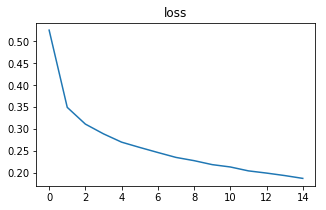

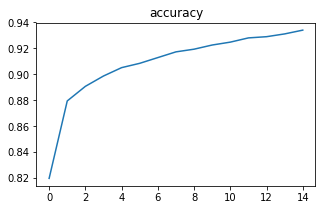

In [20]:
np.random.seed(123)
model = Sequential()
units_output = 10

# Add model here
# Convolutional layer with kernel size 3x3 and 32 output filters
model.add(Convolution2D(42, 3, 3, activation='relu', input_shape=(28,28,1)))

# ReLU activation
model.add(Activation('relu'))

# Max pooling (2D) of size 2x2
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten 2D output into 1D
model.add(Flatten())

# Dense layer to 10 output units
model.add(Dense(units=units_output))

# softmax activation
model.add(Activation('softmax'))

# You can also try different optimizers below
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
print(model.summary())

# Training
epochs = 15

history = model.fit(x_train, 
                    y_train_cat, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=1)

# Plot loss and accuracy in training

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy')

# Evaluate on test set
scores = model.evaluate(x_test, y_test_cat, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

## Reparameterizations Fourth

In [ ]:
np.random.seed(123)
model = Sequential()
units_output = 10

# Add model here
# Convolutional layer with kernel size 3x3 and 32 output filters
model.add(Convolution2D(42, 3, 3, activation='relu', input_shape=(28,28,1)))

# ReLU activation
model.add(Activation('relu'))

# Max pooling (2D) of size 2x2
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten 2D output into 1D
model.add(Flatten())

# Dense layer to 10 output units
model.add(Dense(units=units_output))

# softmax activation
model.add(Activation('softmax'))

# You can also try different optimizers below
model.compile(loss='categorical_crossentropy', 
              optimizer='adagrad', 
              metrics=['accuracy'])
print(model.summary())

# Training
epochs = 15

history = model.fit(x_train, 
                    y_train_cat, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=1)

# Plot loss and accuracy in training

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy')

# Evaluate on test set
scores = model.evaluate(x_test, y_test_cat, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

## Reparameterizations Fifth

# Conclusion:

### Reparameterizations One

In this reparameterizations, model uses different optimizer technique "adam". It gives overall 89.77% accuracy on test set which is 5.97% more compared to previous exercise's network.

### Reparameterizations Second

In this reparameterizations, model includes one more Convolution layer with kernel size (3x3) and 32 output filters. Moreover, model also contains two Dropout layers with 0.25 and 0.5 percertage respectively to avoid overfitting. 

As we saw in our first reparameterizations that "adam" optimizer gives better results so this model also compile with "adam" optimizer instead of "sgd". 

Overall accuracy obtained on test set is 91.76%. Which is 7.88% better then the previous exercise's network.

### Reparameterizations Third

In this reparameterizations, I mainly experimented with output filters and epochs. This model used "adam" optimizer, 42 oupter filters for Convolutional layer and 15 epochs. 

This settings gives 90.70% accuracy on test set and improves 6.82% accuracy performace compared to previous exercise's network.

### Reparameterizations Fourth

In this reparameterizations, I experimented with different optimizers e.g. "adagrad", "adadelta", "adamax" with different 42 oupter filters for Convolutional layer and 15 epochs. 

"adagrad", "adadelta" and "adamax" gives 89.57%, 89.72% and 90.34% accuracy on test set respectively.

All these optimizers gives better accuracy than previous exercise's network but they were not able to beat "adam" optimizer.